In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pykdtree.kdtree import KDTree
import math
import random

In [2]:
seed=10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

## THE MODEL

In [64]:
class GFN_AE(nn.Module):
    """
    Module implementing the GFN method for the encoder and decoder architectures.
    Methods:
    __init__: initialises the master mesh, and master weight & biases for the 1st and last layer of the encoder and decoder, respectively
    expand: add all new expansive nodes in the new mesh to the weight matrices
    agglomerate: agglomerate nodes to fit the new mesh
    encoder: execute the encoder part
    decoder: execute the decoder part
    """
    def __init__(self, mesh_m, latent_size=20):
        super().__init__()
        size = mesh_m.shape[0]
        self.latent_size = latent_size
        self.We_m = nn.Parameter(torch.empty(size, self.latent_size))
        self.be_m = nn.Parameter(torch.empty(self.latent_size))
        self.Wd_m = nn.Parameter(torch.empty(self.latent_size, size))
        self.bd_m = nn.Parameter(torch.empty(size))
        self.mesh_m = mesh_m
        
        self.initialise(self.We_m, self.be_m)
        self.initialise(self.Wd_m, self.bd_m)
        
        # Note: no self.be_n since we never need to reshape the encoder biases i.e. be_n == be_m in all cases
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        self.mesh_n = self.mesh_m
        
    def initialise(self, weight, bias):
        stdv = 1. / math.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        bias.data.uniform_(-stdv, stdv)

    def expand(self, mesh_n, kd_tree_m=None, kd_tree_n=None, **kwargs):
        """
        Expand the new weights and biases with the new expansive nodes. If during training, update the master weights, biases & mesh.
        If during inference, then just apply the new ones.
        """
        
        # During evaluation, we will have fixed mesh_m so we don't want to recompute every time => option to pass in
        if kd_tree_m is None:
            kd_tree_m = KDTree(self.mesh_m)
        # During training, we will have fixed fidelities that we know and don't need to always recompute
        if kd_tree_n is None:
            kd_tree_n = KDTree(mesh_n)
            
        nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]

        if not self.training:
            # ! testing mode !
            
            # could assign with .data calls here but can't do for train https://discuss.pytorch.org/t/function-tbackward-returned-an-invalid-gradient-at-index-0-got-1-3-but-expected-shape-compatible-with-1-2/125259
            
            count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
            nodes_added = 0 # how much did we increase our master mesh

            for pt_n, pt_m in enumerate(nn_n):
                if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                    nodes_added += 1
                    self.mesh_n = np.vstack([self.mesh_n, mesh_n[pt_n]])
                    count_m[pt_m]+=1

                    # Divide encoder weights by number of expansions
                    self.We_n[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                    # Store the index of the weight we want
                    # so we can update at the end without storing
                    # all the nodes to update explictly
                    new_row = torch.zeros(1, self.We_n.shape[1])
                    new_row[0][0] = pt_m
                    self.We_n = torch.cat((self.We_n, new_row), dim=0)

                    # Duplicate weights for decoder
                    self.Wd_n = torch.cat((self.Wd_n, self.Wd_n[:, pt_m:pt_m+1]), dim=1)
                    self.bd_n = torch.cat([self.bd_n, self.bd_n[pt_m:pt_m+1]])

            # Loop over the nodes we need to update using the index we stored in the first element
            for i in range(self.mesh_m.shape[0], self.mesh_m.shape[0]+nodes_added):
                index = int(self.We_n[i,0])
                self.We_n[i] = self.We_n[index]
        else:
            # ! training mode !
            
            # Expansion step is essentially creating new weights from scratch
            # => ignore gradients and therefore allow for slicing on leaf tensor as required
            # (Unless we do something smarter with the gradient tree to track what we're doing...)
            with torch.no_grad():
                count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
                nodes_added = 0 # how much did we increase our master mesh
                size=self.mesh_m.shape[0]

                for pt_n, pt_m in enumerate(nn_n):
                    if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                        nodes_added += 1
                        self.mesh_m=np.vstack([self.mesh_m, mesh_n[pt_n]])
                        count_m[pt_m]+=1
                        
                        # Divide encoder weights by number of expansions
                        self.We_m[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                        # Store the index of the weight we want
                        # so we can update at the end without storing
                        # all the nodes to update explictly
                        new_row = torch.zeros(1, self.We_m.shape[1])
                        new_row[0][0] = pt_m
                        self.We_m = nn.Parameter(torch.cat((self.We_m, new_row), dim=0))
                        
                        # Duplicate weights for decoder
                        self.Wd_m = nn.Parameter(torch.cat((self.Wd_m, self.Wd_m[:, pt_m:pt_m+1]), dim=1))
                        self.bd_m = nn.Parameter(torch.cat([self.bd_m, self.bd_m[pt_m:pt_m+1]]))
                
                # Loop over the nodes we need to update using the index we stored in the first element
                for i in range(size, size+nodes_added):
                    index = int(self.We_m[i,0])
                    self.We_m[i] = self.We_m[index]
            
            # now we need to track gradients from our new master weights
            self.We_n = self.We_m.clone()
            self.Wd_n = self.Wd_m.clone()
            self.bd_n = self.bd_m.clone()
        return nodes_added
        
    def agglomerate(self, mesh_n, kd_tree_n=None, nn_m=None, **kwargs):
        
        # known during training
        if nn_m is not None:
            pass
        # already found in expansion or already known during training
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]

        # FIND NEW WEIGHTS (AGGLOMERATIVE ONLY NOW)
        We_n = torch.zeros((mesh_n.shape[0], self.We_n.shape[1]))
        Wd_n = torch.zeros((self.We_n.shape[1], mesh_n.shape[0]))
        bd_n = torch.zeros(mesh_n.shape[0])

        count_n = np.zeros(mesh_n.shape[0])

        for m, pt_m in enumerate(self.mesh_n): # agglomerate
            nn_n = nn_m[m]
            count_n[nn_n]+=1
            We_n[nn_n] += self.We_n[m]
            Wd_n[:, nn_n] = ( (count_n[nn_n]-1)*Wd_n[:, nn_n] + self.Wd_n[:, m] )/count_n[nn_n]
            bd_n[nn_n] = ( (count_n[nn_n]-1)*bd_n[nn_n] + self.bd_n[m] )/count_n[nn_n]
          
        self.We_n = We_n
        self.Wd_n = Wd_n
        self.bd_n = bd_n
        
    def reset(self):
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        if not self.training:
            self.mesh_n = self.mesh_m
        
    def encoder(self, x, mesh_n, exp_enc=True, agg_enc=True, reset_enc=False, **kwargs):
        if reset_enc:
            self.reset()
        if exp_enc:
            self.expand(mesh_n, **kwargs)
        if agg_enc:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.We_n+self.be_m
        
    def decoder(self, x, mesh_n, exp_dec=True, agg_dec=True, reset_dec=False, **kwargs):
        if reset_dec:
            self.reset()
        if exp_dec:
            self.expand(mesh_n, **kwargs)
        if agg_dec:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.Wd_n+self.bd_n
    
class GCA(nn.Module):
    
    def __init__(self, mesh_m, gfn_latent_size=20, latent_size=20, n_params=7, act=nn.Tanh, ae_sizes=[], map_sizes=[50]*4):
        super().__init__()
        self.GFN = GFN_AE(mesh_m, gfn_latent_size)
        
        self.act = act()
        
        module_list_enc = []
        module_list_dec = []

        for i in range(len(ae_sizes)):
            module_list_dec.append(self.act)
            if i==0:
                module_list_enc.append(nn.Linear(gfn_latent_size, ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], gfn_latent_size))
            else:
                module_list_enc.append(nn.Linear(ae_sizes[i-1], ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], ae_sizes[i-1]))
            module_list_enc.append(self.act)
        if len(ae_sizes)!=0:
            module_list_dec.append(self.act)
            module_list_enc.append(nn.Linear(ae_sizes[-1], latent_size))
            module_list_dec.append(nn.Linear(latent_size, ae_sizes[-1]))
            module_list_enc.append(self.act)
        
        self.encoder = nn.Sequential(*module_list_enc)
        self.decoder = nn.Sequential(*module_list_dec[::-1])
        
        module_list_map = []
        
        for i in range(len(map_sizes)):
            if i==0:
                module_list_map.append(nn.Linear(n_params, map_sizes[i]))
            else:
                module_list_map.append(nn.Linear(map_sizes[i-1], map_sizes[i]))
            module_list_map.append(act())
        if len(map_sizes)!=0:
            module_list_map.append(nn.Linear(map_sizes[-1], latent_size))
            
        self.mapper = nn.Sequential(*module_list_map)
        
    def forward(self, x, mesh_n, params, **kwargs):
        x_enc = self.act(self.GFN.encoder(x, mesh_n, **kwargs))
        x_enc = self.encoder(x_enc)
        
        x_map = self.mapper(params)
        
        x_recon = self.decoder(x_enc)
        x_recon = self.GFN.decoder(x_enc, mesh_n, **kwargs)
        
        return x_recon, x_enc, x_map

## SET UP TRAINING DATA

In [4]:
from itertools import product
import scipy
from sklearn import preprocessing

def get_params():
    mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
    mus = []
    n_pts = [2]*(len(mu_range)-1)+[11]
    for i in range(len(mu_range)):
        mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
    return torch.tensor(np.array(list(product(*mus)))).float()

def scaler_func():
    return preprocessing.StandardScaler()

def scaling(U):
    scaling_fun_1 = scaler_func()
    scaling_fun_2 = scaler_func()
    scaler_s = scaling_fun_1.fit(U)
    temp = torch.t(torch.tensor(scaler_s.transform(U)))
    scaler_f = scaling_fun_2.fit(temp)
    scaled_data = torch.unsqueeze(torch.t(torch.tensor(scaler_f.transform(temp))),0).permute(2, 1, 0)
    scale = [scaler_s, scaler_f]
    return scale, scaled_data[:,:,0]

def undo_scaling(U, scale):
    scaler_s = scale[0]
    scaler_f = scale[1]
    rescaled_data = torch.tensor(scaler_s.inverse_transform(torch.t(torch.tensor(scaler_f.inverse_transform(U.detach().numpy().squeeze())))))
    return rescaled_data

def get_scaled_data(fname):
    U_orig = torch.tensor(scipy.io.loadmat(fname)['U'])
    scale, U_sc = scaling(U_orig)
    print('reconstruction error', ((U_orig - undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc

C:\Users\oisin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
params = get_params().to(dev)

df_small = pd.read_csv('reference_mesh_small.csv', header=None).values
df_medium = pd.read_csv('reference_mesh.csv', header=None).values

scale_small, U_small = get_scaled_data('matrix_small.mat')
U_small = U_small.float().to(dev)
scale_medium, U_medium = get_scaled_data('matrix.mat')
U_medium = U_medium.float().to(dev)

train_trajs = random.sample(range(704), 352)
train_trajs_s = train_trajs[:176]
train_trajs_m = train_trajs[176:]
test_trajs = list(set(range(704)) - set(train_trajs))

reconstruction error tensor(1.0720e-27, dtype=torch.float64)
reconstruction error tensor(4.0544e-27, dtype=torch.float64)


## TRAIN THE MODEL

In [6]:
df_small = pd.read_csv('reference_mesh_small.csv', header=None).values
df_medium = pd.read_csv('reference_mesh.csv', header=None).values

# initialisation
# NB - important to start with largest mesh since this is better for initialisation purposes
# and potential savings in no expansions are done
model = GCA(df_medium).to(dev)

# conduct the expansion step
added_nodes = model.GFN.expand(df_small)

added_nodes

0

In [7]:
from tqdm import tqdm

In [8]:
model.train()

# now initialise our optimiser after we have conducted ALL expansions
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [9]:
best_loss = np.inf
EPOCHS = 5000
test_losses = []
train_losses = []

def criterion(x, x_recon, x_enc, x_map):
    return nn.functional.mse_loss(x, x_recon)+1e1*nn.functional.mse_loss(x_enc, x_map)

kd_tree_n = KDTree(df_small)
nn_m = kd_tree_n.query(model.GFN.mesh_m, k=1)[1]

U_medium_train = U_medium[train_trajs_m]
params_medium = params[train_trajs_m]
U_small_train = U_small[train_trajs_s]
params_small = params[train_trajs_s]

U_medium_test = U_medium[test_trajs]
params_test = params[test_trajs]
U_small_test = U_small[test_trajs]

for i in tqdm(range(EPOCHS)):
    opt.zero_grad()
    
    # because added_nodes==0, we know we don't need to expand or agglom for the medium mesh
    x_recon, x_enc, x_map = model(U_medium_train, df_medium, params_medium, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
    loss_medium = criterion(U_medium_train, x_recon, x_enc, x_map)
    
    # only need to agglom in training since we expanded as a preprocessing step
    x_recon, x_enc, x_map = model(U_small_train, df_small, params_small, exp_enc=False, exp_dec=False, agg_dec=False, nn_m=nn_m, reset_enc=True)
    loss_small = criterion(U_small_train, x_recon, x_enc, x_map)
    
    loss = 1/(df_medium.shape[0]+df_small.shape[0])*(df_small.shape[0]*loss_small + df_medium.shape[0]*loss_medium)
    loss.backward()
    opt.step()
    
    train_loss = loss.item()
    
    with torch.no_grad():
        x_recon, x_enc, x_map = model(U_medium_test, df_medium, params_test, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
        test_loss_m = criterion(U_medium_test, x_recon, x_enc, x_map).item()
        x_recon, x_enc, x_map = model(U_small_test, df_small, params_test, exp_enc=False, exp_dec=False, agg_dec=False, nn_m=nn_m, reset_enc=True)
        test_loss_s = criterion(U_small_test, x_recon, x_enc, x_map).item()
        
        test_loss = test_loss_m+df_small.shape[0]/df_medium.shape[0]*test_loss_s # = 1/(df_medium.shape[0]+df_small.shape[0])*(df_small.shape[0]*test_loss_s + df_medium.shape[0]*test_loss_m)
    
    print(f'Epoch {i}: train loss: {train_loss} | test loss: {test_loss} via (s): {test_loss_s} | (m): {test_loss_m}')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss<best_loss:
        best_loss=test_loss
        best_epoch = i
        torch.save(model.state_dict(), "best_model.pt")

  0%|                                                                               | 1/5000 [00:02<3:51:21,  2.78s/it]

Epoch 0: train loss: 10.177102088928223 | test loss: 12.180663608657527 via (s): 9.6579008102417 | (m): 9.64362621307373


  0%|                                                                               | 2/5000 [00:07<5:32:37,  3.99s/it]

Epoch 1: train loss: 9.58230209350586 | test loss: 11.703986560027612 via (s): 9.436332702636719 | (m): 9.225152969360352


  0%|                                                                               | 3/5000 [00:13<6:40:53,  4.81s/it]

Epoch 2: train loss: 9.188944816589355 | test loss: 11.158669090513046 via (s): 9.062346458435059 | (m): 8.778078079223633


  0%|                                                                               | 4/5000 [00:19<7:13:41,  5.21s/it]

Epoch 3: train loss: 8.743474006652832 | test loss: 10.790728387493772 via (s): 8.780645370483398 | (m): 8.484137535095215


  0%|                                                                               | 5/5000 [00:25<7:36:24,  5.48s/it]

Epoch 4: train loss: 8.404590606689453 | test loss: 10.261962356906253 via (s): 8.314934730529785 | (m): 8.077709197998047


  0%|                                                                               | 6/5000 [00:31<7:47:00,  5.61s/it]

Epoch 5: train loss: 8.04874038696289 | test loss: 9.785172591959764 via (s): 7.77646541595459 | (m): 7.742370128631592


  0%|                                                                               | 7/5000 [00:37<7:56:33,  5.73s/it]

Epoch 6: train loss: 7.672959804534912 | test loss: 9.559884222025799 via (s): 7.490100383758545 | (m): 7.592307090759277


  0%|▏                                                                              | 8/5000 [00:42<7:59:48,  5.77s/it]

Epoch 7: train loss: 7.455623149871826 | test loss: 9.254714243908218 via (s): 7.335655689239502 | (m): 7.3277082443237305


  0%|▏                                                                              | 9/5000 [00:48<8:04:15,  5.82s/it]

Epoch 8: train loss: 7.2046098709106445 | test loss: 8.978501548016737 via (s): 7.2437663078308105 | (m): 7.075634002685547


  0%|▏                                                                             | 10/5000 [00:54<8:06:03,  5.84s/it]

Epoch 9: train loss: 7.000587463378906 | test loss: 8.642441873017907 via (s): 7.025627136230469 | (m): 6.796877384185791


  0%|▏                                                                             | 11/5000 [01:00<8:06:54,  5.86s/it]

Epoch 10: train loss: 6.70461893081665 | test loss: 8.284694301295401 via (s): 6.726192474365234 | (m): 6.517788410186768


  0%|▏                                                                             | 12/5000 [01:06<8:07:34,  5.86s/it]

Epoch 11: train loss: 6.429074287414551 | test loss: 7.887976278508376 via (s): 6.431118011474609 | (m): 6.198583602905273


  0%|▏                                                                             | 13/5000 [01:12<8:05:56,  5.85s/it]

Epoch 12: train loss: 6.200104713439941 | test loss: 7.597271597930018 via (s): 6.2239813804626465 | (m): 5.962291717529297


  0%|▏                                                                             | 14/5000 [01:18<8:06:23,  5.85s/it]

Epoch 13: train loss: 5.99291467666626 | test loss: 7.436859233730336 via (s): 6.068802833557129 | (m): 5.8426432609558105


  0%|▏                                                                             | 15/5000 [01:24<8:06:33,  5.86s/it]

Epoch 14: train loss: 5.818484306335449 | test loss: 7.187399311719207 via (s): 5.85935640335083 | (m): 5.648202896118164


  0%|▏                                                                             | 16/5000 [01:29<8:04:58,  5.84s/it]

Epoch 15: train loss: 5.629650592803955 | test loss: 6.865436855911604 via (s): 5.5753960609436035 | (m): 5.400834083557129


  0%|▎                                                                             | 17/5000 [01:35<8:09:52,  5.90s/it]

Epoch 16: train loss: 5.405142784118652 | test loss: 6.658200705717057 via (s): 5.428179740905762 | (m): 5.232270240783691


  0%|▎                                                                             | 18/5000 [01:41<8:10:21,  5.91s/it]

Epoch 17: train loss: 5.241263389587402 | test loss: 6.613091935966221 via (s): 5.460063934326172 | (m): 5.178785800933838


  0%|▎                                                                             | 19/5000 [01:47<8:13:44,  5.95s/it]

Epoch 18: train loss: 5.185049533843994 | test loss: 6.505779881767815 via (s): 5.486049175262451 | (m): 5.064647674560547


  0%|▎                                                                             | 20/5000 [01:53<8:16:11,  5.98s/it]

Epoch 19: train loss: 5.087820053100586 | test loss: 6.402767090022866 via (s): 5.441129207611084 | (m): 4.973434925079346


  0%|▎                                                                             | 21/5000 [01:59<8:16:43,  5.99s/it]

Epoch 20: train loss: 4.982911109924316 | test loss: 6.367449837892794 via (s): 5.355312347412109 | (m): 4.960660934448242


  0%|▎                                                                             | 22/5000 [02:05<8:14:41,  5.96s/it]

Epoch 21: train loss: 4.92039155960083 | test loss: 6.285989415222013 via (s): 5.213809967041016 | (m): 4.916371822357178


  0%|▎                                                                             | 23/5000 [02:11<8:17:47,  6.00s/it]

Epoch 22: train loss: 4.833594799041748 | test loss: 6.125661745289255 via (s): 5.072388172149658 | (m): 4.79319429397583


  0%|▎                                                                             | 24/5000 [02:17<8:16:18,  5.98s/it]

Epoch 23: train loss: 4.71663761138916 | test loss: 5.9728812003498755 via (s): 5.025230884552002 | (m): 4.652801513671875


  0%|▍                                                                             | 25/5000 [02:23<8:15:36,  5.98s/it]

Epoch 24: train loss: 4.635337829589844 | test loss: 5.830034965185949 via (s): 4.959962844848633 | (m): 4.527100563049316


  1%|▍                                                                             | 26/5000 [02:29<8:15:50,  5.98s/it]

Epoch 25: train loss: 4.544480323791504 | test loss: 5.709155828819662 via (s): 4.861491680145264 | (m): 4.432088851928711


  1%|▍                                                                             | 27/5000 [02:35<8:17:23,  6.00s/it]

Epoch 26: train loss: 4.471362113952637 | test loss: 5.598955273023112 via (s): 4.755960464477539 | (m): 4.349610328674316


  1%|▍                                                                             | 28/5000 [02:41<8:16:47,  6.00s/it]

Epoch 27: train loss: 4.403030872344971 | test loss: 5.509649780195982 via (s): 4.63398551940918 | (m): 4.292346477508545


  1%|▍                                                                             | 29/5000 [02:47<8:15:28,  5.98s/it]

Epoch 28: train loss: 4.3282904624938965 | test loss: 5.461851364464929 via (s): 4.550962448120117 | (m): 4.266357421875


  1%|▍                                                                             | 30/5000 [02:53<8:16:37,  6.00s/it]

Epoch 29: train loss: 4.257185935974121 | test loss: 5.392167159748562 via (s): 4.535289287567139 | (m): 4.2007904052734375


  1%|▍                                                                             | 31/5000 [02:59<8:16:46,  6.00s/it]

Epoch 30: train loss: 4.173644542694092 | test loss: 5.31928183221575 via (s): 4.547506332397461 | (m): 4.124695777893066


  1%|▍                                                                             | 32/5000 [03:05<8:16:18,  5.99s/it]

Epoch 31: train loss: 4.114008903503418 | test loss: 5.216451066399589 via (s): 4.477251052856445 | (m): 4.04032039642334


  1%|▌                                                                             | 33/5000 [03:11<8:18:07,  6.02s/it]

Epoch 32: train loss: 4.040324687957764 | test loss: 5.099626096372072 via (s): 4.35774564743042 | (m): 3.954888343811035


  1%|▌                                                                             | 34/5000 [03:17<8:18:06,  6.02s/it]

Epoch 33: train loss: 3.9592247009277344 | test loss: 4.961965856213255 via (s): 4.194269180297852 | (m): 3.8601717948913574


  1%|▌                                                                             | 35/5000 [03:23<8:19:00,  6.03s/it]

Epoch 34: train loss: 3.860543966293335 | test loss: 4.848539179351729 via (s): 4.080023765563965 | (m): 3.7767562866210938


  1%|▌                                                                             | 36/5000 [03:29<8:17:24,  6.01s/it]

Epoch 35: train loss: 3.7426767349243164 | test loss: 4.792747302708892 via (s): 4.1001996994018555 | (m): 3.7156643867492676


  1%|▌                                                                             | 37/5000 [03:35<8:14:50,  5.98s/it]

Epoch 36: train loss: 3.690886974334717 | test loss: 4.658954838205715 via (s): 4.044940948486328 | (m): 3.5963878631591797


  1%|▌                                                                             | 38/5000 [03:41<8:16:02,  6.00s/it]

Epoch 37: train loss: 3.607581853866577 | test loss: 4.589084719340813 via (s): 3.984656572341919 | (m): 3.542353868484497


  1%|▌                                                                             | 39/5000 [03:47<8:16:48,  6.01s/it]

Epoch 38: train loss: 3.5880260467529297 | test loss: 4.52436435283138 via (s): 3.888866424560547 | (m): 3.5027966499328613


  1%|▌                                                                             | 40/5000 [03:53<8:13:59,  5.98s/it]

Epoch 39: train loss: 3.53509259223938 | test loss: 4.464978072849021 via (s): 3.8388147354125977 | (m): 3.4565584659576416


  1%|▋                                                                             | 41/5000 [04:00<8:20:39,  6.06s/it]

Epoch 40: train loss: 3.457585573196411 | test loss: 4.374250623780458 via (s): 3.7944107055664062 | (m): 3.377495527267456


  1%|▋                                                                             | 42/5000 [04:06<8:21:09,  6.06s/it]

Epoch 41: train loss: 3.380706310272217 | test loss: 4.273132334808407 via (s): 3.7223217487335205 | (m): 3.295314311981201


  1%|▋                                                                             | 43/5000 [04:12<8:19:03,  6.04s/it]

Epoch 42: train loss: 3.312920570373535 | test loss: 4.195016635553486 via (s): 3.6665985584259033 | (m): 3.2318365573883057


  1%|▋                                                                             | 44/5000 [04:18<8:18:03,  6.03s/it]

Epoch 43: train loss: 3.248527765274048 | test loss: 4.152262584812145 via (s): 3.6557350158691406 | (m): 3.1919362545013428


  1%|▋                                                                             | 45/5000 [04:24<8:16:19,  6.01s/it]

Epoch 44: train loss: 3.225898027420044 | test loss: 4.090938081596104 via (s): 3.6179609298706055 | (m): 3.1405346393585205


  1%|▋                                                                             | 46/5000 [04:29<8:13:54,  5.98s/it]

Epoch 45: train loss: 3.1816680431365967 | test loss: 4.018812847016426 via (s): 3.581594944000244 | (m): 3.0779623985290527


  1%|▋                                                                             | 47/5000 [04:35<8:14:06,  5.99s/it]

Epoch 46: train loss: 3.1294240951538086 | test loss: 3.9413010202688614 via (s): 3.541152000427246 | (m): 3.0110745429992676


  1%|▋                                                                             | 48/5000 [04:41<8:15:00,  6.00s/it]

Epoch 47: train loss: 3.073512554168701 | test loss: 3.871656320421829 via (s): 3.464977741241455 | (m): 2.961440086364746


  1%|▊                                                                             | 49/5000 [04:47<8:12:26,  5.97s/it]

Epoch 48: train loss: 3.0017476081848145 | test loss: 3.8001245683824956 via (s): 3.400519847869873 | (m): 2.9068408012390137


  1%|▊                                                                             | 50/5000 [04:53<8:13:06,  5.98s/it]

Epoch 49: train loss: 2.9425556659698486 | test loss: 3.7350393642628856 via (s): 3.346184253692627 | (m): 2.8560290336608887


  1%|▊                                                                             | 51/5000 [04:59<8:16:12,  6.02s/it]

Epoch 50: train loss: 2.8999929428100586 | test loss: 3.68891419069416 via (s): 3.293391704559326 | (m): 2.8237719535827637


  1%|▊                                                                             | 52/5000 [05:06<8:16:23,  6.02s/it]

Epoch 51: train loss: 2.8556926250457764 | test loss: 3.6140563121906997 via (s): 3.2144386768341064 | (m): 2.7696542739868164


  1%|▊                                                                             | 53/5000 [05:12<8:19:31,  6.06s/it]

Epoch 52: train loss: 2.799600124359131 | test loss: 3.5631636629249845 via (s): 3.1738204956054688 | (m): 2.729431629180908


  1%|▊                                                                             | 54/5000 [05:18<8:18:01,  6.04s/it]

Epoch 53: train loss: 2.742008924484253 | test loss: 3.481189268192059 via (s): 3.1243855953216553 | (m): 2.6604433059692383


  1%|▊                                                                             | 55/5000 [05:24<8:15:40,  6.01s/it]

Epoch 54: train loss: 2.69722580909729 | test loss: 3.443587510718912 via (s): 3.101353168487549 | (m): 2.628891944885254


  1%|▊                                                                             | 56/5000 [05:30<8:14:50,  6.01s/it]

Epoch 55: train loss: 2.659756660461426 | test loss: 3.382609423647072 via (s): 3.030043125152588 | (m): 2.586646318435669


  1%|▉                                                                             | 57/5000 [05:36<8:13:50,  5.99s/it]

Epoch 56: train loss: 2.6241745948791504 | test loss: 3.330011556898882 via (s): 2.997471570968628 | (m): 2.542604684829712


  1%|▉                                                                             | 58/5000 [05:42<8:12:39,  5.98s/it]

Epoch 57: train loss: 2.574327230453491 | test loss: 3.2789857396619575 via (s): 2.934641122817993 | (m): 2.5080838203430176


  1%|▉                                                                             | 59/5000 [05:47<8:10:10,  5.95s/it]

Epoch 58: train loss: 2.5262856483459473 | test loss: 3.2221446215803855 via (s): 2.8556978702545166 | (m): 2.471980333328247


  1%|▉                                                                             | 60/5000 [05:53<8:09:43,  5.95s/it]

Epoch 59: train loss: 2.4984090328216553 | test loss: 3.201829396528641 via (s): 2.8346657752990723 | (m): 2.4571900367736816


  1%|▉                                                                             | 61/5000 [05:59<8:08:53,  5.94s/it]

Epoch 60: train loss: 2.4593722820281982 | test loss: 3.1452022203939216 via (s): 2.7998886108398438 | (m): 2.409698486328125


  1%|▉                                                                             | 62/5000 [06:05<8:10:58,  5.97s/it]

Epoch 61: train loss: 2.4235267639160156 | test loss: 3.1088266088272714 via (s): 2.77170991897583 | (m): 2.380725145339966


  1%|▉                                                                             | 63/5000 [06:11<8:13:16,  5.99s/it]

Epoch 62: train loss: 2.4065463542938232 | test loss: 3.063479647721131 via (s): 2.7345073223114014 | (m): 2.345150947570801


  1%|▉                                                                             | 64/5000 [06:17<8:10:56,  5.97s/it]

Epoch 63: train loss: 2.352860927581787 | test loss: 3.0500143485020863 via (s): 2.7091338634490967 | (m): 2.338351011276245


  1%|█                                                                             | 65/5000 [06:23<8:09:47,  5.95s/it]

Epoch 64: train loss: 2.3306586742401123 | test loss: 2.9875799411444492 via (s): 2.694608688354492 | (m): 2.2797322273254395


  1%|█                                                                             | 66/5000 [06:29<8:09:32,  5.95s/it]

Epoch 65: train loss: 2.302396059036255 | test loss: 2.952120346466297 via (s): 2.6765480041503906 | (m): 2.2490170001983643


  1%|█                                                                             | 67/5000 [06:35<8:08:38,  5.94s/it]

Epoch 66: train loss: 2.26073956489563 | test loss: 2.9400412633939443 via (s): 2.6693975925445557 | (m): 2.238816261291504


  1%|█                                                                             | 68/5000 [06:41<8:08:07,  5.94s/it]

Epoch 67: train loss: 2.2338597774505615 | test loss: 2.902428181643413 via (s): 2.595705032348633 | (m): 2.2205615043640137


  1%|█                                                                             | 69/5000 [06:47<8:09:44,  5.96s/it]

Epoch 68: train loss: 2.209239959716797 | test loss: 2.859974730740949 via (s): 2.570446729660034 | (m): 2.1847431659698486


  1%|█                                                                             | 70/5000 [06:53<8:11:45,  5.98s/it]

Epoch 69: train loss: 2.1675400733947754 | test loss: 2.8291290393335564 via (s): 2.5816636085510254 | (m): 2.1509509086608887


  1%|█                                                                             | 71/5000 [06:59<8:13:25,  6.01s/it]

Epoch 70: train loss: 2.1459481716156006 | test loss: 2.8096702153307533 via (s): 2.5266499519348145 | (m): 2.1459436416625977


  1%|█                                                                             | 72/5000 [07:05<8:14:32,  6.02s/it]

Epoch 71: train loss: 2.118361711502075 | test loss: 2.7901729079067406 via (s): 2.4786362648010254 | (m): 2.139059066772461


  1%|█▏                                                                            | 73/5000 [07:11<8:14:05,  6.02s/it]

Epoch 72: train loss: 2.0950753688812256 | test loss: 2.752392646019834 via (s): 2.490342617034912 | (m): 2.098203659057617


  1%|█▏                                                                            | 74/5000 [07:17<8:15:48,  6.04s/it]

Epoch 73: train loss: 2.0621337890625 | test loss: 2.7486492513400043 via (s): 2.4790103435516357 | (m): 2.0974371433258057


  2%|█▏                                                                            | 75/5000 [07:23<8:17:02,  6.06s/it]

Epoch 74: train loss: 2.0465362071990967 | test loss: 2.707663844987221 via (s): 2.438236951828003 | (m): 2.06716251373291


  2%|█▏                                                                            | 76/5000 [07:29<8:15:23,  6.04s/it]

Epoch 75: train loss: 2.0139031410217285 | test loss: 2.6900569953894253 via (s): 2.4048521518707275 | (m): 2.0583255290985107


  2%|█▏                                                                            | 77/5000 [07:35<8:15:06,  6.03s/it]

Epoch 76: train loss: 1.994384527206421 | test loss: 2.6730836526996593 via (s): 2.4038543701171875 | (m): 2.041614294052124


  2%|█▏                                                                            | 78/5000 [07:41<8:15:11,  6.04s/it]

Epoch 77: train loss: 1.9714889526367188 | test loss: 2.6469043650602933 via (s): 2.390244960784912 | (m): 2.019010066986084


  2%|█▏                                                                            | 79/5000 [07:47<8:15:51,  6.05s/it]

Epoch 78: train loss: 1.9496638774871826 | test loss: 2.6312732505919363 via (s): 2.365748167037964 | (m): 2.0098140239715576


  2%|█▏                                                                            | 80/5000 [07:53<8:13:35,  6.02s/it]

Epoch 79: train loss: 1.9326859712600708 | test loss: 2.613021794309471 via (s): 2.356675624847412 | (m): 1.993945837020874


  2%|█▎                                                                            | 81/5000 [08:00<8:16:59,  6.06s/it]

Epoch 80: train loss: 1.9116944074630737 | test loss: 2.621628473555376 via (s): 2.3464887142181396 | (m): 2.0052285194396973


  2%|█▎                                                                            | 82/5000 [08:06<8:18:15,  6.08s/it]

Epoch 81: train loss: 1.8981280326843262 | test loss: 2.5699690407907902 via (s): 2.318225622177124 | (m): 1.9609935283660889


  2%|█▎                                                                            | 83/5000 [08:12<8:18:49,  6.09s/it]

Epoch 82: train loss: 1.8819583654403687 | test loss: 2.5536412442396133 via (s): 2.316403388977051 | (m): 1.9451444149017334


  2%|█▎                                                                            | 84/5000 [08:18<8:18:47,  6.09s/it]

Epoch 83: train loss: 1.8572125434875488 | test loss: 2.5901996944156394 via (s): 2.3025994300842285 | (m): 1.985329031944275


  2%|█▎                                                                            | 85/5000 [08:24<8:18:41,  6.09s/it]

Epoch 84: train loss: 1.8588308095932007 | test loss: 2.5397395113397976 via (s): 2.2771453857421875 | (m): 1.941555380821228


  2%|█▎                                                                            | 86/5000 [08:30<8:16:56,  6.07s/it]

Epoch 85: train loss: 1.8400249481201172 | test loss: 2.507370039291188 via (s): 2.2785468101501465 | (m): 1.9088177680969238


  2%|█▎                                                                            | 87/5000 [08:36<8:15:00,  6.05s/it]

Epoch 86: train loss: 1.8113574981689453 | test loss: 2.502861748492052 via (s): 2.252880573272705 | (m): 1.9110517501831055


  2%|█▎                                                                            | 88/5000 [08:42<8:15:29,  6.05s/it]

Epoch 87: train loss: 1.7892590761184692 | test loss: 2.483547693279189 via (s): 2.2204015254974365 | (m): 1.900269627571106


  2%|█▍                                                                            | 89/5000 [08:48<8:14:15,  6.04s/it]

Epoch 88: train loss: 1.7747352123260498 | test loss: 2.4681718228432126 via (s): 2.2182254791259766 | (m): 1.885465383529663


  2%|█▍                                                                            | 90/5000 [08:54<8:14:26,  6.04s/it]

Epoch 89: train loss: 1.7693040370941162 | test loss: 2.449119384216173 via (s): 2.2163379192352295 | (m): 1.8669087886810303


  2%|█▍                                                                            | 91/5000 [09:00<8:12:55,  6.02s/it]

Epoch 90: train loss: 1.737744927406311 | test loss: 2.4647344260046324 via (s): 2.1884007453918457 | (m): 1.8898626565933228


  2%|█▍                                                                            | 92/5000 [09:06<8:14:01,  6.04s/it]

Epoch 91: train loss: 1.7414673566818237 | test loss: 2.4033890738705086 via (s): 2.174553394317627 | (m): 1.8321548700332642


  2%|█▍                                                                            | 93/5000 [09:12<8:15:41,  6.06s/it]

Epoch 92: train loss: 1.7165440320968628 | test loss: 2.3949259174656747 via (s): 2.1629981994628906 | (m): 1.8267271518707275


  2%|█▍                                                                            | 94/5000 [09:18<8:14:55,  6.05s/it]

Epoch 93: train loss: 1.689182996749878 | test loss: 2.3997892268418055 via (s): 2.144458770751953 | (m): 1.8364605903625488


  2%|█▍                                                                            | 95/5000 [09:24<8:16:48,  6.08s/it]

Epoch 94: train loss: 1.6842800378799438 | test loss: 2.3460646522831796 via (s): 2.1203508377075195 | (m): 1.7890689373016357


  2%|█▍                                                                            | 96/5000 [09:30<8:13:05,  6.03s/it]

Epoch 95: train loss: 1.6584779024124146 | test loss: 2.3465932746829115 via (s): 2.113966941833496 | (m): 1.7912745475769043


  2%|█▌                                                                            | 97/5000 [09:36<8:13:58,  6.05s/it]

Epoch 96: train loss: 1.6502671241760254 | test loss: 2.339030496965205 via (s): 2.1094093322753906 | (m): 1.7849090099334717


  2%|█▌                                                                            | 98/5000 [09:42<8:12:52,  6.03s/it]

Epoch 97: train loss: 1.6336901187896729 | test loss: 2.3272080663497072 via (s): 2.075444221496582 | (m): 1.7820088863372803


  2%|█▌                                                                            | 99/5000 [09:48<8:10:51,  6.01s/it]

Epoch 98: train loss: 1.6197682619094849 | test loss: 2.2982867408524914 via (s): 2.0593888759613037 | (m): 1.7573051452636719


  2%|█▌                                                                           | 100/5000 [09:54<8:12:25,  6.03s/it]

Epoch 99: train loss: 1.607952356338501 | test loss: 2.276597718599484 via (s): 2.040942430496216 | (m): 1.740461826324463


  2%|█▌                                                                           | 101/5000 [10:01<8:14:45,  6.06s/it]

Epoch 100: train loss: 1.584133267402649 | test loss: 2.25908532814326 via (s): 2.0396406650543213 | (m): 1.7232913970947266


  2%|█▌                                                                           | 102/5000 [10:07<8:12:55,  6.04s/it]

Epoch 101: train loss: 1.569745421409607 | test loss: 2.233069876728929 via (s): 2.0030999183654785 | (m): 1.7068748474121094


  2%|█▌                                                                           | 103/5000 [10:13<8:15:06,  6.07s/it]

Epoch 102: train loss: 1.5578937530517578 | test loss: 2.2482249591556296 via (s): 2.0026588439941406 | (m): 1.7221457958221436


  2%|█▌                                                                           | 104/5000 [10:19<8:14:47,  6.06s/it]

Epoch 103: train loss: 1.5546826124191284 | test loss: 2.21749319915239 via (s): 1.9874017238616943 | (m): 1.6954219341278076


  2%|█▌                                                                           | 105/5000 [10:25<8:14:12,  6.06s/it]

Epoch 104: train loss: 1.5414937734603882 | test loss: 2.181915872895778 via (s): 1.9521167278289795 | (m): 1.6691136360168457


  2%|█▋                                                                           | 106/5000 [10:31<8:13:10,  6.05s/it]

Epoch 105: train loss: 1.5084811449050903 | test loss: 2.1946903485332045 via (s): 1.9580307006835938 | (m): 1.6803345680236816


  2%|█▋                                                                           | 107/5000 [10:37<8:14:49,  6.07s/it]

Epoch 106: train loss: 1.5110156536102295 | test loss: 2.1579238675572547 via (s): 1.949782133102417 | (m): 1.6457349061965942


  2%|█▋                                                                           | 108/5000 [10:43<8:17:02,  6.10s/it]

Epoch 107: train loss: 1.5070946216583252 | test loss: 2.1322936232622505 via (s): 1.9088038206100464 | (m): 1.6308692693710327


  2%|█▋                                                                           | 109/5000 [10:49<8:16:22,  6.09s/it]

Epoch 108: train loss: 1.4778640270233154 | test loss: 2.1600842784503995 via (s): 1.9203267097473145 | (m): 1.6556329727172852


  2%|█▋                                                                           | 110/5000 [10:55<8:15:43,  6.08s/it]

Epoch 109: train loss: 1.4791374206542969 | test loss: 2.070161679674526 via (s): 1.8719921112060547 | (m): 1.5784074068069458


  2%|█▋                                                                           | 111/5000 [11:01<8:15:41,  6.08s/it]

Epoch 110: train loss: 1.4474009275436401 | test loss: 2.0773207943149026 via (s): 1.8723796606063843 | (m): 1.5854647159576416


  2%|█▋                                                                           | 112/5000 [11:07<8:12:29,  6.05s/it]

Epoch 111: train loss: 1.440976858139038 | test loss: 2.087825744285196 via (s): 1.8711552619934082 | (m): 1.5962913036346436


  2%|█▋                                                                           | 113/5000 [11:13<8:12:57,  6.05s/it]

Epoch 112: train loss: 1.4318889379501343 | test loss: 2.035918467843593 via (s): 1.8338501453399658 | (m): 1.5541837215423584


  2%|█▊                                                                           | 114/5000 [11:19<8:12:49,  6.05s/it]

Epoch 113: train loss: 1.418434977531433 | test loss: 2.0320105057985045 via (s): 1.8183354139328003 | (m): 1.5543513298034668


  2%|█▊                                                                           | 115/5000 [11:25<8:11:49,  6.04s/it]

Epoch 114: train loss: 1.403847098350525 | test loss: 2.0286792118839805 via (s): 1.8181670904159546 | (m): 1.5510642528533936


  2%|█▊                                                                           | 116/5000 [11:32<8:12:07,  6.05s/it]

Epoch 115: train loss: 1.3953721523284912 | test loss: 2.020278101493864 via (s): 1.8187953233718872 | (m): 1.5424981117248535


  2%|█▊                                                                           | 117/5000 [11:38<8:12:25,  6.05s/it]

Epoch 116: train loss: 1.3930699825286865 | test loss: 1.9636285804249913 via (s): 1.7895257472991943 | (m): 1.493537425994873


  2%|█▊                                                                           | 118/5000 [11:44<8:14:04,  6.07s/it]

Epoch 117: train loss: 1.363160252571106 | test loss: 2.008418778023744 via (s): 1.8064640760421753 | (m): 1.5338780879974365


  2%|█▊                                                                           | 119/5000 [11:50<8:11:38,  6.04s/it]

Epoch 118: train loss: 1.3737319707870483 | test loss: 1.9685117382991133 via (s): 1.7878879308700562 | (m): 1.4988508224487305


  2%|█▊                                                                           | 120/5000 [11:56<8:13:12,  6.06s/it]

Epoch 119: train loss: 1.3602917194366455 | test loss: 1.9598541925401252 via (s): 1.7668647766113281 | (m): 1.495715856552124


  2%|█▊                                                                           | 121/5000 [12:02<8:12:33,  6.06s/it]

Epoch 120: train loss: 1.3517674207687378 | test loss: 1.9467847525770894 via (s): 1.7509996891021729 | (m): 1.486814022064209


  2%|█▉                                                                           | 122/5000 [12:08<8:12:29,  6.06s/it]

Epoch 121: train loss: 1.3504670858383179 | test loss: 1.9716409956138146 via (s): 1.7675821781158447 | (m): 1.5073142051696777


  2%|█▉                                                                           | 123/5000 [12:14<8:12:48,  6.06s/it]

Epoch 122: train loss: 1.3432408571243286 | test loss: 1.9028003516838634 via (s): 1.7254897356033325 | (m): 1.449530839920044


  2%|█▉                                                                           | 124/5000 [12:20<8:12:08,  6.06s/it]

Epoch 123: train loss: 1.3210737705230713 | test loss: 1.9154529930068755 via (s): 1.7223104238510132 | (m): 1.4630186557769775


  2%|█▉                                                                           | 125/5000 [12:26<8:10:33,  6.04s/it]

Epoch 124: train loss: 1.3077926635742188 | test loss: 1.8676300389209979 via (s): 1.7044528722763062 | (m): 1.4198867082595825


  3%|█▉                                                                           | 126/5000 [12:32<8:10:45,  6.04s/it]

Epoch 125: train loss: 1.2853811979293823 | test loss: 1.8951488562344294 via (s): 1.701475739479065 | (m): 1.4481875896453857


  3%|█▉                                                                           | 127/5000 [12:38<8:11:22,  6.05s/it]

Epoch 126: train loss: 1.2867217063903809 | test loss: 1.8650285099363568 via (s): 1.699822187423706 | (m): 1.418501615524292


  3%|█▉                                                                           | 128/5000 [12:44<8:11:00,  6.05s/it]

Epoch 127: train loss: 1.2718771696090698 | test loss: 1.8280327224791957 via (s): 1.6718157529830933 | (m): 1.3888628482818604


  3%|█▉                                                                           | 129/5000 [12:50<8:10:05,  6.04s/it]

Epoch 128: train loss: 1.2610536813735962 | test loss: 1.8524834634688905 via (s): 1.6719372272491455 | (m): 1.4132816791534424


  3%|██                                                                           | 130/5000 [12:56<8:11:13,  6.05s/it]

Epoch 129: train loss: 1.247679352760315 | test loss: 1.8259989815920137 via (s): 1.6673583984375 | (m): 1.3880000114440918


  3%|██                                                                           | 131/5000 [13:02<8:10:06,  6.04s/it]

Epoch 130: train loss: 1.2407293319702148 | test loss: 1.8023118532551121 via (s): 1.6255115270614624 | (m): 1.3753056526184082


  3%|██                                                                           | 132/5000 [13:08<8:10:12,  6.04s/it]

Epoch 131: train loss: 1.2306331396102905 | test loss: 1.7891669476092769 via (s): 1.6265146732330322 | (m): 1.3618972301483154


  3%|██                                                                           | 133/5000 [13:14<8:09:28,  6.03s/it]

Epoch 132: train loss: 1.2193025350570679 | test loss: 1.7648160757147116 via (s): 1.599010705947876 | (m): 1.344771385192871


  3%|██                                                                           | 134/5000 [13:20<8:09:08,  6.03s/it]

Epoch 133: train loss: 1.2033026218414307 | test loss: 1.7540766133874806 via (s): 1.5832514762878418 | (m): 1.3381717205047607


  3%|██                                                                           | 135/5000 [13:26<8:07:50,  6.02s/it]

Epoch 134: train loss: 1.1931395530700684 | test loss: 1.7479737397982988 via (s): 1.5821466445922852 | (m): 1.3323590755462646


  3%|██                                                                           | 136/5000 [13:32<8:07:37,  6.02s/it]

Epoch 135: train loss: 1.1953907012939453 | test loss: 1.7283239611211767 via (s): 1.566989541053772 | (m): 1.3166909217834473


  3%|██                                                                           | 137/5000 [13:38<8:07:28,  6.01s/it]

Epoch 136: train loss: 1.1746207475662231 | test loss: 1.7098697396704388 via (s): 1.5468919277191162 | (m): 1.303516149520874


  3%|██▏                                                                          | 138/5000 [13:44<8:09:31,  6.04s/it]

Epoch 137: train loss: 1.1659780740737915 | test loss: 1.7127546099236775 via (s): 1.556220293045044 | (m): 1.303950548171997


  3%|██▏                                                                          | 139/5000 [13:51<8:09:19,  6.04s/it]

Epoch 138: train loss: 1.1623625755310059 | test loss: 1.6789123273742985 via (s): 1.517695426940918 | (m): 1.2802283763885498


  3%|██▏                                                                          | 140/5000 [13:57<8:08:28,  6.03s/it]

Epoch 139: train loss: 1.1492388248443604 | test loss: 1.6808493622971064 via (s): 1.519849181175232 | (m): 1.2815996408462524


  3%|██▏                                                                          | 141/5000 [14:03<8:10:10,  6.05s/it]

Epoch 140: train loss: 1.1425341367721558 | test loss: 1.674278241728768 via (s): 1.5079398155212402 | (m): 1.2781569957733154


  3%|██▏                                                                          | 142/5000 [14:09<8:08:58,  6.04s/it]

Epoch 141: train loss: 1.1343671083450317 | test loss: 1.6544390801850914 via (s): 1.487274169921875 | (m): 1.2637465000152588


  3%|██▏                                                                          | 143/5000 [14:15<8:05:09,  5.99s/it]

Epoch 142: train loss: 1.1263039112091064 | test loss: 1.633821998755944 via (s): 1.478372573852539 | (m): 1.2454677820205688


  3%|██▏                                                                          | 144/5000 [14:21<8:06:33,  6.01s/it]

Epoch 143: train loss: 1.116731882095337 | test loss: 1.6393572194927235 via (s): 1.4878582954406738 | (m): 1.2485111951828003


  3%|██▏                                                                          | 145/5000 [14:27<8:05:06,  6.00s/it]

Epoch 144: train loss: 1.1138256788253784 | test loss: 1.6245155181679023 via (s): 1.4597855806350708 | (m): 1.2410439252853394


  3%|██▏                                                                          | 146/5000 [14:32<8:03:53,  5.98s/it]

Epoch 145: train loss: 1.112534761428833 | test loss: 1.6329549968545207 via (s): 1.470332145690918 | (m): 1.2467129230499268


  3%|██▎                                                                          | 147/5000 [14:39<8:07:07,  6.02s/it]

Epoch 146: train loss: 1.104174017906189 | test loss: 1.5916688716048517 via (s): 1.440142035484314 | (m): 1.2133574485778809


  3%|██▎                                                                          | 148/5000 [14:45<8:07:08,  6.02s/it]

Epoch 147: train loss: 1.1001944541931152 | test loss: 1.6161815826662906 via (s): 1.4464900493621826 | (m): 1.236202597618103


  3%|██▎                                                                          | 149/5000 [14:51<8:07:32,  6.03s/it]

Epoch 148: train loss: 1.0941548347473145 | test loss: 1.5869820187539618 via (s): 1.4307115077972412 | (m): 1.2111479043960571


  3%|██▎                                                                          | 150/5000 [14:57<8:06:44,  6.02s/it]

Epoch 149: train loss: 1.0887099504470825 | test loss: 1.5849342343165789 via (s): 1.4238159656524658 | (m): 1.210911512374878


  3%|██▎                                                                          | 151/5000 [15:03<8:06:58,  6.03s/it]

Epoch 150: train loss: 1.0801982879638672 | test loss: 1.5556446316883648 via (s): 1.4019005298614502 | (m): 1.1873788833618164


  3%|██▎                                                                          | 152/5000 [15:09<8:07:21,  6.03s/it]

Epoch 151: train loss: 1.0700833797454834 | test loss: 1.5700949040161172 via (s): 1.4075806140899658 | (m): 1.2003370523452759


  3%|██▎                                                                          | 153/5000 [15:15<8:06:07,  6.02s/it]

Epoch 152: train loss: 1.065390706062317 | test loss: 1.5296290757389843 via (s): 1.3782514333724976 | (m): 1.167575716972351


  3%|██▎                                                                          | 154/5000 [15:21<8:06:45,  6.03s/it]

Epoch 153: train loss: 1.0526055097579956 | test loss: 1.5278506530117868 via (s): 1.3677752017974854 | (m): 1.1685492992401123


  3%|██▍                                                                          | 155/5000 [15:27<8:04:53,  6.00s/it]

Epoch 154: train loss: 1.0435326099395752 | test loss: 1.5200930019925694 via (s): 1.3703782558441162 | (m): 1.1601078510284424


  3%|██▍                                                                          | 156/5000 [15:33<8:06:57,  6.03s/it]

Epoch 155: train loss: 1.0362709760665894 | test loss: 1.49819854068272 via (s): 1.3447470664978027 | (m): 1.1449464559555054


  3%|██▍                                                                          | 157/5000 [15:39<8:07:32,  6.04s/it]

Epoch 156: train loss: 1.0294560194015503 | test loss: 1.4988698777813596 via (s): 1.34987211227417 | (m): 1.1442714929580688


  3%|██▍                                                                          | 158/5000 [15:45<8:06:27,  6.03s/it]

Epoch 157: train loss: 1.0230804681777954 | test loss: 1.4811929685210212 via (s): 1.3313744068145752 | (m): 1.1314537525177002


  3%|██▍                                                                          | 159/5000 [15:51<8:05:02,  6.01s/it]

Epoch 158: train loss: 1.0166280269622803 | test loss: 1.4887497158825096 via (s): 1.3263120651245117 | (m): 1.1403403282165527


  3%|██▍                                                                          | 160/5000 [15:57<8:05:22,  6.02s/it]

Epoch 159: train loss: 1.0138014554977417 | test loss: 1.4632515881569859 via (s): 1.3213893175125122 | (m): 1.1161353588104248


  3%|██▍                                                                          | 161/5000 [16:03<8:04:41,  6.01s/it]

Epoch 160: train loss: 1.0065386295318604 | test loss: 1.4762507631694 via (s): 1.3212459087371826 | (m): 1.1291722059249878


  3%|██▍                                                                          | 162/5000 [16:09<8:05:00,  6.01s/it]

Epoch 161: train loss: 1.0019673109054565 | test loss: 1.4488057128063918 via (s): 1.2981724739074707 | (m): 1.107788324356079


  3%|██▌                                                                          | 163/5000 [16:15<8:06:00,  6.03s/it]

Epoch 162: train loss: 1.0059566497802734 | test loss: 1.4977166934061776 via (s): 1.3359777927398682 | (m): 1.1467682123184204


  3%|██▌                                                                          | 164/5000 [16:21<8:06:00,  6.03s/it]

Epoch 163: train loss: 1.0147870779037476 | test loss: 1.4386514171125926 via (s): 1.2925324440002441 | (m): 1.0991156101226807


  3%|██▌                                                                          | 165/5000 [16:27<8:07:26,  6.05s/it]

Epoch 164: train loss: 0.9965601563453674 | test loss: 1.4605503944576088 via (s): 1.298614263534546 | (m): 1.1194169521331787


  3%|██▌                                                                          | 166/5000 [16:33<8:08:06,  6.06s/it]

Epoch 165: train loss: 1.0042880773544312 | test loss: 1.421163483924672 via (s): 1.2728581428527832 | (m): 1.0867959260940552


  3%|██▌                                                                          | 167/5000 [16:39<8:07:58,  6.06s/it]

Epoch 166: train loss: 0.9812201261520386 | test loss: 1.432263023962224 via (s): 1.2863163948059082 | (m): 1.094360113143921


  3%|██▌                                                                          | 168/5000 [16:45<8:07:54,  6.06s/it]

Epoch 167: train loss: 0.9803564548492432 | test loss: 1.4041664355297379 via (s): 1.261115312576294 | (m): 1.0728836059570312


  3%|██▌                                                                          | 169/5000 [16:51<8:09:17,  6.08s/it]

Epoch 168: train loss: 0.9604814648628235 | test loss: 1.4163412078080444 via (s): 1.2529770135879517 | (m): 1.0871962308883667


  3%|██▌                                                                          | 170/5000 [16:58<8:10:28,  6.09s/it]

Epoch 169: train loss: 0.978182315826416 | test loss: 1.4487113362641504 via (s): 1.3014209270477295 | (m): 1.1068406105041504


  3%|██▋                                                                          | 171/5000 [17:03<8:06:47,  6.05s/it]

Epoch 170: train loss: 0.9828892946243286 | test loss: 1.3996726915921052 via (s): 1.255960464477539 | (m): 1.0697439908981323


  3%|██▋                                                                          | 172/5000 [17:09<8:05:33,  6.03s/it]

Epoch 171: train loss: 0.9602476358413696 | test loss: 1.3939672880971492 via (s): 1.241420030593872 | (m): 1.0678582191467285


  3%|██▋                                                                          | 173/5000 [17:16<8:05:45,  6.04s/it]

Epoch 172: train loss: 0.9596268534660339 | test loss: 1.3822943065977338 via (s): 1.2291982173919678 | (m): 1.0593957901000977


  3%|██▋                                                                          | 174/5000 [17:22<8:04:49,  6.03s/it]

Epoch 173: train loss: 0.9625605940818787 | test loss: 1.3792241397242861 via (s): 1.2316553592681885 | (m): 1.0556801557540894


  4%|██▋                                                                          | 175/5000 [17:28<8:06:11,  6.05s/it]

Epoch 174: train loss: 0.9480576515197754 | test loss: 1.3734589682012646 via (s): 1.229783535003662 | (m): 1.0504066944122314


  4%|██▋                                                                          | 176/5000 [17:34<8:05:04,  6.03s/it]

Epoch 175: train loss: 0.9469915628433228 | test loss: 1.3770145304917079 via (s): 1.2283859252929688 | (m): 1.0543293952941895


  4%|██▋                                                                          | 177/5000 [17:40<8:02:26,  6.00s/it]

Epoch 176: train loss: 0.9405228495597839 | test loss: 1.3483836895923325 via (s): 1.209707498550415 | (m): 1.0306051969528198


  4%|██▋                                                                          | 178/5000 [17:46<8:02:37,  6.01s/it]

Epoch 177: train loss: 0.9244251847267151 | test loss: 1.3553727508196372 via (s): 1.1953163146972656 | (m): 1.041374683380127


  4%|██▊                                                                          | 179/5000 [17:52<8:02:55,  6.01s/it]

Epoch 178: train loss: 0.9296000599861145 | test loss: 1.3385109744096164 via (s): 1.199366569519043 | (m): 1.0234489440917969


  4%|██▊                                                                          | 180/5000 [17:58<8:04:43,  6.03s/it]

Epoch 179: train loss: 0.9131733775138855 | test loss: 1.346048726345682 via (s): 1.2090866565704346 | (m): 1.0284333229064941


  4%|██▊                                                                          | 181/5000 [18:04<8:03:19,  6.02s/it]

Epoch 180: train loss: 0.9145482182502747 | test loss: 1.319719146048357 via (s): 1.1746256351470947 | (m): 1.0111563205718994


  4%|██▊                                                                          | 182/5000 [18:10<8:01:17,  5.99s/it]

Epoch 181: train loss: 0.9045548439025879 | test loss: 1.3095592299693732 via (s): 1.1674530506134033 | (m): 1.002880573272705


  4%|██▊                                                                          | 183/5000 [18:16<8:00:26,  5.98s/it]

Epoch 182: train loss: 0.900733470916748 | test loss: 1.3083195695417182 via (s): 1.1705996990203857 | (m): 1.0008143186569214


  4%|██▊                                                                          | 184/5000 [18:22<8:00:35,  5.99s/it]

Epoch 183: train loss: 0.8946064710617065 | test loss: 1.2998536480259775 via (s): 1.1656229496002197 | (m): 0.9936557412147522


  4%|██▊                                                                          | 185/5000 [18:28<8:01:29,  6.00s/it]

Epoch 184: train loss: 0.8936598300933838 | test loss: 1.297910577603403 via (s): 1.1536656618118286 | (m): 0.9948537349700928


  4%|██▊                                                                          | 186/5000 [18:34<8:00:51,  5.99s/it]

Epoch 185: train loss: 0.8863645195960999 | test loss: 1.2872688867113917 via (s): 1.139803171157837 | (m): 0.9878535866737366


  4%|██▉                                                                          | 187/5000 [18:40<8:01:59,  6.01s/it]

Epoch 186: train loss: 0.8854689598083496 | test loss: 1.2858311113367225 via (s): 1.15122652053833 | (m): 0.9834150075912476


  4%|██▉                                                                          | 188/5000 [18:46<8:04:47,  6.04s/it]

Epoch 187: train loss: 0.8779217600822449 | test loss: 1.2744908139185251 via (s): 1.1427035331726074 | (m): 0.9743136167526245


  4%|██▉                                                                          | 189/5000 [18:52<8:05:21,  6.05s/it]

Epoch 188: train loss: 0.8716840744018555 | test loss: 1.2678508271420668 via (s): 1.128380537033081 | (m): 0.9714361429214478


  4%|██▉                                                                          | 190/5000 [18:58<8:03:04,  6.03s/it]

Epoch 189: train loss: 0.8713313341140747 | test loss: 1.2598801550223744 via (s): 1.1253079175949097 | (m): 0.9642726182937622


  4%|██▉                                                                          | 191/5000 [19:04<8:01:06,  6.00s/it]

Epoch 190: train loss: 0.8633449673652649 | test loss: 1.260762027374984 via (s): 1.1301262378692627 | (m): 0.9638887643814087


  4%|██▉                                                                          | 192/5000 [19:10<8:00:46,  6.00s/it]

Epoch 191: train loss: 0.8619089126586914 | test loss: 1.2486960468861052 via (s): 1.11129629611969 | (m): 0.9567692279815674


  4%|██▉                                                                          | 193/5000 [19:16<8:01:31,  6.01s/it]

Epoch 192: train loss: 0.8560236096382141 | test loss: 1.2481784135254506 via (s): 1.1092463731765747 | (m): 0.9567900896072388


  4%|██▉                                                                          | 194/5000 [19:22<8:01:15,  6.01s/it]

Epoch 193: train loss: 0.853024959564209 | test loss: 1.2399310723779164 via (s): 1.1087300777435303 | (m): 0.9486783742904663


  4%|███                                                                          | 195/5000 [19:28<8:02:11,  6.02s/it]

Epoch 194: train loss: 0.848099410533905 | test loss: 1.2372645756919978 via (s): 1.106149673461914 | (m): 0.9466897249221802


  4%|███                                                                          | 196/5000 [19:34<8:02:54,  6.03s/it]

Epoch 195: train loss: 0.8434216976165771 | test loss: 1.2271035594988595 via (s): 1.0918827056884766 | (m): 0.9402765035629272


  4%|███                                                                          | 197/5000 [19:40<8:02:16,  6.02s/it]

Epoch 196: train loss: 0.8417667150497437 | test loss: 1.2283906463136527 via (s): 1.0960499048233032 | (m): 0.9404689073562622


  4%|███                                                                          | 198/5000 [19:46<8:04:29,  6.05s/it]

Epoch 197: train loss: 0.8360982537269592 | test loss: 1.2206714421056855 via (s): 1.0903960466384888 | (m): 0.9342349171638489


  4%|███                                                                          | 199/5000 [19:52<8:02:37,  6.03s/it]

Epoch 198: train loss: 0.8333873152732849 | test loss: 1.218313125789468 via (s): 1.082174301147461 | (m): 0.934036374092102


  4%|███                                                                          | 200/5000 [19:58<8:06:13,  6.08s/it]

Epoch 199: train loss: 0.8296120762825012 | test loss: 1.2107641162908622 via (s): 1.0764635801315308 | (m): 0.9279875159263611


  4%|███                                                                          | 201/5000 [20:04<8:06:42,  6.09s/it]

Epoch 200: train loss: 0.8264433741569519 | test loss: 1.2139326143385796 via (s): 1.0817244052886963 | (m): 0.9297740459442139


  4%|███                                                                          | 202/5000 [20:10<8:05:09,  6.07s/it]

Epoch 201: train loss: 0.824614405632019 | test loss: 1.205511286325261 via (s): 1.0733126401901245 | (m): 0.9235624074935913


  4%|███▏                                                                         | 203/5000 [20:16<8:03:28,  6.05s/it]

Epoch 202: train loss: 0.8227688670158386 | test loss: 1.2097200609100651 via (s): 1.0715420246124268 | (m): 0.9282363057136536


  4%|███▏                                                                         | 204/5000 [20:22<8:02:09,  6.03s/it]

Epoch 203: train loss: 0.8242161870002747 | test loss: 1.2140375826564536 via (s): 1.07883620262146 | (m): 0.9306377172470093


  4%|███▏                                                                         | 205/5000 [20:28<8:01:18,  6.02s/it]

Epoch 204: train loss: 0.8281270265579224 | test loss: 1.2136794749250266 via (s): 1.0786011219024658 | (m): 0.930341362953186


  4%|███▏                                                                         | 206/5000 [20:34<8:01:08,  6.02s/it]

Epoch 205: train loss: 0.8250752091407776 | test loss: 1.2086041161251553 via (s): 1.0642786026000977 | (m): 0.9290283918380737


  4%|███▏                                                                         | 207/5000 [20:40<8:00:05,  6.01s/it]

Epoch 206: train loss: 0.8291557431221008 | test loss: 1.2238411092516128 via (s): 1.08601713180542 | (m): 0.9385548830032349


  4%|███▏                                                                         | 208/5000 [20:46<7:57:08,  5.97s/it]

Epoch 207: train loss: 0.8324823379516602 | test loss: 1.2087850892906866 via (s): 1.0692888498306274 | (m): 0.9278932213783264


  4%|███▏                                                                         | 209/5000 [20:52<7:57:37,  5.98s/it]

Epoch 208: train loss: 0.8291088938713074 | test loss: 1.2082142221746106 via (s): 1.0676023960113525 | (m): 0.9277653694152832


  4%|███▏                                                                         | 210/5000 [20:58<7:59:28,  6.01s/it]

Epoch 209: train loss: 0.8244836926460266 | test loss: 1.187131745863687 via (s): 1.0513172149658203 | (m): 0.910960853099823


  4%|███▏                                                                         | 211/5000 [21:04<7:57:52,  5.99s/it]

Epoch 210: train loss: 0.8122852444648743 | test loss: 1.178061211774797 via (s): 1.0458345413208008 | (m): 0.9033305644989014


  4%|███▎                                                                         | 212/5000 [21:10<7:58:08,  5.99s/it]

Epoch 211: train loss: 0.8018972873687744 | test loss: 1.164790635635405 via (s): 1.0326372385025024 | (m): 0.8935267925262451


  4%|███▎                                                                         | 213/5000 [21:16<7:59:36,  6.01s/it]

Epoch 212: train loss: 0.7937179803848267 | test loss: 1.1560127871290682 via (s): 1.0236551761627197 | (m): 0.8871084451675415


  4%|███▎                                                                         | 214/5000 [21:22<7:59:44,  6.01s/it]

Epoch 213: train loss: 0.7883551120758057 | test loss: 1.1598026605729523 via (s): 1.0302778482437134 | (m): 0.8891586065292358


  4%|███▎                                                                         | 215/5000 [21:28<7:58:25,  6.00s/it]

Epoch 214: train loss: 0.7887387275695801 | test loss: 1.1562297112748103 via (s): 1.023203730583191 | (m): 0.8874439597129822


  4%|███▎                                                                         | 216/5000 [21:34<8:00:29,  6.03s/it]

Epoch 215: train loss: 0.7891542315483093 | test loss: 1.1618549487917555 via (s): 1.0276813507080078 | (m): 0.8918929696083069


  4%|███▎                                                                         | 217/5000 [21:40<8:00:54,  6.03s/it]

Epoch 216: train loss: 0.7893783450126648 | test loss: 1.1550526410189983 via (s): 1.020514965057373 | (m): 0.8869732022285461


  4%|███▎                                                                         | 218/5000 [21:46<8:01:58,  6.05s/it]

Epoch 217: train loss: 0.7889798283576965 | test loss: 1.1538111954776165 via (s): 1.0229103565216064 | (m): 0.8851025104522705


  4%|███▎                                                                         | 219/5000 [21:52<7:59:54,  6.02s/it]

Epoch 218: train loss: 0.7827500104904175 | test loss: 1.1382127806619944 via (s): 1.0039587020874023 | (m): 0.8744825124740601


  4%|███▍                                                                         | 220/5000 [21:59<8:03:54,  6.07s/it]

Epoch 219: train loss: 0.7763141989707947 | test loss: 1.1329180844846716 via (s): 1.0047301054000854 | (m): 0.8689851760864258


  4%|███▍                                                                         | 221/5000 [22:05<8:01:19,  6.04s/it]

Epoch 220: train loss: 0.7703035473823547 | test loss: 1.1239315247172632 via (s): 0.9957499504089355 | (m): 0.8623576164245605


  4%|███▍                                                                         | 222/5000 [22:11<7:59:45,  6.02s/it]

Epoch 221: train loss: 0.7646680474281311 | test loss: 1.1184353182461055 via (s): 0.990139365196228 | (m): 0.8583352565765381


  4%|███▍                                                                         | 223/5000 [22:17<7:59:55,  6.03s/it]

Epoch 222: train loss: 0.7623355388641357 | test loss: 1.12171323930249 via (s): 0.9935452342033386 | (m): 0.8607184886932373


  4%|███▍                                                                         | 224/5000 [22:23<8:00:53,  6.04s/it]

Epoch 223: train loss: 0.7615216970443726 | test loss: 1.1146433310309036 via (s): 0.985011637210846 | (m): 0.8558902740478516


  4%|███▍                                                                         | 225/5000 [22:29<8:00:44,  6.04s/it]

Epoch 224: train loss: 0.7590551376342773 | test loss: 1.1124333927625327 via (s): 0.9851097464561462 | (m): 0.8536545634269714


  5%|███▍                                                                         | 226/5000 [22:35<8:00:56,  6.04s/it]

Epoch 225: train loss: 0.7561389803886414 | test loss: 1.1102513722356806 via (s): 0.9795699119567871 | (m): 0.8529278039932251


  5%|███▍                                                                         | 227/5000 [22:41<7:59:56,  6.03s/it]

Epoch 226: train loss: 0.7544932961463928 | test loss: 1.1062693036903584 via (s): 0.9774526953697205 | (m): 0.84950190782547


  5%|███▌                                                                         | 228/5000 [22:47<8:00:06,  6.04s/it]

Epoch 227: train loss: 0.7531636357307434 | test loss: 1.1148128352189426 via (s): 0.9805874824523926 | (m): 0.8572219610214233


  5%|███▌                                                                         | 229/5000 [22:53<7:59:08,  6.03s/it]

Epoch 228: train loss: 0.7553128004074097 | test loss: 1.097439648536256 via (s): 0.9703779220581055 | (m): 0.8425307273864746


  5%|███▌                                                                         | 230/5000 [22:59<7:59:16,  6.03s/it]

Epoch 229: train loss: 0.7478912472724915 | test loss: 1.0892041693181556 via (s): 0.9608625173568726 | (m): 0.8367948532104492


  5%|███▌                                                                         | 231/5000 [23:05<8:01:32,  6.06s/it]

Epoch 230: train loss: 0.7440022230148315 | test loss: 1.0986708029726435 via (s): 0.9706225991249084 | (m): 0.8436976075172424


  5%|███▌                                                                         | 232/5000 [23:11<8:02:38,  6.07s/it]

Epoch 231: train loss: 0.7426742911338806 | test loss: 1.0840342549351871 via (s): 0.9579480290412903 | (m): 0.832390546798706


  5%|███▌                                                                         | 233/5000 [23:17<8:01:40,  6.06s/it]

Epoch 232: train loss: 0.736596405506134 | test loss: 1.0757963413817022 via (s): 0.9491907358169556 | (m): 0.8264530897140503


  5%|███▌                                                                         | 234/5000 [23:23<8:01:44,  6.06s/it]

Epoch 233: train loss: 0.7363027334213257 | test loss: 1.0806438646038172 via (s): 0.9554513692855835 | (m): 0.8296560049057007


  5%|███▌                                                                         | 235/5000 [23:29<8:00:59,  6.06s/it]

Epoch 234: train loss: 0.7316532731056213 | test loss: 1.0705149857525897 via (s): 0.9464762210845947 | (m): 0.82188481092453


  5%|███▋                                                                         | 236/5000 [23:35<8:01:33,  6.06s/it]

Epoch 235: train loss: 0.7282173037528992 | test loss: 1.0738195587838362 via (s): 0.9455088376998901 | (m): 0.8254435062408447


  5%|███▋                                                                         | 237/5000 [23:41<8:00:45,  6.06s/it]

Epoch 236: train loss: 0.7298926115036011 | test loss: 1.0790050699172287 via (s): 0.9484452605247498 | (m): 0.8298576474189758


  5%|███▋                                                                         | 238/5000 [23:47<8:00:02,  6.05s/it]

Epoch 237: train loss: 0.7330688238143921 | test loss: 1.066787583800742 via (s): 0.9425652623176575 | (m): 0.8191847801208496


  5%|███▋                                                                         | 239/5000 [23:53<7:59:45,  6.05s/it]

Epoch 238: train loss: 0.7225348949432373 | test loss: 1.0589693644022578 via (s): 0.931991696357727 | (m): 0.8141441345214844


  5%|███▋                                                                         | 240/5000 [24:00<8:01:08,  6.06s/it]

Epoch 239: train loss: 0.7237153649330139 | test loss: 1.0710092889627223 via (s): 0.9436406493186951 | (m): 0.8231239914894104


  5%|███▋                                                                         | 241/5000 [24:06<7:58:54,  6.04s/it]

Epoch 240: train loss: 0.72371906042099 | test loss: 1.0571746897273862 via (s): 0.9318524599075317 | (m): 0.8123860359191895


  5%|███▋                                                                         | 242/5000 [24:11<7:57:12,  6.02s/it]

Epoch 241: train loss: 0.7189818620681763 | test loss: 1.0542261195061775 via (s): 0.9295589923858643 | (m): 0.8100399374961853


  5%|███▋                                                                         | 243/5000 [24:17<7:55:36,  6.00s/it]

Epoch 242: train loss: 0.7169825434684753 | test loss: 1.042198818195895 via (s): 0.9191454648971558 | (m): 0.8007481694221497


  5%|███▊                                                                         | 244/5000 [24:23<7:55:06,  5.99s/it]

Epoch 243: train loss: 0.7105275988578796 | test loss: 1.0467163067178678 via (s): 0.9229047298431396 | (m): 0.8042781352996826


  5%|███▊                                                                         | 245/5000 [24:29<7:54:29,  5.99s/it]

Epoch 244: train loss: 0.7076187133789062 | test loss: 1.0363238849464407 via (s): 0.9143980145454407 | (m): 0.7961203455924988


  5%|███▊                                                                         | 246/5000 [24:35<7:56:52,  6.02s/it]

Epoch 245: train loss: 0.7030057311058044 | test loss: 1.0386273803444683 via (s): 0.9137568473815918 | (m): 0.7985922694206238


  5%|███▊                                                                         | 247/5000 [24:42<7:57:36,  6.03s/it]

Epoch 246: train loss: 0.7047422528266907 | test loss: 1.0434124312425022 via (s): 0.9164285659790039 | (m): 0.8026754856109619


  5%|███▊                                                                         | 248/5000 [24:48<7:58:01,  6.04s/it]

Epoch 247: train loss: 0.7067586779594421 | test loss: 1.0330870812616977 via (s): 0.9116371870040894 | (m): 0.7936087846755981


  5%|███▊                                                                         | 249/5000 [24:54<7:57:58,  6.04s/it]

Epoch 248: train loss: 0.6990326046943665 | test loss: 1.0302407997211223 via (s): 0.9052087068557739 | (m): 0.7924512028694153


  5%|███▊                                                                         | 250/5000 [25:00<7:58:24,  6.04s/it]

Epoch 249: train loss: 0.6998201608657837 | test loss: 1.0323818977260348 via (s): 0.9091700911521912 | (m): 0.7935516834259033


  5%|███▊                                                                         | 251/5000 [25:06<7:57:42,  6.04s/it]

Epoch 250: train loss: 0.6991119980812073 | test loss: 1.0268034388873784 via (s): 0.9050379991531372 | (m): 0.7890586853027344


  5%|███▉                                                                         | 252/5000 [25:12<7:57:53,  6.04s/it]

Epoch 251: train loss: 0.69671630859375 | test loss: 1.0261651011287864 via (s): 0.901153564453125 | (m): 0.7894407510757446


  5%|███▉                                                                         | 253/5000 [25:18<7:57:30,  6.04s/it]

Epoch 252: train loss: 0.6969878077507019 | test loss: 1.017106064306903 via (s): 0.8952887654304504 | (m): 0.7819223403930664


  5%|███▉                                                                         | 254/5000 [25:24<7:57:43,  6.04s/it]

Epoch 253: train loss: 0.6903560161590576 | test loss: 1.0150965827370657 via (s): 0.8948836326599121 | (m): 0.7800192832946777


  5%|███▉                                                                         | 255/5000 [25:30<7:57:09,  6.03s/it]

Epoch 254: train loss: 0.6863692998886108 | test loss: 1.0017613534848702 via (s): 0.880641520023346 | (m): 0.7704253196716309


  5%|███▉                                                                         | 256/5000 [25:36<7:55:47,  6.02s/it]

Epoch 255: train loss: 0.6793458461761475 | test loss: 0.996545053375554 via (s): 0.8794262409210205 | (m): 0.7655282616615295


  5%|███▉                                                                         | 257/5000 [25:42<7:59:55,  6.07s/it]

Epoch 256: train loss: 0.6735124588012695 | test loss: 0.9920398491590761 via (s): 0.8725816011428833 | (m): 0.7628210783004761


  5%|███▉                                                                         | 258/5000 [25:48<8:00:42,  6.08s/it]

Epoch 257: train loss: 0.670233964920044 | test loss: 0.9834004138326886 via (s): 0.8681516647338867 | (m): 0.755345344543457


  5%|███▉                                                                         | 259/5000 [25:54<7:58:38,  6.06s/it]

Epoch 258: train loss: 0.66350257396698 | test loss: 0.9783962676821626 via (s): 0.8620133996009827 | (m): 0.751953661441803


  5%|████                                                                         | 260/5000 [26:00<7:59:48,  6.07s/it]

Epoch 259: train loss: 0.6602706909179688 | test loss: 0.9750107791520617 via (s): 0.8604995012283325 | (m): 0.748965859413147


  5%|████                                                                         | 261/5000 [26:06<7:56:39,  6.03s/it]

Epoch 260: train loss: 0.6584284901618958 | test loss: 0.9715834983109217 via (s): 0.8582744598388672 | (m): 0.7461230754852295


  5%|████                                                                         | 262/5000 [26:12<7:55:22,  6.02s/it]

Epoch 261: train loss: 0.6554864048957825 | test loss: 0.9713535592489436 via (s): 0.8548927903175354 | (m): 0.7467814683914185


  5%|████                                                                         | 263/5000 [26:18<7:56:50,  6.04s/it]

Epoch 262: train loss: 0.6551870703697205 | test loss: 0.9663702959034044 via (s): 0.8538287878036499 | (m): 0.7420777082443237


  5%|████                                                                         | 264/5000 [26:25<8:02:59,  6.12s/it]

Epoch 263: train loss: 0.6531464457511902 | test loss: 0.9675225455900134 via (s): 0.8517400622367859 | (m): 0.743778645992279


  5%|████                                                                         | 265/5000 [26:31<8:00:13,  6.09s/it]

Epoch 264: train loss: 0.6515243649482727 | test loss: 0.9632755334153393 via (s): 0.8490344882011414 | (m): 0.7402423620223999


  5%|████                                                                         | 266/5000 [26:37<7:57:19,  6.05s/it]

Epoch 265: train loss: 0.6518225073814392 | test loss: 0.9673488885920665 via (s): 0.8491979837417603 | (m): 0.744272768497467


  5%|████                                                                         | 267/5000 [26:43<7:56:57,  6.05s/it]

Epoch 266: train loss: 0.6519210934638977 | test loss: 0.9638636609170642 via (s): 0.8502845168113708 | (m): 0.740502119064331


  5%|████▏                                                                        | 268/5000 [26:49<7:56:31,  6.04s/it]

Epoch 267: train loss: 0.652344286441803 | test loss: 0.9700877947099318 via (s): 0.8490357995033264 | (m): 0.7470542788505554


  5%|████▏                                                                        | 269/5000 [26:55<7:56:30,  6.04s/it]

Epoch 268: train loss: 0.6544508934020996 | test loss: 0.9636750171329769 via (s): 0.8488582372665405 | (m): 0.740688145160675


  5%|████▏                                                                        | 270/5000 [27:01<8:02:19,  6.12s/it]

Epoch 269: train loss: 0.6527841091156006 | test loss: 0.9646349295141733 via (s): 0.8454396724700928 | (m): 0.7425460815429688


  5%|████▏                                                                        | 271/5000 [27:07<7:58:50,  6.08s/it]

Epoch 270: train loss: 0.6504939198493958 | test loss: 0.9539266189342828 via (s): 0.8390865325927734 | (m): 0.7335066795349121


  5%|████▏                                                                        | 272/5000 [27:13<7:57:06,  6.05s/it]

Epoch 271: train loss: 0.6450563669204712 | test loss: 0.9448713711675654 via (s): 0.8300693035125732 | (m): 0.726820170879364


  5%|████▏                                                                        | 273/5000 [27:19<7:58:02,  6.07s/it]

Epoch 272: train loss: 0.6350079774856567 | test loss: 0.9292956676882536 via (s): 0.8202790021896362 | (m): 0.7138162851333618


  5%|████▏                                                                        | 274/5000 [27:25<7:59:40,  6.09s/it]

Epoch 273: train loss: 0.6258904933929443 | test loss: 0.9242646962706813 via (s): 0.8120339512825012 | (m): 0.7109512090682983


  6%|████▏                                                                        | 275/5000 [27:31<7:59:48,  6.09s/it]

Epoch 274: train loss: 0.6191277503967285 | test loss: 0.9144428740751924 via (s): 0.8080471158027649 | (m): 0.7021766901016235


  6%|████▎                                                                        | 276/5000 [27:37<7:57:40,  6.07s/it]

Epoch 275: train loss: 0.614840567111969 | test loss: 0.9156335610423596 via (s): 0.8056125640869141 | (m): 0.7040069103240967


  6%|████▎                                                                        | 277/5000 [27:43<7:58:02,  6.07s/it]

Epoch 276: train loss: 0.6129425764083862 | test loss: 0.9109852208098784 via (s): 0.801868200302124 | (m): 0.7003421783447266


  6%|████▎                                                                        | 278/5000 [27:49<7:56:03,  6.05s/it]

Epoch 277: train loss: 0.6125145554542542 | test loss: 0.9138351815001009 via (s): 0.8058624267578125 | (m): 0.7021428942680359


  6%|████▎                                                                        | 279/5000 [27:55<7:56:11,  6.05s/it]

Epoch 278: train loss: 0.6129918694496155 | test loss: 0.9135764735906862 via (s): 0.8012365102767944 | (m): 0.7030993700027466


  6%|████▎                                                                        | 280/5000 [28:01<7:55:50,  6.05s/it]

Epoch 279: train loss: 0.6134819388389587 | test loss: 0.9112012610217641 via (s): 0.8035287857055664 | (m): 0.7001219987869263


  6%|████▎                                                                        | 281/5000 [28:07<7:55:16,  6.04s/it]

Epoch 280: train loss: 0.6130878925323486 | test loss: 0.9119887559244475 via (s): 0.7989093065261841 | (m): 0.7021229863166809


  6%|████▎                                                                        | 282/5000 [28:13<7:53:41,  6.02s/it]

Epoch 281: train loss: 0.6113710999488831 | test loss: 0.9025990568139226 via (s): 0.7969647645950317 | (m): 0.6932440996170044


  6%|████▎                                                                        | 283/5000 [28:20<7:54:58,  6.04s/it]

Epoch 282: train loss: 0.6063809990882874 | test loss: 0.8968005243896833 via (s): 0.7859096527099609 | (m): 0.6903496384620667


  6%|████▎                                                                        | 284/5000 [28:26<7:53:57,  6.03s/it]

Epoch 283: train loss: 0.6006320714950562 | test loss: 0.8878539473120937 via (s): 0.7846983075141907 | (m): 0.6817212700843811


  6%|████▍                                                                        | 285/5000 [28:32<7:54:53,  6.04s/it]

Epoch 284: train loss: 0.5938662886619568 | test loss: 0.8767260596685603 via (s): 0.7713828682899475 | (m): 0.6740912199020386


  6%|████▍                                                                        | 286/5000 [28:38<7:54:05,  6.03s/it]

Epoch 285: train loss: 0.5868701338768005 | test loss: 0.8721791023984173 via (s): 0.7688358426094055 | (m): 0.6702133417129517


  6%|████▍                                                                        | 287/5000 [28:44<7:52:54,  6.02s/it]

Epoch 286: train loss: 0.5811876654624939 | test loss: 0.8629080659241846 via (s): 0.7624108791351318 | (m): 0.6626300811767578


  6%|████▍                                                                        | 288/5000 [28:50<7:53:24,  6.03s/it]

Epoch 287: train loss: 0.5768495798110962 | test loss: 0.8605364103456439 via (s): 0.7581554055213928 | (m): 0.6613762974739075


  6%|████▍                                                                        | 289/5000 [28:56<7:52:22,  6.02s/it]

Epoch 288: train loss: 0.5728260278701782 | test loss: 0.8527408893489595 via (s): 0.7536105513572693 | (m): 0.6547746658325195


  6%|████▍                                                                        | 290/5000 [29:02<7:52:24,  6.02s/it]

Epoch 289: train loss: 0.5692336559295654 | test loss: 0.8509422573946455 via (s): 0.751105785369873 | (m): 0.6536340117454529


  6%|████▍                                                                        | 291/5000 [29:08<7:50:21,  5.99s/it]

Epoch 290: train loss: 0.5661588907241821 | test loss: 0.8444453350783605 via (s): 0.7462620735168457 | (m): 0.6484094858169556


  6%|████▍                                                                        | 292/5000 [29:14<7:53:04,  6.03s/it]

Epoch 291: train loss: 0.563162624835968 | test loss: 0.8436005985373773 via (s): 0.7434118986129761 | (m): 0.6483134627342224


  6%|████▌                                                                        | 293/5000 [29:20<7:54:54,  6.05s/it]

Epoch 292: train loss: 0.5606785416603088 | test loss: 0.837676901200096 via (s): 0.741525411605835 | (m): 0.6428853273391724


  6%|████▌                                                                        | 294/5000 [29:26<7:53:10,  6.03s/it]

Epoch 293: train loss: 0.5590446591377258 | test loss: 0.8411151259229873 via (s): 0.7395531535148621 | (m): 0.6468416452407837


  6%|████▌                                                                        | 295/5000 [29:32<7:53:54,  6.04s/it]

Epoch 294: train loss: 0.5586498379707336 | test loss: 0.8368440331692623 via (s): 0.7403842806816101 | (m): 0.6423522233963013


  6%|████▌                                                                        | 296/5000 [29:38<7:55:25,  6.06s/it]

Epoch 295: train loss: 0.5600617527961731 | test loss: 0.8503896311152405 via (s): 0.7458592653274536 | (m): 0.6544595956802368


  6%|████▌                                                                        | 297/5000 [29:44<7:54:11,  6.05s/it]

Epoch 296: train loss: 0.5656010508537292 | test loss: 0.8498050169593792 via (s): 0.7496017217636108 | (m): 0.6528918743133545


  6%|████▌                                                                        | 298/5000 [29:50<7:52:21,  6.03s/it]

Epoch 297: train loss: 0.5726569890975952 | test loss: 0.8687883129125924 via (s): 0.7580541968345642 | (m): 0.6696547865867615


  6%|████▌                                                                        | 299/5000 [29:56<7:54:23,  6.05s/it]

Epoch 298: train loss: 0.5794585943222046 | test loss: 0.8547933894365571 via (s): 0.753446102142334 | (m): 0.6568703651428223


  6%|████▌                                                                        | 300/5000 [30:02<7:55:21,  6.07s/it]

Epoch 299: train loss: 0.5767954587936401 | test loss: 0.847386543142614 via (s): 0.7398651242256165 | (m): 0.6530311107635498


  6%|████▋                                                                        | 301/5000 [30:08<7:56:50,  6.09s/it]

Epoch 300: train loss: 0.5661302208900452 | test loss: 0.8296761906086491 via (s): 0.7337913513183594 | (m): 0.6369162797927856


  6%|████▋                                                                        | 302/5000 [30:14<7:55:55,  6.08s/it]

Epoch 301: train loss: 0.5516040325164795 | test loss: 0.8092839676262763 via (s): 0.7114133238792419 | (m): 0.622402548789978


  6%|████▋                                                                        | 303/5000 [30:20<7:54:22,  6.06s/it]

Epoch 302: train loss: 0.5424436330795288 | test loss: 0.8226190130722704 via (s): 0.7241027355194092 | (m): 0.6324042081832886


  6%|████▋                                                                        | 304/5000 [30:26<7:52:51,  6.04s/it]

Epoch 303: train loss: 0.5417207479476929 | test loss: 0.8058189318567364 via (s): 0.7116979360580444 | (m): 0.6188627481460571


  6%|████▋                                                                        | 305/5000 [30:32<7:50:16,  6.01s/it]

Epoch 304: train loss: 0.5419852137565613 | test loss: 0.820210873172973 via (s): 0.7175793647766113 | (m): 0.6317096948623657


  6%|████▋                                                                        | 306/5000 [30:38<7:51:39,  6.03s/it]

Epoch 305: train loss: 0.54110187292099 | test loss: 0.8035560363742906 via (s): 0.7116082906723022 | (m): 0.6166234016418457


  6%|████▋                                                                        | 307/5000 [30:44<7:50:54,  6.02s/it]

Epoch 306: train loss: 0.53910231590271 | test loss: 0.8020748243416627 via (s): 0.705466628074646 | (m): 0.6167555451393127


  6%|████▋                                                                        | 308/5000 [30:50<7:50:55,  6.02s/it]

Epoch 307: train loss: 0.5306404829025269 | test loss: 0.780803651071442 via (s): 0.690955400466919 | (m): 0.5992963314056396


  6%|████▊                                                                        | 309/5000 [30:56<7:50:26,  6.02s/it]

Epoch 308: train loss: 0.5193965435028076 | test loss: 0.7720862510543184 via (s): 0.6827584505081177 | (m): 0.5927321910858154


  6%|████▊                                                                        | 310/5000 [31:02<7:50:23,  6.02s/it]

Epoch 309: train loss: 0.5104143023490906 | test loss: 0.7675091234711826 via (s): 0.6798242926597595 | (m): 0.588925838470459


  6%|████▊                                                                        | 311/5000 [31:09<7:51:44,  6.04s/it]

Epoch 310: train loss: 0.5059453248977661 | test loss: 0.7641408086428182 via (s): 0.6752345561981201 | (m): 0.5867632031440735


  6%|████▊                                                                        | 312/5000 [31:15<7:52:25,  6.05s/it]

Epoch 311: train loss: 0.5077588558197021 | test loss: 0.7799099626274884 via (s): 0.6891067028045654 | (m): 0.5988882780075073


  6%|████▊                                                                        | 313/5000 [31:21<7:51:30,  6.04s/it]

Epoch 312: train loss: 0.513799786567688 | test loss: 0.7666900101954561 via (s): 0.6788135766983032 | (m): 0.5883722305297852


  6%|████▊                                                                        | 314/5000 [31:26<7:47:17,  5.98s/it]

Epoch 313: train loss: 0.5135210752487183 | test loss: 0.7696940744588823 via (s): 0.6745269298553467 | (m): 0.5925023555755615


  6%|████▊                                                                        | 315/5000 [31:33<7:48:02,  5.99s/it]

Epoch 314: train loss: 0.5082045197486877 | test loss: 0.7481262776149711 via (s): 0.6688245534896851 | (m): 0.5724325180053711


  6%|████▊                                                                        | 316/5000 [31:39<7:54:02,  6.07s/it]

Epoch 315: train loss: 0.4989495277404785 | test loss: 0.7414071623443952 via (s): 0.6546328067779541 | (m): 0.5694414377212524


  6%|████▉                                                                        | 317/5000 [31:45<7:56:33,  6.11s/it]

Epoch 316: train loss: 0.48789548873901367 | test loss: 0.7266962460152389 via (s): 0.6448177099227905 | (m): 0.5573088526725769


  6%|████▉                                                                        | 318/5000 [31:51<7:57:09,  6.11s/it]

Epoch 317: train loss: 0.48041126132011414 | test loss: 0.7272827380956127 via (s): 0.6503574252128601 | (m): 0.5564401149749756


  6%|████▉                                                                        | 319/5000 [31:57<7:58:20,  6.13s/it]

Epoch 318: train loss: 0.4788939952850342 | test loss: 0.727634093785649 via (s): 0.6407313346862793 | (m): 0.5593201518058777


  6%|████▉                                                                        | 320/5000 [32:03<7:56:42,  6.11s/it]

Epoch 319: train loss: 0.48010602593421936 | test loss: 0.7219748604418663 via (s): 0.6449881792068481 | (m): 0.5525426864624023


  6%|████▉                                                                        | 321/5000 [32:09<7:55:04,  6.09s/it]

Epoch 320: train loss: 0.48063284158706665 | test loss: 0.7344094982304549 via (s): 0.6503595113754272 | (m): 0.5635663270950317


  6%|████▉                                                                        | 322/5000 [32:16<7:57:12,  6.12s/it]

Epoch 321: train loss: 0.48198890686035156 | test loss: 0.7199375386619326 via (s): 0.6369174122810364 | (m): 0.5526254773139954


  6%|████▉                                                                        | 323/5000 [32:22<7:57:31,  6.13s/it]

Epoch 322: train loss: 0.4835442006587982 | test loss: 0.7416935344486673 via (s): 0.658222496509552 | (m): 0.5687848329544067


  6%|████▉                                                                        | 324/5000 [32:28<7:56:45,  6.12s/it]

Epoch 323: train loss: 0.4869937300682068 | test loss: 0.7315004871883973 via (s): 0.6459110975265503 | (m): 0.5618258714675903


  6%|█████                                                                        | 325/5000 [32:34<7:55:50,  6.11s/it]

Epoch 324: train loss: 0.491596519947052 | test loss: 0.7490964273208289 via (s): 0.6589490175247192 | (m): 0.5759968757629395


  7%|█████                                                                        | 326/5000 [32:40<7:55:13,  6.10s/it]

Epoch 325: train loss: 0.49863627552986145 | test loss: 0.749095456476139 via (s): 0.6633403897285461 | (m): 0.5748423337936401


  7%|█████                                                                        | 327/5000 [32:46<7:53:06,  6.07s/it]

Epoch 326: train loss: 0.501697838306427 | test loss: 0.7382856708038882 via (s): 0.6483780741691589 | (m): 0.5679630041122437


  7%|█████                                                                        | 328/5000 [32:52<7:51:15,  6.05s/it]

Epoch 327: train loss: 0.4954344928264618 | test loss: 0.7280334686567336 via (s): 0.643290638923645 | (m): 0.5590472221374512


  7%|█████                                                                        | 329/5000 [32:58<7:49:28,  6.03s/it]

Epoch 328: train loss: 0.4835440516471863 | test loss: 0.7048371089291452 via (s): 0.6249220371246338 | (m): 0.5406761169433594


  7%|█████                                                                        | 330/5000 [33:04<7:50:19,  6.04s/it]

Epoch 329: train loss: 0.47098419070243835 | test loss: 0.6955137907853586 via (s): 0.6186760663986206 | (m): 0.5329935550689697


  7%|█████                                                                        | 331/5000 [33:10<7:50:04,  6.04s/it]

Epoch 330: train loss: 0.456536203622818 | test loss: 0.6722601284532983 via (s): 0.5974100828170776 | (m): 0.5153262615203857


  7%|█████                                                                        | 332/5000 [33:16<7:51:22,  6.06s/it]

Epoch 331: train loss: 0.44365450739860535 | test loss: 0.6704324327295806 via (s): 0.6011492609977722 | (m): 0.5125163197517395


  7%|█████▏                                                                       | 333/5000 [33:22<7:48:59,  6.03s/it]

Epoch 332: train loss: 0.4421124756336212 | test loss: 0.6830997004121693 via (s): 0.6091725826263428 | (m): 0.5230759382247925


  7%|█████▏                                                                       | 334/5000 [33:28<7:50:40,  6.05s/it]

Epoch 333: train loss: 0.45018795132637024 | test loss: 0.6933501608631938 via (s): 0.6134628653526306 | (m): 0.5321993827819824


  7%|█████▏                                                                       | 335/5000 [33:34<7:49:25,  6.04s/it]

Epoch 334: train loss: 0.46283069252967834 | test loss: 0.7090002163715169 via (s): 0.6302851438522339 | (m): 0.5434303879737854


  7%|█████▏                                                                       | 336/5000 [33:40<7:49:37,  6.04s/it]

Epoch 335: train loss: 0.4692329168319702 | test loss: 0.6920315291978381 via (s): 0.6093121767044067 | (m): 0.5319710969924927


  7%|█████▏                                                                       | 337/5000 [33:46<7:49:10,  6.04s/it]

Epoch 336: train loss: 0.4605274796485901 | test loss: 0.6727239562926559 via (s): 0.5989999175071716 | (m): 0.5153724551200867


  7%|█████▏                                                                       | 338/5000 [33:52<7:49:44,  6.05s/it]

Epoch 337: train loss: 0.4466424584388733 | test loss: 0.660810043212726 via (s): 0.594434380531311 | (m): 0.5046578645706177


  7%|█████▏                                                                       | 339/5000 [33:58<7:49:41,  6.05s/it]

Epoch 338: train loss: 0.4347362518310547 | test loss: 0.6479439287621358 via (s): 0.5753788948059082 | (m): 0.49679744243621826


  7%|█████▏                                                                       | 340/5000 [34:04<7:49:09,  6.04s/it]

Epoch 339: train loss: 0.4301040768623352 | test loss: 0.6556804056094987 via (s): 0.5869309902191162 | (m): 0.5014992952346802


  7%|█████▎                                                                       | 341/5000 [34:10<7:48:50,  6.04s/it]

Epoch 340: train loss: 0.42767995595932007 | test loss: 0.6430661082267761 via (s): 0.5752227306365967 | (m): 0.49196064472198486


  7%|█████▎                                                                       | 342/5000 [34:17<7:48:43,  6.04s/it]

Epoch 341: train loss: 0.4263744652271271 | test loss: 0.6479162005754897 via (s): 0.5754213929176331 | (m): 0.4967585504055023


  7%|█████▎                                                                       | 343/5000 [34:22<7:45:06,  5.99s/it]

Epoch 342: train loss: 0.4273911714553833 | test loss: 0.6500485554564422 via (s): 0.5822916030883789 | (m): 0.49708616733551025


  7%|█████▎                                                                       | 344/5000 [34:28<7:44:26,  5.99s/it]

Epoch 343: train loss: 0.4293488562107086 | test loss: 0.6442476172132541 via (s): 0.5756474733352661 | (m): 0.4930305778980255


  7%|█████▎                                                                       | 345/5000 [34:34<7:47:18,  6.02s/it]

Epoch 344: train loss: 0.42725589871406555 | test loss: 0.6476681073607526 via (s): 0.5764544010162354 | (m): 0.4962390959262848


  7%|█████▎                                                                       | 346/5000 [34:40<7:45:55,  6.01s/it]

Epoch 345: train loss: 0.4258885085582733 | test loss: 0.6327153715839241 via (s): 0.5667036175727844 | (m): 0.48384779691696167


  7%|█████▎                                                                       | 347/5000 [34:47<7:47:19,  6.03s/it]

Epoch 346: train loss: 0.4193851947784424 | test loss: 0.627963374033192 via (s): 0.5606480240821838 | (m): 0.4806865453720093


  7%|█████▎                                                                       | 348/5000 [34:53<7:46:35,  6.02s/it]

Epoch 347: train loss: 0.4105741083621979 | test loss: 0.6143720156045129 via (s): 0.5507944822311401 | (m): 0.46968361735343933


  7%|█████▎                                                                       | 349/5000 [34:59<7:45:44,  6.01s/it]

Epoch 348: train loss: 0.40530383586883545 | test loss: 0.6144736754107596 via (s): 0.5535635948181152 | (m): 0.4690578579902649


  7%|█████▍                                                                       | 350/5000 [35:05<7:45:55,  6.01s/it]

Epoch 349: train loss: 0.4041381776332855 | test loss: 0.6135510000480613 via (s): 0.5485618114471436 | (m): 0.46944910287857056


  7%|█████▍                                                                       | 351/5000 [35:11<7:45:43,  6.01s/it]

Epoch 350: train loss: 0.40144529938697815 | test loss: 0.6087660993718859 via (s): 0.5445891618728638 | (m): 0.46570777893066406


  7%|█████▍                                                                       | 352/5000 [35:17<7:46:30,  6.02s/it]

Epoch 351: train loss: 0.4009358286857605 | test loss: 0.6197693117984056 via (s): 0.5566120147705078 | (m): 0.4735527038574219


  7%|█████▍                                                                       | 353/5000 [35:23<7:46:41,  6.03s/it]

Epoch 352: train loss: 0.40808355808258057 | test loss: 0.6195902769940759 via (s): 0.5514280796051025 | (m): 0.47473543882369995


  7%|█████▍                                                                       | 354/5000 [35:29<7:46:03,  6.02s/it]

Epoch 353: train loss: 0.4109499156475067 | test loss: 0.613810419128631 via (s): 0.5493853092193604 | (m): 0.46949219703674316


  7%|█████▍                                                                       | 355/5000 [35:35<7:44:37,  6.00s/it]

Epoch 354: train loss: 0.4032719135284424 | test loss: 0.6017153377309064 via (s): 0.5395827889442444 | (m): 0.4599721431732178


  7%|█████▍                                                                       | 356/5000 [35:41<7:45:51,  6.02s/it]

Epoch 355: train loss: 0.397315114736557 | test loss: 0.6065117806044932 via (s): 0.5427283048629761 | (m): 0.463942289352417


  7%|█████▍                                                                       | 357/5000 [35:47<7:47:35,  6.04s/it]

Epoch 356: train loss: 0.39861080050468445 | test loss: 0.6045701260947939 via (s): 0.5424168705940247 | (m): 0.4620824456214905


  7%|█████▌                                                                       | 358/5000 [35:53<7:45:59,  6.02s/it]

Epoch 357: train loss: 0.3975971043109894 | test loss: 0.5901308349395161 via (s): 0.5290914177894592 | (m): 0.45114362239837646


  7%|█████▌                                                                       | 359/5000 [35:59<7:47:51,  6.05s/it]

Epoch 358: train loss: 0.39028534293174744 | test loss: 0.6006791829155181 via (s): 0.5378588438034058 | (m): 0.4593888521194458


  7%|█████▌                                                                       | 360/5000 [36:05<7:46:02,  6.03s/it]

Epoch 359: train loss: 0.3924058675765991 | test loss: 0.5802921782895393 via (s): 0.5215904712677002 | (m): 0.4432753920555115


  7%|█████▌                                                                       | 361/5000 [36:11<7:46:15,  6.03s/it]

Epoch 360: train loss: 0.3847404718399048 | test loss: 0.5794875088530749 via (s): 0.5230541825294495 | (m): 0.44208621978759766


  7%|█████▌                                                                       | 362/5000 [36:17<7:46:25,  6.03s/it]

Epoch 361: train loss: 0.3793397545814514 | test loss: 0.5860600199191098 via (s): 0.5249878168106079 | (m): 0.44815078377723694


  7%|█████▌                                                                       | 363/5000 [36:23<7:47:15,  6.05s/it]

Epoch 362: train loss: 0.38345250487327576 | test loss: 0.5789759404163071 via (s): 0.5203044414520264 | (m): 0.44229698181152344


  7%|█████▌                                                                       | 364/5000 [36:30<8:05:25,  6.28s/it]

Epoch 363: train loss: 0.38106676936149597 | test loss: 0.5763484964213396 via (s): 0.5179339647293091 | (m): 0.44029223918914795


  7%|█████▌                                                                       | 365/5000 [36:36<8:11:56,  6.37s/it]

Epoch 364: train loss: 0.37717878818511963 | test loss: 0.5778000818442572 via (s): 0.5180904269218445 | (m): 0.4417027235031128


  7%|█████▋                                                                       | 366/5000 [36:43<8:09:07,  6.33s/it]

Epoch 365: train loss: 0.38096433877944946 | test loss: 0.5760555060835659 via (s): 0.519656240940094 | (m): 0.4395468235015869


  7%|█████▋                                                                       | 367/5000 [36:49<8:07:06,  6.31s/it]

Epoch 366: train loss: 0.37869712710380554 | test loss: 0.5724688207134982 via (s): 0.5139549970626831 | (m): 0.437457799911499


  7%|█████▋                                                                       | 368/5000 [36:55<8:07:36,  6.32s/it]

Epoch 367: train loss: 0.37577247619628906 | test loss: 0.5771814581706439 via (s): 0.5172542333602905 | (m): 0.4413037598133087


  7%|█████▋                                                                       | 369/5000 [37:01<8:00:23,  6.22s/it]

Epoch 368: train loss: 0.3790004551410675 | test loss: 0.5683024269221397 via (s): 0.5106590390205383 | (m): 0.43415722250938416


  7%|█████▋                                                                       | 370/5000 [37:07<7:54:21,  6.15s/it]

Epoch 369: train loss: 0.3754734694957733 | test loss: 0.569594367052698 via (s): 0.5105952024459839 | (m): 0.435465931892395


  7%|█████▋                                                                       | 371/5000 [37:13<7:52:07,  6.12s/it]

Epoch 370: train loss: 0.3737458288669586 | test loss: 0.5769346169560089 via (s): 0.519071638584137 | (m): 0.44057950377464294


  7%|█████▋                                                                       | 372/5000 [37:19<7:53:27,  6.14s/it]

Epoch 371: train loss: 0.37947511672973633 | test loss: 0.5718434572522411 via (s): 0.5117528438568115 | (m): 0.4374109208583832


  7%|█████▋                                                                       | 373/5000 [37:25<7:48:48,  6.08s/it]

Epoch 372: train loss: 0.37831589579582214 | test loss: 0.5687718299137154 via (s): 0.5111405849456787 | (m): 0.434500128030777


  7%|█████▊                                                                       | 374/5000 [37:31<7:46:47,  6.05s/it]

Epoch 373: train loss: 0.37355220317840576 | test loss: 0.5630209582106112 via (s): 0.5032211542129517 | (m): 0.43082961440086365


  8%|█████▊                                                                       | 375/5000 [37:37<7:44:44,  6.03s/it]

Epoch 374: train loss: 0.3707231879234314 | test loss: 0.5561525457855409 via (s): 0.5006609559059143 | (m): 0.4246337413787842


  8%|█████▊                                                                       | 376/5000 [37:43<7:45:57,  6.05s/it]

Epoch 375: train loss: 0.3648575246334076 | test loss: 0.5506740081582577 via (s): 0.4969945549964905 | (m): 0.4201183319091797


  8%|█████▊                                                                       | 377/5000 [37:49<7:45:05,  6.04s/it]

Epoch 376: train loss: 0.35970109701156616 | test loss: 0.5485863667454212 via (s): 0.4927835464477539 | (m): 0.4191368818283081


  8%|█████▊                                                                       | 378/5000 [37:56<7:47:40,  6.07s/it]

Epoch 377: train loss: 0.36083000898361206 | test loss: 0.5450472222442554 via (s): 0.49188002943992615 | (m): 0.41583508253097534


  8%|█████▊                                                                       | 379/5000 [38:02<7:45:29,  6.04s/it]

Epoch 378: train loss: 0.3549486994743347 | test loss: 0.5363173083908062 via (s): 0.48324358463287354 | (m): 0.4093738794326782


  8%|█████▊                                                                       | 380/5000 [38:08<7:45:50,  6.05s/it]

Epoch 379: train loss: 0.35166600346565247 | test loss: 0.5424900407794163 via (s): 0.4883931577205658 | (m): 0.41419386863708496


  8%|█████▊                                                                       | 381/5000 [38:14<7:44:56,  6.04s/it]

Epoch 380: train loss: 0.35397401452064514 | test loss: 0.5370682064197996 via (s): 0.4842662215232849 | (m): 0.4098561406135559


  8%|█████▉                                                                       | 382/5000 [38:20<7:44:00,  6.03s/it]

Epoch 381: train loss: 0.3507787883281708 | test loss: 0.5305135760286133 via (s): 0.47965356707572937 | (m): 0.4045132100582123


  8%|█████▉                                                                       | 383/5000 [38:26<7:45:58,  6.06s/it]

Epoch 382: train loss: 0.3469582498073578 | test loss: 0.5310942625938938 via (s): 0.4782829284667969 | (m): 0.40545395016670227


  8%|█████▉                                                                       | 384/5000 [38:32<7:45:15,  6.05s/it]

Epoch 383: train loss: 0.34605643153190613 | test loss: 0.5302720255960668 via (s): 0.4797161817550659 | (m): 0.404255211353302


  8%|█████▉                                                                       | 385/5000 [38:38<7:42:41,  6.02s/it]

Epoch 384: train loss: 0.3470146358013153 | test loss: 0.5321229076778828 via (s): 0.4794221520423889 | (m): 0.4061833322048187


  8%|█████▉                                                                       | 386/5000 [38:44<7:42:19,  6.01s/it]

Epoch 385: train loss: 0.3472626507282257 | test loss: 0.5312816307024302 via (s): 0.47626805305480957 | (m): 0.4061706066131592


  8%|█████▉                                                                       | 387/5000 [38:50<7:40:28,  5.99s/it]

Epoch 386: train loss: 0.34816974401474 | test loss: 0.5328233976503314 via (s): 0.48172253370285034 | (m): 0.4062795341014862


  8%|█████▉                                                                       | 388/5000 [38:56<7:41:56,  6.01s/it]

Epoch 387: train loss: 0.3479067385196686 | test loss: 0.5276011937690265 via (s): 0.47572270035743713 | (m): 0.4026334285736084


  8%|█████▉                                                                       | 389/5000 [39:02<7:41:14,  6.00s/it]

Epoch 388: train loss: 0.3480612337589264 | test loss: 0.5377700671099769 via (s): 0.48285314440727234 | (m): 0.41092920303344727


  8%|██████                                                                       | 390/5000 [39:08<7:40:09,  5.99s/it]

Epoch 389: train loss: 0.35086867213249207 | test loss: 0.5314381800327204 via (s): 0.4776182174682617 | (m): 0.4059724807739258


  8%|██████                                                                       | 391/5000 [39:14<7:43:35,  6.04s/it]

Epoch 390: train loss: 0.35032105445861816 | test loss: 0.5285496792666198 via (s): 0.47398167848587036 | (m): 0.40403926372528076


  8%|██████                                                                       | 392/5000 [39:20<7:42:22,  6.02s/it]

Epoch 391: train loss: 0.3470302224159241 | test loss: 0.5318195840277647 via (s): 0.4813552498817444 | (m): 0.4053722023963928


  8%|██████                                                                       | 393/5000 [39:26<7:43:21,  6.03s/it]

Epoch 392: train loss: 0.34792664647102356 | test loss: 0.5258061926679563 via (s): 0.47271203994750977 | (m): 0.4016292989253998


  8%|██████                                                                       | 394/5000 [39:32<7:46:18,  6.07s/it]

Epoch 393: train loss: 0.34661927819252014 | test loss: 0.5205503655266641 via (s): 0.47018444538116455 | (m): 0.39703744649887085


  8%|██████                                                                       | 395/5000 [39:38<7:44:51,  6.06s/it]

Epoch 394: train loss: 0.339701771736145 | test loss: 0.5081401336843592 via (s): 0.4564942419528961 | (m): 0.3882234990596771


  8%|██████                                                                       | 396/5000 [39:44<7:45:02,  6.06s/it]

Epoch 395: train loss: 0.3318656086921692 | test loss: 0.5060134953653752 via (s): 0.4579927921295166 | (m): 0.3857032060623169


  8%|██████                                                                       | 397/5000 [39:50<7:44:33,  6.06s/it]

Epoch 396: train loss: 0.33106529712677 | test loss: 0.5056791922011351 via (s): 0.4593035578727722 | (m): 0.3850245773792267


  8%|██████▏                                                                      | 398/5000 [39:56<7:44:22,  6.05s/it]

Epoch 397: train loss: 0.32813093066215515 | test loss: 0.49889477875632077 via (s): 0.4502207040786743 | (m): 0.3806261420249939


  8%|██████▏                                                                      | 399/5000 [40:02<7:40:57,  6.01s/it]

Epoch 398: train loss: 0.3249734342098236 | test loss: 0.4991124656977992 via (s): 0.4528782069683075 | (m): 0.38014572858810425


  8%|██████▏                                                                      | 400/5000 [40:08<7:39:39,  6.00s/it]

Epoch 399: train loss: 0.32440295815467834 | test loss: 0.5008821026020244 via (s): 0.4540756940841675 | (m): 0.3816007971763611


  8%|██████▏                                                                      | 401/5000 [40:14<7:40:49,  6.01s/it]

Epoch 400: train loss: 0.3261930048465729 | test loss: 0.5004693765174314 via (s): 0.45171719789505005 | (m): 0.3818076252937317


  8%|██████▏                                                                      | 402/5000 [40:20<7:39:42,  6.00s/it]

Epoch 401: train loss: 0.3269747197628021 | test loss: 0.5011724725289999 via (s): 0.45274460315704346 | (m): 0.38224083185195923


  8%|██████▏                                                                      | 403/5000 [40:26<7:39:38,  6.00s/it]

Epoch 402: train loss: 0.3257544934749603 | test loss: 0.4967942759016444 via (s): 0.45004767179489136 | (m): 0.378571093082428


  8%|██████▏                                                                      | 404/5000 [40:32<7:40:20,  6.01s/it]

Epoch 403: train loss: 0.3250174820423126 | test loss: 0.49707498204738354 via (s): 0.44883397221565247 | (m): 0.37917062640190125


  8%|██████▏                                                                      | 405/5000 [40:38<7:39:07,  6.00s/it]

Epoch 404: train loss: 0.3243786096572876 | test loss: 0.4964433736758789 via (s): 0.4509674906730652 | (m): 0.3779785633087158


  8%|██████▎                                                                      | 406/5000 [40:44<7:41:20,  6.03s/it]

Epoch 405: train loss: 0.32274776697158813 | test loss: 0.49028372405295445 via (s): 0.44299742579460144 | (m): 0.3739125728607178


  8%|██████▎                                                                      | 407/5000 [40:50<7:46:40,  6.10s/it]

Epoch 406: train loss: 0.31947699189186096 | test loss: 0.48739105289055007 via (s): 0.4401049017906189 | (m): 0.37177973985671997


  8%|██████▎                                                                      | 408/5000 [40:56<7:45:22,  6.08s/it]

Epoch 407: train loss: 0.3172536790370941 | test loss: 0.4882275693610235 via (s): 0.44406747817993164 | (m): 0.37157532572746277


  8%|██████▎                                                                      | 409/5000 [41:02<7:43:11,  6.05s/it]

Epoch 408: train loss: 0.3156405985355377 | test loss: 0.48019072776518495 via (s): 0.43492352962493896 | (m): 0.36594051122665405


  8%|██████▎                                                                      | 410/5000 [41:09<7:42:48,  6.05s/it]

Epoch 409: train loss: 0.3136154115200043 | test loss: 0.48204568486074506 via (s): 0.4375215470790863 | (m): 0.36711299419403076


  8%|██████▎                                                                      | 411/5000 [41:15<7:42:23,  6.05s/it]

Epoch 410: train loss: 0.31123295426368713 | test loss: 0.47648848895796664 via (s): 0.4319574236869812 | (m): 0.3630174398422241


  8%|██████▎                                                                      | 412/5000 [41:21<7:42:04,  6.04s/it]

Epoch 411: train loss: 0.30958810448646545 | test loss: 0.47505870643000914 via (s): 0.4311565160751343 | (m): 0.3617980480194092


  8%|██████▎                                                                      | 413/5000 [41:27<7:41:17,  6.03s/it]

Epoch 412: train loss: 0.3075479567050934 | test loss: 0.4729097369056062 via (s): 0.4297158718109131 | (m): 0.3600275218486786


  8%|██████▍                                                                      | 414/5000 [41:33<7:43:11,  6.06s/it]

Epoch 413: train loss: 0.30596205592155457 | test loss: 0.47112099406531616 via (s): 0.42857101559638977 | (m): 0.35853952169418335


  8%|██████▍                                                                      | 415/5000 [41:39<7:47:31,  6.12s/it]

Epoch 414: train loss: 0.30491673946380615 | test loss: 0.46939697294368354 via (s): 0.42624419927597046 | (m): 0.3574267327785492


  8%|██████▍                                                                      | 416/5000 [41:45<7:46:47,  6.11s/it]

Epoch 415: train loss: 0.30358824133872986 | test loss: 0.4670547791543951 via (s): 0.4244347810745239 | (m): 0.3555598556995392


  8%|██████▍                                                                      | 417/5000 [41:51<7:45:57,  6.10s/it]

Epoch 416: train loss: 0.30208131670951843 | test loss: 0.46670616611006294 via (s): 0.4250746965408325 | (m): 0.3550431430339813


  8%|██████▍                                                                      | 418/5000 [41:57<7:43:46,  6.07s/it]

Epoch 417: train loss: 0.3013631999492645 | test loss: 0.4645936490996235 via (s): 0.4216857850551605 | (m): 0.3538208603858948


  8%|██████▍                                                                      | 419/5000 [42:04<7:53:00,  6.20s/it]

Epoch 418: train loss: 0.3006943166255951 | test loss: 0.46357325801086907 via (s): 0.4218140244483948 | (m): 0.3527667820453644


  8%|██████▍                                                                      | 420/5000 [42:10<7:48:51,  6.14s/it]

Epoch 419: train loss: 0.299649178981781 | test loss: 0.4618843195553358 via (s): 0.4198616147041321 | (m): 0.35159072279930115


  8%|██████▍                                                                      | 421/5000 [42:16<7:47:19,  6.12s/it]

Epoch 420: train loss: 0.29849743843078613 | test loss: 0.46166898915307775 via (s): 0.4204503893852234 | (m): 0.3512207269668579


  8%|██████▍                                                                      | 422/5000 [42:20<6:57:50,  5.48s/it]

Epoch 421: train loss: 0.29773280024528503 | test loss: 0.4585641203495452 via (s): 0.4171963930130005 | (m): 0.3489706516265869


  8%|██████▌                                                                      | 423/5000 [42:23<6:00:16,  4.72s/it]

Epoch 422: train loss: 0.29704999923706055 | test loss: 0.4604543891503726 via (s): 0.41903144121170044 | (m): 0.3503788709640503


  8%|██████▌                                                                      | 424/5000 [42:26<5:20:55,  4.21s/it]

Epoch 423: train loss: 0.29644134640693665 | test loss: 0.45646139260778573 via (s): 0.41497164964675903 | (m): 0.3474523425102234


  8%|██████▌                                                                      | 425/5000 [42:29<4:51:40,  3.83s/it]

Epoch 424: train loss: 0.2958434820175171 | test loss: 0.45858450710470905 via (s): 0.4181852340698242 | (m): 0.34873127937316895


  9%|██████▌                                                                      | 426/5000 [42:32<4:30:58,  3.55s/it]

Epoch 425: train loss: 0.29562583565711975 | test loss: 0.45720828305646244 via (s): 0.4150044918060303 | (m): 0.3481906056404114


  9%|██████▌                                                                      | 427/5000 [42:34<4:15:35,  3.35s/it]

Epoch 426: train loss: 0.29596665501594543 | test loss: 0.46020246039943646 via (s): 0.41857919096946716 | (m): 0.35024574398994446


  9%|██████▌                                                                      | 428/5000 [42:37<4:04:31,  3.21s/it]

Epoch 427: train loss: 0.29730236530303955 | test loss: 0.45995192819742986 via (s): 0.4169817566871643 | (m): 0.35041484236717224


  9%|██████▌                                                                      | 429/5000 [42:40<3:58:48,  3.13s/it]

Epoch 428: train loss: 0.29942360520362854 | test loss: 0.4675018651609493 via (s): 0.4238288104534149 | (m): 0.35616612434387207


  9%|██████▌                                                                      | 430/5000 [42:43<3:53:42,  3.07s/it]

Epoch 429: train loss: 0.30264633893966675 | test loss: 0.46773067116737366 via (s): 0.4227396249771118 | (m): 0.35668104887008667


  9%|██████▋                                                                      | 431/5000 [42:46<3:50:52,  3.03s/it]

Epoch 430: train loss: 0.30661287903785706 | test loss: 0.47906419423025876 via (s): 0.43251359462738037 | (m): 0.3654470443725586


  9%|██████▋                                                                      | 432/5000 [42:49<3:47:52,  2.99s/it]

Epoch 431: train loss: 0.31123024225234985 | test loss: 0.47566650762473267 via (s): 0.4277511239051819 | (m): 0.3633004128932953


  9%|██████▋                                                                      | 433/5000 [42:52<3:45:36,  2.96s/it]

Epoch 432: train loss: 0.31348347663879395 | test loss: 0.48193839971486685 via (s): 0.4352232813835144 | (m): 0.367609441280365


  9%|██████▋                                                                      | 434/5000 [42:55<3:44:04,  2.94s/it]

Epoch 433: train loss: 0.31337958574295044 | test loss: 0.46882450527648634 via (s): 0.4217779040336609 | (m): 0.35802751779556274


  9%|██████▋                                                                      | 435/5000 [42:58<3:41:57,  2.92s/it]

Epoch 434: train loss: 0.308542937040329 | test loss: 0.46612052173178814 via (s): 0.4223012924194336 | (m): 0.3551860451698303


  9%|██████▋                                                                      | 436/5000 [43:01<3:43:46,  2.94s/it]

Epoch 435: train loss: 0.30137819051742554 | test loss: 0.4515534013812312 via (s): 0.4089975953102112 | (m): 0.34411367774009705


  9%|██████▋                                                                      | 437/5000 [43:04<3:42:56,  2.93s/it]

Epoch 436: train loss: 0.29391172528266907 | test loss: 0.4488454562455869 via (s): 0.40890586376190186 | (m): 0.34142982959747314


  9%|██████▋                                                                      | 438/5000 [43:06<3:42:24,  2.93s/it]

Epoch 437: train loss: 0.28803354501724243 | test loss: 0.44002298345118007 via (s): 0.3996235728263855 | (m): 0.335045725107193


  9%|██████▊                                                                      | 439/5000 [43:09<3:40:12,  2.90s/it]

Epoch 438: train loss: 0.28450173139572144 | test loss: 0.4416707275331323 via (s): 0.40399426221847534 | (m): 0.3355453312397003


  9%|██████▊                                                                      | 440/5000 [43:12<3:41:03,  2.91s/it]

Epoch 439: train loss: 0.2831695079803467 | test loss: 0.43915484369103674 via (s): 0.39873719215393066 | (m): 0.3344104290008545


  9%|██████▊                                                                      | 441/5000 [43:15<3:42:03,  2.92s/it]

Epoch 440: train loss: 0.28342220187187195 | test loss: 0.44125203425206505 via (s): 0.4027002453804016 | (m): 0.33546656370162964


  9%|██████▊                                                                      | 442/5000 [43:18<3:41:10,  2.91s/it]

Epoch 441: train loss: 0.28399038314819336 | test loss: 0.44140475201727775 via (s): 0.40171122550964355 | (m): 0.3358790874481201


  9%|██████▊                                                                      | 443/5000 [43:21<3:39:46,  2.89s/it]

Epoch 442: train loss: 0.2844219207763672 | test loss: 0.4396240156389735 via (s): 0.399756520986557 | (m): 0.33461183309555054


  9%|██████▊                                                                      | 444/5000 [43:24<3:39:27,  2.89s/it]

Epoch 443: train loss: 0.2842296063899994 | test loss: 0.44209374657590983 via (s): 0.40328601002693176 | (m): 0.33615440130233765


  9%|██████▊                                                                      | 445/5000 [43:27<3:40:22,  2.90s/it]

Epoch 444: train loss: 0.2838282585144043 | test loss: 0.43671590278899003 via (s): 0.3966311812400818 | (m): 0.33252471685409546


  9%|██████▊                                                                      | 446/5000 [43:30<3:39:28,  2.89s/it]

Epoch 445: train loss: 0.28319182991981506 | test loss: 0.4419446811458181 via (s): 0.4030756950378418 | (m): 0.3360605835914612


  9%|██████▉                                                                      | 447/5000 [43:33<3:41:42,  2.92s/it]

Epoch 446: train loss: 0.2829206585884094 | test loss: 0.43552320571569014 via (s): 0.3950013220310211 | (m): 0.3317601680755615


  9%|██████▉                                                                      | 448/5000 [43:36<3:43:05,  2.94s/it]

Epoch 447: train loss: 0.2828514277935028 | test loss: 0.4416235693290754 via (s): 0.40310510993003845 | (m): 0.33573174476623535


  9%|██████▉                                                                      | 449/5000 [43:39<3:43:36,  2.95s/it]

Epoch 448: train loss: 0.28239524364471436 | test loss: 0.4339746790110762 via (s): 0.3926554024219513 | (m): 0.33082789182662964


  9%|██████▉                                                                      | 450/5000 [43:41<3:42:00,  2.93s/it]

Epoch 449: train loss: 0.28183671832084656 | test loss: 0.43830037362835733 via (s): 0.4007497727870941 | (m): 0.33302727341651917


  9%|██████▉                                                                      | 451/5000 [43:44<3:43:13,  2.94s/it]

Epoch 450: train loss: 0.2803370952606201 | test loss: 0.4299576090752776 via (s): 0.38963767886161804 | (m): 0.3276035487651825


  9%|██████▉                                                                      | 452/5000 [43:47<3:39:33,  2.90s/it]

Epoch 451: train loss: 0.278338760137558 | test loss: 0.43103217481054024 via (s): 0.39427274465560913 | (m): 0.32746052742004395


  9%|██████▉                                                                      | 453/5000 [43:50<3:39:46,  2.90s/it]

Epoch 452: train loss: 0.27565717697143555 | test loss: 0.4249615014204519 via (s): 0.3866368532180786 | (m): 0.3233957290649414


  9%|██████▉                                                                      | 454/5000 [43:53<3:40:17,  2.91s/it]

Epoch 453: train loss: 0.2733973562717438 | test loss: 0.42399908432046773 via (s): 0.3881560266017914 | (m): 0.32203423976898193


  9%|███████                                                                      | 455/5000 [43:56<3:40:36,  2.91s/it]

Epoch 454: train loss: 0.27100101113319397 | test loss: 0.41952147482312874 via (s): 0.3827419877052307 | (m): 0.31897884607315063


  9%|███████                                                                      | 456/5000 [43:59<3:39:44,  2.90s/it]

Epoch 455: train loss: 0.2690715193748474 | test loss: 0.4189589056115465 via (s): 0.3838159441947937 | (m): 0.3181341588497162


  9%|███████                                                                      | 457/5000 [44:02<3:39:12,  2.90s/it]

Epoch 456: train loss: 0.2675672769546509 | test loss: 0.4165570600913261 via (s): 0.38089612126350403 | (m): 0.3164993226528168


  9%|███████                                                                      | 458/5000 [44:05<3:39:20,  2.90s/it]

Epoch 457: train loss: 0.26647287607192993 | test loss: 0.4156727313541519 via (s): 0.3801977038383484 | (m): 0.31579846143722534


  9%|███████                                                                      | 459/5000 [44:07<3:38:36,  2.89s/it]

Epoch 458: train loss: 0.26567724347114563 | test loss: 0.41578535236380426 via (s): 0.381228506565094 | (m): 0.31564030051231384


  9%|███████                                                                      | 460/5000 [44:10<3:37:41,  2.88s/it]

Epoch 459: train loss: 0.26521843671798706 | test loss: 0.4135509138255555 via (s): 0.3775213658809662 | (m): 0.3143796920776367


  9%|███████                                                                      | 461/5000 [44:13<3:37:41,  2.88s/it]

Epoch 460: train loss: 0.2651616930961609 | test loss: 0.4167644674629729 via (s): 0.3822639286518097 | (m): 0.3163474202156067


  9%|███████                                                                      | 462/5000 [44:16<3:38:04,  2.88s/it]

Epoch 461: train loss: 0.265448659658432 | test loss: 0.41357798223870657 via (s): 0.37702471017837524 | (m): 0.3145372271537781


  9%|███████▏                                                                     | 463/5000 [44:19<3:37:31,  2.88s/it]

Epoch 462: train loss: 0.26613080501556396 | test loss: 0.419774221019999 via (s): 0.38440820574760437 | (m): 0.3187938928604126


  9%|███████▏                                                                     | 464/5000 [44:22<3:38:16,  2.89s/it]

Epoch 463: train loss: 0.267218679189682 | test loss: 0.41704885449808865 via (s): 0.3789578080177307 | (m): 0.3175002932548523


  9%|███████▏                                                                     | 465/5000 [44:25<3:39:02,  2.90s/it]

Epoch 464: train loss: 0.26918143033981323 | test loss: 0.4259244329886993 via (s): 0.38948577642440796 | (m): 0.3236102759838104


  9%|███████▏                                                                     | 466/5000 [44:28<3:39:56,  2.91s/it]

Epoch 465: train loss: 0.27146661281585693 | test loss: 0.42316180293632644 via (s): 0.38212233781814575 | (m): 0.3227819502353668


  9%|███████▏                                                                     | 467/5000 [44:31<3:40:01,  2.91s/it]

Epoch 466: train loss: 0.27444350719451904 | test loss: 0.43254872732961236 via (s): 0.39494335651397705 | (m): 0.32880091667175293


  9%|███████▏                                                                     | 468/5000 [44:34<3:40:16,  2.92s/it]

Epoch 467: train loss: 0.27592724561691284 | test loss: 0.42456046692308436 via (s): 0.38235336542129517 | (m): 0.3241199254989624


  9%|███████▏                                                                     | 469/5000 [44:37<3:41:02,  2.93s/it]

Epoch 468: train loss: 0.27623251080513 | test loss: 0.42916532526464024 via (s): 0.3915836215019226 | (m): 0.32630008459091187


  9%|███████▏                                                                     | 470/5000 [44:39<3:39:27,  2.91s/it]

Epoch 469: train loss: 0.27315109968185425 | test loss: 0.415150274517875 via (s): 0.37632986903190613 | (m): 0.31629204750061035


  9%|███████▎                                                                     | 471/5000 [44:42<3:39:24,  2.91s/it]

Epoch 470: train loss: 0.26889440417289734 | test loss: 0.4151292660363435 via (s): 0.3794117569923401 | (m): 0.3154614567756653


  9%|███████▎                                                                     | 472/5000 [44:45<3:40:01,  2.92s/it]

Epoch 471: train loss: 0.26337549090385437 | test loss: 0.40427137298632393 via (s): 0.3690929412841797 | (m): 0.3073142170906067


  9%|███████▎                                                                     | 473/5000 [44:48<3:41:53,  2.94s/it]

Epoch 472: train loss: 0.25901496410369873 | test loss: 0.40337947113108513 via (s): 0.37021663784980774 | (m): 0.30612713098526


  9%|███████▎                                                                     | 474/5000 [44:51<3:40:23,  2.92s/it]

Epoch 473: train loss: 0.25612860918045044 | test loss: 0.4003812216108825 via (s): 0.3665183186531067 | (m): 0.3041003942489624


 10%|███████▎                                                                     | 475/5000 [44:54<3:37:43,  2.89s/it]

Epoch 474: train loss: 0.2546863853931427 | test loss: 0.39860704877806197 via (s): 0.36590394377708435 | (m): 0.3024876117706299


 10%|███████▎                                                                     | 476/5000 [44:57<3:36:43,  2.87s/it]

Epoch 475: train loss: 0.25416702032089233 | test loss: 0.40108760442528024 via (s): 0.3678998351097107 | (m): 0.3044438660144806


 10%|███████▎                                                                     | 477/5000 [45:00<3:37:31,  2.89s/it]

Epoch 476: train loss: 0.25431933999061584 | test loss: 0.3987394704431447 via (s): 0.364185094833374 | (m): 0.3030715584754944


 10%|███████▎                                                                     | 478/5000 [45:03<3:37:34,  2.89s/it]

Epoch 477: train loss: 0.2551593780517578 | test loss: 0.4046937823673795 via (s): 0.3716009557247162 | (m): 0.3070777952671051


 10%|███████▍                                                                     | 479/5000 [45:05<3:35:09,  2.86s/it]

Epoch 478: train loss: 0.2564471662044525 | test loss: 0.4019118696451187 via (s): 0.365355908870697 | (m): 0.30593639612197876


 10%|███████▍                                                                     | 480/5000 [45:08<3:36:17,  2.87s/it]

Epoch 479: train loss: 0.258177250623703 | test loss: 0.4091566743584454 via (s): 0.37479376792907715 | (m): 0.31070196628570557


 10%|███████▍                                                                     | 481/5000 [45:11<3:34:49,  2.85s/it]

Epoch 480: train loss: 0.2598172128200531 | test loss: 0.4060585626263909 via (s): 0.3684738576412201 | (m): 0.30926403403282166


 10%|███████▍                                                                     | 482/5000 [45:14<3:35:06,  2.86s/it]

Epoch 481: train loss: 0.2619166970252991 | test loss: 0.41274850009964204 via (s): 0.37719660997390747 | (m): 0.313662588596344


 10%|███████▍                                                                     | 483/5000 [45:17<3:35:05,  2.86s/it]

Epoch 482: train loss: 0.262815922498703 | test loss: 0.4078374337877719 via (s): 0.3692682385444641 | (m): 0.31083422899246216


 10%|███████▍                                                                     | 484/5000 [45:20<3:41:47,  2.95s/it]

Epoch 483: train loss: 0.2634334862232208 | test loss: 0.4119418745264789 via (s): 0.3772415518760681 | (m): 0.3128441572189331


 10%|███████▍                                                                     | 485/5000 [45:23<3:40:17,  2.93s/it]

Epoch 484: train loss: 0.26169756054878235 | test loss: 0.4028344340811526 via (s): 0.3647943437099457 | (m): 0.30700647830963135


 10%|███████▍                                                                     | 486/5000 [45:26<3:39:43,  2.92s/it]

Epoch 485: train loss: 0.25978678464889526 | test loss: 0.4052091336567995 via (s): 0.37132224440574646 | (m): 0.3076663613319397


 10%|███████▍                                                                     | 487/5000 [45:29<3:38:13,  2.90s/it]

Epoch 486: train loss: 0.2563384473323822 | test loss: 0.39442480601332514 via (s): 0.35924726724624634 | (m): 0.30005401372909546


 10%|███████▌                                                                     | 488/5000 [45:31<3:37:54,  2.90s/it]

Epoch 487: train loss: 0.2532683312892914 | test loss: 0.3955450425217599 via (s): 0.3623099625110626 | (m): 0.3003697097301483


 10%|███████▌                                                                     | 489/5000 [45:34<3:38:20,  2.90s/it]

Epoch 488: train loss: 0.25009289383888245 | test loss: 0.3889090132138451 via (s): 0.35620301961898804 | (m): 0.2953379154205322


 10%|███████▌                                                                     | 490/5000 [45:37<3:38:16,  2.90s/it]

Epoch 489: train loss: 0.2480197548866272 | test loss: 0.3893491384492913 via (s): 0.35768288373947144 | (m): 0.2953892946243286


 10%|███████▌                                                                     | 491/5000 [45:40<3:38:54,  2.91s/it]

Epoch 490: train loss: 0.24702291190624237 | test loss: 0.38920259347119307 via (s): 0.3565269112586975 | (m): 0.29554641246795654


 10%|███████▌                                                                     | 492/5000 [45:43<3:42:01,  2.96s/it]

Epoch 491: train loss: 0.24706941843032837 | test loss: 0.38855991417986485 via (s): 0.35682225227355957 | (m): 0.2948261499404907


 10%|███████▌                                                                     | 493/5000 [45:46<3:42:46,  2.97s/it]

Epoch 492: train loss: 0.24775676429271698 | test loss: 0.39263190355549005 via (s): 0.3596017062664032 | (m): 0.29816800355911255


 10%|███████▌                                                                     | 494/5000 [45:49<3:48:12,  3.04s/it]

Epoch 493: train loss: 0.2491198182106018 | test loss: 0.3913947406229634 via (s): 0.3579030930995941 | (m): 0.2973770499229431


 10%|███████▌                                                                     | 495/5000 [45:53<3:54:49,  3.13s/it]

Epoch 494: train loss: 0.251302570104599 | test loss: 0.3994847941141443 via (s): 0.36528101563453674 | (m): 0.3035289943218231


 10%|███████▋                                                                     | 496/5000 [45:56<3:58:59,  3.18s/it]

Epoch 495: train loss: 0.25424808263778687 | test loss: 0.39780208351194557 via (s): 0.36207565665245056 | (m): 0.3026883006095886


 10%|███████▋                                                                     | 497/5000 [46:00<4:04:18,  3.26s/it]

Epoch 496: train loss: 0.2574320137500763 | test loss: 0.40749912190860904 via (s): 0.3707457184791565 | (m): 0.3101077973842621


 10%|███████▋                                                                     | 498/5000 [46:03<4:04:11,  3.25s/it]

Epoch 497: train loss: 0.26018932461738586 | test loss: 0.40347849195681246 via (s): 0.36652570962905884 | (m): 0.3071957230567932


 10%|███████▋                                                                     | 499/5000 [46:06<4:03:15,  3.24s/it]

Epoch 498: train loss: 0.2619384229183197 | test loss: 0.4096379101578959 via (s): 0.3721625804901123 | (m): 0.3118743896484375


 10%|███████▋                                                                     | 500/5000 [46:09<4:05:02,  3.27s/it]

Epoch 499: train loss: 0.26224812865257263 | test loss: 0.4040798962418803 via (s): 0.36589229106903076 | (m): 0.3079635202884674


 10%|███████▋                                                                     | 501/5000 [46:12<4:00:43,  3.21s/it]

Epoch 500: train loss: 0.26108914613723755 | test loss: 0.40305773993282756 via (s): 0.36845412850379944 | (m): 0.3062683939933777


 10%|███████▋                                                                     | 502/5000 [46:16<4:00:41,  3.21s/it]

Epoch 501: train loss: 0.257555216550827 | test loss: 0.3931160968950557 via (s): 0.3564285933971405 | (m): 0.2994857430458069


 10%|███████▋                                                                     | 503/5000 [46:19<4:09:32,  3.33s/it]

Epoch 502: train loss: 0.25244712829589844 | test loss: 0.3894572511012784 via (s): 0.3575335443019867 | (m): 0.2955366373062134


 10%|███████▊                                                                     | 504/5000 [46:22<4:03:34,  3.25s/it]

Epoch 503: train loss: 0.24652108550071716 | test loss: 0.37889442823562525 via (s): 0.3469720482826233 | (m): 0.28774821758270264


 10%|███████▊                                                                     | 505/5000 [46:25<3:59:12,  3.19s/it]

Epoch 504: train loss: 0.24243676662445068 | test loss: 0.38234257047551534 via (s): 0.349865198135376 | (m): 0.29043635725975037


 10%|███████▊                                                                     | 506/5000 [46:29<4:00:10,  3.21s/it]

Epoch 505: train loss: 0.24020682275295258 | test loss: 0.3758005535012574 via (s): 0.345817893743515 | (m): 0.28495752811431885


 10%|███████▊                                                                     | 507/5000 [46:32<4:06:10,  3.29s/it]

Epoch 506: train loss: 0.24004964530467987 | test loss: 0.38200401284065344 via (s): 0.3499224781990051 | (m): 0.29008275270462036


 10%|███████▊                                                                     | 508/5000 [46:35<4:04:31,  3.27s/it]

Epoch 507: train loss: 0.24094484746456146 | test loss: 0.37888403913847685 via (s): 0.3473927676677704 | (m): 0.28762730956077576


 10%|███████▊                                                                     | 509/5000 [46:38<3:58:04,  3.18s/it]

Epoch 508: train loss: 0.24239839613437653 | test loss: 0.3832062711267907 via (s): 0.3519763946533203 | (m): 0.29074546694755554


 10%|███████▊                                                                     | 510/5000 [46:41<3:53:08,  3.12s/it]

Epoch 509: train loss: 0.24341978132724762 | test loss: 0.3814480381871238 via (s): 0.34856998920440674 | (m): 0.2898820638656616


 10%|███████▊                                                                     | 511/5000 [46:44<3:55:30,  3.15s/it]

Epoch 510: train loss: 0.2438868284225464 | test loss: 0.3812652113776521 via (s): 0.3498929738998413 | (m): 0.2893517017364502


 10%|███████▉                                                                     | 512/5000 [46:48<3:54:14,  3.13s/it]

Epoch 511: train loss: 0.2431083768606186 | test loss: 0.3799711090659127 via (s): 0.34804272651672363 | (m): 0.2885436415672302


 10%|███████▉                                                                     | 513/5000 [46:51<3:53:30,  3.12s/it]

Epoch 512: train loss: 0.2416510134935379 | test loss: 0.3754082182942308 via (s): 0.3443857431411743 | (m): 0.2849414050579071


 10%|███████▉                                                                     | 514/5000 [46:54<3:48:19,  3.05s/it]

Epoch 513: train loss: 0.23961637914180756 | test loss: 0.37554695854332243 via (s): 0.3451216220855713 | (m): 0.28488683700561523


 10%|███████▉                                                                     | 515/5000 [46:57<3:48:23,  3.06s/it]

Epoch 514: train loss: 0.23740676045417786 | test loss: 0.3691091308285137 via (s): 0.33949679136276245 | (m): 0.279926598072052


 10%|███████▉                                                                     | 516/5000 [47:00<3:45:21,  3.02s/it]

Epoch 515: train loss: 0.2352449893951416 | test loss: 0.37069967956409844 via (s): 0.3411969542503357 | (m): 0.2810705304145813


 10%|███████▉                                                                     | 517/5000 [47:02<3:42:22,  2.98s/it]

Epoch 516: train loss: 0.23363789916038513 | test loss: 0.36661520800766 via (s): 0.33726951479911804 | (m): 0.2780177593231201


 10%|███████▉                                                                     | 518/5000 [47:05<3:41:43,  2.97s/it]

Epoch 517: train loss: 0.23295444250106812 | test loss: 0.37029687216893065 via (s): 0.34103086590766907 | (m): 0.2807113528251648


 10%|███████▉                                                                     | 519/5000 [47:08<3:39:21,  2.94s/it]

Epoch 518: train loss: 0.23328052461147308 | test loss: 0.3691406998461878 via (s): 0.3382745087146759 | (m): 0.2802792489528656


 10%|████████                                                                     | 520/5000 [47:11<3:37:44,  2.92s/it]

Epoch 519: train loss: 0.2349739372730255 | test loss: 0.37659014746319824 via (s): 0.3465285897254944 | (m): 0.2855604290962219


 10%|████████                                                                     | 521/5000 [47:14<3:37:52,  2.92s/it]

Epoch 520: train loss: 0.23768875002861023 | test loss: 0.37841309818822116 via (s): 0.34416860342025757 | (m): 0.2880033254623413


 10%|████████                                                                     | 522/5000 [47:17<3:39:37,  2.94s/it]

Epoch 521: train loss: 0.2432488203048706 | test loss: 0.39280441683258505 via (s): 0.3597891926765442 | (m): 0.29829126596450806


 10%|████████                                                                     | 523/5000 [47:20<3:45:32,  3.02s/it]

Epoch 522: train loss: 0.2489406317472458 | test loss: 0.39906718305827393 via (s): 0.3581865429878235 | (m): 0.3049750328063965


 10%|████████                                                                     | 524/5000 [47:23<3:43:34,  3.00s/it]

Epoch 523: train loss: 0.2596486210823059 | test loss: 0.4122873866921149 via (s): 0.3746253252029419 | (m): 0.3138769268989563


 10%|████████                                                                     | 525/5000 [47:26<3:42:51,  2.99s/it]

Epoch 524: train loss: 0.26319509744644165 | test loss: 0.4099377312030889 via (s): 0.365395188331604 | (m): 0.31395193934440613


 11%|████████                                                                     | 526/5000 [47:29<3:43:30,  3.00s/it]

Epoch 525: train loss: 0.26775842905044556 | test loss: 0.4037636640637659 via (s): 0.3672303259372711 | (m): 0.3072957992553711


 11%|████████                                                                     | 527/5000 [47:32<3:47:14,  3.05s/it]

Epoch 526: train loss: 0.2590325176715851 | test loss: 0.385759133902298 via (s): 0.3483653664588928 | (m): 0.2942469120025635


 11%|████████▏                                                                    | 528/5000 [47:35<3:44:56,  3.02s/it]

Epoch 527: train loss: 0.24832233786582947 | test loss: 0.36974469001220567 via (s): 0.3408161997795105 | (m): 0.2802155613899231


 11%|████████▏                                                                    | 529/5000 [47:38<3:44:48,  3.02s/it]

Epoch 528: train loss: 0.23474277555942535 | test loss: 0.3607326213100235 via (s): 0.33124497532844543 | (m): 0.2737177610397339


 11%|████████▏                                                                    | 530/5000 [47:41<3:44:17,  3.01s/it]

Epoch 529: train loss: 0.2281845062971115 | test loss: 0.361469266756537 via (s): 0.33223241567611694 | (m): 0.27419501543045044


 11%|████████▏                                                                    | 531/5000 [47:44<3:40:53,  2.97s/it]

Epoch 530: train loss: 0.2280864715576172 | test loss: 0.36552689999795807 via (s): 0.3369963765144348 | (m): 0.27700120210647583


 11%|████████▏                                                                    | 532/5000 [47:47<3:41:25,  2.97s/it]

Epoch 531: train loss: 0.23218967020511627 | test loss: 0.37592288662636947 via (s): 0.34016305208206177 | (m): 0.2865653336048126


 11%|████████▏                                                                    | 533/5000 [47:50<3:43:47,  3.01s/it]

Epoch 532: train loss: 0.2393374890089035 | test loss: 0.383852984699501 via (s): 0.3537074327468872 | (m): 0.2909374535083771


 11%|████████▏                                                                    | 534/5000 [47:53<3:41:22,  2.97s/it]

Epoch 533: train loss: 0.24477709829807281 | test loss: 0.38722264335542766 via (s): 0.34774357080459595 | (m): 0.295873761177063


 11%|████████▏                                                                    | 535/5000 [47:56<3:38:47,  2.94s/it]

Epoch 534: train loss: 0.24938423931598663 | test loss: 0.38486746252339504 via (s): 0.35129085183143616 | (m): 0.2925867438316345


 11%|████████▎                                                                    | 536/5000 [47:59<3:39:07,  2.95s/it]

Epoch 535: train loss: 0.2433570772409439 | test loss: 0.3677363257647166 via (s): 0.33607879281044006 | (m): 0.2794516682624817


 11%|████████▎                                                                    | 537/5000 [48:02<3:37:26,  2.92s/it]

Epoch 536: train loss: 0.23785671591758728 | test loss: 0.37098930299584637 via (s): 0.33720850944519043 | (m): 0.28240787982940674


 11%|████████▎                                                                    | 538/5000 [48:05<3:36:24,  2.91s/it]

Epoch 537: train loss: 0.23267388343811035 | test loss: 0.35582126828317107 via (s): 0.32923728227615356 | (m): 0.2693338096141815


 11%|████████▎                                                                    | 539/5000 [48:08<3:34:53,  2.89s/it]

Epoch 538: train loss: 0.22847037017345428 | test loss: 0.3593376932410419 via (s): 0.3300384283065796 | (m): 0.27263978123664856


 11%|████████▎                                                                    | 540/5000 [48:10<3:35:32,  2.90s/it]

Epoch 539: train loss: 0.22561553120613098 | test loss: 0.3561158122750103 via (s): 0.3281071186065674 | (m): 0.26992523670196533


 11%|████████▎                                                                    | 541/5000 [48:13<3:35:27,  2.90s/it]

Epoch 540: train loss: 0.2258281409740448 | test loss: 0.35900561617413146 via (s): 0.3294462561607361 | (m): 0.27246326208114624


 11%|████████▎                                                                    | 542/5000 [48:16<3:38:17,  2.94s/it]

Epoch 541: train loss: 0.22842128574848175 | test loss: 0.3655993189984167 via (s): 0.3349948823451996 | (m): 0.27759939432144165


 11%|████████▎                                                                    | 543/5000 [48:19<3:39:08,  2.95s/it]

Epoch 542: train loss: 0.23053991794586182 | test loss: 0.36200950911202406 via (s): 0.3292734622955322 | (m): 0.27551254630088806


 11%|████████▍                                                                    | 544/5000 [48:22<3:38:06,  2.94s/it]

Epoch 543: train loss: 0.23295193910598755 | test loss: 0.37193109117788714 via (s): 0.34049904346466064 | (m): 0.2824852764606476


 11%|████████▍                                                                    | 545/5000 [48:25<3:36:49,  2.92s/it]

Epoch 544: train loss: 0.2329345941543579 | test loss: 0.3615391083477717 via (s): 0.3299967050552368 | (m): 0.2748521566390991


 11%|████████▍                                                                    | 546/5000 [48:28<3:35:00,  2.90s/it]

Epoch 545: train loss: 0.23321156203746796 | test loss: 0.3640382730113673 via (s): 0.3330732583999634 | (m): 0.27654314041137695


 11%|████████▍                                                                    | 547/5000 [48:31<3:38:14,  2.94s/it]

Epoch 546: train loss: 0.2280096560716629 | test loss: 0.34866925521853004 via (s): 0.3218262791633606 | (m): 0.26412859559059143


 11%|████████▍                                                                    | 548/5000 [48:34<3:37:23,  2.93s/it]

Epoch 547: train loss: 0.22234869003295898 | test loss: 0.34999148320728146 via (s): 0.3229784369468689 | (m): 0.2651481628417969


 11%|████████▍                                                                    | 549/5000 [48:37<3:35:44,  2.91s/it]

Epoch 548: train loss: 0.22047960758209229 | test loss: 0.35182861945955884 via (s): 0.32491016387939453 | (m): 0.2664778530597687


 11%|████████▍                                                                    | 550/5000 [48:40<3:37:34,  2.93s/it]

Epoch 549: train loss: 0.22194905579090118 | test loss: 0.3517676704955585 via (s): 0.32382670044898987 | (m): 0.26670151948928833


 11%|████████▍                                                                    | 551/5000 [48:43<3:39:52,  2.97s/it]

Epoch 550: train loss: 0.2247542291879654 | test loss: 0.3607205681994482 via (s): 0.32991063594818115 | (m): 0.27405622601509094


 11%|████████▌                                                                    | 552/5000 [48:46<3:37:49,  2.94s/it]

Epoch 551: train loss: 0.225911483168602 | test loss: 0.35799950463366387 via (s): 0.3283912241458893 | (m): 0.2717342972755432


 11%|████████▌                                                                    | 553/5000 [48:49<3:38:28,  2.95s/it]

Epoch 552: train loss: 0.23045751452445984 | test loss: 0.36629098661357373 via (s): 0.3346702456474304 | (m): 0.27837634086608887


 11%|████████▌                                                                    | 554/5000 [48:52<3:37:03,  2.93s/it]

Epoch 553: train loss: 0.23032663762569427 | test loss: 0.35157249187152395 via (s): 0.3214046359062195 | (m): 0.2671425938606262


 11%|████████▌                                                                    | 555/5000 [48:55<3:37:19,  2.93s/it]

Epoch 554: train loss: 0.22618569433689117 | test loss: 0.3507867005043829 via (s): 0.32466182112693787 | (m): 0.2655011713504791


 11%|████████▌                                                                    | 556/5000 [48:57<3:35:24,  2.91s/it]

Epoch 555: train loss: 0.22150397300720215 | test loss: 0.3496811599825239 via (s): 0.3195251524448395 | (m): 0.26574498414993286


 11%|████████▌                                                                    | 557/5000 [49:00<3:36:16,  2.92s/it]

Epoch 556: train loss: 0.22074389457702637 | test loss: 0.34531949676081614 via (s): 0.3204595148563385 | (m): 0.26113787293434143


 11%|████████▌                                                                    | 558/5000 [49:03<3:36:35,  2.93s/it]

Epoch 557: train loss: 0.2199200540781021 | test loss: 0.34980369695854674 via (s): 0.3204560875892639 | (m): 0.26562297344207764


 11%|████████▌                                                                    | 559/5000 [49:06<3:35:15,  2.91s/it]

Epoch 558: train loss: 0.2190597802400589 | test loss: 0.34249897887410247 via (s): 0.3163183629512787 | (m): 0.2594051957130432


 11%|████████▌                                                                    | 560/5000 [49:09<3:36:41,  2.93s/it]

Epoch 559: train loss: 0.2198987901210785 | test loss: 0.3553719508466382 via (s): 0.3271446228027344 | (m): 0.26943421363830566


 11%|████████▋                                                                    | 561/5000 [49:12<3:35:54,  2.92s/it]

Epoch 560: train loss: 0.22201599180698395 | test loss: 0.34761231286725414 via (s): 0.319581538438797 | (m): 0.26366132497787476


 11%|████████▋                                                                    | 562/5000 [49:15<3:35:44,  2.92s/it]

Epoch 561: train loss: 0.22288750112056732 | test loss: 0.35004905599930564 via (s): 0.32019513845443726 | (m): 0.26593688130378723


 11%|████████▋                                                                    | 563/5000 [49:18<3:35:36,  2.92s/it]

Epoch 562: train loss: 0.21970441937446594 | test loss: 0.34920780496851445 via (s): 0.32140058279037476 | (m): 0.2647789716720581


 11%|████████▋                                                                    | 564/5000 [49:21<3:37:31,  2.94s/it]

Epoch 563: train loss: 0.22188864648342133 | test loss: 0.35238766882020206 via (s): 0.32379603385925293 | (m): 0.2673295736312866


 11%|████████▋                                                                    | 565/5000 [49:24<3:37:33,  2.94s/it]

Epoch 564: train loss: 0.22373145818710327 | test loss: 0.3504239377485314 via (s): 0.318980872631073 | (m): 0.26663073897361755


 11%|████████▋                                                                    | 566/5000 [49:27<3:37:13,  2.94s/it]

Epoch 565: train loss: 0.22146645188331604 | test loss: 0.3437900494803027 via (s): 0.3191643953323364 | (m): 0.25994864106178284


 11%|████████▋                                                                    | 567/5000 [49:30<3:35:04,  2.91s/it]

Epoch 566: train loss: 0.22044649720191956 | test loss: 0.3511593162937818 via (s): 0.318585067987442 | (m): 0.2674700915813446


 11%|████████▋                                                                    | 568/5000 [49:32<3:33:23,  2.89s/it]

Epoch 567: train loss: 0.22179341316223145 | test loss: 0.3434787293905534 via (s): 0.31959787011146545 | (m): 0.2595234513282776


 11%|████████▊                                                                    | 569/5000 [49:35<3:34:54,  2.91s/it]

Epoch 568: train loss: 0.21905043721199036 | test loss: 0.341523610131087 via (s): 0.31283578276634216 | (m): 0.2593446671962738


 11%|████████▊                                                                    | 570/5000 [49:38<3:35:02,  2.91s/it]

Epoch 569: train loss: 0.21531762182712555 | test loss: 0.3387488036364468 via (s): 0.3120677173137665 | (m): 0.25677162408828735


 11%|████████▊                                                                    | 571/5000 [49:41<3:33:19,  2.89s/it]

Epoch 570: train loss: 0.21377083659172058 | test loss: 0.33828771424475057 via (s): 0.313534677028656 | (m): 0.25592517852783203


 11%|████████▊                                                                    | 572/5000 [49:44<3:35:49,  2.92s/it]

Epoch 571: train loss: 0.21395055949687958 | test loss: 0.338261291573798 via (s): 0.31096938252449036 | (m): 0.2565726339817047


 11%|████████▊                                                                    | 573/5000 [49:47<3:36:44,  2.94s/it]

Epoch 572: train loss: 0.21234363317489624 | test loss: 0.3333846532224398 via (s): 0.30838534235954285 | (m): 0.2523747980594635


 11%|████████▊                                                                    | 574/5000 [49:50<3:35:47,  2.93s/it]

Epoch 573: train loss: 0.21234071254730225 | test loss: 0.34058791697781704 via (s): 0.31350472569465637 | (m): 0.2582332491874695


 12%|████████▊                                                                    | 575/5000 [49:53<3:34:34,  2.91s/it]

Epoch 574: train loss: 0.21391932666301727 | test loss: 0.33617475817953874 via (s): 0.31154781579971313 | (m): 0.25433415174484253


 12%|████████▊                                                                    | 576/5000 [49:56<3:34:23,  2.91s/it]

Epoch 575: train loss: 0.21487276256084442 | test loss: 0.34100307410743635 via (s): 0.3117471933364868 | (m): 0.25911009311676025


 12%|████████▉                                                                    | 577/5000 [49:59<3:36:29,  2.94s/it]

Epoch 576: train loss: 0.21347558498382568 | test loss: 0.3342133303584181 via (s): 0.31084775924682617 | (m): 0.25255662202835083


 12%|████████▉                                                                    | 578/5000 [50:02<3:36:30,  2.94s/it]

Epoch 577: train loss: 0.2135777771472931 | test loss: 0.34025393626865397 via (s): 0.3096872866153717 | (m): 0.25890207290649414


 12%|████████▉                                                                    | 579/5000 [50:05<3:37:01,  2.95s/it]

Epoch 578: train loss: 0.2135545313358307 | test loss: 0.33457207248598186 via (s): 0.31171876192092896 | (m): 0.2526865601539612


 12%|████████▉                                                                    | 580/5000 [50:08<3:36:22,  2.94s/it]

Epoch 579: train loss: 0.21223828196525574 | test loss: 0.3333744865837436 via (s): 0.3061898350715637 | (m): 0.252941370010376


 12%|████████▉                                                                    | 581/5000 [50:10<3:35:50,  2.93s/it]

Epoch 580: train loss: 0.21119196712970734 | test loss: 0.33685428600020817 via (s): 0.31044328212738037 | (m): 0.25530382990837097


 12%|████████▉                                                                    | 582/5000 [50:13<3:34:44,  2.92s/it]

Epoch 581: train loss: 0.21191078424453735 | test loss: 0.33644107736760587 via (s): 0.310193806886673 | (m): 0.2549561560153961


 12%|████████▉                                                                    | 583/5000 [50:17<3:42:35,  3.02s/it]

Epoch 582: train loss: 0.21449819207191467 | test loss: 0.3454907519109358 via (s): 0.31589680910110474 | (m): 0.26250770688056946


 12%|████████▉                                                                    | 584/5000 [50:20<3:51:24,  3.14s/it]

Epoch 583: train loss: 0.21626093983650208 | test loss: 0.3416068452566408 via (s): 0.3128114938735962 | (m): 0.2594342827796936


 12%|█████████                                                                    | 585/5000 [50:23<3:46:36,  3.08s/it]

Epoch 584: train loss: 0.22053475677967072 | test loss: 0.35574040323647144 via (s): 0.324974000453949 | (m): 0.2703728675842285


 12%|█████████                                                                    | 586/5000 [50:26<3:44:17,  3.05s/it]

Epoch 585: train loss: 0.22338390350341797 | test loss: 0.34746749377644004 via (s): 0.3153313100337982 | (m): 0.2646329998970032


 12%|█████████                                                                    | 587/5000 [50:29<3:43:47,  3.04s/it]

Epoch 586: train loss: 0.22678691148757935 | test loss: 0.3558186598991985 via (s): 0.3264625668525696 | (m): 0.27006009221076965


 12%|█████████                                                                    | 588/5000 [50:32<3:41:07,  3.01s/it]

Epoch 587: train loss: 0.22351738810539246 | test loss: 0.3411704215225835 via (s): 0.310570627450943 | (m): 0.25958651304244995


 12%|█████████                                                                    | 589/5000 [50:35<3:40:00,  2.99s/it]

Epoch 588: train loss: 0.2208872139453888 | test loss: 0.34226105048269184 via (s): 0.31477004289627075 | (m): 0.2595739960670471


 12%|█████████                                                                    | 590/5000 [50:38<3:39:10,  2.98s/it]

Epoch 589: train loss: 0.2156365066766739 | test loss: 0.33471292098464095 via (s): 0.3061438202857971 | (m): 0.2542918920516968


 12%|█████████                                                                    | 591/5000 [50:41<3:37:23,  2.96s/it]

Epoch 590: train loss: 0.21180768311023712 | test loss: 0.3298775064309841 via (s): 0.30481088161468506 | (m): 0.24980662763118744


 12%|█████████                                                                    | 592/5000 [50:44<3:37:21,  2.96s/it]

Epoch 591: train loss: 0.21113274991512299 | test loss: 0.33962427972234444 via (s): 0.30972951650619507 | (m): 0.2582613229751587


 12%|█████████▏                                                                   | 593/5000 [50:47<3:36:24,  2.95s/it]

Epoch 592: train loss: 0.2121567279100418 | test loss: 0.3277977106307969 via (s): 0.30527207255363464 | (m): 0.24760568141937256


 12%|█████████▏                                                                   | 594/5000 [50:49<3:34:48,  2.93s/it]

Epoch 593: train loss: 0.21090199053287506 | test loss: 0.3357715212602906 via (s): 0.3059999346733093 | (m): 0.2553882896900177


 12%|█████████▏                                                                   | 595/5000 [50:52<3:35:21,  2.93s/it]

Epoch 594: train loss: 0.20977109670639038 | test loss: 0.3277517764398894 via (s): 0.30493026971817017 | (m): 0.24764953553676605


 12%|█████████▏                                                                   | 596/5000 [50:55<3:35:17,  2.93s/it]

Epoch 595: train loss: 0.20984648168087006 | test loss: 0.33233203561172875 via (s): 0.3041740655899048 | (m): 0.25242844223976135


 12%|█████████▏                                                                   | 597/5000 [50:58<3:34:38,  2.92s/it]

Epoch 596: train loss: 0.20895837247371674 | test loss: 0.32683889651056475 via (s): 0.3010174036026001 | (m): 0.24776452779769897


 12%|█████████▏                                                                   | 598/5000 [51:01<3:35:46,  2.94s/it]

Epoch 597: train loss: 0.20828357338905334 | test loss: 0.33121306218471624 via (s): 0.3066293001174927 | (m): 0.25066450238227844


 12%|█████████▏                                                                   | 599/5000 [51:04<3:35:35,  2.94s/it]

Epoch 598: train loss: 0.20910505950450897 | test loss: 0.33264833840016783 via (s): 0.30414438247680664 | (m): 0.25275254249572754


 12%|█████████▏                                                                   | 600/5000 [51:07<3:35:20,  2.94s/it]

Epoch 599: train loss: 0.21209336817264557 | test loss: 0.33912352589786354 via (s): 0.31299614906311035 | (m): 0.25690245628356934


 12%|█████████▎                                                                   | 601/5000 [51:10<3:34:50,  2.93s/it]

Epoch 600: train loss: 0.21616879105567932 | test loss: 0.34254148534409284 via (s): 0.31098634004592896 | (m): 0.26084837317466736


 12%|█████████▎                                                                   | 602/5000 [51:13<3:34:30,  2.93s/it]

Epoch 601: train loss: 0.22003580629825592 | test loss: 0.3474404025955249 via (s): 0.3186243176460266 | (m): 0.2637408673763275


 12%|█████████▎                                                                   | 603/5000 [51:16<3:33:10,  2.91s/it]

Epoch 602: train loss: 0.22477450966835022 | test loss: 0.35636689131937654 via (s): 0.32091933488845825 | (m): 0.2720644772052765


 12%|█████████▎                                                                   | 604/5000 [51:19<3:31:00,  2.88s/it]

Epoch 603: train loss: 0.22963620722293854 | test loss: 0.3541930696837188 via (s): 0.32490378618240356 | (m): 0.26884397864341736


 12%|█████████▎                                                                   | 605/5000 [51:22<3:32:48,  2.91s/it]

Epoch 604: train loss: 0.23004455864429474 | test loss: 0.35299415413649554 via (s): 0.3179379403591156 | (m): 0.26947492361068726


 12%|█████████▎                                                                   | 606/5000 [51:25<3:34:24,  2.93s/it]

Epoch 605: train loss: 0.2268640547990799 | test loss: 0.34439658108852844 via (s): 0.3165789544582367 | (m): 0.2612343430519104


 12%|█████████▎                                                                   | 607/5000 [51:28<3:34:14,  2.93s/it]

Epoch 606: train loss: 0.22088952362537384 | test loss: 0.33358934563277337 via (s): 0.30479422211647034 | (m): 0.2535228431224823


 12%|█████████▎                                                                   | 608/5000 [51:30<3:33:16,  2.91s/it]

Epoch 607: train loss: 0.21342074871063232 | test loss: 0.329383917039421 via (s): 0.30231189727783203 | (m): 0.2499694973230362


 12%|█████████▍                                                                   | 609/5000 [51:33<3:31:14,  2.89s/it]

Epoch 608: train loss: 0.20781566202640533 | test loss: 0.3237182659092288 via (s): 0.29885101318359375 | (m): 0.24521298706531525


 12%|█████████▍                                                                   | 610/5000 [51:36<3:32:30,  2.90s/it]

Epoch 609: train loss: 0.20604431629180908 | test loss: 0.3258577372670779 via (s): 0.2999424338340759 | (m): 0.24706575274467468


 12%|█████████▍                                                                   | 611/5000 [51:39<3:31:51,  2.90s/it]

Epoch 610: train loss: 0.204704150557518 | test loss: 0.3217895967025442 via (s): 0.2971738874912262 | (m): 0.24372488260269165


 12%|█████████▍                                                                   | 612/5000 [51:42<3:30:55,  2.88s/it]

Epoch 611: train loss: 0.2048403024673462 | test loss: 0.32520486732122256 via (s): 0.29992204904556274 | (m): 0.24641823768615723


 12%|█████████▍                                                                   | 613/5000 [51:45<3:31:40,  2.90s/it]

Epoch 612: train loss: 0.20467771589756012 | test loss: 0.3222246816391267 via (s): 0.29697081446647644 | (m): 0.2442133128643036


 12%|█████████▍                                                                   | 614/5000 [51:48<3:33:12,  2.92s/it]

Epoch 613: train loss: 0.206082284450531 | test loss: 0.32863728096945033 via (s): 0.3019949793815613 | (m): 0.2493061125278473


 12%|█████████▍                                                                   | 615/5000 [51:51<3:35:00,  2.94s/it]

Epoch 614: train loss: 0.207085981965065 | test loss: 0.3258042195953693 via (s): 0.30046024918556213 | (m): 0.24687620997428894


 12%|█████████▍                                                                   | 616/5000 [51:54<3:35:25,  2.95s/it]

Epoch 615: train loss: 0.20999383926391602 | test loss: 0.3378306140905709 via (s): 0.30750924348831177 | (m): 0.25705090165138245


 12%|█████████▌                                                                   | 617/5000 [51:57<3:35:33,  2.95s/it]

Epoch 616: train loss: 0.21392440795898438 | test loss: 0.33521529510239056 via (s): 0.3073694109916687 | (m): 0.2544723153114319


 12%|█████████▌                                                                   | 618/5000 [52:00<3:33:54,  2.93s/it]

Epoch 617: train loss: 0.21812020242214203 | test loss: 0.34712835775716655 via (s): 0.3154011368751526 | (m): 0.26427552103996277


 12%|█████████▌                                                                   | 619/5000 [52:02<3:32:51,  2.92s/it]

Epoch 618: train loss: 0.219435915350914 | test loss: 0.33197943359462134 via (s): 0.3052135705947876 | (m): 0.2518027722835541


 12%|█████████▌                                                                   | 620/5000 [52:05<3:35:10,  2.95s/it]

Epoch 619: train loss: 0.2176641970872879 | test loss: 0.34083550551972414 via (s): 0.3097500503063202 | (m): 0.25946715474128723


 12%|█████████▌                                                                   | 621/5000 [52:08<3:32:09,  2.91s/it]

Epoch 620: train loss: 0.2121461033821106 | test loss: 0.31916580723626964 via (s): 0.29563915729522705 | (m): 0.2415042519569397


 12%|█████████▌                                                                   | 622/5000 [52:11<3:31:54,  2.90s/it]

Epoch 621: train loss: 0.2075042873620987 | test loss: 0.32373286235302234 via (s): 0.29547521471977234 | (m): 0.24611437320709229


 12%|█████████▌                                                                   | 623/5000 [52:14<3:33:03,  2.92s/it]

Epoch 622: train loss: 0.20158831775188446 | test loss: 0.31358563756277114 via (s): 0.2907898426055908 | (m): 0.23719795048236847


 12%|█████████▌                                                                   | 624/5000 [52:17<3:30:56,  2.89s/it]

Epoch 623: train loss: 0.1994132250547409 | test loss: 0.3160573518669545 via (s): 0.2898809313774109 | (m): 0.23990842700004578


 12%|█████████▋                                                                   | 625/5000 [52:20<3:32:18,  2.91s/it]

Epoch 624: train loss: 0.2004920244216919 | test loss: 0.32026961797536324 via (s): 0.2946222722530365 | (m): 0.24287518858909607


 13%|█████████▋                                                                   | 626/5000 [52:23<3:32:24,  2.91s/it]

Epoch 625: train loss: 0.20164397358894348 | test loss: 0.31635847960026736 via (s): 0.2946709394454956 | (m): 0.23895126581192017


 13%|█████████▋                                                                   | 627/5000 [52:26<3:33:39,  2.93s/it]

Epoch 626: train loss: 0.20259498059749603 | test loss: 0.3290163029722756 via (s): 0.29903095960617065 | (m): 0.2504637539386749


 13%|█████████▋                                                                   | 628/5000 [52:29<3:36:30,  2.97s/it]

Epoch 627: train loss: 0.20666122436523438 | test loss: 0.3242210849438827 via (s): 0.3015371561050415 | (m): 0.24501018226146698


 13%|█████████▋                                                                   | 629/5000 [52:32<3:34:05,  2.94s/it]

Epoch 628: train loss: 0.21021975576877594 | test loss: 0.33580009336701505 via (s): 0.3022770285606384 | (m): 0.2563948333263397


 13%|█████████▋                                                                   | 630/5000 [52:35<3:32:53,  2.92s/it]

Epoch 629: train loss: 0.21014326810836792 | test loss: 0.32097222319411745 via (s): 0.29868215322494507 | (m): 0.2425113022327423


 13%|█████████▋                                                                   | 631/5000 [52:37<3:30:53,  2.90s/it]

Epoch 630: train loss: 0.21064172685146332 | test loss: 0.32846225412363933 via (s): 0.2960689067840576 | (m): 0.2506878077983856


 13%|█████████▋                                                                   | 632/5000 [52:40<3:29:56,  2.88s/it]

Epoch 631: train loss: 0.20486366748809814 | test loss: 0.30924733989129816 via (s): 0.28834134340286255 | (m): 0.2335028499364853


 13%|█████████▋                                                                   | 633/5000 [52:43<3:28:43,  2.87s/it]

Epoch 632: train loss: 0.19711266458034515 | test loss: 0.3087598032076952 via (s): 0.28356167674064636 | (m): 0.2342708855867386


 13%|█████████▊                                                                   | 634/5000 [52:46<3:28:25,  2.86s/it]

Epoch 633: train loss: 0.19704173505306244 | test loss: 0.3213085032205291 via (s): 0.2939399480819702 | (m): 0.24409331381320953


 13%|█████████▊                                                                   | 635/5000 [52:49<3:29:08,  2.87s/it]

Epoch 634: train loss: 0.20020368695259094 | test loss: 0.3151881791991631 via (s): 0.2916801869869232 | (m): 0.23856660723686218


 13%|█████████▊                                                                   | 636/5000 [52:52<3:29:34,  2.88s/it]

Epoch 635: train loss: 0.20526008307933807 | test loss: 0.34043745609558174 via (s): 0.30578163266181946 | (m): 0.26011157035827637


 13%|█████████▊                                                                   | 637/5000 [52:55<3:29:54,  2.89s/it]

Epoch 636: train loss: 0.21131473779678345 | test loss: 0.3336009282599851 via (s): 0.30696040391921997 | (m): 0.25296539068222046


 13%|█████████▊                                                                   | 638/5000 [52:58<3:30:36,  2.90s/it]

Epoch 637: train loss: 0.21985524892807007 | test loss: 0.3401365674994319 via (s): 0.30670011043548584 | (m): 0.2595694065093994


 13%|█████████▊                                                                   | 639/5000 [53:01<3:31:11,  2.91s/it]

Epoch 638: train loss: 0.21323293447494507 | test loss: 0.31640432691816145 via (s): 0.28963446617126465 | (m): 0.2403201460838318


 13%|█████████▊                                                                   | 640/5000 [53:03<3:29:45,  2.89s/it]

Epoch 639: train loss: 0.20517168939113617 | test loss: 0.31890186387572794 via (s): 0.29462236166000366 | (m): 0.2415074110031128


 13%|█████████▊                                                                   | 641/5000 [53:06<3:28:49,  2.87s/it]

Epoch 640: train loss: 0.2011609822511673 | test loss: 0.31792192637617817 via (s): 0.2870258092880249 | (m): 0.24252301454544067


 13%|█████████▉                                                                   | 642/5000 [53:09<3:28:41,  2.87s/it]

Epoch 641: train loss: 0.20009367167949677 | test loss: 0.31673675715015626 via (s): 0.2954597473144531 | (m): 0.23912233114242554


 13%|█████████▉                                                                   | 643/5000 [53:12<3:29:06,  2.88s/it]

Epoch 642: train loss: 0.20556505024433136 | test loss: 0.3384478114129323 via (s): 0.30326730012893677 | (m): 0.25878241658210754


 13%|█████████▉                                                                   | 644/5000 [53:15<3:28:57,  2.88s/it]

Epoch 643: train loss: 0.21205438673496246 | test loss: 0.3135988307634586 via (s): 0.2910662293434143 | (m): 0.2371385395526886


 13%|█████████▉                                                                   | 645/5000 [53:18<3:31:50,  2.92s/it]

Epoch 644: train loss: 0.20491038262844086 | test loss: 0.32201541680369883 via (s): 0.2938121557235718 | (m): 0.2448337972164154


 13%|█████████▉                                                                   | 646/5000 [53:21<3:31:34,  2.92s/it]

Epoch 645: train loss: 0.20293669402599335 | test loss: 0.31327453883468803 via (s): 0.28851717710494995 | (m): 0.23748385906219482


 13%|█████████▉                                                                   | 647/5000 [53:24<3:31:29,  2.92s/it]

Epoch 646: train loss: 0.19943343102931976 | test loss: 0.3039645497417692 via (s): 0.280811071395874 | (m): 0.2301981896162033


 13%|█████████▉                                                                   | 648/5000 [53:27<3:32:31,  2.93s/it]

Epoch 647: train loss: 0.1932963728904724 | test loss: 0.314938800551262 via (s): 0.2874946892261505 | (m): 0.2394167184829712


 13%|█████████▉                                                                   | 649/5000 [53:30<3:33:40,  2.95s/it]

Epoch 648: train loss: 0.19726835191249847 | test loss: 0.3167043608154742 via (s): 0.2933202385902405 | (m): 0.23965196311473846


 13%|██████████                                                                   | 650/5000 [53:33<3:33:53,  2.95s/it]

Epoch 649: train loss: 0.20561768114566803 | test loss: 0.3239745360416204 via (s): 0.2920893132686615 | (m): 0.24724549055099487


 13%|██████████                                                                   | 651/5000 [53:36<3:34:10,  2.95s/it]

Epoch 650: train loss: 0.20196089148521423 | test loss: 0.3062622589886491 via (s): 0.28815242648124695 | (m): 0.23056739568710327


 13%|██████████                                                                   | 652/5000 [53:39<3:35:00,  2.97s/it]

Epoch 651: train loss: 0.19791169464588165 | test loss: 0.31216729738688104 via (s): 0.2829893231391907 | (m): 0.23782873153686523


 13%|██████████                                                                   | 653/5000 [53:42<3:34:40,  2.96s/it]

Epoch 652: train loss: 0.19615113735198975 | test loss: 0.30163737647424493 via (s): 0.2785953879356384 | (m): 0.22845305502414703


 13%|██████████                                                                   | 654/5000 [53:44<3:33:58,  2.95s/it]

Epoch 653: train loss: 0.19018253684043884 | test loss: 0.2973716243874603 via (s): 0.2762448787689209 | (m): 0.22480475902557373


 13%|██████████                                                                   | 655/5000 [53:47<3:33:49,  2.95s/it]

Epoch 654: train loss: 0.1898694485425949 | test loss: 0.3124760584480266 via (s): 0.28320491313934326 | (m): 0.23808085918426514


 13%|██████████                                                                   | 656/5000 [53:50<3:31:01,  2.91s/it]

Epoch 655: train loss: 0.19381044805049896 | test loss: 0.3058771615100996 via (s): 0.28649449348449707 | (m): 0.23061782121658325


 13%|██████████                                                                   | 657/5000 [53:53<3:28:51,  2.89s/it]

Epoch 656: train loss: 0.1979706734418869 | test loss: 0.3141434696422616 via (s): 0.2849639654159546 | (m): 0.23928618431091309


 13%|██████████▏                                                                  | 658/5000 [53:56<3:28:45,  2.88s/it]

Epoch 657: train loss: 0.19564706087112427 | test loss: 0.29927956524687976 via (s): 0.27831295132637024 | (m): 0.2261694371700287


 13%|██████████▏                                                                  | 659/5000 [53:59<3:29:52,  2.90s/it]

Epoch 658: train loss: 0.1929587870836258 | test loss: 0.305276259212627 via (s): 0.27988794445991516 | (m): 0.2317523956298828


 13%|██████████▏                                                                  | 660/5000 [54:02<3:30:12,  2.91s/it]

Epoch 659: train loss: 0.19108544290065765 | test loss: 0.30091360737073236 via (s): 0.27631762623786926 | (m): 0.22832763195037842


 13%|██████████▏                                                                  | 661/5000 [54:05<3:30:42,  2.91s/it]

Epoch 660: train loss: 0.1908305585384369 | test loss: 0.3044080774342348 via (s): 0.28303343057632446 | (m): 0.23005792498588562


 13%|██████████▏                                                                  | 662/5000 [54:08<3:31:22,  2.92s/it]

Epoch 661: train loss: 0.19126853346824646 | test loss: 0.30746783694337465 via (s): 0.27936869859695435 | (m): 0.23408037424087524


 13%|██████████▏                                                                  | 663/5000 [54:11<3:32:13,  2.94s/it]

Epoch 662: train loss: 0.19423158466815948 | test loss: 0.31221944539982655 via (s): 0.289071261882782 | (m): 0.23628321290016174


 13%|██████████▏                                                                  | 664/5000 [54:14<3:31:26,  2.93s/it]

Epoch 663: train loss: 0.1991756707429886 | test loss: 0.3249114772238707 via (s): 0.292589008808136 | (m): 0.24805116653442383


 13%|██████████▏                                                                  | 665/5000 [54:16<3:31:10,  2.92s/it]

Epoch 664: train loss: 0.20602843165397644 | test loss: 0.32805125997756335 via (s): 0.30087924003601074 | (m): 0.24901318550109863


 13%|██████████▎                                                                  | 666/5000 [54:19<3:31:22,  2.93s/it]

Epoch 665: train loss: 0.2107669711112976 | test loss: 0.3321011362947183 via (s): 0.2963780164718628 | (m): 0.25424548983573914


 13%|██████████▎                                                                  | 667/5000 [54:22<3:30:14,  2.91s/it]

Epoch 666: train loss: 0.21376915276050568 | test loss: 0.3321763377655581 via (s): 0.30217355489730835 | (m): 0.25279825925827026


 13%|██████████▎                                                                  | 668/5000 [54:25<3:31:42,  2.93s/it]

Epoch 667: train loss: 0.21194802224636078 | test loss: 0.32543164960624 via (s): 0.29236024618148804 | (m): 0.24863143265247345


 13%|██████████▎                                                                  | 669/5000 [54:28<3:30:03,  2.91s/it]

Epoch 668: train loss: 0.2119513601064682 | test loss: 0.3198159687637072 via (s): 0.29184070229530334 | (m): 0.24315223097801208


 13%|██████████▎                                                                  | 670/5000 [54:31<3:29:31,  2.90s/it]

Epoch 669: train loss: 0.1999976634979248 | test loss: 0.3012599919350619 via (s): 0.2794644832611084 | (m): 0.2278473675251007


 13%|██████████▎                                                                  | 671/5000 [54:34<3:28:38,  2.89s/it]

Epoch 670: train loss: 0.1941053569316864 | test loss: 0.30481082617026295 via (s): 0.27773070335388184 | (m): 0.231853649020195


 13%|██████████▎                                                                  | 672/5000 [54:37<3:30:00,  2.91s/it]

Epoch 671: train loss: 0.19303415715694427 | test loss: 0.3028393820835854 via (s): 0.27908119559288025 | (m): 0.22952744364738464


 13%|██████████▎                                                                  | 673/5000 [54:40<3:28:41,  2.89s/it]

Epoch 672: train loss: 0.19201423227787018 | test loss: 0.3122460664755802 via (s): 0.2840209901332855 | (m): 0.2376364916563034


 13%|██████████▍                                                                  | 674/5000 [54:43<3:29:23,  2.90s/it]

Epoch 673: train loss: 0.1985030472278595 | test loss: 0.3178639833243365 via (s): 0.290654718875885 | (m): 0.24151179194450378


 14%|██████████▍                                                                  | 675/5000 [54:46<3:29:33,  2.91s/it]

Epoch 674: train loss: 0.20122937858104706 | test loss: 0.31576300030432375 via (s): 0.284812331199646 | (m): 0.24094554781913757


 14%|██████████▍                                                                  | 676/5000 [54:48<3:27:41,  2.88s/it]

Epoch 675: train loss: 0.20269550383090973 | test loss: 0.31259337865610415 via (s): 0.28711119294166565 | (m): 0.23717203736305237


 14%|██████████▍                                                                  | 677/5000 [54:51<3:26:36,  2.87s/it]

Epoch 676: train loss: 0.19800086319446564 | test loss: 0.3041420605430748 via (s): 0.27722567319869995 | (m): 0.23131754994392395


 14%|██████████▍                                                                  | 678/5000 [54:54<3:28:10,  2.89s/it]

Epoch 677: train loss: 0.1930868774652481 | test loss: 0.29359928242446204 via (s): 0.27046120166778564 | (m): 0.22255173325538635


 14%|██████████▍                                                                  | 679/5000 [54:57<3:27:19,  2.88s/it]

Epoch 678: train loss: 0.1861211359500885 | test loss: 0.3011696509600896 via (s): 0.27846795320510864 | (m): 0.22801880538463593


 14%|██████████▍                                                                  | 680/5000 [55:00<3:27:58,  2.89s/it]

Epoch 679: train loss: 0.18913541734218597 | test loss: 0.2983044663510347 via (s): 0.27206581830978394 | (m): 0.22683539986610413


 14%|██████████▍                                                                  | 681/5000 [55:03<3:29:35,  2.91s/it]

Epoch 680: train loss: 0.19009491801261902 | test loss: 0.3048600296910644 via (s): 0.2797086536884308 | (m): 0.23138326406478882


 14%|██████████▌                                                                  | 682/5000 [55:06<3:29:59,  2.92s/it]

Epoch 681: train loss: 0.1917005032300949 | test loss: 0.3081983468178565 via (s): 0.2808413803577423 | (m): 0.23442402482032776


 14%|██████████▌                                                                  | 683/5000 [55:09<3:28:13,  2.89s/it]

Epoch 682: train loss: 0.19730249047279358 | test loss: 0.3054553011649756 via (s): 0.28105252981185913 | (m): 0.2316255122423172


 14%|██████████▌                                                                  | 684/5000 [55:11<3:26:52,  2.88s/it]

Epoch 683: train loss: 0.19326600432395935 | test loss: 0.3027984261285835 via (s): 0.27366748452186584 | (m): 0.2309086173772812


 14%|██████████▌                                                                  | 685/5000 [55:14<3:28:18,  2.90s/it]

Epoch 684: train loss: 0.19287320971488953 | test loss: 0.2988901136792856 via (s): 0.27681565284729004 | (m): 0.2261733114719391


 14%|██████████▌                                                                  | 686/5000 [55:17<3:31:01,  2.93s/it]

Epoch 685: train loss: 0.1904754340648651 | test loss: 0.29609527885157444 via (s): 0.2705950438976288 | (m): 0.22501257061958313


 14%|██████████▌                                                                  | 687/5000 [55:20<3:30:39,  2.93s/it]

Epoch 686: train loss: 0.18337853252887726 | test loss: 0.291705195636011 via (s): 0.2689317762851715 | (m): 0.2210594117641449


 14%|██████████▌                                                                  | 688/5000 [55:23<3:30:30,  2.93s/it]

Epoch 687: train loss: 0.18866321444511414 | test loss: 0.3051528099754135 via (s): 0.2787812054157257 | (m): 0.23191967606544495


 14%|██████████▌                                                                  | 689/5000 [55:26<3:30:44,  2.93s/it]

Epoch 688: train loss: 0.18954071402549744 | test loss: 0.29201962590822717 via (s): 0.2695488929748535 | (m): 0.2212117314338684


 14%|██████████▋                                                                  | 690/5000 [55:29<3:31:59,  2.95s/it]

Epoch 689: train loss: 0.18559953570365906 | test loss: 0.2966483897969202 via (s): 0.2730352282524109 | (m): 0.22492466866970062


 14%|██████████▋                                                                  | 691/5000 [55:32<3:33:36,  2.97s/it]

Epoch 690: train loss: 0.18700146675109863 | test loss: 0.29738564721218824 via (s): 0.2714271545410156 | (m): 0.22608435153961182


 14%|██████████▋                                                                  | 692/5000 [55:35<3:33:28,  2.97s/it]

Epoch 691: train loss: 0.18733689188957214 | test loss: 0.2954484027276184 via (s): 0.2732509672641754 | (m): 0.22366800904273987


 14%|██████████▋                                                                  | 693/5000 [55:38<3:36:23,  3.01s/it]

Epoch 692: train loss: 0.1891011744737625 | test loss: 0.3044941051281648 via (s): 0.2741560637950897 | (m): 0.23247595131397247


 14%|██████████▋                                                                  | 694/5000 [55:41<3:35:38,  3.00s/it]

Epoch 693: train loss: 0.19033785164356232 | test loss: 0.2933733927341282 via (s): 0.2734064757823944 | (m): 0.22155214846134186


 14%|██████████▋                                                                  | 695/5000 [55:44<3:33:11,  2.97s/it]

Epoch 694: train loss: 0.18792317807674408 | test loss: 0.29714816025822294 via (s): 0.27097275853157043 | (m): 0.22596623003482819


 14%|██████████▋                                                                  | 696/5000 [55:47<3:30:39,  2.94s/it]

Epoch 695: train loss: 0.1870734691619873 | test loss: 0.2922741157300581 via (s): 0.26757800579071045 | (m): 0.22198395431041718


 14%|██████████▋                                                                  | 697/5000 [55:50<3:32:07,  2.96s/it]

Epoch 696: train loss: 0.18435338139533997 | test loss: 0.28406162567550153 via (s): 0.26249146461486816 | (m): 0.21510764956474304


 14%|██████████▋                                                                  | 698/5000 [55:53<3:32:55,  2.97s/it]

Epoch 697: train loss: 0.17874011397361755 | test loss: 0.28743095045464895 via (s): 0.26546287536621094 | (m): 0.217696413397789


 14%|██████████▊                                                                  | 699/5000 [55:56<3:34:09,  2.99s/it]

Epoch 698: train loss: 0.17967402935028076 | test loss: 0.2907443149440785 via (s): 0.2675120234489441 | (m): 0.22047148644924164


 14%|██████████▊                                                                  | 700/5000 [55:59<3:33:39,  2.98s/it]

Epoch 699: train loss: 0.18388788402080536 | test loss: 0.29026421775975203 via (s): 0.2665470838546753 | (m): 0.2202448695898056


 14%|██████████▊                                                                  | 701/5000 [56:02<3:33:11,  2.98s/it]

Epoch 700: train loss: 0.18155570328235626 | test loss: 0.2841562469901167 via (s): 0.2625054717063904 | (m): 0.2151985913515091


 14%|██████████▊                                                                  | 702/5000 [56:05<3:32:21,  2.96s/it]

Epoch 701: train loss: 0.1795729398727417 | test loss: 0.29120658829732593 via (s): 0.2681844234466553 | (m): 0.2207571268081665


 14%|██████████▊                                                                  | 703/5000 [56:08<3:30:24,  2.94s/it]

Epoch 702: train loss: 0.18217775225639343 | test loss: 0.2866120063865245 via (s): 0.26476961374282837 | (m): 0.21705958247184753


 14%|██████████▊                                                                  | 704/5000 [56:11<3:30:48,  2.94s/it]

Epoch 703: train loss: 0.18267102539539337 | test loss: 0.2934584129734088 via (s): 0.26875555515289307 | (m): 0.22285892069339752


 14%|██████████▊                                                                  | 705/5000 [56:14<3:31:50,  2.96s/it]

Epoch 704: train loss: 0.18271589279174805 | test loss: 0.28642897826009595 via (s): 0.26335784792900085 | (m): 0.21724741160869598


 14%|██████████▊                                                                  | 706/5000 [56:17<3:30:32,  2.94s/it]

Epoch 705: train loss: 0.18103629350662231 | test loss: 0.2851431117142518 via (s): 0.26276540756225586 | (m): 0.21611717343330383


 14%|██████████▉                                                                  | 707/5000 [56:20<3:34:34,  3.00s/it]

Epoch 706: train loss: 0.18011474609375 | test loss: 0.2840280451145269 via (s): 0.26283955574035645 | (m): 0.21498262882232666


 14%|██████████▉                                                                  | 708/5000 [56:23<3:34:44,  3.00s/it]

Epoch 707: train loss: 0.17706814408302307 | test loss: 0.27943367953530424 via (s): 0.2584202289581299 | (m): 0.21154917776584625


 14%|██████████▉                                                                  | 709/5000 [56:26<3:32:48,  2.98s/it]

Epoch 708: train loss: 0.17547862231731415 | test loss: 0.2791678921371547 via (s): 0.25710195302963257 | (m): 0.2116296887397766


 14%|██████████▉                                                                  | 710/5000 [56:29<3:30:59,  2.95s/it]

Epoch 709: train loss: 0.17436158657073975 | test loss: 0.280934138800287 via (s): 0.26142752170562744 | (m): 0.21225965023040771


 14%|██████████▉                                                                  | 711/5000 [56:32<3:29:59,  2.94s/it]

Epoch 710: train loss: 0.1766735166311264 | test loss: 0.2812262175954538 via (s): 0.2580517530441284 | (m): 0.2134385108947754


 14%|██████████▉                                                                  | 712/5000 [56:35<3:32:58,  2.98s/it]

Epoch 711: train loss: 0.17629225552082062 | test loss: 0.2808753867742374 via (s): 0.2607126832008362 | (m): 0.21238867938518524


 14%|██████████▉                                                                  | 713/5000 [56:38<3:42:03,  3.11s/it]

Epoch 712: train loss: 0.1749444603919983 | test loss: 0.28385281199731194 via (s): 0.26131343841552734 | (m): 0.2152082920074463


 14%|██████████▉                                                                  | 714/5000 [56:42<4:02:56,  3.40s/it]

Epoch 713: train loss: 0.177641823887825 | test loss: 0.2886845264111073 via (s): 0.2658451497554779 | (m): 0.2188495695590973


 14%|███████████                                                                  | 715/5000 [56:46<4:14:05,  3.56s/it]

Epoch 714: train loss: 0.1821546107530594 | test loss: 0.2945813623630456 via (s): 0.268807053565979 | (m): 0.22396834194660187


 14%|███████████                                                                  | 716/5000 [56:50<4:21:10,  3.66s/it]

Epoch 715: train loss: 0.18526315689086914 | test loss: 0.29457415175165624 via (s): 0.2716822326183319 | (m): 0.22320584952831268


 14%|███████████                                                                  | 717/5000 [56:54<4:29:29,  3.78s/it]

Epoch 716: train loss: 0.18620479106903076 | test loss: 0.30719190809478614 via (s): 0.2751065790653229 | (m): 0.2349240630865097


 14%|███████████                                                                  | 718/5000 [56:58<4:33:18,  3.83s/it]

Epoch 717: train loss: 0.19475501775741577 | test loss: 0.3226829794835923 via (s): 0.29554983973503113 | (m): 0.24504488706588745


 14%|███████████                                                                  | 719/5000 [57:02<4:45:19,  4.00s/it]

Epoch 718: train loss: 0.2084825187921524 | test loss: 0.3233180418232371 via (s): 0.2878420948982239 | (m): 0.24770469963550568


 14%|███████████                                                                  | 720/5000 [57:07<4:49:32,  4.06s/it]

Epoch 719: train loss: 0.21012327075004578 | test loss: 0.3224647810238267 via (s): 0.28922078013420105 | (m): 0.2464892715215683


 14%|███████████                                                                  | 721/5000 [57:10<4:38:55,  3.91s/it]

Epoch 720: train loss: 0.20729634165763855 | test loss: 0.3119166606120046 via (s): 0.2824609875679016 | (m): 0.2377168834209442


 14%|███████████                                                                  | 722/5000 [57:13<4:16:39,  3.60s/it]

Epoch 721: train loss: 0.20379865169525146 | test loss: 0.30277801573579083 via (s): 0.2756563425064087 | (m): 0.23036575317382812


 14%|███████████▏                                                                 | 723/5000 [57:16<4:03:58,  3.42s/it]

Epoch 722: train loss: 0.19246554374694824 | test loss: 0.2921975626028734 via (s): 0.2656547725200653 | (m): 0.2224126160144806


 14%|███████████▏                                                                 | 724/5000 [57:19<4:01:18,  3.39s/it]

Epoch 723: train loss: 0.1870517134666443 | test loss: 0.2955869576198801 via (s): 0.2723653316497803 | (m): 0.2240392118692398


 14%|███████████▏                                                                 | 725/5000 [57:23<3:58:36,  3.35s/it]

Epoch 724: train loss: 0.18875859677791595 | test loss: 0.29659689527931554 via (s): 0.2697659432888031 | (m): 0.2257319837808609


 15%|███████████▏                                                                 | 726/5000 [57:26<3:52:55,  3.27s/it]

Epoch 725: train loss: 0.18705610930919647 | test loss: 0.29015887101289584 via (s): 0.26365065574645996 | (m): 0.22090038657188416


 15%|███████████▏                                                                 | 727/5000 [57:29<3:52:34,  3.27s/it]

Epoch 726: train loss: 0.18190690875053406 | test loss: 0.2847144118117802 via (s): 0.26391899585723877 | (m): 0.21538543701171875


 15%|███████████▏                                                                 | 728/5000 [57:33<4:18:01,  3.62s/it]

Epoch 727: train loss: 0.17878657579421997 | test loss: 0.2883641076118208 via (s): 0.26107263565063477 | (m): 0.21978284418582916


 15%|███████████▏                                                                 | 729/5000 [57:38<4:29:52,  3.79s/it]

Epoch 728: train loss: 0.1828874945640564 | test loss: 0.29593797723956516 via (s): 0.2687235474586487 | (m): 0.2253468930721283


 15%|███████████▏                                                                 | 730/5000 [57:42<4:34:49,  3.86s/it]

Epoch 729: train loss: 0.18408440053462982 | test loss: 0.28391923827265725 via (s): 0.2636886239051819 | (m): 0.21465077996253967


 15%|███████████▎                                                                 | 731/5000 [57:44<4:12:56,  3.55s/it]

Epoch 730: train loss: 0.18297143280506134 | test loss: 0.2959584227673293 via (s): 0.26728522777557373 | (m): 0.22574517130851746


 15%|███████████▎                                                                 | 732/5000 [57:47<3:58:44,  3.36s/it]

Epoch 731: train loss: 0.1859465390443802 | test loss: 0.2911168988888639 via (s): 0.2695735692977905 | (m): 0.2203025221824646


 15%|███████████▎                                                                 | 733/5000 [57:50<3:48:51,  3.22s/it]

Epoch 732: train loss: 0.18761028349399567 | test loss: 0.2910532569370899 via (s): 0.26417696475982666 | (m): 0.22165651619434357


 15%|███████████▎                                                                 | 734/5000 [57:53<3:42:40,  3.13s/it]

Epoch 733: train loss: 0.18174993991851807 | test loss: 0.28507193450243945 via (s): 0.2587224543094635 | (m): 0.21710804104804993


 15%|███████████▎                                                                 | 735/5000 [57:56<3:37:36,  3.06s/it]

Epoch 734: train loss: 0.17953236401081085 | test loss: 0.28844675156973343 via (s): 0.2646729350090027 | (m): 0.21891972422599792


 15%|███████████▎                                                                 | 736/5000 [57:59<3:34:56,  3.02s/it]

Epoch 735: train loss: 0.1840951144695282 | test loss: 0.2844024379997689 via (s): 0.2588614225387573 | (m): 0.21640203893184662


 15%|███████████▎                                                                 | 737/5000 [58:02<3:31:57,  2.98s/it]

Epoch 736: train loss: 0.17590951919555664 | test loss: 0.28157908318157726 via (s): 0.25724026560783386 | (m): 0.2140045464038849


 15%|███████████▎                                                                 | 738/5000 [58:05<3:31:27,  2.98s/it]

Epoch 737: train loss: 0.17994000017642975 | test loss: 0.29204338845716515 via (s): 0.2685040533542633 | (m): 0.22150996327400208


 15%|███████████▍                                                                 | 739/5000 [58:08<3:28:13,  2.93s/it]

Epoch 738: train loss: 0.18329571187496185 | test loss: 0.2821764943714674 via (s): 0.25859540700912476 | (m): 0.2142459750175476


 15%|███████████▍                                                                 | 740/5000 [58:11<3:28:23,  2.94s/it]

Epoch 739: train loss: 0.18050530552864075 | test loss: 0.2832350915458602 via (s): 0.2581377625465393 | (m): 0.2154247909784317


 15%|███████████▍                                                                 | 741/5000 [58:13<3:27:00,  2.92s/it]

Epoch 740: train loss: 0.17739208042621613 | test loss: 0.27481556846405647 via (s): 0.2548280954360962 | (m): 0.20787468552589417


 15%|███████████▍                                                                 | 742/5000 [58:16<3:28:17,  2.94s/it]

Epoch 741: train loss: 0.17334413528442383 | test loss: 0.27446216919700506 via (s): 0.2507556676864624 | (m): 0.20859107375144958


 15%|███████████▍                                                                 | 743/5000 [58:19<3:30:21,  2.96s/it]

Epoch 742: train loss: 0.17296528816223145 | test loss: 0.27620539602440625 via (s): 0.25320562720298767 | (m): 0.20969071984291077


 15%|███████████▍                                                                 | 744/5000 [58:23<3:33:41,  3.01s/it]

Epoch 743: train loss: 0.17034047842025757 | test loss: 0.26881826360743055 via (s): 0.2499920278787613 | (m): 0.2031477689743042


 15%|███████████▍                                                                 | 745/5000 [58:26<3:33:54,  3.02s/it]

Epoch 744: train loss: 0.16898901760578156 | test loss: 0.26849920499294544 via (s): 0.24696853756904602 | (m): 0.2036229521036148


 15%|███████████▍                                                                 | 746/5000 [58:29<3:31:49,  2.99s/it]

Epoch 745: train loss: 0.16650912165641785 | test loss: 0.2663764058787206 via (s): 0.24717503786087036 | (m): 0.20144590735435486


 15%|███████████▌                                                                 | 747/5000 [58:31<3:30:38,  2.97s/it]

Epoch 746: train loss: 0.16699610650539398 | test loss: 0.2680493975767327 via (s): 0.24759460985660553 | (m): 0.20300868153572083


 15%|███████████▌                                                                 | 748/5000 [58:34<3:29:07,  2.95s/it]

Epoch 747: train loss: 0.16622234880924225 | test loss: 0.2654319916506709 via (s): 0.2444789707660675 | (m): 0.20120972394943237


 15%|███████████▌                                                                 | 749/5000 [58:37<3:28:18,  2.94s/it]

Epoch 748: train loss: 0.16527099907398224 | test loss: 0.266783880098217 via (s): 0.24751806259155273 | (m): 0.20176327228546143


 15%|███████████▌                                                                 | 750/5000 [58:40<3:26:27,  2.91s/it]

Epoch 749: train loss: 0.16674666106700897 | test loss: 0.2684905919326743 via (s): 0.24864470958709717 | (m): 0.20317402482032776


 15%|███████████▌                                                                 | 751/5000 [58:43<3:24:42,  2.89s/it]

Epoch 750: train loss: 0.1681205779314041 | test loss: 0.27164583426290356 via (s): 0.2486097514629364 | (m): 0.20633845031261444


 15%|███████████▌                                                                 | 752/5000 [58:46<3:24:38,  2.89s/it]

Epoch 751: train loss: 0.16856537759304047 | test loss: 0.2657972955461686 via (s): 0.24730134010314941 | (m): 0.20083361864089966


 15%|███████████▌                                                                 | 753/5000 [58:49<3:25:27,  2.90s/it]

Epoch 752: train loss: 0.16493922472000122 | test loss: 0.2589626113888879 via (s): 0.24117179214954376 | (m): 0.19560910761356354


 15%|███████████▌                                                                 | 754/5000 [58:52<3:26:17,  2.92s/it]

Epoch 753: train loss: 0.1628008633852005 | test loss: 0.2671745169132494 via (s): 0.24563485383987427 | (m): 0.2026486098766327


 15%|███████████▋                                                                 | 755/5000 [58:55<3:27:16,  2.93s/it]

Epoch 754: train loss: 0.16302481293678284 | test loss: 0.26113407775230213 via (s): 0.24424457550048828 | (m): 0.19697338342666626


 15%|███████████▋                                                                 | 756/5000 [58:58<3:27:02,  2.93s/it]

Epoch 755: train loss: 0.16506268084049225 | test loss: 0.26982365038037903 via (s): 0.24784335494041443 | (m): 0.20471759140491486


 15%|███████████▋                                                                 | 757/5000 [59:00<3:24:45,  2.90s/it]

Epoch 756: train loss: 0.1656034141778946 | test loss: 0.2663321248090207 via (s): 0.2465701401233673 | (m): 0.20156052708625793


 15%|███████████▋                                                                 | 758/5000 [59:03<3:25:25,  2.91s/it]

Epoch 757: train loss: 0.16876448690891266 | test loss: 0.27930968841017806 via (s): 0.2562398314476013 | (m): 0.21199795603752136


 15%|███████████▋                                                                 | 759/5000 [59:06<3:26:12,  2.92s/it]

Epoch 758: train loss: 0.1731099933385849 | test loss: 0.2799520570463335 via (s): 0.25465303659439087 | (m): 0.21305716037750244


 15%|███████████▋                                                                 | 760/5000 [59:09<3:24:34,  2.89s/it]

Epoch 759: train loss: 0.17916254699230194 | test loss: 0.29663057095810846 via (s): 0.27093714475631714 | (m): 0.22545799612998962


 15%|███████████▋                                                                 | 761/5000 [59:12<3:24:32,  2.90s/it]

Epoch 760: train loss: 0.18557515740394592 | test loss: 0.29341857006707167 via (s): 0.26726335287094116 | (m): 0.22321106493473053


 15%|███████████▋                                                                 | 762/5000 [59:15<3:25:05,  2.90s/it]

Epoch 761: train loss: 0.19194568693637848 | test loss: 0.30271012725563823 via (s): 0.27456676959991455 | (m): 0.23058408498764038


 15%|███████████▊                                                                 | 763/5000 [59:18<3:26:45,  2.93s/it]

Epoch 762: train loss: 0.18870870769023895 | test loss: 0.2845032053247926 via (s): 0.25876206159591675 | (m): 0.21652890741825104


 15%|███████████▊                                                                 | 764/5000 [59:21<3:25:43,  2.91s/it]

Epoch 763: train loss: 0.182138130068779 | test loss: 0.2762437711663658 via (s): 0.2520734667778015 | (m): 0.21002650260925293


 15%|███████████▊                                                                 | 765/5000 [59:24<3:24:49,  2.90s/it]

Epoch 764: train loss: 0.1747150868177414 | test loss: 0.2701968333594085 via (s): 0.246349036693573 | (m): 0.2054833173751831


 15%|███████████▊                                                                 | 766/5000 [59:27<3:24:07,  2.89s/it]

Epoch 765: train loss: 0.16644836962223053 | test loss: 0.262514257756284 via (s): 0.2438521683216095 | (m): 0.19845664501190186


 15%|███████████▊                                                                 | 767/5000 [59:30<3:25:43,  2.92s/it]

Epoch 766: train loss: 0.16542474925518036 | test loss: 0.2699928166637868 via (s): 0.24619512259960175 | (m): 0.20531973242759705


 15%|███████████▊                                                                 | 768/5000 [59:32<3:24:02,  2.89s/it]

Epoch 767: train loss: 0.16626054048538208 | test loss: 0.26283245972419145 via (s): 0.24370911717414856 | (m): 0.19881242513656616


 15%|███████████▊                                                                 | 769/5000 [59:35<3:23:28,  2.89s/it]

Epoch 768: train loss: 0.16388611495494843 | test loss: 0.27038377035541583 via (s): 0.24872520565986633 | (m): 0.20504605770111084


 15%|███████████▊                                                                 | 770/5000 [59:38<3:23:21,  2.88s/it]

Epoch 769: train loss: 0.16901183128356934 | test loss: 0.27575545440319227 via (s): 0.2515052855014801 | (m): 0.20968744158744812


 15%|███████████▊                                                                 | 771/5000 [59:41<3:24:00,  2.89s/it]

Epoch 770: train loss: 0.17296279966831207 | test loss: 0.2798850931189387 via (s): 0.2576885223388672 | (m): 0.21219280362129211


 15%|███████████▉                                                                 | 772/5000 [59:44<3:23:55,  2.89s/it]

Epoch 771: train loss: 0.17845144867897034 | test loss: 0.28226863785746137 via (s): 0.25313490629196167 | (m): 0.21577253937721252


 15%|███████████▉                                                                 | 773/5000 [59:47<3:23:08,  2.88s/it]

Epoch 772: train loss: 0.1772763580083847 | test loss: 0.27846552756837173 via (s): 0.25637876987457275 | (m): 0.21111729741096497


 15%|███████████▉                                                                 | 774/5000 [59:50<3:22:58,  2.88s/it]

Epoch 773: train loss: 0.17429599165916443 | test loss: 0.2724762661051629 via (s): 0.24908041954040527 | (m): 0.20704524219036102


 16%|███████████▉                                                                 | 775/5000 [59:53<3:24:33,  2.90s/it]

Epoch 774: train loss: 0.17260165512561798 | test loss: 0.28072984448544264 via (s): 0.252616286277771 | (m): 0.2143699824810028


 16%|███████████▉                                                                 | 776/5000 [59:56<3:24:54,  2.91s/it]

Epoch 775: train loss: 0.17299598455429077 | test loss: 0.2671295293431899 via (s): 0.2457207888364792 | (m): 0.20258104801177979


 16%|███████████▉                                                                 | 777/5000 [59:59<3:26:05,  2.93s/it]

Epoch 776: train loss: 0.17050443589687347 | test loss: 0.2652516857848555 via (s): 0.24458685517311096 | (m): 0.20100107789039612


 16%|███████████▋                                                               | 778/5000 [1:00:01<3:25:27,  2.92s/it]

Epoch 777: train loss: 0.16544416546821594 | test loss: 0.2675532295656991 via (s): 0.2442483752965927 | (m): 0.20339153707027435


 16%|███████████▋                                                               | 779/5000 [1:00:04<3:25:12,  2.92s/it]

Epoch 778: train loss: 0.16624686121940613 | test loss: 0.26314105169119567 via (s): 0.24241602420806885 | (m): 0.1994607001543045


 16%|███████████▋                                                               | 780/5000 [1:00:07<3:24:42,  2.91s/it]

Epoch 779: train loss: 0.16670171916484833 | test loss: 0.26498648289799087 via (s): 0.2433938980102539 | (m): 0.20104925334453583


 16%|███████████▋                                                               | 781/5000 [1:00:10<3:25:25,  2.92s/it]

Epoch 780: train loss: 0.16292114555835724 | test loss: 0.2629426652707424 via (s): 0.24132108688354492 | (m): 0.19954994320869446


 16%|███████████▋                                                               | 782/5000 [1:00:13<3:24:55,  2.91s/it]

Epoch 781: train loss: 0.16292010247707367 | test loss: 0.2616087751567061 via (s): 0.2436244785785675 | (m): 0.1976109743118286


 16%|███████████▋                                                               | 783/5000 [1:00:16<3:23:38,  2.90s/it]

Epoch 782: train loss: 0.1652350276708603 | test loss: 0.2693809787860982 via (s): 0.24567201733589172 | (m): 0.20484530925750732


 16%|███████████▊                                                               | 784/5000 [1:00:19<3:25:43,  2.93s/it]

Epoch 783: train loss: 0.16548371315002441 | test loss: 0.2590748381039818 via (s): 0.23657435178756714 | (m): 0.19692903757095337


 16%|███████████▊                                                               | 785/5000 [1:00:22<3:26:36,  2.94s/it]

Epoch 784: train loss: 0.1621212214231491 | test loss: 0.2613661700320728 via (s): 0.24355760216712952 | (m): 0.19738593697547913


 16%|███████████▊                                                               | 786/5000 [1:00:25<3:25:05,  2.92s/it]

Epoch 785: train loss: 0.16420625150203705 | test loss: 0.26748633672138156 via (s): 0.24501824378967285 | (m): 0.20312240719795227


 16%|███████████▊                                                               | 787/5000 [1:00:28<3:23:59,  2.91s/it]

Epoch 786: train loss: 0.16580967605113983 | test loss: 0.2589319303707423 via (s): 0.23535507917404175 | (m): 0.19710642099380493


 16%|███████████▊                                                               | 788/5000 [1:00:31<3:26:07,  2.94s/it]

Epoch 787: train loss: 0.16201871633529663 | test loss: 0.2536505698439131 via (s): 0.23738311231136322 | (m): 0.19129231572151184


 16%|███████████▊                                                               | 789/5000 [1:00:34<3:25:47,  2.93s/it]

Epoch 788: train loss: 0.15718740224838257 | test loss: 0.25969511003890616 via (s): 0.2386004477739334 | (m): 0.19701707363128662


 16%|███████████▊                                                               | 790/5000 [1:00:37<3:26:14,  2.94s/it]

Epoch 789: train loss: 0.16232013702392578 | test loss: 0.2648472465990763 via (s): 0.2427293062210083 | (m): 0.20108459889888763


 16%|███████████▊                                                               | 791/5000 [1:00:39<3:25:44,  2.93s/it]

Epoch 790: train loss: 0.16462357342243195 | test loss: 0.25543625062794856 via (s): 0.23747676610946655 | (m): 0.19305339455604553


 16%|███████████▉                                                               | 792/5000 [1:00:42<3:23:33,  2.90s/it]

Epoch 791: train loss: 0.1595401167869568 | test loss: 0.2560839389786502 via (s): 0.23463356494903564 | (m): 0.19444796442985535


 16%|███████████▉                                                               | 793/5000 [1:00:45<3:24:28,  2.92s/it]

Epoch 792: train loss: 0.15797796845436096 | test loss: 0.25701461437389933 via (s): 0.2374805212020874 | (m): 0.19463077187538147


 16%|███████████▉                                                               | 794/5000 [1:00:48<3:22:28,  2.89s/it]

Epoch 793: train loss: 0.15977934002876282 | test loss: 0.26440769398046027 via (s): 0.24395327270030975 | (m): 0.20032352209091187


 16%|███████████▉                                                               | 795/5000 [1:00:51<3:22:37,  2.89s/it]

Epoch 794: train loss: 0.16309726238250732 | test loss: 0.2627592241476635 via (s): 0.23877301812171936 | (m): 0.20003585517406464


 16%|███████████▉                                                               | 796/5000 [1:00:54<3:22:42,  2.89s/it]

Epoch 795: train loss: 0.16633391380310059 | test loss: 0.2705145967642063 via (s): 0.24792569875717163 | (m): 0.2053869068622589


 16%|███████████▉                                                               | 797/5000 [1:00:57<3:27:12,  2.96s/it]

Epoch 796: train loss: 0.16870717704296112 | test loss: 0.270693208190239 via (s): 0.24869264662265778 | (m): 0.20536404848098755


 16%|███████████▉                                                               | 798/5000 [1:01:00<3:28:03,  2.97s/it]

Epoch 797: train loss: 0.17394790053367615 | test loss: 0.28492141439376145 via (s): 0.25765129923820496 | (m): 0.2172389030456543


 16%|███████████▉                                                               | 799/5000 [1:01:03<3:29:59,  3.00s/it]

Epoch 798: train loss: 0.17745302617549896 | test loss: 0.2852676957089284 via (s): 0.2583770155906677 | (m): 0.21739454567432404


 16%|████████████                                                               | 800/5000 [1:01:06<3:30:30,  3.01s/it]

Epoch 799: train loss: 0.1791389137506485 | test loss: 0.2720195823892724 via (s): 0.24780049920082092 | (m): 0.20692478120326996


 16%|████████████                                                               | 801/5000 [1:01:09<3:30:20,  3.01s/it]

Epoch 800: train loss: 0.17155136168003082 | test loss: 0.27837195644523893 via (s): 0.2481669783592224 | (m): 0.21318088471889496


 16%|████████████                                                               | 802/5000 [1:01:12<3:26:16,  2.95s/it]

Epoch 801: train loss: 0.1731875091791153 | test loss: 0.26210766731936314 via (s): 0.24351772665977478 | (m): 0.19813790917396545


 16%|████████████                                                               | 803/5000 [1:01:15<3:27:02,  2.96s/it]

Epoch 802: train loss: 0.16564391553401947 | test loss: 0.25165908292011563 via (s): 0.23209425806999207 | (m): 0.19069015979766846


 16%|████████████                                                               | 804/5000 [1:01:18<3:29:04,  2.99s/it]

Epoch 803: train loss: 0.15533380210399628 | test loss: 0.25792245075182263 via (s): 0.23350918292999268 | (m): 0.19658184051513672


 16%|████████████                                                               | 805/5000 [1:01:21<3:29:32,  3.00s/it]

Epoch 804: train loss: 0.15979139506816864 | test loss: 0.26911466277492835 via (s): 0.2501426339149475 | (m): 0.20340460538864136


 16%|████████████                                                               | 806/5000 [1:01:24<3:26:24,  2.95s/it]

Epoch 805: train loss: 0.17061705887317657 | test loss: 0.273486010446615 via (s): 0.2480536252260208 | (m): 0.20832471549510956


 16%|████████████                                                               | 807/5000 [1:01:27<3:24:57,  2.93s/it]

Epoch 806: train loss: 0.17115424573421478 | test loss: 0.2705873739598366 via (s): 0.24669629335403442 | (m): 0.20578263700008392


 16%|████████████                                                               | 808/5000 [1:01:30<3:23:45,  2.92s/it]

Epoch 807: train loss: 0.168220654129982 | test loss: 0.26842843438616865 via (s): 0.24565067887306213 | (m): 0.2038983702659607


 16%|████████████▏                                                              | 809/5000 [1:01:32<3:24:06,  2.92s/it]

Epoch 808: train loss: 0.1676270216703415 | test loss: 0.258388436082656 via (s): 0.2356342077255249 | (m): 0.1964896023273468


 16%|████████████▏                                                              | 810/5000 [1:01:35<3:24:34,  2.93s/it]

Epoch 809: train loss: 0.1601431965827942 | test loss: 0.25627218992425704 via (s): 0.2345382273197174 | (m): 0.19466125965118408


 16%|████████████▏                                                              | 811/5000 [1:01:38<3:24:19,  2.93s/it]

Epoch 810: train loss: 0.16219916939735413 | test loss: 0.2645230991813132 via (s): 0.2425030767917633 | (m): 0.20081987977027893


 16%|████████████▏                                                              | 812/5000 [1:01:41<3:25:53,  2.95s/it]

Epoch 811: train loss: 0.161100372672081 | test loss: 0.2540045807582473 via (s): 0.2344892919063568 | (m): 0.19240650534629822


 16%|████████████▏                                                              | 813/5000 [1:01:44<3:24:41,  2.93s/it]

Epoch 812: train loss: 0.15981604158878326 | test loss: 0.2627753457669074 via (s): 0.23831143975257874 | (m): 0.20017322897911072


 16%|████████████▏                                                              | 814/5000 [1:01:47<3:23:21,  2.91s/it]

Epoch 813: train loss: 0.1611362099647522 | test loss: 0.24975862802209586 via (s): 0.23344798386096954 | (m): 0.18843409419059753


 16%|████████████▏                                                              | 815/5000 [1:01:50<3:22:59,  2.91s/it]

Epoch 814: train loss: 0.15563364326953888 | test loss: 0.24283153535372715 via (s): 0.2239588052034378 | (m): 0.18399971723556519


 16%|████████████▏                                                              | 816/5000 [1:01:53<3:25:48,  2.95s/it]

Epoch 815: train loss: 0.14853981137275696 | test loss: 0.24594969483952836 via (s): 0.22834083437919617 | (m): 0.18596675992012024


 16%|████████████▎                                                              | 817/5000 [1:01:56<3:28:17,  2.99s/it]

Epoch 816: train loss: 0.15038375556468964 | test loss: 0.24804750158626415 via (s): 0.23051626980304718 | (m): 0.18749310076236725


 16%|████████████▎                                                              | 818/5000 [1:01:59<3:27:10,  2.97s/it]

Epoch 817: train loss: 0.155055969953537 | test loss: 0.25032609962116037 via (s): 0.2305525243282318 | (m): 0.1897621750831604


 16%|████████████▎                                                              | 819/5000 [1:02:02<3:25:30,  2.95s/it]

Epoch 818: train loss: 0.15388374030590057 | test loss: 0.24648909751080014 via (s): 0.22907671332359314 | (m): 0.18631285429000854


 16%|████████████▎                                                              | 820/5000 [1:02:05<3:25:21,  2.95s/it]

Epoch 819: train loss: 0.1528376340866089 | test loss: 0.2482058813767082 via (s): 0.23002801835536957 | (m): 0.1877797394990921


 16%|████████████▎                                                              | 821/5000 [1:02:08<3:26:56,  2.97s/it]

Epoch 820: train loss: 0.15247969329357147 | test loss: 0.2405936079771083 via (s): 0.2224566787481308 | (m): 0.18215638399124146


 16%|████████████▎                                                              | 822/5000 [1:02:11<3:26:00,  2.96s/it]

Epoch 821: train loss: 0.1497337371110916 | test loss: 0.2471546433714743 via (s): 0.22812475264072418 | (m): 0.1872284710407257


 16%|████████████▎                                                              | 823/5000 [1:02:14<3:23:06,  2.92s/it]

Epoch 822: train loss: 0.15077026188373566 | test loss: 0.24598641863783 via (s): 0.2267785370349884 | (m): 0.18641388416290283


 16%|████████████▎                                                              | 824/5000 [1:02:17<3:23:38,  2.93s/it]

Epoch 823: train loss: 0.15306302905082703 | test loss: 0.2465508077955488 via (s): 0.22865259647369385 | (m): 0.18648597598075867


 16%|████████████▍                                                              | 825/5000 [1:02:20<3:26:08,  2.96s/it]

Epoch 824: train loss: 0.15094143152236938 | test loss: 0.25149600461201016 via (s): 0.2310609519481659 | (m): 0.19079852104187012


 17%|████████████▍                                                              | 826/5000 [1:02:23<3:25:05,  2.95s/it]

Epoch 825: train loss: 0.15679514408111572 | test loss: 0.26518336089734496 via (s): 0.2431793212890625 | (m): 0.20130249857902527


 17%|████████████▍                                                              | 827/5000 [1:02:26<3:24:37,  2.94s/it]

Epoch 826: train loss: 0.16580736637115479 | test loss: 0.2654754107600541 via (s): 0.2408551275730133 | (m): 0.202205091714859


 17%|████████████▍                                                              | 828/5000 [1:02:28<3:24:13,  2.94s/it]

Epoch 827: train loss: 0.16713610291481018 | test loss: 0.27148424796192777 via (s): 0.245762437582016 | (m): 0.20692482590675354


 17%|████████████▍                                                              | 829/5000 [1:02:31<3:24:29,  2.94s/it]

Epoch 828: train loss: 0.1692046970129013 | test loss: 0.27321163194282405 via (s): 0.24676260352134705 | (m): 0.20838947594165802


 17%|████████████▍                                                              | 830/5000 [1:02:34<3:23:20,  2.93s/it]

Epoch 829: train loss: 0.1731128990650177 | test loss: 0.2636110479305238 via (s): 0.2405383586883545 | (m): 0.2004239410161972


 17%|████████████▍                                                              | 831/5000 [1:02:37<3:23:27,  2.93s/it]

Epoch 830: train loss: 0.16332709789276123 | test loss: 0.2526793633091268 via (s): 0.23285028338432312 | (m): 0.1915118396282196


 17%|████████████▍                                                              | 832/5000 [1:02:40<3:25:40,  2.96s/it]

Epoch 831: train loss: 0.15930776298046112 | test loss: 0.2448268920410103 via (s): 0.2268049418926239 | (m): 0.18524742126464844


 17%|████████████▍                                                              | 833/5000 [1:02:43<3:26:59,  2.98s/it]

Epoch 832: train loss: 0.1506517082452774 | test loss: 0.2401549120807103 via (s): 0.22252257168293 | (m): 0.18170037865638733


 17%|████████████▌                                                              | 834/5000 [1:02:46<3:25:32,  2.96s/it]

Epoch 833: train loss: 0.149448424577713 | test loss: 0.24867668451013297 via (s): 0.22689588367938995 | (m): 0.1890733242034912


 17%|████████████▌                                                              | 835/5000 [1:02:49<3:23:34,  2.93s/it]

Epoch 834: train loss: 0.15269489586353302 | test loss: 0.24079975372341078 via (s): 0.22478508949279785 | (m): 0.18175087869167328


 17%|████████████▌                                                              | 836/5000 [1:02:52<3:20:51,  2.89s/it]

Epoch 835: train loss: 0.14839372038841248 | test loss: 0.23998273878835785 via (s): 0.22085976600646973 | (m): 0.18196500837802887


 17%|████████████▌                                                              | 837/5000 [1:02:55<3:23:19,  2.93s/it]

Epoch 836: train loss: 0.14827671647071838 | test loss: 0.2524064798569921 via (s): 0.2308425009250641 | (m): 0.1917663812637329


 17%|████████████▌                                                              | 838/5000 [1:02:58<3:26:18,  2.97s/it]

Epoch 837: train loss: 0.15292386710643768 | test loss: 0.24374749390455672 via (s): 0.226450115442276 | (m): 0.1842612326145172


 17%|████████████▌                                                              | 839/5000 [1:03:01<3:25:40,  2.97s/it]

Epoch 838: train loss: 0.1493757963180542 | test loss: 0.23658390261875795 via (s): 0.21925722062587738 | (m): 0.17898714542388916


 17%|████████████▌                                                              | 840/5000 [1:03:04<3:24:21,  2.95s/it]

Epoch 839: train loss: 0.14574632048606873 | test loss: 0.23745748389342108 via (s): 0.21985289454460144 | (m): 0.17970424890518188


 17%|████████████▌                                                              | 841/5000 [1:03:07<3:23:35,  2.94s/it]

Epoch 840: train loss: 0.144642174243927 | test loss: 0.22981717100905888 via (s): 0.2165343165397644 | (m): 0.17293569445610046


 17%|████████████▋                                                              | 842/5000 [1:03:10<3:24:14,  2.95s/it]

Epoch 841: train loss: 0.14162610471248627 | test loss: 0.23183915053073523 via (s): 0.21490010619163513 | (m): 0.1753869652748108


 17%|████████████▋                                                              | 843/5000 [1:03:13<3:25:23,  2.96s/it]

Epoch 842: train loss: 0.1403123140335083 | test loss: 0.23148021695728835 via (s): 0.21560272574424744 | (m): 0.1748434603214264


 17%|████████████▋                                                              | 844/5000 [1:03:16<3:23:09,  2.93s/it]

Epoch 843: train loss: 0.14117243885993958 | test loss: 0.22981350010421675 via (s): 0.21496868133544922 | (m): 0.17334330081939697


 17%|████████████▋                                                              | 845/5000 [1:03:18<3:22:37,  2.93s/it]

Epoch 844: train loss: 0.1386573612689972 | test loss: 0.2251880836819634 via (s): 0.20927441120147705 | (m): 0.1702137142419815


 17%|████████████▋                                                              | 846/5000 [1:03:21<3:22:58,  2.93s/it]

Epoch 845: train loss: 0.13679549098014832 | test loss: 0.23048503458651187 via (s): 0.2156255543231964 | (m): 0.17384228110313416


 17%|████████████▋                                                              | 847/5000 [1:03:24<3:22:23,  2.92s/it]

Epoch 846: train loss: 0.13894322514533997 | test loss: 0.2300058653965819 via (s): 0.21496212482452393 | (m): 0.17353738844394684


 17%|████████████▋                                                              | 848/5000 [1:03:27<3:22:55,  2.93s/it]

Epoch 847: train loss: 0.1404784768819809 | test loss: 0.23163693458749557 via (s): 0.21563342213630676 | (m): 0.17499211430549622


 17%|████████████▋                                                              | 849/5000 [1:03:30<3:23:49,  2.95s/it]

Epoch 848: train loss: 0.14053714275360107 | test loss: 0.23478016582539843 via (s): 0.21876877546310425 | (m): 0.1773117184638977


 17%|████████████▊                                                              | 850/5000 [1:03:33<3:22:08,  2.92s/it]

Epoch 849: train loss: 0.14416684210300446 | test loss: 0.2459689396324799 via (s): 0.22813211381435394 | (m): 0.18604083359241486


 17%|████████████▊                                                              | 851/5000 [1:03:36<3:23:30,  2.94s/it]

Epoch 850: train loss: 0.15173083543777466 | test loss: 0.25369662625081646 via (s): 0.23304679989814758 | (m): 0.19247747957706451


 17%|████████████▊                                                              | 852/5000 [1:03:39<3:23:18,  2.94s/it]

Epoch 851: train loss: 0.15898600220680237 | test loss: 0.26837399569789167 via (s): 0.24419809877872467 | (m): 0.20422551035881042


 17%|████████████▊                                                              | 853/5000 [1:03:42<3:20:38,  2.90s/it]

Epoch 852: train loss: 0.16648678481578827 | test loss: 0.2790256594945937 via (s): 0.25101006031036377 | (m): 0.21308773756027222


 17%|████████████▊                                                              | 854/5000 [1:03:45<3:22:01,  2.92s/it]

Epoch 853: train loss: 0.17950157821178436 | test loss: 0.29079565228090676 via (s): 0.2603701055049896 | (m): 0.22239893674850464


 17%|████████████▊                                                              | 855/5000 [1:03:48<3:22:30,  2.93s/it]

Epoch 854: train loss: 0.18130725622177124 | test loss: 0.2701095484083679 via (s): 0.24317914247512817 | (m): 0.20622873306274414


 17%|████████████▊                                                              | 856/5000 [1:03:51<3:25:00,  2.97s/it]

Epoch 855: train loss: 0.17346850037574768 | test loss: 0.2581566916731408 via (s): 0.23616424202919006 | (m): 0.19611862301826477


 17%|████████████▊                                                              | 857/5000 [1:03:54<3:22:47,  2.94s/it]

Epoch 856: train loss: 0.16115781664848328 | test loss: 0.23576182227222447 via (s): 0.22014741599559784 | (m): 0.17793121933937073


 17%|████████████▊                                                              | 858/5000 [1:03:57<3:23:36,  2.95s/it]

Epoch 857: train loss: 0.1467680037021637 | test loss: 0.23359283674413783 via (s): 0.21480633318424225 | (m): 0.17716528475284576


 17%|████████████▉                                                              | 859/5000 [1:04:00<3:24:23,  2.96s/it]

Epoch 858: train loss: 0.1405937820672989 | test loss: 0.24015768046306474 via (s): 0.22253787517547607 | (m): 0.18169912695884705


 17%|████████████▉                                                              | 860/5000 [1:04:03<3:23:36,  2.95s/it]

Epoch 859: train loss: 0.148560032248497 | test loss: 0.24484415254011976 via (s): 0.22549432516098022 | (m): 0.18560896813869476


 17%|████████████▉                                                              | 861/5000 [1:04:05<3:21:14,  2.92s/it]

Epoch 860: train loss: 0.15096627175807953 | test loss: 0.26488873532732127 via (s): 0.23964789509773254 | (m): 0.2019355446100235


 17%|████████████▉                                                              | 862/5000 [1:04:08<3:20:21,  2.91s/it]

Epoch 861: train loss: 0.16245144605636597 | test loss: 0.27933299393974587 via (s): 0.25093886256217957 | (m): 0.2134137749671936


 17%|████████████▉                                                              | 863/5000 [1:04:11<3:20:13,  2.90s/it]

Epoch 862: train loss: 0.17923516035079956 | test loss: 0.2634967239904525 via (s): 0.23991408944129944 | (m): 0.2004736065864563


 17%|████████████▉                                                              | 864/5000 [1:04:14<3:23:28,  2.95s/it]

Epoch 863: train loss: 0.1629462093114853 | test loss: 0.25545097675722866 via (s): 0.2325688600540161 | (m): 0.19435738027095795


 17%|████████████▉                                                              | 865/5000 [1:04:17<3:23:36,  2.95s/it]

Epoch 864: train loss: 0.15739764273166656 | test loss: 0.24362823860672525 via (s): 0.22142057120800018 | (m): 0.18546319007873535


 17%|████████████▉                                                              | 866/5000 [1:04:20<3:22:33,  2.94s/it]

Epoch 865: train loss: 0.15092426538467407 | test loss: 0.23427695071863644 via (s): 0.21779365837574005 | (m): 0.1770646572113037


 17%|█████████████                                                              | 867/5000 [1:04:23<3:22:52,  2.95s/it]

Epoch 866: train loss: 0.14643095433712006 | test loss: 0.25648219437163494 via (s): 0.23395776748657227 | (m): 0.19502374529838562


 17%|█████████████                                                              | 868/5000 [1:04:26<3:20:34,  2.91s/it]

Epoch 867: train loss: 0.15965205430984497 | test loss: 0.2586447175232892 via (s): 0.23222166299819946 | (m): 0.19764232635498047


 17%|█████████████                                                              | 869/5000 [1:04:29<3:20:36,  2.91s/it]

Epoch 868: train loss: 0.15946932137012482 | test loss: 0.24700721557521577 via (s): 0.22646328806877136 | (m): 0.18751749396324158


 17%|█████████████                                                              | 870/5000 [1:04:32<3:21:46,  2.93s/it]

Epoch 869: train loss: 0.15625105798244476 | test loss: 0.2599135177956922 via (s): 0.23631437122821808 | (m): 0.1978360116481781


 17%|█████████████                                                              | 871/5000 [1:04:35<3:20:00,  2.91s/it]

Epoch 870: train loss: 0.15959617495536804 | test loss: 0.2425249667488379 via (s): 0.21991103887557983 | (m): 0.18475645780563354


 17%|█████████████                                                              | 872/5000 [1:04:38<3:20:12,  2.91s/it]

Epoch 871: train loss: 0.1511201411485672 | test loss: 0.2515327979238505 via (s): 0.22808685898780823 | (m): 0.19161657989025116


 17%|█████████████                                                              | 873/5000 [1:04:41<3:21:25,  2.93s/it]

Epoch 872: train loss: 0.15397949516773224 | test loss: 0.25784803162976566 via (s): 0.23856747150421143 | (m): 0.19517865777015686


 17%|█████████████                                                              | 874/5000 [1:04:43<3:19:30,  2.90s/it]

Epoch 873: train loss: 0.16225570440292358 | test loss: 0.25183739189796034 via (s): 0.22833485901355743 | (m): 0.1918560266494751


 18%|█████████████▏                                                             | 875/5000 [1:04:46<3:18:47,  2.89s/it]

Epoch 874: train loss: 0.1549544632434845 | test loss: 0.24288646770915404 via (s): 0.22255057096481323 | (m): 0.18442457914352417


 18%|█████████████▏                                                             | 876/5000 [1:04:49<3:19:10,  2.90s/it]

Epoch 875: train loss: 0.15072005987167358 | test loss: 0.2481080677152285 via (s): 0.2282450795173645 | (m): 0.1881502866744995


 18%|█████████████▏                                                             | 877/5000 [1:04:52<3:20:08,  2.91s/it]

Epoch 876: train loss: 0.15560533106327057 | test loss: 0.23929703988248321 via (s): 0.2165856659412384 | (m): 0.18240207433700562


 18%|█████████████▏                                                             | 878/5000 [1:04:55<3:19:51,  2.91s/it]

Epoch 877: train loss: 0.14596153795719147 | test loss: 0.2380015423266113 via (s): 0.21756364405155182 | (m): 0.18084967136383057


 18%|█████████████▏                                                             | 879/5000 [1:04:58<3:20:14,  2.92s/it]

Epoch 878: train loss: 0.14996428787708282 | test loss: 0.25037198358683416 via (s): 0.23101013898849487 | (m): 0.1896878480911255


 18%|█████████████▏                                                             | 880/5000 [1:05:01<3:20:12,  2.92s/it]

Epoch 879: train loss: 0.15169687569141388 | test loss: 0.2415528792490814 via (s): 0.21981218457221985 | (m): 0.18381033837795258


 18%|█████████████▏                                                             | 881/5000 [1:05:04<3:20:16,  2.92s/it]

Epoch 880: train loss: 0.15068955719470978 | test loss: 0.2396390146107843 via (s): 0.219385027885437 | (m): 0.18200868368148804


 18%|█████████████▏                                                             | 882/5000 [1:05:07<3:19:26,  2.91s/it]

Epoch 881: train loss: 0.14671528339385986 | test loss: 0.23359491791443776 via (s): 0.21549637615680695 | (m): 0.17698609828948975


 18%|█████████████▏                                                             | 883/5000 [1:05:10<3:18:23,  2.89s/it]

Epoch 882: train loss: 0.14320985972881317 | test loss: 0.23044517628735092 via (s): 0.21689212322235107 | (m): 0.17346970736980438


 18%|█████████████▎                                                             | 884/5000 [1:05:12<3:18:01,  2.89s/it]

Epoch 883: train loss: 0.14314423501491547 | test loss: 0.24814509282711195 via (s): 0.2274339497089386 | (m): 0.18840038776397705


 18%|█████████████▎                                                             | 885/5000 [1:05:15<3:17:38,  2.88s/it]

Epoch 884: train loss: 0.1519099622964859 | test loss: 0.24563790434205593 via (s): 0.22140663862228394 | (m): 0.1874765157699585


 18%|█████████████▎                                                             | 886/5000 [1:05:18<3:19:18,  2.91s/it]

Epoch 885: train loss: 0.15504567325115204 | test loss: 0.2405558416459161 via (s): 0.22372928261756897 | (m): 0.18178431689739227


 18%|█████████████▎                                                             | 887/5000 [1:05:21<3:18:18,  2.89s/it]

Epoch 886: train loss: 0.14760585129261017 | test loss: 0.2292966245470313 via (s): 0.21269020438194275 | (m): 0.17342495918273926


 18%|█████████████▎                                                             | 888/5000 [1:05:24<3:18:13,  2.89s/it]

Epoch 887: train loss: 0.14280328154563904 | test loss: 0.23131976809901028 via (s): 0.21189099550247192 | (m): 0.17565804719924927


 18%|█████████████▎                                                             | 889/5000 [1:05:27<3:18:24,  2.90s/it]

Epoch 888: train loss: 0.14116224646568298 | test loss: 0.23510655745636994 via (s): 0.21725964546203613 | (m): 0.17803454399108887


 18%|█████████████▎                                                             | 890/5000 [1:05:30<3:20:25,  2.93s/it]

Epoch 889: train loss: 0.14157193899154663 | test loss: 0.2309193509030463 via (s): 0.21442782878875732 | (m): 0.17459122836589813


 18%|█████████████▎                                                             | 891/5000 [1:05:33<3:19:00,  2.91s/it]

Epoch 890: train loss: 0.14574693143367767 | test loss: 0.24194403308524093 via (s): 0.22082217037677765 | (m): 0.18393617868423462


 18%|█████████████▍                                                             | 892/5000 [1:05:36<3:18:26,  2.90s/it]

Epoch 891: train loss: 0.145575612783432 | test loss: 0.22129791301821694 via (s): 0.20798403024673462 | (m): 0.16666251420974731


 18%|█████████████▍                                                             | 893/5000 [1:05:39<3:19:22,  2.91s/it]

Epoch 892: train loss: 0.13652828335762024 | test loss: 0.22464005081786723 via (s): 0.20700716972351074 | (m): 0.17026126384735107


 18%|█████████████▍                                                             | 894/5000 [1:05:42<3:20:42,  2.93s/it]

Epoch 893: train loss: 0.13702505826950073 | test loss: 0.22388746891983874 via (s): 0.20786502957344055 | (m): 0.16928333044052124


 18%|█████████████▍                                                             | 895/5000 [1:05:45<3:21:01,  2.94s/it]

Epoch 894: train loss: 0.1343240588903427 | test loss: 0.22226734028249828 via (s): 0.20793020725250244 | (m): 0.16764608025550842


 18%|█████████████▍                                                             | 896/5000 [1:05:47<3:21:31,  2.95s/it]

Epoch 895: train loss: 0.13557907938957214 | test loss: 0.23059532876471578 via (s): 0.21370215713977814 | (m): 0.1744578331708908


 18%|█████████████▍                                                             | 897/5000 [1:05:50<3:20:25,  2.93s/it]

Epoch 896: train loss: 0.1390465348958969 | test loss: 0.221281050312035 via (s): 0.2066640555858612 | (m): 0.1669923961162567


 18%|█████████████▍                                                             | 898/5000 [1:05:53<3:19:38,  2.92s/it]

Epoch 897: train loss: 0.13665416836738586 | test loss: 0.21929835796658761 via (s): 0.20325446128845215 | (m): 0.16590537130832672


 18%|█████████████▍                                                             | 899/5000 [1:05:56<3:18:41,  2.91s/it]

Epoch 898: train loss: 0.1302000731229782 | test loss: 0.21686872647044622 via (s): 0.20414415001869202 | (m): 0.16324202716350555


 18%|█████████████▌                                                             | 900/5000 [1:05:59<3:18:03,  2.90s/it]

Epoch 899: train loss: 0.13118651509284973 | test loss: 0.21315726410919034 via (s): 0.20056688785552979 | (m): 0.16047027707099915


 18%|█████████████▌                                                             | 901/5000 [1:06:02<3:15:53,  2.87s/it]

Epoch 900: train loss: 0.12978249788284302 | test loss: 0.22344182106444072 via (s): 0.20518028736114502 | (m): 0.16954293847084045


 18%|█████████████▌                                                             | 902/5000 [1:06:05<3:15:27,  2.86s/it]

Epoch 901: train loss: 0.13281230628490448 | test loss: 0.21635283253670948 via (s): 0.20366618037223816 | (m): 0.16285169124603271


 18%|█████████████▌                                                             | 903/5000 [1:06:08<3:15:40,  2.87s/it]

Epoch 902: train loss: 0.13207347691059113 | test loss: 0.21623505041154506 via (s): 0.20388637483119965 | (m): 0.16267606616020203


 18%|█████████████▌                                                             | 904/5000 [1:06:10<3:15:43,  2.87s/it]

Epoch 903: train loss: 0.13014917075634003 | test loss: 0.2133979640787628 via (s): 0.19978028535842896 | (m): 0.16091760993003845


 18%|█████████████▌                                                             | 905/5000 [1:06:13<3:16:13,  2.88s/it]

Epoch 904: train loss: 0.1276603639125824 | test loss: 0.20933186576753704 via (s): 0.19880658388137817 | (m): 0.15710729360580444


 18%|█████████████▌                                                             | 906/5000 [1:06:16<3:18:13,  2.90s/it]

Epoch 905: train loss: 0.12680763006210327 | test loss: 0.21145203342746358 via (s): 0.19855359196662903 | (m): 0.15929391980171204


 18%|█████████████▌                                                             | 907/5000 [1:06:19<3:21:25,  2.95s/it]

Epoch 906: train loss: 0.12605354189872742 | test loss: 0.21208744965077655 via (s): 0.19925114512443542 | (m): 0.15974609553813934


 18%|█████████████▌                                                             | 908/5000 [1:06:22<3:22:40,  2.97s/it]

Epoch 907: train loss: 0.12790946662425995 | test loss: 0.2160523198923181 via (s): 0.20363293588161469 | (m): 0.16255991160869598


 18%|█████████████▋                                                             | 909/5000 [1:06:25<3:20:43,  2.94s/it]

Epoch 908: train loss: 0.13008421659469604 | test loss: 0.2118262334863849 via (s): 0.1981918066740036 | (m): 0.1597631573677063


 18%|█████████████▋                                                             | 910/5000 [1:06:28<3:23:26,  2.98s/it]

Epoch 909: train loss: 0.12770496308803558 | test loss: 0.20856497684484204 via (s): 0.19655351340770721 | (m): 0.1569322645664215


 18%|█████████████▋                                                             | 911/5000 [1:06:31<3:22:50,  2.98s/it]

Epoch 910: train loss: 0.12381395697593689 | test loss: 0.20349626997627582 via (s): 0.19408102333545685 | (m): 0.1525130569934845


 18%|█████████████▋                                                             | 912/5000 [1:06:34<3:22:33,  2.97s/it]

Epoch 911: train loss: 0.12303029000759125 | test loss: 0.21225440309283697 via (s): 0.19969388842582703 | (m): 0.15979674458503723


 18%|█████████████▋                                                             | 913/5000 [1:06:37<3:20:55,  2.95s/it]

Epoch 912: train loss: 0.12628652155399323 | test loss: 0.21356869417096153 via (s): 0.20064157247543335 | (m): 0.16086208820343018


 18%|█████████████▋                                                             | 914/5000 [1:06:40<3:21:17,  2.96s/it]

Epoch 913: train loss: 0.1287490278482437 | test loss: 0.21185228149146598 via (s): 0.19799724221229553 | (m): 0.15984031558036804


 18%|█████████████▋                                                             | 915/5000 [1:06:43<3:21:19,  2.96s/it]

Epoch 914: train loss: 0.12775032222270966 | test loss: 0.21693573500677413 via (s): 0.20453588664531708 | (m): 0.16320613026618958


 18%|█████████████▋                                                             | 916/5000 [1:06:46<3:21:39,  2.96s/it]

Epoch 915: train loss: 0.13182270526885986 | test loss: 0.2290685062821444 via (s): 0.21243421733379364 | (m): 0.17326408624649048


 18%|█████████████▊                                                             | 917/5000 [1:06:49<3:19:58,  2.94s/it]

Epoch 916: train loss: 0.14015135169029236 | test loss: 0.24037402626221555 via (s): 0.22186237573623657 | (m): 0.18209291994571686


 18%|█████████████▊                                                             | 918/5000 [1:06:52<3:17:36,  2.90s/it]

Epoch 917: train loss: 0.15023662149906158 | test loss: 0.26264971120254643 via (s): 0.23781099915504456 | (m): 0.2001790553331375


 18%|█████████████▊                                                             | 919/5000 [1:06:55<3:17:40,  2.91s/it]

Epoch 918: train loss: 0.16392114758491516 | test loss: 0.2889061182132227 via (s): 0.25980180501937866 | (m): 0.22065868973731995


 18%|█████████████▊                                                             | 920/5000 [1:06:58<3:18:32,  2.92s/it]

Epoch 919: train loss: 0.19021737575531006 | test loss: 0.3186367648809694 via (s): 0.28165966272354126 | (m): 0.24464748799800873


 18%|█████████████▊                                                             | 921/5000 [1:07:01<3:19:29,  2.93s/it]

Epoch 920: train loss: 0.20080827176570892 | test loss: 0.2757529875235206 via (s): 0.2488154023885727 | (m): 0.2103915810585022


 18%|█████████████▊                                                             | 922/5000 [1:07:04<3:19:20,  2.93s/it]

Epoch 921: train loss: 0.17922553420066833 | test loss: 0.2293866004624645 via (s): 0.21129046380519867 | (m): 0.1738826334476471


 18%|█████████████▊                                                             | 923/5000 [1:07:06<3:18:05,  2.92s/it]

Epoch 922: train loss: 0.14042100310325623 | test loss: 0.22625796252927804 via (s): 0.2084244042634964 | (m): 0.1715068817138672


 18%|█████████████▊                                                             | 924/5000 [1:07:09<3:18:07,  2.92s/it]

Epoch 923: train loss: 0.13605014979839325 | test loss: 0.23428844830711482 via (s): 0.21707367897033691 | (m): 0.17726528644561768


 18%|█████████████▉                                                             | 925/5000 [1:07:12<3:18:44,  2.93s/it]

Epoch 924: train loss: 0.148060142993927 | test loss: 0.2710110625337223 via (s): 0.24041104316711426 | (m): 0.2078574001789093


 19%|█████████████▉                                                             | 926/5000 [1:07:15<3:18:29,  2.92s/it]

Epoch 925: train loss: 0.16814804077148438 | test loss: 0.307030343200047 via (s): 0.2699841558933258 | (m): 0.23610810935497284


 19%|█████████████▉                                                             | 927/5000 [1:07:18<3:18:48,  2.93s/it]

Epoch 926: train loss: 0.2020941525697708 | test loss: 0.32500498526289984 via (s): 0.2856273651123047 | (m): 0.24997343122959137


 19%|█████████████▉                                                             | 928/5000 [1:07:21<3:18:28,  2.92s/it]

Epoch 927: train loss: 0.2130601406097412 | test loss: 0.2882452442258748 via (s): 0.2600795030593872 | (m): 0.21992486715316772


 19%|█████████████▉                                                             | 929/5000 [1:07:24<3:17:33,  2.91s/it]

Epoch 928: train loss: 0.1863406002521515 | test loss: 0.2503304757972054 via (s): 0.22290685772895813 | (m): 0.19177499413490295


 19%|█████████████▉                                                             | 930/5000 [1:07:27<3:17:18,  2.91s/it]

Epoch 929: train loss: 0.15885969996452332 | test loss: 0.2582066029234586 via (s): 0.23399487137794495 | (m): 0.19673840701580048


 19%|█████████████▉                                                             | 931/5000 [1:07:30<3:16:21,  2.90s/it]

Epoch 930: train loss: 0.15862049162387848 | test loss: 0.2825646039268692 via (s): 0.25351235270500183 | (m): 0.21596935391426086


 19%|█████████████▉                                                             | 932/5000 [1:07:33<3:16:39,  2.90s/it]

Epoch 931: train loss: 0.18447774648666382 | test loss: 0.2727444997331515 via (s): 0.23771534860134125 | (m): 0.21029897034168243


 19%|█████████████▉                                                             | 933/5000 [1:07:35<3:16:04,  2.89s/it]

Epoch 932: train loss: 0.17727939784526825 | test loss: 0.2618860245545201 via (s): 0.23385344445705414 | (m): 0.200454980134964


 19%|██████████████                                                             | 934/5000 [1:07:38<3:17:04,  2.91s/it]

Epoch 933: train loss: 0.16343985497951508 | test loss: 0.24321028559946167 via (s): 0.22388923168182373 | (m): 0.18439674377441406


 19%|██████████████                                                             | 935/5000 [1:07:41<3:16:28,  2.90s/it]

Epoch 934: train loss: 0.15245559811592102 | test loss: 0.24738348922148573 via (s): 0.2244492769241333 | (m): 0.18842282891273499


 19%|██████████████                                                             | 936/5000 [1:07:44<3:15:24,  2.89s/it]

Epoch 935: train loss: 0.1581771969795227 | test loss: 0.24919284868815222 via (s): 0.22503116726875305 | (m): 0.19007933139801025


 19%|██████████████                                                             | 937/5000 [1:07:47<3:15:33,  2.89s/it]

Epoch 936: train loss: 0.15352128446102142 | test loss: 0.23987312622481796 via (s): 0.22137057781219482 | (m): 0.18172121047973633


 19%|██████████████                                                             | 938/5000 [1:07:50<3:15:50,  2.89s/it]

Epoch 937: train loss: 0.149104043841362 | test loss: 0.2314842036041209 via (s): 0.21414293348789215 | (m): 0.17523092031478882


 19%|██████████████                                                             | 939/5000 [1:07:53<3:16:29,  2.90s/it]

Epoch 938: train loss: 0.1452825367450714 | test loss: 0.24305496287300501 via (s): 0.219918891787529 | (m): 0.18528439104557037


 19%|██████████████                                                             | 940/5000 [1:07:56<3:16:14,  2.90s/it]

Epoch 939: train loss: 0.1473740041255951 | test loss: 0.24203309734460665 via (s): 0.21973514556884766 | (m): 0.18431079387664795


 19%|██████████████                                                             | 941/5000 [1:07:59<3:17:57,  2.93s/it]

Epoch 940: train loss: 0.1528143584728241 | test loss: 0.23494384901096976 via (s): 0.21526415646076202 | (m): 0.17839603126049042


 19%|██████████████▏                                                            | 942/5000 [1:08:02<3:17:45,  2.92s/it]

Epoch 941: train loss: 0.1503690481185913 | test loss: 0.23390454681694206 via (s): 0.21346157789230347 | (m): 0.17783024907112122


 19%|██████████████▏                                                            | 943/5000 [1:08:05<3:17:32,  2.92s/it]

Epoch 942: train loss: 0.14298485219478607 | test loss: 0.23210640573108257 via (s): 0.21319302916526794 | (m): 0.1761026531457901


 19%|██████████████▏                                                            | 944/5000 [1:08:07<3:16:27,  2.91s/it]

Epoch 943: train loss: 0.14442770183086395 | test loss: 0.21652849990553058 via (s): 0.2016299068927765 | (m): 0.16356226801872253


 19%|██████████████▏                                                            | 945/5000 [1:08:10<3:15:55,  2.90s/it]

Epoch 944: train loss: 0.1338694542646408 | test loss: 0.23205102634081987 via (s): 0.21165399253368378 | (m): 0.17645156383514404


 19%|██████████████▏                                                            | 946/5000 [1:08:13<3:15:17,  2.89s/it]

Epoch 945: train loss: 0.14124558866024017 | test loss: 0.23753581869269386 via (s): 0.2170981466770172 | (m): 0.18050622940063477


 19%|██████████████▏                                                            | 947/5000 [1:08:16<3:15:18,  2.89s/it]

Epoch 946: train loss: 0.14791861176490784 | test loss: 0.21538086375457988 via (s): 0.20110085606575012 | (m): 0.162553608417511


 19%|██████████████▏                                                            | 948/5000 [1:08:19<3:15:17,  2.89s/it]

Epoch 947: train loss: 0.13126567006111145 | test loss: 0.21964663685048896 via (s): 0.2041713446378708 | (m): 0.16601279377937317


 19%|██████████████▏                                                            | 949/5000 [1:08:22<3:14:46,  2.88s/it]

Epoch 948: train loss: 0.13556183874607086 | test loss: 0.22141911669960482 via (s): 0.20576311647891998 | (m): 0.1673671305179596


 19%|██████████████▎                                                            | 950/5000 [1:08:25<3:14:25,  2.88s/it]

Epoch 949: train loss: 0.1341429054737091 | test loss: 0.21179169397517508 via (s): 0.1982978880405426 | (m): 0.15970075130462646


 19%|██████████████▎                                                            | 951/5000 [1:08:28<3:17:02,  2.92s/it]

Epoch 950: train loss: 0.1278715580701828 | test loss: 0.20668563337495482 via (s): 0.19468903541564941 | (m): 0.15554270148277283


 19%|██████████████▎                                                            | 952/5000 [1:08:31<3:17:49,  2.93s/it]

Epoch 951: train loss: 0.1277933418750763 | test loss: 0.21290480799330067 via (s): 0.1976964771747589 | (m): 0.16097185015678406


 19%|██████████████▎                                                            | 953/5000 [1:08:34<3:17:18,  2.93s/it]

Epoch 952: train loss: 0.1285809576511383 | test loss: 0.2112621582174664 via (s): 0.1959969699382782 | (m): 0.15977564454078674


 19%|██████████████▎                                                            | 954/5000 [1:08:36<3:16:01,  2.91s/it]

Epoch 953: train loss: 0.1268393099308014 | test loss: 0.20364478412013368 via (s): 0.19253325462341309 | (m): 0.1530681550502777


 19%|██████████████▎                                                            | 955/5000 [1:08:39<3:14:29,  2.88s/it]

Epoch 954: train loss: 0.12331967800855637 | test loss: 0.20277639304472106 via (s): 0.1907082498073578 | (m): 0.1526791751384735


 19%|██████████████▎                                                            | 956/5000 [1:08:42<3:17:04,  2.92s/it]

Epoch 955: train loss: 0.12152808159589767 | test loss: 0.2025183776989201 via (s): 0.19053080677986145 | (m): 0.1524677723646164


 19%|██████████████▎                                                            | 957/5000 [1:08:45<3:17:33,  2.93s/it]

Epoch 956: train loss: 0.12090515345335007 | test loss: 0.19852719777429165 via (s): 0.188787043094635 | (m): 0.14893466234207153


 19%|██████████████▎                                                            | 958/5000 [1:08:48<3:16:48,  2.92s/it]

Epoch 957: train loss: 0.1203685849905014 | test loss: 0.2002758610672152 via (s): 0.1883922815322876 | (m): 0.15078702569007874


 19%|██████████████▍                                                            | 959/5000 [1:08:51<3:19:10,  2.96s/it]

Epoch 958: train loss: 0.11995938420295715 | test loss: 0.2049233448233096 via (s): 0.1926785707473755 | (m): 0.15430854260921478


 19%|██████████████▍                                                            | 960/5000 [1:08:54<3:18:22,  2.95s/it]

Epoch 959: train loss: 0.12123903632164001 | test loss: 0.19820649452923517 via (s): 0.18864375352859497 | (m): 0.1486515998840332


 19%|██████████████▍                                                            | 961/5000 [1:08:57<3:18:00,  2.94s/it]

Epoch 960: train loss: 0.12085620313882828 | test loss: 0.20084227939245058 via (s): 0.18798446655273438 | (m): 0.15146057307720184


 19%|██████████████▍                                                            | 962/5000 [1:09:00<3:16:13,  2.92s/it]

Epoch 961: train loss: 0.11923760175704956 | test loss: 0.20174461126630075 via (s): 0.1912657618522644 | (m): 0.15150094032287598


 19%|██████████████▍                                                            | 963/5000 [1:09:03<3:18:07,  2.94s/it]

Epoch 962: train loss: 0.12021719664335251 | test loss: 0.1955898584334681 via (s): 0.18632559478282928 | (m): 0.14664392173290253


 19%|██████████████▍                                                            | 964/5000 [1:09:06<3:17:26,  2.94s/it]

Epoch 963: train loss: 0.11701943725347519 | test loss: 0.1942264501024321 via (s): 0.18368680775165558 | (m): 0.14597369730472565


 19%|██████████████▍                                                            | 965/5000 [1:09:09<3:16:24,  2.92s/it]

Epoch 964: train loss: 0.11456336826086044 | test loss: 0.19316728681628473 via (s): 0.1839093267917633 | (m): 0.14485608041286469


 19%|██████████████▍                                                            | 966/5000 [1:09:12<3:17:46,  2.94s/it]

Epoch 965: train loss: 0.11468582600355148 | test loss: 0.1922796238497429 via (s): 0.18318301439285278 | (m): 0.1441592127084732


 19%|██████████████▌                                                            | 967/5000 [1:09:15<3:16:59,  2.93s/it]

Epoch 966: train loss: 0.1148223951458931 | test loss: 0.1936504848414871 via (s): 0.1838698387145996 | (m): 0.1453496515750885


 19%|██████████████▌                                                            | 968/5000 [1:09:18<3:17:08,  2.93s/it]

Epoch 967: train loss: 0.11395727843046188 | test loss: 0.1933906768179182 via (s): 0.18395036458969116 | (m): 0.1450686901807785


 19%|██████████████▌                                                            | 969/5000 [1:09:20<3:16:56,  2.93s/it]

Epoch 968: train loss: 0.11362605541944504 | test loss: 0.1908460601899527 via (s): 0.1827179342508316 | (m): 0.14284782111644745


 19%|██████████████▌                                                            | 970/5000 [1:09:23<3:17:13,  2.94s/it]

Epoch 969: train loss: 0.11502306908369064 | test loss: 0.1959729865571569 via (s): 0.1852007508277893 | (m): 0.14732253551483154


 19%|██████████████▌                                                            | 971/5000 [1:09:26<3:16:55,  2.93s/it]

Epoch 970: train loss: 0.11548972874879837 | test loss: 0.19430005822690005 via (s): 0.18490564823150635 | (m): 0.14572712779045105


 19%|██████████████▌                                                            | 972/5000 [1:09:29<3:17:17,  2.94s/it]

Epoch 971: train loss: 0.11470717191696167 | test loss: 0.19258716452847882 via (s): 0.18343394994735718 | (m): 0.14440083503723145


 19%|██████████████▌                                                            | 973/5000 [1:09:32<3:14:18,  2.90s/it]

Epoch 972: train loss: 0.11409086734056473 | test loss: 0.19155634351566359 via (s): 0.18209420144557953 | (m): 0.14372195303440094


 19%|██████████████▌                                                            | 974/5000 [1:09:35<3:13:35,  2.89s/it]

Epoch 973: train loss: 0.11356812715530396 | test loss: 0.19042988734196892 via (s): 0.18107211589813232 | (m): 0.14286398887634277


 20%|██████████████▋                                                            | 975/5000 [1:09:38<3:15:07,  2.91s/it]

Epoch 974: train loss: 0.11122353374958038 | test loss: 0.18818128823780167 via (s): 0.18039056658744812 | (m): 0.14079442620277405


 20%|██████████████▋                                                            | 976/5000 [1:09:41<3:14:54,  2.91s/it]

Epoch 975: train loss: 0.11197425425052643 | test loss: 0.19187466386081603 via (s): 0.18254171311855316 | (m): 0.14392271637916565


 20%|██████████████▋                                                            | 977/5000 [1:09:44<3:17:19,  2.94s/it]

Epoch 976: train loss: 0.11269082874059677 | test loss: 0.18847609647942073 via (s): 0.1808188557624817 | (m): 0.14097672700881958


 20%|██████████████▋                                                            | 978/5000 [1:09:47<3:14:54,  2.91s/it]

Epoch 977: train loss: 0.11179932206869125 | test loss: 0.19040180553639602 via (s): 0.18115133047103882 | (m): 0.14281509816646576


 20%|██████████████▋                                                            | 979/5000 [1:09:50<3:15:49,  2.92s/it]

Epoch 978: train loss: 0.11166585236787796 | test loss: 0.19084346207416603 via (s): 0.1825716197490692 | (m): 0.14288365840911865


 20%|██████████████▋                                                            | 980/5000 [1:09:53<3:15:22,  2.92s/it]

Epoch 979: train loss: 0.11377828568220139 | test loss: 0.1971065160927131 via (s): 0.18666397035121918 | (m): 0.14807169139385223


 20%|██████████████▋                                                            | 981/5000 [1:09:56<3:17:08,  2.94s/it]

Epoch 980: train loss: 0.11520498991012573 | test loss: 0.19501482634828782 via (s): 0.18530109524726868 | (m): 0.14633801579475403


 20%|██████████████▋                                                            | 982/5000 [1:09:59<3:17:02,  2.94s/it]

Epoch 981: train loss: 0.11806613206863403 | test loss: 0.20516871016113286 via (s): 0.19289396703243256 | (m): 0.15449732542037964


 20%|██████████████▋                                                            | 983/5000 [1:10:01<3:16:10,  2.93s/it]

Epoch 982: train loss: 0.12183772772550583 | test loss: 0.20817732345785586 via (s): 0.19567552208900452 | (m): 0.15677525103092194


 20%|██████████████▊                                                            | 984/5000 [1:10:04<3:16:44,  2.94s/it]

Epoch 983: train loss: 0.127485454082489 | test loss: 0.2196436502644556 via (s): 0.203644797205925 | (m): 0.1661481261253357


 20%|██████████████▊                                                            | 985/5000 [1:10:07<3:16:15,  2.93s/it]

Epoch 984: train loss: 0.13251645863056183 | test loss: 0.22258104885063196 via (s): 0.2076200693845749 | (m): 0.16804125905036926


 20%|██████████████▊                                                            | 986/5000 [1:10:10<3:15:47,  2.93s/it]

Epoch 985: train loss: 0.1392192840576172 | test loss: 0.2289183481317486 via (s): 0.21047481894493103 | (m): 0.17362864315509796


 20%|██████████████▊                                                            | 987/5000 [1:10:13<3:16:31,  2.94s/it]

Epoch 986: train loss: 0.1382167786359787 | test loss: 0.21700817157471847 via (s): 0.2027333378791809 | (m): 0.16375207901000977


 20%|██████████████▊                                                            | 988/5000 [1:10:16<3:17:22,  2.95s/it]

Epoch 987: train loss: 0.1345975250005722 | test loss: 0.20804824848389866 via (s): 0.19508744776248932 | (m): 0.15680065751075745


 20%|██████████████▊                                                            | 989/5000 [1:10:19<3:15:16,  2.92s/it]

Epoch 988: train loss: 0.12440627813339233 | test loss: 0.18999040452054308 via (s): 0.181287944316864 | (m): 0.14236781001091003


 20%|██████████████▊                                                            | 990/5000 [1:10:22<3:15:42,  2.93s/it]

Epoch 989: train loss: 0.11368529498577118 | test loss: 0.18692410967979334 via (s): 0.17797952890396118 | (m): 0.1401706039905548


 20%|██████████████▊                                                            | 991/5000 [1:10:25<3:14:39,  2.91s/it]

Epoch 990: train loss: 0.10905885696411133 | test loss: 0.1814158365773368 via (s): 0.1739940196275711 | (m): 0.13570928573608398


 20%|██████████████▉                                                            | 992/5000 [1:10:28<3:15:37,  2.93s/it]

Epoch 991: train loss: 0.1068822517991066 | test loss: 0.1846095771353862 via (s): 0.17723196744918823 | (m): 0.13805244863033295


 20%|██████████████▉                                                            | 993/5000 [1:10:31<3:15:35,  2.93s/it]

Epoch 992: train loss: 0.10801822692155838 | test loss: 0.19124215837511313 via (s): 0.18139395117759705 | (m): 0.1435917168855667


 20%|██████████████▉                                                            | 994/5000 [1:10:34<3:16:25,  2.94s/it]

Epoch 993: train loss: 0.112091064453125 | test loss: 0.19645287168358788 via (s): 0.18664273619651794 | (m): 0.1474236249923706


 20%|██████████████▉                                                            | 995/5000 [1:10:37<3:16:19,  2.94s/it]

Epoch 994: train loss: 0.11781248450279236 | test loss: 0.2078764341809423 via (s): 0.1949700117111206 | (m): 0.15665969252586365


 20%|██████████████▉                                                            | 996/5000 [1:10:41<3:47:41,  3.41s/it]

Epoch 995: train loss: 0.12387566268444061 | test loss: 0.2144317428018841 via (s): 0.2003294825553894 | (m): 0.161807119846344


 20%|██████████████▉                                                            | 997/5000 [1:10:44<3:38:50,  3.28s/it]

Epoch 996: train loss: 0.13246062397956848 | test loss: 0.22199590004942743 via (s): 0.20593047142028809 | (m): 0.167899951338768


 20%|██████████████▉                                                            | 998/5000 [1:10:47<3:31:57,  3.18s/it]

Epoch 997: train loss: 0.1335146427154541 | test loss: 0.21656913414294948 via (s): 0.20230351388454437 | (m): 0.16342595219612122


 20%|██████████████▉                                                            | 999/5000 [1:10:50<3:26:52,  3.10s/it]

Epoch 998: train loss: 0.13573437929153442 | test loss: 0.21874746606510304 via (s): 0.20122955739498138 | (m): 0.16588640213012695


 20%|██████████████▊                                                           | 1000/5000 [1:10:53<3:22:48,  3.04s/it]

Epoch 999: train loss: 0.13007687032222748 | test loss: 0.19619316906493328 via (s): 0.18626129627227783 | (m): 0.14726412296295166


 20%|██████████████▊                                                           | 1001/5000 [1:10:56<3:20:59,  3.02s/it]

Epoch 1000: train loss: 0.120160311460495 | test loss: 0.19250699508991942 via (s): 0.18159298598766327 | (m): 0.14480426907539368


 20%|██████████████▊                                                           | 1002/5000 [1:10:59<3:20:04,  3.00s/it]

Epoch 1001: train loss: 0.11361691355705261 | test loss: 0.18365292814631146 via (s): 0.17530611157417297 | (m): 0.13760170340538025


 20%|██████████████▊                                                           | 1003/5000 [1:11:02<3:18:59,  2.99s/it]

Epoch 1002: train loss: 0.10843010246753693 | test loss: 0.18459860859486052 via (s): 0.17704516649246216 | (m): 0.13809055089950562


 20%|██████████████▊                                                           | 1004/5000 [1:11:05<3:15:40,  2.94s/it]

Epoch 1003: train loss: 0.1101776584982872 | test loss: 0.19368042456468348 via (s): 0.18411609530448914 | (m): 0.14531490206718445


 20%|██████████████▊                                                           | 1005/5000 [1:11:08<3:15:41,  2.94s/it]

Epoch 1004: train loss: 0.11396919935941696 | test loss: 0.1969928654279503 via (s): 0.1874748021364212 | (m): 0.1477450430393219


 20%|██████████████▉                                                           | 1006/5000 [1:11:10<3:15:34,  2.94s/it]

Epoch 1005: train loss: 0.11958685517311096 | test loss: 0.21190109640965002 via (s): 0.19816270470619202 | (m): 0.15984566509723663


 20%|██████████████▉                                                           | 1007/5000 [1:11:13<3:14:25,  2.92s/it]

Epoch 1006: train loss: 0.1258324831724167 | test loss: 0.21469839866542573 via (s): 0.20067760348320007 | (m): 0.16198232769966125


 20%|██████████████▉                                                           | 1008/5000 [1:11:16<3:13:54,  2.91s/it]

Epoch 1007: train loss: 0.13281477987766266 | test loss: 0.21697851542742724 via (s): 0.2004111111164093 | (m): 0.16433244943618774


 20%|██████████████▉                                                           | 1009/5000 [1:11:19<3:15:18,  2.94s/it]

Epoch 1008: train loss: 0.13104315102100372 | test loss: 0.21275711778154227 via (s): 0.19831901788711548 | (m): 0.16066062450408936


 20%|██████████████▉                                                           | 1010/5000 [1:11:22<3:14:41,  2.93s/it]

Epoch 1009: train loss: 0.13103248178958893 | test loss: 0.20273029467629902 via (s): 0.19027307629585266 | (m): 0.15274739265441895


 20%|██████████████▉                                                           | 1011/5000 [1:11:25<3:13:13,  2.91s/it]

Epoch 1010: train loss: 0.12210508435964584 | test loss: 0.1924566139046311 via (s): 0.1827780306339264 | (m): 0.1444425880908966


 20%|██████████████▉                                                           | 1012/5000 [1:11:28<3:14:56,  2.93s/it]

Epoch 1011: train loss: 0.1153019443154335 | test loss: 0.18805973246920532 via (s): 0.17785078287124634 | (m): 0.14134004712104797


 20%|██████████████▉                                                           | 1013/5000 [1:11:31<3:13:24,  2.91s/it]

Epoch 1012: train loss: 0.11218903958797455 | test loss: 0.18365061680223735 via (s): 0.17685124278068542 | (m): 0.137193500995636


 20%|███████████████                                                           | 1014/5000 [1:11:34<3:13:33,  2.91s/it]

Epoch 1013: train loss: 0.10791614651679993 | test loss: 0.18738321846511763 via (s): 0.17796927690505981 | (m): 0.14063240587711334


 20%|███████████████                                                           | 1015/5000 [1:11:37<3:14:12,  2.92s/it]

Epoch 1014: train loss: 0.11141692101955414 | test loss: 0.195219677452206 via (s): 0.1832442581653595 | (m): 0.14708317816257477


 20%|███████████████                                                           | 1016/5000 [1:11:40<3:14:54,  2.94s/it]

Epoch 1015: train loss: 0.11505965888500214 | test loss: 0.20071965616744786 via (s): 0.1902473419904709 | (m): 0.1507435142993927


 20%|███████████████                                                           | 1017/5000 [1:11:43<3:15:41,  2.95s/it]

Epoch 1016: train loss: 0.12251254171133041 | test loss: 0.2148012540440269 via (s): 0.19788357615470886 | (m): 0.16281914710998535


 20%|███████████████                                                           | 1018/5000 [1:11:46<3:14:38,  2.93s/it]

Epoch 1017: train loss: 0.13084955513477325 | test loss: 0.2200312235104251 via (s): 0.20478478074073792 | (m): 0.16623623669147491


 20%|███████████████                                                           | 1019/5000 [1:11:48<3:13:17,  2.91s/it]

Epoch 1018: train loss: 0.1361931562423706 | test loss: 0.2149362407133059 via (s): 0.20153161883354187 | (m): 0.16199582815170288


 20%|███████████████                                                           | 1020/5000 [1:11:51<3:13:49,  2.92s/it]

Epoch 1019: train loss: 0.13044622540473938 | test loss: 0.20446390454387905 via (s): 0.19221356511116028 | (m): 0.15397125482559204


 20%|███████████████                                                           | 1021/5000 [1:11:54<3:12:06,  2.90s/it]

Epoch 1020: train loss: 0.12456364184617996 | test loss: 0.18389619410340555 via (s): 0.1734764575958252 | (m): 0.13832560181617737


 20%|███████████████▏                                                          | 1022/5000 [1:11:57<3:15:47,  2.95s/it]

Epoch 1021: train loss: 0.10826173424720764 | test loss: 0.1864955088851718 via (s): 0.17687968909740448 | (m): 0.14003092050552368


 20%|███████████████▏                                                          | 1023/5000 [1:12:00<3:15:54,  2.96s/it]

Epoch 1022: train loss: 0.11105180531740189 | test loss: 0.19224035059134972 via (s): 0.1810981035232544 | (m): 0.1446676254272461


 20%|███████████████▏                                                          | 1024/5000 [1:12:03<3:19:10,  3.01s/it]

Epoch 1023: train loss: 0.11542601138353348 | test loss: 0.20114484624133497 via (s): 0.18653275072574615 | (m): 0.15214449167251587


 20%|███████████████▏                                                          | 1025/5000 [1:12:06<3:17:47,  2.99s/it]

Epoch 1024: train loss: 0.12098562717437744 | test loss: 0.2183604722625108 via (s): 0.202904611825943 | (m): 0.1650593876838684


 21%|███████████████▏                                                          | 1026/5000 [1:12:09<3:14:56,  2.94s/it]

Epoch 1025: train loss: 0.1363985240459442 | test loss: 0.22073347893009332 via (s): 0.2051224410533905 | (m): 0.1668497920036316


 21%|███████████████▏                                                          | 1027/5000 [1:12:12<3:13:19,  2.92s/it]

Epoch 1026: train loss: 0.13455738127231598 | test loss: 0.218273636728979 via (s): 0.20413291454315186 | (m): 0.16464988887310028


 21%|███████████████▏                                                          | 1028/5000 [1:12:15<3:14:18,  2.94s/it]

Epoch 1027: train loss: 0.13503949344158173 | test loss: 0.20823343918862075 via (s): 0.19317546486854553 | (m): 0.15748810768127441


 21%|███████████████▏                                                          | 1029/5000 [1:12:18<3:15:58,  2.96s/it]

Epoch 1028: train loss: 0.12595286965370178 | test loss: 0.1887074872321889 via (s): 0.17671072483062744 | (m): 0.14228728413581848


 21%|███████████████▏                                                          | 1030/5000 [1:12:21<3:15:08,  2.95s/it]

Epoch 1029: train loss: 0.11425653845071793 | test loss: 0.197430003869352 via (s): 0.18461573123931885 | (m): 0.14893323183059692


 21%|███████████████▎                                                          | 1031/5000 [1:12:24<3:13:59,  2.93s/it]

Epoch 1030: train loss: 0.11856190115213394 | test loss: 0.19044948622659982 via (s): 0.17857956886291504 | (m): 0.14353835582733154


 21%|███████████████▎                                                          | 1032/5000 [1:12:27<3:13:04,  2.92s/it]

Epoch 1031: train loss: 0.11449214071035385 | test loss: 0.20408265697320704 via (s): 0.1893530786037445 | (m): 0.1543414294719696


 21%|███████████████▎                                                          | 1033/5000 [1:12:30<3:13:50,  2.93s/it]

Epoch 1032: train loss: 0.12377487868070602 | test loss: 0.20804806295687778 via (s): 0.19249337911605835 | (m): 0.15748190879821777


 21%|███████████████▎                                                          | 1034/5000 [1:12:33<3:13:58,  2.93s/it]

Epoch 1033: train loss: 0.12721897661685944 | test loss: 0.20146599729654147 via (s): 0.19124877452850342 | (m): 0.15122678875923157


 21%|███████████████▎                                                          | 1035/5000 [1:12:36<3:15:54,  2.96s/it]

Epoch 1034: train loss: 0.12467705458402634 | test loss: 0.2125402983788609 via (s): 0.1974409967660904 | (m): 0.16067445278167725


 21%|███████████████▎                                                          | 1036/5000 [1:12:39<3:14:40,  2.95s/it]

Epoch 1035: train loss: 0.12851078808307648 | test loss: 0.20158839414870072 via (s): 0.1892889142036438 | (m): 0.15186402201652527


 21%|███████████████▎                                                          | 1037/5000 [1:12:41<3:14:34,  2.95s/it]

Epoch 1036: train loss: 0.12432816624641418 | test loss: 0.20563629545687417 via (s): 0.19153818488121033 | (m): 0.15532106161117554


 21%|███████████████▎                                                          | 1038/5000 [1:12:45<3:16:45,  2.98s/it]

Epoch 1037: train loss: 0.12134470045566559 | test loss: 0.19555692724543175 via (s): 0.18178729712963104 | (m): 0.1478031575679779


 21%|███████████████▍                                                          | 1039/5000 [1:12:48<3:16:31,  2.98s/it]

Epoch 1038: train loss: 0.11998940259218216 | test loss: 0.19524906728851613 via (s): 0.18349914252758026 | (m): 0.14704561233520508


 21%|███████████████▍                                                          | 1040/5000 [1:12:50<3:14:43,  2.95s/it]

Epoch 1039: train loss: 0.11598063260316849 | test loss: 0.1872372291793073 via (s): 0.1752607524394989 | (m): 0.14119791984558105


 21%|███████████████▍                                                          | 1041/5000 [1:12:53<3:14:32,  2.95s/it]

Epoch 1040: train loss: 0.11187110841274261 | test loss: 0.18129344106779485 via (s): 0.17417123913764954 | (m): 0.13554033637046814


 21%|███████████████▍                                                          | 1042/5000 [1:12:56<3:14:01,  2.94s/it]

Epoch 1041: train loss: 0.11005901545286179 | test loss: 0.19570106298185241 via (s): 0.184889018535614 | (m): 0.1471325010061264


 21%|███████████████▍                                                          | 1043/5000 [1:12:59<3:15:36,  2.97s/it]

Epoch 1042: train loss: 0.11540365219116211 | test loss: 0.19512449891358463 via (s): 0.18298114836215973 | (m): 0.14705711603164673


 21%|███████████████▍                                                          | 1044/5000 [1:13:02<3:14:37,  2.95s/it]

Epoch 1043: train loss: 0.11885752528905869 | test loss: 0.19603402305602421 via (s): 0.18446315824985504 | (m): 0.14757733047008514


 21%|███████████████▍                                                          | 1045/5000 [1:13:05<3:15:32,  2.97s/it]

Epoch 1044: train loss: 0.11685828864574432 | test loss: 0.1859753447665176 via (s): 0.17540326714515686 | (m): 0.13989859819412231


 21%|███████████████▍                                                          | 1046/5000 [1:13:08<3:15:21,  2.96s/it]

Epoch 1045: train loss: 0.11225824058055878 | test loss: 0.1807359530008989 via (s): 0.1718117892742157 | (m): 0.1356026530265808


 21%|███████████████▍                                                          | 1047/5000 [1:13:11<3:14:05,  2.95s/it]

Epoch 1046: train loss: 0.10512694716453552 | test loss: 0.17309750189182116 via (s): 0.16882720589637756 | (m): 0.12874822318553925


 21%|███████████████▌                                                          | 1048/5000 [1:13:14<3:13:10,  2.93s/it]

Epoch 1047: train loss: 0.10225480794906616 | test loss: 0.17217684461531904 via (s): 0.1656283438205719 | (m): 0.12866787612438202


 21%|███████████████▌                                                          | 1049/5000 [1:13:17<3:10:18,  2.89s/it]

Epoch 1048: train loss: 0.10195091366767883 | test loss: 0.18117658154764757 via (s): 0.17241308093070984 | (m): 0.1358853280544281


 21%|███████████████▌                                                          | 1050/5000 [1:13:20<3:12:36,  2.93s/it]

Epoch 1049: train loss: 0.1050458699464798 | test loss: 0.17961215677902784 via (s): 0.1741083264350891 | (m): 0.13387557864189148


 21%|███████████████▌                                                          | 1051/5000 [1:13:23<3:11:06,  2.90s/it]

Epoch 1050: train loss: 0.10775645077228546 | test loss: 0.18269902755161227 via (s): 0.17356747388839722 | (m): 0.13710452616214752


 21%|███████████████▌                                                          | 1052/5000 [1:13:26<3:10:54,  2.90s/it]

Epoch 1051: train loss: 0.106544129550457 | test loss: 0.178550059382383 via (s): 0.17003187537193298 | (m): 0.13388432562351227


 21%|███████████████▌                                                          | 1053/5000 [1:13:28<3:11:07,  2.91s/it]

Epoch 1052: train loss: 0.1062261238694191 | test loss: 0.1798220442485083 via (s): 0.17284876108169556 | (m): 0.1344163417816162


 21%|███████████████▌                                                          | 1054/5000 [1:13:31<3:12:07,  2.92s/it]

Epoch 1053: train loss: 0.10547089576721191 | test loss: 0.17424592699118072 via (s): 0.16821397840976715 | (m): 0.13005773723125458


 21%|███████████████▌                                                          | 1055/5000 [1:13:34<3:12:42,  2.93s/it]

Epoch 1054: train loss: 0.10421232134103775 | test loss: 0.18040169134433498 via (s): 0.1723611205816269 | (m): 0.1351240873336792


 21%|███████████████▋                                                          | 1056/5000 [1:13:37<3:12:06,  2.92s/it]

Epoch 1055: train loss: 0.10626489669084549 | test loss: 0.18296593771821956 via (s): 0.17689934372901917 | (m): 0.1364961862564087


 21%|███████████████▋                                                          | 1057/5000 [1:13:40<3:13:43,  2.95s/it]

Epoch 1056: train loss: 0.10837181657552719 | test loss: 0.18048499484882136 via (s): 0.17195238173007965 | (m): 0.13531476259231567


 21%|███████████████▋                                                          | 1058/5000 [1:13:43<3:15:09,  2.97s/it]

Epoch 1057: train loss: 0.10681129992008209 | test loss: 0.18021982879883747 via (s): 0.17225240170955658 | (m): 0.1349707841873169


 21%|███████████████▋                                                          | 1059/5000 [1:13:46<3:14:39,  2.96s/it]

Epoch 1058: train loss: 0.10752987861633301 | test loss: 0.18079268973944757 via (s): 0.17190870642662048 | (m): 0.1356339305639267


 21%|███████████████▋                                                          | 1060/5000 [1:13:49<3:13:57,  2.95s/it]

Epoch 1059: train loss: 0.10634636133909225 | test loss: 0.17702015914817146 via (s): 0.1718946248292923 | (m): 0.13186509907245636


 21%|███████████████▋                                                          | 1061/5000 [1:13:52<3:13:34,  2.95s/it]

Epoch 1060: train loss: 0.10592611134052277 | test loss: 0.18264496413433007 via (s): 0.1739424765110016 | (m): 0.13695195317268372


 21%|███████████████▋                                                          | 1062/5000 [1:13:55<3:15:18,  2.98s/it]

Epoch 1061: train loss: 0.1077994853258133 | test loss: 0.18194103029173642 via (s): 0.17383480072021484 | (m): 0.13627630472183228


 21%|███████████████▋                                                          | 1063/5000 [1:13:58<3:14:32,  2.96s/it]

Epoch 1062: train loss: 0.11025296151638031 | test loss: 0.1905620448329122 via (s): 0.18096166849136353 | (m): 0.14302515983581543


 21%|███████████████▋                                                          | 1064/5000 [1:14:01<3:13:12,  2.95s/it]

Epoch 1063: train loss: 0.11306101083755493 | test loss: 0.18751174841208507 via (s): 0.17880384624004364 | (m): 0.1405417025089264


 21%|███████████████▊                                                          | 1065/5000 [1:14:04<3:11:06,  2.91s/it]

Epoch 1064: train loss: 0.11637652665376663 | test loss: 0.19977229977319688 via (s): 0.18656235933303833 | (m): 0.15076416730880737


 21%|███████████████▊                                                          | 1066/5000 [1:14:07<3:11:50,  2.93s/it]

Epoch 1065: train loss: 0.11942744255065918 | test loss: 0.1922814372151636 via (s): 0.18305525183677673 | (m): 0.1441945880651474


 21%|███████████████▊                                                          | 1067/5000 [1:14:10<3:10:46,  2.91s/it]

Epoch 1066: train loss: 0.11969540268182755 | test loss: 0.19511610330058837 via (s): 0.18284356594085693 | (m): 0.14708486199378967


 21%|███████████████▊                                                          | 1068/5000 [1:14:13<3:11:22,  2.92s/it]

Epoch 1067: train loss: 0.11744315922260284 | test loss: 0.1892545286395828 via (s): 0.18026486039161682 | (m): 0.1419006884098053


 21%|███████████████▊                                                          | 1069/5000 [1:14:15<3:10:03,  2.90s/it]

Epoch 1068: train loss: 0.11554936319589615 | test loss: 0.18923801210174707 via (s): 0.1789962351322174 | (m): 0.14221742749214172


 21%|███████████████▊                                                          | 1070/5000 [1:14:18<3:11:24,  2.92s/it]

Epoch 1069: train loss: 0.11203818768262863 | test loss: 0.18296844234245682 via (s): 0.17503978312015533 | (m): 0.13698717951774597


 21%|███████████████▊                                                          | 1071/5000 [1:14:21<3:12:24,  2.94s/it]

Epoch 1070: train loss: 0.11050774902105331 | test loss: 0.1862361043653815 via (s): 0.17611898481845856 | (m): 0.13997134566307068


 21%|███████████████▊                                                          | 1072/5000 [1:14:24<3:14:20,  2.97s/it]

Epoch 1071: train loss: 0.10984789580106735 | test loss: 0.18543763447382727 via (s): 0.17747560143470764 | (m): 0.13881650567054749


 21%|███████████████▉                                                          | 1073/5000 [1:14:27<3:13:10,  2.95s/it]

Epoch 1072: train loss: 0.11198539286851883 | test loss: 0.18943626443065967 via (s): 0.17894543707370758 | (m): 0.14242902398109436


 21%|███████████████▉                                                          | 1074/5000 [1:14:30<3:12:36,  2.94s/it]

Epoch 1073: train loss: 0.11150076985359192 | test loss: 0.18377546603001918 via (s): 0.1748562455177307 | (m): 0.13784241676330566


 22%|███████████████▉                                                          | 1075/5000 [1:14:33<3:13:33,  2.96s/it]

Epoch 1074: train loss: 0.11094082146883011 | test loss: 0.18443049724937088 via (s): 0.17548257112503052 | (m): 0.13833291828632355


 22%|███████████████▉                                                          | 1076/5000 [1:14:36<3:13:17,  2.96s/it]

Epoch 1075: train loss: 0.10923188924789429 | test loss: 0.18077364753042985 via (s): 0.17315524816513062 | (m): 0.13528743386268616


 22%|███████████████▉                                                          | 1077/5000 [1:14:39<3:13:46,  2.96s/it]

Epoch 1076: train loss: 0.10850867629051208 | test loss: 0.1789825518005693 via (s): 0.17114834487438202 | (m): 0.1340235322713852


 22%|███████████████▉                                                          | 1078/5000 [1:14:42<3:14:13,  2.97s/it]

Epoch 1077: train loss: 0.10503820329904556 | test loss: 0.1731217955499131 via (s): 0.1674197018146515 | (m): 0.12914225459098816


 22%|███████████████▉                                                          | 1079/5000 [1:14:45<3:12:28,  2.95s/it]

Epoch 1078: train loss: 0.10252522677183151 | test loss: 0.1726293012991472 via (s): 0.16621674597263336 | (m): 0.12896576523780823


 22%|███████████████▉                                                          | 1080/5000 [1:14:48<3:10:33,  2.92s/it]

Epoch 1079: train loss: 0.10014031827449799 | test loss: 0.16781837790069845 via (s): 0.16304214298725128 | (m): 0.12498877942562103


 22%|███████████████▉                                                          | 1081/5000 [1:14:51<3:10:42,  2.92s/it]

Epoch 1080: train loss: 0.09913071244955063 | test loss: 0.1696884814971292 via (s): 0.16408546268939972 | (m): 0.12658481299877167


 22%|████████████████                                                          | 1082/5000 [1:14:54<3:10:00,  2.91s/it]

Epoch 1081: train loss: 0.09818436950445175 | test loss: 0.1665484974832099 via (s): 0.1618468165397644 | (m): 0.1240328997373581


 22%|████████████████                                                          | 1083/5000 [1:14:57<3:09:18,  2.90s/it]

Epoch 1082: train loss: 0.09749659895896912 | test loss: 0.16792273689723258 via (s): 0.16267333924770355 | (m): 0.12519001960754395


 22%|████████████████                                                          | 1084/5000 [1:15:00<3:11:32,  2.93s/it]

Epoch 1083: train loss: 0.09701142460107803 | test loss: 0.16666948008658317 via (s): 0.16213685274124146 | (m): 0.1240776926279068


 22%|████████████████                                                          | 1085/5000 [1:15:03<3:11:30,  2.94s/it]

Epoch 1084: train loss: 0.0981581062078476 | test loss: 0.1728076704489398 via (s): 0.1662236750125885 | (m): 0.12914231419563293


 22%|████████████████                                                          | 1086/5000 [1:15:06<3:12:17,  2.95s/it]

Epoch 1085: train loss: 0.10017437487840652 | test loss: 0.17246440128626556 via (s): 0.16713732481002808 | (m): 0.12855903804302216


 22%|████████████████                                                          | 1087/5000 [1:15:08<3:11:54,  2.94s/it]

Epoch 1086: train loss: 0.10336411744356155 | test loss: 0.1833364322100799 via (s): 0.17434656620025635 | (m): 0.13753727078437805


 22%|████████████████                                                          | 1088/5000 [1:15:11<3:11:27,  2.94s/it]

Epoch 1087: train loss: 0.10806390643119812 | test loss: 0.18909038104079096 via (s): 0.18042659759521484 | (m): 0.1416940540075302


 22%|████████████████                                                          | 1089/5000 [1:15:14<3:09:48,  2.91s/it]

Epoch 1088: train loss: 0.11671780049800873 | test loss: 0.20944893702410805 via (s): 0.19433139264583588 | (m): 0.15839995443820953


 22%|████████████████▏                                                         | 1090/5000 [1:15:17<3:07:55,  2.88s/it]

Epoch 1089: train loss: 0.12611627578735352 | test loss: 0.21523463521814587 via (s): 0.2002275586128235 | (m): 0.16263678669929504


 22%|████████████████▏                                                         | 1091/5000 [1:15:20<3:08:07,  2.89s/it]

Epoch 1090: train loss: 0.1374015212059021 | test loss: 0.23162398317138555 via (s): 0.2117013931274414 | (m): 0.1760120689868927


 22%|████████████████▏                                                         | 1092/5000 [1:15:23<3:08:42,  2.90s/it]

Epoch 1091: train loss: 0.14220377802848816 | test loss: 0.21938882883505773 via (s): 0.2037249058485031 | (m): 0.165872260928154


 22%|████████████████▏                                                         | 1093/5000 [1:15:26<3:08:43,  2.90s/it]

Epoch 1092: train loss: 0.14083604514598846 | test loss: 0.20797259511832658 via (s): 0.19301113486289978 | (m): 0.1572704315185547


 22%|████████████████▏                                                         | 1094/5000 [1:15:29<3:11:35,  2.94s/it]

Epoch 1093: train loss: 0.1257660984992981 | test loss: 0.18022884090010285 via (s): 0.17311285436153412 | (m): 0.1347537636756897


 22%|████████████████▏                                                         | 1095/5000 [1:15:32<3:09:19,  2.91s/it]

Epoch 1094: train loss: 0.1100127324461937 | test loss: 0.16900274316368974 via (s): 0.1623665690422058 | (m): 0.12635061144828796


 22%|████████████████▏                                                         | 1096/5000 [1:15:35<3:08:58,  2.90s/it]

Epoch 1095: train loss: 0.09795453399419785 | test loss: 0.1620025529058149 via (s): 0.15761856734752655 | (m): 0.12059767544269562


 22%|████████████████▏                                                         | 1097/5000 [1:15:38<3:10:44,  2.93s/it]

Epoch 1096: train loss: 0.09358438104391098 | test loss: 0.16177811027329586 via (s): 0.15816828608512878 | (m): 0.1202288269996643


 22%|████████████████▎                                                         | 1098/5000 [1:15:40<3:09:56,  2.92s/it]

Epoch 1097: train loss: 0.09460269659757614 | test loss: 0.1727035441979539 via (s): 0.16529452800750732 | (m): 0.12928226590156555


 22%|████████████████▎                                                         | 1099/5000 [1:15:43<3:10:05,  2.92s/it]

Epoch 1098: train loss: 0.09998920559883118 | test loss: 0.18222679485221804 via (s): 0.17424851655960083 | (m): 0.13645339012145996


 22%|████████████████▎                                                         | 1100/5000 [1:15:46<3:08:54,  2.91s/it]

Epoch 1099: train loss: 0.10998831689357758 | test loss: 0.20042244488666505 via (s): 0.18768373131752014 | (m): 0.15111973881721497


 22%|████████████████▎                                                         | 1101/5000 [1:15:49<3:10:06,  2.93s/it]

Epoch 1100: train loss: 0.12014265358448029 | test loss: 0.20558721963599852 via (s): 0.19275270402431488 | (m): 0.15495294332504272


 22%|████████████████▎                                                         | 1102/5000 [1:15:52<3:09:32,  2.92s/it]

Epoch 1101: train loss: 0.1289321929216385 | test loss: 0.21422301894668394 via (s): 0.19733557105064392 | (m): 0.16238486766815186


 22%|████████████████▎                                                         | 1103/5000 [1:15:55<3:10:56,  2.94s/it]

Epoch 1102: train loss: 0.12959900498390198 | test loss: 0.19518087618998464 via (s): 0.1833336055278778 | (m): 0.14702090620994568


 22%|████████████████▎                                                         | 1104/5000 [1:15:58<3:10:54,  2.94s/it]

Epoch 1103: train loss: 0.12189258635044098 | test loss: 0.18422037077509812 via (s): 0.17443858087062836 | (m): 0.13839703798294067


 22%|████████████████▎                                                         | 1105/5000 [1:16:01<3:08:40,  2.91s/it]

Epoch 1104: train loss: 0.1089324802160263 | test loss: 0.16724095607015688 via (s): 0.16217631101608276 | (m): 0.12463880330324173


 22%|████████████████▎                                                         | 1106/5000 [1:16:04<3:08:58,  2.91s/it]

Epoch 1105: train loss: 0.10027442872524261 | test loss: 0.16620088811150663 via (s): 0.16044402122497559 | (m): 0.12405379116535187


 22%|████████████████▍                                                         | 1107/5000 [1:16:07<3:10:12,  2.93s/it]

Epoch 1106: train loss: 0.09640756994485855 | test loss: 0.16867788555809687 via (s): 0.16210433840751648 | (m): 0.12609463930130005


 22%|████████████████▍                                                         | 1108/5000 [1:16:10<3:10:51,  2.94s/it]

Epoch 1107: train loss: 0.09932771325111389 | test loss: 0.17369746108572495 via (s): 0.16762109100818634 | (m): 0.12966501712799072


 22%|████████████████▍                                                         | 1109/5000 [1:16:13<3:09:25,  2.92s/it]

Epoch 1108: train loss: 0.10364039242267609 | test loss: 0.18475122394295512 via (s): 0.1747940182685852 | (m): 0.13883452117443085


 22%|████████████████▍                                                         | 1110/5000 [1:16:16<3:10:11,  2.93s/it]

Epoch 1109: train loss: 0.1092507541179657 | test loss: 0.18952247439907288 via (s): 0.18015217781066895 | (m): 0.14219823479652405


 22%|████████████████▍                                                         | 1111/5000 [1:16:19<3:10:09,  2.93s/it]

Epoch 1110: train loss: 0.1157040148973465 | test loss: 0.19389960827863761 via (s): 0.18223696947097778 | (m): 0.14602771401405334


 22%|████████████████▍                                                         | 1112/5000 [1:16:21<3:11:13,  2.95s/it]

Epoch 1111: train loss: 0.11559700965881348 | test loss: 0.18553718005491393 via (s): 0.17617151141166687 | (m): 0.13925862312316895


 22%|████████████████▍                                                         | 1113/5000 [1:16:24<3:09:07,  2.92s/it]

Epoch 1112: train loss: 0.11384404450654984 | test loss: 0.1822413305567606 via (s): 0.17395493388175964 | (m): 0.13654504716396332


 22%|████████████████▍                                                         | 1114/5000 [1:16:27<3:06:22,  2.88s/it]

Epoch 1113: train loss: 0.10813896358013153 | test loss: 0.16793564899923838 via (s): 0.16179299354553223 | (m): 0.12543419003486633


 22%|████████████████▌                                                         | 1115/5000 [1:16:30<3:07:21,  2.89s/it]

Epoch 1114: train loss: 0.10085617750883102 | test loss: 0.17023761256545933 via (s): 0.16325566172599792 | (m): 0.12735192477703094


 22%|████████████████▌                                                         | 1116/5000 [1:16:33<3:07:23,  2.89s/it]

Epoch 1115: train loss: 0.09886015951633453 | test loss: 0.16091069586688492 via (s): 0.15640732645988464 | (m): 0.11982399970293045


 22%|████████████████▌                                                         | 1117/5000 [1:16:36<3:08:19,  2.91s/it]

Epoch 1116: train loss: 0.09512627124786377 | test loss: 0.16409032073269036 via (s): 0.15931057929992676 | (m): 0.12224096804857254


 22%|████████████████▌                                                         | 1118/5000 [1:16:39<3:09:17,  2.93s/it]

Epoch 1117: train loss: 0.09646181762218475 | test loss: 0.1705222519937203 via (s): 0.16443701088428497 | (m): 0.12732623517513275


 22%|████████████████▌                                                         | 1119/5000 [1:16:42<3:08:51,  2.92s/it]

Epoch 1118: train loss: 0.09954880177974701 | test loss: 0.17283337602987509 via (s): 0.16619117558002472 | (m): 0.1291765570640564


 22%|████████████████▌                                                         | 1120/5000 [1:16:45<3:08:30,  2.91s/it]

Epoch 1119: train loss: 0.10377476364374161 | test loss: 0.17935538560454614 via (s): 0.17126306891441345 | (m): 0.1343662291765213


 22%|████████████████▌                                                         | 1121/5000 [1:16:48<3:10:04,  2.94s/it]

Epoch 1120: train loss: 0.10596053302288055 | test loss: 0.17852567300805586 via (s): 0.17143471539020538 | (m): 0.1334914267063141


 22%|████████████████▌                                                         | 1122/5000 [1:16:51<3:09:46,  2.94s/it]

Epoch 1121: train loss: 0.10786541551351547 | test loss: 0.1786503324729537 via (s): 0.17028340697288513 | (m): 0.13391852378845215


 22%|████████████████▌                                                         | 1123/5000 [1:16:54<3:09:22,  2.93s/it]

Epoch 1122: train loss: 0.10558908432722092 | test loss: 0.17403484241762743 via (s): 0.16689428687095642 | (m): 0.1301933228969574


 22%|████████████████▋                                                         | 1124/5000 [1:16:56<3:07:50,  2.91s/it]

Epoch 1123: train loss: 0.10521242022514343 | test loss: 0.17232282856848033 via (s): 0.16458073258399963 | (m): 0.12908905744552612


 22%|████████████████▋                                                         | 1125/5000 [1:16:59<3:08:12,  2.91s/it]

Epoch 1124: train loss: 0.1003672406077385 | test loss: 0.16389839506240061 via (s): 0.15966764092445374 | (m): 0.12195524573326111


 23%|████████████████▋                                                         | 1126/5000 [1:17:02<3:09:05,  2.93s/it]

Epoch 1125: train loss: 0.0976375862956047 | test loss: 0.1633386634252398 via (s): 0.15821519494056702 | (m): 0.12177705764770508


 23%|████████████████▋                                                         | 1127/5000 [1:17:05<3:08:48,  2.93s/it]

Epoch 1126: train loss: 0.09511984139680862 | test loss: 0.1594513646010215 via (s): 0.15589353442192078 | (m): 0.11849963665008545


 23%|████████████████▋                                                         | 1128/5000 [1:17:08<3:08:55,  2.93s/it]

Epoch 1127: train loss: 0.09297382831573486 | test loss: 0.15943231365553617 via (s): 0.15498647093772888 | (m): 0.11871886253356934


 23%|████████████████▋                                                         | 1129/5000 [1:17:11<3:06:54,  2.90s/it]

Epoch 1128: train loss: 0.09312599897384644 | test loss: 0.15966768392602804 via (s): 0.1562022864818573 | (m): 0.11863484978675842


 23%|████████████████▋                                                         | 1130/5000 [1:17:14<3:06:27,  2.89s/it]

Epoch 1129: train loss: 0.09288690239191055 | test loss: 0.15932719863308262 via (s): 0.15585345029830933 | (m): 0.11838600039482117


 23%|████████████████▋                                                         | 1131/5000 [1:17:17<3:06:31,  2.89s/it]

Epoch 1130: train loss: 0.09303993731737137 | test loss: 0.16185580490885046 via (s): 0.15711824595928192 | (m): 0.12058235704898834


 23%|████████████████▊                                                         | 1132/5000 [1:17:20<3:06:42,  2.90s/it]

Epoch 1131: train loss: 0.09425654262304306 | test loss: 0.16120696896072573 via (s): 0.15724694728851318 | (m): 0.11989971250295639


 23%|████████████████▊                                                         | 1133/5000 [1:17:23<3:06:39,  2.90s/it]

Epoch 1132: train loss: 0.0947837308049202 | test loss: 0.16315999509870704 via (s): 0.1584204137325287 | (m): 0.1215444803237915


 23%|████████████████▊                                                         | 1134/5000 [1:17:25<3:07:55,  2.92s/it]

Epoch 1133: train loss: 0.09557275474071503 | test loss: 0.16477282564652146 via (s): 0.15936768054962158 | (m): 0.12290847301483154


 23%|████████████████▊                                                         | 1135/5000 [1:17:28<3:07:10,  2.91s/it]

Epoch 1134: train loss: 0.09775219112634659 | test loss: 0.16943071767460877 via (s): 0.1635512113571167 | (m): 0.12646739184856415


 23%|████████████████▊                                                         | 1136/5000 [1:17:31<3:09:22,  2.94s/it]

Epoch 1135: train loss: 0.09980719536542892 | test loss: 0.1715433646163662 via (s): 0.16541419923305511 | (m): 0.12809064984321594


 23%|████████████████▊                                                         | 1137/5000 [1:17:34<3:07:31,  2.91s/it]

Epoch 1136: train loss: 0.10255918651819229 | test loss: 0.17617950111930142 via (s): 0.16775217652320862 | (m): 0.13211262226104736


 23%|████████████████▊                                                         | 1138/5000 [1:17:37<3:07:35,  2.91s/it]

Epoch 1137: train loss: 0.10377882421016693 | test loss: 0.17436941919214835 via (s): 0.16825087368488312 | (m): 0.130171537399292


 23%|████████████████▊                                                         | 1139/5000 [1:17:40<3:06:12,  2.89s/it]

Epoch 1138: train loss: 0.10506822913885117 | test loss: 0.1767079397884722 via (s): 0.1682194173336029 | (m): 0.13251832127571106


 23%|████████████████▊                                                         | 1140/5000 [1:17:43<3:07:48,  2.92s/it]

Epoch 1139: train loss: 0.10400643944740295 | test loss: 0.17092625452631016 via (s): 0.16458484530448914 | (m): 0.12769140303134918


 23%|████████████████▉                                                         | 1141/5000 [1:17:46<3:08:00,  2.92s/it]

Epoch 1140: train loss: 0.10360480099916458 | test loss: 0.1752091651678388 via (s): 0.1680687516927719 | (m): 0.13105912506580353


 23%|████████████████▉                                                         | 1142/5000 [1:17:49<3:08:25,  2.93s/it]

Epoch 1141: train loss: 0.1027485802769661 | test loss: 0.17172319423123664 via (s): 0.1650148630142212 | (m): 0.12837538123130798


 23%|████████████████▉                                                         | 1143/5000 [1:17:52<3:07:48,  2.92s/it]

Epoch 1142: train loss: 0.10439687967300415 | test loss: 0.1815473206227806 via (s): 0.17235657572746277 | (m): 0.1362709105014801


 23%|████████████████▉                                                         | 1144/5000 [1:17:55<3:07:37,  2.92s/it]

Epoch 1143: train loss: 0.10687465965747833 | test loss: 0.17817684784909796 via (s): 0.17112764716148376 | (m): 0.1332232654094696


 23%|████████████████▉                                                         | 1145/5000 [1:17:58<3:09:35,  2.95s/it]

Epoch 1144: train loss: 0.11017492413520813 | test loss: 0.18952904270990245 via (s): 0.17827671766281128 | (m): 0.14269746840000153


 23%|████████████████▉                                                         | 1146/5000 [1:18:01<3:09:00,  2.94s/it]

Epoch 1145: train loss: 0.11285620182752609 | test loss: 0.18148932575725663 via (s): 0.1726759970188141 | (m): 0.1361290067434311


 23%|████████████████▉                                                         | 1147/5000 [1:18:04<3:09:08,  2.95s/it]

Epoch 1146: train loss: 0.11278975009918213 | test loss: 0.18738434660404465 via (s): 0.176245778799057 | (m): 0.14108628034591675


 23%|████████████████▉                                                         | 1148/5000 [1:18:07<3:10:43,  2.97s/it]

Epoch 1147: train loss: 0.11247348040342331 | test loss: 0.1766099604934 via (s): 0.16863593459129333 | (m): 0.1323109269142151


 23%|█████████████████                                                         | 1149/5000 [1:18:10<3:09:37,  2.95s/it]

Epoch 1148: train loss: 0.1090937927365303 | test loss: 0.17425900459440832 via (s): 0.1659681499004364 | (m): 0.1306607723236084


 23%|█████████████████                                                         | 1150/5000 [1:18:12<3:08:14,  2.93s/it]

Epoch 1149: train loss: 0.10305200517177582 | test loss: 0.16186242427695827 via (s): 0.15784181654453278 | (m): 0.12039890140295029


 23%|█████████████████                                                         | 1151/5000 [1:18:15<3:06:40,  2.91s/it]

Epoch 1150: train loss: 0.09719672054052353 | test loss: 0.16112712861468947 via (s): 0.15626296401023865 | (m): 0.12007835507392883


 23%|█████████████████                                                         | 1152/5000 [1:18:18<3:08:12,  2.93s/it]

Epoch 1151: train loss: 0.09299512952566147 | test loss: 0.1534839755652217 via (s): 0.15049515664577484 | (m): 0.11395034939050674


 23%|█████████████████                                                         | 1153/5000 [1:18:21<3:09:08,  2.95s/it]

Epoch 1152: train loss: 0.09007106721401215 | test loss: 0.1538857889886435 via (s): 0.15096718072891235 | (m): 0.11422816663980484


 23%|█████████████████                                                         | 1154/5000 [1:18:24<3:09:44,  2.96s/it]

Epoch 1153: train loss: 0.08811133354902267 | test loss: 0.15124055578699572 via (s): 0.14797429740428925 | (m): 0.11236913502216339


 23%|█████████████████                                                         | 1155/5000 [1:18:27<3:08:47,  2.95s/it]

Epoch 1154: train loss: 0.08723592013120651 | test loss: 0.1516922657108549 via (s): 0.14917609095573425 | (m): 0.11250514537096024


 23%|█████████████████                                                         | 1156/5000 [1:18:30<3:09:49,  2.96s/it]

Epoch 1155: train loss: 0.08743830770254135 | test loss: 0.15397429171249952 via (s): 0.15080022811889648 | (m): 0.11436052620410919


 23%|█████████████████                                                         | 1157/5000 [1:18:33<3:09:02,  2.95s/it]

Epoch 1156: train loss: 0.08831460773944855 | test loss: 0.15299389269297498 via (s): 0.1501297950744629 | (m): 0.11355624347925186


 23%|█████████████████▏                                                        | 1158/5000 [1:18:36<3:08:38,  2.95s/it]

Epoch 1157: train loss: 0.08936353027820587 | test loss: 0.1561944400749836 via (s): 0.15340185165405273 | (m): 0.11589725315570831


 23%|█████████████████▏                                                        | 1159/5000 [1:18:39<3:08:03,  2.94s/it]

Epoch 1158: train loss: 0.09043391793966293 | test loss: 0.15603231268031947 via (s): 0.15223857760429382 | (m): 0.11604070663452148


 23%|█████████████████▏                                                        | 1160/5000 [1:18:42<3:08:28,  2.94s/it]

Epoch 1159: train loss: 0.09188757836818695 | test loss: 0.1601980069869666 via (s): 0.15655675530433655 | (m): 0.11907205730676651


 23%|█████████████████▏                                                        | 1161/5000 [1:18:45<3:07:50,  2.94s/it]

Epoch 1160: train loss: 0.09382052719593048 | test loss: 0.16066344485140693 via (s): 0.15602396428585052 | (m): 0.11967745423316956


 23%|█████████████████▏                                                        | 1162/5000 [1:18:48<3:08:23,  2.95s/it]

Epoch 1161: train loss: 0.09586814790964127 | test loss: 0.16824147804890793 via (s): 0.1621973216533661 | (m): 0.12563380599021912


 23%|█████████████████▏                                                        | 1163/5000 [1:18:51<3:08:29,  2.95s/it]

Epoch 1162: train loss: 0.0988454520702362 | test loss: 0.16664366775811626 via (s): 0.1608913242816925 | (m): 0.12437906861305237


 23%|█████████████████▏                                                        | 1164/5000 [1:18:54<3:08:25,  2.95s/it]

Epoch 1163: train loss: 0.10072150081396103 | test loss: 0.17290997291503823 via (s): 0.16638530790805817 | (m): 0.12920215725898743


 23%|█████████████████▏                                                        | 1165/5000 [1:18:57<3:08:04,  2.94s/it]

Epoch 1164: train loss: 0.101536326110363 | test loss: 0.16555974666539788 via (s): 0.15951842069625854 | (m): 0.12365579605102539


 23%|█████████████████▎                                                        | 1166/5000 [1:19:00<3:07:56,  2.94s/it]

Epoch 1165: train loss: 0.09987995773553848 | test loss: 0.16790580303233288 via (s): 0.1635403037071228 | (m): 0.12494534254074097


 23%|█████████████████▎                                                        | 1167/5000 [1:19:02<3:08:15,  2.95s/it]

Epoch 1166: train loss: 0.09854911267757416 | test loss: 0.16103663072368216 via (s): 0.155968576669693 | (m): 0.12006518989801407


 23%|█████████████████▎                                                        | 1168/5000 [1:19:05<3:08:52,  2.96s/it]

Epoch 1167: train loss: 0.09619741886854172 | test loss: 0.15906187090171775 via (s): 0.1555800437927246 | (m): 0.11819249391555786


 23%|█████████████████▎                                                        | 1169/5000 [1:19:08<3:07:47,  2.94s/it]

Epoch 1168: train loss: 0.09262826293706894 | test loss: 0.1529697686963275 via (s): 0.15033066272735596 | (m): 0.11347935348749161


 23%|█████████████████▎                                                        | 1170/5000 [1:19:11<3:07:49,  2.94s/it]

Epoch 1169: train loss: 0.08987849205732346 | test loss: 0.15377881457357842 via (s): 0.15060853958129883 | (m): 0.11421540379524231


 23%|█████████████████▎                                                        | 1171/5000 [1:19:14<3:07:55,  2.94s/it]

Epoch 1170: train loss: 0.08900365233421326 | test loss: 0.1515013013545632 via (s): 0.15030521154403687 | (m): 0.11201757192611694


 23%|█████████████████▎                                                        | 1172/5000 [1:19:17<3:06:44,  2.93s/it]

Epoch 1171: train loss: 0.08867476135492325 | test loss: 0.15251998871867428 via (s): 0.14931705594062805 | (m): 0.11329583823680878


 23%|█████████████████▎                                                        | 1173/5000 [1:19:20<3:07:09,  2.93s/it]

Epoch 1172: train loss: 0.08816303312778473 | test loss: 0.15073091143430187 via (s): 0.14948973059654236 | (m): 0.11146140098571777


 23%|█████████████████▍                                                        | 1174/5000 [1:19:23<3:06:47,  2.93s/it]

Epoch 1173: train loss: 0.08781782537698746 | test loss: 0.15470094099489565 via (s): 0.1510307937860489 | (m): 0.11502660810947418


 24%|█████████████████▍                                                        | 1175/5000 [1:19:26<3:06:33,  2.93s/it]

Epoch 1174: train loss: 0.08933804929256439 | test loss: 0.1588615261509939 via (s): 0.1548944115638733 | (m): 0.11817225813865662


 24%|█████████████████▍                                                        | 1176/5000 [1:19:29<3:06:12,  2.92s/it]

Epoch 1175: train loss: 0.09403859823942184 | test loss: 0.17439970185006332 via (s): 0.16628581285476685 | (m): 0.13071802258491516


 24%|█████████████████▍                                                        | 1177/5000 [1:19:32<3:05:41,  2.91s/it]

Epoch 1176: train loss: 0.10316608846187592 | test loss: 0.19317748927071615 via (s): 0.18179771304130554 | (m): 0.14542098343372345


 24%|█████████████████▍                                                        | 1178/5000 [1:19:35<3:06:05,  2.92s/it]

Epoch 1177: train loss: 0.1204175278544426 | test loss: 0.23047679057581172 via (s): 0.2098546028137207 | (m): 0.17535001039505005


 24%|█████████████████▍                                                        | 1179/5000 [1:19:38<3:07:01,  2.94s/it]

Epoch 1178: train loss: 0.14264388382434845 | test loss: 0.2612099525740909 via (s): 0.23524409532546997 | (m): 0.19941359758377075


 24%|█████████████████▍                                                        | 1180/5000 [1:19:41<3:07:52,  2.95s/it]

Epoch 1179: train loss: 0.1728752702474594 | test loss: 0.26551596048822257 via (s): 0.23821872472763062 | (m): 0.20293819904327393


 24%|█████████████████▍                                                        | 1181/5000 [1:19:44<3:07:46,  2.95s/it]

Epoch 1180: train loss: 0.167432963848114 | test loss: 0.2099818534733075 via (s): 0.19430634379386902 | (m): 0.1589394509792328


 24%|█████████████████▍                                                        | 1182/5000 [1:19:46<3:05:38,  2.92s/it]

Epoch 1181: train loss: 0.13564155995845795 | test loss: 0.17572830696850258 via (s): 0.1672060191631317 | (m): 0.13180489838123322


 24%|█████████████████▌                                                        | 1183/5000 [1:19:49<3:06:38,  2.93s/it]

Epoch 1182: train loss: 0.1043747141957283 | test loss: 0.1715421813166686 via (s): 0.1603144109249115 | (m): 0.12942913174629211


 24%|█████████████████▌                                                        | 1184/5000 [1:19:52<3:05:59,  2.92s/it]

Epoch 1183: train loss: 0.1026255413889885 | test loss: 0.20573736681853455 via (s): 0.1928383708000183 | (m): 0.15508058667182922


 24%|█████████████████▌                                                        | 1185/5000 [1:19:55<3:08:24,  2.96s/it]

Epoch 1184: train loss: 0.13116562366485596 | test loss: 0.25778913925293134 via (s): 0.22876080870628357 | (m): 0.19769588112831116


 24%|█████████████████▌                                                        | 1186/5000 [1:19:58<3:07:52,  2.96s/it]

Epoch 1185: train loss: 0.16451482474803925 | test loss: 0.2879519450104781 via (s): 0.25427481532096863 | (m): 0.22115640342235565


 24%|█████████████████▌                                                        | 1187/5000 [1:20:01<3:08:05,  2.96s/it]

Epoch 1186: train loss: 0.19266995787620544 | test loss: 0.24930977934810716 via (s): 0.22692233324050903 | (m): 0.1896994709968567


 24%|█████████████████▌                                                        | 1188/5000 [1:20:04<3:08:34,  2.97s/it]

Epoch 1187: train loss: 0.15580281615257263 | test loss: 0.17701794048251235 via (s): 0.16923075914382935 | (m): 0.13256265223026276


 24%|█████████████████▌                                                        | 1189/5000 [1:20:07<3:08:22,  2.97s/it]

Epoch 1188: train loss: 0.10862688720226288 | test loss: 0.21216793536080927 via (s): 0.19217100739479065 | (m): 0.1616864651441574


 24%|█████████████████▌                                                        | 1190/5000 [1:20:10<3:08:20,  2.97s/it]

Epoch 1189: train loss: 0.1341150552034378 | test loss: 0.27847418807409136 via (s): 0.24374301731586456 | (m): 0.21444524824619293


 24%|█████████████████▋                                                        | 1191/5000 [1:20:13<3:08:16,  2.97s/it]

Epoch 1190: train loss: 0.17764882743358612 | test loss: 0.248913394731616 via (s): 0.22569361329078674 | (m): 0.18962585926055908


 24%|█████████████████▋                                                        | 1192/5000 [1:20:16<3:06:45,  2.94s/it]

Epoch 1191: train loss: 0.16546013951301575 | test loss: 0.2239566040485341 via (s): 0.19883866608142853 | (m): 0.1717236042022705


 24%|█████████████████▋                                                        | 1193/5000 [1:20:19<3:07:18,  2.95s/it]

Epoch 1192: train loss: 0.1424378752708435 | test loss: 0.19987360484482067 via (s): 0.18334351480007172 | (m): 0.15171103179454803


 24%|█████████████████▋                                                        | 1194/5000 [1:20:22<3:06:28,  2.94s/it]

Epoch 1193: train loss: 0.1274568736553192 | test loss: 0.21450581363766325 via (s): 0.19912275671958923 | (m): 0.16219818592071533


 24%|█████████████████▋                                                        | 1195/5000 [1:20:25<3:06:47,  2.95s/it]

Epoch 1194: train loss: 0.13212953507900238 | test loss: 0.2456141416607472 via (s): 0.22126580774784088 | (m): 0.18748974800109863


 24%|█████████████████▋                                                        | 1196/5000 [1:20:28<3:06:00,  2.93s/it]

Epoch 1195: train loss: 0.15239055454730988 | test loss: 0.2066336861116632 via (s): 0.18941903114318848 | (m): 0.1568751335144043


 24%|█████████████████▋                                                        | 1197/5000 [1:20:31<3:06:58,  2.95s/it]

Epoch 1196: train loss: 0.13211151957511902 | test loss: 0.20902098193386484 via (s): 0.19172132015228271 | (m): 0.15865764021873474


 24%|█████████████████▋                                                        | 1198/5000 [1:20:34<3:04:55,  2.92s/it]

Epoch 1197: train loss: 0.12842385470867157 | test loss: 0.1939050244536194 via (s): 0.17612604796886444 | (m): 0.14763841032981873


 24%|█████████████████▋                                                        | 1199/5000 [1:20:37<3:05:37,  2.93s/it]

Epoch 1198: train loss: 0.11989235877990723 | test loss: 0.2027142552403629 via (s): 0.19055384397506714 | (m): 0.15265759825706482


 24%|█████████████████▊                                                        | 1200/5000 [1:20:39<3:04:29,  2.91s/it]

Epoch 1199: train loss: 0.1293826699256897 | test loss: 0.20686482479275786 via (s): 0.18949177861213684 | (m): 0.15708716213703156


 24%|█████████████████▊                                                        | 1201/5000 [1:20:42<3:05:37,  2.93s/it]

Epoch 1200: train loss: 0.12625709176063538 | test loss: 0.19641864046378787 via (s): 0.18024185299873352 | (m): 0.1490708440542221


 24%|█████████████████▊                                                        | 1202/5000 [1:20:45<3:05:53,  2.94s/it]

Epoch 1201: train loss: 0.12363259494304657 | test loss: 0.17489624314653085 via (s): 0.1657806932926178 | (m): 0.13134725391864777


 24%|█████████████████▊                                                        | 1203/5000 [1:20:48<3:07:31,  2.96s/it]

Epoch 1202: train loss: 0.10740843415260315 | test loss: 0.1817244994950476 via (s): 0.17142193019390106 | (m): 0.13669361174106598


 24%|█████████████████▊                                                        | 1204/5000 [1:20:51<3:05:55,  2.94s/it]

Epoch 1203: train loss: 0.11006882786750793 | test loss: 0.19907770767278476 via (s): 0.18272176384925842 | (m): 0.151078462600708


 24%|█████████████████▊                                                        | 1205/5000 [1:20:54<3:04:46,  2.92s/it]

Epoch 1204: train loss: 0.12626804411411285 | test loss: 0.19265977868120077 via (s): 0.1772441565990448 | (m): 0.14609944820404053


 24%|█████████████████▊                                                        | 1206/5000 [1:20:57<3:04:36,  2.92s/it]

Epoch 1205: train loss: 0.11834152042865753 | test loss: 0.16936454220396008 via (s): 0.16348285973072052 | (m): 0.12641917169094086


 24%|█████████████████▊                                                        | 1207/5000 [1:21:00<3:03:14,  2.90s/it]

Epoch 1206: train loss: 0.10215657204389572 | test loss: 0.16946656780723993 via (s): 0.1594492346048355 | (m): 0.12758079171180725


 24%|█████████████████▉                                                        | 1208/5000 [1:21:03<3:02:33,  2.89s/it]

Epoch 1207: train loss: 0.10290240496397018 | test loss: 0.18856107401968863 via (s): 0.1764739751815796 | (m): 0.14220306277275085


 24%|█████████████████▉                                                        | 1209/5000 [1:21:06<3:04:10,  2.91s/it]

Epoch 1208: train loss: 0.11449823528528214 | test loss: 0.1692377338516833 via (s): 0.1608867198228836 | (m): 0.12697434425354004


 24%|█████████████████▉                                                        | 1210/5000 [1:21:09<3:05:04,  2.93s/it]

Epoch 1209: train loss: 0.10496866703033447 | test loss: 0.1765256327799129 via (s): 0.1646094024181366 | (m): 0.133284330368042


 24%|█████████████████▉                                                        | 1211/5000 [1:21:12<3:03:38,  2.91s/it]

Epoch 1210: train loss: 0.10686884820461273 | test loss: 0.1691426914279836 via (s): 0.16087093949317932 | (m): 0.12688344717025757


 24%|█████████████████▉                                                        | 1212/5000 [1:21:15<3:05:11,  2.93s/it]

Epoch 1211: train loss: 0.10223861783742905 | test loss: 0.1605440429246365 via (s): 0.15398943424224854 | (m): 0.12009250372648239


 24%|█████████████████▉                                                        | 1213/5000 [1:21:18<3:05:26,  2.94s/it]

Epoch 1212: train loss: 0.09705369919538498 | test loss: 0.1758670156566322 via (s): 0.16518794000148773 | (m): 0.13247373700141907


 24%|█████████████████▉                                                        | 1214/5000 [1:21:20<3:03:52,  2.91s/it]

Epoch 1213: train loss: 0.10521702468395233 | test loss: 0.16664118720644017 via (s): 0.16055729985237122 | (m): 0.12446433305740356


 24%|█████████████████▉                                                        | 1215/5000 [1:21:23<3:03:10,  2.90s/it]

Epoch 1214: train loss: 0.10077925771474838 | test loss: 0.16273400853127998 via (s): 0.15563756227493286 | (m): 0.12184952199459076


 24%|█████████████████▉                                                        | 1216/5000 [1:21:26<3:04:52,  2.93s/it]

Epoch 1215: train loss: 0.09754577279090881 | test loss: 0.16254470030290222 via (s): 0.1547551304101944 | (m): 0.12189202010631561


 24%|██████████████████                                                        | 1217/5000 [1:21:29<3:03:56,  2.92s/it]

Epoch 1216: train loss: 0.09555137157440186 | test loss: 0.15825460533502744 via (s): 0.15291261672973633 | (m): 0.11808593571186066


 24%|██████████████████                                                        | 1218/5000 [1:21:32<3:03:34,  2.91s/it]

Epoch 1217: train loss: 0.09568896144628525 | test loss: 0.1671257293995867 via (s): 0.15917769074440002 | (m): 0.12531128525733948


 24%|██████████████████                                                        | 1219/5000 [1:21:35<3:04:34,  2.93s/it]

Epoch 1218: train loss: 0.09897306561470032 | test loss: 0.1585267809820054 via (s): 0.15244868397712708 | (m): 0.11847998201847076


 24%|██████████████████                                                        | 1220/5000 [1:21:38<3:04:18,  2.93s/it]

Epoch 1219: train loss: 0.09457101672887802 | test loss: 0.15831089413105534 via (s): 0.15191274881362915 | (m): 0.11840488016605377


 24%|██████████████████                                                        | 1221/5000 [1:21:41<3:05:15,  2.94s/it]

Epoch 1220: train loss: 0.09509429335594177 | test loss: 0.16306225558374132 via (s): 0.15522751212120056 | (m): 0.12228548526763916


 24%|██████████████████                                                        | 1222/5000 [1:21:44<3:04:17,  2.93s/it]

Epoch 1221: train loss: 0.0967043861746788 | test loss: 0.1526014899390603 via (s): 0.1485385000705719 | (m): 0.11358185857534409


 24%|██████████████████                                                        | 1223/5000 [1:21:47<3:03:29,  2.91s/it]

Epoch 1222: train loss: 0.09008871763944626 | test loss: 0.15282813300789916 via (s): 0.15022027492523193 | (m): 0.11336671561002731


 24%|██████████████████                                                        | 1224/5000 [1:21:50<3:03:03,  2.91s/it]

Epoch 1223: train loss: 0.09051517397165298 | test loss: 0.15916954476367398 via (s): 0.15129578113555908 | (m): 0.11942560225725174


 24%|██████████████████▏                                                       | 1225/5000 [1:21:53<3:04:11,  2.93s/it]

Epoch 1224: train loss: 0.09390457719564438 | test loss: 0.1561446015907423 via (s): 0.14995718002319336 | (m): 0.11675229668617249


 25%|██████████████████▏                                                       | 1226/5000 [1:21:56<3:05:02,  2.94s/it]

Epoch 1225: train loss: 0.0911397635936737 | test loss: 0.15504397720401059 via (s): 0.15209993720054626 | (m): 0.11508879065513611


 25%|██████████████████▏                                                       | 1227/5000 [1:21:58<3:04:44,  2.94s/it]

Epoch 1226: train loss: 0.09262741357088089 | test loss: 0.15375304963382974 via (s): 0.14717155694961548 | (m): 0.11509250104427338


 25%|██████████████████▏                                                       | 1228/5000 [1:22:01<3:05:29,  2.95s/it]

Epoch 1227: train loss: 0.08950451016426086 | test loss: 0.15001311905795547 via (s): 0.14650285243988037 | (m): 0.11152823269367218


 25%|██████████████████▏                                                       | 1229/5000 [1:22:04<3:05:26,  2.95s/it]

Epoch 1228: train loss: 0.08696113526821136 | test loss: 0.14763290703599224 via (s): 0.1455419659614563 | (m): 0.1094004362821579


 25%|██████████████████▏                                                       | 1230/5000 [1:22:07<3:03:40,  2.92s/it]

Epoch 1229: train loss: 0.08695284277200699 | test loss: 0.15048668276386212 via (s): 0.14506423473358154 | (m): 0.11237970739603043


 25%|██████████████████▏                                                       | 1231/5000 [1:22:10<3:04:41,  2.94s/it]

Epoch 1230: train loss: 0.08857595175504684 | test loss: 0.15116880595835333 via (s): 0.14814361929893494 | (m): 0.11225290596485138


 25%|██████████████████▏                                                       | 1232/5000 [1:22:13<3:05:24,  2.95s/it]

Epoch 1231: train loss: 0.08751527965068817 | test loss: 0.14757455310543177 via (s): 0.14474225044250488 | (m): 0.10955215990543365


 25%|██████████████████▏                                                       | 1233/5000 [1:22:16<3:04:45,  2.94s/it]

Epoch 1232: train loss: 0.08666426688432693 | test loss: 0.14853708151028241 via (s): 0.14406025409698486 | (m): 0.11069384217262268


 25%|██████████████████▎                                                       | 1234/5000 [1:22:19<3:04:36,  2.94s/it]

Epoch 1233: train loss: 0.08709914982318878 | test loss: 0.15005871358559217 via (s): 0.14773553609848022 | (m): 0.11125001311302185


 25%|██████████████████▎                                                       | 1235/5000 [1:22:22<3:03:45,  2.93s/it]

Epoch 1234: train loss: 0.08640044927597046 | test loss: 0.14467668612747628 via (s): 0.14196047186851501 | (m): 0.10738503932952881


 25%|██████████████████▎                                                       | 1236/5000 [1:22:25<3:02:16,  2.91s/it]

Epoch 1235: train loss: 0.08456933498382568 | test loss: 0.14687996229090666 via (s): 0.14250925183296204 | (m): 0.10944415628910065


 25%|██████████████████▎                                                       | 1237/5000 [1:22:28<3:00:30,  2.88s/it]

Epoch 1236: train loss: 0.08468995988368988 | test loss: 0.14542922056114613 via (s): 0.14400210976600647 | (m): 0.10760125517845154


 25%|██████████████████▎                                                       | 1238/5000 [1:22:31<3:01:25,  2.89s/it]

Epoch 1237: train loss: 0.08463241904973984 | test loss: 0.14378912081270653 via (s): 0.1415729820728302 | (m): 0.10659926384687424


 25%|██████████████████▎                                                       | 1239/5000 [1:22:34<3:02:35,  2.91s/it]

Epoch 1238: train loss: 0.08320777118206024 | test loss: 0.1454430703584313 via (s): 0.14219141006469727 | (m): 0.10809075832366943


 25%|██████████████████▎                                                       | 1240/5000 [1:22:36<3:03:43,  2.93s/it]

Epoch 1239: train loss: 0.08409382402896881 | test loss: 0.14496871216345558 via (s): 0.14319226145744324 | (m): 0.10735348612070084


 25%|██████████████████▎                                                       | 1241/5000 [1:22:39<3:02:23,  2.91s/it]

Epoch 1240: train loss: 0.08473450690507889 | test loss: 0.1453932400811747 via (s): 0.142234206199646 | (m): 0.10802968591451645


 25%|██████████████████▍                                                       | 1242/5000 [1:22:42<3:03:16,  2.93s/it]

Epoch 1241: train loss: 0.08427608758211136 | test loss: 0.14249972288076043 via (s): 0.14029070734977722 | (m): 0.10564670711755753


 25%|██████████████████▍                                                       | 1243/5000 [1:22:45<3:03:22,  2.93s/it]

Epoch 1242: train loss: 0.0825713500380516 | test loss: 0.14322185970199894 via (s): 0.1414869725704193 | (m): 0.10605459660291672


 25%|██████████████████▍                                                       | 1244/5000 [1:22:48<3:01:20,  2.90s/it]

Epoch 1243: train loss: 0.08244628459215164 | test loss: 0.14189190952684066 via (s): 0.13978765904903412 | (m): 0.10517103970050812


 25%|██████████████████▍                                                       | 1245/5000 [1:22:51<3:01:16,  2.90s/it]

Epoch 1244: train loss: 0.0819970965385437 | test loss: 0.14036208582181614 via (s): 0.1391081064939499 | (m): 0.10381972789764404


 25%|██████████████████▍                                                       | 1246/5000 [1:22:54<3:00:20,  2.88s/it]

Epoch 1245: train loss: 0.08112643659114838 | test loss: 0.14176812894680174 via (s): 0.1397603303194046 | (m): 0.10505443811416626


 25%|██████████████████▍                                                       | 1247/5000 [1:22:57<2:58:46,  2.86s/it]

Epoch 1246: train loss: 0.08128458261489868 | test loss: 0.14101097857589043 via (s): 0.13933849334716797 | (m): 0.10440810024738312


 25%|██████████████████▍                                                       | 1248/5000 [1:22:59<2:58:29,  2.85s/it]

Epoch 1247: train loss: 0.08156847208738327 | test loss: 0.14083498054500765 via (s): 0.1399919092655182 | (m): 0.10406045615673065


 25%|██████████████████▍                                                       | 1249/5000 [1:23:02<3:00:26,  2.89s/it]

Epoch 1248: train loss: 0.08089640736579895 | test loss: 0.13930187605056665 via (s): 0.1380445957183838 | (m): 0.10303889214992523


 25%|██████████████████▌                                                       | 1250/5000 [1:23:05<2:59:34,  2.87s/it]

Epoch 1249: train loss: 0.08044065535068512 | test loss: 0.14177308702453745 via (s): 0.1397353559732437 | (m): 0.1050659567117691


 25%|██████████████████▌                                                       | 1251/5000 [1:23:08<2:59:20,  2.87s/it]

Epoch 1250: train loss: 0.08121264725923538 | test loss: 0.14049488548094852 via (s): 0.13968908786773682 | (m): 0.10379990935325623


 25%|██████████████████▌                                                       | 1252/5000 [1:23:11<3:00:56,  2.90s/it]

Epoch 1251: train loss: 0.08137340843677521 | test loss: 0.14081202738629983 via (s): 0.1389675736427307 | (m): 0.10430658608675003


 25%|██████████████████▌                                                       | 1253/5000 [1:23:14<2:59:51,  2.88s/it]

Epoch 1252: train loss: 0.08095903694629669 | test loss: 0.14026528449379247 via (s): 0.13935354351997375 | (m): 0.10365845263004303


 25%|██████████████████▌                                                       | 1254/5000 [1:23:17<2:59:47,  2.88s/it]

Epoch 1253: train loss: 0.08098014444112778 | test loss: 0.14150529748140858 via (s): 0.139730304479599 | (m): 0.10479949414730072


 25%|██████████████████▌                                                       | 1255/5000 [1:23:20<3:02:53,  2.93s/it]

Epoch 1254: train loss: 0.08114353567361832 | test loss: 0.14021780873237527 via (s): 0.1388852745294571 | (m): 0.10373398661613464


 25%|██████████████████▌                                                       | 1256/5000 [1:23:23<3:01:59,  2.92s/it]

Epoch 1255: train loss: 0.0815802589058876 | test loss: 0.14298469701848054 via (s): 0.1411215364933014 | (m): 0.1059134304523468


 25%|██████████████████▌                                                       | 1257/5000 [1:23:26<3:00:08,  2.89s/it]

Epoch 1256: train loss: 0.08208999037742615 | test loss: 0.1420642468265168 via (s): 0.14059476554393768 | (m): 0.1051313579082489


 25%|██████████████████▌                                                       | 1258/5000 [1:23:28<3:00:47,  2.90s/it]

Epoch 1257: train loss: 0.0832458958029747 | test loss: 0.1477343170586879 via (s): 0.1441837102174759 | (m): 0.10985864698886871


 25%|██████████████████▋                                                       | 1259/5000 [1:23:31<2:59:16,  2.88s/it]

Epoch 1258: train loss: 0.0851316973567009 | test loss: 0.1472378465805562 via (s): 0.1451655626296997 | (m): 0.10910425335168839


 25%|██████████████████▋                                                       | 1260/5000 [1:23:34<2:59:01,  2.87s/it]

Epoch 1259: train loss: 0.0879753977060318 | test loss: 0.15577514908337955 via (s): 0.15035930275917053 | (m): 0.11627721041440964


 25%|██████████████████▋                                                       | 1261/5000 [1:23:37<3:00:01,  2.89s/it]

Epoch 1260: train loss: 0.09131225943565369 | test loss: 0.15719525020588473 via (s): 0.1522907316684723 | (m): 0.11718994379043579


 25%|██████████████████▋                                                       | 1262/5000 [1:23:40<3:01:06,  2.91s/it]

Epoch 1261: train loss: 0.09633707255125046 | test loss: 0.17062525545733834 via (s): 0.16182109713554382 | (m): 0.1281164139509201


 25%|██████████████████▋                                                       | 1263/5000 [1:23:43<3:02:38,  2.93s/it]

Epoch 1262: train loss: 0.10310085862874985 | test loss: 0.1715431280698873 via (s): 0.1636539101600647 | (m): 0.12855282425880432


 25%|██████████████████▋                                                       | 1264/5000 [1:23:46<3:01:03,  2.91s/it]

Epoch 1263: train loss: 0.10799696296453476 | test loss: 0.1823176133262022 via (s): 0.17055852711200714 | (m): 0.13751353323459625


 25%|██████████████████▋                                                       | 1265/5000 [1:23:49<3:00:51,  2.91s/it]

Epoch 1264: train loss: 0.11113311350345612 | test loss: 0.17517009154340338 via (s): 0.1668182909488678 | (m): 0.13134853541851044


 25%|██████████████████▋                                                       | 1266/5000 [1:23:52<2:59:38,  2.89s/it]

Epoch 1265: train loss: 0.11038203537464142 | test loss: 0.17538215340999178 via (s): 0.16558974981307983 | (m): 0.13188332319259644


 25%|██████████████████▊                                                       | 1267/5000 [1:23:54<2:58:18,  2.87s/it]

Epoch 1266: train loss: 0.10489937663078308 | test loss: 0.16005842399022302 via (s): 0.15410998463630676 | (m): 0.11957521736621857


 25%|██████████████████▊                                                       | 1268/5000 [1:23:57<3:01:14,  2.91s/it]

Epoch 1267: train loss: 0.09784994274377823 | test loss: 0.15497661098308368 via (s): 0.14986732602119446 | (m): 0.11560790985822678


 25%|██████████████████▊                                                       | 1269/5000 [1:24:00<2:59:46,  2.89s/it]

Epoch 1268: train loss: 0.0900672972202301 | test loss: 0.14297268006402225 via (s): 0.14051923155784607 | (m): 0.10605963319540024


 25%|██████████████████▊                                                       | 1270/5000 [1:24:03<3:00:07,  2.90s/it]

Epoch 1269: train loss: 0.08424423635005951 | test loss: 0.14070607687767386 via (s): 0.13851407170295715 | (m): 0.10431976616382599


 25%|██████████████████▊                                                       | 1271/5000 [1:24:06<2:59:53,  2.89s/it]

Epoch 1270: train loss: 0.08068668097257614 | test loss: 0.1381189993152461 via (s): 0.13671566545963287 | (m): 0.10220511257648468


 25%|██████████████████▊                                                       | 1272/5000 [1:24:09<2:59:52,  2.90s/it]

Epoch 1271: train loss: 0.07952699810266495 | test loss: 0.13843596329543795 via (s): 0.1366456151008606 | (m): 0.10254047811031342


 25%|██████████████████▊                                                       | 1273/5000 [1:24:12<2:59:57,  2.90s/it]

Epoch 1272: train loss: 0.08007163554430008 | test loss: 0.14245556132291173 via (s): 0.14028233289718628 | (m): 0.10560474544763565


 25%|██████████████████▊                                                       | 1274/5000 [1:24:15<3:00:44,  2.91s/it]

Epoch 1273: train loss: 0.08188911527395248 | test loss: 0.1428458712957232 via (s): 0.1404493749141693 | (m): 0.10595117509365082


 26%|██████████████████▊                                                       | 1275/5000 [1:24:18<3:00:05,  2.90s/it]

Epoch 1274: train loss: 0.08436998724937439 | test loss: 0.15007858874682847 via (s): 0.14564931392669678 | (m): 0.11181791871786118


 26%|██████████████████▉                                                       | 1276/5000 [1:24:21<3:01:40,  2.93s/it]

Epoch 1275: train loss: 0.08700556308031082 | test loss: 0.14910160670728248 via (s): 0.1458035409450531 | (m): 0.11080042272806168


 26%|██████████████████▉                                                       | 1277/5000 [1:24:24<3:02:37,  2.94s/it]

Epoch 1276: train loss: 0.08968555927276611 | test loss: 0.15703006860265878 via (s): 0.1511145830154419 | (m): 0.11733372509479523


 26%|██████████████████▉                                                       | 1278/5000 [1:24:27<3:00:54,  2.92s/it]

Epoch 1277: train loss: 0.09201847016811371 | test loss: 0.15456447512062674 via (s): 0.1500106155872345 | (m): 0.11515813320875168


 26%|██████████████████▉                                                       | 1279/5000 [1:24:29<3:01:03,  2.92s/it]

Epoch 1278: train loss: 0.09410607069730759 | test loss: 0.1618169836586502 via (s): 0.15493127703666687 | (m): 0.12111803144216537


 26%|██████████████████▉                                                       | 1280/5000 [1:24:32<3:01:10,  2.92s/it]

Epoch 1279: train loss: 0.09538368135690689 | test loss: 0.1576682998217302 via (s): 0.15217897295951843 | (m): 0.11769235134124756


 26%|██████████████████▉                                                       | 1281/5000 [1:24:35<3:00:49,  2.92s/it]

Epoch 1280: train loss: 0.0963156670331955 | test loss: 0.16088495645577533 via (s): 0.1545252501964569 | (m): 0.12029266357421875


 26%|██████████████████▉                                                       | 1282/5000 [1:24:38<3:01:02,  2.92s/it]

Epoch 1281: train loss: 0.09472829103469849 | test loss: 0.1532754729771372 via (s): 0.1490618884563446 | (m): 0.11411835253238678


 26%|██████████████████▉                                                       | 1283/5000 [1:24:41<3:00:51,  2.92s/it]

Epoch 1282: train loss: 0.0924929529428482 | test loss: 0.1523033543135309 via (s): 0.14758792519569397 | (m): 0.11353342980146408


 26%|███████████████████                                                       | 1284/5000 [1:24:44<2:59:03,  2.89s/it]

Epoch 1283: train loss: 0.08864300698041916 | test loss: 0.14413961053348434 via (s): 0.14213597774505615 | (m): 0.10680186003446579


 26%|███████████████████                                                       | 1285/5000 [1:24:47<2:59:53,  2.91s/it]

Epoch 1284: train loss: 0.08537427335977554 | test loss: 0.14306867504634227 via (s): 0.14043423533439636 | (m): 0.10617795586585999


 26%|███████████████████                                                       | 1286/5000 [1:24:50<2:59:47,  2.90s/it]

Epoch 1285: train loss: 0.08235849440097809 | test loss: 0.13780241765951748 via (s): 0.1368117332458496 | (m): 0.10186329483985901


 26%|███████████████████                                                       | 1287/5000 [1:24:53<3:00:07,  2.91s/it]

Epoch 1286: train loss: 0.08018212765455246 | test loss: 0.13766159340361048 via (s): 0.13633963465690613 | (m): 0.10184648633003235


 26%|███████████████████                                                       | 1288/5000 [1:24:56<2:57:23,  2.87s/it]

Epoch 1287: train loss: 0.07858848571777344 | test loss: 0.13466099821749677 via (s): 0.13426153361797333 | (m): 0.09939178824424744


 26%|███████████████████                                                       | 1289/5000 [1:24:58<2:57:30,  2.87s/it]

Epoch 1288: train loss: 0.07757701724767685 | test loss: 0.13491971942071382 via (s): 0.13435927033424377 | (m): 0.09962483495473862


 26%|███████████████████                                                       | 1290/5000 [1:25:01<2:58:52,  2.89s/it]

Epoch 1289: train loss: 0.07696009427309036 | test loss: 0.13359837209437098 via (s): 0.13321398198604584 | (m): 0.09860434383153915


 26%|███████████████████                                                       | 1291/5000 [1:25:04<2:58:06,  2.88s/it]

Epoch 1290: train loss: 0.07656174153089523 | test loss: 0.13362107038271004 via (s): 0.13340626657009125 | (m): 0.09857653081417084


 26%|███████████████████                                                       | 1292/5000 [1:25:07<2:58:18,  2.89s/it]

Epoch 1291: train loss: 0.07634133100509644 | test loss: 0.13338493031974372 via (s): 0.1330820769071579 | (m): 0.09842555224895477


 26%|███████████████████▏                                                      | 1293/5000 [1:25:10<2:58:46,  2.89s/it]

Epoch 1292: train loss: 0.0762883797287941 | test loss: 0.13326577518872804 via (s): 0.13318262994289398 | (m): 0.09827998280525208


 26%|███████████████████▏                                                      | 1294/5000 [1:25:13<2:57:58,  2.88s/it]

Epoch 1293: train loss: 0.0763179287314415 | test loss: 0.13385156213026966 via (s): 0.13340836763381958 | (m): 0.0988064706325531


 26%|███████████████████▏                                                      | 1295/5000 [1:25:16<2:57:57,  2.88s/it]

Epoch 1294: train loss: 0.07640262693166733 | test loss: 0.13316649833911565 via (s): 0.13304805755615234 | (m): 0.09821605682373047


 26%|███████████████████▏                                                      | 1296/5000 [1:25:19<2:59:38,  2.91s/it]

Epoch 1295: train loss: 0.07658591121435165 | test loss: 0.13482493358820222 via (s): 0.13440275192260742 | (m): 0.09951862692832947


 26%|███████████████████▏                                                      | 1297/5000 [1:25:22<3:00:11,  2.92s/it]

Epoch 1296: train loss: 0.07695556432008743 | test loss: 0.1341386277814807 via (s): 0.13410896062850952 | (m): 0.09890949726104736


 26%|███████████████████▏                                                      | 1298/5000 [1:25:25<2:59:45,  2.91s/it]

Epoch 1297: train loss: 0.07760287076234818 | test loss: 0.13754692420287784 via (s): 0.13634395599365234 | (m): 0.10173068195581436


 26%|███████████████████▏                                                      | 1299/5000 [1:25:28<3:00:23,  2.92s/it]

Epoch 1298: train loss: 0.0786975771188736 | test loss: 0.1377008170797135 via (s): 0.13706618547439575 | (m): 0.10169485211372375


 26%|███████████████████▏                                                      | 1300/5000 [1:25:30<3:00:26,  2.93s/it]

Epoch 1299: train loss: 0.08067068457603455 | test loss: 0.14513543391893358 via (s): 0.1421889066696167 | (m): 0.10778377950191498


 26%|███████████████████▎                                                      | 1301/5000 [1:25:33<3:00:06,  2.92s/it]

Epoch 1300: train loss: 0.08385959267616272 | test loss: 0.1485810682442285 via (s): 0.14558573067188263 | (m): 0.11033710092306137


 26%|███████████████████▎                                                      | 1302/5000 [1:25:36<2:59:29,  2.91s/it]

Epoch 1301: train loss: 0.08946844935417175 | test loss: 0.16445263755049197 via (s): 0.1573081612586975 | (m): 0.12312930077314377


 26%|███████████████████▎                                                      | 1303/5000 [1:25:40<3:06:56,  3.03s/it]

Epoch 1302: train loss: 0.09726832807064056 | test loss: 0.17436625819823465 via (s): 0.16557615995407104 | (m): 0.1308709979057312


 26%|███████████████████▎                                                      | 1304/5000 [1:25:43<3:05:50,  3.02s/it]

Epoch 1303: train loss: 0.10953643172979355 | test loss: 0.1966986875167958 via (s): 0.18261685967445374 | (m): 0.14872699975967407


 26%|███████████████████▎                                                      | 1305/5000 [1:25:45<3:04:01,  2.99s/it]

Epoch 1304: train loss: 0.12028151750564575 | test loss: 0.19978802851614008 via (s): 0.18521499633789062 | (m): 0.15113383531570435


 26%|███████████████████▎                                                      | 1306/5000 [1:25:48<3:02:27,  2.96s/it]

Epoch 1305: train loss: 0.12913088500499725 | test loss: 0.2000226476962494 via (s): 0.1850145310163498 | (m): 0.15142111480236053


 26%|███████████████████▎                                                      | 1307/5000 [1:25:51<3:01:20,  2.95s/it]

Epoch 1306: train loss: 0.12309064716100693 | test loss: 0.17319677274693088 via (s): 0.16415026783943176 | (m): 0.1300760805606842


 26%|███████████████████▎                                                      | 1308/5000 [1:25:54<3:01:27,  2.95s/it]

Epoch 1307: train loss: 0.10945627093315125 | test loss: 0.15726863865168567 via (s): 0.15100029110908508 | (m): 0.11760231852531433


 26%|███████████████████▎                                                      | 1309/5000 [1:25:57<3:03:09,  2.98s/it]

Epoch 1308: train loss: 0.09309380501508713 | test loss: 0.13992847937163966 via (s): 0.13746234774589539 | (m): 0.10381844639778137


 26%|███████████████████▍                                                      | 1310/5000 [1:26:00<2:59:34,  2.92s/it]

Epoch 1309: train loss: 0.08319120854139328 | test loss: 0.13998756417768254 via (s): 0.1376180648803711 | (m): 0.10383662581443787


 26%|███████████████████▍                                                      | 1311/5000 [1:26:03<2:59:00,  2.91s/it]

Epoch 1310: train loss: 0.0816718339920044 | test loss: 0.14659922316594776 via (s): 0.142490953207016 | (m): 0.10916822403669357


 26%|███████████████████▍                                                      | 1312/5000 [1:26:06<2:58:26,  2.90s/it]

Epoch 1311: train loss: 0.08598165214061737 | test loss: 0.15683351430644843 via (s): 0.15121552348136902 | (m): 0.11711065471172333


 26%|███████████████████▍                                                      | 1313/5000 [1:26:09<2:58:17,  2.90s/it]

Epoch 1312: train loss: 0.0949184000492096 | test loss: 0.172816512018896 via (s): 0.16405707597732544 | (m): 0.1297203004360199


 26%|███████████████████▍                                                      | 1314/5000 [1:26:12<2:58:08,  2.90s/it]

Epoch 1313: train loss: 0.10340654104948044 | test loss: 0.1739042470902961 via (s): 0.16447705030441284 | (m): 0.13069771230220795


 26%|███████████████████▍                                                      | 1315/5000 [1:26:14<2:57:15,  2.89s/it]

Epoch 1314: train loss: 0.10769583284854889 | test loss: 0.16734600997515742 via (s): 0.158860981464386 | (m): 0.12561476230621338


 26%|███████████████████▍                                                      | 1316/5000 [1:26:17<2:58:16,  2.90s/it]

Epoch 1315: train loss: 0.09934227913618088 | test loss: 0.14812749520246754 via (s): 0.14384229481220245 | (m): 0.11034151166677475


 26%|███████████████████▍                                                      | 1317/5000 [1:26:20<3:00:30,  2.94s/it]

Epoch 1316: train loss: 0.08868417888879776 | test loss: 0.13985133033037792 via (s): 0.13703007996082306 | (m): 0.10385484993457794


 26%|███████████████████▌                                                      | 1318/5000 [1:26:23<2:58:41,  2.91s/it]

Epoch 1317: train loss: 0.0803871676325798 | test loss: 0.1355569469671564 via (s): 0.13282236456871033 | (m): 0.10066579282283783


 26%|███████████████████▌                                                      | 1319/5000 [1:26:26<2:59:05,  2.92s/it]

Epoch 1318: train loss: 0.07943831384181976 | test loss: 0.14318662303202043 via (s): 0.14049336314201355 | (m): 0.1062803715467453


 26%|███████████████████▌                                                      | 1320/5000 [1:26:29<2:59:09,  2.92s/it]

Epoch 1319: train loss: 0.08392127603292465 | test loss: 0.15125019453125557 via (s): 0.14607365429401398 | (m): 0.11287805438041687


 26%|███████████████████▌                                                      | 1321/5000 [1:26:32<2:58:15,  2.91s/it]

Epoch 1320: train loss: 0.09035998582839966 | test loss: 0.1596209617322169 via (s): 0.15350662171840668 | (m): 0.11929625272750854


 26%|███████████████████▌                                                      | 1322/5000 [1:26:35<2:59:05,  2.92s/it]

Epoch 1321: train loss: 0.09743961691856384 | test loss: 0.16372001744088183 via (s): 0.1575535088777542 | (m): 0.12233223021030426


 26%|███████████████████▌                                                      | 1323/5000 [1:26:38<2:59:57,  2.94s/it]

Epoch 1322: train loss: 0.0981624498963356 | test loss: 0.1547167149518952 via (s): 0.14998260140419006 | (m): 0.11531773209571838


 26%|███████████████████▌                                                      | 1324/5000 [1:26:41<2:59:45,  2.93s/it]

Epoch 1323: train loss: 0.0940798819065094 | test loss: 0.14791694606848174 via (s): 0.14375515282154083 | (m): 0.11015385389328003


 26%|███████████████████▌                                                      | 1325/5000 [1:26:44<3:00:12,  2.94s/it]

Epoch 1324: train loss: 0.0863288938999176 | test loss: 0.13857445139721564 via (s): 0.13639935851097107 | (m): 0.10274365544319153


 27%|███████████████████▌                                                      | 1326/5000 [1:26:47<2:59:06,  2.92s/it]

Epoch 1325: train loss: 0.08124224096536636 | test loss: 0.1362602854818862 via (s): 0.13514524698257446 | (m): 0.10075893253087997


 27%|███████████████████▋                                                      | 1327/5000 [1:26:50<3:00:08,  2.94s/it]

Epoch 1326: train loss: 0.0787944570183754 | test loss: 0.1349348242437174 via (s): 0.1326756477355957 | (m): 0.10008221119642258


 27%|███████████████████▋                                                      | 1328/5000 [1:26:53<2:59:15,  2.93s/it]

Epoch 1327: train loss: 0.07863681018352509 | test loss: 0.1379422492484756 via (s): 0.13680696487426758 | (m): 0.10200437903404236


 27%|███████████████████▋                                                      | 1329/5000 [1:26:55<2:58:02,  2.91s/it]

Epoch 1328: train loss: 0.0798821896314621 | test loss: 0.1394893497909386 via (s): 0.13776472210884094 | (m): 0.10329988598823547


 27%|███████████████████▋                                                      | 1330/5000 [1:26:58<2:57:13,  2.90s/it]

Epoch 1329: train loss: 0.08204378187656403 | test loss: 0.14207772819826445 via (s): 0.13969704508781433 | (m): 0.10538066178560257


 27%|███████████████████▋                                                      | 1331/5000 [1:27:01<2:56:33,  2.89s/it]

Epoch 1330: train loss: 0.08405985683202744 | test loss: 0.1446712533305139 via (s): 0.14199265837669373 | (m): 0.10737115144729614


 27%|███████████████████▋                                                      | 1332/5000 [1:27:04<2:57:57,  2.91s/it]

Epoch 1331: train loss: 0.08462583273649216 | test loss: 0.1433136201449457 via (s): 0.14044302701950073 | (m): 0.1064205914735794


 27%|███████████████████▋                                                      | 1333/5000 [1:27:07<3:00:58,  2.96s/it]

Epoch 1332: train loss: 0.08546982705593109 | test loss: 0.14497059990231156 via (s): 0.14176727831363678 | (m): 0.1077297031879425


 27%|███████████████████▋                                                      | 1334/5000 [1:27:10<2:59:28,  2.94s/it]

Epoch 1333: train loss: 0.08443298190832138 | test loss: 0.1417281352891232 via (s): 0.13920031487941742 | (m): 0.10516155511140823


 27%|███████████████████▊                                                      | 1335/5000 [1:27:13<3:00:21,  2.95s/it]

Epoch 1334: train loss: 0.08432295173406601 | test loss: 0.14200497420533054 via (s): 0.13989467918872833 | (m): 0.10525599122047424


 27%|███████████████████▊                                                      | 1336/5000 [1:27:16<2:59:04,  2.93s/it]

Epoch 1335: train loss: 0.0829860121011734 | test loss: 0.136970301210729 via (s): 0.13537316024303436 | (m): 0.10140907764434814


 27%|███████████████████▊                                                      | 1337/5000 [1:27:19<3:00:43,  2.96s/it]

Epoch 1336: train loss: 0.08087197691202164 | test loss: 0.13552614392211593 via (s): 0.1348923146724701 | (m): 0.10009123384952545


 27%|███████████████████▊                                                      | 1338/5000 [1:27:22<2:59:02,  2.93s/it]

Epoch 1337: train loss: 0.07806861400604248 | test loss: 0.1310586188801654 via (s): 0.13078606128692627 | (m): 0.09670238196849823


 27%|███████████████████▊                                                      | 1339/5000 [1:27:25<2:58:47,  2.93s/it]

Epoch 1338: train loss: 0.0759408175945282 | test loss: 0.13080905693663558 via (s): 0.1306075006723404 | (m): 0.0964997261762619


 27%|███████████████████▊                                                      | 1340/5000 [1:27:28<2:59:01,  2.93s/it]

Epoch 1339: train loss: 0.0745019018650055 | test loss: 0.12971617538614322 via (s): 0.12989500164985657 | (m): 0.09559401124715805


 27%|███████████████████▊                                                      | 1341/5000 [1:27:31<2:57:12,  2.91s/it]

Epoch 1340: train loss: 0.07439139485359192 | test loss: 0.13112406935637372 via (s): 0.13053807616233826 | (m): 0.09683297574520111


 27%|███████████████████▊                                                      | 1342/5000 [1:27:33<2:56:52,  2.90s/it]

Epoch 1341: train loss: 0.07512084394693375 | test loss: 0.13215524340190257 via (s): 0.13229694962501526 | (m): 0.09740211069583893


 27%|███████████████████▉                                                      | 1343/5000 [1:27:37<2:58:54,  2.94s/it]

Epoch 1342: train loss: 0.0763397142291069 | test loss: 0.13428060759596414 via (s): 0.13308575749397278 | (m): 0.09932026267051697


 27%|███████████████████▉                                                      | 1344/5000 [1:27:40<3:00:22,  2.96s/it]

Epoch 1343: train loss: 0.0778961181640625 | test loss: 0.1354600246712036 via (s): 0.134869784116745 | (m): 0.10003103315830231


 27%|███████████████████▉                                                      | 1345/5000 [1:27:42<2:58:38,  2.93s/it]

Epoch 1344: train loss: 0.07933002710342407 | test loss: 0.13669223429134048 via (s): 0.1349627673625946 | (m): 0.10123881697654724


 27%|███████████████████▉                                                      | 1346/5000 [1:27:45<2:58:11,  2.93s/it]

Epoch 1345: train loss: 0.07983577996492386 | test loss: 0.1355136897282552 via (s): 0.13472700119018555 | (m): 0.10012220591306686


 27%|███████████████████▉                                                      | 1347/5000 [1:27:48<2:59:33,  2.95s/it]

Epoch 1346: train loss: 0.0798124447464943 | test loss: 0.136241680701372 via (s): 0.13444888591766357 | (m): 0.10092325508594513


 27%|███████████████████▉                                                      | 1348/5000 [1:27:51<2:59:40,  2.95s/it]

Epoch 1347: train loss: 0.07950520515441895 | test loss: 0.1342133412960217 via (s): 0.13396328687667847 | (m): 0.09902247786521912


 27%|███████████████████▉                                                      | 1349/5000 [1:27:54<3:00:23,  2.96s/it]

Epoch 1348: train loss: 0.07899209856987 | test loss: 0.13703205290860332 via (s): 0.13508440554141998 | (m): 0.10154668241739273


 27%|███████████████████▉                                                      | 1350/5000 [1:27:57<3:01:05,  2.98s/it]

Epoch 1349: train loss: 0.0793733075261116 | test loss: 0.13579395536314412 via (s): 0.13499478995800018 | (m): 0.10033212602138519


 27%|███████████████████▉                                                      | 1351/5000 [1:28:00<3:01:43,  2.99s/it]

Epoch 1350: train loss: 0.08051422983407974 | test loss: 0.14345984516410054 via (s): 0.14049938321113586 | (m): 0.10655201226472855


 27%|████████████████████                                                      | 1352/5000 [1:28:03<3:00:41,  2.97s/it]

Epoch 1351: train loss: 0.08327276259660721 | test loss: 0.14414670726823323 via (s): 0.14074483513832092 | (m): 0.10717439651489258


 27%|████████████████████                                                      | 1353/5000 [1:28:06<2:59:06,  2.95s/it]

Epoch 1352: train loss: 0.08739498257637024 | test loss: 0.15772175223467313 via (s): 0.1515306681394577 | (m): 0.11791610717773438


 27%|████████████████████                                                      | 1354/5000 [1:28:09<2:58:59,  2.95s/it]

Epoch 1353: train loss: 0.09310153871774673 | test loss: 0.16067480997461353 via (s): 0.15405915677547455 | (m): 0.12020495533943176


 27%|████████████████████                                                      | 1355/5000 [1:28:12<2:59:04,  2.95s/it]

Epoch 1354: train loss: 0.10046607255935669 | test loss: 0.17916235431726207 via (s): 0.16764666140079498 | (m): 0.13512319326400757


 27%|████████████████████                                                      | 1356/5000 [1:28:15<2:57:23,  2.92s/it]

Epoch 1355: train loss: 0.10858111828565598 | test loss: 0.1808298674180423 via (s): 0.1705682873725891 | (m): 0.13602322340011597


 27%|████████████████████                                                      | 1357/5000 [1:28:18<2:57:50,  2.93s/it]

Epoch 1356: train loss: 0.11626268178224564 | test loss: 0.1910166907015488 via (s): 0.17691300809383392 | (m): 0.1445433497428894


 27%|████████████████████                                                      | 1358/5000 [1:28:21<2:59:26,  2.96s/it]

Epoch 1357: train loss: 0.11727268993854523 | test loss: 0.1757340760627374 via (s): 0.16592279076576233 | (m): 0.13214775919914246


 27%|████████████████████                                                      | 1359/5000 [1:28:24<2:59:19,  2.95s/it]

Epoch 1358: train loss: 0.11209309846162796 | test loss: 0.16729220449168064 via (s): 0.15866920351982117 | (m): 0.1256113350391388


 27%|████████████████████▏                                                     | 1360/5000 [1:28:27<2:59:32,  2.96s/it]

Epoch 1359: train loss: 0.10030112415552139 | test loss: 0.14730802314535615 via (s): 0.14309656620025635 | (m): 0.10971793532371521


 27%|████████████████████▏                                                     | 1361/5000 [1:28:30<2:59:27,  2.96s/it]

Epoch 1360: train loss: 0.08918185532093048 | test loss: 0.13934948794581564 via (s): 0.13646960258483887 | (m): 0.10350023955106735


 27%|████████████████████▏                                                     | 1362/5000 [1:28:33<2:58:21,  2.94s/it]

Epoch 1361: train loss: 0.08115100115537643 | test loss: 0.13402584079785396 via (s): 0.13227571547031403 | (m): 0.0992782860994339


 27%|████████████████████▏                                                     | 1363/5000 [1:28:36<2:58:36,  2.95s/it]

Epoch 1362: train loss: 0.07699307054281235 | test loss: 0.13047195229736075 via (s): 0.12990713119506836 | (m): 0.09634660184383392


 27%|████████████████████▏                                                     | 1364/5000 [1:28:39<2:59:33,  2.96s/it]

Epoch 1363: train loss: 0.07594165951013565 | test loss: 0.1373557366695501 via (s): 0.13563722372055054 | (m): 0.10172514617443085


 27%|████████████████████▏                                                     | 1365/5000 [1:28:41<2:57:03,  2.92s/it]

Epoch 1364: train loss: 0.07864588499069214 | test loss: 0.14019201444414667 via (s): 0.13690082728862762 | (m): 0.10422948747873306


 27%|████████████████████▏                                                     | 1366/5000 [1:28:44<2:57:27,  2.93s/it]

Epoch 1365: train loss: 0.08375962823629379 | test loss: 0.15185584689533044 via (s): 0.14667971432209015 | (m): 0.11332450062036514


 27%|████████████████████▏                                                     | 1367/5000 [1:28:47<2:57:37,  2.93s/it]

Epoch 1366: train loss: 0.08973290026187897 | test loss: 0.1545288026105934 via (s): 0.14856699109077454 | (m): 0.11550168693065643


 27%|████████████████████▏                                                     | 1368/5000 [1:28:50<2:58:18,  2.95s/it]

Epoch 1367: train loss: 0.09499559551477432 | test loss: 0.16178268829578069 via (s): 0.15356740355491638 | (m): 0.12144201248884201


 27%|████████████████████▎                                                     | 1369/5000 [1:28:53<2:57:54,  2.94s/it]

Epoch 1368: train loss: 0.09722959995269775 | test loss: 0.15587821058210383 via (s): 0.15051117539405823 | (m): 0.11634037643671036


 27%|████████████████████▎                                                     | 1370/5000 [1:28:56<2:59:58,  2.97s/it]

Epoch 1369: train loss: 0.09662378579378128 | test loss: 0.15528108376234315 via (s): 0.14829367399215698 | (m): 0.11632576584815979


 27%|████████████████████▎                                                     | 1371/5000 [1:28:59<2:58:44,  2.96s/it]

Epoch 1370: train loss: 0.09190025925636292 | test loss: 0.1423798110997919 via (s): 0.1395328789949417 | (m): 0.10572586953639984


 27%|████████████████████▎                                                     | 1372/5000 [1:29:02<2:56:35,  2.92s/it]

Epoch 1371: train loss: 0.08599656075239182 | test loss: 0.1394738923890639 via (s): 0.1370002180337906 | (m): 0.10348525643348694


 27%|████████████████████▎                                                     | 1373/5000 [1:29:05<2:57:13,  2.93s/it]

Epoch 1372: train loss: 0.08069773763418198 | test loss: 0.13150488562541565 via (s): 0.13067680597305298 | (m): 0.09717734903097153


 27%|████████████████████▎                                                     | 1374/5000 [1:29:08<2:57:10,  2.93s/it]

Epoch 1373: train loss: 0.07693124562501907 | test loss: 0.1301164021951898 via (s): 0.1299804449081421 | (m): 0.09597179293632507


 28%|████████████████████▎                                                     | 1375/5000 [1:29:11<2:57:59,  2.95s/it]

Epoch 1374: train loss: 0.0747852474451065 | test loss: 0.12867650624156604 via (s): 0.12851998209953308 | (m): 0.09491554647684097


 28%|████████████████████▎                                                     | 1376/5000 [1:29:14<2:57:45,  2.94s/it]

Epoch 1375: train loss: 0.0740264281630516 | test loss: 0.1281287426195169 via (s): 0.12856543064117432 | (m): 0.09435584396123886


 28%|████████████████████▍                                                     | 1377/5000 [1:29:17<2:56:04,  2.92s/it]

Epoch 1376: train loss: 0.07413885742425919 | test loss: 0.13049341261689434 via (s): 0.13013043999671936 | (m): 0.09630940109491348


 28%|████████████████████▍                                                     | 1378/5000 [1:29:20<2:56:23,  2.92s/it]

Epoch 1377: train loss: 0.07509763538837433 | test loss: 0.1307195653845816 via (s): 0.13026002049446106 | (m): 0.09650151431560516


 28%|████████████████████▍                                                     | 1379/5000 [1:29:23<2:57:31,  2.94s/it]

Epoch 1378: train loss: 0.07656684517860413 | test loss: 0.13543666146582153 via (s): 0.13380491733551025 | (m): 0.10028740018606186


 28%|████████████████████▍                                                     | 1380/5000 [1:29:25<2:57:07,  2.94s/it]

Epoch 1379: train loss: 0.0783393457531929 | test loss: 0.1348871096098786 via (s): 0.13353772461414337 | (m): 0.09980803728103638


 28%|████████████████████▍                                                     | 1381/5000 [1:29:28<2:56:41,  2.93s/it]

Epoch 1380: train loss: 0.08022430539131165 | test loss: 0.1412117963817519 via (s): 0.13793373107910156 | (m): 0.10497793555259705


 28%|████████████████████▍                                                     | 1382/5000 [1:29:31<2:56:26,  2.93s/it]

Epoch 1381: train loss: 0.0819944366812706 | test loss: 0.138311383460984 via (s): 0.13669562339782715 | (m): 0.10240276157855988


 28%|████████████████████▍                                                     | 1383/5000 [1:29:34<2:55:38,  2.91s/it]

Epoch 1382: train loss: 0.08322839438915253 | test loss: 0.14534382043680563 via (s): 0.1412276178598404 | (m): 0.10824468731880188


 28%|████████████████████▍                                                     | 1384/5000 [1:29:37<2:55:54,  2.92s/it]

Epoch 1383: train loss: 0.08448910713195801 | test loss: 0.14150025945175723 via (s): 0.13915130496025085 | (m): 0.1049465537071228


 28%|████████████████████▍                                                     | 1385/5000 [1:29:40<2:54:54,  2.90s/it]

Epoch 1384: train loss: 0.08587896823883057 | test loss: 0.14795480496462832 via (s): 0.14344535768032074 | (m): 0.1102730929851532


 28%|████████████████████▌                                                     | 1386/5000 [1:29:43<2:53:22,  2.88s/it]

Epoch 1385: train loss: 0.08628534525632858 | test loss: 0.1430254143279821 via (s): 0.13999369740486145 | (m): 0.10625042021274567


 28%|████████████████████▌                                                     | 1387/5000 [1:29:46<2:56:16,  2.93s/it]

Epoch 1386: train loss: 0.08670651167631149 | test loss: 0.14684512038823916 via (s): 0.14270687103271484 | (m): 0.10935740172863007


 28%|████████████████████▌                                                     | 1388/5000 [1:29:49<2:55:42,  2.92s/it]

Epoch 1387: train loss: 0.0859469398856163 | test loss: 0.1428946764941143 via (s): 0.13989251852035522 | (m): 0.10614626109600067


 28%|████████████████████▌                                                     | 1389/5000 [1:29:52<2:55:23,  2.91s/it]

Epoch 1388: train loss: 0.08600311726331711 | test loss: 0.1453493155236474 via (s): 0.1414698213338852 | (m): 0.10818655788898468


 28%|████████████████████▌                                                     | 1390/5000 [1:29:55<2:54:43,  2.90s/it]

Epoch 1389: train loss: 0.08501676470041275 | test loss: 0.1421899124601771 via (s): 0.1393924057483673 | (m): 0.10557287186384201


 28%|████████████████████▌                                                     | 1391/5000 [1:29:58<2:55:59,  2.93s/it]

Epoch 1390: train loss: 0.08533719182014465 | test loss: 0.1450045134891108 via (s): 0.14124199748039246 | (m): 0.10790160298347473


 28%|████████████████████▌                                                     | 1392/5000 [1:30:00<2:56:02,  2.93s/it]

Epoch 1391: train loss: 0.084695965051651 | test loss: 0.1419470058328609 via (s): 0.13904696702957153 | (m): 0.10542070865631104


 28%|████████████████████▌                                                     | 1393/5000 [1:30:03<2:55:54,  2.93s/it]

Epoch 1392: train loss: 0.08483527600765228 | test loss: 0.1439015618927285 via (s): 0.14005477726459503 | (m): 0.10711052268743515


 28%|████████████████████▋                                                     | 1394/5000 [1:30:06<2:54:06,  2.90s/it]

Epoch 1393: train loss: 0.08418227732181549 | test loss: 0.1401548240768728 via (s): 0.13752779364585876 | (m): 0.10402759909629822


 28%|████████████████████▋                                                     | 1395/5000 [1:30:09<2:54:13,  2.90s/it]

Epoch 1394: train loss: 0.08289311826229095 | test loss: 0.13870315200786298 via (s): 0.1357164978981018 | (m): 0.10305173695087433


 28%|████████████████████▋                                                     | 1396/5000 [1:30:12<2:57:44,  2.96s/it]

Epoch 1395: train loss: 0.08107161521911621 | test loss: 0.1350069782758122 via (s): 0.13346433639526367 | (m): 0.09994718432426453


 28%|████████████████████▋                                                     | 1397/5000 [1:30:15<2:56:51,  2.95s/it]

Epoch 1396: train loss: 0.07907083630561829 | test loss: 0.1327046409135845 via (s): 0.13144998252391815 | (m): 0.09817399829626083


 28%|████████████████████▋                                                     | 1398/5000 [1:30:18<2:58:47,  2.98s/it]

Epoch 1397: train loss: 0.0772329717874527 | test loss: 0.13056451093575677 via (s): 0.12983903288841248 | (m): 0.09645704925060272


 28%|████████████████████▋                                                     | 1399/5000 [1:30:21<2:57:22,  2.96s/it]

Epoch 1398: train loss: 0.0758400484919548 | test loss: 0.1287316607339733 via (s): 0.12856149673461914 | (m): 0.0949597954750061


 28%|████████████████████▋                                                     | 1400/5000 [1:30:24<2:56:41,  2.94s/it]

Epoch 1399: train loss: 0.07462504506111145 | test loss: 0.12883593843597446 via (s): 0.12849070131778717 | (m): 0.09508267045021057


 28%|████████████████████▋                                                     | 1401/5000 [1:30:27<2:57:09,  2.95s/it]

Epoch 1400: train loss: 0.07422299683094025 | test loss: 0.12795988258522778 via (s): 0.12778809666633606 | (m): 0.09439118206501007


 28%|████████████████████▋                                                     | 1402/5000 [1:30:30<2:55:47,  2.93s/it]

Epoch 1401: train loss: 0.07436182349920273 | test loss: 0.1298477023575209 via (s): 0.12916214764118195 | (m): 0.09591805189847946


 28%|████████████████████▊                                                     | 1403/5000 [1:30:33<2:56:20,  2.94s/it]

Epoch 1402: train loss: 0.0747101679444313 | test loss: 0.1285715108066041 via (s): 0.12876465916633606 | (m): 0.09474627673625946


 28%|████████████████████▊                                                     | 1404/5000 [1:30:36<2:56:05,  2.94s/it]

Epoch 1403: train loss: 0.07519165426492691 | test loss: 0.13130077827476003 via (s): 0.13004665076732635 | (m): 0.09713877737522125


 28%|████████████████████▊                                                     | 1405/5000 [1:30:39<2:56:00,  2.94s/it]

Epoch 1404: train loss: 0.0757540836930275 | test loss: 0.12977698084137163 via (s): 0.13001810014247894 | (m): 0.0956224799156189


 28%|████████████████████▊                                                     | 1406/5000 [1:30:42<2:56:26,  2.95s/it]

Epoch 1405: train loss: 0.07655314356088638 | test loss: 0.13447159233734693 via (s): 0.13257059454917908 | (m): 0.09964657574892044


 28%|████████████████████▊                                                     | 1407/5000 [1:30:45<2:59:08,  2.99s/it]

Epoch 1406: train loss: 0.07786179333925247 | test loss: 0.13320566439613474 via (s): 0.13230259716510773 | (m): 0.09845104813575745


 28%|████████████████████▊                                                     | 1408/5000 [1:30:48<2:58:41,  2.98s/it]

Epoch 1407: train loss: 0.07964304089546204 | test loss: 0.14204785658925922 via (s): 0.13848567008972168 | (m): 0.10566900670528412


 28%|████████████████████▊                                                     | 1409/5000 [1:30:51<2:57:47,  2.97s/it]

Epoch 1408: train loss: 0.08279651403427124 | test loss: 0.1425657092314686 via (s): 0.1394878625869751 | (m): 0.105923593044281


 28%|████████████████████▊                                                     | 1410/5000 [1:30:54<2:55:55,  2.94s/it]

Epoch 1409: train loss: 0.08705191314220428 | test loss: 0.15628267438883708 via (s): 0.14952731132507324 | (m): 0.11700329184532166


 28%|████████████████████▉                                                     | 1411/5000 [1:30:56<2:55:30,  2.93s/it]

Epoch 1410: train loss: 0.0925111472606659 | test loss: 0.15866416023316116 via (s): 0.15241271257400513 | (m): 0.11862681061029434


 28%|████████████████████▉                                                     | 1412/5000 [1:30:59<2:55:24,  2.93s/it]

Epoch 1411: train loss: 0.09932832419872284 | test loss: 0.17120610786422255 via (s): 0.16107705235481262 | (m): 0.128892719745636


 28%|████████████████████▉                                                     | 1413/5000 [1:31:02<2:55:30,  2.94s/it]

Epoch 1412: train loss: 0.10310830175876617 | test loss: 0.16631828095328988 via (s): 0.1583373099565506 | (m): 0.12472459673881531


 28%|████████████████████▉                                                     | 1414/5000 [1:31:05<2:59:03,  3.00s/it]

Epoch 1413: train loss: 0.1050102636218071 | test loss: 0.16723313957906616 via (s): 0.15791738033294678 | (m): 0.12574976682662964


 28%|████████████████████▉                                                     | 1415/5000 [1:31:08<2:59:19,  3.00s/it]

Epoch 1414: train loss: 0.10052366554737091 | test loss: 0.15181115853983135 via (s): 0.14667503535747528 | (m): 0.11328104138374329


 28%|████████████████████▉                                                     | 1416/5000 [1:31:11<2:58:45,  2.99s/it]

Epoch 1415: train loss: 0.09367666393518448 | test loss: 0.14551127112002543 via (s): 0.14103290438652039 | (m): 0.10846328735351562


 28%|████████████████████▉                                                     | 1417/5000 [1:31:14<2:56:15,  2.95s/it]

Epoch 1416: train loss: 0.08543285727500916 | test loss: 0.1348594740638273 via (s): 0.13295432925224304 | (m): 0.09993365406990051


 28%|████████████████████▉                                                     | 1418/5000 [1:31:17<2:54:42,  2.93s/it]

Epoch 1417: train loss: 0.07994242012500763 | test loss: 0.1326284116219143 via (s): 0.13098040223121643 | (m): 0.09822112321853638


 28%|█████████████████████                                                     | 1419/5000 [1:31:20<2:54:58,  2.93s/it]

Epoch 1418: train loss: 0.07685761898756027 | test loss: 0.13106083580609507 via (s): 0.1298437863588333 | (m): 0.09695212543010712


 28%|█████████████████████                                                     | 1420/5000 [1:31:23<2:54:07,  2.92s/it]

Epoch 1419: train loss: 0.07596544176340103 | test loss: 0.1305737767349645 via (s): 0.12930220365524292 | (m): 0.09660733491182327


 28%|█████████████████████                                                     | 1421/5000 [1:31:26<2:54:31,  2.93s/it]

Epoch 1420: train loss: 0.07613583654165268 | test loss: 0.13458196728060087 via (s): 0.1329570710659027 | (m): 0.09965542703866959


 28%|█████████████████████                                                     | 1422/5000 [1:31:29<2:54:50,  2.93s/it]

Epoch 1421: train loss: 0.07772868126630783 | test loss: 0.13431727110885727 via (s): 0.1319543421268463 | (m): 0.09965413808822632


 28%|█████████████████████                                                     | 1423/5000 [1:31:32<2:53:46,  2.91s/it]

Epoch 1422: train loss: 0.07977816462516785 | test loss: 0.14006171549486024 via (s): 0.1366266906261444 | (m): 0.10417120158672333


 28%|█████████████████████                                                     | 1424/5000 [1:31:35<2:55:12,  2.94s/it]

Epoch 1423: train loss: 0.08149829506874084 | test loss: 0.13737785559015225 via (s): 0.13477814197540283 | (m): 0.10197293758392334


 28%|█████████████████████                                                     | 1425/5000 [1:31:38<3:02:08,  3.06s/it]

Epoch 1424: train loss: 0.08287261426448822 | test loss: 0.14237136944069476 via (s): 0.1377609819173813 | (m): 0.10618288815021515


 29%|█████████████████████                                                     | 1426/5000 [1:31:41<3:05:27,  3.11s/it]

Epoch 1425: train loss: 0.08391057699918747 | test loss: 0.1386777623769293 via (s): 0.13670621812343597 | (m): 0.10276635736227036


 29%|█████████████████████                                                     | 1427/5000 [1:31:44<3:02:39,  3.07s/it]

Epoch 1426: train loss: 0.08433011919260025 | test loss: 0.1419175420580479 via (s): 0.13767369091510773 | (m): 0.10575199127197266


 29%|█████████████████████▏                                                    | 1428/5000 [1:31:47<3:00:54,  3.04s/it]

Epoch 1427: train loss: 0.08394671231508255 | test loss: 0.13534170748467372 via (s): 0.13415101170539856 | (m): 0.1001015305519104


 29%|█████████████████████▏                                                    | 1429/5000 [1:31:50<3:02:12,  3.06s/it]

Epoch 1428: train loss: 0.08185127377510071 | test loss: 0.13667715416493148 via (s): 0.1341889500617981 | (m): 0.10142701119184494


 29%|█████████████████████▏                                                    | 1430/5000 [1:31:53<3:00:22,  3.03s/it]

Epoch 1429: train loss: 0.07941802591085434 | test loss: 0.12926040642757705 via (s): 0.12888619303703308 | (m): 0.09540324658155441


 29%|█████████████████████▏                                                    | 1431/5000 [1:31:56<3:00:34,  3.04s/it]

Epoch 1430: train loss: 0.07661948353052139 | test loss: 0.13049295226934599 via (s): 0.12948709726333618 | (m): 0.0964779406785965


 29%|█████████████████████▏                                                    | 1432/5000 [1:31:59<2:59:38,  3.02s/it]

Epoch 1431: train loss: 0.07463302463293076 | test loss: 0.12657118070549167 via (s): 0.12669172883033752 | (m): 0.09329048544168472


 29%|█████████████████████▏                                                    | 1433/5000 [1:32:02<2:58:19,  3.00s/it]

Epoch 1432: train loss: 0.0737212523818016 | test loss: 0.1287262706360236 via (s): 0.1281937062740326 | (m): 0.09505102038383484


 29%|█████████████████████▏                                                    | 1434/5000 [1:32:05<2:55:29,  2.95s/it]

Epoch 1433: train loss: 0.07379892468452454 | test loss: 0.12926422095465176 via (s): 0.12885887920856476 | (m): 0.09541423618793488


 29%|█████████████████████▏                                                    | 1435/5000 [1:32:08<2:53:16,  2.92s/it]

Epoch 1434: train loss: 0.07551977783441544 | test loss: 0.13437096767014053 via (s): 0.13273638486862183 | (m): 0.09950239956378937


 29%|█████████████████████▎                                                    | 1436/5000 [1:32:11<2:51:43,  2.89s/it]

Epoch 1435: train loss: 0.07811371237039566 | test loss: 0.13807169641108077 via (s): 0.13547341525554657 | (m): 0.10248413681983948


 29%|█████████████████████▎                                                    | 1437/5000 [1:32:14<2:51:26,  2.89s/it]

Epoch 1436: train loss: 0.08246119320392609 | test loss: 0.14665184360999745 via (s): 0.14261312782764435 | (m): 0.1091887503862381


 29%|█████████████████████▎                                                    | 1438/5000 [1:32:17<2:51:54,  2.90s/it]

Epoch 1437: train loss: 0.08690256625413895 | test loss: 0.1519757655028462 via (s): 0.14614556729793549 | (m): 0.1135847344994545


 29%|█████████████████████▎                                                    | 1439/5000 [1:32:20<2:52:35,  2.91s/it]

Epoch 1438: train loss: 0.09328848868608475 | test loss: 0.15910952352932867 via (s): 0.15256339311599731 | (m): 0.1190325915813446


 29%|█████████████████████▎                                                    | 1440/5000 [1:32:23<2:55:23,  2.96s/it]

Epoch 1439: train loss: 0.09592767804861069 | test loss: 0.1573667059543774 via (s): 0.1505725085735321 | (m): 0.11781276017427444


 29%|█████████████████████▎                                                    | 1441/5000 [1:32:26<2:54:32,  2.94s/it]

Epoch 1440: train loss: 0.09725481271743774 | test loss: 0.15309529577566283 via (s): 0.14748552441596985 | (m): 0.1143522709608078


 29%|█████████████████████▎                                                    | 1442/5000 [1:32:29<2:54:50,  2.95s/it]

Epoch 1441: train loss: 0.09178710728883743 | test loss: 0.1411198832586332 via (s): 0.138056218624115 | (m): 0.10485384613275528


 29%|█████████████████████▎                                                    | 1443/5000 [1:32:31<2:53:40,  2.93s/it]

Epoch 1442: train loss: 0.08485691249370575 | test loss: 0.13309796107223795 via (s): 0.13142211735248566 | (m): 0.09857463836669922


 29%|█████████████████████▎                                                    | 1444/5000 [1:32:34<2:53:39,  2.93s/it]

Epoch 1443: train loss: 0.07744038105010986 | test loss: 0.12505360751360806 via (s): 0.12493233382701874 | (m): 0.09223508834838867


 29%|█████████████████████▍                                                    | 1445/5000 [1:32:37<2:54:05,  2.94s/it]

Epoch 1444: train loss: 0.07258374243974686 | test loss: 0.1231615304152675 via (s): 0.12370570003986359 | (m): 0.09066523611545563


 29%|█████████████████████▍                                                    | 1446/5000 [1:32:40<2:53:45,  2.93s/it]

Epoch 1445: train loss: 0.0700509175658226 | test loss: 0.12109158622091494 via (s): 0.12178412824869156 | (m): 0.08910007029771805


 29%|█████████████████████▍                                                    | 1447/5000 [1:32:43<2:53:43,  2.93s/it]

Epoch 1446: train loss: 0.06967877596616745 | test loss: 0.12456418948276393 via (s): 0.12486183643341064 | (m): 0.0917641893029213


 29%|█████████████████████▍                                                    | 1448/5000 [1:32:46<2:52:48,  2.92s/it]

Epoch 1447: train loss: 0.07113880664110184 | test loss: 0.1267088226557988 via (s): 0.12658369541168213 | (m): 0.09345650672912598


 29%|█████████████████████▍                                                    | 1449/5000 [1:32:49<2:52:31,  2.92s/it]

Epoch 1448: train loss: 0.07377283275127411 | test loss: 0.13194038560093962 via (s): 0.13034087419509888 | (m): 0.09770109504461288


 29%|█████████████████████▍                                                    | 1450/5000 [1:32:52<2:51:37,  2.90s/it]

Epoch 1449: train loss: 0.07710867375135422 | test loss: 0.13570801132750995 via (s): 0.1331135779619217 | (m): 0.10074035823345184


 29%|█████████████████████▍                                                    | 1451/5000 [1:32:55<2:51:38,  2.90s/it]

Epoch 1450: train loss: 0.0800325945019722 | test loss: 0.13867561405685347 via (s): 0.13552740216255188 | (m): 0.10307387262582779


 29%|█████████████████████▍                                                    | 1452/5000 [1:32:58<2:52:59,  2.93s/it]

Epoch 1451: train loss: 0.08248133957386017 | test loss: 0.13992653465664326 via (s): 0.1361759901046753 | (m): 0.10415441542863846


 29%|█████████████████████▌                                                    | 1453/5000 [1:33:01<2:53:23,  2.93s/it]

Epoch 1452: train loss: 0.08335452526807785 | test loss: 0.13831003709946793 via (s): 0.13540181517601013 | (m): 0.1027412861585617


 29%|█████████████████████▌                                                    | 1454/5000 [1:33:03<2:51:24,  2.90s/it]

Epoch 1453: train loss: 0.08234937489032745 | test loss: 0.13463491806524053 via (s): 0.13266289234161377 | (m): 0.09978565573692322


 29%|█████████████████████▌                                                    | 1455/5000 [1:33:06<2:52:03,  2.91s/it]

Epoch 1454: train loss: 0.07958833128213882 | test loss: 0.13048517373083207 via (s): 0.1294815093278885 | (m): 0.0964716300368309


 29%|█████████████████████▌                                                    | 1456/5000 [1:33:09<2:52:39,  2.92s/it]

Epoch 1455: train loss: 0.07639206200838089 | test loss: 0.12619655617148742 via (s): 0.12623363733291626 | (m): 0.09303619712591171


 29%|█████████████████████▌                                                    | 1457/5000 [1:33:12<2:52:12,  2.92s/it]

Epoch 1456: train loss: 0.07322955131530762 | test loss: 0.1234979918652077 via (s): 0.12403805553913116 | (m): 0.09091439098119736


 29%|█████████████████████▌                                                    | 1458/5000 [1:33:15<2:53:29,  2.94s/it]

Epoch 1457: train loss: 0.07101944088935852 | test loss: 0.1216872514220815 via (s): 0.12260039895772934 | (m): 0.08948130905628204


 29%|█████████████████████▌                                                    | 1459/5000 [1:33:18<2:54:41,  2.96s/it]

Epoch 1458: train loss: 0.06955078989267349 | test loss: 0.1203915661550718 via (s): 0.12161718308925629 | (m): 0.08844390511512756


 29%|█████████████████████▌                                                    | 1460/5000 [1:33:21<2:52:42,  2.93s/it]

Epoch 1459: train loss: 0.06884434074163437 | test loss: 0.12102589771378464 via (s): 0.12231644988059998 | (m): 0.0888945460319519


 29%|█████████████████████▌                                                    | 1461/5000 [1:33:24<2:52:40,  2.93s/it]

Epoch 1460: train loss: 0.06875238567590714 | test loss: 0.12070252288719119 via (s): 0.12177300453186035 | (m): 0.08871392905712128


 29%|█████████████████████▋                                                    | 1462/5000 [1:33:27<2:52:00,  2.92s/it]

Epoch 1461: train loss: 0.06917005777359009 | test loss: 0.12279978502295949 via (s): 0.12376461923122406 | (m): 0.09028801321983337


 29%|█████████████████████▋                                                    | 1463/5000 [1:33:30<2:53:11,  2.94s/it]

Epoch 1462: train loss: 0.06984149664640427 | test loss: 0.12282276019302721 via (s): 0.12312565743923187 | (m): 0.09047883749008179


 29%|█████████████████████▋                                                    | 1464/5000 [1:33:33<2:53:27,  2.94s/it]

Epoch 1463: train loss: 0.07087592780590057 | test loss: 0.1264322308189978 via (s): 0.12629100680351257 | (m): 0.09325680136680603


 29%|█████████████████████▋                                                    | 1465/5000 [1:33:36<2:52:04,  2.92s/it]

Epoch 1464: train loss: 0.07247605174779892 | test loss: 0.1272972355109786 via (s): 0.12666144967079163 | (m): 0.09402449429035187


 29%|█████████████████████▋                                                    | 1466/5000 [1:33:39<2:50:59,  2.90s/it]

Epoch 1465: train loss: 0.07467015087604523 | test loss: 0.13426120310719242 via (s): 0.13216492533683777 | (m): 0.09954275190830231


 29%|█████████████████████▋                                                    | 1467/5000 [1:33:41<2:50:53,  2.90s/it]

Epoch 1466: train loss: 0.077909454703331 | test loss: 0.13594488098007168 via (s): 0.13382814824581146 | (m): 0.10078951716423035


 29%|█████████████████████▋                                                    | 1468/5000 [1:33:44<2:50:50,  2.90s/it]

Epoch 1467: train loss: 0.08202455192804337 | test loss: 0.14848816432626114 via (s): 0.1429896354675293 | (m): 0.11092616617679596


 29%|█████████████████████▋                                                    | 1469/5000 [1:33:47<2:51:01,  2.91s/it]

Epoch 1468: train loss: 0.08763768523931503 | test loss: 0.1512493252149088 via (s): 0.14596199989318848 | (m): 0.11290651559829712


 29%|█████████████████████▊                                                    | 1470/5000 [1:33:50<2:52:27,  2.93s/it]

Epoch 1469: train loss: 0.09467275440692902 | test loss: 0.17064366485866797 via (s): 0.15975910425186157 | (m): 0.12867648899555206


 29%|█████████████████████▊                                                    | 1471/5000 [1:33:53<2:52:43,  2.94s/it]

Epoch 1470: train loss: 0.10367012768983841 | test loss: 0.17290976083823267 via (s): 0.16300594806671143 | (m): 0.130089670419693


 29%|█████████████████████▊                                                    | 1472/5000 [1:33:56<2:52:30,  2.93s/it]

Epoch 1471: train loss: 0.1116076335310936 | test loss: 0.1907744777157222 via (s): 0.175141841173172 | (m): 0.1447664052248001


 29%|█████████████████████▊                                                    | 1473/5000 [1:33:59<2:52:52,  2.94s/it]

Epoch 1472: train loss: 0.11874835938215256 | test loss: 0.18324860582496913 via (s): 0.1717492938041687 | (m): 0.13813172280788422


 29%|█████████████████████▊                                                    | 1474/5000 [1:34:02<2:53:16,  2.95s/it]

Epoch 1473: train loss: 0.11866502463817596 | test loss: 0.17789773881284113 via (s): 0.16547653079032898 | (m): 0.13442865014076233


 30%|█████████████████████▊                                                    | 1475/5000 [1:34:05<2:54:20,  2.97s/it]

Epoch 1474: train loss: 0.10882245004177094 | test loss: 0.15537354072111512 via (s): 0.14893119037151337 | (m): 0.11625075340270996


 30%|█████████████████████▊                                                    | 1476/5000 [1:34:08<2:53:58,  2.96s/it]

Epoch 1475: train loss: 0.09651094675064087 | test loss: 0.14190017252328432 via (s): 0.13783614337444305 | (m): 0.10569194704294205


 30%|█████████████████████▊                                                    | 1477/5000 [1:34:11<2:52:39,  2.94s/it]

Epoch 1476: train loss: 0.08313308656215668 | test loss: 0.12901892371210955 via (s): 0.12659896910190582 | (m): 0.09576259553432465


 30%|█████████████████████▊                                                    | 1478/5000 [1:34:14<2:52:56,  2.95s/it]

Epoch 1477: train loss: 0.07608527690172195 | test loss: 0.12530937172510298 via (s): 0.12499462068080902 | (m): 0.09247449040412903


 30%|█████████████████████▉                                                    | 1479/5000 [1:34:17<2:50:45,  2.91s/it]

Epoch 1478: train loss: 0.07315090298652649 | test loss: 0.13028822115003155 via (s): 0.12794415652751923 | (m): 0.09667852520942688


 30%|█████████████████████▉                                                    | 1480/5000 [1:34:20<2:54:05,  2.97s/it]

Epoch 1479: train loss: 0.07589860260486603 | test loss: 0.1349675293236517 via (s): 0.13222657144069672 | (m): 0.10023288428783417


 30%|█████████████████████▉                                                    | 1481/5000 [1:34:23<2:53:08,  2.95s/it]

Epoch 1480: train loss: 0.08176030218601227 | test loss: 0.1478170157613488 via (s): 0.14214476943016052 | (m): 0.11047695577144623


 30%|█████████████████████▉                                                    | 1482/5000 [1:34:26<2:53:56,  2.97s/it]

Epoch 1481: train loss: 0.08805090188980103 | test loss: 0.14676025859671196 via (s): 0.14192281663417816 | (m): 0.10947850346565247


 30%|█████████████████████▉                                                    | 1483/5000 [1:34:29<2:53:55,  2.97s/it]

Epoch 1482: train loss: 0.09023653715848923 | test loss: 0.15090484537070778 via (s): 0.14425833523273468 | (m): 0.11300957202911377


 30%|█████████████████████▉                                                    | 1484/5000 [1:34:32<2:54:22,  2.98s/it]

Epoch 1483: train loss: 0.08954104036092758 | test loss: 0.1449080213601819 via (s): 0.1405862271785736 | (m): 0.10797737538814545


 30%|█████████████████████▉                                                    | 1485/5000 [1:34:35<2:51:43,  2.93s/it]

Epoch 1484: train loss: 0.0884634405374527 | test loss: 0.14375377813269039 via (s): 0.1384040117263794 | (m): 0.10739637911319733


 30%|█████████████████████▉                                                    | 1486/5000 [1:34:37<2:51:24,  2.93s/it]

Epoch 1485: train loss: 0.08434884995222092 | test loss: 0.13563431381498497 via (s): 0.13252206146717072 | (m): 0.10082204639911652


 30%|██████████████████████                                                    | 1487/5000 [1:34:40<2:49:41,  2.90s/it]

Epoch 1486: train loss: 0.08173935115337372 | test loss: 0.13357130528857863 via (s): 0.13093522191047668 | (m): 0.09917588531970978


 30%|██████████████████████                                                    | 1488/5000 [1:34:43<2:49:21,  2.89s/it]

Epoch 1487: train loss: 0.0780317410826683 | test loss: 0.1270386565306465 via (s): 0.12582841515541077 | (m): 0.09398474544286728


 30%|██████████████████████                                                    | 1489/5000 [1:34:46<2:49:55,  2.90s/it]

Epoch 1488: train loss: 0.07561718672513962 | test loss: 0.1253588751601386 via (s): 0.12544037401676178 | (m): 0.09240689873695374


 30%|██████████████████████                                                    | 1490/5000 [1:34:49<2:49:00,  2.89s/it]

Epoch 1489: train loss: 0.07333671301603317 | test loss: 0.1250706480693091 via (s): 0.12428337335586548 | (m): 0.09242260456085205


 30%|██████████████████████                                                    | 1491/5000 [1:34:52<2:47:58,  2.87s/it]

Epoch 1490: train loss: 0.07222092151641846 | test loss: 0.1224118462541533 via (s): 0.12358760088682175 | (m): 0.08994657546281815


 30%|██████████████████████                                                    | 1492/5000 [1:34:55<2:48:01,  2.87s/it]

Epoch 1491: train loss: 0.07172799110412598 | test loss: 0.12770720363268392 via (s): 0.1265123188495636 | (m): 0.09447363764047623


 30%|██████████████████████                                                    | 1493/5000 [1:34:58<2:47:35,  2.87s/it]

Epoch 1492: train loss: 0.07301920652389526 | test loss: 0.12815872290488428 via (s): 0.1270843893289566 | (m): 0.09477487951517105


 30%|██████████████████████                                                    | 1494/5000 [1:35:00<2:47:32,  2.87s/it]

Epoch 1493: train loss: 0.0756344199180603 | test loss: 0.13518964843399028 via (s): 0.1328253149986267 | (m): 0.1002977192401886


 30%|██████████████████████▏                                                   | 1495/5000 [1:35:03<2:47:42,  2.87s/it]

Epoch 1494: train loss: 0.07804744690656662 | test loss: 0.1340169365598163 via (s): 0.13152004778385162 | (m): 0.09946788847446442


 30%|██████████████████████▏                                                   | 1496/5000 [1:35:06<2:49:14,  2.90s/it]

Epoch 1495: train loss: 0.08049193769693375 | test loss: 0.13740397978403845 via (s): 0.1341530680656433 | (m): 0.10216326266527176


 30%|██████████████████████▏                                                   | 1497/5000 [1:35:09<2:49:48,  2.91s/it]

Epoch 1496: train loss: 0.07988042384386063 | test loss: 0.13153277502069013 via (s): 0.13014356791973114 | (m): 0.09734531491994858


 30%|██████████████████████▏                                                   | 1498/5000 [1:35:12<2:48:02,  2.88s/it]

Epoch 1497: train loss: 0.07879926264286041 | test loss: 0.13116839675582603 via (s): 0.12907707691192627 | (m): 0.09726109355688095


 30%|██████████████████████▏                                                   | 1499/5000 [1:35:15<2:47:52,  2.88s/it]

Epoch 1498: train loss: 0.07585477828979492 | test loss: 0.12548408782119072 via (s): 0.1254006028175354 | (m): 0.09254255890846252


 30%|██████████████████████▏                                                   | 1500/5000 [1:35:18<2:49:29,  2.91s/it]

Epoch 1499: train loss: 0.07395073026418686 | test loss: 0.1264035004725311 via (s): 0.12556996941566467 | (m): 0.09341748058795929


 30%|██████████████████████▏                                                   | 1501/5000 [1:35:21<2:50:09,  2.92s/it]

Epoch 1500: train loss: 0.072552390396595 | test loss: 0.12442947895771961 via (s): 0.12450309097766876 | (m): 0.0917237177491188


 30%|██████████████████████▏                                                   | 1502/5000 [1:35:24<2:49:58,  2.92s/it]

Epoch 1501: train loss: 0.07264991849660873 | test loss: 0.12631960470361758 via (s): 0.1256619691848755 | (m): 0.0933094173669815


 30%|██████████████████████▏                                                   | 1503/5000 [1:35:27<2:50:54,  2.93s/it]

Epoch 1502: train loss: 0.07277166098356247 | test loss: 0.1263195414115027 via (s): 0.1258862465620041 | (m): 0.09325043857097626


 30%|██████████████████████▎                                                   | 1504/5000 [1:35:30<2:51:14,  2.94s/it]

Epoch 1503: train loss: 0.0733233317732811 | test loss: 0.12640065011488 via (s): 0.12564361095428467 | (m): 0.09339528530836105


 30%|██████████████████████▎                                                   | 1505/5000 [1:35:32<2:50:23,  2.93s/it]

Epoch 1504: train loss: 0.07307929545640945 | test loss: 0.1260843649317468 via (s): 0.12582938373088837 | (m): 0.09303019940853119


 30%|██████████████████████▎                                                   | 1506/5000 [1:35:35<2:49:18,  2.91s/it]

Epoch 1505: train loss: 0.07280184328556061 | test loss: 0.12464730564485951 via (s): 0.12371061742305756 | (m): 0.09214971959590912


 30%|██████████████████████▎                                                   | 1507/5000 [1:35:38<2:49:41,  2.91s/it]

Epoch 1506: train loss: 0.07213302701711655 | test loss: 0.12301148847690996 via (s): 0.12317434698343277 | (m): 0.09065477550029755


 30%|██████████████████████▎                                                   | 1508/5000 [1:35:41<2:48:45,  2.90s/it]

Epoch 1507: train loss: 0.07100968807935715 | test loss: 0.12176677613013287 via (s): 0.12166447937488556 | (m): 0.0898066908121109


 30%|██████████████████████▎                                                   | 1509/5000 [1:35:44<2:48:30,  2.90s/it]

Epoch 1508: train loss: 0.07000674307346344 | test loss: 0.11936113334776181 via (s): 0.1199771910905838 | (m): 0.08784428238868713


 30%|██████████████████████▎                                                   | 1510/5000 [1:35:47<2:49:08,  2.91s/it]

Epoch 1509: train loss: 0.06877811253070831 | test loss: 0.11882922683043529 via (s): 0.12018720805644989 | (m): 0.08725720643997192


 30%|██████████████████████▎                                                   | 1511/5000 [1:35:50<2:50:40,  2.94s/it]

Epoch 1510: train loss: 0.06793313473463058 | test loss: 0.11775000202398614 via (s): 0.11888964474201202 | (m): 0.08651883900165558


 30%|██████████████████████▍                                                   | 1512/5000 [1:35:53<2:50:09,  2.93s/it]

Epoch 1511: train loss: 0.06733478605747223 | test loss: 0.11750959544466232 via (s): 0.11911079287528992 | (m): 0.08622033894062042


 30%|██████████████████████▍                                                   | 1513/5000 [1:35:56<2:51:50,  2.96s/it]

Epoch 1512: train loss: 0.06699779629707336 | test loss: 0.11776147417837593 via (s): 0.11897052824497223 | (m): 0.08650906383991241


 30%|██████████████████████▍                                                   | 1514/5000 [1:35:59<2:51:03,  2.94s/it]

Epoch 1513: train loss: 0.06702983379364014 | test loss: 0.11804243035349749 via (s): 0.11918382346630096 | (m): 0.08673398941755295


 30%|██████████████████████▍                                                   | 1515/5000 [1:36:02<2:49:31,  2.92s/it]

Epoch 1514: train loss: 0.06734991073608398 | test loss: 0.11875959188880654 via (s): 0.1194496601819992 | (m): 0.08738131821155548


 30%|██████████████████████▍                                                   | 1516/5000 [1:36:05<2:48:37,  2.90s/it]

Epoch 1515: train loss: 0.06782566756010056 | test loss: 0.11942224526012005 via (s): 0.12042444944381714 | (m): 0.08778790384531021


 30%|██████████████████████▍                                                   | 1517/5000 [1:36:08<2:49:31,  2.92s/it]

Epoch 1516: train loss: 0.06835927814245224 | test loss: 0.11971909254032947 via (s): 0.12022551894187927 | (m): 0.08813700824975967


 30%|██████████████████████▍                                                   | 1518/5000 [1:36:10<2:49:25,  2.92s/it]

Epoch 1517: train loss: 0.06891931593418121 | test loss: 0.12063495414851583 via (s): 0.12164931744337082 | (m): 0.08867885172367096


 30%|██████████████████████▍                                                   | 1519/5000 [1:36:13<2:49:20,  2.92s/it]

Epoch 1518: train loss: 0.06931555271148682 | test loss: 0.12062060229745009 via (s): 0.12115965783596039 | (m): 0.08879312872886658


 30%|██████████████████████▍                                                   | 1520/5000 [1:36:16<2:48:58,  2.91s/it]

Epoch 1519: train loss: 0.0700855478644371 | test loss: 0.12317285743461648 via (s): 0.12354177236557007 | (m): 0.09071962535381317


 30%|██████████████████████▌                                                   | 1521/5000 [1:36:19<2:47:32,  2.89s/it]

Epoch 1520: train loss: 0.0707993358373642 | test loss: 0.12360330186973367 via (s): 0.12349966168403625 | (m): 0.09116113185882568


 30%|██████████████████████▌                                                   | 1522/5000 [1:36:22<2:50:04,  2.93s/it]

Epoch 1521: train loss: 0.07249678671360016 | test loss: 0.12924113981236662 via (s): 0.1280604749917984 | (m): 0.09560088813304901


 30%|██████████████████████▌                                                   | 1523/5000 [1:36:25<2:48:57,  2.92s/it]

Epoch 1522: train loss: 0.07463452965021133 | test loss: 0.13284748543034955 via (s): 0.13080579042434692 | (m): 0.09848606586456299


 30%|██████████████████████▌                                                   | 1524/5000 [1:36:28<2:48:57,  2.92s/it]

Epoch 1523: train loss: 0.07926895469427109 | test loss: 0.143991314328564 via (s): 0.13969245553016663 | (m): 0.1072954535484314


 30%|██████████████████████▌                                                   | 1525/5000 [1:36:31<2:49:04,  2.92s/it]

Epoch 1524: train loss: 0.08484549820423126 | test loss: 0.15221174891451894 via (s): 0.14604409039020538 | (m): 0.11384737491607666


 31%|██████████████████████▌                                                   | 1526/5000 [1:36:34<2:48:28,  2.91s/it]

Epoch 1525: train loss: 0.09395335614681244 | test loss: 0.16754367157136124 via (s): 0.1580406129360199 | (m): 0.1260279268026352


 31%|██████████████████████▌                                                   | 1527/5000 [1:36:37<2:49:14,  2.92s/it]

Epoch 1526: train loss: 0.10143420100212097 | test loss: 0.16983226660241935 via (s): 0.15995752811431885 | (m): 0.1278129667043686


 31%|██████████████████████▌                                                   | 1528/5000 [1:36:40<2:49:11,  2.92s/it]

Epoch 1527: train loss: 0.1077038124203682 | test loss: 0.17186623286020936 via (s): 0.16100570559501648 | (m): 0.1295715868473053


 31%|██████████████████████▋                                                   | 1529/5000 [1:36:42<2:48:12,  2.91s/it]

Epoch 1528: train loss: 0.10423757880926132 | test loss: 0.15374850625465364 via (s): 0.1473202109336853 | (m): 0.11504890769720078


 31%|██████████████████████▋                                                   | 1530/5000 [1:36:45<2:47:13,  2.89s/it]

Epoch 1529: train loss: 0.0962626188993454 | test loss: 0.14437875605476688 via (s): 0.13896828889846802 | (m): 0.10787312686443329


 31%|██████████████████████▋                                                   | 1531/5000 [1:36:48<2:48:22,  2.91s/it]

Epoch 1530: train loss: 0.08479072898626328 | test loss: 0.12878625945845232 via (s): 0.12707677483558655 | (m): 0.09540441632270813


 31%|██████████████████████▋                                                   | 1532/5000 [1:36:51<2:47:14,  2.89s/it]

Epoch 1531: train loss: 0.077412910759449 | test loss: 0.13072495835686698 via (s): 0.12815749645233154 | (m): 0.0970592200756073


 31%|██████████████████████▋                                                   | 1533/5000 [1:36:54<2:46:25,  2.88s/it]

Epoch 1532: train loss: 0.07616239041090012 | test loss: 0.13209662889012225 via (s): 0.12931028008460999 | (m): 0.0981280654668808


 31%|██████████████████████▋                                                   | 1534/5000 [1:36:57<2:47:43,  2.90s/it]

Epoch 1533: train loss: 0.07898776978254318 | test loss: 0.14121671126881227 via (s): 0.13633543252944946 | (m): 0.10540270805358887


 31%|██████████████████████▋                                                   | 1535/5000 [1:37:00<2:46:51,  2.89s/it]

Epoch 1534: train loss: 0.08494371920824051 | test loss: 0.14848342178587987 via (s): 0.14305683970451355 | (m): 0.1109037697315216


 31%|██████████████████████▋                                                   | 1536/5000 [1:37:03<2:47:44,  2.91s/it]

Epoch 1535: train loss: 0.090236596763134 | test loss: 0.1470025533120039 via (s): 0.14106842875480652 | (m): 0.10994523763656616


 31%|██████████████████████▋                                                   | 1537/5000 [1:37:06<2:47:08,  2.90s/it]

Epoch 1536: train loss: 0.08962329477071762 | test loss: 0.1391273766453496 via (s): 0.13516724109649658 | (m): 0.103620246052742


 31%|██████████████████████▊                                                   | 1538/5000 [1:37:09<2:47:24,  2.90s/it]

Epoch 1537: train loss: 0.0829785019159317 | test loss: 0.127346986479263 via (s): 0.12650731205940247 | (m): 0.09411473572254181


 31%|██████████████████████▊                                                   | 1539/5000 [1:37:11<2:47:11,  2.90s/it]

Epoch 1538: train loss: 0.07449659705162048 | test loss: 0.11848624695451732 via (s): 0.11784349381923676 | (m): 0.08752989768981934


 31%|██████████████████████▊                                                   | 1540/5000 [1:37:14<2:46:41,  2.89s/it]

Epoch 1539: train loss: 0.06792644411325455 | test loss: 0.11542426443984968 via (s): 0.11646579951047897 | (m): 0.08482982218265533


 31%|██████████████████████▊                                                   | 1541/5000 [1:37:17<2:47:04,  2.90s/it]

Epoch 1540: train loss: 0.06574023514986038 | test loss: 0.11733226625598626 via (s): 0.11792206764221191 | (m): 0.08635527640581131


 31%|██████████████████████▊                                                   | 1542/5000 [1:37:20<2:46:36,  2.89s/it]

Epoch 1541: train loss: 0.06697657704353333 | test loss: 0.121608735530207 via (s): 0.1208963394165039 | (m): 0.08985043317079544


 31%|██████████████████████▊                                                   | 1543/5000 [1:37:23<2:46:07,  2.88s/it]

Epoch 1542: train loss: 0.07058782875537872 | test loss: 0.12911144551362483 via (s): 0.12804387509822845 | (m): 0.09547555446624756


 31%|██████████████████████▊                                                   | 1544/5000 [1:37:26<2:45:46,  2.88s/it]

Epoch 1543: train loss: 0.07548436522483826 | test loss: 0.13357212903157709 via (s): 0.13099338114261627 | (m): 0.09916143119335175


 31%|██████████████████████▊                                                   | 1545/5000 [1:37:29<2:46:43,  2.90s/it]

Epoch 1544: train loss: 0.07940065860748291 | test loss: 0.1364953310280887 via (s): 0.1336042582988739 | (m): 0.1013987809419632


 31%|██████████████████████▉                                                   | 1546/5000 [1:37:32<2:47:55,  2.92s/it]

Epoch 1545: train loss: 0.08117320388555527 | test loss: 0.13279897651545286 via (s): 0.13017538189888 | (m): 0.09860315918922424


 31%|██████████████████████▉                                                   | 1547/5000 [1:37:35<2:46:48,  2.90s/it]

Epoch 1546: train loss: 0.07839812338352203 | test loss: 0.12747156941497387 via (s): 0.1263013780117035 | (m): 0.09429341554641724


 31%|██████████████████████▉                                                   | 1548/5000 [1:37:38<2:48:04,  2.92s/it]

Epoch 1547: train loss: 0.07464797049760818 | test loss: 0.12177479730417885 via (s): 0.12165014445781708 | (m): 0.08981847763061523


 31%|██████████████████████▉                                                   | 1549/5000 [1:37:41<2:49:18,  2.94s/it]

Epoch 1548: train loss: 0.07044238597154617 | test loss: 0.11802463630583081 via (s): 0.11870428919792175 | (m): 0.08684216439723969


 31%|██████████████████████▉                                                   | 1550/5000 [1:37:43<2:48:44,  2.93s/it]

Epoch 1549: train loss: 0.06767143309116364 | test loss: 0.11525798354505887 via (s): 0.11700177192687988 | (m): 0.08452274650335312


 31%|██████████████████████▉                                                   | 1551/5000 [1:37:46<2:48:42,  2.93s/it]

Epoch 1550: train loss: 0.0661497637629509 | test loss: 0.1167445251254866 via (s): 0.11765477061271667 | (m): 0.08583775162696838


 31%|██████████████████████▉                                                   | 1552/5000 [1:37:49<2:49:45,  2.95s/it]

Epoch 1551: train loss: 0.06603303551673889 | test loss: 0.11626174346293289 via (s): 0.11812219023704529 | (m): 0.08523218333721161


 31%|██████████████████████▉                                                   | 1553/5000 [1:37:52<2:48:40,  2.94s/it]

Epoch 1552: train loss: 0.0671064630150795 | test loss: 0.12189460512685593 via (s): 0.12144353240728378 | (m): 0.08999256044626236


 31%|██████████████████████▉                                                   | 1554/5000 [1:37:55<2:50:19,  2.97s/it]

Epoch 1553: train loss: 0.06906882673501968 | test loss: 0.12225050877231329 via (s): 0.12278129905462265 | (m): 0.08999704569578171


 31%|███████████████████████                                                   | 1555/5000 [1:37:58<2:53:01,  3.01s/it]

Epoch 1554: train loss: 0.07167347520589828 | test loss: 0.13040392426064776 via (s): 0.12793177366256714 | (m): 0.09679748117923737


 31%|███████████████████████                                                   | 1556/5000 [1:38:01<2:50:32,  2.97s/it]

Epoch 1555: train loss: 0.07491361349821091 | test loss: 0.13151955922242953 via (s): 0.1298140287399292 | (m): 0.09741866588592529


 31%|███████████████████████                                                   | 1557/5000 [1:38:04<2:48:40,  2.94s/it]

Epoch 1556: train loss: 0.07864510267972946 | test loss: 0.14068550312050104 via (s): 0.1363794356584549 | (m): 0.10485994070768356


 31%|███████████████████████                                                   | 1558/5000 [1:38:07<2:47:33,  2.92s/it]

Epoch 1557: train loss: 0.08254796266555786 | test loss: 0.1422658192967703 via (s): 0.13821499049663544 | (m): 0.10595807433128357


 31%|███████████████████████                                                   | 1559/5000 [1:38:10<2:48:02,  2.93s/it]

Epoch 1558: train loss: 0.08723917603492737 | test loss: 0.15290965767681297 via (s): 0.14559215307235718 | (m): 0.1146640032529831


 31%|███████████████████████                                                   | 1560/5000 [1:38:13<2:48:12,  2.93s/it]

Epoch 1559: train loss: 0.09092751890420914 | test loss: 0.15153726742503607 via (s): 0.1453748643398285 | (m): 0.11334869265556335


 31%|███████████████████████                                                   | 1561/5000 [1:38:16<2:47:22,  2.92s/it]

Epoch 1560: train loss: 0.09486310929059982 | test loss: 0.16145906514171415 via (s): 0.15142390131950378 | (m): 0.12168146669864655


 31%|███████████████████████                                                   | 1562/5000 [1:38:19<2:48:00,  2.93s/it]

Epoch 1561: train loss: 0.09670410305261612 | test loss: 0.15204040970899127 via (s): 0.14538520574569702 | (m): 0.11384911835193634


 31%|███████████████████████▏                                                  | 1563/5000 [1:38:22<2:48:20,  2.94s/it]

Epoch 1562: train loss: 0.09563828259706497 | test loss: 0.15259494363959064 via (s): 0.14420059323310852 | (m): 0.1147148385643959


 31%|███████████████████████▏                                                  | 1564/5000 [1:38:25<2:47:22,  2.92s/it]

Epoch 1563: train loss: 0.09157470613718033 | test loss: 0.13885297473085106 via (s): 0.1350937932729721 | (m): 0.10336513817310333


 31%|███████████████████████▏                                                  | 1565/5000 [1:38:28<2:47:31,  2.93s/it]

Epoch 1564: train loss: 0.08521777391433716 | test loss: 0.13419892559499305 via (s): 0.13032156229019165 | (m): 0.09996470808982849


 31%|███████████████████████▏                                                  | 1566/5000 [1:38:31<2:48:42,  2.95s/it]

Epoch 1565: train loss: 0.07916916906833649 | test loss: 0.125507606694541 via (s): 0.12488198280334473 | (m): 0.09270231425762177


 31%|███████████████████████▏                                                  | 1567/5000 [1:38:33<2:47:29,  2.93s/it]

Epoch 1566: train loss: 0.07408501952886581 | test loss: 0.12182407831858258 via (s): 0.12135212123394012 | (m): 0.08994604647159576


 31%|███████████████████████▏                                                  | 1568/5000 [1:38:36<2:47:10,  2.92s/it]

Epoch 1567: train loss: 0.07047433406114578 | test loss: 0.11934085954264335 via (s): 0.1196022629737854 | (m): 0.08792249858379364


 31%|███████████████████████▏                                                  | 1569/5000 [1:38:39<2:45:28,  2.89s/it]

Epoch 1568: train loss: 0.06862439960241318 | test loss: 0.11897175976543256 via (s): 0.11914007365703583 | (m): 0.0876748114824295


 31%|███████████████████████▏                                                  | 1570/5000 [1:38:42<2:47:33,  2.93s/it]

Epoch 1569: train loss: 0.06830722838640213 | test loss: 0.11991161223368596 via (s): 0.11962787806987762 | (m): 0.08848652243614197


 31%|███████████████████████▎                                                  | 1571/5000 [1:38:45<2:47:22,  2.93s/it]

Epoch 1570: train loss: 0.06861129403114319 | test loss: 0.12062833102675258 via (s): 0.12030473351478577 | (m): 0.08902543783187866


 31%|███████████████████████▎                                                  | 1572/5000 [1:38:48<2:46:01,  2.91s/it]

Epoch 1571: train loss: 0.07026699930429459 | test loss: 0.1254500641208615 via (s): 0.12383562326431274 | (m): 0.09291964024305344


 31%|███████████████████████▎                                                  | 1573/5000 [1:38:51<2:45:31,  2.90s/it]

Epoch 1572: train loss: 0.07202912867069244 | test loss: 0.12464678348018432 via (s): 0.12372788786888123 | (m): 0.09214466065168381


 31%|███████████████████████▎                                                  | 1574/5000 [1:38:54<2:47:05,  2.93s/it]

Epoch 1573: train loss: 0.07414670288562775 | test loss: 0.13195403680432266 via (s): 0.1285691261291504 | (m): 0.09818016737699509


 32%|███████████████████████▎                                                  | 1575/5000 [1:38:57<2:47:11,  2.93s/it]

Epoch 1574: train loss: 0.07631728798151016 | test loss: 0.1295095146610047 via (s): 0.128013014793396 | (m): 0.09588173031806946


 32%|███████████████████████▎                                                  | 1576/5000 [1:39:00<2:46:50,  2.92s/it]

Epoch 1575: train loss: 0.07822468876838684 | test loss: 0.13673103521318 via (s): 0.1320946216583252 | (m): 0.10203105211257935


 32%|███████████████████████▎                                                  | 1577/5000 [1:39:03<2:47:16,  2.93s/it]

Epoch 1576: train loss: 0.08017315715551376 | test loss: 0.13255759634947414 via (s): 0.13067060708999634 | (m): 0.09823168814182281


 32%|███████████████████████▎                                                  | 1578/5000 [1:39:06<2:47:28,  2.94s/it]

Epoch 1577: train loss: 0.08062035590410233 | test loss: 0.13664919640963452 via (s): 0.13234636187553406 | (m): 0.10188308358192444


 32%|███████████████████████▎                                                  | 1579/5000 [1:39:08<2:46:16,  2.92s/it]

Epoch 1578: train loss: 0.08038212358951569 | test loss: 0.12864657181319852 via (s): 0.12778684496879578 | (m): 0.09507820010185242


 32%|███████████████████████▍                                                  | 1580/5000 [1:39:11<2:46:43,  2.92s/it]

Epoch 1579: train loss: 0.07755100727081299 | test loss: 0.12872140544471403 via (s): 0.126166433095932 | (m): 0.09557870030403137


 32%|███████████████████████▍                                                  | 1581/5000 [1:39:14<2:46:39,  2.92s/it]

Epoch 1580: train loss: 0.07436742633581161 | test loss: 0.11993625678764987 via (s): 0.12079958617687225 | (m): 0.08820337057113647


 32%|███████████████████████▍                                                  | 1582/5000 [1:39:17<2:46:40,  2.93s/it]

Epoch 1581: train loss: 0.07065548002719879 | test loss: 0.1195466673937697 via (s): 0.11899655312299728 | (m): 0.08828742057085037


 32%|███████████████████████▍                                                  | 1583/5000 [1:39:20<2:48:35,  2.96s/it]

Epoch 1582: train loss: 0.0678286924958229 | test loss: 0.11452165647849516 via (s): 0.11609827727079391 | (m): 0.08402375876903534


 32%|███████████████████████▍                                                  | 1584/5000 [1:39:23<2:48:05,  2.95s/it]

Epoch 1583: train loss: 0.0658591240644455 | test loss: 0.11468998390973219 via (s): 0.11554641276597977 | (m): 0.08433705568313599


 32%|███████████████████████▍                                                  | 1585/5000 [1:39:26<2:47:11,  2.94s/it]

Epoch 1584: train loss: 0.06483270227909088 | test loss: 0.1136017225796196 via (s): 0.11493188142776489 | (m): 0.08341022580862045


 32%|███████████████████████▍                                                  | 1586/5000 [1:39:29<2:46:54,  2.93s/it]

Epoch 1585: train loss: 0.06450450420379639 | test loss: 0.11401283465855315 via (s): 0.11548539251089096 | (m): 0.08367593586444855


 32%|███████████████████████▍                                                  | 1587/5000 [1:39:32<2:48:18,  2.96s/it]

Epoch 1586: train loss: 0.06444119662046432 | test loss: 0.11389976870363133 via (s): 0.11502967774868011 | (m): 0.083682581782341


 32%|███████████████████████▌                                                  | 1588/5000 [1:39:35<2:47:26,  2.94s/it]

Epoch 1587: train loss: 0.06473104655742645 | test loss: 0.11476464131799749 via (s): 0.11619507521390915 | (m): 0.08424131572246552


 32%|███████████████████████▌                                                  | 1589/5000 [1:39:38<2:47:16,  2.94s/it]

Epoch 1588: train loss: 0.06505808979272842 | test loss: 0.11493077048757658 via (s): 0.11594671756029129 | (m): 0.08447268605232239


 32%|███████████████████████▌                                                  | 1590/5000 [1:39:41<2:47:18,  2.94s/it]

Epoch 1589: train loss: 0.06553609669208527 | test loss: 0.1155485939045394 via (s): 0.11664264649152756 | (m): 0.08490769565105438


 32%|███████████████████████▌                                                  | 1591/5000 [1:39:44<2:45:57,  2.92s/it]

Epoch 1590: train loss: 0.06594981253147125 | test loss: 0.1163367766811309 via (s): 0.11720632761716843 | (m): 0.0855478048324585


 32%|███████████████████████▌                                                  | 1592/5000 [1:39:47<2:45:28,  2.91s/it]

Epoch 1591: train loss: 0.06648989766836166 | test loss: 0.11657251233263366 via (s): 0.11758025735616684 | (m): 0.08568531274795532


 32%|███████████████████████▌                                                  | 1593/5000 [1:39:50<2:45:38,  2.92s/it]

Epoch 1592: train loss: 0.06700757145881653 | test loss: 0.11792107011536657 via (s): 0.11819766461849213 | (m): 0.0868716835975647


 32%|███████████████████████▌                                                  | 1594/5000 [1:39:53<2:46:22,  2.93s/it]

Epoch 1593: train loss: 0.0676315501332283 | test loss: 0.11850566643900072 via (s): 0.11939987540245056 | (m): 0.08714047074317932


 32%|███████████████████████▌                                                  | 1595/5000 [1:39:55<2:46:16,  2.93s/it]

Epoch 1594: train loss: 0.06829694658517838 | test loss: 0.11953439036866433 via (s): 0.11930108815431595 | (m): 0.08819514513015747


 32%|███████████████████████▌                                                  | 1596/5000 [1:39:58<2:47:14,  2.95s/it]

Epoch 1595: train loss: 0.06906750798225403 | test loss: 0.12104161148938128 via (s): 0.12128626555204391 | (m): 0.08918087929487228


 32%|███████████████████████▋                                                  | 1597/5000 [1:40:01<2:45:24,  2.92s/it]

Epoch 1596: train loss: 0.06978187710046768 | test loss: 0.12142538884418265 via (s): 0.12118497490882874 | (m): 0.08959126472473145


 32%|███████████████████████▋                                                  | 1598/5000 [1:40:04<2:45:18,  2.92s/it]

Epoch 1597: train loss: 0.07049322873353958 | test loss: 0.12273056780550685 via (s): 0.12222336232662201 | (m): 0.09062366932630539


 32%|███████████████████████▋                                                  | 1599/5000 [1:40:07<2:45:28,  2.92s/it]

Epoch 1598: train loss: 0.07093727588653564 | test loss: 0.12297961481747591 via (s): 0.1227434054017067 | (m): 0.09073610603809357


 32%|███████████████████████▋                                                  | 1600/5000 [1:40:10<2:44:08,  2.90s/it]

Epoch 1599: train loss: 0.07138116657733917 | test loss: 0.12287512404588878 via (s): 0.12217874825000763 | (m): 0.09077994525432587


 32%|███████████████████████▋                                                  | 1601/5000 [1:40:13<2:44:32,  2.90s/it]

Epoch 1600: train loss: 0.07107961177825928 | test loss: 0.12208743587249729 via (s): 0.1219838485121727 | (m): 0.09004345536231995


 32%|███████████████████████▋                                                  | 1602/5000 [1:40:16<2:44:44,  2.91s/it]

Epoch 1601: train loss: 0.07070042192935944 | test loss: 0.12092022212023662 via (s): 0.1207004189491272 | (m): 0.08921338617801666


 32%|███████████████████████▋                                                  | 1603/5000 [1:40:19<2:44:37,  2.91s/it]

Epoch 1602: train loss: 0.06966356933116913 | test loss: 0.11925340597021397 via (s): 0.1195574551820755 | (m): 0.08784681558609009


 32%|███████████████████████▋                                                  | 1604/5000 [1:40:22<2:46:28,  2.94s/it]

Epoch 1603: train loss: 0.06874808669090271 | test loss: 0.11816255033470047 via (s): 0.11855193972587585 | (m): 0.08702009916305542


 32%|███████████████████████▊                                                  | 1605/5000 [1:40:25<2:45:22,  2.92s/it]

Epoch 1604: train loss: 0.06751876324415207 | test loss: 0.11628111983238137 via (s): 0.1173267513513565 | (m): 0.08546051383018494


 32%|███████████████████████▊                                                  | 1606/5000 [1:40:28<2:45:26,  2.92s/it]

Epoch 1605: train loss: 0.06668321043252945 | test loss: 0.11647092788314758 via (s): 0.11713174730539322 | (m): 0.08570154756307602


 32%|███████████████████████▊                                                  | 1607/5000 [1:40:30<2:45:11,  2.92s/it]

Epoch 1606: train loss: 0.06596685945987701 | test loss: 0.11496166654195883 via (s): 0.11649510264396667 | (m): 0.08435952663421631


 32%|███████████████████████▊                                                  | 1608/5000 [1:40:33<2:43:57,  2.90s/it]

Epoch 1607: train loss: 0.06589842587709427 | test loss: 0.11740139113540576 via (s): 0.11775021255016327 | (m): 0.08646954596042633


 32%|███████████████████████▊                                                  | 1609/5000 [1:40:36<2:44:52,  2.92s/it]

Epoch 1608: train loss: 0.06621469557285309 | test loss: 0.11712308620400538 via (s): 0.11813993006944656 | (m): 0.0860888659954071


 32%|███████████████████████▊                                                  | 1610/5000 [1:40:40<2:49:58,  3.01s/it]

Epoch 1609: train loss: 0.06779687851667404 | test loss: 0.12384753898353443 via (s): 0.12276237457990646 | (m): 0.09159904718399048


 32%|███████████████████████▊                                                  | 1611/5000 [1:40:42<2:48:13,  2.98s/it]

Epoch 1610: train loss: 0.07043826580047607 | test loss: 0.12774617735504498 via (s): 0.12638959288597107 | (m): 0.09454485028982162


 32%|███████████████████████▊                                                  | 1612/5000 [1:40:45<2:48:30,  2.98s/it]

Epoch 1611: train loss: 0.07617901265621185 | test loss: 0.14340058224379715 via (s): 0.13774548470973969 | (m): 0.10721617192029953


 32%|███████████████████████▊                                                  | 1613/5000 [1:40:48<2:48:27,  2.98s/it]

Epoch 1612: train loss: 0.08411861211061478 | test loss: 0.15528801921282323 via (s): 0.1482246071100235 | (m): 0.11635084450244904


 32%|███████████████████████▉                                                  | 1614/5000 [1:40:52<2:51:26,  3.04s/it]

Epoch 1613: train loss: 0.09738314151763916 | test loss: 0.17941694604563835 via (s): 0.16499483585357666 | (m): 0.13607439398765564


 32%|███████████████████████▉                                                  | 1615/5000 [1:40:55<2:50:21,  3.02s/it]

Epoch 1614: train loss: 0.10986723005771637 | test loss: 0.1840234468620138 via (s): 0.17104588449001312 | (m): 0.1390913426876068


 32%|███████████████████████▉                                                  | 1616/5000 [1:40:57<2:47:09,  2.96s/it]

Epoch 1615: train loss: 0.11970680207014084 | test loss: 0.18602095888502101 via (s): 0.16930219531059265 | (m): 0.14154690504074097


 32%|███████████████████████▉                                                  | 1617/5000 [1:41:00<2:46:02,  2.94s/it]

Epoch 1616: train loss: 0.11535494774580002 | test loss: 0.15776407457699027 via (s): 0.15037930011749268 | (m): 0.11826088279485703


 32%|███████████████████████▉                                                  | 1618/5000 [1:41:03<2:45:12,  2.93s/it]

Epoch 1617: train loss: 0.10083053261041641 | test loss: 0.14030408507525013 via (s): 0.13368311524391174 | (m): 0.1051868200302124


 32%|███████████████████████▉                                                  | 1619/5000 [1:41:06<2:43:44,  2.91s/it]

Epoch 1618: train loss: 0.0837765485048294 | test loss: 0.12143114778369211 via (s): 0.12136606872081757 | (m): 0.08954945206642151


 32%|███████████████████████▉                                                  | 1620/5000 [1:41:09<2:43:33,  2.90s/it]

Epoch 1619: train loss: 0.07226260006427765 | test loss: 0.11833752253031367 via (s): 0.11804783344268799 | (m): 0.0873274952173233


 32%|███████████████████████▉                                                  | 1621/5000 [1:41:12<2:43:57,  2.91s/it]

Epoch 1620: train loss: 0.0687691792845726 | test loss: 0.12382766789742533 via (s): 0.12225493788719177 | (m): 0.09171247482299805


 32%|████████████████████████                                                  | 1622/5000 [1:41:15<2:45:23,  2.94s/it]

Epoch 1621: train loss: 0.07117878645658493 | test loss: 0.13197812553362798 via (s): 0.12967325747013092 | (m): 0.0979142114520073


 32%|████████████████████████                                                  | 1623/5000 [1:41:18<2:46:26,  2.96s/it]

Epoch 1622: train loss: 0.07879044860601425 | test loss: 0.14555826522220816 via (s): 0.13910099864006042 | (m): 0.10901777446269989


 32%|████████████████████████                                                  | 1624/5000 [1:41:21<2:47:22,  2.97s/it]

Epoch 1623: train loss: 0.08602634072303772 | test loss: 0.1502571571712869 via (s): 0.14338399469852448 | (m): 0.11259156465530396


 32%|████████████████████████                                                  | 1625/5000 [1:41:24<2:47:18,  2.97s/it]

Epoch 1624: train loss: 0.09273459762334824 | test loss: 0.15084016983052195 via (s): 0.1426592916250229 | (m): 0.11336494982242584


 33%|████████████████████████                                                  | 1626/5000 [1:41:27<2:47:00,  2.97s/it]

Epoch 1625: train loss: 0.09059453755617142 | test loss: 0.13760152056359398 via (s): 0.13328413665294647 | (m): 0.10258906334638596


 33%|████████████████████████                                                  | 1627/5000 [1:41:30<2:44:59,  2.94s/it]

Epoch 1626: train loss: 0.08417437225580215 | test loss: 0.12805528271243657 via (s): 0.12426011264324188 | (m): 0.09541334956884384


 33%|████████████████████████                                                  | 1628/5000 [1:41:33<2:45:21,  2.94s/it]

Epoch 1627: train loss: 0.07485874742269516 | test loss: 0.11672167497011005 via (s): 0.11693768203258514 | (m): 0.08600327372550964


 33%|████████████████████████                                                  | 1629/5000 [1:41:36<2:44:58,  2.94s/it]

Epoch 1628: train loss: 0.06865549087524414 | test loss: 0.11557798075305326 via (s): 0.11546299606561661 | (m): 0.0852469652891159


 33%|████████████████████████                                                  | 1630/5000 [1:41:38<2:44:26,  2.93s/it]

Epoch 1629: train loss: 0.06651397794485092 | test loss: 0.11716883087786018 via (s): 0.11733544617891312 | (m): 0.08634594082832336


 33%|████████████████████████▏                                                 | 1631/5000 [1:41:41<2:45:19,  2.94s/it]

Epoch 1630: train loss: 0.06760562211275101 | test loss: 0.12282680947957608 via (s): 0.1217566654086113 | (m): 0.09084250777959824


 33%|████████████████████████▏                                                 | 1632/5000 [1:41:44<2:44:48,  2.94s/it]

Epoch 1631: train loss: 0.07149747759103775 | test loss: 0.1284514002237223 via (s): 0.12656420469284058 | (m): 0.09520420432090759


 33%|████████████████████████▏                                                 | 1633/5000 [1:41:47<2:44:29,  2.93s/it]

Epoch 1632: train loss: 0.07444552332162857 | test loss: 0.13033112526166862 via (s): 0.12824328243732452 | (m): 0.09664285182952881


 33%|████████████████████████▏                                                 | 1634/5000 [1:41:50<2:43:55,  2.92s/it]

Epoch 1633: train loss: 0.07739588618278503 | test loss: 0.13186721420530134 via (s): 0.12853264808654785 | (m): 0.09810292720794678


 33%|████████████████████████▏                                                 | 1635/5000 [1:41:53<2:43:15,  2.91s/it]

Epoch 1634: train loss: 0.07647999376058578 | test loss: 0.1254247239587573 via (s): 0.12465076148509979 | (m): 0.09268017113208771


 33%|████████████████████████▏                                                 | 1636/5000 [1:41:56<2:45:34,  2.95s/it]

Epoch 1635: train loss: 0.07467406243085861 | test loss: 0.12439705031512654 via (s): 0.12183719128370285 | (m): 0.09239159524440765


 33%|████████████████████████▏                                                 | 1637/5000 [1:41:59<2:46:26,  2.97s/it]

Epoch 1636: train loss: 0.07143156230449677 | test loss: 0.11722288086896923 via (s): 0.11792517453432083 | (m): 0.08624507486820221


 33%|████████████████████████▏                                                 | 1638/5000 [1:42:02<2:43:49,  2.92s/it]

Epoch 1637: train loss: 0.06878150254487991 | test loss: 0.11744500154884635 via (s): 0.11670724302530289 | (m): 0.0867871344089508


 33%|████████████████████████▎                                                 | 1639/5000 [1:42:05<2:43:19,  2.92s/it]

Epoch 1638: train loss: 0.0670170933008194 | test loss: 0.11405538694772321 via (s): 0.11517996340990067 | (m): 0.08379872143268585


 33%|████████████████████████▎                                                 | 1640/5000 [1:42:08<2:46:44,  2.98s/it]

Epoch 1639: train loss: 0.06604941934347153 | test loss: 0.11533803466310355 via (s): 0.11584827303886414 | (m): 0.08490581065416336


 33%|████████████████████████▎                                                 | 1641/5000 [1:42:11<2:46:48,  2.98s/it]

Epoch 1640: train loss: 0.0656597688794136 | test loss: 0.11431954226215478 via (s): 0.11549264192581177 | (m): 0.0839807391166687


 33%|████████████████████████▎                                                 | 1642/5000 [1:42:14<2:46:16,  2.97s/it]

Epoch 1641: train loss: 0.06564614921808243 | test loss: 0.11615307019257606 via (s): 0.11669192463159561 | (m): 0.08549922704696655


 33%|████████████████████████▎                                                 | 1643/5000 [1:42:17<2:45:13,  2.95s/it]

Epoch 1642: train loss: 0.06602723151445389 | test loss: 0.116191055606767 via (s): 0.11696115136146545 | (m): 0.08546648919582367


 33%|████████████████████████▎                                                 | 1644/5000 [1:42:20<2:46:42,  2.98s/it]

Epoch 1643: train loss: 0.06627549231052399 | test loss: 0.11696380497840456 via (s): 0.11736488342285156 | (m): 0.08613318204879761


 33%|████████████████████████▎                                                 | 1645/5000 [1:42:23<2:45:23,  2.96s/it]

Epoch 1644: train loss: 0.06700776517391205 | test loss: 0.11850664843119643 via (s): 0.11837980896234512 | (m): 0.08740941435098648


 33%|████████████████████████▎                                                 | 1646/5000 [1:42:26<2:44:07,  2.94s/it]

Epoch 1645: train loss: 0.06734564900398254 | test loss: 0.1169938581905843 via (s): 0.11732227355241776 | (m): 0.08617442846298218


 33%|████████████████████████▍                                                 | 1647/5000 [1:42:29<2:43:53,  2.93s/it]

Epoch 1646: train loss: 0.06775863468647003 | test loss: 0.11950142275031447 via (s): 0.11893115937709808 | (m): 0.08825935423374176


 33%|████████████████████████▍                                                 | 1648/5000 [1:42:31<2:42:32,  2.91s/it]

Epoch 1647: train loss: 0.0678468868136406 | test loss: 0.11601985126809419 via (s): 0.11663110554218292 | (m): 0.08538198471069336


 33%|████████████████████████▍                                                 | 1649/5000 [1:42:34<2:42:13,  2.90s/it]

Epoch 1648: train loss: 0.06721866875886917 | test loss: 0.11727210843396671 via (s): 0.11704449355602264 | (m): 0.08652564883232117


 33%|████████████████████████▍                                                 | 1650/5000 [1:42:37<2:43:04,  2.92s/it]

Epoch 1649: train loss: 0.0662371888756752 | test loss: 0.11252675401188697 via (s): 0.11404529958963394 | (m): 0.08256815373897552


 33%|████████████████████████▍                                                 | 1651/5000 [1:42:40<2:44:33,  2.95s/it]

Epoch 1650: train loss: 0.06453263759613037 | test loss: 0.11284297823830304 via (s): 0.11390770971775055 | (m): 0.08292052149772644


 33%|████████████████████████▍                                                 | 1652/5000 [1:42:43<2:43:01,  2.92s/it]

Epoch 1651: train loss: 0.06315493583679199 | test loss: 0.10938117863979134 via (s): 0.11158416420221329 | (m): 0.08006909489631653


 33%|████████████████████████▍                                                 | 1653/5000 [1:42:46<2:43:20,  2.93s/it]

Epoch 1652: train loss: 0.06190169230103493 | test loss: 0.10972830976553374 via (s): 0.1117226630449295 | (m): 0.08037984371185303


 33%|████████████████████████▍                                                 | 1654/5000 [1:42:49<2:42:51,  2.92s/it]

Epoch 1653: train loss: 0.06114448234438896 | test loss: 0.10824735708496896 via (s): 0.11085456609725952 | (m): 0.07912693172693253


 33%|████████████████████████▍                                                 | 1655/5000 [1:42:52<2:42:34,  2.92s/it]

Epoch 1654: train loss: 0.06081581115722656 | test loss: 0.10957409624899099 via (s): 0.11121822893619537 | (m): 0.08035814017057419


 33%|████████████████████████▌                                                 | 1656/5000 [1:42:55<2:41:14,  2.89s/it]

Epoch 1655: train loss: 0.06099676340818405 | test loss: 0.10930582665398642 via (s): 0.11170315742492676 | (m): 0.07996248453855515


 33%|████████████████████████▌                                                 | 1657/5000 [1:42:58<2:41:19,  2.90s/it]

Epoch 1656: train loss: 0.06176625192165375 | test loss: 0.11249767327066605 via (s): 0.11307311058044434 | (m): 0.08279445767402649


 33%|████████████████████████▌                                                 | 1658/5000 [1:43:00<2:40:35,  2.88s/it]

Epoch 1657: train loss: 0.06316651403903961 | test loss: 0.11343897897088286 via (s): 0.11475614458322525 | (m): 0.08329364657402039


 33%|████████████████████████▌                                                 | 1659/5000 [1:43:03<2:41:12,  2.90s/it]

Epoch 1658: train loss: 0.06509431451559067 | test loss: 0.11882385297626408 via (s): 0.11807200312614441 | (m): 0.08780747652053833


 33%|████████████████████████▌                                                 | 1660/5000 [1:43:06<2:42:02,  2.91s/it]

Epoch 1659: train loss: 0.06784434616565704 | test loss: 0.12130841128717218 via (s): 0.12100446224212646 | (m): 0.08952170610427856


 33%|████████████████████████▌                                                 | 1661/5000 [1:43:09<2:43:21,  2.94s/it]

Epoch 1660: train loss: 0.07130712270736694 | test loss: 0.12967477716165146 via (s): 0.12638506293296814 | (m): 0.09647464007139206


 33%|████████████████████████▌                                                 | 1662/5000 [1:43:12<2:42:37,  2.92s/it]

Epoch 1661: train loss: 0.0756203904747963 | test loss: 0.13295466740270556 via (s): 0.1303623616695404 | (m): 0.09870973229408264


 33%|████████████████████████▌                                                 | 1663/5000 [1:43:15<2:43:24,  2.94s/it]

Epoch 1662: train loss: 0.08051613718271255 | test loss: 0.14301058706747094 via (s): 0.13646984100341797 | (m): 0.1071612760424614


 33%|████████████████████████▋                                                 | 1664/5000 [1:43:18<2:42:04,  2.92s/it]

Epoch 1663: train loss: 0.08527549356222153 | test loss: 0.1422200542567345 via (s): 0.13766488432884216 | (m): 0.1060568168759346


 33%|████████████████████████▋                                                 | 1665/5000 [1:43:21<2:42:23,  2.92s/it]

Epoch 1664: train loss: 0.08809015154838562 | test loss: 0.14987764150131172 via (s): 0.14156471192836761 | (m): 0.11268995702266693


 33%|████████████████████████▋                                                 | 1666/5000 [1:43:24<2:43:05,  2.94s/it]

Epoch 1665: train loss: 0.09009868651628494 | test loss: 0.13996657536265814 via (s): 0.1361807882785797 | (m): 0.10419319570064545


 33%|████████████████████████▋                                                 | 1667/5000 [1:43:27<2:43:38,  2.95s/it]

Epoch 1666: train loss: 0.08681806176900864 | test loss: 0.14116269395436126 via (s): 0.13475489616394043 | (m): 0.10576388239860535


 33%|████████████████████████▋                                                 | 1668/5000 [1:43:30<2:43:53,  2.95s/it]

Epoch 1667: train loss: 0.08318257331848145 | test loss: 0.12791387458818818 via (s): 0.12715543806552887 | (m): 0.09451136738061905


 33%|████████████████████████▋                                                 | 1669/5000 [1:43:33<2:42:17,  2.92s/it]

Epoch 1668: train loss: 0.07740914076566696 | test loss: 0.1282341604116302 via (s): 0.12480644881725311 | (m): 0.09544871002435684


 33%|████████████████████████▋                                                 | 1670/5000 [1:43:36<2:41:30,  2.91s/it]

Epoch 1669: train loss: 0.07327812910079956 | test loss: 0.12064910736785928 via (s): 0.12092328071594238 | (m): 0.08888372778892517


 33%|████████████████████████▋                                                 | 1671/5000 [1:43:39<2:41:32,  2.91s/it]

Epoch 1670: train loss: 0.07099747657775879 | test loss: 0.12298552705173565 via (s): 0.12117834389209747 | (m): 0.09115314483642578


 33%|████████████████████████▋                                                 | 1672/5000 [1:43:41<2:41:19,  2.91s/it]

Epoch 1671: train loss: 0.06975919008255005 | test loss: 0.12135071408589782 via (s): 0.12044761329889297 | (m): 0.0897102877497673


 33%|████████████████████████▊                                                 | 1673/5000 [1:43:44<2:41:07,  2.91s/it]

Epoch 1672: train loss: 0.07062945514917374 | test loss: 0.12241464260455012 via (s): 0.12121646851301193 | (m): 0.09057224541902542


 33%|████████████████████████▊                                                 | 1674/5000 [1:43:47<2:41:17,  2.91s/it]

Epoch 1673: train loss: 0.07031065970659256 | test loss: 0.12204428232714609 via (s): 0.12083768844604492 | (m): 0.09030138701200485


 34%|████████████████████████▊                                                 | 1675/5000 [1:43:50<2:42:15,  2.93s/it]

Epoch 1674: train loss: 0.07059581577777863 | test loss: 0.12009143509764961 via (s): 0.11934866011142731 | (m): 0.08873969316482544


 34%|████████████████████████▊                                                 | 1676/5000 [1:43:53<2:40:32,  2.90s/it]

Epoch 1675: train loss: 0.06955184042453766 | test loss: 0.11862840624478868 via (s): 0.11823967099189758 | (m): 0.08756798505783081


 34%|████████████████████████▊                                                 | 1677/5000 [1:43:56<2:41:53,  2.92s/it]

Epoch 1676: train loss: 0.06834784150123596 | test loss: 0.11570867126438823 via (s): 0.11607636511325836 | (m): 0.08521652966737747


 34%|████████████████████████▊                                                 | 1678/5000 [1:43:59<2:42:19,  2.93s/it]

Epoch 1677: train loss: 0.0666150152683258 | test loss: 0.11300223672450496 via (s): 0.11329466104507446 | (m): 0.0832408219575882


 34%|████████████████████████▊                                                 | 1679/5000 [1:44:02<2:42:49,  2.94s/it]

Epoch 1678: train loss: 0.06477905809879303 | test loss: 0.11122022090753927 via (s): 0.11326964199542999 | (m): 0.08146537840366364


 34%|████████████████████████▊                                                 | 1680/5000 [1:44:05<2:42:53,  2.94s/it]

Epoch 1679: train loss: 0.0631815642118454 | test loss: 0.10998430174921975 via (s): 0.11068886518478394 | (m): 0.08090740442276001


 34%|████████████████████████▉                                                 | 1681/5000 [1:44:08<2:41:44,  2.92s/it]

Epoch 1680: train loss: 0.06207861006259918 | test loss: 0.10895025796318417 via (s): 0.11166022717952728 | (m): 0.0796181932091713


 34%|████████████████████████▉                                                 | 1682/5000 [1:44:11<2:41:05,  2.91s/it]

Epoch 1681: train loss: 0.06130358576774597 | test loss: 0.11030975555254117 via (s): 0.11124935746192932 | (m): 0.08108562231063843


 34%|████████████████████████▉                                                 | 1683/5000 [1:44:14<2:40:13,  2.90s/it]

Epoch 1682: train loss: 0.061200082302093506 | test loss: 0.10944811641451369 via (s): 0.11157872527837753 | (m): 0.0801374614238739


 34%|████████████████████████▉                                                 | 1684/5000 [1:44:17<2:41:24,  2.92s/it]

Epoch 1683: train loss: 0.06184853985905647 | test loss: 0.11385566731773052 via (s): 0.11423756182193756 | (m): 0.0838465616106987


 34%|████████████████████████▉                                                 | 1685/5000 [1:44:19<2:41:00,  2.91s/it]

Epoch 1684: train loss: 0.06326325982809067 | test loss: 0.11417905974017484 via (s): 0.11513421684503555 | (m): 0.08393441140651703


 34%|████████████████████████▉                                                 | 1686/5000 [1:44:22<2:39:59,  2.90s/it]

Epoch 1685: train loss: 0.06585703045129776 | test loss: 0.1212480326424244 via (s): 0.12031570822000504 | (m): 0.08964225649833679


 34%|████████████████████████▉                                                 | 1687/5000 [1:44:25<2:41:16,  2.92s/it]

Epoch 1686: train loss: 0.06861427426338196 | test loss: 0.12371541180548631 via (s): 0.12292540818452835 | (m): 0.09142409265041351


 34%|████████████████████████▉                                                 | 1688/5000 [1:44:28<2:40:47,  2.91s/it]

Epoch 1687: train loss: 0.07321380078792572 | test loss: 0.13294133400251418 via (s): 0.12934750318527222 | (m): 0.09896299242973328


 34%|████████████████████████▉                                                 | 1689/5000 [1:44:31<2:39:29,  2.89s/it]

Epoch 1688: train loss: 0.07676719129085541 | test loss: 0.1343435095197658 via (s): 0.13153788447380066 | (m): 0.09978977590799332


 34%|█████████████████████████                                                 | 1690/5000 [1:44:34<2:39:37,  2.89s/it]

Epoch 1689: train loss: 0.08139370381832123 | test loss: 0.14155249333548062 via (s): 0.13560472428798676 | (m): 0.10593044012784958


 34%|█████████████████████████                                                 | 1691/5000 [1:44:37<2:38:53,  2.88s/it]

Epoch 1690: train loss: 0.08249817043542862 | test loss: 0.13612362462554486 via (s): 0.13266336917877197 | (m): 0.10127423703670502


 34%|█████████████████████████                                                 | 1692/5000 [1:44:40<2:39:12,  2.89s/it]

Epoch 1691: train loss: 0.0828411653637886 | test loss: 0.1367363667465406 via (s): 0.13164494931697845 | (m): 0.10215450823307037


 34%|█████████████████████████                                                 | 1693/5000 [1:44:43<2:39:16,  2.89s/it]

Epoch 1692: train loss: 0.0790908932685852 | test loss: 0.1258446102782252 via (s): 0.12465028464794159 | (m): 0.0931001827120781


 34%|█████████████████████████                                                 | 1694/5000 [1:44:45<2:40:02,  2.90s/it]

Epoch 1693: train loss: 0.07502290606498718 | test loss: 0.12344084334025528 via (s): 0.12104009091854095 | (m): 0.0916447788476944


 34%|█████████████████████████                                                 | 1695/5000 [1:44:48<2:39:11,  2.89s/it]

Epoch 1694: train loss: 0.0701717957854271 | test loss: 0.11500779295406366 via (s): 0.11648951470851898 | (m): 0.08440712094306946


 34%|█████████████████████████                                                 | 1696/5000 [1:44:51<2:40:39,  2.92s/it]

Epoch 1695: train loss: 0.06683050841093063 | test loss: 0.11503878996003097 via (s): 0.11423787474632263 | (m): 0.08502960205078125


 34%|█████████████████████████                                                 | 1697/5000 [1:44:54<2:41:06,  2.93s/it]

Epoch 1696: train loss: 0.0649503767490387 | test loss: 0.11197156409926826 via (s): 0.11386266350746155 | (m): 0.08206094056367874


 34%|█████████████████████████▏                                                | 1698/5000 [1:44:57<2:41:40,  2.94s/it]

Epoch 1697: train loss: 0.06426731497049332 | test loss: 0.11336979220815116 via (s): 0.11322858929634094 | (m): 0.08362573385238647


 34%|█████████████████████████▏                                                | 1699/5000 [1:45:00<2:42:21,  2.95s/it]

Epoch 1698: train loss: 0.06435536593198776 | test loss: 0.11269017636095206 via (s): 0.11421610414981842 | (m): 0.08268670737743378


 34%|█████████████████████████▏                                                | 1700/5000 [1:45:03<2:40:34,  2.92s/it]

Epoch 1699: train loss: 0.06448514759540558 | test loss: 0.11350635810741011 via (s): 0.11360540241003036 | (m): 0.08366331458091736


 34%|█████████████████████████▏                                                | 1701/5000 [1:45:06<2:39:56,  2.91s/it]

Epoch 1700: train loss: 0.06461122632026672 | test loss: 0.11318910446225991 via (s): 0.11450804024934769 | (m): 0.08310894668102264


 34%|█████████████████████████▏                                                | 1702/5000 [1:45:09<2:39:55,  2.91s/it]

Epoch 1701: train loss: 0.06470080465078354 | test loss: 0.11400354008762364 via (s): 0.11405740678310394 | (m): 0.08404175937175751


 34%|█████████████████████████▏                                                | 1703/5000 [1:45:12<2:38:05,  2.88s/it]

Epoch 1702: train loss: 0.06487264484167099 | test loss: 0.11433206081655123 via (s): 0.11513448506593704 | (m): 0.08408734202384949


 34%|█████████████████████████▏                                                | 1704/5000 [1:45:15<2:40:01,  2.91s/it]

Epoch 1703: train loss: 0.06520634144544601 | test loss: 0.11599991040370489 via (s): 0.1157512292265892 | (m): 0.08559317886829376


 34%|█████████████████████████▏                                                | 1705/5000 [1:45:17<2:38:09,  2.88s/it]

Epoch 1704: train loss: 0.0662316158413887 | test loss: 0.1171184660403559 via (s): 0.11717627942562103 | (m): 0.0863373875617981


 34%|█████████████████████████▏                                                | 1706/5000 [1:45:20<2:38:59,  2.90s/it]

Epoch 1705: train loss: 0.06665481626987457 | test loss: 0.11758004497679962 via (s): 0.11746694147586823 | (m): 0.08672261238098145


 34%|█████████████████████████▎                                                | 1707/5000 [1:45:23<2:40:09,  2.92s/it]

Epoch 1706: train loss: 0.06738711148500443 | test loss: 0.11773066973398785 via (s): 0.11734806001186371 | (m): 0.08690446615219116


 34%|█████████████████████████▎                                                | 1708/5000 [1:45:26<2:39:42,  2.91s/it]

Epoch 1707: train loss: 0.06655650585889816 | test loss: 0.11566606071319072 via (s): 0.1167186051607132 | (m): 0.08500520884990692


 34%|█████████████████████████▎                                                | 1709/5000 [1:45:29<2:43:16,  2.98s/it]

Epoch 1708: train loss: 0.06598147749900818 | test loss: 0.11448037817242182 via (s): 0.11432549357414246 | (m): 0.08444817364215851


 34%|█████████████████████████▎                                                | 1710/5000 [1:45:32<2:41:51,  2.95s/it]

Epoch 1709: train loss: 0.06407611817121506 | test loss: 0.11105531841743416 via (s): 0.1130489856004715 | (m): 0.08135844022035599


 34%|█████████████████████████▎                                                | 1711/5000 [1:45:35<2:41:03,  2.94s/it]

Epoch 1710: train loss: 0.0625281110405922 | test loss: 0.10947780347036831 via (s): 0.11077602207660675 | (m): 0.08037801086902618


 34%|█████████████████████████▎                                                | 1712/5000 [1:45:38<2:42:49,  2.97s/it]

Epoch 1711: train loss: 0.06076263636350632 | test loss: 0.10712942501842068 via (s): 0.10936225950717926 | (m): 0.07840101420879364


 34%|█████████████████████████▎                                                | 1713/5000 [1:45:41<2:43:25,  2.98s/it]

Epoch 1712: train loss: 0.05958831310272217 | test loss: 0.10643993647116695 via (s): 0.10913088917732239 | (m): 0.07777230441570282


 34%|█████████████████████████▎                                                | 1714/5000 [1:45:44<2:42:28,  2.97s/it]

Epoch 1713: train loss: 0.0587814562022686 | test loss: 0.1053468583501535 via (s): 0.10784074664115906 | (m): 0.0770181342959404


 34%|█████████████████████████▍                                                | 1715/5000 [1:45:47<2:41:53,  2.96s/it]

Epoch 1714: train loss: 0.058281850069761276 | test loss: 0.10564499785225404 via (s): 0.10843496024608612 | (m): 0.07716017961502075


 34%|█████████████████████████▍                                                | 1716/5000 [1:45:50<2:42:18,  2.97s/it]

Epoch 1715: train loss: 0.05813004821538925 | test loss: 0.10516876130728854 via (s): 0.10786744207143784 | (m): 0.07683302462100983


 34%|█████████████████████████▍                                                | 1717/5000 [1:45:53<2:41:54,  2.96s/it]

Epoch 1716: train loss: 0.05818335711956024 | test loss: 0.10626550648493815 via (s): 0.1085272878408432 | (m): 0.07775643467903137


 34%|█████████████████████████▍                                                | 1718/5000 [1:45:56<2:41:19,  2.95s/it]

Epoch 1717: train loss: 0.05855925753712654 | test loss: 0.10602076640967185 via (s): 0.10852701961994171 | (m): 0.07751176506280899


 34%|█████████████████████████▍                                                | 1719/5000 [1:45:59<2:40:50,  2.94s/it]

Epoch 1718: train loss: 0.05890578031539917 | test loss: 0.107459076770066 via (s): 0.10951820015907288 | (m): 0.07868970185518265


 34%|█████████████████████████▍                                                | 1720/5000 [1:46:02<2:41:02,  2.95s/it]

Epoch 1719: train loss: 0.05951639264822006 | test loss: 0.10757207715420553 via (s): 0.10964950919151306 | (m): 0.07876820862293243


 34%|█████████████████████████▍                                                | 1721/5000 [1:46:05<2:40:41,  2.94s/it]

Epoch 1720: train loss: 0.06006089225411415 | test loss: 0.10927732693513638 via (s): 0.11119168996810913 | (m): 0.08006834238767624


 34%|█████████████████████████▍                                                | 1722/5000 [1:46:08<2:41:48,  2.96s/it]

Epoch 1721: train loss: 0.06105061247944832 | test loss: 0.11047999473846504 via (s): 0.11163163185119629 | (m): 0.0811554417014122


 34%|█████████████████████████▌                                                | 1723/5000 [1:46:11<2:42:04,  2.97s/it]

Epoch 1722: train loss: 0.06196898594498634 | test loss: 0.11240520755651638 via (s): 0.11374092102050781 | (m): 0.0825265645980835


 34%|█████████████████████████▌                                                | 1724/5000 [1:46:14<2:41:15,  2.95s/it]

Epoch 1723: train loss: 0.06377009302377701 | test loss: 0.11602357132029412 via (s): 0.11574152112007141 | (m): 0.08561939001083374


 34%|█████████████████████████▌                                                | 1725/5000 [1:46:17<2:40:36,  2.94s/it]

Epoch 1724: train loss: 0.06554988771677017 | test loss: 0.11921378317747625 via (s): 0.1191159039735794 | (m): 0.08792318403720856


 35%|█████████████████████████▌                                                | 1726/5000 [1:46:20<2:41:32,  2.96s/it]

Epoch 1725: train loss: 0.06942051649093628 | test loss: 0.12716974872093514 via (s): 0.12450824677944183 | (m): 0.09446263313293457


 35%|█████████████████████████▌                                                | 1727/5000 [1:46:23<2:41:40,  2.96s/it]

Epoch 1726: train loss: 0.0729760006070137 | test loss: 0.13395554451319167 via (s): 0.1308458149433136 | (m): 0.09958361089229584


 35%|█████████████████████████▌                                                | 1728/5000 [1:46:26<2:41:58,  2.97s/it]

Epoch 1727: train loss: 0.08083852380514145 | test loss: 0.14729348696806105 via (s): 0.14009498059749603 | (m): 0.11049188673496246


 35%|█████████████████████████▌                                                | 1729/5000 [1:46:29<2:41:58,  2.97s/it]

Epoch 1728: train loss: 0.0867573544383049 | test loss: 0.15524825960549002 via (s): 0.147785484790802 | (m): 0.11642643809318542


 35%|█████████████████████████▌                                                | 1730/5000 [1:46:32<2:42:12,  2.98s/it]

Epoch 1729: train loss: 0.09686339646577835 | test loss: 0.16775145839313566 via (s): 0.15543484687805176 | (m): 0.12692022323608398


 35%|█████████████████████████▌                                                | 1731/5000 [1:46:34<2:40:21,  2.94s/it]

Epoch 1730: train loss: 0.10074910521507263 | test loss: 0.1584751159330915 via (s): 0.1504499614238739 | (m): 0.11895336210727692


 35%|█████████████████████████▋                                                | 1732/5000 [1:46:37<2:38:38,  2.91s/it]

Epoch 1731: train loss: 0.09982004016637802 | test loss: 0.15562176763028057 via (s): 0.145346000790596 | (m): 0.11744077503681183


 35%|█████████████████████████▋                                                | 1733/5000 [1:46:40<2:40:11,  2.94s/it]

Epoch 1732: train loss: 0.09223490953445435 | test loss: 0.13251178530115765 via (s): 0.12994632124900818 | (m): 0.09837613999843597


 35%|█████████████████████████▋                                                | 1734/5000 [1:46:43<2:39:32,  2.93s/it]

Epoch 1733: train loss: 0.081380195915699 | test loss: 0.12605981290491705 via (s): 0.1223461925983429 | (m): 0.09392064809799194


 35%|█████████████████████████▋                                                | 1735/5000 [1:46:46<2:40:44,  2.95s/it]

Epoch 1734: train loss: 0.07301782816648483 | test loss: 0.11664132615031325 via (s): 0.11693137884140015 | (m): 0.08592458069324493


 35%|█████████████████████████▋                                                | 1736/5000 [1:46:49<2:41:21,  2.97s/it]

Epoch 1735: train loss: 0.06876098364591599 | test loss: 0.11798933583316464 via (s): 0.11719545722007751 | (m): 0.08720321953296661


 35%|█████████████████████████▋                                                | 1737/5000 [1:46:52<2:41:56,  2.98s/it]

Epoch 1736: train loss: 0.06853558123111725 | test loss: 0.12058553303861376 via (s): 0.11988598108291626 | (m): 0.08909264206886292


 35%|█████████████████████████▋                                                | 1738/5000 [1:46:55<2:39:37,  2.94s/it]

Epoch 1737: train loss: 0.06954360008239746 | test loss: 0.12224244176017754 via (s): 0.12074654549360275 | (m): 0.09052348881959915


 35%|█████████████████████████▋                                                | 1739/5000 [1:46:58<2:40:14,  2.95s/it]

Epoch 1738: train loss: 0.0716448724269867 | test loss: 0.12809759039942384 via (s): 0.12583322823047638 | (m): 0.09504241496324539


 35%|█████████████████████████▊                                                | 1740/5000 [1:47:01<2:38:28,  2.92s/it]

Epoch 1739: train loss: 0.07360099256038666 | test loss: 0.12578807750404788 via (s): 0.12315510213375092 | (m): 0.09343641996383667


 35%|█████████████████████████▊                                                | 1741/5000 [1:47:04<2:37:03,  2.89s/it]

Epoch 1740: train loss: 0.07410231232643127 | test loss: 0.12790288057575372 via (s): 0.12471243739128113 | (m): 0.09514212608337402


 35%|█████████████████████████▊                                                | 1742/5000 [1:47:06<2:36:16,  2.88s/it]

Epoch 1741: train loss: 0.07339727133512497 | test loss: 0.12164593737591342 via (s): 0.12002339959144592 | (m): 0.090116947889328


 35%|█████████████████████████▊                                                | 1743/5000 [1:47:09<2:35:47,  2.87s/it]

Epoch 1742: train loss: 0.07127880305051804 | test loss: 0.12005098495008376 via (s): 0.1178661435842514 | (m): 0.08908868581056595


 35%|█████████████████████████▊                                                | 1744/5000 [1:47:12<2:36:19,  2.88s/it]

Epoch 1743: train loss: 0.06810770183801651 | test loss: 0.11390054390439527 via (s): 0.11500798165798187 | (m): 0.08368905633687973


 35%|█████████████████████████▊                                                | 1745/5000 [1:47:15<2:35:16,  2.86s/it]

Epoch 1744: train loss: 0.06600920855998993 | test loss: 0.11417531651364365 via (s): 0.11325274407863617 | (m): 0.08442491292953491


 35%|█████████████████████████▊                                                | 1746/5000 [1:47:18<2:35:44,  2.87s/it]

Epoch 1745: train loss: 0.06441868841648102 | test loss: 0.11074099591389525 via (s): 0.11306944489479065 | (m): 0.08103874325752258


 35%|█████████████████████████▊                                                | 1747/5000 [1:47:21<2:37:19,  2.90s/it]

Epoch 1746: train loss: 0.0632053092122078 | test loss: 0.11106970838181258 via (s): 0.11152303218841553 | (m): 0.08177368342876434


 35%|█████████████████████████▊                                                | 1748/5000 [1:47:24<2:37:27,  2.91s/it]

Epoch 1747: train loss: 0.06227041408419609 | test loss: 0.11054947054212166 via (s): 0.11216773837804794 | (m): 0.08108408749103546


 35%|█████████████████████████▉                                                | 1749/5000 [1:47:27<2:39:07,  2.94s/it]

Epoch 1748: train loss: 0.0615663081407547 | test loss: 0.10935470391878016 via (s): 0.11136539280414581 | (m): 0.08010008931159973


 35%|█████████████████████████▉                                                | 1750/5000 [1:47:30<2:39:24,  2.94s/it]

Epoch 1749: train loss: 0.06158293038606644 | test loss: 0.11363599774649906 via (s): 0.11347135901451111 | (m): 0.0838281661272049


 35%|█████████████████████████▉                                                | 1751/5000 [1:47:33<2:40:57,  2.97s/it]

Epoch 1750: train loss: 0.06264253705739975 | test loss: 0.11322831247134257 via (s): 0.1145157665014267 | (m): 0.0831461250782013


 35%|█████████████████████████▉                                                | 1752/5000 [1:47:36<2:40:18,  2.96s/it]

Epoch 1751: train loss: 0.06461682170629501 | test loss: 0.11833318920456214 via (s): 0.11719617247581482 | (m): 0.08754688501358032


 35%|█████████████████████████▉                                                | 1753/5000 [1:47:39<2:41:07,  2.98s/it]

Epoch 1752: train loss: 0.06601396948099136 | test loss: 0.11686934513715923 via (s): 0.1169300228357315 | (m): 0.08615295588970184


 35%|█████████████████████████▉                                                | 1754/5000 [1:47:42<2:37:55,  2.92s/it]

Epoch 1753: train loss: 0.06711429357528687 | test loss: 0.11692704254676242 via (s): 0.11668990552425385 | (m): 0.08627372980117798


 35%|█████████████████████████▉                                                | 1755/5000 [1:47:45<2:38:12,  2.93s/it]

Epoch 1754: train loss: 0.06593006104230881 | test loss: 0.11272220101755888 via (s): 0.11369168758392334 | (m): 0.08285649120807648


 35%|█████████████████████████▉                                                | 1756/5000 [1:47:47<2:37:12,  2.91s/it]

Epoch 1755: train loss: 0.06383617222309113 | test loss: 0.10935771800010337 via (s): 0.11067233979701996 | (m): 0.08028516173362732


 35%|██████████████████████████                                                | 1757/5000 [1:47:50<2:40:03,  2.96s/it]

Epoch 1756: train loss: 0.06080112233757973 | test loss: 0.10574509843540977 via (s): 0.1087661013007164 | (m): 0.07717329263687134


 35%|██████████████████████████                                                | 1758/5000 [1:47:53<2:39:41,  2.96s/it]

Epoch 1757: train loss: 0.05840455740690231 | test loss: 0.10388429512075967 via (s): 0.10607889294624329 | (m): 0.07601839303970337


 35%|██████████████████████████                                                | 1759/5000 [1:47:56<2:39:34,  2.95s/it]

Epoch 1758: train loss: 0.05659293755888939 | test loss: 0.10204449590995227 via (s): 0.10594111680984497 | (m): 0.07421478629112244


 35%|██████████████████████████                                                | 1760/5000 [1:47:59<2:39:02,  2.95s/it]

Epoch 1759: train loss: 0.05566314235329628 | test loss: 0.10272657054329887 via (s): 0.10541301965713501 | (m): 0.07503558695316315


 35%|██████████████████████████                                                | 1761/5000 [1:48:02<2:39:37,  2.96s/it]

Epoch 1760: train loss: 0.05551758408546448 | test loss: 0.10245571658015251 via (s): 0.10552932322025299 | (m): 0.07473418116569519


 35%|██████████████████████████                                                | 1762/5000 [1:48:05<2:41:57,  3.00s/it]

Epoch 1761: train loss: 0.05600713565945625 | test loss: 0.1048140276204511 via (s): 0.10768496990203857 | (m): 0.0765262246131897


 35%|██████████████████████████                                                | 1763/5000 [1:48:08<2:42:03,  3.00s/it]

Epoch 1762: train loss: 0.057144686579704285 | test loss: 0.10614741094372598 via (s): 0.10805994272232056 | (m): 0.07776110619306564


 35%|██████████████████████████                                                | 1764/5000 [1:48:11<2:41:11,  2.99s/it]

Epoch 1763: train loss: 0.05860213190317154 | test loss: 0.10931369306774913 via (s): 0.11118698120117188 | (m): 0.08010594546794891


 35%|██████████████████████████                                                | 1765/5000 [1:48:14<2:41:13,  2.99s/it]

Epoch 1764: train loss: 0.060691993683576584 | test loss: 0.11169034291796273 via (s): 0.11233744025230408 | (m): 0.08218038082122803


 35%|██████████████████████████▏                                               | 1766/5000 [1:48:17<2:41:37,  3.00s/it]

Epoch 1765: train loss: 0.062442101538181305 | test loss: 0.1144837696332163 via (s): 0.11480718106031418 | (m): 0.08432503044605255


 35%|██████████████████████████▏                                               | 1767/5000 [1:48:20<2:42:25,  3.01s/it]

Epoch 1766: train loss: 0.06460520625114441 | test loss: 0.1153963626395476 via (s): 0.11575574427843094 | (m): 0.08498844504356384


 35%|██████████████████████████▏                                               | 1768/5000 [1:48:23<2:40:09,  2.97s/it]

Epoch 1767: train loss: 0.06531467288732529 | test loss: 0.11713416681525671 via (s): 0.11660081148147583 | (m): 0.0865042582154274


 35%|██████████████████████████▏                                               | 1769/5000 [1:48:26<2:40:42,  2.98s/it]

Epoch 1768: train loss: 0.06646139919757843 | test loss: 0.11706906737674613 via (s): 0.11736360937356949 | (m): 0.08623877912759781


 35%|██████████████████████████▏                                               | 1770/5000 [1:48:29<2:38:59,  2.95s/it]

Epoch 1769: train loss: 0.06712791323661804 | test loss: 0.1206919940538364 via (s): 0.11925261467695236 | (m): 0.08936548233032227


 35%|██████████████████████████▏                                               | 1771/5000 [1:48:32<2:37:02,  2.92s/it]

Epoch 1770: train loss: 0.06887344270944595 | test loss: 0.1213898769376544 via (s): 0.12061147391796112 | (m): 0.0897064059972763


 35%|██████████████████████████▏                                               | 1772/5000 [1:48:35<2:38:46,  2.95s/it]

Epoch 1771: train loss: 0.07156243920326233 | test loss: 0.131332508765804 via (s): 0.12715297937393188 | (m): 0.09793064743280411


 35%|██████████████████████████▏                                               | 1773/5000 [1:48:38<2:38:08,  2.94s/it]

Epoch 1772: train loss: 0.07692940533161163 | test loss: 0.1346658214094675 via (s): 0.13151907920837402 | (m): 0.100117027759552


 35%|██████████████████████████▎                                               | 1774/5000 [1:48:41<2:38:25,  2.95s/it]

Epoch 1773: train loss: 0.08303508907556534 | test loss: 0.15304936897860566 via (s): 0.14288397133350372 | (m): 0.11551512777805328


 36%|██████████████████████████▎                                               | 1775/5000 [1:48:44<2:37:59,  2.94s/it]

Epoch 1774: train loss: 0.09286476671695709 | test loss: 0.15607244564872708 via (s): 0.14913399517536163 | (m): 0.1168963834643364


 36%|██████████████████████████▎                                               | 1776/5000 [1:48:47<2:36:50,  2.92s/it]

Epoch 1775: train loss: 0.09951750189065933 | test loss: 0.1706952838803911 via (s): 0.1559130847454071 | (m): 0.12973842024803162


 36%|██████████████████████████▎                                               | 1777/5000 [1:48:50<2:35:38,  2.90s/it]

Epoch 1776: train loss: 0.10444527119398117 | test loss: 0.16178478684446534 via (s): 0.15350233018398285 | (m): 0.12146120518445969


 36%|██████████████████████████▎                                               | 1778/5000 [1:48:52<2:35:17,  2.89s/it]

Epoch 1777: train loss: 0.10244879126548767 | test loss: 0.15476266324973953 via (s): 0.1443023979663849 | (m): 0.11685581505298615


 36%|██████████████████████████▎                                               | 1779/5000 [1:48:55<2:35:24,  2.90s/it]

Epoch 1778: train loss: 0.0913010686635971 | test loss: 0.1321068477774332 via (s): 0.12910600006580353 | (m): 0.09819194674491882


 36%|██████████████████████████▎                                               | 1780/5000 [1:48:58<2:35:52,  2.90s/it]

Epoch 1779: train loss: 0.07885125279426575 | test loss: 0.11943255345984763 via (s): 0.11779394745826721 | (m): 0.08848921954631805


 36%|██████████████████████████▎                                               | 1781/5000 [1:49:01<2:38:00,  2.95s/it]

Epoch 1780: train loss: 0.06697569042444229 | test loss: 0.10817449917156381 via (s): 0.10889417678117752 | (m): 0.07956904917955399


 36%|██████████████████████████▎                                               | 1782/5000 [1:49:04<2:37:39,  2.94s/it]

Epoch 1781: train loss: 0.06036197021603584 | test loss: 0.10656137006158756 via (s): 0.1088966578245163 | (m): 0.07795526832342148


 36%|██████████████████████████▍                                               | 1783/5000 [1:49:07<2:37:25,  2.94s/it]

Epoch 1782: train loss: 0.05989599972963333 | test loss: 0.11490742111493488 via (s): 0.11313791573047638 | (m): 0.08518718183040619


 36%|██████████████████████████▍                                               | 1784/5000 [1:49:10<2:36:05,  2.91s/it]

Epoch 1783: train loss: 0.06461408734321594 | test loss: 0.12119593732248102 via (s): 0.12031754851341248 | (m): 0.0895896777510643


 36%|██████████████████████████▍                                               | 1785/5000 [1:49:13<2:36:00,  2.91s/it]

Epoch 1784: train loss: 0.07125453650951385 | test loss: 0.13588323786400902 via (s): 0.13016660511493683 | (m): 0.10168972611427307


 36%|██████████████████████████▍                                               | 1786/5000 [1:49:16<2:35:33,  2.90s/it]

Epoch 1785: train loss: 0.07938885688781738 | test loss: 0.13747323009417142 via (s): 0.13262930512428284 | (m): 0.1026327908039093


 36%|██████████████████████████▍                                               | 1787/5000 [1:49:19<2:35:31,  2.90s/it]

Epoch 1786: train loss: 0.0827702060341835 | test loss: 0.14006668238470396 via (s): 0.13321539759635925 | (m): 0.10507228225469589


 36%|██████████████████████████▍                                               | 1788/5000 [1:49:22<2:37:59,  2.95s/it]

Epoch 1787: train loss: 0.08135006576776505 | test loss: 0.12759597663800729 via (s): 0.12550505995750427 | (m): 0.0946270078420639


 36%|██████████████████████████▍                                               | 1789/5000 [1:49:25<2:37:22,  2.94s/it]

Epoch 1788: train loss: 0.07550892978906631 | test loss: 0.11936981993996855 via (s): 0.11643526703119278 | (m): 0.088783398270607


 36%|██████████████████████████▍                                               | 1790/5000 [1:49:28<2:36:56,  2.93s/it]

Epoch 1789: train loss: 0.06597520411014557 | test loss: 0.10617830197747588 via (s): 0.10906191170215607 | (m): 0.07752878963947296


 36%|██████████████████████████▌                                               | 1791/5000 [1:49:30<2:35:55,  2.92s/it]

Epoch 1790: train loss: 0.05950937047600746 | test loss: 0.10364473254660966 via (s): 0.10521361976861954 | (m): 0.07600612938404083


 36%|██████████████████████████▌                                               | 1792/5000 [1:49:33<2:35:54,  2.92s/it]

Epoch 1791: train loss: 0.05573251098394394 | test loss: 0.10255163423906123 via (s): 0.10507041215896606 | (m): 0.07495065033435822


 36%|██████████████████████████▌                                               | 1793/5000 [1:49:36<2:37:12,  2.94s/it]

Epoch 1792: train loss: 0.05548173189163208 | test loss: 0.10482390809255808 via (s): 0.10779102146625519 | (m): 0.07650824636220932


 36%|██████████████████████████▌                                               | 1794/5000 [1:49:39<2:37:01,  2.94s/it]

Epoch 1793: train loss: 0.05786733701825142 | test loss: 0.11259896422589794 via (s): 0.11208107322454453 | (m): 0.08315634727478027


 36%|██████████████████████████▌                                               | 1795/5000 [1:49:42<2:36:10,  2.92s/it]

Epoch 1794: train loss: 0.061920810490846634 | test loss: 0.1141780047171612 via (s): 0.11579802632331848 | (m): 0.08375898003578186


 36%|██████████████████████████▌                                               | 1796/5000 [1:49:45<2:36:34,  2.93s/it]

Epoch 1795: train loss: 0.0657828226685524 | test loss: 0.12227354455871631 via (s): 0.11960303783416748 | (m): 0.09085498005151749


 36%|██████████████████████████▌                                               | 1797/5000 [1:49:48<2:35:35,  2.91s/it]

Epoch 1796: train loss: 0.06848760694265366 | test loss: 0.11901252153258637 via (s): 0.1194092333316803 | (m): 0.08764486759901047


 36%|██████████████████████████▌                                               | 1798/5000 [1:49:51<2:34:20,  2.89s/it]

Epoch 1797: train loss: 0.0697755217552185 | test loss: 0.12386033202753152 via (s): 0.12063033133745193 | (m): 0.09217190742492676


 36%|██████████████████████████▋                                               | 1799/5000 [1:49:54<2:35:04,  2.91s/it]

Epoch 1798: train loss: 0.06961412727832794 | test loss: 0.116647543224889 via (s): 0.11690756678581238 | (m): 0.08593705296516418


 36%|██████████████████████████▋                                               | 1800/5000 [1:49:57<2:37:13,  2.95s/it]

Epoch 1799: train loss: 0.0677388608455658 | test loss: 0.11678464192575609 via (s): 0.11534884572029114 | (m): 0.08648361265659332


 36%|██████████████████████████▋                                               | 1801/5000 [1:50:00<2:37:24,  2.95s/it]

Epoch 1800: train loss: 0.06500382721424103 | test loss: 0.10956782200917374 via (s): 0.11164528131484985 | (m): 0.0802396833896637


 36%|██████████████████████████▋                                               | 1802/5000 [1:50:03<2:37:57,  2.96s/it]

Epoch 1801: train loss: 0.061916422098875046 | test loss: 0.10830007682596972 via (s): 0.10882019996643066 | (m): 0.07971405982971191


 36%|██████████████████████████▋                                               | 1803/5000 [1:50:06<2:36:57,  2.95s/it]

Epoch 1802: train loss: 0.05928691104054451 | test loss: 0.10341526694633633 via (s): 0.10719944536685944 | (m): 0.07525500655174255


 36%|██████████████████████████▋                                               | 1804/5000 [1:50:09<2:36:15,  2.93s/it]

Epoch 1803: train loss: 0.0568033903837204 | test loss: 0.10246218992444464 via (s): 0.10444660484790802 | (m): 0.07502507418394089


 36%|██████████████████████████▋                                               | 1805/5000 [1:50:12<2:35:35,  2.92s/it]

Epoch 1804: train loss: 0.05503913015127182 | test loss: 0.09996682616319451 via (s): 0.1039811447262764 | (m): 0.07265198230743408


 36%|██████████████████████████▋                                               | 1806/5000 [1:50:14<2:35:52,  2.93s/it]

Epoch 1805: train loss: 0.05430847033858299 | test loss: 0.10202848459333938 via (s): 0.10473842918872833 | (m): 0.0745147094130516


 36%|██████████████████████████▋                                               | 1807/5000 [1:50:17<2:36:10,  2.93s/it]

Epoch 1806: train loss: 0.05448257178068161 | test loss: 0.10153923265938529 via (s): 0.10430512577295303 | (m): 0.07413928210735321


 36%|██████████████████████████▊                                               | 1808/5000 [1:50:21<2:38:43,  2.98s/it]

Epoch 1807: train loss: 0.05514046549797058 | test loss: 0.10463183052686567 via (s): 0.10744553059339523 | (m): 0.07640692591667175


 36%|██████████████████████████▊                                               | 1809/5000 [1:50:23<2:38:09,  2.97s/it]

Epoch 1808: train loss: 0.0561295785009861 | test loss: 0.10527218651347958 via (s): 0.10675913095474243 | (m): 0.07722759246826172


 36%|██████████████████████████▊                                               | 1810/5000 [1:50:26<2:35:51,  2.93s/it]

Epoch 1809: train loss: 0.05744839459657669 | test loss: 0.10748811079387738 via (s): 0.10987068712711334 | (m): 0.07862614095211029


 36%|██████████████████████████▊                                               | 1811/5000 [1:50:29<2:34:38,  2.91s/it]

Epoch 1810: train loss: 0.05902864784002304 | test loss: 0.11001585572390689 via (s): 0.11038025468587875 | (m): 0.08102002739906311


 36%|██████████████████████████▊                                               | 1812/5000 [1:50:32<2:33:42,  2.89s/it]

Epoch 1811: train loss: 0.06063606217503548 | test loss: 0.11078754005017619 via (s): 0.11223666369915009 | (m): 0.08130405098199844


 36%|██████████████████████████▊                                               | 1813/5000 [1:50:35<2:33:20,  2.89s/it]

Epoch 1812: train loss: 0.06258773058652878 | test loss: 0.11552611627819272 via (s): 0.11474547535181046 | (m): 0.0853835865855217


 36%|██████████████████████████▊                                               | 1814/5000 [1:50:38<2:33:42,  2.89s/it]

Epoch 1813: train loss: 0.06444993615150452 | test loss: 0.11483789685413923 via (s): 0.11547994613647461 | (m): 0.08450242877006531


 36%|██████████████████████████▊                                               | 1815/5000 [1:50:41<2:34:17,  2.91s/it]

Epoch 1814: train loss: 0.0660497173666954 | test loss: 0.1192902423970893 via (s): 0.11781968176364899 | (m): 0.0883401483297348


 36%|██████████████████████████▉                                               | 1816/5000 [1:50:44<2:33:26,  2.89s/it]

Epoch 1815: train loss: 0.06718923151493073 | test loss: 0.11583068448728716 via (s): 0.11638215184211731 | (m): 0.08525821566581726


 36%|██████████████████████████▉                                               | 1817/5000 [1:50:46<2:32:58,  2.88s/it]

Epoch 1816: train loss: 0.06697872281074524 | test loss: 0.11866307268061008 via (s): 0.11724649369716644 | (m): 0.08786354959011078


 36%|██████████████████████████▉                                               | 1818/5000 [1:50:49<2:33:08,  2.89s/it]

Epoch 1817: train loss: 0.06668207049369812 | test loss: 0.1130423777202513 via (s): 0.11425245553255081 | (m): 0.0830293595790863


 36%|██████████████████████████▉                                               | 1819/5000 [1:50:52<2:33:18,  2.89s/it]

Epoch 1818: train loss: 0.06488309055566788 | test loss: 0.11447043435146965 via (s): 0.11387099325656891 | (m): 0.08455762267112732


 36%|██████████████████████████▉                                               | 1820/5000 [1:50:55<2:35:39,  2.94s/it]

Epoch 1819: train loss: 0.06355927139520645 | test loss: 0.10830537831117659 via (s): 0.11048966646194458 | (m): 0.0792808085680008


 36%|██████████████████████████▉                                               | 1821/5000 [1:50:58<2:35:51,  2.94s/it]

Epoch 1820: train loss: 0.061225421726703644 | test loss: 0.10977354536050467 via (s): 0.11040925979614258 | (m): 0.0807700976729393


 36%|██████████████████████████▉                                               | 1822/5000 [1:51:01<2:34:34,  2.92s/it]

Epoch 1821: train loss: 0.0598042868077755 | test loss: 0.10367905064887807 via (s): 0.10674440860748291 | (m): 0.07563832402229309


 36%|██████████████████████████▉                                               | 1823/5000 [1:51:04<2:35:02,  2.93s/it]

Epoch 1822: train loss: 0.05767257139086723 | test loss: 0.10568450221101644 via (s): 0.10734334588050842 | (m): 0.07748644053936005


 36%|██████████████████████████▉                                               | 1824/5000 [1:51:07<2:35:13,  2.93s/it]

Epoch 1823: train loss: 0.05643623322248459 | test loss: 0.10054960225704054 via (s): 0.1041683629155159 | (m): 0.07318557798862457


 36%|███████████████████████████                                               | 1825/5000 [1:51:10<2:34:40,  2.92s/it]

Epoch 1824: train loss: 0.05514853447675705 | test loss: 0.1032058927348725 via (s): 0.10547409951686859 | (m): 0.07549886405467987


 37%|███████████████████████████                                               | 1826/5000 [1:51:13<2:34:45,  2.93s/it]

Epoch 1825: train loss: 0.05454227328300476 | test loss: 0.09974722168053769 via (s): 0.10343553870916367 | (m): 0.07257570326328278


 37%|███████████████████████████                                               | 1827/5000 [1:51:16<2:35:37,  2.94s/it]

Epoch 1826: train loss: 0.054228153079748154 | test loss: 0.10307901466104585 via (s): 0.10552060604095459 | (m): 0.0753597691655159


 37%|███████████████████████████                                               | 1828/5000 [1:51:19<2:35:28,  2.94s/it]

Epoch 1827: train loss: 0.05442534759640694 | test loss: 0.10100484819052183 via (s): 0.1043625921010971 | (m): 0.07358980178833008


 37%|███████████████████████████                                               | 1829/5000 [1:51:22<2:34:58,  2.93s/it]

Epoch 1828: train loss: 0.055020324885845184 | test loss: 0.10595678464334628 via (s): 0.10787387192249298 | (m): 0.07761935889720917


 37%|███████████████████████████                                               | 1830/5000 [1:51:25<2:36:25,  2.96s/it]

Epoch 1829: train loss: 0.05626259744167328 | test loss: 0.10533744016388044 via (s): 0.10796795040369034 | (m): 0.07697530090808868


 37%|███████████████████████████                                               | 1831/5000 [1:51:28<2:35:19,  2.94s/it]

Epoch 1830: train loss: 0.058356840163469315 | test loss: 0.11414841259002383 via (s): 0.11411301046609879 | (m): 0.08417202532291412


 37%|███████████████████████████                                               | 1832/5000 [1:51:30<2:34:33,  2.93s/it]

Epoch 1831: train loss: 0.06168659031391144 | test loss: 0.11720191919939772 via (s): 0.11758308112621307 | (m): 0.08631397783756256


 37%|███████████████████████████▏                                              | 1833/5000 [1:51:34<2:36:42,  2.97s/it]

Epoch 1832: train loss: 0.06734856963157654 | test loss: 0.1319879085997942 via (s): 0.1278262585401535 | (m): 0.09840918332338333


 37%|███████████████████████████▏                                              | 1834/5000 [1:51:36<2:35:09,  2.94s/it]

Epoch 1833: train loss: 0.07408281415700912 | test loss: 0.14004963893575717 via (s): 0.13551947474479675 | (m): 0.10444997996091843


 37%|███████████████████████████▏                                              | 1835/5000 [1:51:39<2:34:24,  2.93s/it]

Epoch 1834: train loss: 0.08440662175416946 | test loss: 0.1534596235316417 via (s): 0.14467108249664307 | (m): 0.11545592546463013


 37%|███████████████████████████▏                                              | 1836/5000 [1:51:42<2:34:21,  2.93s/it]

Epoch 1835: train loss: 0.08993656188249588 | test loss: 0.15637200919504698 via (s): 0.14790943264961243 | (m): 0.1175176277756691


 37%|███████████████████████████▏                                              | 1837/5000 [1:51:45<2:35:12,  2.94s/it]

Epoch 1836: train loss: 0.09665772318840027 | test loss: 0.14885443127548634 via (s): 0.14083173871040344 | (m): 0.1118592917919159


 37%|███████████████████████████▏                                              | 1838/5000 [1:51:48<2:35:06,  2.94s/it]

Epoch 1837: train loss: 0.08774349838495255 | test loss: 0.13384168963822618 via (s): 0.13004861772060394 | (m): 0.09967917203903198


 37%|███████████████████████████▏                                              | 1839/5000 [1:51:51<2:33:40,  2.92s/it]

Epoch 1838: train loss: 0.08035629987716675 | test loss: 0.12050303325132669 via (s): 0.11816638708114624 | (m): 0.08946186304092407


 37%|███████████████████████████▏                                              | 1840/5000 [1:51:54<2:34:18,  2.93s/it]

Epoch 1839: train loss: 0.06789059937000275 | test loss: 0.10966207694054254 via (s): 0.11056922376155853 | (m): 0.08061660826206207


 37%|███████████████████████████▏                                              | 1841/5000 [1:51:57<2:35:27,  2.95s/it]

Epoch 1840: train loss: 0.06218283250927925 | test loss: 0.10863137148736697 via (s): 0.10918779671192169 | (m): 0.079948790371418


 37%|███████████████████████████▎                                              | 1842/5000 [1:52:00<2:35:11,  2.95s/it]

Epoch 1841: train loss: 0.05972132086753845 | test loss: 0.1107991512127334 via (s): 0.11143815517425537 | (m): 0.08152542263269424


 37%|███████████████████████████▎                                              | 1843/5000 [1:52:03<2:33:00,  2.91s/it]

Epoch 1842: train loss: 0.06123306602239609 | test loss: 0.11498033917192275 via (s): 0.11505270004272461 | (m): 0.08475710451602936


 37%|███████████████████████████▎                                              | 1844/5000 [1:52:06<2:32:58,  2.91s/it]

Epoch 1843: train loss: 0.0645938590168953 | test loss: 0.12414648609831551 via (s): 0.12216851860284805 | (m): 0.09205399453639984


 37%|███████████████████████████▎                                              | 1845/5000 [1:52:09<2:32:47,  2.91s/it]

Epoch 1844: train loss: 0.06920140981674194 | test loss: 0.1235749095413588 via (s): 0.12209926545619965 | (m): 0.09150061011314392


 37%|███████████████████████████▎                                              | 1846/5000 [1:52:11<2:31:40,  2.89s/it]

Epoch 1845: train loss: 0.07109940052032471 | test loss: 0.12319665627204221 via (s): 0.12062780559062958 | (m): 0.0915088951587677


 37%|███████████████████████████▎                                              | 1847/5000 [1:52:14<2:33:28,  2.92s/it]

Epoch 1846: train loss: 0.06859190762042999 | test loss: 0.11445558389771711 via (s): 0.11496274918317795 | (m): 0.08425597846508026


 37%|███████████████████████████▎                                              | 1848/5000 [1:52:17<2:34:29,  2.94s/it]

Epoch 1847: train loss: 0.0648222342133522 | test loss: 0.10909874498995427 via (s): 0.10906586050987244 | (m): 0.0804481953382492


 37%|███████████████████████████▎                                              | 1849/5000 [1:52:20<2:35:18,  2.96s/it]

Epoch 1848: train loss: 0.05984799936413765 | test loss: 0.10481317659017397 via (s): 0.10684645175933838 | (m): 0.0767456442117691


 37%|███████████████████████████▍                                              | 1850/5000 [1:52:23<2:34:35,  2.94s/it]

Epoch 1849: train loss: 0.05748080834746361 | test loss: 0.10256837941895282 via (s): 0.10509683191776276 | (m): 0.07496045529842377


 37%|███████████████████████████▍                                              | 1851/5000 [1:52:26<2:34:12,  2.94s/it]

Epoch 1850: train loss: 0.05636843666434288 | test loss: 0.10622428966506484 via (s): 0.10748603940010071 | (m): 0.07798874378204346


 37%|███████████████████████████▍                                              | 1852/5000 [1:52:29<2:34:45,  2.95s/it]

Epoch 1851: train loss: 0.05774718523025513 | test loss: 0.10597054862658384 via (s): 0.10857920348644257 | (m): 0.07744783908128738


 37%|███████████████████████████▍                                              | 1853/5000 [1:52:32<2:33:46,  2.93s/it]

Epoch 1852: train loss: 0.05877750739455223 | test loss: 0.11170197502345905 via (s): 0.1117071732878685 | (m): 0.08235757797956467


 37%|███████████████████████████▍                                              | 1854/5000 [1:52:35<2:33:48,  2.93s/it]

Epoch 1853: train loss: 0.06089818850159645 | test loss: 0.11065597766017551 via (s): 0.11211512982845306 | (m): 0.08120441436767578


 37%|███████████████████████████▍                                              | 1855/5000 [1:52:38<2:34:08,  2.94s/it]

Epoch 1854: train loss: 0.061854250729084015 | test loss: 0.11436911348990983 via (s): 0.11429543793201447 | (m): 0.08434480428695679


 37%|███████████████████████████▍                                              | 1856/5000 [1:52:41<2:34:35,  2.95s/it]

Epoch 1855: train loss: 0.06213352829217911 | test loss: 0.10946148603700745 via (s): 0.11043691635131836 | (m): 0.08045077323913574


 37%|███████████████████████████▍                                              | 1857/5000 [1:52:44<2:34:29,  2.95s/it]

Epoch 1856: train loss: 0.060542549937963486 | test loss: 0.1087032796692122 via (s): 0.11031612753868103 | (m): 0.07972429692745209


 37%|███████████████████████████▍                                              | 1858/5000 [1:52:47<2:33:50,  2.94s/it]

Epoch 1857: train loss: 0.058394599705934525 | test loss: 0.10280825395307262 via (s): 0.10546093434095383 | (m): 0.07510468363761902


 37%|███████████████████████████▌                                              | 1859/5000 [1:52:50<2:33:41,  2.94s/it]

Epoch 1858: train loss: 0.05565798655152321 | test loss: 0.10132949844683486 via (s): 0.1042371392250061 | (m): 0.07394740730524063


 37%|███████████████████████████▌                                              | 1860/5000 [1:52:53<2:33:47,  2.94s/it]

Epoch 1859: train loss: 0.053626418113708496 | test loss: 0.09789238155341995 via (s): 0.10222452878952026 | (m): 0.07103898376226425


 37%|███████████████████████████▌                                              | 1861/5000 [1:52:56<2:35:14,  2.97s/it]

Epoch 1860: train loss: 0.05206941440701485 | test loss: 0.09774658811954677 via (s): 0.10118971765041351 | (m): 0.07116502523422241


 37%|███████████████████████████▌                                              | 1862/5000 [1:52:59<2:35:29,  2.97s/it]

Epoch 1861: train loss: 0.05118730291724205 | test loss: 0.0967590206297975 via (s): 0.10091564804315567 | (m): 0.07024945318698883


 37%|███████████████████████████▌                                              | 1863/5000 [1:53:02<2:33:59,  2.95s/it]

Epoch 1862: train loss: 0.05099799856543541 | test loss: 0.09754617412002559 via (s): 0.10159827768802643 | (m): 0.07085728645324707


 37%|███████████████████████████▌                                              | 1864/5000 [1:53:04<2:33:16,  2.93s/it]

Epoch 1863: train loss: 0.05146588757634163 | test loss: 0.09965298868488842 via (s): 0.10279897600412369 | (m): 0.07264868915081024


 37%|███████████████████████████▌                                              | 1865/5000 [1:53:07<2:33:29,  2.94s/it]

Epoch 1864: train loss: 0.052633706480264664 | test loss: 0.1004452205683828 via (s): 0.10430053621530533 | (m): 0.07304647564888


 37%|███████████████████████████▌                                              | 1866/5000 [1:53:10<2:32:47,  2.93s/it]

Epoch 1865: train loss: 0.054019395262002945 | test loss: 0.10548190193884263 via (s): 0.10742169618606567 | (m): 0.0772632583975792


 37%|███████████████████████████▋                                              | 1867/5000 [1:53:13<2:32:35,  2.92s/it]

Epoch 1866: train loss: 0.056418582797050476 | test loss: 0.10551380847349082 via (s): 0.10789471119642258 | (m): 0.07717090845108032


 37%|███████████████████████████▋                                              | 1868/5000 [1:53:16<2:31:59,  2.91s/it]

Epoch 1867: train loss: 0.058274541050195694 | test loss: 0.11336488184060542 via (s): 0.11368326842784882 | (m): 0.08350138366222382


 37%|███████████████████████████▋                                              | 1869/5000 [1:53:19<2:32:03,  2.91s/it]

Epoch 1868: train loss: 0.06218220666050911 | test loss: 0.11157028621941956 via (s): 0.11213783174753189 | (m): 0.08211275935173035


 37%|███████████████████████████▋                                              | 1870/5000 [1:53:22<2:31:03,  2.90s/it]

Epoch 1869: train loss: 0.06346708536148071 | test loss: 0.11864782710970961 via (s): 0.1178707480430603 | (m): 0.08768431842327118


 37%|███████████████████████████▋                                              | 1871/5000 [1:53:25<2:31:51,  2.91s/it]

Epoch 1870: train loss: 0.06631626188755035 | test loss: 0.11370483619458785 via (s): 0.113829106092453 | (m): 0.08380302786827087


 37%|███████████████████████████▋                                              | 1872/5000 [1:53:28<2:30:58,  2.90s/it]

Epoch 1871: train loss: 0.06516391038894653 | test loss: 0.11590280695842002 via (s): 0.11549128592014313 | (m): 0.08556436002254486


 37%|███████████████████████████▋                                              | 1873/5000 [1:53:31<2:30:28,  2.89s/it]

Epoch 1872: train loss: 0.06449408829212189 | test loss: 0.10867802086782637 via (s): 0.11037517338991165 | (m): 0.07968352735042572


 37%|███████████████████████████▋                                              | 1874/5000 [1:53:33<2:30:01,  2.88s/it]

Epoch 1873: train loss: 0.06079082190990448 | test loss: 0.10651920111802629 via (s): 0.10793009400367737 | (m): 0.07816700637340546


 38%|███████████████████████████▊                                              | 1875/5000 [1:53:36<2:29:50,  2.88s/it]

Epoch 1874: train loss: 0.05796056613326073 | test loss: 0.1017582934103944 via (s): 0.10506929457187653 | (m): 0.07415760308504105


 38%|███████████████████████████▊                                              | 1876/5000 [1:53:39<2:31:10,  2.90s/it]

Epoch 1875: train loss: 0.05477394908666611 | test loss: 0.09948972879251852 via (s): 0.10273696482181549 | (m): 0.07250171899795532


 38%|███████████████████████████▊                                              | 1877/5000 [1:53:42<2:30:58,  2.90s/it]

Epoch 1876: train loss: 0.05297410488128662 | test loss: 0.10014870772280063 via (s): 0.1034260243177414 | (m): 0.07297968864440918


 38%|███████████████████████████▊                                              | 1878/5000 [1:53:45<2:29:44,  2.88s/it]

Epoch 1877: train loss: 0.052350107580423355 | test loss: 0.09916998073458672 via (s): 0.10316328704357147 | (m): 0.07206998020410538


 38%|███████████████████████████▊                                              | 1879/5000 [1:53:48<2:28:42,  2.86s/it]

Epoch 1878: train loss: 0.052997563034296036 | test loss: 0.10525709703602464 via (s): 0.10708055645227432 | (m): 0.07712806761264801


 38%|███████████████████████████▊                                              | 1880/5000 [1:53:51<2:29:13,  2.87s/it]

Epoch 1879: train loss: 0.05509945750236511 | test loss: 0.10490712298430162 via (s): 0.10731600224971771 | (m): 0.07671624422073364


 38%|███████████████████████████▊                                              | 1881/5000 [1:53:54<2:29:26,  2.87s/it]

Epoch 1880: train loss: 0.05833134800195694 | test loss: 0.11847343524624854 via (s): 0.11744393408298492 | (m): 0.08762204647064209


 38%|███████████████████████████▊                                              | 1882/5000 [1:53:57<2:31:11,  2.91s/it]

Epoch 1881: train loss: 0.06438333541154861 | test loss: 0.12000170159082726 via (s): 0.11810292303562164 | (m): 0.08897720277309418


 38%|███████████████████████████▊                                              | 1883/5000 [1:54:00<2:32:49,  2.94s/it]

Epoch 1882: train loss: 0.07129815220832825 | test loss: 0.14368546118742317 via (s): 0.13687968254089355 | (m): 0.1077284887433052


 38%|███████████████████████████▉                                              | 1884/5000 [1:54:03<2:32:36,  2.94s/it]

Epoch 1883: train loss: 0.08278490602970123 | test loss: 0.13827681878042705 via (s): 0.13254114985466003 | (m): 0.10345953702926636


 38%|███████████████████████████▉                                              | 1885/5000 [1:54:05<2:32:43,  2.94s/it]

Epoch 1884: train loss: 0.08607258647680283 | test loss: 0.15430720583512092 via (s): 0.1443617194890976 | (m): 0.11638477444648743


 38%|███████████████████████████▉                                              | 1886/5000 [1:54:08<2:30:32,  2.90s/it]

Epoch 1885: train loss: 0.09061374515295029 | test loss: 0.13191739821494533 via (s): 0.12896451354026794 | (m): 0.0980396643280983


 38%|███████████████████████████▉                                              | 1887/5000 [1:54:11<2:30:54,  2.91s/it]

Epoch 1886: train loss: 0.08023830503225327 | test loss: 0.12774844912027344 via (s): 0.12325586378574371 | (m): 0.0953703224658966


 38%|███████████████████████████▉                                              | 1888/5000 [1:54:14<2:31:13,  2.92s/it]

Epoch 1887: train loss: 0.07090546190738678 | test loss: 0.11158699697346856 via (s): 0.11365616321563721 | (m): 0.08173061907291412


 38%|███████████████████████████▉                                              | 1889/5000 [1:54:17<2:31:38,  2.92s/it]

Epoch 1888: train loss: 0.06282313913106918 | test loss: 0.11032223899087627 via (s): 0.11016952246427536 | (m): 0.08138176798820496


 38%|███████████████████████████▉                                              | 1890/5000 [1:54:20<2:31:37,  2.93s/it]

Epoch 1889: train loss: 0.0600895993411541 | test loss: 0.11338869906810636 via (s): 0.11363949626684189 | (m): 0.08353669941425323


 38%|███████████████████████████▉                                              | 1891/5000 [1:54:23<2:31:50,  2.93s/it]

Epoch 1890: train loss: 0.06309904158115387 | test loss: 0.11473860593541019 via (s): 0.1141677051782608 | (m): 0.08474785089492798


 38%|████████████████████████████                                              | 1892/5000 [1:54:26<2:30:37,  2.91s/it]

Epoch 1891: train loss: 0.06575015187263489 | test loss: 0.12467636150038484 via (s): 0.12212928384542465 | (m): 0.09259417653083801


 38%|████████████████████████████                                              | 1893/5000 [1:54:29<2:30:36,  2.91s/it]

Epoch 1892: train loss: 0.07115789502859116 | test loss: 0.11675383698025028 via (s): 0.11538476496934891 | (m): 0.08644337207078934


 38%|████████████████████████████                                              | 1894/5000 [1:54:32<2:30:37,  2.91s/it]

Epoch 1893: train loss: 0.06833004206418991 | test loss: 0.11840633032512543 via (s): 0.1179695874452591 | (m): 0.08741685748100281


 38%|████████████████████████████                                              | 1895/5000 [1:54:35<2:30:48,  2.91s/it]

Epoch 1894: train loss: 0.06640558689832687 | test loss: 0.10787886364130199 via (s): 0.10770072042942047 | (m): 0.079586923122406


 38%|████████████████████████████                                              | 1896/5000 [1:54:37<2:30:29,  2.91s/it]

Epoch 1895: train loss: 0.060248054563999176 | test loss: 0.10276666522820287 via (s): 0.10575862973928452 | (m): 0.07498489320278168


 38%|████████████████████████████                                              | 1897/5000 [1:54:40<2:31:14,  2.92s/it]

Epoch 1896: train loss: 0.05546035245060921 | test loss: 0.1008003305662707 via (s): 0.10279244184494019 | (m): 0.07379774749279022


 38%|████████████████████████████                                              | 1898/5000 [1:54:43<2:31:06,  2.92s/it]

Epoch 1897: train loss: 0.05339706689119339 | test loss: 0.10093201023673043 via (s): 0.1029273271560669 | (m): 0.07389399409294128


 38%|████████████████████████████                                              | 1899/5000 [1:54:46<2:30:58,  2.92s/it]

Epoch 1898: train loss: 0.054381608963012695 | test loss: 0.10614751481692197 via (s): 0.10800383985042572 | (m): 0.07777594774961472


 38%|████████████████████████████                                              | 1900/5000 [1:54:49<2:30:05,  2.90s/it]

Epoch 1899: train loss: 0.056772347539663315 | test loss: 0.10774577537617708 via (s): 0.10825535655021667 | (m): 0.07930813729763031


 38%|████████████████████████████▏                                             | 1901/5000 [1:54:52<2:30:40,  2.92s/it]

Epoch 1900: train loss: 0.059360094368457794 | test loss: 0.11105071131121083 via (s): 0.11242057383060455 | (m): 0.08151891082525253


 38%|████████████████████████████▏                                             | 1902/5000 [1:54:55<2:29:39,  2.90s/it]

Epoch 1901: train loss: 0.06112084165215492 | test loss: 0.11064138410962777 via (s): 0.11042472720146179 | (m): 0.08163387328386307


 38%|████████████████████████████▏                                             | 1903/5000 [1:54:58<2:29:52,  2.90s/it]

Epoch 1902: train loss: 0.06050725653767586 | test loss: 0.10701532219418414 via (s): 0.10918429493904114 | (m): 0.07833366096019745


 38%|████████████████████████████▏                                             | 1904/5000 [1:55:01<2:29:56,  2.91s/it]

Epoch 1903: train loss: 0.059363506734371185 | test loss: 0.10448539009327211 via (s): 0.10583530366420746 | (m): 0.07668347656726837


 38%|████████████████████████████▏                                             | 1905/5000 [1:55:04<2:28:29,  2.88s/it]

Epoch 1904: train loss: 0.055775098502635956 | test loss: 0.09997206319331517 via (s): 0.10380657017230988 | (m): 0.07270307838916779


 38%|████████████████████████████▏                                             | 1906/5000 [1:55:06<2:28:31,  2.88s/it]

Epoch 1905: train loss: 0.05397963896393776 | test loss: 0.10163422331667793 via (s): 0.1038302630186081 | (m): 0.07435901463031769


 38%|████████████████████████████▏                                             | 1907/5000 [1:55:09<2:28:15,  2.88s/it]

Epoch 1906: train loss: 0.053563784807920456 | test loss: 0.10187010052921203 via (s): 0.10576002299785614 | (m): 0.0740879625082016


 38%|████████████████████████████▏                                             | 1908/5000 [1:55:12<2:29:03,  2.89s/it]

Epoch 1907: train loss: 0.05541175231337547 | test loss: 0.10918943991478022 via (s): 0.10907385498285294 | (m): 0.08053679019212723


 38%|████████████████████████████▎                                             | 1909/5000 [1:55:15<2:29:35,  2.90s/it]

Epoch 1908: train loss: 0.059062208980321884 | test loss: 0.10929574779598845 via (s): 0.11143264174461365 | (m): 0.08002346754074097


 38%|████████████████████████████▎                                             | 1910/5000 [1:55:18<2:29:36,  2.91s/it]

Epoch 1909: train loss: 0.06215269863605499 | test loss: 0.11985911234154314 via (s): 0.11704201996326447 | (m): 0.08911330252885818


 38%|████████████████████████████▎                                             | 1911/5000 [1:55:21<2:31:05,  2.93s/it]

Epoch 1910: train loss: 0.06628044694662094 | test loss: 0.11529393812764417 via (s): 0.11592560261487961 | (m): 0.08484140038490295


 38%|████████████████████████████▎                                             | 1912/5000 [1:55:24<2:30:50,  2.93s/it]

Epoch 1911: train loss: 0.06710361689329147 | test loss: 0.12462605331754927 via (s): 0.12114441394805908 | (m): 0.09280258417129517


 38%|████████████████████████████▎                                             | 1913/5000 [1:55:27<2:29:40,  2.91s/it]

Epoch 1912: train loss: 0.0682210773229599 | test loss: 0.1163735778122989 via (s): 0.11703026294708252 | (m): 0.0856308564543724


 38%|████████████████████████████▎                                             | 1914/5000 [1:55:30<2:30:59,  2.94s/it]

Epoch 1913: train loss: 0.06770072132349014 | test loss: 0.12551985537340193 via (s): 0.12262514233589172 | (m): 0.09330741316080093


 38%|████████████████████████████▎                                             | 1915/5000 [1:55:33<2:30:01,  2.92s/it]

Epoch 1914: train loss: 0.06827480345964432 | test loss: 0.1200412328397562 via (s): 0.11910763382911682 | (m): 0.08875280618667603


 38%|████████████████████████████▎                                             | 1916/5000 [1:55:36<2:29:57,  2.92s/it]

Epoch 1915: train loss: 0.06968987733125687 | test loss: 0.1271704424002449 via (s): 0.12422561645507812 | (m): 0.09453757107257843


 38%|████████████████████████████▎                                             | 1917/5000 [1:55:40<2:50:42,  3.32s/it]

Epoch 1916: train loss: 0.070725217461586 | test loss: 0.12622765640770722 via (s): 0.12350958585739136 | (m): 0.09378287941217422


 38%|████████████████████████████▍                                             | 1918/5000 [1:55:44<2:56:09,  3.43s/it]

Epoch 1917: train loss: 0.07341732084751129 | test loss: 0.12181215626447636 via (s): 0.11943469196557999 | (m): 0.09043781459331512


 38%|████████████████████████████▍                                             | 1919/5000 [1:55:47<2:49:22,  3.30s/it]

Epoch 1918: train loss: 0.06794217228889465 | test loss: 0.11448349506797524 via (s): 0.11519314348697662 | (m): 0.08422336727380753


 38%|████████████████████████████▍                                             | 1920/5000 [1:55:50<2:43:37,  3.19s/it]

Epoch 1919: train loss: 0.06438647955656052 | test loss: 0.10818318349455819 via (s): 0.10799992084503174 | (m): 0.07981264591217041


 38%|████████████████████████████▍                                             | 1921/5000 [1:55:52<2:39:29,  3.11s/it]

Epoch 1920: train loss: 0.058273158967494965 | test loss: 0.10104742145099616 via (s): 0.10471431910991669 | (m): 0.07353997975587845


 38%|████████████████████████████▍                                             | 1922/5000 [1:55:56<2:38:42,  3.09s/it]

Epoch 1921: train loss: 0.054101232439279556 | test loss: 0.09786583974881825 via (s): 0.10088276863098145 | (m): 0.07136490941047668


 38%|████████████████████████████▍                                             | 1923/5000 [1:55:58<2:35:10,  3.03s/it]

Epoch 1922: train loss: 0.05102914944291115 | test loss: 0.09559348803297214 via (s): 0.09891412407159805 | (m): 0.06960970163345337


 38%|████████████████████████████▍                                             | 1924/5000 [1:56:01<2:32:54,  2.98s/it]

Epoch 1923: train loss: 0.049903642386198044 | test loss: 0.09676248476211795 via (s): 0.10138280689716339 | (m): 0.07013019919395447


 38%|████████████████████████████▍                                             | 1925/5000 [1:56:04<2:33:04,  2.99s/it]

Epoch 1924: train loss: 0.050317805260419846 | test loss: 0.09886050935324073 via (s): 0.10062813758850098 | (m): 0.07242646813392639


 39%|████████████████████████████▌                                             | 1926/5000 [1:56:07<2:31:30,  2.96s/it]

Epoch 1925: train loss: 0.05203147977590561 | test loss: 0.10253714925141504 via (s): 0.10594159364700317 | (m): 0.07470731437206268


 39%|████████████████████████████▌                                             | 1927/5000 [1:56:10<2:30:28,  2.94s/it]

Epoch 1926: train loss: 0.05480262264609337 | test loss: 0.10904006400916177 via (s): 0.10922230780124664 | (m): 0.0803484171628952


 39%|████████████████████████████▌                                             | 1928/5000 [1:56:13<2:29:45,  2.92s/it]

Epoch 1927: train loss: 0.05844179168343544 | test loss: 0.11355850652692281 via (s): 0.11392360925674438 | (m): 0.08363187313079834


 39%|████████████████████████████▌                                             | 1929/5000 [1:56:16<2:29:49,  2.93s/it]

Epoch 1928: train loss: 0.06318619847297668 | test loss: 0.12190607737579623 via (s): 0.11947689205408096 | (m): 0.09052065014839172


 39%|████████████████████████████▌                                             | 1930/5000 [1:56:19<2:29:48,  2.93s/it]

Epoch 1929: train loss: 0.0671350285410881 | test loss: 0.12259234580669912 via (s): 0.1213645190000534 | (m): 0.09071105718612671


 39%|████████████████████████████▌                                             | 1931/5000 [1:56:22<2:28:49,  2.91s/it]

Epoch 1930: train loss: 0.07064849138259888 | test loss: 0.12909055260118796 via (s): 0.12465190142393112 | (m): 0.0963457003235817


 39%|████████████████████████████▌                                             | 1932/5000 [1:56:25<2:29:06,  2.92s/it]

Epoch 1931: train loss: 0.07275842130184174 | test loss: 0.12350463861514469 via (s): 0.12260793149471283 | (m): 0.0912967175245285


 39%|████████████████████████████▌                                             | 1933/5000 [1:56:27<2:28:26,  2.90s/it]

Epoch 1932: train loss: 0.07200410962104797 | test loss: 0.12614343012801282 via (s): 0.12194749712944031 | (m): 0.09410899877548218


 39%|████████████████████████████▌                                             | 1934/5000 [1:56:30<2:30:17,  2.94s/it]

Epoch 1933: train loss: 0.07136780023574829 | test loss: 0.11759150446142036 via (s): 0.11833061277866364 | (m): 0.08650719374418259


 39%|████████████████████████████▋                                             | 1935/5000 [1:56:33<2:29:04,  2.92s/it]

Epoch 1934: train loss: 0.06859701126813889 | test loss: 0.11885188771459052 via (s): 0.11606542766094208 | (m): 0.08836261928081512


 39%|████████████████████████████▋                                             | 1936/5000 [1:56:36<2:30:51,  2.95s/it]

Epoch 1935: train loss: 0.06630092114210129 | test loss: 0.10894378055321988 via (s): 0.1116873025894165 | (m): 0.0796046033501625


 39%|████████████████████████████▋                                             | 1937/5000 [1:56:39<2:30:53,  2.96s/it]

Epoch 1936: train loss: 0.06234431639313698 | test loss: 0.10812907329368107 via (s): 0.10824853181838989 | (m): 0.07969322800636292


 39%|████████████████████████████▋                                             | 1938/5000 [1:56:42<2:30:12,  2.94s/it]

Epoch 1937: train loss: 0.058437690138816833 | test loss: 0.10032772384394849 via (s): 0.10467605292797089 | (m): 0.07283033430576324


 39%|████████████████████████████▋                                             | 1939/5000 [1:56:45<2:29:59,  2.94s/it]

Epoch 1938: train loss: 0.054612621665000916 | test loss: 0.09856608827707125 via (s): 0.10155662894248962 | (m): 0.07188814133405685


 39%|████████████████████████████▋                                             | 1940/5000 [1:56:48<2:28:36,  2.91s/it]

Epoch 1939: train loss: 0.0516534149646759 | test loss: 0.0961381147242137 via (s): 0.10039733350276947 | (m): 0.06976470351219177


 39%|████████████████████████████▋                                             | 1941/5000 [1:56:51<2:28:15,  2.91s/it]

Epoch 1940: train loss: 0.0499245822429657 | test loss: 0.09468999750874368 via (s): 0.09870147705078125 | (m): 0.06876207143068314


 39%|████████████████████████████▋                                             | 1942/5000 [1:56:54<2:27:50,  2.90s/it]

Epoch 1941: train loss: 0.04939962923526764 | test loss: 0.09808917330379413 via (s): 0.10123492777347565 | (m): 0.07149573415517807


 39%|████████████████████████████▊                                             | 1943/5000 [1:56:57<2:29:53,  2.94s/it]

Epoch 1942: train loss: 0.05007446929812431 | test loss: 0.09629121891738195 via (s): 0.0999363362789154 | (m): 0.07003890722990036


 39%|████████████████████████████▊                                             | 1944/5000 [1:57:00<2:31:16,  2.97s/it]

Epoch 1943: train loss: 0.05144888162612915 | test loss: 0.10397179071143799 via (s): 0.10576124489307404 | (m): 0.07618933171033859


 39%|████████████████████████████▊                                             | 1945/5000 [1:57:03<2:30:44,  2.96s/it]

Epoch 1944: train loss: 0.053655095398426056 | test loss: 0.10021311678181445 via (s): 0.10328854620456696 | (m): 0.07308021187782288


 39%|████████████████████████████▊                                             | 1946/5000 [1:57:06<2:30:59,  2.97s/it]

Epoch 1945: train loss: 0.0551220141351223 | test loss: 0.10873051517203375 via (s): 0.1092490553855896 | (m): 0.08003184199333191


 39%|████████████████████████████▊                                             | 1947/5000 [1:57:09<2:31:39,  2.98s/it]

Epoch 1946: train loss: 0.057268042117357254 | test loss: 0.10424778896955972 via (s): 0.1067347303032875 | (m): 0.07620960474014282


 39%|████████████████████████████▊                                             | 1948/5000 [1:57:12<2:29:46,  2.94s/it]

Epoch 1947: train loss: 0.05828169733285904 | test loss: 0.11184476336776303 via (s): 0.11126448214054108 | (m): 0.0826166570186615


 39%|████████████████████████████▊                                             | 1949/5000 [1:57:15<2:28:31,  2.92s/it]

Epoch 1948: train loss: 0.059830568730831146 | test loss: 0.1079634067408627 via (s): 0.11002694070339203 | (m): 0.0790603905916214


 39%|████████████████████████████▊                                             | 1950/5000 [1:57:18<2:28:57,  2.93s/it]

Epoch 1949: train loss: 0.06038185954093933 | test loss: 0.11424756863244294 via (s): 0.1130390465259552 | (m): 0.0845533013343811


 39%|████████████████████████████▊                                             | 1951/5000 [1:57:20<2:28:18,  2.92s/it]

Epoch 1950: train loss: 0.061647333204746246 | test loss: 0.11115624340544195 via (s): 0.11292608827352524 | (m): 0.08149164915084839


 39%|████████████████████████████▉                                             | 1952/5000 [1:57:23<2:27:45,  2.91s/it]

Epoch 1951: train loss: 0.06221785768866539 | test loss: 0.11645249875858048 via (s): 0.11449798196554184 | (m): 0.08637498319149017


 39%|████████████████████████████▉                                             | 1953/5000 [1:57:26<2:28:18,  2.92s/it]

Epoch 1952: train loss: 0.06350371986627579 | test loss: 0.11474358721584232 via (s): 0.11592906713485718 | (m): 0.08429013937711716


 39%|████████████████████████████▉                                             | 1954/5000 [1:57:29<2:28:27,  2.92s/it]

Epoch 1953: train loss: 0.06482163071632385 | test loss: 0.1185876789318426 via (s): 0.1157522052526474 | (m): 0.08818069100379944


 39%|████████████████████████████▉                                             | 1955/5000 [1:57:32<2:28:32,  2.93s/it]

Epoch 1954: train loss: 0.06545574218034744 | test loss: 0.11683215936504039 via (s): 0.11757819354534149 | (m): 0.0859455019235611


 39%|████████████████████████████▉                                             | 1956/5000 [1:57:35<2:29:55,  2.96s/it]

Epoch 1955: train loss: 0.06630543619394302 | test loss: 0.11481613319764282 via (s): 0.11286170780658722 | (m): 0.08516845107078552


 39%|████████████████████████████▉                                             | 1957/5000 [1:57:38<2:30:20,  2.96s/it]

Epoch 1956: train loss: 0.06346549838781357 | test loss: 0.1100299991005417 via (s): 0.11218724399805069 | (m): 0.08055949211120605


 39%|████████████████████████████▉                                             | 1958/5000 [1:57:41<2:30:16,  2.96s/it]

Epoch 1957: train loss: 0.06098591163754463 | test loss: 0.10483787864976123 via (s): 0.10576145350933075 | (m): 0.07705536484718323


 39%|████████████████████████████▉                                             | 1959/5000 [1:57:44<2:29:10,  2.94s/it]

Epoch 1958: train loss: 0.05664912611246109 | test loss: 0.10051906874715374 via (s): 0.10429553687572479 | (m): 0.07312163710594177


 39%|█████████████████████████████                                             | 1960/5000 [1:57:47<2:28:23,  2.93s/it]

Epoch 1959: train loss: 0.05343499779701233 | test loss: 0.09762303612483333 via (s): 0.10073889791965485 | (m): 0.07115989923477173


 39%|█████████████████████████████                                             | 1961/5000 [1:57:50<2:29:49,  2.96s/it]

Epoch 1960: train loss: 0.051259446889162064 | test loss: 0.09607553130327748 via (s): 0.1003355085849762 | (m): 0.0697183609008789


 39%|█████████████████████████████                                             | 1962/5000 [1:57:53<2:29:26,  2.95s/it]

Epoch 1961: train loss: 0.049974747002124786 | test loss: 0.09607342579567493 via (s): 0.09977300465106964 | (m): 0.06986401975154877


 39%|█████████████████████████████                                             | 1963/5000 [1:57:56<2:31:07,  2.99s/it]

Epoch 1962: train loss: 0.04975394159555435 | test loss: 0.09612236816795344 via (s): 0.10015399754047394 | (m): 0.06981287896633148


 39%|█████████████████████████████                                             | 1964/5000 [1:57:59<2:30:22,  2.97s/it]

Epoch 1963: train loss: 0.05022922158241272 | test loss: 0.0993530991945775 via (s): 0.1025945246219635 | (m): 0.07240250706672668


 39%|█████████████████████████████                                             | 1965/5000 [1:58:02<2:30:47,  2.98s/it]

Epoch 1964: train loss: 0.05194631591439247 | test loss: 0.10074829450113519 via (s): 0.10336536169052124 | (m): 0.07359521090984344


 39%|█████████████████████████████                                             | 1966/5000 [1:58:05<2:28:58,  2.95s/it]

Epoch 1965: train loss: 0.05357024446129799 | test loss: 0.1068231771572441 via (s): 0.10892272740602493 | (m): 0.07821022719144821


 39%|█████████████████████████████                                             | 1967/5000 [1:58:08<2:27:50,  2.92s/it]

Epoch 1966: train loss: 0.057747162878513336 | test loss: 0.11212672327224373 via (s): 0.11151078343391418 | (m): 0.0828339159488678


 39%|█████████████████████████████▏                                            | 1968/5000 [1:58:11<2:28:37,  2.94s/it]

Epoch 1967: train loss: 0.06118234992027283 | test loss: 0.12191632400422835 via (s): 0.12117085605859756 | (m): 0.09008590877056122


 39%|█████████████████████████████▏                                            | 1969/5000 [1:58:14<2:28:54,  2.95s/it]

Epoch 1968: train loss: 0.0697021409869194 | test loss: 0.1327214633223369 via (s): 0.12728703022003174 | (m): 0.09928438812494278


 39%|█████████████████████████████▏                                            | 1970/5000 [1:58:17<2:30:20,  2.98s/it]

Epoch 1969: train loss: 0.07463613897562027 | test loss: 0.1395881169376337 via (s): 0.1349065750837326 | (m): 0.1041494607925415


 39%|█████████████████████████████▏                                            | 1971/5000 [1:58:19<2:29:26,  2.96s/it]

Epoch 1970: train loss: 0.08361316472291946 | test loss: 0.14252135857258957 via (s): 0.13512000441551208 | (m): 0.10702663660049438


 39%|█████████████████████████████▏                                            | 1972/5000 [1:58:22<2:28:49,  2.95s/it]

Epoch 1971: train loss: 0.08013296872377396 | test loss: 0.12680645841102914 via (s): 0.12464328110218048 | (m): 0.09406387060880661


 39%|█████████████████████████████▏                                            | 1973/5000 [1:58:25<2:27:47,  2.93s/it]

Epoch 1972: train loss: 0.07479377090930939 | test loss: 0.11933633547068247 via (s): 0.11760862171649933 | (m): 0.08844168484210968


 39%|█████████████████████████████▏                                            | 1974/5000 [1:58:28<2:28:25,  2.94s/it]

Epoch 1973: train loss: 0.06409046053886414 | test loss: 0.10222966397928102 via (s): 0.1047351062297821 | (m): 0.07471676170825958


 40%|█████████████████████████████▏                                            | 1975/5000 [1:58:31<2:27:05,  2.92s/it]

Epoch 1974: train loss: 0.05584312602877617 | test loss: 0.1002768286158742 via (s): 0.10322573035955429 | (m): 0.07316042482852936


 40%|█████████████████████████████▏                                            | 1976/5000 [1:58:34<2:27:07,  2.92s/it]

Epoch 1975: train loss: 0.05207185819745064 | test loss: 0.09917436085338822 via (s): 0.10157231241464615 | (m): 0.07249229401350021


 40%|█████████████████████████████▎                                            | 1977/5000 [1:58:37<2:27:02,  2.92s/it]

Epoch 1976: train loss: 0.05200626701116562 | test loss: 0.10452773434294359 via (s): 0.10722034424543381 | (m): 0.07636198401451111


 40%|█████████████████████████████▎                                            | 1978/5000 [1:58:40<2:27:13,  2.92s/it]

Epoch 1977: train loss: 0.05532725155353546 | test loss: 0.10883749501429839 via (s): 0.10890917479991913 | (m): 0.08022810518741608


 40%|█████████████████████████████▎                                            | 1979/5000 [1:58:43<2:27:32,  2.93s/it]

Epoch 1978: train loss: 0.05900830402970314 | test loss: 0.11755743789188752 via (s): 0.11709132790565491 | (m): 0.08679867535829544


 40%|█████████████████████████████▎                                            | 1980/5000 [1:58:46<2:26:38,  2.91s/it]

Epoch 1979: train loss: 0.06455725431442261 | test loss: 0.11465087309857916 via (s): 0.11328011751174927 | (m): 0.08489327877759933


 40%|█████████████████████████████▎                                            | 1981/5000 [1:58:49<2:27:44,  2.94s/it]

Epoch 1980: train loss: 0.06402670592069626 | test loss: 0.1136042572709207 via (s): 0.11369408667087555 | (m): 0.08373791724443436


 40%|█████████████████████████████▎                                            | 1982/5000 [1:58:52<2:27:25,  2.93s/it]

Epoch 1981: train loss: 0.06283546984195709 | test loss: 0.10561634284363786 via (s): 0.10611353814601898 | (m): 0.077741339802742


 40%|█████████████████████████████▎                                            | 1983/5000 [1:58:55<2:26:43,  2.92s/it]

Epoch 1982: train loss: 0.05684589594602585 | test loss: 0.09886946093272134 via (s): 0.1015341654419899 | (m): 0.07219741493463516


 40%|█████████████████████████████▎                                            | 1984/5000 [1:58:57<2:26:39,  2.92s/it]

Epoch 1983: train loss: 0.05333252251148224 | test loss: 0.09963966319857515 via (s): 0.10226455330848694 | (m): 0.07277575135231018


 40%|█████████████████████████████▍                                            | 1985/5000 [1:59:00<2:26:44,  2.92s/it]

Epoch 1984: train loss: 0.052075453102588654 | test loss: 0.0977239917566631 via (s): 0.1002921313047409 | (m): 0.07137821614742279


 40%|█████████████████████████████▍                                            | 1986/5000 [1:59:03<2:26:38,  2.92s/it]

Epoch 1985: train loss: 0.05307858809828758 | test loss: 0.10178581301860398 via (s): 0.10547710955142975 | (m): 0.07407799363136292


 40%|█████████████████████████████▍                                            | 1987/5000 [1:59:06<2:28:00,  2.95s/it]

Epoch 1986: train loss: 0.05422408506274223 | test loss: 0.10207946775339279 via (s): 0.10396174341440201 | (m): 0.07476972043514252


 40%|█████████████████████████████▍                                            | 1988/5000 [1:59:09<2:26:20,  2.92s/it]

Epoch 1987: train loss: 0.05503859743475914 | test loss: 0.1034167270899424 via (s): 0.10694316029548645 | (m): 0.07532379031181335


 40%|█████████████████████████████▍                                            | 1989/5000 [1:59:12<2:25:04,  2.89s/it]

Epoch 1988: train loss: 0.056075043976306915 | test loss: 0.1049051825618986 via (s): 0.10617059469223022 | (m): 0.07701519131660461


 40%|█████████████████████████████▍                                            | 1990/5000 [1:59:15<2:25:04,  2.89s/it]

Epoch 1989: train loss: 0.05527453497052193 | test loss: 0.10078078619001178 via (s): 0.10420974344015121 | (m): 0.07340589165687561


 40%|█████████████████████████████▍                                            | 1991/5000 [1:59:18<2:27:40,  2.94s/it]

Epoch 1990: train loss: 0.05436171963810921 | test loss: 0.10147706417338496 via (s): 0.10362504422664642 | (m): 0.07425576448440552


 40%|█████████████████████████████▍                                            | 1992/5000 [1:59:21<2:28:21,  2.96s/it]

Epoch 1991: train loss: 0.05170682445168495 | test loss: 0.09408382570304846 via (s): 0.09861429035663605 | (m): 0.06817880272865295


 40%|█████████████████████████████▍                                            | 1993/5000 [1:59:24<2:27:30,  2.94s/it]

Epoch 1992: train loss: 0.049396295100450516 | test loss: 0.09410799529195436 via (s): 0.09795525670051575 | (m): 0.0683760941028595


 40%|█████████████████████████████▌                                            | 1994/5000 [1:59:27<2:28:07,  2.96s/it]

Epoch 1993: train loss: 0.04743628576397896 | test loss: 0.09147112394876891 via (s): 0.09654010832309723 | (m): 0.06611096858978271


 40%|█████████████████████████████▌                                            | 1995/5000 [1:59:30<2:28:47,  2.97s/it]

Epoch 1994: train loss: 0.04668041318655014 | test loss: 0.09217353040343008 via (s): 0.09639033675193787 | (m): 0.06685271859169006


 40%|█████████████████████████████▌                                            | 1996/5000 [1:59:33<2:28:39,  2.97s/it]

Epoch 1995: train loss: 0.046875063329935074 | test loss: 0.09337872942805592 via (s): 0.09800536185503006 | (m): 0.06763366609811783


 40%|█████████████████████████████▌                                            | 1997/5000 [1:59:36<2:28:35,  2.97s/it]

Epoch 1996: train loss: 0.047514658421278 | test loss: 0.09473626169040421 via (s): 0.0986696109175682 | (m): 0.06881670653820038


 40%|█████████████████████████████▌                                            | 1998/5000 [1:59:39<2:27:37,  2.95s/it]

Epoch 1997: train loss: 0.048541851341724396 | test loss: 0.09541743812222166 via (s): 0.09955772757530212 | (m): 0.06926458328962326


 40%|█████████████████████████████▌                                            | 1999/5000 [1:59:42<2:26:53,  2.94s/it]

Epoch 1998: train loss: 0.04986342042684555 | test loss: 0.10237313718133166 via (s): 0.10496298968791962 | (m): 0.07480037212371826


 40%|█████████████████████████████▌                                            | 2000/5000 [1:59:45<2:26:50,  2.94s/it]

Epoch 1999: train loss: 0.05266997590661049 | test loss: 0.10253132311485443 via (s): 0.104648657143116 | (m): 0.07504113018512726


 40%|█████████████████████████████▌                                            | 2001/5000 [1:59:47<2:25:58,  2.92s/it]

Epoch 2000: train loss: 0.05681854486465454 | test loss: 0.1179393750005567 via (s): 0.11725497245788574 | (m): 0.0871376246213913


 40%|█████████████████████████████▋                                            | 2002/5000 [1:59:50<2:26:37,  2.93s/it]

Epoch 2001: train loss: 0.06231110170483589 | test loss: 0.11726321798139416 via (s): 0.11614695191383362 | (m): 0.08675253391265869


 40%|█████████████████████████████▋                                            | 2003/5000 [1:59:53<2:26:28,  2.93s/it]

Epoch 2002: train loss: 0.0685756653547287 | test loss: 0.13517752161183333 via (s): 0.1303972601890564 | (m): 0.10092341899871826


 40%|█████████████████████████████▋                                            | 2004/5000 [1:59:56<2:28:02,  2.96s/it]

Epoch 2003: train loss: 0.07474885880947113 | test loss: 0.1310787205087957 via (s): 0.12771138548851013 | (m): 0.09753017127513885


 40%|█████████████████████████████▋                                            | 2005/5000 [1:59:59<2:28:20,  2.97s/it]

Epoch 2004: train loss: 0.07864324748516083 | test loss: 0.14342106861738385 via (s): 0.13551779091358185 | (m): 0.10782185196876526


 40%|█████████████████████████████▋                                            | 2006/5000 [2:00:02<2:29:27,  3.00s/it]

Epoch 2005: train loss: 0.08163637667894363 | test loss: 0.12917125308271593 via (s): 0.1263534426689148 | (m): 0.09597942233085632


 40%|█████████████████████████████▋                                            | 2007/5000 [2:00:05<2:28:59,  2.99s/it]

Epoch 2006: train loss: 0.07714195549488068 | test loss: 0.12774593693199496 via (s): 0.12298363447189331 | (m): 0.09543932229280472


 40%|█████████████████████████████▋                                            | 2008/5000 [2:00:08<2:27:42,  2.96s/it]

Epoch 2007: train loss: 0.07120317220687866 | test loss: 0.11087923441176789 via (s): 0.11192535609006882 | (m): 0.08147752285003662


 40%|█████████████████████████████▋                                            | 2009/5000 [2:00:11<2:26:57,  2.95s/it]

Epoch 2008: train loss: 0.06350390613079071 | test loss: 0.11143438841410094 via (s): 0.11072458326816559 | (m): 0.08234810829162598


 40%|█████████████████████████████▋                                            | 2010/5000 [2:00:14<2:25:56,  2.93s/it]

Epoch 2009: train loss: 0.06030268594622612 | test loss: 0.10613018011456818 via (s): 0.10769759118556976 | (m): 0.07783906161785126


 40%|█████████████████████████████▊                                            | 2011/5000 [2:00:17<2:26:24,  2.94s/it]

Epoch 2010: train loss: 0.059612054377794266 | test loss: 0.11031508704808157 via (s): 0.1101556271314621 | (m): 0.0813782662153244


 40%|█████████████████████████████▊                                            | 2012/5000 [2:00:20<2:27:33,  2.96s/it]

Epoch 2011: train loss: 0.06052127107977867 | test loss: 0.11225683818840738 via (s): 0.11287887394428253 | (m): 0.08260464668273926


 40%|█████████████████████████████▊                                            | 2013/5000 [2:00:23<2:26:34,  2.94s/it]

Epoch 2012: train loss: 0.06235168129205704 | test loss: 0.10571427582786773 via (s): 0.10670524835586548 | (m): 0.07768383622169495


 40%|█████████████████████████████▊                                            | 2014/5000 [2:00:26<2:25:48,  2.93s/it]

Epoch 2013: train loss: 0.05799541994929314 | test loss: 0.10603052389046867 via (s): 0.10774624347686768 | (m): 0.07772662490606308


 40%|█████████████████████████████▊                                            | 2015/5000 [2:00:29<2:26:56,  2.95s/it]

Epoch 2014: train loss: 0.05571049451828003 | test loss: 0.09741819644261737 via (s): 0.10039772093296051 | (m): 0.0710446834564209


 40%|█████████████████████████████▊                                            | 2016/5000 [2:00:32<2:26:23,  2.94s/it]

Epoch 2015: train loss: 0.0527678057551384 | test loss: 0.10240570989054472 via (s): 0.10375198721885681 | (m): 0.07515106350183487


 40%|█████████████████████████████▊                                            | 2017/5000 [2:00:35<2:25:56,  2.94s/it]

Epoch 2016: train loss: 0.05174844339489937 | test loss: 0.0961977897902128 via (s): 0.10017038881778717 | (m): 0.06988399475812912


 40%|█████████████████████████████▊                                            | 2018/5000 [2:00:38<2:25:50,  2.93s/it]

Epoch 2017: train loss: 0.0519174188375473 | test loss: 0.10290267787457723 via (s): 0.1038464605808258 | (m): 0.07562321424484253


 40%|█████████████████████████████▉                                            | 2019/5000 [2:00:41<2:26:13,  2.94s/it]

Epoch 2018: train loss: 0.05287151783704758 | test loss: 0.10106045156149997 via (s): 0.10459139198064804 | (m): 0.07358530163764954


 40%|█████████████████████████████▉                                            | 2020/5000 [2:00:44<2:27:58,  2.98s/it]

Epoch 2019: train loss: 0.05498668551445007 | test loss: 0.10471420476052362 via (s): 0.10522998869419098 | (m): 0.07707130163908005


 40%|█████████████████████████████▉                                            | 2021/5000 [2:00:47<2:27:06,  2.96s/it]

Epoch 2020: train loss: 0.05638144165277481 | test loss: 0.10416658659498704 via (s): 0.10690261423587799 | (m): 0.07608430087566376


 40%|█████████████████████████████▉                                            | 2022/5000 [2:00:49<2:27:03,  2.96s/it]

Epoch 2021: train loss: 0.05669568479061127 | test loss: 0.10335316410675871 via (s): 0.1043802797794342 | (m): 0.07593347132205963


 40%|█████████████████████████████▉                                            | 2023/5000 [2:00:53<2:27:45,  2.98s/it]

Epoch 2022: train loss: 0.055467039346694946 | test loss: 0.10045276369502398 via (s): 0.10362619906663895 | (m): 0.07323116064071655


 40%|█████████████████████████████▉                                            | 2024/5000 [2:00:56<2:28:41,  3.00s/it]

Epoch 2023: train loss: 0.05315139517188072 | test loss: 0.09821950846592786 via (s): 0.10077069699764252 | (m): 0.07174801826477051


 40%|█████████████████████████████▉                                            | 2025/5000 [2:00:59<2:28:23,  2.99s/it]

Epoch 2024: train loss: 0.05071132257580757 | test loss: 0.09593657755912258 via (s): 0.10003781318664551 | (m): 0.06965760886669159


 41%|█████████████████████████████▉                                            | 2026/5000 [2:01:02<2:28:15,  2.99s/it]

Epoch 2025: train loss: 0.04994863644242287 | test loss: 0.09696795503008486 via (s): 0.09994498640298843 | (m): 0.07071337103843689


 41%|█████████████████████████████▉                                            | 2027/5000 [2:01:04<2:27:52,  2.98s/it]

Epoch 2026: train loss: 0.04902929440140724 | test loss: 0.09360749421045562 via (s): 0.09855682402849197 | (m): 0.06771756708621979


 41%|██████████████████████████████                                            | 2028/5000 [2:01:07<2:27:31,  2.98s/it]

Epoch 2027: train loss: 0.049024540930986404 | test loss: 0.09671391726372205 via (s): 0.09987123310565948 | (m): 0.07047870755195618


 41%|██████████████████████████████                                            | 2029/5000 [2:01:11<2:28:53,  3.01s/it]

Epoch 2028: train loss: 0.04901144281029701 | test loss: 0.09600545025340797 via (s): 0.10023005306720734 | (m): 0.0696759819984436


 41%|██████████████████████████████                                            | 2030/5000 [2:01:13<2:27:54,  2.99s/it]

Epoch 2029: train loss: 0.05014815181493759 | test loss: 0.0991350161431707 via (s): 0.10237781703472137 | (m): 0.07224135100841522


 41%|██████████████████████████████                                            | 2031/5000 [2:01:16<2:27:45,  2.99s/it]

Epoch 2030: train loss: 0.05142335966229439 | test loss: 0.10126612163361559 via (s): 0.10426779091358185 | (m): 0.07387597858905792


 41%|██████████████████████████████                                            | 2032/5000 [2:01:20<2:28:50,  3.01s/it]

Epoch 2031: train loss: 0.05362435430288315 | test loss: 0.10405470595368879 via (s): 0.10604287683963776 | (m): 0.0761982649564743


 41%|██████████████████████████████                                            | 2033/5000 [2:01:22<2:27:55,  2.99s/it]

Epoch 2032: train loss: 0.05522645637392998 | test loss: 0.10528548504344099 via (s): 0.10734030604362488 | (m): 0.07708822190761566


 41%|██████████████████████████████                                            | 2034/5000 [2:01:25<2:27:05,  2.98s/it]

Epoch 2033: train loss: 0.0570029653608799 | test loss: 0.10789113437879812 via (s): 0.10870126634836197 | (m): 0.07933636009693146


 41%|██████████████████████████████                                            | 2035/5000 [2:01:28<2:26:50,  2.97s/it]

Epoch 2034: train loss: 0.05754155293107033 | test loss: 0.10712798696181496 via (s): 0.10901439189910889 | (m): 0.0784909576177597


 41%|██████████████████████████████▏                                           | 2036/5000 [2:01:31<2:26:39,  2.97s/it]

Epoch 2035: train loss: 0.058783452957868576 | test loss: 0.1102069224122212 via (s): 0.11017376184463501 | (m): 0.08126533776521683


 41%|██████████████████████████████▏                                           | 2037/5000 [2:01:34<2:26:30,  2.97s/it]

Epoch 2036: train loss: 0.05818428844213486 | test loss: 0.10579525329512993 via (s): 0.10820184648036957 | (m): 0.07737167179584503


 41%|██████████████████████████████▏                                           | 2038/5000 [2:01:37<2:26:22,  2.97s/it]

Epoch 2037: train loss: 0.05824507772922516 | test loss: 0.10972227621350797 via (s): 0.109537273645401 | (m): 0.0809478908777237


 41%|██████████████████████████████▏                                           | 2039/5000 [2:01:40<2:26:21,  2.97s/it]

Epoch 2038: train loss: 0.05751771107316017 | test loss: 0.10546268435752937 via (s): 0.10795047879219055 | (m): 0.07710513472557068


 41%|██████████████████████████████▏                                           | 2040/5000 [2:01:43<2:26:43,  2.97s/it]

Epoch 2039: train loss: 0.0579586885869503 | test loss: 0.11081813198282633 via (s): 0.11004205048084259 | (m): 0.08191114664077759


 41%|██████████████████████████████▏                                           | 2041/5000 [2:01:46<2:25:18,  2.95s/it]

Epoch 2040: train loss: 0.059080079197883606 | test loss: 0.10884100326388924 via (s): 0.11051321774721146 | (m): 0.0798102468252182


 41%|██████████████████████████████▏                                           | 2042/5000 [2:01:49<2:24:27,  2.93s/it]

Epoch 2041: train loss: 0.060661476105451584 | test loss: 0.1163039645700134 via (s): 0.11383078247308731 | (m): 0.08640171587467194


 41%|██████████████████████████████▏                                           | 2043/5000 [2:01:52<2:24:22,  2.93s/it]

Epoch 2042: train loss: 0.06397096067667007 | test loss: 0.11621417702757163 via (s): 0.1166149377822876 | (m): 0.08558055758476257


 41%|██████████████████████████████▎                                           | 2044/5000 [2:01:55<2:24:44,  2.94s/it]

Epoch 2043: train loss: 0.0670023113489151 | test loss: 0.12276363987381084 via (s): 0.11864428222179413 | (m): 0.09159693121910095


 41%|██████████████████████████████▎                                           | 2045/5000 [2:01:58<2:28:00,  3.01s/it]

Epoch 2044: train loss: 0.06943028420209885 | test loss: 0.11651095675143797 via (s): 0.11708218604326248 | (m): 0.08575459569692612


 41%|██████████████████████████████▎                                           | 2046/5000 [2:02:01<2:26:17,  2.97s/it]

Epoch 2045: train loss: 0.06768269836902618 | test loss: 0.11591993654288615 via (s): 0.1134214997291565 | (m): 0.0861252024769783


 41%|██████████████████████████████▎                                           | 2047/5000 [2:02:04<2:24:55,  2.94s/it]

Epoch 2046: train loss: 0.06442064791917801 | test loss: 0.10484690770393398 via (s): 0.10738662630319595 | (m): 0.07663747668266296


 41%|██████████████████████████████▎                                           | 2048/5000 [2:02:07<2:23:48,  2.92s/it]

Epoch 2047: train loss: 0.05842585489153862 | test loss: 0.10424816528061018 via (s): 0.1050441637635231 | (m): 0.07665407657623291


 41%|██████████████████████████████▎                                           | 2049/5000 [2:02:10<2:23:19,  2.91s/it]

Epoch 2048: train loss: 0.05463755130767822 | test loss: 0.09765644976632849 via (s): 0.10069498419761658 | (m): 0.07120484858751297


 41%|██████████████████████████████▎                                           | 2050/5000 [2:02:13<2:23:56,  2.93s/it]

Epoch 2049: train loss: 0.05172393471002579 | test loss: 0.10024756198834042 via (s): 0.1029815822839737 | (m): 0.07319529354572296


 41%|██████████████████████████████▎                                           | 2051/5000 [2:02:15<2:22:10,  2.89s/it]

Epoch 2050: train loss: 0.05140983313322067 | test loss: 0.09920571059896256 via (s): 0.10093644261360168 | (m): 0.0726906806230545


 41%|██████████████████████████████▎                                           | 2052/5000 [2:02:18<2:22:30,  2.90s/it]

Epoch 2051: train loss: 0.05206107720732689 | test loss: 0.1014485268801602 via (s): 0.10480764508247375 | (m): 0.07391656935214996


 41%|██████████████████████████████▍                                           | 2053/5000 [2:02:21<2:22:47,  2.91s/it]

Epoch 2052: train loss: 0.05321367830038071 | test loss: 0.10145454236358253 via (s): 0.10257554799318314 | (m): 0.07450893521308899


 41%|██████████████████████████████▍                                           | 2054/5000 [2:02:24<2:22:21,  2.90s/it]

Epoch 2053: train loss: 0.05307114124298096 | test loss: 0.09967901039547121 via (s): 0.10370653867721558 | (m): 0.07243630290031433


 41%|██████████████████████████████▍                                           | 2055/5000 [2:02:27<2:22:07,  2.90s/it]

Epoch 2054: train loss: 0.05307946726679802 | test loss: 0.1006240153845948 via (s): 0.10204248875379562 | (m): 0.07381843775510788


 41%|██████████████████████████████▍                                           | 2056/5000 [2:02:30<2:22:13,  2.90s/it]

Epoch 2055: train loss: 0.05171752721071243 | test loss: 0.09653719641306073 via (s): 0.10104070603847504 | (m): 0.06999477744102478


 41%|██████████████████████████████▍                                           | 2057/5000 [2:02:33<2:24:06,  2.94s/it]

Epoch 2056: train loss: 0.05126512423157692 | test loss: 0.09946071719608936 via (s): 0.10141223669052124 | (m): 0.07282070070505142


 41%|██████████████████████████████▍                                           | 2058/5000 [2:02:36<2:22:38,  2.91s/it]

Epoch 2057: train loss: 0.05067514255642891 | test loss: 0.09757186930040418 via (s): 0.10157963633537292 | (m): 0.07088787853717804


 41%|██████████████████████████████▍                                           | 2059/5000 [2:02:39<2:23:50,  2.93s/it]

Epoch 2058: train loss: 0.05187675356864929 | test loss: 0.10250405171120228 via (s): 0.1037183552980423 | (m): 0.07525824010372162


 41%|██████████████████████████████▍                                           | 2060/5000 [2:02:42<2:22:24,  2.91s/it]

Epoch 2059: train loss: 0.052791256457567215 | test loss: 0.1034153495456664 via (s): 0.10637108981609344 | (m): 0.07547269016504288


 41%|██████████████████████████████▌                                           | 2061/5000 [2:02:44<2:21:47,  2.89s/it]

Epoch 2060: train loss: 0.05604689195752144 | test loss: 0.1106557168331243 via (s): 0.11006289720535278 | (m): 0.0817432552576065


 41%|██████████████████████████████▌                                           | 2062/5000 [2:02:47<2:21:18,  2.89s/it]

Epoch 2061: train loss: 0.058529485017061234 | test loss: 0.11165293523578473 via (s): 0.11300481855869293 | (m): 0.08196765929460526


 41%|██████████████████████████████▌                                           | 2063/5000 [2:02:50<2:21:40,  2.89s/it]

Epoch 2062: train loss: 0.062404461205005646 | test loss: 0.1168724903033167 via (s): 0.11509774625301361 | (m): 0.08663742244243622


 41%|██████████████████████████████▌                                           | 2064/5000 [2:02:53<2:21:40,  2.90s/it]

Epoch 2063: train loss: 0.06313158571720123 | test loss: 0.11464091650385239 via (s): 0.11504871398210526 | (m): 0.08441872894763947


 41%|██████████████████████████████▌                                           | 2065/5000 [2:02:56<2:20:17,  2.87s/it]

Epoch 2064: train loss: 0.06509213894605637 | test loss: 0.11480010662057678 via (s): 0.11353684961795807 | (m): 0.08497507125139236


 41%|██████████████████████████████▌                                           | 2066/5000 [2:02:59<2:20:49,  2.88s/it]

Epoch 2065: train loss: 0.06168625131249428 | test loss: 0.10781151814584805 via (s): 0.1097826212644577 | (m): 0.07897268235683441


 41%|██████████████████████████████▌                                           | 2067/5000 [2:03:02<2:20:23,  2.87s/it]

Epoch 2066: train loss: 0.059839919209480286 | test loss: 0.10463798528319687 via (s): 0.10514368116855621 | (m): 0.07701775431632996


 41%|██████████████████████████████▌                                           | 2068/5000 [2:03:05<2:20:58,  2.88s/it]

Epoch 2067: train loss: 0.0546991340816021 | test loss: 0.09798392883223023 via (s): 0.10204664617776871 | (m): 0.07117725908756256


 41%|██████████████████████████████▌                                           | 2069/5000 [2:03:07<2:20:39,  2.88s/it]

Epoch 2068: train loss: 0.0516662560403347 | test loss: 0.09551965950179826 via (s): 0.09795282781124115 | (m): 0.06978839635848999


 41%|██████████████████████████████▋                                           | 2070/5000 [2:03:10<2:21:04,  2.89s/it]

Epoch 2069: train loss: 0.0486876405775547 | test loss: 0.09238703800412604 via (s): 0.09723107516765594 | (m): 0.0668453723192215


 41%|██████████████████████████████▋                                           | 2071/5000 [2:03:13<2:20:52,  2.89s/it]

Epoch 2070: train loss: 0.04725536331534386 | test loss: 0.09232384709612972 via (s): 0.09591047465801239 | (m): 0.06712909042835236


 41%|██████████████████████████████▋                                           | 2072/5000 [2:03:16<2:22:45,  2.93s/it]

Epoch 2071: train loss: 0.0465872585773468 | test loss: 0.0913820812185555 via (s): 0.09614183753728867 | (m): 0.06612654775381088


 41%|██████████████████████████████▋                                           | 2073/5000 [2:03:19<2:23:17,  2.94s/it]

Epoch 2072: train loss: 0.046670738607645035 | test loss: 0.09297956204807697 via (s): 0.09666377305984497 | (m): 0.06758692115545273


 41%|██████████████████████████████▋                                           | 2074/5000 [2:03:22<2:22:34,  2.92s/it]

Epoch 2073: train loss: 0.04712158814072609 | test loss: 0.09305572288517419 via (s): 0.09754480421543121 | (m): 0.06743164360523224


 42%|██████████████████████████████▋                                           | 2075/5000 [2:03:25<2:22:33,  2.92s/it]

Epoch 2074: train loss: 0.04782882332801819 | test loss: 0.09444912795336718 via (s): 0.09777328372001648 | (m): 0.06876502931118011


 42%|██████████████████████████████▋                                           | 2076/5000 [2:03:28<2:23:04,  2.94s/it]

Epoch 2075: train loss: 0.04830089211463928 | test loss: 0.09482902517249137 via (s): 0.0990733951330185 | (m): 0.06880339980125427


 42%|██████████████████████████████▋                                           | 2077/5000 [2:03:31<2:22:35,  2.93s/it]

Epoch 2076: train loss: 0.04875113442540169 | test loss: 0.09496541204980485 via (s): 0.0981447622179985 | (m): 0.06918372958898544


 42%|██████████████████████████████▊                                           | 2078/5000 [2:03:34<2:22:33,  2.93s/it]

Epoch 2077: train loss: 0.04891367256641388 | test loss: 0.09514621401271844 via (s): 0.09934015572071075 | (m): 0.06905051320791245


 42%|██████████████████████████████▊                                           | 2079/5000 [2:03:37<2:21:40,  2.91s/it]

Epoch 2078: train loss: 0.048804979771375656 | test loss: 0.09433510973293163 via (s): 0.0977834016084671 | (m): 0.06864835321903229


 42%|██████████████████████████████▊                                           | 2080/5000 [2:03:40<2:23:17,  2.94s/it]

Epoch 2079: train loss: 0.048633646219968796 | test loss: 0.09406611988992256 via (s): 0.09832429885864258 | (m): 0.06823727488517761


 42%|██████████████████████████████▊                                           | 2081/5000 [2:03:43<2:23:49,  2.96s/it]

Epoch 2080: train loss: 0.0481380894780159 | test loss: 0.09319806842105037 via (s): 0.09702010452747345 | (m): 0.06771182268857956


 42%|██████████████████████████████▊                                           | 2082/5000 [2:03:46<2:24:00,  2.96s/it]

Epoch 2081: train loss: 0.04775412753224373 | test loss: 0.09222386682850456 via (s): 0.09665808081626892 | (m): 0.06683272123336792


 42%|██████████████████████████████▊                                           | 2083/5000 [2:03:49<2:23:59,  2.96s/it]

Epoch 2082: train loss: 0.047077685594558716 | test loss: 0.09197178386567813 via (s): 0.09624211490154266 | (m): 0.06668990850448608


 42%|██████████████████████████████▊                                           | 2084/5000 [2:03:52<2:22:22,  2.93s/it]

Epoch 2083: train loss: 0.04668404161930084 | test loss: 0.09056720683152603 via (s): 0.09536533802747726 | (m): 0.06551565229892731


 42%|██████████████████████████████▊                                           | 2085/5000 [2:03:55<2:23:38,  2.96s/it]

Epoch 2084: train loss: 0.04615406319499016 | test loss: 0.0917155739241445 via (s): 0.09611329436302185 | (m): 0.0664675384759903


 42%|██████████████████████████████▊                                           | 2086/5000 [2:03:58<2:25:52,  3.00s/it]

Epoch 2085: train loss: 0.046182893216609955 | test loss: 0.09017907826201564 via (s): 0.09523530304431915 | (m): 0.06516168266534805


 42%|██████████████████████████████▉                                           | 2087/5000 [2:04:01<2:24:43,  2.98s/it]

Epoch 2086: train loss: 0.04617941007018089 | test loss: 0.09347399842315518 via (s): 0.09730672836303711 | (m): 0.06791245937347412


 42%|██████████████████████████████▉                                           | 2088/5000 [2:04:03<2:23:45,  2.96s/it]

Epoch 2087: train loss: 0.04710274562239647 | test loss: 0.09238164056905634 via (s): 0.09705762565135956 | (m): 0.06688553839921951


 42%|██████████████████████████████▉                                           | 2089/5000 [2:04:06<2:23:21,  2.95s/it]

Epoch 2088: train loss: 0.04830320179462433 | test loss: 0.09942177945965437 via (s): 0.10169954597949982 | (m): 0.07270628958940506


 42%|██████████████████████████████▉                                           | 2090/5000 [2:04:09<2:22:51,  2.95s/it]

Epoch 2089: train loss: 0.05123201385140419 | test loss: 0.09974825879568376 via (s): 0.10278235375881195 | (m): 0.0727483257651329


 42%|██████████████████████████████▉                                           | 2091/5000 [2:04:12<2:21:58,  2.93s/it]

Epoch 2090: train loss: 0.054743021726608276 | test loss: 0.1134434492057804 via (s): 0.11235428601503372 | (m): 0.08392906188964844


 42%|██████████████████████████████▉                                           | 2092/5000 [2:04:15<2:21:15,  2.91s/it]

Epoch 2091: train loss: 0.06158679351210594 | test loss: 0.11536717134986432 via (s): 0.11485058069229126 | (m): 0.08519703149795532


 42%|██████████████████████████████▉                                           | 2093/5000 [2:04:18<2:20:53,  2.91s/it]

Epoch 2092: train loss: 0.06734909862279892 | test loss: 0.13518638515532924 via (s): 0.1290467083454132 | (m): 0.10128705948591232


 42%|██████████████████████████████▉                                           | 2094/5000 [2:04:21<2:19:48,  2.89s/it]

Epoch 2093: train loss: 0.077510304749012 | test loss: 0.13246729652288602 via (s): 0.12776100635528564 | (m): 0.09890571236610413


 42%|███████████████████████████████                                           | 2095/5000 [2:04:24<2:20:10,  2.90s/it]

Epoch 2094: train loss: 0.07997008413076401 | test loss: 0.14338858158984766 via (s): 0.13599784672260284 | (m): 0.10766325891017914


 42%|███████████████████████████████                                           | 2096/5000 [2:04:27<2:20:41,  2.91s/it]

Epoch 2095: train loss: 0.08254394680261612 | test loss: 0.12533626830214775 via (s): 0.12136131525039673 | (m): 0.09345582127571106


 42%|███████████████████████████████                                           | 2097/5000 [2:04:30<2:20:14,  2.90s/it]

Epoch 2096: train loss: 0.07354394346475601 | test loss: 0.11999310065193225 via (s): 0.11865192651748657 | (m): 0.08882438391447067


 42%|███████████████████████████████                                           | 2098/5000 [2:04:33<2:21:54,  2.93s/it]

Epoch 2097: train loss: 0.06518493592739105 | test loss: 0.10697977233507912 via (s): 0.10699942708015442 | (m): 0.07887205481529236


 42%|███████████████████████████████                                           | 2099/5000 [2:04:35<2:20:39,  2.91s/it]

Epoch 2098: train loss: 0.0585823692381382 | test loss: 0.10499669996274606 via (s): 0.10560286790132523 | (m): 0.07725584506988525


 42%|███████████████████████████████                                           | 2100/5000 [2:04:38<2:20:51,  2.91s/it]

Epoch 2099: train loss: 0.056101586669683456 | test loss: 0.10910669846583139 via (s): 0.10963916778564453 | (m): 0.0803055465221405


 42%|███████████████████████████████                                           | 2101/5000 [2:04:41<2:20:08,  2.90s/it]

Epoch 2100: train loss: 0.05797603726387024 | test loss: 0.10391094204662416 via (s): 0.10403047502040863 | (m): 0.0765831395983696


 42%|███████████████████████████████                                           | 2102/5000 [2:04:44<2:21:58,  2.94s/it]

Epoch 2101: train loss: 0.057779114693403244 | test loss: 0.11298866838519343 via (s): 0.11327463388442993 | (m): 0.08323251456022263


 42%|███████████████████████████████                                           | 2103/5000 [2:04:47<2:21:38,  2.93s/it]

Epoch 2102: train loss: 0.060136307030916214 | test loss: 0.10255368418878105 via (s): 0.1037597805261612 | (m): 0.07529699057340622


 42%|███████████████████████████████▏                                          | 2104/5000 [2:04:50<2:22:46,  2.96s/it]

Epoch 2103: train loss: 0.05764143541455269 | test loss: 0.10670410924907868 via (s): 0.1069730818271637 | (m): 0.07860331237316132


 42%|███████████████████████████████▏                                          | 2105/5000 [2:04:53<2:21:38,  2.94s/it]

Epoch 2104: train loss: 0.05721115320920944 | test loss: 0.10094286990233786 via (s): 0.10297711938619614 | (m): 0.0738917738199234


 42%|███████████████████████████████▏                                          | 2106/5000 [2:04:56<2:22:51,  2.96s/it]

Epoch 2105: train loss: 0.05492628738284111 | test loss: 0.10234068850348443 via (s): 0.10266201198101044 | (m): 0.0753723680973053


 42%|███████████████████████████████▏                                          | 2107/5000 [2:04:59<2:22:00,  2.95s/it]

Epoch 2106: train loss: 0.053347792476415634 | test loss: 0.09774860809675329 via (s): 0.10056217014789581 | (m): 0.07133189588785172


 42%|███████████████████████████████▏                                          | 2108/5000 [2:05:02<2:21:04,  2.93s/it]

Epoch 2107: train loss: 0.051840201020240784 | test loss: 0.1022472834016012 via (s): 0.10342591255903244 | (m): 0.07507829368114471


 42%|███████████████████████████████▏                                          | 2109/5000 [2:05:05<2:21:44,  2.94s/it]

Epoch 2108: train loss: 0.05244563892483711 | test loss: 0.10097002697550705 via (s): 0.10349272191524506 | (m): 0.07378348708152771


 42%|███████████████████████████████▏                                          | 2110/5000 [2:05:08<2:20:53,  2.93s/it]

Epoch 2109: train loss: 0.05490489676594734 | test loss: 0.10834193316661767 via (s): 0.10765823721885681 | (m): 0.08006115257740021


 42%|███████████████████████████████▏                                          | 2111/5000 [2:05:11<2:21:38,  2.94s/it]

Epoch 2110: train loss: 0.05700516700744629 | test loss: 0.10763953890897296 via (s): 0.10872632265090942 | (m): 0.07907818257808685


 42%|███████████████████████████████▎                                          | 2112/5000 [2:05:14<2:20:19,  2.92s/it]

Epoch 2111: train loss: 0.06045762822031975 | test loss: 0.1084845504595846 via (s): 0.10746230185031891 | (m): 0.08025524020195007


 42%|███████████████████████████████▎                                          | 2113/5000 [2:05:17<2:21:24,  2.94s/it]

Epoch 2112: train loss: 0.057753533124923706 | test loss: 0.10368844038490112 via (s): 0.10651618242263794 | (m): 0.07570766657590866


 42%|███████████████████████████████▎                                          | 2114/5000 [2:05:19<2:19:47,  2.91s/it]

Epoch 2113: train loss: 0.05640872195363045 | test loss: 0.10311279084703644 via (s): 0.10325194895267487 | (m): 0.0759894996881485


 42%|███████████████████████████████▎                                          | 2115/5000 [2:05:22<2:20:13,  2.92s/it]

Epoch 2114: train loss: 0.05336945876479149 | test loss: 0.09956395138187457 via (s): 0.10352808237075806 | (m): 0.07236812263727188


 42%|███████████████████████████████▎                                          | 2116/5000 [2:05:25<2:21:57,  2.95s/it]

Epoch 2115: train loss: 0.05294278264045715 | test loss: 0.10347638394551228 via (s): 0.10357053577899933 | (m): 0.07626940310001373


 42%|███████████████████████████████▎                                          | 2117/5000 [2:05:28<2:21:41,  2.95s/it]

Epoch 2116: train loss: 0.05306205898523331 | test loss: 0.09982415886246009 via (s): 0.1029764711856842 | (m): 0.07277323305606842


 42%|███████████████████████████████▎                                          | 2118/5000 [2:05:31<2:21:17,  2.94s/it]

Epoch 2117: train loss: 0.05445138365030289 | test loss: 0.10856296937099569 via (s): 0.1081417053937912 | (m): 0.08015518635511398


 42%|███████████████████████████████▎                                          | 2119/5000 [2:05:34<2:21:01,  2.94s/it]

Epoch 2118: train loss: 0.05651332437992096 | test loss: 0.10249112629648392 via (s): 0.1041138768196106 | (m): 0.07514141499996185


 42%|███████████████████████████████▍                                          | 2120/5000 [2:05:37<2:21:26,  2.95s/it]

Epoch 2119: train loss: 0.05693021044135094 | test loss: 0.11026605638453198 via (s): 0.11022767424583435 | (m): 0.08131030946969986


 42%|███████████████████████████████▍                                          | 2121/5000 [2:05:40<2:20:54,  2.94s/it]

Epoch 2120: train loss: 0.057450491935014725 | test loss: 0.1016538706584479 via (s): 0.10346759110689163 | (m): 0.07447393238544464


 42%|███████████████████████████████▍                                          | 2122/5000 [2:05:43<2:20:08,  2.92s/it]

Epoch 2121: train loss: 0.05588793009519577 | test loss: 0.10591038675780223 via (s): 0.10672730207443237 | (m): 0.07787415385246277


 42%|███████████████████████████████▍                                          | 2123/5000 [2:05:46<2:19:56,  2.92s/it]

Epoch 2122: train loss: 0.054721854627132416 | test loss: 0.09984965994008604 via (s): 0.10250910371541977 | (m): 0.0729215070605278


 42%|███████████████████████████████▍                                          | 2124/5000 [2:05:49<2:18:41,  2.89s/it]

Epoch 2123: train loss: 0.053083933889865875 | test loss: 0.10053285351259454 via (s): 0.10219115018844604 | (m): 0.07368822395801544


 42%|███████████████████████████████▍                                          | 2125/5000 [2:05:52<2:19:24,  2.91s/it]

Epoch 2124: train loss: 0.051743004471063614 | test loss: 0.09775648916584587 via (s): 0.10083827376365662 | (m): 0.07126724720001221


 43%|███████████████████████████████▍                                          | 2126/5000 [2:05:55<2:18:30,  2.89s/it]

Epoch 2125: train loss: 0.050770506262779236 | test loss: 0.09632682866478329 via (s): 0.09928403794765472 | (m): 0.07024586945772171


 43%|███████████████████████████████▍                                          | 2127/5000 [2:05:57<2:19:20,  2.91s/it]

Epoch 2126: train loss: 0.0494234524667263 | test loss: 0.0956626982064114 via (s): 0.09900100529193878 | (m): 0.06965608894824982


 43%|███████████████████████████████▍                                          | 2128/5000 [2:06:00<2:18:44,  2.90s/it]

Epoch 2127: train loss: 0.04915333539247513 | test loss: 0.09483399419917674 via (s): 0.0985335111618042 | (m): 0.06895019114017487


 43%|███████████████████████████████▌                                          | 2129/5000 [2:06:03<2:18:47,  2.90s/it]

Epoch 2128: train loss: 0.049412548542022705 | test loss: 0.0993369490588982 via (s): 0.10154029726982117 | (m): 0.07266329228878021


 43%|███████████████████████████████▌                                          | 2130/5000 [2:06:06<2:18:43,  2.90s/it]

Epoch 2129: train loss: 0.05139867216348648 | test loss: 0.09968987527081204 via (s): 0.10246613621711731 | (m): 0.07277300953865051


 43%|███████████████████████████████▌                                          | 2131/5000 [2:06:09<2:19:51,  2.93s/it]

Epoch 2130: train loss: 0.053577981889247894 | test loss: 0.105331862184602 via (s): 0.10577017068862915 | (m): 0.07754705846309662


 43%|███████████████████████████████▌                                          | 2132/5000 [2:06:12<2:20:25,  2.94s/it]

Epoch 2131: train loss: 0.055972397327423096 | test loss: 0.10287714611530908 via (s): 0.10461597144603729 | (m): 0.07539553940296173


 43%|███████████████████████████████▌                                          | 2133/5000 [2:06:15<2:20:19,  2.94s/it]

Epoch 2132: train loss: 0.05685676261782646 | test loss: 0.10954041454733023 via (s): 0.10923796147108078 | (m): 0.08084465563297272


 43%|███████████████████████████████▌                                          | 2134/5000 [2:06:18<2:19:00,  2.91s/it]

Epoch 2133: train loss: 0.05820392817258835 | test loss: 0.10262756913824735 via (s): 0.1044142097234726 | (m): 0.07519896328449249


 43%|███████████████████████████████▌                                          | 2135/5000 [2:06:21<2:19:01,  2.91s/it]

Epoch 2134: train loss: 0.056963000446558 | test loss: 0.10844808734650842 via (s): 0.10826825350522995 | (m): 0.08000706136226654


 43%|███████████████████████████████▌                                          | 2136/5000 [2:06:24<2:19:27,  2.92s/it]

Epoch 2135: train loss: 0.05629265680909157 | test loss: 0.0997710529393351 via (s): 0.10235193371772766 | (m): 0.07288418710231781


 43%|███████████████████████████████▋                                          | 2137/5000 [2:06:27<2:19:39,  2.93s/it]

Epoch 2136: train loss: 0.05436890944838524 | test loss: 0.10340078997657384 via (s): 0.1041165143251419 | (m): 0.07605038583278656


 43%|███████████████████████████████▋                                          | 2138/5000 [2:06:30<2:19:10,  2.92s/it]

Epoch 2137: train loss: 0.05302554368972778 | test loss: 0.09730711757077784 via (s): 0.10055902600288391 | (m): 0.07089123129844666


 43%|███████████████████████████████▋                                          | 2139/5000 [2:06:33<2:21:15,  2.96s/it]

Epoch 2138: train loss: 0.051615774631500244 | test loss: 0.0988004718372967 via (s): 0.10063306987285614 | (m): 0.07236513495445251


 43%|███████████████████████████████▋                                          | 2140/5000 [2:06:36<2:21:12,  2.96s/it]

Epoch 2139: train loss: 0.050454068928956985 | test loss: 0.09591868256932587 via (s): 0.09961901605129242 | (m): 0.06974972784519196


 43%|███████████████████████████████▋                                          | 2141/5000 [2:06:38<2:20:15,  2.94s/it]

Epoch 2140: train loss: 0.049738477915525436 | test loss: 0.09574137202601142 via (s): 0.09816814959049225 | (m): 0.0699535459280014


 43%|███████████████████████████████▋                                          | 2142/5000 [2:06:41<2:20:01,  2.94s/it]

Epoch 2141: train loss: 0.04884251579642296 | test loss: 0.09373789397895638 via (s): 0.0980215072631836 | (m): 0.06798858940601349


 43%|███████████████████████████████▋                                          | 2143/5000 [2:06:45<2:22:18,  2.99s/it]

Epoch 2142: train loss: 0.04865572974085808 | test loss: 0.09484322613038992 via (s): 0.09729330241680145 | (m): 0.06928521394729614


 43%|███████████████████████████████▋                                          | 2144/5000 [2:06:47<2:21:52,  2.98s/it]

Epoch 2143: train loss: 0.0483153834939003 | test loss: 0.09400066179294271 via (s): 0.09806354343891144 | (m): 0.06824031472206116


 43%|███████████████████████████████▋                                          | 2145/5000 [2:06:50<2:20:37,  2.96s/it]

Epoch 2144: train loss: 0.04923572763800621 | test loss: 0.09495252221444536 via (s): 0.09714151918888092 | (m): 0.06943438202142715


 43%|███████████████████████████████▊                                          | 2146/5000 [2:06:53<2:20:30,  2.95s/it]

Epoch 2145: train loss: 0.04839612543582916 | test loss: 0.09352410087352477 via (s): 0.09801368415355682 | (m): 0.06777685135602951


 43%|███████████████████████████████▊                                          | 2147/5000 [2:06:56<2:20:50,  2.96s/it]

Epoch 2146: train loss: 0.048624467104673386 | test loss: 0.09374996890233556 via (s): 0.09636611491441727 | (m): 0.06843551993370056


 43%|███████████████████████████████▊                                          | 2148/5000 [2:06:59<2:20:37,  2.96s/it]

Epoch 2147: train loss: 0.04720666632056236 | test loss: 0.09173224601648786 via (s): 0.09657281637191772 | (m): 0.06636349856853485


 43%|███████████████████████████████▊                                          | 2149/5000 [2:07:02<2:20:30,  2.96s/it]

Epoch 2148: train loss: 0.04696749523282051 | test loss: 0.09387142825777156 via (s): 0.09684504568576813 | (m): 0.06843116879463196


 43%|███████████████████████████████▊                                          | 2150/5000 [2:07:05<2:18:42,  2.92s/it]

Epoch 2149: train loss: 0.046796251088380814 | test loss: 0.09318392702997638 via (s): 0.09759251773357391 | (m): 0.06754731386899948


 43%|███████████████████████████████▊                                          | 2151/5000 [2:07:08<2:19:12,  2.93s/it]

Epoch 2150: train loss: 0.0480281226336956 | test loss: 0.09865545175099735 via (s): 0.1007547378540039 | (m): 0.07218815386295319


 43%|███████████████████████████████▊                                          | 2152/5000 [2:07:11<2:17:38,  2.90s/it]

Epoch 2151: train loss: 0.04980609193444252 | test loss: 0.09890488355519808 via (s): 0.1020226925611496 | (m): 0.07210450619459152


 43%|███████████████████████████████▊                                          | 2153/5000 [2:07:14<2:18:11,  2.91s/it]

Epoch 2152: train loss: 0.05293000489473343 | test loss: 0.10735835256007722 via (s): 0.1075543463230133 | (m): 0.07910486310720444


 43%|███████████████████████████████▉                                          | 2154/5000 [2:07:17<2:17:30,  2.90s/it]

Epoch 2153: train loss: 0.05567042529582977 | test loss: 0.10579760087096146 via (s): 0.10706232488155365 | (m): 0.07767336070537567


 43%|███████████████████████████████▉                                          | 2155/5000 [2:07:20<2:19:06,  2.93s/it]

Epoch 2154: train loss: 0.0589323490858078 | test loss: 0.11544880121568132 via (s): 0.11411474645137787 | (m): 0.08547195792198181


 43%|███████████████████████████████▉                                          | 2156/5000 [2:07:23<2:18:28,  2.92s/it]

Epoch 2155: train loss: 0.06085510179400444 | test loss: 0.10988370815131265 via (s): 0.11027322709560394 | (m): 0.08091599494218826


 43%|███████████████████████████████▉                                          | 2157/5000 [2:07:26<2:19:09,  2.94s/it]

Epoch 2156: train loss: 0.061819858849048615 | test loss: 0.1148879631483918 via (s): 0.11358200013637543 | (m): 0.08505106717348099


 43%|███████████████████████████████▉                                          | 2158/5000 [2:07:28<2:18:16,  2.92s/it]

Epoch 2157: train loss: 0.060308437794446945 | test loss: 0.10511566189869406 via (s): 0.10683141648769379 | (m): 0.07705207914113998


 43%|███████████████████████████████▉                                          | 2159/5000 [2:07:31<2:18:16,  2.92s/it]

Epoch 2158: train loss: 0.057696517556905746 | test loss: 0.10442126718193746 via (s): 0.10532133281230927 | (m): 0.0767543688416481


 43%|███████████████████████████████▉                                          | 2160/5000 [2:07:34<2:18:12,  2.92s/it]

Epoch 2159: train loss: 0.05397401377558708 | test loss: 0.09617758633067765 via (s): 0.09966009855270386 | (m): 0.06999783962965012


 43%|███████████████████████████████▉                                          | 2161/5000 [2:07:37<2:19:07,  2.94s/it]

Epoch 2160: train loss: 0.05051273852586746 | test loss: 0.09406631345373725 via (s): 0.0974213182926178 | (m): 0.0684746727347374


 43%|███████████████████████████████▉                                          | 2162/5000 [2:07:40<2:19:15,  2.94s/it]

Epoch 2161: train loss: 0.04739689081907272 | test loss: 0.09006383945115931 via (s): 0.09440977871417999 | (m): 0.0652633011341095


 43%|████████████████████████████████                                          | 2163/5000 [2:07:43<2:20:16,  2.97s/it]

Epoch 2162: train loss: 0.04551798105239868 | test loss: 0.08959460962885224 via (s): 0.0943756029009819 | (m): 0.06480304896831512


 43%|████████████████████████████████                                          | 2164/5000 [2:07:46<2:20:37,  2.98s/it]

Epoch 2163: train loss: 0.04453527554869652 | test loss: 0.08932158349053508 via (s): 0.09332720935344696 | (m): 0.06480542570352554


 43%|████████████████████████████████                                          | 2165/5000 [2:07:49<2:19:58,  2.96s/it]

Epoch 2164: train loss: 0.044638656079769135 | test loss: 0.0897669287653744 via (s): 0.09483826160430908 | (m): 0.06485383212566376


 43%|████████████████████████████████                                          | 2166/5000 [2:07:52<2:18:51,  2.94s/it]

Epoch 2165: train loss: 0.0454968698322773 | test loss: 0.09341317031362335 via (s): 0.09591780602931976 | (m): 0.0682164877653122


 43%|████████████████████████████████                                          | 2167/5000 [2:07:55<2:17:34,  2.91s/it]

Epoch 2166: train loss: 0.047076884657144547 | test loss: 0.09439822883926673 via (s): 0.09846749901771545 | (m): 0.06853176653385162


 43%|████████████████████████████████                                          | 2168/5000 [2:07:58<2:19:20,  2.95s/it]

Epoch 2167: train loss: 0.049771323800086975 | test loss: 0.10226908360187172 via (s): 0.10252806544303894 | (m): 0.07533594965934753


 43%|████████████████████████████████                                          | 2169/5000 [2:08:01<2:18:30,  2.94s/it]

Epoch 2168: train loss: 0.0530104897916317 | test loss: 0.10376316223879756 via (s): 0.10598866641521454 | (m): 0.0759209617972374


 43%|████████████████████████████████                                          | 2170/5000 [2:08:04<2:19:34,  2.96s/it]

Epoch 2169: train loss: 0.05754537135362625 | test loss: 0.11650951226539721 via (s): 0.1136104092001915 | (m): 0.08666515350341797


 43%|████████████████████████████████▏                                         | 2171/5000 [2:08:07<2:19:06,  2.95s/it]

Epoch 2170: train loss: 0.06227843463420868 | test loss: 0.11507464194585224 via (s): 0.11488161981105804 | (m): 0.08489634841680527


 43%|████████████████████████████████▏                                         | 2172/5000 [2:08:10<2:18:41,  2.94s/it]

Epoch 2171: train loss: 0.06634389609098434 | test loss: 0.1266495956646912 via (s): 0.12170730531215668 | (m): 0.09467826038599014


 43%|████████████████████████████████▏                                         | 2173/5000 [2:08:13<2:19:08,  2.95s/it]

Epoch 2172: train loss: 0.06920909881591797 | test loss: 0.11981701133252703 via (s): 0.11842703074216843 | (m): 0.08870737254619598


 43%|████████████████████████████████▏                                         | 2174/5000 [2:08:16<2:19:33,  2.96s/it]

Epoch 2173: train loss: 0.06935255229473114 | test loss: 0.12291820375674267 via (s): 0.11902250349521637 | (m): 0.09165214002132416


 44%|████████████████████████████████▏                                         | 2175/5000 [2:08:19<2:17:54,  2.93s/it]

Epoch 2174: train loss: 0.06752127408981323 | test loss: 0.11371239632141167 via (s): 0.11365015804767609 | (m): 0.08385759592056274


 44%|████████████████████████████████▏                                         | 2176/5000 [2:08:21<2:18:32,  2.94s/it]

Epoch 2175: train loss: 0.06395295262336731 | test loss: 0.11153885678667103 via (s): 0.1101788729429245 | (m): 0.08259592950344086


 44%|████████████████████████████████▏                                         | 2177/5000 [2:08:24<2:17:22,  2.92s/it]

Epoch 2176: train loss: 0.06042437627911568 | test loss: 0.105923068894045 via (s): 0.10733270645141602 | (m): 0.0777278020977974


 44%|████████████████████████████████▏                                         | 2178/5000 [2:08:27<2:17:46,  2.93s/it]

Epoch 2177: train loss: 0.05705583840608597 | test loss: 0.10396294702355026 via (s): 0.10494400560855865 | (m): 0.07639516890048981


 44%|████████████████████████████████▏                                         | 2179/5000 [2:08:30<2:18:03,  2.94s/it]

Epoch 2178: train loss: 0.05560583993792534 | test loss: 0.10469839343716045 via (s): 0.10546150803565979 | (m): 0.07699467241764069


 44%|████████████████████████████████▎                                         | 2180/5000 [2:08:33<2:18:21,  2.94s/it]

Epoch 2179: train loss: 0.05511881038546562 | test loss: 0.1031993545194719 via (s): 0.10495521873235703 | (m): 0.07562863081693649


 44%|████████████████████████████████▎                                         | 2181/5000 [2:08:36<2:19:09,  2.96s/it]

Epoch 2180: train loss: 0.055640555918216705 | test loss: 0.1058399681815036 via (s): 0.10591626167297363 | (m): 0.07801678776741028


 44%|████████████████████████████████▎                                         | 2182/5000 [2:08:39<2:18:16,  2.94s/it]

Epoch 2181: train loss: 0.05539125204086304 | test loss: 0.10144794366421736 via (s): 0.10395573824644089 | (m): 0.07413977384567261


 44%|████████████████████████████████▎                                         | 2183/5000 [2:08:42<2:18:27,  2.95s/it]

Epoch 2182: train loss: 0.05483276769518852 | test loss: 0.10156527645696843 via (s): 0.10275328159332275 | (m): 0.07457298040390015


 44%|████████████████████████████████▎                                         | 2184/5000 [2:08:45<2:17:46,  2.94s/it]

Epoch 2183: train loss: 0.05246536061167717 | test loss: 0.09512557217917467 via (s): 0.09887927770614624 | (m): 0.06915093958377838


 44%|████████████████████████████████▎                                         | 2185/5000 [2:08:48<2:18:18,  2.95s/it]

Epoch 2184: train loss: 0.050300996750593185 | test loss: 0.09411938484701408 via (s): 0.09731453657150269 | (m): 0.0685557946562767


 44%|████████████████████████████████▎                                         | 2186/5000 [2:08:51<2:17:23,  2.93s/it]

Epoch 2185: train loss: 0.04756520688533783 | test loss: 0.0910011350560158 via (s): 0.09497923403978348 | (m): 0.06605100631713867


 44%|████████████████████████████████▎                                         | 2187/5000 [2:08:54<2:16:16,  2.91s/it]

Epoch 2186: train loss: 0.04660135880112648 | test loss: 0.09093104143092777 via (s): 0.09500635415315628 | (m): 0.06597378849983215


 44%|████████████████████████████████▍                                         | 2188/5000 [2:08:57<2:15:38,  2.89s/it]

Epoch 2187: train loss: 0.04588064178824425 | test loss: 0.09281948392236898 via (s): 0.09634684026241302 | (m): 0.06751009821891785


 44%|████████████████████████████████▍                                         | 2189/5000 [2:08:59<2:15:50,  2.90s/it]

Epoch 2188: train loss: 0.046957697719335556 | test loss: 0.09198772918603142 via (s): 0.09523501992225647 | (m): 0.06697040796279907


 44%|████████████████████████████████▍                                         | 2190/5000 [2:09:02<2:16:54,  2.92s/it]

Epoch 2189: train loss: 0.04773564264178276 | test loss: 0.09818886882308776 via (s): 0.10109132528305054 | (m): 0.07163315266370773


 44%|████████████████████████████████▍                                         | 2191/5000 [2:09:05<2:17:28,  2.94s/it]

Epoch 2190: train loss: 0.05020159110426903 | test loss: 0.09495033287835605 via (s): 0.09695960581302643 | (m): 0.06947997957468033


 44%|████████████████████████████████▍                                         | 2192/5000 [2:09:08<2:17:09,  2.93s/it]

Epoch 2191: train loss: 0.0504082515835762 | test loss: 0.10038314438259541 via (s): 0.10280489921569824 | (m): 0.07337728887796402


 44%|████████████████████████████████▍                                         | 2193/5000 [2:09:11<2:16:00,  2.91s/it]

Epoch 2192: train loss: 0.05164865776896477 | test loss: 0.09531488623186415 via (s): 0.09764741361141205 | (m): 0.06966385245323181


 44%|████████████████████████████████▍                                         | 2194/5000 [2:09:14<2:17:22,  2.94s/it]

Epoch 2193: train loss: 0.050367653369903564 | test loss: 0.0979189909049097 via (s): 0.1002497673034668 | (m): 0.07158434391021729


 44%|████████████████████████████████▍                                         | 2195/5000 [2:09:17<2:16:39,  2.92s/it]

Epoch 2194: train loss: 0.04988880082964897 | test loss: 0.09411374087147603 via (s): 0.09775059670209885 | (m): 0.06843560189008713


 44%|████████████████████████████████▌                                         | 2196/5000 [2:09:20<2:16:08,  2.91s/it]

Epoch 2195: train loss: 0.04884214699268341 | test loss: 0.09546055710935955 via (s): 0.09771059453487396 | (m): 0.06979292631149292


 44%|████████████████████████████████▌                                         | 2197/5000 [2:09:23<2:15:48,  2.91s/it]

Epoch 2196: train loss: 0.048188671469688416 | test loss: 0.09353811760919953 via (s): 0.0978706032037735 | (m): 0.0678284540772438


 44%|████████████████████████████████▌                                         | 2198/5000 [2:09:26<2:15:51,  2.91s/it]

Epoch 2197: train loss: 0.047910917550325394 | test loss: 0.09365731286745385 via (s): 0.09620387852191925 | (m): 0.06838548183441162


 44%|████████████████████████████████▌                                         | 2199/5000 [2:09:29<2:16:23,  2.92s/it]

Epoch 2198: train loss: 0.04736894741654396 | test loss: 0.09364015654410202 via (s): 0.0977613627910614 | (m): 0.06795918941497803


 44%|████████████████████████████████▌                                         | 2200/5000 [2:09:32<2:16:19,  2.92s/it]

Epoch 2199: train loss: 0.04759378731250763 | test loss: 0.09288331442678036 via (s): 0.09594213962554932 | (m): 0.0676802396774292


 44%|████████████████████████████████▌                                         | 2201/5000 [2:09:35<2:17:11,  2.94s/it]

Epoch 2200: train loss: 0.04775524139404297 | test loss: 0.09588996496826864 via (s): 0.09904517233371735 | (m): 0.06987175345420837


 44%|████████████████████████████████▌                                         | 2202/5000 [2:09:37<2:15:47,  2.91s/it]

Epoch 2201: train loss: 0.048814449459314346 | test loss: 0.09378212987242011 via (s): 0.09661699831485748 | (m): 0.0684017762541771


 44%|████████████████████████████████▌                                         | 2203/5000 [2:09:40<2:15:54,  2.92s/it]

Epoch 2202: train loss: 0.04954368993639946 | test loss: 0.09960814679826274 via (s): 0.10183607786893845 | (m): 0.07285679131746292


 44%|████████████████████████████████▌                                         | 2204/5000 [2:09:43<2:16:10,  2.92s/it]

Epoch 2203: train loss: 0.051611244678497314 | test loss: 0.0971914044188969 via (s): 0.09881898760795593 | (m): 0.07123260945081711


 44%|████████████████████████████████▋                                         | 2205/5000 [2:09:46<2:16:53,  2.94s/it]

Epoch 2204: train loss: 0.053054049611091614 | test loss: 0.10539579737534377 via (s): 0.10629312694072723 | (m): 0.07747361809015274


 44%|████████████████████████████████▋                                         | 2206/5000 [2:09:49<2:16:45,  2.94s/it]

Epoch 2205: train loss: 0.05673632398247719 | test loss: 0.1013685827365684 via (s): 0.10217951238155365 | (m): 0.07452701032161713


 44%|████████████████████████████████▋                                         | 2207/5000 [2:09:52<2:15:20,  2.91s/it]

Epoch 2206: train loss: 0.05658906325697899 | test loss: 0.10632104500371792 via (s): 0.10654889047145844 | (m): 0.07833167910575867


 44%|████████████████████████████████▋                                         | 2208/5000 [2:09:55<2:15:08,  2.90s/it]

Epoch 2207: train loss: 0.05766066908836365 | test loss: 0.09790813620320432 via (s): 0.10061794519424438 | (m): 0.0714767724275589


 44%|████████████████████████████████▋                                         | 2209/5000 [2:09:58<2:19:29,  3.00s/it]

Epoch 2208: train loss: 0.05357929691672325 | test loss: 0.09767110033083688 via (s): 0.09938830137252808 | (m): 0.0715627521276474


 44%|████████████████████████████████▋                                         | 2210/5000 [2:10:01<2:20:19,  3.02s/it]

Epoch 2209: train loss: 0.05032596364617348 | test loss: 0.09011501107875466 via (s): 0.09528905153274536 | (m): 0.06508349627256393


 44%|████████████████████████████████▋                                         | 2211/5000 [2:10:04<2:19:30,  3.00s/it]

Epoch 2210: train loss: 0.0468725711107254 | test loss: 0.09215518762239344 via (s): 0.09503798186779022 | (m): 0.06718962639570236


 44%|████████████████████████████████▋                                         | 2212/5000 [2:10:07<2:17:51,  2.97s/it]

Epoch 2211: train loss: 0.04537304863333702 | test loss: 0.0890246023551613 via (s): 0.09401624649763107 | (m): 0.06432744115591049


 44%|████████████████████████████████▊                                         | 2213/5000 [2:10:10<2:18:14,  2.98s/it]

Epoch 2212: train loss: 0.045509979128837585 | test loss: 0.0937809477451489 via (s): 0.09642374515533447 | (m): 0.06845135986804962


 44%|████████████████████████████████▊                                         | 2214/5000 [2:10:13<2:17:07,  2.95s/it]

Epoch 2213: train loss: 0.04696863889694214 | test loss: 0.09540476995108998 via (s): 0.09850560873746872 | (m): 0.06952829658985138


 44%|████████████████████████████████▊                                         | 2215/5000 [2:10:16<2:16:59,  2.95s/it]

Epoch 2214: train loss: 0.049946170300245285 | test loss: 0.09886415050303574 via (s): 0.10030990093946457 | (m): 0.07251370698213577


 44%|████████████████████████████████▊                                         | 2216/5000 [2:10:19<2:16:09,  2.93s/it]

Epoch 2215: train loss: 0.05166978761553764 | test loss: 0.10316625410492347 via (s): 0.10473848134279251 | (m): 0.07565246522426605


 44%|████████████████████████████████▊                                         | 2217/5000 [2:10:22<2:18:31,  2.99s/it]

Epoch 2216: train loss: 0.05528288707137108 | test loss: 0.10212191978119654 via (s): 0.1024407371878624 | (m): 0.07521172612905502


 44%|████████████████████████████████▊                                         | 2218/5000 [2:10:25<2:18:11,  2.98s/it]

Epoch 2217: train loss: 0.05452258884906769 | test loss: 0.10325683676992273 via (s): 0.10517781227827072 | (m): 0.0756276398897171


 44%|████████████████████████████████▊                                         | 2219/5000 [2:10:28<2:17:13,  2.96s/it]

Epoch 2218: train loss: 0.05506802722811699 | test loss: 0.10023939079099198 via (s): 0.10067398101091385 | (m): 0.07379330694675446


 44%|████████████████████████████████▊                                         | 2220/5000 [2:10:31<2:17:02,  2.96s/it]

Epoch 2219: train loss: 0.05259038135409355 | test loss: 0.09622688971573326 via (s): 0.09946100413799286 | (m): 0.07009944319725037


 44%|████████████████████████████████▊                                         | 2221/5000 [2:10:34<2:16:05,  2.94s/it]

Epoch 2220: train loss: 0.050608035176992416 | test loss: 0.0960432292354591 via (s): 0.0978585034608841 | (m): 0.07033674418926239


 44%|████████████████████████████████▉                                         | 2222/5000 [2:10:37<2:16:10,  2.94s/it]

Epoch 2221: train loss: 0.04839594289660454 | test loss: 0.0911047168945903 via (s): 0.09489631652832031 | (m): 0.06617636978626251


 44%|████████████████████████████████▉                                         | 2223/5000 [2:10:40<2:15:25,  2.93s/it]

Epoch 2222: train loss: 0.047704823315143585 | test loss: 0.09663978275762597 via (s): 0.09868958592414856 | (m): 0.07071498036384583


 44%|████████████████████████████████▉                                         | 2224/5000 [2:10:42<2:14:58,  2.92s/it]

Epoch 2223: train loss: 0.0480671152472496 | test loss: 0.09262046526153075 via (s): 0.09615965187549591 | (m): 0.06736025214195251


 44%|████████████████████████████████▉                                         | 2225/5000 [2:10:45<2:14:38,  2.91s/it]

Epoch 2224: train loss: 0.049315571784973145 | test loss: 0.1012503254477899 via (s): 0.10246574133634567 | (m): 0.0743335634469986


 45%|████████████████████████████████▉                                         | 2226/5000 [2:10:48<2:14:40,  2.91s/it]

Epoch 2225: train loss: 0.05136195570230484 | test loss: 0.09758182552638392 via (s): 0.10013054311275482 | (m): 0.07127849757671356


 45%|████████████████████████████████▉                                         | 2227/5000 [2:10:51<2:15:08,  2.92s/it]

Epoch 2226: train loss: 0.052872855216264725 | test loss: 0.10468252112871498 via (s): 0.10515835881233215 | (m): 0.07705843448638916


 45%|████████████████████████████████▉                                         | 2228/5000 [2:10:54<2:15:10,  2.93s/it]

Epoch 2227: train loss: 0.05478536710143089 | test loss: 0.09932941014921 via (s): 0.10124947130680084 | (m): 0.07273215055465698


 45%|████████████████████████████████▉                                         | 2229/5000 [2:10:57<2:15:37,  2.94s/it]

Epoch 2228: train loss: 0.05417520925402641 | test loss: 0.10324685619718532 via (s): 0.10413345694541931 | (m): 0.07589200139045715


 45%|█████████████████████████████████                                         | 2230/5000 [2:11:00<2:15:39,  2.94s/it]

Epoch 2229: train loss: 0.0539557971060276 | test loss: 0.09500105877591268 via (s): 0.09754924476146698 | (m): 0.06937581300735474


 45%|█████████████████████████████████                                         | 2231/5000 [2:11:03<2:14:57,  2.92s/it]

Epoch 2230: train loss: 0.05091172084212303 | test loss: 0.09635772075749896 via (s): 0.09894514083862305 | (m): 0.0703657865524292


 45%|█████████████████████████████████                                         | 2232/5000 [2:11:06<2:14:48,  2.92s/it]

Epoch 2231: train loss: 0.04879981651902199 | test loss: 0.0895751214439645 via (s): 0.09300725907087326 | (m): 0.06514301151037216


 45%|█████████████████████████████████                                         | 2233/5000 [2:11:09<2:14:54,  2.93s/it]

Epoch 2232: train loss: 0.046235211193561554 | test loss: 0.09035470718659724 via (s): 0.09424075484275818 | (m): 0.06559856981039047


 45%|█████████████████████████████████                                         | 2234/5000 [2:11:12<2:14:43,  2.92s/it]

Epoch 2233: train loss: 0.044893573969602585 | test loss: 0.08840369330104535 via (s): 0.09234387427568436 | (m): 0.06414584815502167


 45%|█████████████████████████████████                                         | 2235/5000 [2:11:15<2:13:23,  2.89s/it]

Epoch 2234: train loss: 0.044325653463602066 | test loss: 0.08965706861185543 via (s): 0.0936795026063919 | (m): 0.06504836678504944


 45%|█████████████████████████████████                                         | 2236/5000 [2:11:17<2:13:38,  2.90s/it]

Epoch 2235: train loss: 0.04491028934717178 | test loss: 0.09252916758662552 via (s): 0.09595547616481781 | (m): 0.06732258945703506


 45%|█████████████████████████████████                                         | 2237/5000 [2:11:20<2:13:58,  2.91s/it]

Epoch 2236: train loss: 0.04619801789522171 | test loss: 0.09372009847521176 via (s): 0.09691688418388367 | (m): 0.06826096773147583


 45%|█████████████████████████████████                                         | 2238/5000 [2:11:23<2:13:29,  2.90s/it]

Epoch 2237: train loss: 0.04866211116313934 | test loss: 0.10122155696910044 via (s): 0.10275724530220032 | (m): 0.07422821968793869


 45%|█████████████████████████████████▏                                        | 2239/5000 [2:11:26<2:14:32,  2.92s/it]

Epoch 2238: train loss: 0.051713064312934875 | test loss: 0.10152139079752306 via (s): 0.10286939144134521 | (m): 0.07449859380722046


 45%|█████████████████████████████████▏                                        | 2240/5000 [2:11:29<2:14:08,  2.92s/it]

Epoch 2239: train loss: 0.0552576407790184 | test loss: 0.11206584064488484 via (s): 0.11114764213562012 | (m): 0.08286842703819275


 45%|█████████████████████████████████▏                                        | 2241/5000 [2:11:32<2:14:19,  2.92s/it]

Epoch 2240: train loss: 0.05924424156546593 | test loss: 0.1089228411313846 via (s): 0.10844093561172485 | (m): 0.08043645322322845


 45%|█████████████████████████████████▏                                        | 2242/5000 [2:11:35<2:15:52,  2.96s/it]

Epoch 2241: train loss: 0.06118052825331688 | test loss: 0.11624901899642448 via (s): 0.1144503727555275 | (m): 0.08618400990962982


 45%|█████████████████████████████████▏                                        | 2243/5000 [2:11:38<2:15:53,  2.96s/it]

Epoch 2242: train loss: 0.06224004924297333 | test loss: 0.10721818036234318 via (s): 0.10718470811843872 | (m): 0.07906179130077362


 45%|█████████████████████████████████▏                                        | 2244/5000 [2:11:41<2:16:10,  2.96s/it]

Epoch 2243: train loss: 0.059918954968452454 | test loss: 0.10663049233141284 via (s): 0.10677364468574524 | (m): 0.07858208566904068


 45%|█████████████████████████████████▏                                        | 2245/5000 [2:11:44<2:15:01,  2.94s/it]

Epoch 2244: train loss: 0.05596517026424408 | test loss: 0.09786493222460832 via (s): 0.10027831047773361 | (m): 0.0715227872133255


 45%|█████████████████████████████████▏                                        | 2246/5000 [2:11:47<2:15:52,  2.96s/it]

Epoch 2245: train loss: 0.052249591797590256 | test loss: 0.0950781951095852 via (s): 0.09723371267318726 | (m): 0.06953583657741547


 45%|█████████████████████████████████▎                                        | 2247/5000 [2:11:50<2:14:30,  2.93s/it]

Epoch 2246: train loss: 0.04850318655371666 | test loss: 0.09176955777716818 via (s): 0.09618189185857773 | (m): 0.06650350242853165


 45%|█████████████████████████████████▎                                        | 2248/5000 [2:11:53<2:13:40,  2.91s/it]

Epoch 2247: train loss: 0.04654344543814659 | test loss: 0.08967994609233086 via (s): 0.09239818155765533 | (m): 0.06540783494710922


 45%|█████████████████████████████████▎                                        | 2249/5000 [2:11:56<2:15:08,  2.95s/it]

Epoch 2248: train loss: 0.045387204736471176 | test loss: 0.0915188156068325 via (s): 0.09607104957103729 | (m): 0.06628187745809555


 45%|█████████████████████████████████▎                                        | 2250/5000 [2:11:59<2:16:18,  2.97s/it]

Epoch 2249: train loss: 0.04584133252501488 | test loss: 0.08920121051106356 via (s): 0.09193624556064606 | (m): 0.06505044549703598


 45%|█████████████████████████████████▎                                        | 2251/5000 [2:12:02<2:14:50,  2.94s/it]

Epoch 2250: train loss: 0.04582465812563896 | test loss: 0.09217565353524866 via (s): 0.09581641852855682 | (m): 0.06700560450553894


 45%|█████████████████████████████████▎                                        | 2252/5000 [2:12:04<2:13:20,  2.91s/it]

Epoch 2251: train loss: 0.046694543212652206 | test loss: 0.08893943768996877 via (s): 0.0924273282289505 | (m): 0.06465966999530792


 45%|█████████████████████████████████▎                                        | 2253/5000 [2:12:07<2:12:11,  2.89s/it]

Epoch 2252: train loss: 0.04585768282413483 | test loss: 0.09070927581660033 via (s): 0.09368088841438293 | (m): 0.06610020995140076


 45%|█████████████████████████████████▎                                        | 2254/5000 [2:12:10<2:12:14,  2.89s/it]

Epoch 2253: train loss: 0.04550500586628914 | test loss: 0.08655698431022277 via (s): 0.09132534265518188 | (m): 0.06256669759750366


 45%|█████████████████████████████████▎                                        | 2255/5000 [2:12:13<2:11:31,  2.87s/it]

Epoch 2254: train loss: 0.043971430510282516 | test loss: 0.08873979291561897 via (s): 0.0922054797410965 | (m): 0.06451830267906189


 45%|█████████████████████████████████▍                                        | 2256/5000 [2:12:16<2:12:22,  2.89s/it]

Epoch 2255: train loss: 0.04331074655056 | test loss: 0.08500466785076911 via (s): 0.09033261239528656 | (m): 0.06127516180276871


 45%|█████████████████████████████████▍                                        | 2257/5000 [2:12:19<2:13:52,  2.93s/it]

Epoch 2256: train loss: 0.042786091566085815 | test loss: 0.08945381881546248 via (s): 0.09343190491199493 | (m): 0.0649101585149765


 45%|█████████████████████████████████▍                                        | 2258/5000 [2:12:22<2:14:50,  2.95s/it]

Epoch 2257: train loss: 0.04328228533267975 | test loss: 0.08750495748584948 via (s): 0.0920061245560646 | (m): 0.0633358359336853


 45%|█████████████████████████████████▍                                        | 2259/5000 [2:12:25<2:14:18,  2.94s/it]

Epoch 2258: train loss: 0.04477817192673683 | test loss: 0.09528395885289623 via (s): 0.09811210632324219 | (m): 0.06951085478067398


 45%|█████████████████████████████████▍                                        | 2260/5000 [2:12:28<2:14:29,  2.94s/it]

Epoch 2259: train loss: 0.04730597883462906 | test loss: 0.0951971833967618 via (s): 0.09839080274105072 | (m): 0.06935086846351624


 45%|█████████████████████████████████▍                                        | 2261/5000 [2:12:31<2:13:21,  2.92s/it]

Epoch 2260: train loss: 0.050779931247234344 | test loss: 0.1053821441296696 via (s): 0.10499532520771027 | (m): 0.07780088484287262


 45%|█████████████████████████████████▍                                        | 2262/5000 [2:12:34<2:12:53,  2.91s/it]

Epoch 2261: train loss: 0.054873932152986526 | test loss: 0.10745155799963753 via (s): 0.10886642336845398 | (m): 0.07885339856147766


 45%|█████████████████████████████████▍                                        | 2263/5000 [2:12:37<2:13:36,  2.93s/it]

Epoch 2262: train loss: 0.06006985902786255 | test loss: 0.11796115985527861 via (s): 0.11342170834541321 | (m): 0.08816637098789215


 45%|█████████████████████████████████▌                                        | 2264/5000 [2:12:39<2:12:45,  2.91s/it]

Epoch 2263: train loss: 0.06444215774536133 | test loss: 0.11828619059231983 via (s): 0.11755002290010452 | (m): 0.0874069333076477


 45%|█████████████████████████████████▌                                        | 2265/5000 [2:12:42<2:12:34,  2.91s/it]

Epoch 2264: train loss: 0.06836362928152084 | test loss: 0.1244509182681287 via (s): 0.11852872371673584 | (m): 0.09331456571817398


 45%|█████████████████████████████████▌                                        | 2266/5000 [2:12:45<2:12:49,  2.92s/it]

Epoch 2265: train loss: 0.06924229860305786 | test loss: 0.11700021759205058 via (s): 0.11555731296539307 | (m): 0.08664442598819733


 45%|█████████████████████████████████▌                                        | 2267/5000 [2:12:48<2:12:19,  2.91s/it]

Epoch 2266: train loss: 0.06770924478769302 | test loss: 0.11842556233484733 via (s): 0.11513784527778625 | (m): 0.08817996084690094


 45%|█████████████████████████████████▌                                        | 2268/5000 [2:12:51<2:11:35,  2.89s/it]

Epoch 2267: train loss: 0.06468488276004791 | test loss: 0.10817261769195197 via (s): 0.10741553455591202 | (m): 0.07995559275150299


 45%|█████████████████████████████████▌                                        | 2269/5000 [2:12:54<2:10:56,  2.88s/it]

Epoch 2268: train loss: 0.06072669476270676 | test loss: 0.1094656831343767 via (s): 0.10872158408164978 | (m): 0.08090557157993317


 45%|█████████████████████████████████▌                                        | 2270/5000 [2:12:57<2:11:35,  2.89s/it]

Epoch 2269: train loss: 0.05803659185767174 | test loss: 0.10276473574529445 via (s): 0.10334432125091553 | (m): 0.07561717927455902


 45%|█████████████████████████████████▌                                        | 2271/5000 [2:13:00<2:12:07,  2.90s/it]

Epoch 2270: train loss: 0.05566110834479332 | test loss: 0.10400039718727472 via (s): 0.10460596531629562 | (m): 0.07652141898870468


 45%|█████████████████████████████████▋                                        | 2272/5000 [2:13:03<2:12:50,  2.92s/it]

Epoch 2271: train loss: 0.05452185124158859 | test loss: 0.09908998341578518 via (s): 0.10070005059242249 | (m): 0.07263705134391785


 45%|█████████████████████████████████▋                                        | 2273/5000 [2:13:06<2:12:45,  2.92s/it]

Epoch 2272: train loss: 0.051727574318647385 | test loss: 0.09514893521436579 via (s): 0.0983199030160904 | (m): 0.06932124495506287


 45%|█████████████████████████████████▋                                        | 2274/5000 [2:13:08<2:12:25,  2.91s/it]

Epoch 2273: train loss: 0.04932478442788124 | test loss: 0.0931174256531569 via (s): 0.09539473801851273 | (m): 0.06805814802646637


 46%|█████████████████████████████████▋                                        | 2275/5000 [2:13:11<2:12:08,  2.91s/it]

Epoch 2274: train loss: 0.04641455039381981 | test loss: 0.08769457734327026 via (s): 0.09259945154190063 | (m): 0.06336959451436996


 46%|█████████████████████████████████▋                                        | 2276/5000 [2:13:14<2:13:16,  2.94s/it]

Epoch 2275: train loss: 0.04435637965798378 | test loss: 0.08886998698947393 via (s): 0.09183081984519958 | (m): 0.0647469162940979


 46%|█████████████████████████████████▋                                        | 2277/5000 [2:13:17<2:12:46,  2.93s/it]

Epoch 2276: train loss: 0.04318317770957947 | test loss: 0.08638573912572739 via (s): 0.09156744182109833 | (m): 0.06233185529708862


 46%|█████████████████████████████████▋                                        | 2278/5000 [2:13:20<2:12:49,  2.93s/it]

Epoch 2277: train loss: 0.0433635376393795 | test loss: 0.08921158629549941 via (s): 0.09248672425746918 | (m): 0.0649162158370018


 46%|█████████████████████████████████▋                                        | 2279/5000 [2:13:23<2:12:25,  2.92s/it]

Epoch 2278: train loss: 0.04410639405250549 | test loss: 0.08880423977592874 via (s): 0.09299361705780029 | (m): 0.06437571346759796


 46%|█████████████████████████████████▋                                        | 2280/5000 [2:13:26<2:11:48,  2.91s/it]

Epoch 2279: train loss: 0.04540039598941803 | test loss: 0.09338696284909842 via (s): 0.09639555960893631 | (m): 0.06806477904319763


 46%|█████████████████████████████████▊                                        | 2281/5000 [2:13:29<2:11:38,  2.91s/it]

Epoch 2280: train loss: 0.04702048376202583 | test loss: 0.09322197541481045 via (s): 0.09595567733049393 | (m): 0.06801534444093704


 46%|█████████████████████████████████▊                                        | 2282/5000 [2:13:32<2:11:47,  2.91s/it]

Epoch 2281: train loss: 0.04863587021827698 | test loss: 0.09804714917380192 via (s): 0.10026392340660095 | (m): 0.0717087835073471


 46%|█████████████████████████████████▊                                        | 2283/5000 [2:13:35<2:11:09,  2.90s/it]

Epoch 2282: train loss: 0.049974631518125534 | test loss: 0.09572101586739423 via (s): 0.09789387881755829 | (m): 0.07000523805618286


 46%|█████████████████████████████████▊                                        | 2284/5000 [2:13:38<2:11:21,  2.90s/it]

Epoch 2283: train loss: 0.050283584743738174 | test loss: 0.09774445080515091 via (s): 0.09962251782417297 | (m): 0.07157457619905472


 46%|█████████████████████████████████▊                                        | 2285/5000 [2:13:41<2:11:54,  2.91s/it]

Epoch 2284: train loss: 0.05020126327872276 | test loss: 0.09465192177044558 via (s): 0.09758542478084564 | (m): 0.06901717185974121


 46%|█████████████████████████████████▊                                        | 2286/5000 [2:13:43<2:12:34,  2.93s/it]

Epoch 2285: train loss: 0.049389615654945374 | test loss: 0.09367772684371109 via (s): 0.09600641578435898 | (m): 0.06845776736736298


 46%|█████████████████████████████████▊                                        | 2287/5000 [2:13:46<2:11:54,  2.92s/it]

Epoch 2286: train loss: 0.04794755578041077 | test loss: 0.09130174422702814 via (s): 0.09520106017589569 | (m): 0.06629334390163422


 46%|█████████████████████████████████▊                                        | 2288/5000 [2:13:49<2:12:00,  2.92s/it]

Epoch 2287: train loss: 0.046684667468070984 | test loss: 0.08953370940564248 via (s): 0.09260833263397217 | (m): 0.06520639359951019


 46%|█████████████████████████████████▉                                        | 2289/5000 [2:13:52<2:11:16,  2.91s/it]

Epoch 2288: train loss: 0.04524082690477371 | test loss: 0.08887026719938075 via (s): 0.09319913387298584 | (m): 0.06438775360584259


 46%|█████████████████████████████████▉                                        | 2290/5000 [2:13:55<2:12:21,  2.93s/it]

Epoch 2289: train loss: 0.04480472579598427 | test loss: 0.08819281374137414 via (s): 0.09181106090545654 | (m): 0.06407493352890015


 46%|█████████████████████████████████▉                                        | 2291/5000 [2:13:58<2:13:47,  2.96s/it]

Epoch 2290: train loss: 0.04442858323454857 | test loss: 0.08884874366337273 via (s): 0.09317310154438019 | (m): 0.06437306851148605


 46%|█████████████████████████████████▉                                        | 2292/5000 [2:14:01<2:12:28,  2.94s/it]

Epoch 2291: train loss: 0.044822610914707184 | test loss: 0.08947741601445953 via (s): 0.0929998904466629 | (m): 0.0650472417473793


 46%|█████████████████████████████████▉                                        | 2293/5000 [2:14:04<2:12:57,  2.95s/it]

Epoch 2292: train loss: 0.04560912400484085 | test loss: 0.09151976884621654 via (s): 0.09533977508544922 | (m): 0.06647492945194244


 46%|█████████████████████████████████▉                                        | 2294/5000 [2:14:07<2:12:31,  2.94s/it]

Epoch 2293: train loss: 0.046684108674526215 | test loss: 0.09282924377638374 via (s): 0.09532950073480606 | (m): 0.06778710335493088


 46%|█████████████████████████████████▉                                        | 2295/5000 [2:14:10<2:12:01,  2.93s/it]

Epoch 2294: train loss: 0.04810786247253418 | test loss: 0.0951340278412031 via (s): 0.09824763983488083 | (m): 0.06932532042264938


 46%|█████████████████████████████████▉                                        | 2296/5000 [2:14:13<2:11:33,  2.92s/it]

Epoch 2295: train loss: 0.049453433603048325 | test loss: 0.09767933653166451 via (s): 0.098600372672081 | (m): 0.07177796959877014


 46%|█████████████████████████████████▉                                        | 2297/5000 [2:14:16<2:10:46,  2.90s/it]

Epoch 2296: train loss: 0.051672402769327164 | test loss: 0.0975570897406279 via (s): 0.09983920305967331 | (m): 0.07133029401302338


 46%|██████████████████████████████████                                        | 2298/5000 [2:14:19<2:11:17,  2.92s/it]

Epoch 2297: train loss: 0.051860321313142776 | test loss: 0.09936302202531529 via (s): 0.10010303556919098 | (m): 0.07306692004203796


 46%|██████████████████████████████████                                        | 2299/5000 [2:14:22<2:12:29,  2.94s/it]

Epoch 2298: train loss: 0.05309354513883591 | test loss: 0.09525357589579475 via (s): 0.09744255244731903 | (m): 0.0696563571691513


 46%|██████████████████████████████████                                        | 2300/5000 [2:14:25<2:13:17,  2.96s/it]

Epoch 2299: train loss: 0.050887104123830795 | test loss: 0.09478659777509682 via (s): 0.09721534699201584 | (m): 0.06924906373023987


 46%|██████████████████████████████████                                        | 2301/5000 [2:14:28<2:12:56,  2.96s/it]

Epoch 2300: train loss: 0.04961100593209267 | test loss: 0.08984113794746737 via (s): 0.09284162521362305 | (m): 0.06545253843069077


 46%|██████████████████████████████████                                        | 2302/5000 [2:14:30<2:12:14,  2.94s/it]

Epoch 2301: train loss: 0.046698372811079025 | test loss: 0.08971648425960602 via (s): 0.09370379894971848 | (m): 0.06510140001773834


 46%|██████████████████████████████████                                        | 2303/5000 [2:14:33<2:12:06,  2.94s/it]

Epoch 2302: train loss: 0.045200735330581665 | test loss: 0.08741963626391391 via (s): 0.09102044999599457 | (m): 0.06350944191217422


 46%|██████████████████████████████████                                        | 2304/5000 [2:14:36<2:11:08,  2.92s/it]

Epoch 2303: train loss: 0.04408511146903038 | test loss: 0.08930317930839388 via (s): 0.09325607120990753 | (m): 0.06480570882558823


 46%|██████████████████████████████████                                        | 2305/5000 [2:14:39<2:11:50,  2.94s/it]

Epoch 2304: train loss: 0.04428967088460922 | test loss: 0.08901891479183574 via (s): 0.09223988652229309 | (m): 0.06478838622570038


 46%|██████████████████████████████████▏                                       | 2306/5000 [2:14:42<2:12:12,  2.94s/it]

Epoch 2305: train loss: 0.044814348220825195 | test loss: 0.09145571856858767 via (s): 0.09505374729633331 | (m): 0.06648601591587067


 46%|██████████████████████████████████▏                                       | 2307/5000 [2:14:45<2:11:25,  2.93s/it]

Epoch 2306: train loss: 0.04600217938423157 | test loss: 0.09223091601379935 via (s): 0.09435126930475235 | (m): 0.06744574755430222


 46%|██████████████████████████████████▏                                       | 2308/5000 [2:14:48<2:12:14,  2.95s/it]

Epoch 2307: train loss: 0.046740319579839706 | test loss: 0.0931990875999637 via (s): 0.09668709337711334 | (m): 0.06780032068490982


 46%|██████████████████████████████████▏                                       | 2309/5000 [2:14:51<2:12:00,  2.94s/it]

Epoch 2308: train loss: 0.04796070605516434 | test loss: 0.09457832451928691 via (s): 0.09591977298259735 | (m): 0.06938112527132034


 46%|██████████████████████████████████▏                                       | 2310/5000 [2:14:54<2:12:16,  2.95s/it]

Epoch 2309: train loss: 0.04803768917918205 | test loss: 0.09314220508343071 via (s): 0.09692713618278503 | (m): 0.06768038123846054


 46%|██████████████████████████████████▏                                       | 2311/5000 [2:14:57<2:11:21,  2.93s/it]

Epoch 2310: train loss: 0.04830842837691307 | test loss: 0.09373605795923223 via (s): 0.09536871314048767 | (m): 0.06868361681699753


 46%|██████████████████████████████████▏                                       | 2312/5000 [2:15:00<2:10:05,  2.90s/it]

Epoch 2311: train loss: 0.04716407507658005 | test loss: 0.09036682680400494 via (s): 0.09504283964633942 | (m): 0.06539998948574066


 46%|██████████████████████████████████▏                                       | 2313/5000 [2:15:03<2:11:21,  2.93s/it]

Epoch 2312: train loss: 0.046182334423065186 | test loss: 0.09024429655997886 via (s): 0.09273038804531097 | (m): 0.06588491797447205


 46%|██████████████████████████████████▏                                       | 2314/5000 [2:15:06<2:10:56,  2.92s/it]

Epoch 2313: train loss: 0.04466036707162857 | test loss: 0.08706247705380021 via (s): 0.09244867414236069 | (m): 0.06277710199356079


 46%|██████████████████████████████████▎                                       | 2315/5000 [2:15:08<2:10:07,  2.91s/it]

Epoch 2314: train loss: 0.04366421699523926 | test loss: 0.0879976736939498 via (s): 0.0913001298904419 | (m): 0.0640140101313591


 46%|██████████████████████████████████▎                                       | 2316/5000 [2:15:11<2:09:25,  2.89s/it]

Epoch 2315: train loss: 0.04297562688589096 | test loss: 0.08535523697506958 via (s): 0.09058864414691925 | (m): 0.061558473855257034


 46%|██████████████████████████████████▎                                       | 2317/5000 [2:15:14<2:09:55,  2.91s/it]

Epoch 2316: train loss: 0.04276968166232109 | test loss: 0.08891758668770644 via (s): 0.0925900787115097 | (m): 0.064595066010952


 46%|██████████████████████████████████▎                                       | 2318/5000 [2:15:17<2:10:15,  2.91s/it]

Epoch 2317: train loss: 0.04330240935087204 | test loss: 0.08606378788951084 via (s): 0.09053556621074677 | (m): 0.06228096783161163


 46%|██████████████████████████████████▎                                       | 2319/5000 [2:15:20<2:10:04,  2.91s/it]

Epoch 2318: train loss: 0.04411528259515762 | test loss: 0.0934285212421629 via (s): 0.09636906534433365 | (m): 0.0681132972240448


 46%|██████████████████████████████████▎                                       | 2320/5000 [2:15:23<2:08:54,  2.89s/it]

Epoch 2319: train loss: 0.04621032625436783 | test loss: 0.0900508202423299 via (s): 0.09329491853713989 | (m): 0.06554314494132996


 46%|██████████████████████████████████▎                                       | 2321/5000 [2:15:26<2:08:39,  2.88s/it]

Epoch 2320: train loss: 0.04802688583731651 | test loss: 0.10158113976420485 via (s): 0.10243573784828186 | (m): 0.07467225939035416


 46%|██████████████████████████████████▎                                       | 2322/5000 [2:15:29<2:09:17,  2.90s/it]

Epoch 2321: train loss: 0.051969897001981735 | test loss: 0.09701048004143129 via (s): 0.09865033626556396 | (m): 0.07109598815441132


 46%|██████████████████████████████████▍                                       | 2323/5000 [2:15:32<2:11:00,  2.94s/it]

Epoch 2322: train loss: 0.05386631563305855 | test loss: 0.10994707195438104 via (s): 0.10847553610801697 | (m): 0.08145159482955933


 46%|██████████████████████████████████▍                                       | 2324/5000 [2:15:35<2:11:05,  2.94s/it]

Epoch 2323: train loss: 0.05803971737623215 | test loss: 0.10275437429471669 via (s): 0.10338971018791199 | (m): 0.07559489458799362


 46%|██████████████████████████████████▍                                       | 2325/5000 [2:15:38<2:10:45,  2.93s/it]

Epoch 2324: train loss: 0.05822339281439781 | test loss: 0.1123894844866041 via (s): 0.11031556129455566 | (m): 0.08341065049171448


 47%|██████████████████████████████████▍                                       | 2326/5000 [2:15:41<2:10:41,  2.93s/it]

Epoch 2325: train loss: 0.05965009331703186 | test loss: 0.10298064831398465 via (s): 0.10385879874229431 | (m): 0.07569794356822968


 47%|██████████████████████████████████▍                                       | 2327/5000 [2:15:43<2:09:48,  2.91s/it]

Epoch 2326: train loss: 0.05762539431452751 | test loss: 0.1076322704704885 via (s): 0.10699814558029175 | (m): 0.07952488958835602


 47%|██████████████████████████████████▍                                       | 2328/5000 [2:15:46<2:09:34,  2.91s/it]

Epoch 2327: train loss: 0.05593769997358322 | test loss: 0.09899009163798717 via (s): 0.10079457610845566 | (m): 0.07251232862472534


 47%|██████████████████████████████████▍                                       | 2329/5000 [2:15:49<2:09:19,  2.91s/it]

Epoch 2328: train loss: 0.05359939485788345 | test loss: 0.10226695303838265 via (s): 0.10289561748504639 | (m): 0.07523726671934128


 47%|██████████████████████████████████▍                                       | 2330/5000 [2:15:52<2:08:59,  2.90s/it]

Epoch 2329: train loss: 0.05222663655877113 | test loss: 0.0975218123099223 via (s): 0.09962807595729828 | (m): 0.07135047763586044


 47%|██████████████████████████████████▍                                       | 2331/5000 [2:15:55<2:08:18,  2.88s/it]

Epoch 2330: train loss: 0.05211673304438591 | test loss: 0.10129786836843804 via (s): 0.10170505940914154 | (m): 0.07458093017339706


 47%|██████████████████████████████████▌                                       | 2332/5000 [2:15:58<2:10:35,  2.94s/it]

Epoch 2331: train loss: 0.052716393023729324 | test loss: 0.10155623135757325 via (s): 0.10300426185131073 | (m): 0.0744980052113533


 47%|██████████████████████████████████▌                                       | 2333/5000 [2:16:01<2:10:35,  2.94s/it]

Epoch 2332: train loss: 0.054805658757686615 | test loss: 0.10070846044472631 via (s): 0.10060453414916992 | (m): 0.07428061962127686


 47%|██████████████████████████████████▌                                       | 2334/5000 [2:16:04<2:09:10,  2.91s/it]

Epoch 2333: train loss: 0.05368729680776596 | test loss: 0.10222238932882771 via (s): 0.1037566140294075 | (m): 0.07496652752161026


 47%|██████████████████████████████████▌                                       | 2335/5000 [2:16:07<2:10:28,  2.94s/it]

Epoch 2334: train loss: 0.05448975786566734 | test loss: 0.09466253424318612 via (s): 0.09593544155359268 | (m): 0.06946121901273727


 47%|██████████████████████████████████▌                                       | 2336/5000 [2:16:10<2:10:21,  2.94s/it]

Epoch 2335: train loss: 0.04977348446846008 | test loss: 0.09293172706088741 via (s): 0.09609659761190414 | (m): 0.06768807768821716


 47%|██████████████████████████████████▌                                       | 2337/5000 [2:16:13<2:09:36,  2.92s/it]

Epoch 2336: train loss: 0.04695117101073265 | test loss: 0.0871864001309206 via (s): 0.09075629711151123 | (m): 0.06334559619426727


 47%|██████████████████████████████████▌                                       | 2338/5000 [2:16:15<2:08:51,  2.90s/it]

Epoch 2337: train loss: 0.04424639046192169 | test loss: 0.08639168606948126 via (s): 0.09011182188987732 | (m): 0.06272017955780029


 47%|██████████████████████████████████▌                                       | 2339/5000 [2:16:18<2:10:09,  2.93s/it]

Epoch 2338: train loss: 0.04223667457699776 | test loss: 0.0838360939609823 via (s): 0.08885085582733154 | (m): 0.060495831072330475


 47%|██████████████████████████████████▋                                       | 2340/5000 [2:16:21<2:10:48,  2.95s/it]

Epoch 2339: train loss: 0.04136821627616882 | test loss: 0.08471683333367866 via (s): 0.08827891945838928 | (m): 0.061526812613010406


 47%|██████████████████████████████████▋                                       | 2341/5000 [2:16:24<2:10:09,  2.94s/it]

Epoch 2340: train loss: 0.04155249893665314 | test loss: 0.08701691873901084 via (s): 0.09158725291490555 | (m): 0.06295783072710037


 47%|██████████████████████████████████▋                                       | 2342/5000 [2:16:27<2:08:38,  2.90s/it]

Epoch 2341: train loss: 0.04335824027657509 | test loss: 0.08934684275521845 via (s): 0.09185811877250671 | (m): 0.06521660089492798


 47%|██████████████████████████████████▋                                       | 2343/5000 [2:16:30<2:10:48,  2.95s/it]

Epoch 2342: train loss: 0.04553353786468506 | test loss: 0.0945094373776828 via (s): 0.09753233194351196 | (m): 0.06888863444328308


 47%|██████████████████████████████████▋                                       | 2344/5000 [2:16:33<2:10:25,  2.95s/it]

Epoch 2343: train loss: 0.0485883466899395 | test loss: 0.09635376858378425 via (s): 0.09770432114601135 | (m): 0.07068778574466705


 47%|██████████████████████████████████▋                                       | 2345/5000 [2:16:36<2:10:38,  2.95s/it]

Epoch 2344: train loss: 0.05072971060872078 | test loss: 0.10125690718479266 via (s): 0.10244952887296677 | (m): 0.07434440404176712


 47%|██████████████████████████████████▋                                       | 2346/5000 [2:16:39<2:09:33,  2.93s/it]

Epoch 2345: train loss: 0.054120808839797974 | test loss: 0.10221946027678282 via (s): 0.1022900938987732 | (m): 0.07534883916378021


 47%|██████████████████████████████████▋                                       | 2347/5000 [2:16:42<2:08:24,  2.90s/it]

Epoch 2346: train loss: 0.05460550636053085 | test loss: 0.10277514408347267 via (s): 0.10379330068826675 | (m): 0.07550964504480362


 47%|██████████████████████████████████▊                                       | 2348/5000 [2:16:45<2:08:55,  2.92s/it]

Epoch 2347: train loss: 0.05618388578295708 | test loss: 0.10224364745208454 via (s): 0.10191719233989716 | (m): 0.07547098398208618


 47%|██████████████████████████████████▊                                       | 2349/5000 [2:16:48<2:08:01,  2.90s/it]

Epoch 2348: train loss: 0.05372460186481476 | test loss: 0.09649019237361886 via (s): 0.09922213107347488 | (m): 0.07042549550533295


 47%|██████████████████████████████████▊                                       | 2350/5000 [2:16:51<2:08:08,  2.90s/it]

Epoch 2349: train loss: 0.051891591399908066 | test loss: 0.09606550749258946 via (s): 0.09695972502231598 | (m): 0.07059512287378311


 47%|██████████████████████████████████▊                                       | 2351/5000 [2:16:54<2:08:29,  2.91s/it]

Epoch 2350: train loss: 0.04856647923588753 | test loss: 0.08877303804918593 via (s): 0.09283314645290375 | (m): 0.06438666582107544


 47%|██████████████████████████████████▊                                       | 2352/5000 [2:16:57<2:09:46,  2.94s/it]

Epoch 2351: train loss: 0.04593056067824364 | test loss: 0.08904698801222186 via (s): 0.09237194061279297 | (m): 0.06478177011013031


 47%|██████████████████████████████████▊                                       | 2353/5000 [2:16:59<2:08:51,  2.92s/it]

Epoch 2352: train loss: 0.04386388137936592 | test loss: 0.08589797605037083 via (s): 0.08998903632164001 | (m): 0.06225872412323952


 47%|██████████████████████████████████▊                                       | 2354/5000 [2:17:02<2:08:43,  2.92s/it]

Epoch 2353: train loss: 0.043189603835344315 | test loss: 0.08786104088129126 via (s): 0.09201167523860931 | (m): 0.06369046121835709


 47%|██████████████████████████████████▊                                       | 2355/5000 [2:17:05<2:08:02,  2.90s/it]

Epoch 2354: train loss: 0.043202608823776245 | test loss: 0.0870213085397851 via (s): 0.09067925810813904 | (m): 0.06320074200630188


 47%|██████████████████████████████████▊                                       | 2356/5000 [2:17:08<2:07:51,  2.90s/it]

Epoch 2355: train loss: 0.04357763007283211 | test loss: 0.08919097555016503 via (s): 0.09296414256095886 | (m): 0.06477019190788269


 47%|██████████████████████████████████▉                                       | 2357/5000 [2:17:11<2:08:45,  2.92s/it]

Epoch 2356: train loss: 0.04398421570658684 | test loss: 0.08779275646140128 via (s): 0.09124140441417694 | (m): 0.06382451951503754


 47%|██████████████████████████████████▉                                       | 2358/5000 [2:17:14<2:08:30,  2.92s/it]

Epoch 2357: train loss: 0.04425601661205292 | test loss: 0.09052588494712023 via (s): 0.09371931105852127 | (m): 0.06590672582387924


 47%|██████████████████████████████████▉                                       | 2359/5000 [2:17:17<2:08:34,  2.92s/it]

Epoch 2358: train loss: 0.04463857784867287 | test loss: 0.08768100230978225 via (s): 0.09087100625038147 | (m): 0.0638100653886795


 47%|██████████████████████████████████▉                                       | 2360/5000 [2:17:20<2:09:01,  2.93s/it]

Epoch 2359: train loss: 0.04432591423392296 | test loss: 0.08840681077335691 via (s): 0.0919605940580368 | (m): 0.06424964964389801


 47%|██████████████████████████████████▉                                       | 2361/5000 [2:17:23<2:09:24,  2.94s/it]

Epoch 2360: train loss: 0.04364059492945671 | test loss: 0.08539248683352761 via (s): 0.08920077979564667 | (m): 0.06196030229330063


 47%|██████████████████████████████████▉                                       | 2362/5000 [2:17:26<2:09:18,  2.94s/it]

Epoch 2361: train loss: 0.042340703308582306 | test loss: 0.08371962690111344 via (s): 0.08775711059570312 | (m): 0.060666680335998535


 47%|██████████████████████████████████▉                                       | 2363/5000 [2:17:29<2:08:36,  2.93s/it]

Epoch 2362: train loss: 0.041479337960481644 | test loss: 0.08539297777762267 via (s): 0.08951364457607269 | (m): 0.06187860667705536


 47%|██████████████████████████████████▉                                       | 2364/5000 [2:17:32<2:09:16,  2.94s/it]

Epoch 2363: train loss: 0.041517339646816254 | test loss: 0.08435339964737142 via (s): 0.08843083679676056 | (m): 0.06112347170710564


 47%|███████████████████████████████████                                       | 2365/5000 [2:17:35<2:09:05,  2.94s/it]

Epoch 2364: train loss: 0.042759500443935394 | test loss: 0.09248974959030369 via (s): 0.09485195577144623 | (m): 0.06757305562496185


 47%|███████████████████████████████████                                       | 2366/5000 [2:17:38<2:09:09,  2.94s/it]

Epoch 2365: train loss: 0.04560699313879013 | test loss: 0.09368654242173063 via (s): 0.09681835770606995 | (m): 0.068253293633461


 47%|███████████████████████████████████                                       | 2367/5000 [2:17:41<2:10:00,  2.96s/it]

Epoch 2366: train loss: 0.050115443766117096 | test loss: 0.10920599804538761 via (s): 0.1073196679353714 | (m): 0.08101415634155273


 47%|███████████████████████████████████                                       | 2368/5000 [2:17:43<2:09:14,  2.95s/it]

Epoch 2367: train loss: 0.057276494801044464 | test loss: 0.1125554817771246 via (s): 0.11181871592998505 | (m): 0.08318178355693817


 47%|███████████████████████████████████                                       | 2369/5000 [2:17:46<2:08:22,  2.93s/it]

Epoch 2368: train loss: 0.06463982909917831 | test loss: 0.1310456872723883 via (s): 0.12442130595445633 | (m): 0.09836141020059586


 47%|███████████████████████████████████                                       | 2370/5000 [2:17:49<2:06:38,  2.89s/it]

Epoch 2369: train loss: 0.07288981974124908 | test loss: 0.12396534398046846 via (s): 0.11997289955615997 | (m): 0.0924496203660965


 47%|███████████████████████████████████                                       | 2371/5000 [2:17:52<2:06:17,  2.88s/it]

Epoch 2370: train loss: 0.07365590333938599 | test loss: 0.12833820975522703 via (s): 0.1228647530078888 | (m): 0.09606282413005829


 47%|███████████████████████████████████                                       | 2372/5000 [2:17:55<2:06:12,  2.88s/it]

Epoch 2371: train loss: 0.07055651396512985 | test loss: 0.10656271156320717 via (s): 0.10576066374778748 | (m): 0.0787804052233696


 47%|███████████████████████████████████                                       | 2373/5000 [2:17:58<2:07:43,  2.92s/it]

Epoch 2372: train loss: 0.06047774851322174 | test loss: 0.10037573655774146 via (s): 0.10116349160671234 | (m): 0.07380106300115585


 47%|███████████████████████████████████▏                                      | 2374/5000 [2:18:01<2:06:59,  2.90s/it]

Epoch 2373: train loss: 0.05143146589398384 | test loss: 0.08689308112610113 via (s): 0.09034834057092667 | (m): 0.06315944343805313


 48%|███████████████████████████████████▏                                      | 2375/5000 [2:18:04<2:08:08,  2.93s/it]

Epoch 2374: train loss: 0.0445055291056633 | test loss: 0.0851337531590976 via (s): 0.08875229209661484 | (m): 0.06181938201189041


 48%|███████████████████████████████████▏                                      | 2376/5000 [2:18:07<2:08:22,  2.94s/it]

Epoch 2375: train loss: 0.04211820662021637 | test loss: 0.08802606604123478 via (s): 0.09167808294296265 | (m): 0.06394311785697937


 48%|███████████████████████████████████▏                                      | 2377/5000 [2:18:10<2:08:30,  2.94s/it]

Epoch 2376: train loss: 0.04293419420719147 | test loss: 0.08827177219584509 via (s): 0.09126013517379761 | (m): 0.064298614859581


 48%|███████████████████████████████████▏                                      | 2378/5000 [2:18:12<2:07:33,  2.92s/it]

Epoch 2377: train loss: 0.04545734077692032 | test loss: 0.09784745621650957 via (s): 0.09954041242599487 | (m): 0.07169914990663528


 48%|███████████████████████████████████▏                                      | 2379/5000 [2:18:15<2:08:14,  2.94s/it]

Epoch 2378: train loss: 0.04878472536802292 | test loss: 0.09356256020326299 via (s): 0.09590299427509308 | (m): 0.06836976855993271


 48%|███████████████████████████████████▏                                      | 2380/5000 [2:18:18<2:07:34,  2.92s/it]

Epoch 2379: train loss: 0.04999391734600067 | test loss: 0.09960744304932313 via (s): 0.0998656302690506 | (m): 0.0733737051486969


 48%|███████████████████████████████████▏                                      | 2381/5000 [2:18:21<2:07:05,  2.91s/it]

Epoch 2380: train loss: 0.050709258764982224 | test loss: 0.0925666143938067 via (s): 0.09561203420162201 | (m): 0.06745025515556335


 48%|███████████████████████████████████▎                                      | 2382/5000 [2:18:24<2:07:01,  2.91s/it]

Epoch 2381: train loss: 0.04941967874765396 | test loss: 0.09476751079641017 via (s): 0.09552650153636932 | (m): 0.06967362016439438


 48%|███████████████████████████████████▎                                      | 2383/5000 [2:18:27<2:06:38,  2.90s/it]

Epoch 2382: train loss: 0.0473630428314209 | test loss: 0.08769897158791873 via (s): 0.09168446809053421 | (m): 0.06361434608697891


 48%|███████████████████████████████████▎                                      | 2384/5000 [2:18:30<2:05:38,  2.88s/it]

Epoch 2383: train loss: 0.04501893371343613 | test loss: 0.08839026545434434 via (s): 0.09137250483036041 | (m): 0.06438758969306946


 48%|███████████████████████████████████▎                                      | 2385/5000 [2:18:33<2:04:54,  2.87s/it]

Epoch 2384: train loss: 0.0431334413588047 | test loss: 0.08553787342598898 via (s): 0.08948535472154617 | (m): 0.06203093379735947


 48%|███████████████████████████████████▎                                      | 2386/5000 [2:18:36<2:06:44,  2.91s/it]

Epoch 2385: train loss: 0.04255190119147301 | test loss: 0.08671056233384282 via (s): 0.09065186977386475 | (m): 0.06289719045162201


 48%|███████████████████████████████████▎                                      | 2387/5000 [2:18:39<2:07:40,  2.93s/it]

Epoch 2386: train loss: 0.042827073484659195 | test loss: 0.08690713918035103 via (s): 0.09035675972700119 | (m): 0.06317128986120224


 48%|███████████████████████████████████▎                                      | 2388/5000 [2:18:42<2:06:14,  2.90s/it]

Epoch 2387: train loss: 0.04305271431803703 | test loss: 0.08692915773558132 via (s): 0.09061481058597565 | (m): 0.06312552094459534


 48%|███████████████████████████████████▎                                      | 2389/5000 [2:18:45<2:07:25,  2.93s/it]

Epoch 2388: train loss: 0.04362761229276657 | test loss: 0.08848014146770317 via (s): 0.09213395416736603 | (m): 0.06427744030952454


 48%|███████████████████████████████████▎                                      | 2390/5000 [2:18:47<2:07:49,  2.94s/it]

Epoch 2389: train loss: 0.0435626395046711 | test loss: 0.085984174634902 via (s): 0.08920928835868835 | (m): 0.06254975497722626


 48%|███████████████████████████████████▍                                      | 2391/5000 [2:18:50<2:07:19,  2.93s/it]

Epoch 2390: train loss: 0.04339753836393356 | test loss: 0.08789591221753414 via (s): 0.09223923832178116 | (m): 0.06366555392742157


 48%|███████████████████████████████████▍                                      | 2392/5000 [2:18:53<2:07:05,  2.92s/it]

Epoch 2391: train loss: 0.04328835383057594 | test loss: 0.08364532933319885 via (s): 0.08719052374362946 | (m): 0.06074121966958046


 48%|███████████████████████████████████▍                                      | 2393/5000 [2:18:56<2:06:44,  2.92s/it]

Epoch 2392: train loss: 0.0419570617377758 | test loss: 0.08411498338475748 via (s): 0.08896895498037338 | (m): 0.06074369698762894


 48%|███████████████████████████████████▍                                      | 2394/5000 [2:18:59<2:06:58,  2.92s/it]

Epoch 2393: train loss: 0.041239164769649506 | test loss: 0.08184017064191665 via (s): 0.08626639097929001 | (m): 0.05917882174253464


 48%|███████████████████████████████████▍                                      | 2395/5000 [2:19:02<2:06:22,  2.91s/it]

Epoch 2394: train loss: 0.04047628492116928 | test loss: 0.08270234393362466 via (s): 0.08736439049243927 | (m): 0.059752561151981354


 48%|███████████████████████████████████▍                                      | 2396/5000 [2:19:05<2:05:56,  2.90s/it]

Epoch 2395: train loss: 0.040145695209503174 | test loss: 0.08194814049426069 via (s): 0.08682045340538025 | (m): 0.05914124473929405


 48%|███████████████████████████████████▍                                      | 2397/5000 [2:19:08<2:06:31,  2.92s/it]

Epoch 2396: train loss: 0.04000646620988846 | test loss: 0.08236198384447146 via (s): 0.08718012273311615 | (m): 0.059460606426000595


 48%|███████████████████████████████████▍                                      | 2398/5000 [2:19:11<2:06:29,  2.92s/it]

Epoch 2397: train loss: 0.03965941071510315 | test loss: 0.08176178152337292 via (s): 0.08664128184318542 | (m): 0.05900195240974426


 48%|███████████████████████████████████▌                                      | 2399/5000 [2:19:14<2:07:02,  2.93s/it]

Epoch 2398: train loss: 0.039500411599874496 | test loss: 0.08219578302451197 via (s): 0.08729279041290283 | (m): 0.059264808893203735


 48%|███████████████████████████████████▌                                      | 2400/5000 [2:19:17<2:06:19,  2.92s/it]

Epoch 2399: train loss: 0.03955290466547012 | test loss: 0.08274725823648993 via (s): 0.0872766450047493 | (m): 0.05982052534818649


 48%|███████████████████████████████████▌                                      | 2401/5000 [2:19:20<2:06:17,  2.92s/it]

Epoch 2400: train loss: 0.04007381200790405 | test loss: 0.08431190309034386 via (s): 0.08892601728439331 | (m): 0.060951896011829376


 48%|███████████████████████████████████▌                                      | 2402/5000 [2:19:23<2:07:07,  2.94s/it]

Epoch 2401: train loss: 0.04106961563229561 | test loss: 0.08662386098640219 via (s): 0.09050282835960388 | (m): 0.06284964084625244


 48%|███████████████████████████████████▌                                      | 2403/5000 [2:19:25<2:05:34,  2.90s/it]

Epoch 2402: train loss: 0.042994093149900436 | test loss: 0.09098569212982496 via (s): 0.09359163045883179 | (m): 0.06640007346868515


 48%|███████████████████████████████████▌                                      | 2404/5000 [2:19:28<2:05:17,  2.90s/it]

Epoch 2403: train loss: 0.04579642787575722 | test loss: 0.09668421046571986 via (s): 0.09896742552518845 | (m): 0.07068642228841782


 48%|███████████████████████████████████▌                                      | 2405/5000 [2:19:31<2:06:14,  2.92s/it]

Epoch 2404: train loss: 0.05068853124976158 | test loss: 0.10484406853160883 via (s): 0.10346163809299469 | (m): 0.07766569405794144


 48%|███████████████████████████████████▌                                      | 2406/5000 [2:19:34<2:05:20,  2.90s/it]

Epoch 2405: train loss: 0.055657822638750076 | test loss: 0.11234115404525989 via (s): 0.11193197965621948 | (m): 0.08293770253658295


 48%|███████████████████████████████████▌                                      | 2407/5000 [2:19:37<2:05:16,  2.90s/it]

Epoch 2406: train loss: 0.06253711134195328 | test loss: 0.11682558152351888 via (s): 0.11180643737316132 | (m): 0.08745510876178741


 48%|███████████████████████████████████▋                                      | 2408/5000 [2:19:40<2:04:36,  2.88s/it]

Epoch 2407: train loss: 0.06382578611373901 | test loss: 0.1151463268182907 via (s): 0.11431528627872467 | (m): 0.08511680364608765


 48%|███████████████████████████████████▋                                      | 2409/5000 [2:19:43<2:05:47,  2.91s/it]

Epoch 2408: train loss: 0.0648706927895546 | test loss: 0.10793343688441714 via (s): 0.10497299581766129 | (m): 0.08035804331302643


 48%|███████████████████████████████████▋                                      | 2410/5000 [2:19:46<2:06:37,  2.93s/it]

Epoch 2409: train loss: 0.057380516082048416 | test loss: 0.09723058740045819 via (s): 0.09940025210380554 | (m): 0.07111909985542297


 48%|███████████████████████████████████▋                                      | 2411/5000 [2:19:49<2:05:44,  2.91s/it]

Epoch 2410: train loss: 0.05193851515650749 | test loss: 0.09075755083243253 via (s): 0.09307374060153961 | (m): 0.06630797684192657


 48%|███████████████████████████████████▋                                      | 2412/5000 [2:19:52<2:06:17,  2.93s/it]

Epoch 2411: train loss: 0.04577723518013954 | test loss: 0.08787840241708125 via (s): 0.09102928638458252 | (m): 0.06396588683128357


 48%|███████████████████████████████████▋                                      | 2413/5000 [2:19:55<2:07:31,  2.96s/it]

Epoch 2412: train loss: 0.04427291452884674 | test loss: 0.0881498196365567 via (s): 0.09222610294818878 | (m): 0.06392291188240051


 48%|███████████████████████████████████▋                                      | 2414/5000 [2:19:58<2:08:34,  2.98s/it]

Epoch 2413: train loss: 0.04471875727176666 | test loss: 0.09378507965939299 via (s): 0.09507344663143158 | (m): 0.06881020218133926


 48%|███████████████████████████████████▋                                      | 2415/5000 [2:20:01<2:07:26,  2.96s/it]

Epoch 2414: train loss: 0.04809681698679924 | test loss: 0.09739865912928194 via (s): 0.09983982145786285 | (m): 0.07117170095443726


 48%|███████████████████████████████████▊                                      | 2416/5000 [2:20:03<2:06:12,  2.93s/it]

Epoch 2415: train loss: 0.0524417869746685 | test loss: 0.10602530660249557 via (s): 0.10447254031896591 | (m): 0.07858137786388397


 48%|███████████████████████████████████▊                                      | 2417/5000 [2:20:06<2:05:23,  2.91s/it]

Epoch 2416: train loss: 0.0576259046792984 | test loss: 0.10678345167319181 via (s): 0.10707034170627594 | (m): 0.0786571055650711


 48%|███████████████████████████████████▊                                      | 2418/5000 [2:20:09<2:07:43,  2.97s/it]

Epoch 2417: train loss: 0.06021272391080856 | test loss: 0.10960500000924023 via (s): 0.10726045072078705 | (m): 0.08142871409654617


 48%|███████████████████████████████████▊                                      | 2419/5000 [2:20:12<2:06:42,  2.95s/it]

Epoch 2418: train loss: 0.06014958769083023 | test loss: 0.09999710353573567 via (s): 0.10106118023395538 | (m): 0.07344930619001389


 48%|███████████████████████████████████▊                                      | 2420/5000 [2:20:15<2:05:07,  2.91s/it]

Epoch 2419: train loss: 0.05537649244070053 | test loss: 0.09647257991967165 via (s): 0.09719843417406082 | (m): 0.07093948870897293


 48%|███████████████████████████████████▊                                      | 2421/5000 [2:20:18<2:05:37,  2.92s/it]

Epoch 2420: train loss: 0.04948006197810173 | test loss: 0.08513859274612767 via (s): 0.08878197520971298 | (m): 0.06181642413139343


 48%|███████████████████████████████████▊                                      | 2422/5000 [2:20:21<2:05:29,  2.92s/it]

Epoch 2421: train loss: 0.04404361546039581 | test loss: 0.08638664181840601 via (s): 0.0895402580499649 | (m): 0.06286527961492538


 48%|███████████████████████████████████▊                                      | 2423/5000 [2:20:24<2:06:14,  2.94s/it]

Epoch 2422: train loss: 0.04167134314775467 | test loss: 0.08180045269354043 via (s): 0.08598055690526962 | (m): 0.059214189648628235


 48%|███████████████████████████████████▉                                      | 2424/5000 [2:20:27<2:05:49,  2.93s/it]

Epoch 2423: train loss: 0.04129225015640259 | test loss: 0.08770418670122998 via (s): 0.09148380160331726 | (m): 0.06367227435112


 48%|███████████████████████████████████▉                                      | 2425/5000 [2:20:30<2:05:38,  2.93s/it]

Epoch 2424: train loss: 0.04307183623313904 | test loss: 0.08872127975455396 via (s): 0.09112444519996643 | (m): 0.06478376686573029


 49%|███████████████████████████████████▉                                      | 2426/5000 [2:20:33<2:06:23,  2.95s/it]

Epoch 2425: train loss: 0.04554295539855957 | test loss: 0.0939980585714282 via (s): 0.09719762206077576 | (m): 0.06846518069505692


 49%|███████████████████████████████████▉                                      | 2427/5000 [2:20:36<2:07:08,  2.96s/it]

Epoch 2426: train loss: 0.048367954790592194 | test loss: 0.09545188487937607 via (s): 0.09625488519668579 | (m): 0.07016665488481522


 49%|███████████████████████████████████▉                                      | 2428/5000 [2:20:39<2:06:45,  2.96s/it]

Epoch 2427: train loss: 0.04964076727628708 | test loss: 0.09622201576904596 via (s): 0.09892693161964417 | (m): 0.07023486495018005


 49%|███████████████████████████████████▉                                      | 2429/5000 [2:20:42<2:05:42,  2.93s/it]

Epoch 2428: train loss: 0.05000002309679985 | test loss: 0.09362430649284784 via (s): 0.09495566785335541 | (m): 0.06868036836385727


 49%|███████████████████████████████████▉                                      | 2430/5000 [2:20:44<2:04:53,  2.92s/it]

Epoch 2429: train loss: 0.04817938432097435 | test loss: 0.09144420630586933 via (s): 0.09491774439811707 | (m): 0.06651023030281067


 49%|███████████████████████████████████▉                                      | 2431/5000 [2:20:47<2:04:43,  2.91s/it]

Epoch 2430: train loss: 0.046075642108917236 | test loss: 0.0866633522593733 via (s): 0.08967907726764679 | (m): 0.0631055235862732


 49%|███████████████████████████████████▉                                      | 2432/5000 [2:20:50<2:04:33,  2.91s/it]

Epoch 2431: train loss: 0.04349562153220177 | test loss: 0.08602886521233823 via (s): 0.09019387513399124 | (m): 0.06233580410480499


 49%|████████████████████████████████████                                      | 2433/5000 [2:20:53<2:04:30,  2.91s/it]

Epoch 2432: train loss: 0.04205963388085365 | test loss: 0.08430222862489938 via (s): 0.08831015229225159 | (m): 0.061104003340005875


 49%|████████████████████████████████████                                      | 2434/5000 [2:20:56<2:04:56,  2.92s/it]

Epoch 2433: train loss: 0.0422152578830719 | test loss: 0.08682633041011803 via (s): 0.09014659374952316 | (m): 0.06314568966627121


 49%|████████████████████████████████████                                      | 2435/5000 [2:20:59<2:05:39,  2.94s/it]

Epoch 2434: train loss: 0.043204206973314285 | test loss: 0.08892102148100203 via (s): 0.09251023828983307 | (m): 0.06461947411298752


 49%|████████████████████████████████████                                      | 2436/5000 [2:21:02<2:05:20,  2.93s/it]

Epoch 2435: train loss: 0.04594746604561806 | test loss: 0.09132250996902207 via (s): 0.09340914338827133 | (m): 0.0667848289012909


 49%|████████████████████████████████████                                      | 2437/5000 [2:21:05<2:04:04,  2.90s/it]

Epoch 2436: train loss: 0.04700488969683647 | test loss: 0.09399877354351396 via (s): 0.09686441719532013 | (m): 0.06855342537164688


 49%|████████████████████████████████████                                      | 2438/5000 [2:21:08<2:03:19,  2.89s/it]

Epoch 2437: train loss: 0.049342259764671326 | test loss: 0.09612799874568348 via (s): 0.09709706902503967 | (m): 0.0706215351819992


 49%|████████████████████████████████████                                      | 2439/5000 [2:21:11<2:03:25,  2.89s/it]

Epoch 2438: train loss: 0.050198186188936234 | test loss: 0.09755776881188305 via (s): 0.0996456891298294 | (m): 0.07138180732727051


 49%|████████████████████████████████████                                      | 2440/5000 [2:21:13<2:02:37,  2.87s/it]

Epoch 2439: train loss: 0.05182798206806183 | test loss: 0.10075689570477166 via (s): 0.10038517415523529 | (m): 0.07438667863607407


 49%|████████████████████████████████████▏                                     | 2441/5000 [2:21:16<2:02:39,  2.88s/it]

Epoch 2440: train loss: 0.052723318338394165 | test loss: 0.10025783117652544 via (s): 0.10131937265396118 | (m): 0.07364220917224884


 49%|████████████████████████████████████▏                                     | 2442/5000 [2:21:19<2:03:31,  2.90s/it]

Epoch 2441: train loss: 0.054310932755470276 | test loss: 0.10552723934580832 via (s): 0.10398159921169281 | (m): 0.07821227610111237


 49%|████████████████████████████████████▏                                     | 2443/5000 [2:21:22<2:03:02,  2.89s/it]

Epoch 2442: train loss: 0.05539029464125633 | test loss: 0.10228844032372314 via (s): 0.10217639803886414 | (m): 0.0754476860165596


 49%|████████████████████████████████████▏                                     | 2444/5000 [2:21:25<2:02:36,  2.88s/it]

Epoch 2443: train loss: 0.05683322623372078 | test loss: 0.10860424636281686 via (s): 0.10684925317764282 | (m): 0.08053597807884216


 49%|████████████████████████████████████▏                                     | 2445/5000 [2:21:28<2:03:50,  2.91s/it]

Epoch 2444: train loss: 0.057035889476537704 | test loss: 0.10007401368566576 via (s): 0.1000828891992569 | (m): 0.07378320395946503


 49%|████████████████████████████████████▏                                     | 2446/5000 [2:21:31<2:02:52,  2.89s/it]

Epoch 2445: train loss: 0.05582988262176514 | test loss: 0.10466944396041977 via (s): 0.10397288203239441 | (m): 0.07735677063465118


 49%|████████████████████████████████████▏                                     | 2447/5000 [2:21:34<2:03:38,  2.91s/it]

Epoch 2446: train loss: 0.05412425845861435 | test loss: 0.09378865045414964 via (s): 0.09545169770717621 | (m): 0.06871441006660461


 49%|████████████████████████████████████▏                                     | 2448/5000 [2:21:37<2:04:56,  2.94s/it]

Epoch 2447: train loss: 0.0506129153072834 | test loss: 0.09545310860887396 via (s): 0.09677432477474213 | (m): 0.07003142684698105


 49%|████████████████████████████████████▏                                     | 2449/5000 [2:21:40<2:04:13,  2.92s/it]

Epoch 2448: train loss: 0.04826553538441658 | test loss: 0.08882600846251255 via (s): 0.09147374331951141 | (m): 0.06479673832654953


 49%|████████████████████████████████████▎                                     | 2450/5000 [2:21:43<2:04:36,  2.93s/it]

Epoch 2449: train loss: 0.04573112353682518 | test loss: 0.08909388092644324 via (s): 0.0923968106508255 | (m): 0.06482212990522385


 49%|████████████████████████████████████▎                                     | 2451/5000 [2:21:46<2:04:30,  2.93s/it]

Epoch 2450: train loss: 0.044480398297309875 | test loss: 0.08725440067234377 via (s): 0.08968886733055115 | (m): 0.06369400024414062


 49%|████████████████████████████████████▎                                     | 2452/5000 [2:21:48<2:03:37,  2.91s/it]

Epoch 2451: train loss: 0.043810080736875534 | test loss: 0.08758252661505024 via (s): 0.09178311377763748 | (m): 0.06347198784351349


 49%|████████████████████████████████████▎                                     | 2453/5000 [2:21:51<2:04:33,  2.93s/it]

Epoch 2452: train loss: 0.044309694319963455 | test loss: 0.09028049715354963 via (s): 0.09191475808620453 | (m): 0.06613537669181824


 49%|████████████████████████████████████▎                                     | 2454/5000 [2:21:54<2:04:54,  2.94s/it]

Epoch 2453: train loss: 0.04509530961513519 | test loss: 0.08892560546016935 via (s): 0.09247016906738281 | (m): 0.06463458389043808


 49%|████████████████████████████████████▎                                     | 2455/5000 [2:21:57<2:06:27,  2.98s/it]

Epoch 2454: train loss: 0.046058159321546555 | test loss: 0.0929713354914019 via (s): 0.09467251598834991 | (m): 0.06810177862644196


 49%|████████████████████████████████████▎                                     | 2456/5000 [2:22:00<2:06:10,  2.98s/it]

Epoch 2455: train loss: 0.04656914994120598 | test loss: 0.09057681786302987 via (s): 0.09302408993244171 | (m): 0.06614028662443161


 49%|████████████████████████████████████▎                                     | 2457/5000 [2:22:03<2:05:48,  2.97s/it]

Epoch 2456: train loss: 0.0474059134721756 | test loss: 0.09322242223218008 via (s): 0.09541097283363342 | (m): 0.06815887987613678


 49%|████████████████████████████████████▍                                     | 2458/5000 [2:22:06<2:05:32,  2.96s/it]

Epoch 2457: train loss: 0.04668831825256348 | test loss: 0.08897327952238206 via (s): 0.09212932735681534 | (m): 0.06477179378271103


 49%|████████████████████████████████████▍                                     | 2459/5000 [2:22:09<2:03:45,  2.92s/it]

Epoch 2458: train loss: 0.04606263339519501 | test loss: 0.09020172974784968 via (s): 0.09243112802505493 | (m): 0.06592096388339996


 49%|████████████████████████████████████▍                                     | 2460/5000 [2:22:12<2:04:48,  2.95s/it]

Epoch 2459: train loss: 0.04450223222374916 | test loss: 0.08602047796706258 via (s): 0.09050388634204865 | (m): 0.06224597990512848


 49%|████████████████████████████████████▍                                     | 2461/5000 [2:22:15<2:04:09,  2.93s/it]

Epoch 2460: train loss: 0.043548326939344406 | test loss: 0.08603973711278233 via (s): 0.08883528411388397 | (m): 0.06270356476306915


 49%|████████████████████████████████████▍                                     | 2462/5000 [2:22:18<2:03:42,  2.92s/it]

Epoch 2461: train loss: 0.04176364466547966 | test loss: 0.08199386671185493 via (s): 0.08696503937244415 | (m): 0.059148989617824554


 49%|████████████████████████████████████▍                                     | 2463/5000 [2:22:21<2:03:40,  2.92s/it]

Epoch 2462: train loss: 0.04036040976643562 | test loss: 0.08180042847915349 via (s): 0.08648106455802917 | (m): 0.05908268690109253


 49%|████████████████████████████████████▍                                     | 2464/5000 [2:22:24<2:03:59,  2.93s/it]

Epoch 2463: train loss: 0.03906693309545517 | test loss: 0.08010090140597469 via (s): 0.08459107577800751 | (m): 0.05787964165210724


 49%|████████████████████████████████████▍                                     | 2465/5000 [2:22:27<2:03:22,  2.92s/it]

Epoch 2464: train loss: 0.0385616235435009 | test loss: 0.079711706127007 via (s): 0.08536875247955322 | (m): 0.057286158204078674


 49%|████████████████████████████████████▍                                     | 2466/5000 [2:22:30<2:03:29,  2.92s/it]

Epoch 2465: train loss: 0.03826173022389412 | test loss: 0.080769970984704 via (s): 0.0848410353064537 | (m): 0.058483049273490906


 49%|████████████████████████████████████▌                                     | 2467/5000 [2:22:32<2:01:59,  2.89s/it]

Epoch 2466: train loss: 0.038408923894166946 | test loss: 0.07940594827387538 via (s): 0.08459575474262238 | (m): 0.057183459401130676


 49%|████████████████████████████████████▌                                     | 2468/5000 [2:22:35<2:02:10,  2.89s/it]

Epoch 2467: train loss: 0.03883935138583183 | test loss: 0.08319029391643964 via (s): 0.08708994090557098 | (m): 0.060312606394290924


 49%|████████████████████████████████████▌                                     | 2469/5000 [2:22:38<2:02:57,  2.91s/it]

Epoch 2468: train loss: 0.03973565623164177 | test loss: 0.08113599296299939 via (s): 0.08548884093761444 | (m): 0.058678898960351944


 49%|████████████████████████████████████▌                                     | 2470/5000 [2:22:41<2:03:56,  2.94s/it]

Epoch 2469: train loss: 0.040688544511795044 | test loss: 0.08693738279835826 via (s): 0.09050323069095612 | (m): 0.06316305696964264


 49%|████████████████████████████████████▌                                     | 2471/5000 [2:22:44<2:04:06,  2.94s/it]

Epoch 2470: train loss: 0.04216180369257927 | test loss: 0.08425542428560064 via (s): 0.08786895871162415 | (m): 0.06117309629917145


 49%|████████████████████████████████████▌                                     | 2472/5000 [2:22:47<2:04:07,  2.95s/it]

Epoch 2471: train loss: 0.04331511631608009 | test loss: 0.09137265129856349 via (s): 0.09388197213411331 | (m): 0.06671076267957687


 49%|████████████████████████████████████▌                                     | 2473/5000 [2:22:50<2:04:08,  2.95s/it]

Epoch 2472: train loss: 0.045301616191864014 | test loss: 0.08753401280243688 via (s): 0.09069349616765976 | (m): 0.06370970606803894


 49%|████████████████████████████████████▌                                     | 2474/5000 [2:22:53<2:03:03,  2.92s/it]

Epoch 2473: train loss: 0.04592495784163475 | test loss: 0.09468747310453865 via (s): 0.0959794670343399 | (m): 0.06947459280490875


 50%|████████████████████████████████████▋                                     | 2475/5000 [2:22:56<2:03:05,  2.93s/it]

Epoch 2474: train loss: 0.04775362089276314 | test loss: 0.08872771296215239 via (s): 0.09195179492235184 | (m): 0.06457286328077316


 50%|████████████████████████████████████▋                                     | 2476/5000 [2:22:59<2:02:20,  2.91s/it]

Epoch 2475: train loss: 0.046932969242334366 | test loss: 0.09369900980538826 via (s): 0.09512872248888016 | (m): 0.0687096118927002


 50%|████████████████████████████████████▋                                     | 2477/5000 [2:23:02<2:02:57,  2.92s/it]

Epoch 2476: train loss: 0.047066207975149155 | test loss: 0.08671293229923635 via (s): 0.09043821692466736 | (m): 0.06295568495988846


 50%|████████████████████████████████████▋                                     | 2478/5000 [2:23:05<2:02:59,  2.93s/it]

Epoch 2477: train loss: 0.0451163724064827 | test loss: 0.08914301381800985 via (s): 0.09186959266662598 | (m): 0.06500975787639618


 50%|████████████████████████████████████▋                                     | 2479/5000 [2:23:08<2:02:42,  2.92s/it]

Epoch 2478: train loss: 0.04395124316215515 | test loss: 0.08366247744956598 via (s): 0.08789333701133728 | (m): 0.060573745518922806


 50%|████████████████████████████████████▋                                     | 2480/5000 [2:23:11<2:02:48,  2.92s/it]

Epoch 2479: train loss: 0.042220503091812134 | test loss: 0.08540750109604772 via (s): 0.08907671272754669 | (m): 0.06200790777802467


 50%|████████████████████████████████████▋                                     | 2481/5000 [2:23:14<2:04:32,  2.97s/it]

Epoch 2480: train loss: 0.04122592881321907 | test loss: 0.08190537308375848 via (s): 0.08637446165084839 | (m): 0.05921563506126404


 50%|████████████████████████████████████▋                                     | 2482/5000 [2:23:16<2:02:50,  2.93s/it]

Epoch 2481: train loss: 0.04060373455286026 | test loss: 0.08516541228341269 via (s): 0.08891240507364273 | (m): 0.061808981001377106


 50%|████████████████████████████████████▋                                     | 2483/5000 [2:23:19<2:02:46,  2.93s/it]

Epoch 2482: train loss: 0.040902264416217804 | test loss: 0.08426735724138124 via (s): 0.08820807933807373 | (m): 0.0610959455370903


 50%|████████████████████████████████████▊                                     | 2484/5000 [2:23:22<2:03:49,  2.95s/it]

Epoch 2483: train loss: 0.04217442497611046 | test loss: 0.09005565592442369 via (s): 0.09264016896486282 | (m): 0.06571997702121735


 50%|████████████████████████████████████▊                                     | 2485/5000 [2:23:25<2:03:09,  2.94s/it]

Epoch 2484: train loss: 0.04478934407234192 | test loss: 0.09480333856784451 via (s): 0.0964711382985115 | (m): 0.06946130096912384


 50%|████████████████████████████████████▊                                     | 2486/5000 [2:23:28<2:03:17,  2.94s/it]

Epoch 2485: train loss: 0.04960202798247337 | test loss: 0.10485907492752608 via (s): 0.1038765013217926 | (m): 0.07757171988487244


 50%|████████████████████████████████████▊                                     | 2487/5000 [2:23:31<2:03:12,  2.94s/it]

Epoch 2486: train loss: 0.056389812380075455 | test loss: 0.11872094120773567 via (s): 0.11506861448287964 | (m): 0.08849352598190308


 50%|████████████████████████████████████▊                                     | 2488/5000 [2:23:34<2:01:51,  2.91s/it]

Epoch 2487: train loss: 0.06692986935377121 | test loss: 0.13011524459432225 via (s): 0.12315160036087036 | (m): 0.0977645069360733


 50%|████████████████████████████████████▊                                     | 2489/5000 [2:23:37<2:01:46,  2.91s/it]

Epoch 2488: train loss: 0.07583503425121307 | test loss: 0.14199577805203228 via (s): 0.13313663005828857 | (m): 0.10702206939458847


 50%|████████████████████████████████████▊                                     | 2490/5000 [2:23:40<2:01:02,  2.89s/it]

Epoch 2489: train loss: 0.0837717354297638 | test loss: 0.1339522967029949 via (s): 0.12592533230781555 | (m): 0.10087292641401291


 50%|████████████████████████████████████▊                                     | 2491/5000 [2:23:43<2:00:30,  2.88s/it]

Epoch 2490: train loss: 0.07916166633367538 | test loss: 0.12257680024592404 via (s): 0.1182464063167572 | (m): 0.09151460975408554


 50%|████████████████████████████████████▉                                     | 2492/5000 [2:23:46<2:00:51,  2.89s/it]

Epoch 2491: train loss: 0.06894011795520782 | test loss: 0.10043224357635841 via (s): 0.1004156619310379 | (m): 0.07405401766300201


 50%|████████████████████████████████████▉                                     | 2493/5000 [2:23:48<2:00:16,  2.88s/it]

Epoch 2492: train loss: 0.054160747677087784 | test loss: 0.08821866887285927 via (s): 0.09112823754549026 | (m): 0.06428015977144241


 50%|████████████████████████████████████▉                                     | 2494/5000 [2:23:51<2:01:01,  2.90s/it]

Epoch 2493: train loss: 0.04360519349575043 | test loss: 0.08012485699869956 via (s): 0.08551489561796188 | (m): 0.057660918682813644


 50%|████████████████████████████████████▉                                     | 2495/5000 [2:23:54<2:00:39,  2.89s/it]

Epoch 2494: train loss: 0.03868480771780014 | test loss: 0.08146909983630107 via (s): 0.08508951961994171 | (m): 0.0591169036924839


 50%|████████████████████████████████████▉                                     | 2496/5000 [2:23:57<2:03:54,  2.97s/it]

Epoch 2495: train loss: 0.039077285677194595 | test loss: 0.08670065956672436 via (s): 0.090842604637146 | (m): 0.06283718347549438


 50%|████████████████████████████████████▉                                     | 2497/5000 [2:24:00<2:02:55,  2.95s/it]

Epoch 2496: train loss: 0.04309862107038498 | test loss: 0.09447070585592143 via (s): 0.0945671796798706 | (m): 0.06962881982326508


 50%|████████████████████████████████████▉                                     | 2498/5000 [2:24:03<2:03:02,  2.95s/it]

Epoch 2497: train loss: 0.048841457813978195 | test loss: 0.10225681027369148 via (s): 0.10272824019193649 | (m): 0.07527109235525131


 50%|████████████████████████████████████▉                                     | 2499/5000 [2:24:06<2:01:37,  2.92s/it]

Epoch 2498: train loss: 0.05499386414885521 | test loss: 0.10616640116887044 via (s): 0.10369382798671722 | (m): 0.07892703264951706


 50%|█████████████████████████████████████                                     | 2500/5000 [2:24:09<2:01:54,  2.93s/it]

Epoch 2499: train loss: 0.05783652514219284 | test loss: 0.10633647529795992 via (s): 0.10548844188451767 | (m): 0.07862567901611328


 50%|█████████████████████████████████████                                     | 2501/5000 [2:24:12<2:00:57,  2.90s/it]

Epoch 2500: train loss: 0.05826927348971367 | test loss: 0.10114518216418736 via (s): 0.10051634907722473 | (m): 0.07474050670862198


 50%|█████████████████████████████████████                                     | 2502/5000 [2:24:15<2:01:03,  2.91s/it]

Epoch 2501: train loss: 0.05395888164639473 | test loss: 0.09469245128371388 via (s): 0.09574207663536072 | (m): 0.06954193115234375


 50%|█████████████████████████████████████                                     | 2503/5000 [2:24:18<2:02:01,  2.93s/it]

Epoch 2502: train loss: 0.049218129366636276 | test loss: 0.08809471147390187 via (s): 0.09120483696460724 | (m): 0.0641360804438591


 50%|█████████████████████████████████████                                     | 2504/5000 [2:24:21<2:02:03,  2.93s/it]

Epoch 2503: train loss: 0.043953072279691696 | test loss: 0.08338518392502656 via (s): 0.0867408737540245 | (m): 0.0605991929769516


 50%|█████████████████████████████████████                                     | 2505/5000 [2:24:24<2:01:01,  2.91s/it]

Epoch 2504: train loss: 0.04055492952466011 | test loss: 0.08027623673229653 via (s): 0.08524605631828308 | (m): 0.057882919907569885


 50%|█████████████████████████████████████                                     | 2506/5000 [2:24:27<2:01:10,  2.92s/it]

Epoch 2505: train loss: 0.03848925232887268 | test loss: 0.0805414751228796 via (s): 0.0844331756234169 | (m): 0.05836169421672821


 50%|█████████████████████████████████████                                     | 2507/5000 [2:24:29<2:01:31,  2.92s/it]

Epoch 2506: train loss: 0.03817393630743027 | test loss: 0.08065687283533177 via (s): 0.08529206365346909 | (m): 0.05825147032737732


 50%|█████████████████████████████████████                                     | 2508/5000 [2:24:32<2:01:18,  2.92s/it]

Epoch 2507: train loss: 0.039237555116415024 | test loss: 0.0850518195024753 via (s): 0.08786579221487045 | (m): 0.06197032332420349


 50%|█████████████████████████████████████▏                                    | 2509/5000 [2:24:35<2:02:14,  2.94s/it]

Epoch 2508: train loss: 0.041212502866983414 | test loss: 0.08597510088670073 via (s): 0.08956222236156464 | (m): 0.06244796887040138


 50%|█████████████████████████████████████▏                                    | 2510/5000 [2:24:38<2:00:56,  2.91s/it]

Epoch 2509: train loss: 0.043525367975234985 | test loss: 0.09162575206932078 via (s): 0.09304526448249817 | (m): 0.06718365848064423


 50%|█████████████████████████████████████▏                                    | 2511/5000 [2:24:41<2:00:02,  2.89s/it]

Epoch 2510: train loss: 0.04569851979613304 | test loss: 0.09021564060585753 via (s): 0.093065544962883 | (m): 0.06576821953058243


 50%|█████████████████████████████████████▏                                    | 2512/5000 [2:24:44<1:59:40,  2.89s/it]

Epoch 2511: train loss: 0.04721110686659813 | test loss: 0.0943155033031696 via (s): 0.09542497992515564 | (m): 0.06924828141927719


 50%|█████████████████████████████████████▏                                    | 2513/5000 [2:24:47<1:59:44,  2.89s/it]

Epoch 2512: train loss: 0.04757099971175194 | test loss: 0.09070967263565753 via (s): 0.09324731677770615 | (m): 0.06621450185775757


 50%|█████████████████████████████████████▏                                    | 2514/5000 [2:24:50<1:59:37,  2.89s/it]

Epoch 2513: train loss: 0.047474708408117294 | test loss: 0.09102093683659727 via (s): 0.09302563965320587 | (m): 0.06658399850130081


 50%|█████████████████████████████████████▏                                    | 2515/5000 [2:24:53<1:59:43,  2.89s/it]

Epoch 2514: train loss: 0.04566369205713272 | test loss: 0.08712465684804215 via (s): 0.09009607136249542 | (m): 0.06345728784799576


 50%|█████████████████████████████████████▏                                    | 2516/5000 [2:24:55<1:58:49,  2.87s/it]

Epoch 2515: train loss: 0.04399411752820015 | test loss: 0.08433525530895605 via (s): 0.0878743827342987 | (m): 0.061251502484083176


 50%|█████████████████████████████████████▎                                    | 2517/5000 [2:24:58<1:58:59,  2.88s/it]

Epoch 2516: train loss: 0.04157186672091484 | test loss: 0.08229393616016141 via (s): 0.08636187016963959 | (m): 0.059607505798339844


 50%|█████████████████████████████████████▎                                    | 2518/5000 [2:25:01<1:59:43,  2.89s/it]

Epoch 2517: train loss: 0.03992718458175659 | test loss: 0.07973336608049833 via (s): 0.08426596224308014 | (m): 0.057597510516643524


 50%|█████████████████████████████████████▎                                    | 2519/5000 [2:25:04<1:59:26,  2.89s/it]

Epoch 2518: train loss: 0.038736823946237564 | test loss: 0.0806834792841207 via (s): 0.08514899015426636 | (m): 0.05831566080451012


 50%|█████████████████████████████████████▎                                    | 2520/5000 [2:25:07<2:00:34,  2.92s/it]

Epoch 2519: train loss: 0.038702357560396194 | test loss: 0.07944002119720285 via (s): 0.08401316404342651 | (m): 0.05737057328224182


 50%|█████████████████████████████████████▎                                    | 2521/5000 [2:25:10<2:00:08,  2.91s/it]

Epoch 2520: train loss: 0.038950394839048386 | test loss: 0.08359671728260021 via (s): 0.0873481035232544 | (m): 0.06065121293067932


 50%|█████████████████████████████████████▎                                    | 2522/5000 [2:25:13<2:00:10,  2.91s/it]

Epoch 2521: train loss: 0.04038342460989952 | test loss: 0.0821655407963973 via (s): 0.08625681698322296 | (m): 0.05950670689344406


 50%|█████████████████████████████████████▎                                    | 2523/5000 [2:25:16<2:01:21,  2.94s/it]

Epoch 2522: train loss: 0.04148676246404648 | test loss: 0.08967576991899062 via (s): 0.09192834049463272 | (m): 0.06552708148956299


 50%|█████████████████████████████████████▎                                    | 2524/5000 [2:25:19<2:01:31,  2.94s/it]

Epoch 2523: train loss: 0.043970584869384766 | test loss: 0.08633884754466829 via (s): 0.08955781906843185 | (m): 0.06281287223100662


 50%|█████████████████████████████████████▎                                    | 2525/5000 [2:25:22<2:01:12,  2.94s/it]

Epoch 2524: train loss: 0.04513853043317795 | test loss: 0.09534860453402935 via (s): 0.0962909609079361 | (m): 0.07005389779806137


 51%|█████████████████████████████████████▍                                    | 2526/5000 [2:25:25<2:01:25,  2.94s/it]

Epoch 2525: train loss: 0.047426432371139526 | test loss: 0.08883157529428526 via (s): 0.09129829704761505 | (m): 0.064848393201828


 51%|█████████████████████████████████████▍                                    | 2527/5000 [2:25:28<2:02:14,  2.97s/it]

Epoch 2526: train loss: 0.047442588955163956 | test loss: 0.09572471965690554 via (s): 0.09697365760803223 | (m): 0.07025067508220673


 51%|█████████████████████████████████████▍                                    | 2528/5000 [2:25:31<2:01:59,  2.96s/it]

Epoch 2527: train loss: 0.04773923382163048 | test loss: 0.08726824695234976 via (s): 0.08977952599525452 | (m): 0.06368403136730194


 51%|█████████████████████████████████████▍                                    | 2529/5000 [2:25:34<2:01:03,  2.94s/it]

Epoch 2528: train loss: 0.046111080795526505 | test loss: 0.0906388624500351 via (s): 0.0931413546204567 | (m): 0.06617152690887451


 51%|█████████████████████████████████████▍                                    | 2530/5000 [2:25:37<2:01:35,  2.95s/it]

Epoch 2529: train loss: 0.044607385993003845 | test loss: 0.08301734219915068 via (s): 0.08668193966150284 | (m): 0.06024683266878128


 51%|█████████████████████████████████████▍                                    | 2531/5000 [2:25:40<2:06:12,  3.07s/it]

Epoch 2530: train loss: 0.042268138378858566 | test loss: 0.08447902091792997 via (s): 0.08768820762634277 | (m): 0.061444174498319626


 51%|█████████████████████████████████████▍                                    | 2532/5000 [2:25:43<2:04:56,  3.04s/it]

Epoch 2531: train loss: 0.0405544750392437 | test loss: 0.07983026150519473 via (s): 0.08490625023841858 | (m): 0.05752620846033096


 51%|█████████████████████████████████████▍                                    | 2533/5000 [2:25:46<2:03:12,  3.00s/it]

Epoch 2532: train loss: 0.03923149034380913 | test loss: 0.08128672322910752 via (s): 0.08463896065950394 | (m): 0.059052884578704834


 51%|█████████████████████████████████████▌                                    | 2534/5000 [2:25:49<2:02:59,  2.99s/it]

Epoch 2533: train loss: 0.03838660940527916 | test loss: 0.07903613547231945 via (s): 0.08472554385662079 | (m): 0.05677955225110054


 51%|█████████████████████████████████████▌                                    | 2535/5000 [2:25:52<2:02:38,  2.99s/it]

Epoch 2534: train loss: 0.03801627457141876 | test loss: 0.08032873006263361 via (s): 0.08405660092830658 | (m): 0.058247871696949005


 51%|█████████████████████████████████████▌                                    | 2536/5000 [2:25:55<2:03:15,  3.00s/it]

Epoch 2535: train loss: 0.03802388161420822 | test loss: 0.08049791545470052 via (s): 0.08561503142118454 | (m): 0.05800767242908478


 51%|█████████████████████████████████████▌                                    | 2537/5000 [2:25:58<2:04:21,  3.03s/it]

Epoch 2536: train loss: 0.03880181908607483 | test loss: 0.08281163737026567 via (s): 0.08636109530925751 | (m): 0.06012541055679321


 51%|█████████████████████████████████████▌                                    | 2538/5000 [2:26:01<2:01:46,  2.97s/it]

Epoch 2537: train loss: 0.040140725672245026 | test loss: 0.0859366067056426 via (s): 0.08950932323932648 | (m): 0.06242337077856064


 51%|█████████████████████████████████████▌                                    | 2539/5000 [2:26:04<2:01:29,  2.96s/it]

Epoch 2538: train loss: 0.0429682657122612 | test loss: 0.09048757012838943 via (s): 0.09235221892595291 | (m): 0.06622753292322159


 51%|█████████████████████████████████████▌                                    | 2540/5000 [2:26:07<2:01:54,  2.97s/it]

Epoch 2539: train loss: 0.046077702194452286 | test loss: 0.09785243508590356 via (s): 0.09888637810945511 | (m): 0.07187593728303909


 51%|█████████████████████████████████████▌                                    | 2541/5000 [2:26:10<2:01:25,  2.96s/it]

Epoch 2540: train loss: 0.0521213635802269 | test loss: 0.10490330233980859 via (s): 0.10322149842977524 | (m): 0.07778801023960114


 51%|█████████████████████████████████████▌                                    | 2542/5000 [2:26:12<1:59:36,  2.92s/it]

Epoch 2541: train loss: 0.05687735974788666 | test loss: 0.11505406705407321 via (s): 0.11260011792182922 | (m): 0.08547510206699371


 51%|█████████████████████████████████████▋                                    | 2543/5000 [2:26:15<1:59:50,  2.93s/it]

Epoch 2542: train loss: 0.06528115272521973 | test loss: 0.11923747449205611 via (s): 0.1139325201511383 | (m): 0.08930850028991699


 51%|█████████████████████████████████████▋                                    | 2544/5000 [2:26:18<2:00:22,  2.94s/it]

Epoch 2543: train loss: 0.06708778440952301 | test loss: 0.11999449130090965 via (s): 0.116495281457901 | (m): 0.08939230442047119


 51%|█████████████████████████████████████▋                                    | 2545/5000 [2:26:21<2:00:55,  2.96s/it]

Epoch 2544: train loss: 0.06899288296699524 | test loss: 0.11245203650731422 via (s): 0.10871677845716476 | (m): 0.08389318734407425


 51%|█████████████████████████████████████▋                                    | 2546/5000 [2:26:24<2:00:35,  2.95s/it]

Epoch 2545: train loss: 0.06132092326879501 | test loss: 0.09858553518120408 via (s): 0.09963656961917877 | (m): 0.07241196930408478


 51%|█████████████████████████████████████▋                                    | 2547/5000 [2:26:27<2:00:33,  2.95s/it]

Epoch 2546: train loss: 0.05305536463856697 | test loss: 0.09040717580142965 via (s): 0.09221595525741577 | (m): 0.0661829337477684


 51%|█████████████████████████████████████▋                                    | 2548/5000 [2:26:30<1:59:59,  2.94s/it]

Epoch 2547: train loss: 0.04459312558174133 | test loss: 0.0802006789383852 via (s): 0.0848088413476944 | (m): 0.05792221426963806


 51%|█████████████████████████████████████▋                                    | 2549/5000 [2:26:33<1:59:37,  2.93s/it]

Epoch 2548: train loss: 0.03969528153538704 | test loss: 0.08183049164750249 via (s): 0.08612821996212006 | (m): 0.05920543894171715


 51%|█████████████████████████████████████▋                                    | 2550/5000 [2:26:36<1:59:46,  2.93s/it]

Epoch 2549: train loss: 0.0383688248693943 | test loss: 0.07988323556817123 via (s): 0.08375878632068634 | (m): 0.05788061022758484


 51%|█████████████████████████████████████▊                                    | 2551/5000 [2:26:39<1:59:15,  2.92s/it]

Epoch 2550: train loss: 0.03963588923215866 | test loss: 0.08763049224268664 via (s): 0.09091175347566605 | (m): 0.06374885141849518


 51%|█████████████████████████████████████▊                                    | 2552/5000 [2:26:42<1:58:48,  2.91s/it]

Epoch 2551: train loss: 0.04286791756749153 | test loss: 0.0877422220097278 via (s): 0.08957718312740326 | (m): 0.0642111599445343


 51%|█████████████████████████████████████▊                                    | 2553/5000 [2:26:45<1:59:04,  2.92s/it]

Epoch 2552: train loss: 0.045743104070425034 | test loss: 0.0958906737000204 via (s): 0.09700006246566772 | (m): 0.07040969282388687


 51%|█████████████████████████████████████▊                                    | 2554/5000 [2:26:48<1:59:07,  2.92s/it]

Epoch 2553: train loss: 0.04989982396364212 | test loss: 0.0933219030083436 via (s): 0.09423710405826569 | (m): 0.06856672465801239


 51%|█████████████████████████████████████▊                                    | 2555/5000 [2:26:51<1:59:50,  2.94s/it]

Epoch 2554: train loss: 0.049703143537044525 | test loss: 0.094940952502834 via (s): 0.09554320573806763 | (m): 0.06984267383813858


 51%|█████████████████████████████████████▊                                    | 2556/5000 [2:26:54<2:00:12,  2.95s/it]

Epoch 2555: train loss: 0.04997825250029564 | test loss: 0.09052066521974385 via (s): 0.0924612432718277 | (m): 0.06623198837041855


 51%|█████████████████████████████████████▊                                    | 2557/5000 [2:26:56<1:59:24,  2.93s/it]

Epoch 2556: train loss: 0.046421781182289124 | test loss: 0.08550737189308641 via (s): 0.08808475732803345 | (m): 0.06236835569143295


 51%|█████████████████████████████████████▊                                    | 2558/5000 [2:26:59<1:58:59,  2.92s/it]

Epoch 2557: train loss: 0.043145354837179184 | test loss: 0.08349249921360899 via (s): 0.0871739313006401 | (m): 0.06059274822473526


 51%|█████████████████████████████████████▊                                    | 2559/5000 [2:27:02<1:59:21,  2.93s/it]

Epoch 2558: train loss: 0.03991658240556717 | test loss: 0.07841066316450912 via (s): 0.08289878070354462 | (m): 0.056633953005075455


 51%|█████████████████████████████████████▉                                    | 2560/5000 [2:27:05<1:59:08,  2.93s/it]

Epoch 2559: train loss: 0.03794673830270767 | test loss: 0.08010073004262096 via (s): 0.08450300991535187 | (m): 0.05790260434150696


 51%|█████████████████████████████████████▉                                    | 2561/5000 [2:27:08<1:59:51,  2.95s/it]

Epoch 2560: train loss: 0.03728870674967766 | test loss: 0.07792039533254458 via (s): 0.08267530798912048 | (m): 0.05620238929986954


 51%|█████████████████████████████████████▉                                    | 2562/5000 [2:27:11<2:00:02,  2.95s/it]

Epoch 2561: train loss: 0.03764260560274124 | test loss: 0.08164197171513501 via (s): 0.0857190266251564 | (m): 0.0591244101524353


 51%|█████████████████████████████████████▉                                    | 2563/5000 [2:27:14<1:58:44,  2.92s/it]

Epoch 2562: train loss: 0.03883999213576317 | test loss: 0.08071169828249113 via (s): 0.08462704718112946 | (m): 0.058480989187955856


 51%|█████████████████████████████████████▉                                    | 2564/5000 [2:27:17<2:00:46,  2.97s/it]

Epoch 2563: train loss: 0.040032096207141876 | test loss: 0.08498716970839476 via (s): 0.08849552273750305 | (m): 0.06174024939537048


 51%|█████████████████████████████████████▉                                    | 2565/5000 [2:27:20<1:59:59,  2.96s/it]

Epoch 2564: train loss: 0.04159761592745781 | test loss: 0.08249291534615955 via (s): 0.08568070083856583 | (m): 0.05998542159795761


 51%|█████████████████████████████████████▉                                    | 2566/5000 [2:27:23<1:59:26,  2.94s/it]

Epoch 2565: train loss: 0.041989438235759735 | test loss: 0.0865028963098066 via (s): 0.08980205655097961 | (m): 0.06291276216506958


 51%|█████████████████████████████████████▉                                    | 2567/5000 [2:27:26<1:59:16,  2.94s/it]

Epoch 2566: train loss: 0.04282631352543831 | test loss: 0.08186824106360752 via (s): 0.08509602397680283 | (m): 0.05951433628797531


 51%|██████████████████████████████████████                                    | 2568/5000 [2:27:29<2:00:06,  2.96s/it]

Epoch 2567: train loss: 0.0418221689760685 | test loss: 0.08447494974293684 via (s): 0.08805519342422485 | (m): 0.06134369969367981


 51%|██████████████████████████████████████                                    | 2569/5000 [2:27:32<1:59:28,  2.95s/it]

Epoch 2568: train loss: 0.04122842848300934 | test loss: 0.07969547448878361 via (s): 0.08370044827461243 | (m): 0.057708173990249634


 51%|██████████████████████████████████████                                    | 2570/5000 [2:27:35<1:57:39,  2.90s/it]

Epoch 2569: train loss: 0.039601679891347885 | test loss: 0.08092041654030079 via (s): 0.08493098616600037 | (m): 0.058609865605831146


 51%|██████████████████████████████████████                                    | 2571/5000 [2:27:38<1:57:58,  2.91s/it]

Epoch 2570: train loss: 0.038558438420295715 | test loss: 0.07825198249541564 via (s): 0.08318513631820679 | (m): 0.05640004947781563


 51%|██████████████████████████████████████                                    | 2572/5000 [2:27:40<1:57:23,  2.90s/it]

Epoch 2571: train loss: 0.0377049446105957 | test loss: 0.07923180108823752 via (s): 0.08335834741592407 | (m): 0.05733436718583107


 51%|██████████████████████████████████████                                    | 2573/5000 [2:27:43<1:57:44,  2.91s/it]

Epoch 2572: train loss: 0.037513308227062225 | test loss: 0.0791897177318026 via (s): 0.08449214696884155 | (m): 0.056994445621967316


 51%|██████████████████████████████████████                                    | 2574/5000 [2:27:46<1:57:52,  2.92s/it]

Epoch 2573: train loss: 0.03803772106766701 | test loss: 0.08120913937839155 via (s): 0.0846099704504013 | (m): 0.05898291617631912


 52%|██████████████████████████████████████                                    | 2575/5000 [2:27:49<1:57:16,  2.90s/it]

Epoch 2574: train loss: 0.039239317178726196 | test loss: 0.08384633219332864 via (s): 0.08851629495620728 | (m): 0.06059395521879196


 52%|██████████████████████████████████████                                    | 2576/5000 [2:27:52<1:57:34,  2.91s/it]

Epoch 2575: train loss: 0.04141559824347496 | test loss: 0.08721422005047652 via (s): 0.0888032466173172 | (m): 0.06388646364212036


 52%|██████████████████████████████████████▏                                   | 2577/5000 [2:27:55<1:57:13,  2.90s/it]

Epoch 2576: train loss: 0.04403866082429886 | test loss: 0.09254492843892369 via (s): 0.09546370804309845 | (m): 0.06746753305196762


 52%|██████████████████████████████████████▏                                   | 2578/5000 [2:27:58<1:58:50,  2.94s/it]

Epoch 2577: train loss: 0.0481138601899147 | test loss: 0.0971320190840415 via (s): 0.0961465910077095 | (m): 0.07187523692846298


 52%|██████████████████████████████████████▏                                   | 2579/5000 [2:28:01<1:58:18,  2.93s/it]

Epoch 2578: train loss: 0.051367707550525665 | test loss: 0.10220725533699021 via (s): 0.1029009073972702 | (m): 0.0751761794090271


 52%|██████████████████████████████████████▏                                   | 2580/5000 [2:28:04<2:00:01,  2.98s/it]

Epoch 2579: train loss: 0.05612724646925926 | test loss: 0.10663460126988174 via (s): 0.10357949137687683 | (m): 0.07942526787519455


 52%|██████████████████████████████████████▏                                   | 2581/5000 [2:28:07<2:00:30,  2.99s/it]

Epoch 2580: train loss: 0.057476706802845 | test loss: 0.10542454069414114 via (s): 0.10490219295024872 | (m): 0.07786774635314941


 52%|██████████████████████████████████████▏                                   | 2582/5000 [2:28:10<1:59:47,  2.97s/it]

Epoch 2581: train loss: 0.05923737213015556 | test loss: 0.10703851984161411 via (s): 0.10425497591495514 | (m): 0.07965174317359924


 52%|██████████████████████████████████████▏                                   | 2583/5000 [2:28:13<1:59:26,  2.96s/it]

Epoch 2582: train loss: 0.05657590925693512 | test loss: 0.09800472827202777 via (s): 0.09887592494487762 | (m): 0.07203097641468048


 52%|██████████████████████████████████████▏                                   | 2584/5000 [2:28:16<1:59:33,  2.97s/it]

Epoch 2583: train loss: 0.05382780730724335 | test loss: 0.09716473028139413 via (s): 0.09687793254852295 | (m): 0.0717158317565918


 52%|██████████████████████████████████████▎                                   | 2585/5000 [2:28:19<1:59:25,  2.97s/it]

Epoch 2584: train loss: 0.04893149435520172 | test loss: 0.0865394350538399 via (s): 0.08995655179023743 | (m): 0.06290871649980545


 52%|██████████████████████████████████████▎                                   | 2586/5000 [2:28:22<1:59:04,  2.96s/it]

Epoch 2585: train loss: 0.04497842863202095 | test loss: 0.08677841775913529 via (s): 0.08911564946174622 | (m): 0.06336859613656998


 52%|██████████████████████████████████████▎                                   | 2587/5000 [2:28:25<1:58:24,  2.94s/it]

Epoch 2586: train loss: 0.04193952679634094 | test loss: 0.08094652372454932 via (s): 0.08519946783781052 | (m): 0.058565445244312286


 52%|██████████████████████████████████████▎                                   | 2588/5000 [2:28:28<1:58:13,  2.94s/it]

Epoch 2587: train loss: 0.040151894092559814 | test loss: 0.08357287355258985 via (s): 0.08732359111309052 | (m): 0.06063380837440491


 52%|██████████████████████████████████████▎                                   | 2589/5000 [2:28:31<1:57:44,  2.93s/it]

Epoch 2588: train loss: 0.04015900567173958 | test loss: 0.0823456371760913 via (s): 0.08557291328907013 | (m): 0.05986645817756653


 52%|██████████████████████████████████████▎                                   | 2590/5000 [2:28:33<1:56:56,  2.91s/it]

Epoch 2589: train loss: 0.040802787989377975 | test loss: 0.0868804860236076 via (s): 0.09039634466171265 | (m): 0.06313423812389374


 52%|██████████████████████████████████████▎                                   | 2591/5000 [2:28:36<1:57:22,  2.92s/it]

Epoch 2590: train loss: 0.04261559247970581 | test loss: 0.08696406822519254 via (s): 0.08858466148376465 | (m): 0.06369373202323914


 52%|██████████████████████████████████████▎                                   | 2592/5000 [2:28:39<1:57:35,  2.93s/it]

Epoch 2591: train loss: 0.044346097856760025 | test loss: 0.0923016562982259 via (s): 0.09452790021896362 | (m): 0.06747008860111237


 52%|██████████████████████████████████████▍                                   | 2593/5000 [2:28:42<1:58:54,  2.96s/it]

Epoch 2592: train loss: 0.046656906604766846 | test loss: 0.09149143909137261 via (s): 0.09185802936553955 | (m): 0.06736122071743011


 52%|██████████████████████████████████████▍                                   | 2594/5000 [2:28:45<1:59:05,  2.97s/it]

Epoch 2593: train loss: 0.04742889478802681 | test loss: 0.09203709145714789 via (s): 0.09367789328098297 | (m): 0.06742881238460541


 52%|██████████████████████████████████████▍                                   | 2595/5000 [2:28:48<1:59:21,  2.98s/it]

Epoch 2594: train loss: 0.04771650955080986 | test loss: 0.09099353972803517 via (s): 0.0920773595571518 | (m): 0.06680570542812347


 52%|██████████████████████████████████████▍                                   | 2596/5000 [2:28:51<1:59:46,  2.99s/it]

Epoch 2595: train loss: 0.04644555225968361 | test loss: 0.08752605265129339 via (s): 0.08930329233407974 | (m): 0.06406693905591965


 52%|██████████████████████████████████████▍                                   | 2597/5000 [2:28:54<2:00:35,  3.01s/it]

Epoch 2596: train loss: 0.04536983743309975 | test loss: 0.08816183551313914 via (s): 0.09031873941421509 | (m): 0.06443597376346588


 52%|██████████████████████████████████████▍                                   | 2598/5000 [2:28:57<1:59:30,  2.99s/it]

Epoch 2597: train loss: 0.043802179396152496 | test loss: 0.08464082601825296 via (s): 0.08783108741044998 | (m): 0.06156844645738602


 52%|██████████████████████████████████████▍                                   | 2599/5000 [2:29:00<1:58:22,  2.96s/it]

Epoch 2598: train loss: 0.04316428303718567 | test loss: 0.08810016877835777 via (s): 0.09005086123943329 | (m): 0.06444467604160309


 52%|██████████████████████████████████████▍                                   | 2600/5000 [2:29:03<1:59:26,  2.99s/it]

Epoch 2599: train loss: 0.043436095118522644 | test loss: 0.08735224823963823 via (s): 0.09087005257606506 | (m): 0.06348156183958054


 52%|██████████████████████████████████████▍                                   | 2601/5000 [2:29:06<1:59:54,  3.00s/it]

Epoch 2600: train loss: 0.04465963691473007 | test loss: 0.09059664937974837 via (s): 0.09206284582614899 | (m): 0.06641262769699097


 52%|██████████████████████████████████████▌                                   | 2602/5000 [2:29:09<1:59:18,  2.99s/it]

Epoch 2601: train loss: 0.04589102789759636 | test loss: 0.0909026799165658 via (s): 0.09339159727096558 | (m): 0.06636960804462433


 52%|██████████████████████████████████████▌                                   | 2603/5000 [2:29:12<1:59:22,  2.99s/it]

Epoch 2602: train loss: 0.046836480498313904 | test loss: 0.09116587795430633 via (s): 0.09335216879844666 | (m): 0.06664316356182098


 52%|██████████████████████████████████████▌                                   | 2604/5000 [2:29:15<1:58:34,  2.97s/it]

Epoch 2603: train loss: 0.04674374684691429 | test loss: 0.09055904700860457 via (s): 0.0921032652258873 | (m): 0.06636440753936768


 52%|██████████████████████████████████████▌                                   | 2605/5000 [2:29:18<1:58:14,  2.96s/it]

Epoch 2604: train loss: 0.04660198464989662 | test loss: 0.09050760064557724 via (s): 0.0933322161436081 | (m): 0.06599012762308121


 52%|██████████████████████████████████████▌                                   | 2606/5000 [2:29:21<1:57:54,  2.95s/it]

Epoch 2605: train loss: 0.046610746532678604 | test loss: 0.09124333868134143 via (s): 0.09184879809617996 | (m): 0.06711554527282715


 52%|██████████████████████████████████████▌                                   | 2607/5000 [2:29:24<1:57:47,  2.95s/it]

Epoch 2606: train loss: 0.047756295651197433 | test loss: 0.09231127403336128 via (s): 0.09413827955722809 | (m): 0.06758205592632294


 52%|██████████████████████████████████████▌                                   | 2608/5000 [2:29:27<1:58:03,  2.96s/it]

Epoch 2607: train loss: 0.04888508468866348 | test loss: 0.09550258876557277 via (s): 0.09557229280471802 | (m): 0.07039666920900345


 52%|██████████████████████████████████████▌                                   | 2609/5000 [2:29:30<1:58:27,  2.97s/it]

Epoch 2608: train loss: 0.05082367733120918 | test loss: 0.0931128258367783 via (s): 0.09339703619480133 | (m): 0.0685783252120018


 52%|██████████████████████████████████████▋                                   | 2610/5000 [2:29:33<1:57:30,  2.95s/it]

Epoch 2609: train loss: 0.050412923097610474 | test loss: 0.097653131345807 via (s): 0.09824711084365845 | (m): 0.07184456288814545


 52%|██████████████████████████████████████▋                                   | 2611/5000 [2:29:36<1:56:51,  2.94s/it]

Epoch 2610: train loss: 0.05116747319698334 | test loss: 0.09066872111507479 via (s): 0.09076552093029022 | (m): 0.0668254941701889


 52%|██████████████████████████████████████▋                                   | 2612/5000 [2:29:39<1:56:12,  2.92s/it]

Epoch 2611: train loss: 0.0487738735973835 | test loss: 0.09500461224901495 via (s): 0.09651942551136017 | (m): 0.06964989006519318


 52%|██████████████████████████████████████▋                                   | 2613/5000 [2:29:42<1:57:16,  2.95s/it]

Epoch 2612: train loss: 0.047741252928972244 | test loss: 0.08712754876064467 via (s): 0.08875682204961777 | (m): 0.06381198763847351


 52%|██████████████████████████████████████▋                                   | 2614/5000 [2:29:45<1:56:19,  2.93s/it]

Epoch 2613: train loss: 0.045638155192136765 | test loss: 0.09012705823264751 via (s): 0.0921858698129654 | (m): 0.0659107193350792


 52%|██████████████████████████████████████▋                                   | 2615/5000 [2:29:47<1:55:56,  2.92s/it]

Epoch 2614: train loss: 0.044267602264881134 | test loss: 0.08517480287039038 via (s): 0.08840390294790268 | (m): 0.06195195019245148


 52%|██████████████████████████████████████▋                                   | 2616/5000 [2:29:50<1:55:04,  2.90s/it]

Epoch 2615: train loss: 0.04325909912586212 | test loss: 0.08625771504292633 via (s): 0.08868469297885895 | (m): 0.06296110153198242


 52%|██████████████████████████████████████▋                                   | 2617/5000 [2:29:53<1:55:11,  2.90s/it]

Epoch 2616: train loss: 0.042462367564439774 | test loss: 0.084908555030142 via (s): 0.08850742131471634 | (m): 0.06165850907564163


 52%|██████████████████████████████████████▋                                   | 2618/5000 [2:29:56<1:55:11,  2.90s/it]

Epoch 2617: train loss: 0.04216984659433365 | test loss: 0.08377415342681904 via (s): 0.08684030175209045 | (m): 0.060962043702602386


 52%|██████████████████████████████████████▊                                   | 2619/5000 [2:29:59<1:56:08,  2.93s/it]

Epoch 2618: train loss: 0.041555143892765045 | test loss: 0.08484953778989726 via (s): 0.08823990076780319 | (m): 0.061669766902923584


 52%|██████████████████████████████████████▊                                   | 2620/5000 [2:30:02<1:55:53,  2.92s/it]

Epoch 2619: train loss: 0.04191406071186066 | test loss: 0.08329565978141 via (s): 0.08649958670139313 | (m): 0.06057305261492729


 52%|██████████████████████████████████████▊                                   | 2621/5000 [2:30:05<1:55:46,  2.92s/it]

Epoch 2620: train loss: 0.041497379541397095 | test loss: 0.0843542149942841 via (s): 0.08746148645877838 | (m): 0.061378926038742065


 52%|██████████████████████████████████████▊                                   | 2622/5000 [2:30:08<1:55:19,  2.91s/it]

Epoch 2621: train loss: 0.04230077192187309 | test loss: 0.08376597227330135 via (s): 0.08677157759666443 | (m): 0.06097191572189331


 52%|██████████████████████████████████████▊                                   | 2623/5000 [2:30:11<1:55:30,  2.92s/it]

Epoch 2622: train loss: 0.04171223193407059 | test loss: 0.08377119774934906 via (s): 0.08721049875020981 | (m): 0.06086184084415436


 52%|██████████████████████████████████████▊                                   | 2624/5000 [2:30:14<1:57:08,  2.96s/it]

Epoch 2623: train loss: 0.04205474629998207 | test loss: 0.08317505870827563 via (s): 0.08599361777305603 | (m): 0.06058536469936371


 52%|██████████████████████████████████████▊                                   | 2625/5000 [2:30:17<1:56:28,  2.94s/it]

Epoch 2624: train loss: 0.040876198559999466 | test loss: 0.08251756255699293 via (s): 0.08677291870117188 | (m): 0.059723153710365295


 53%|██████████████████████████████████████▊                                   | 2626/5000 [2:30:20<1:56:44,  2.95s/it]

Epoch 2625: train loss: 0.040853314101696014 | test loss: 0.08269463269616746 via (s): 0.08518095314502716 | (m): 0.060318417847156525


 53%|██████████████████████████████████████▉                                   | 2627/5000 [2:30:23<1:56:05,  2.94s/it]

Epoch 2626: train loss: 0.04003910720348358 | test loss: 0.08211097766073222 via (s): 0.0867709219455719 | (m): 0.05931709334254265


 53%|██████████████████████████████████████▉                                   | 2628/5000 [2:30:26<1:56:44,  2.95s/it]

Epoch 2627: train loss: 0.04041483253240585 | test loss: 0.08444791720225121 via (s): 0.08649951219558716 | (m): 0.06172532960772514


 53%|██████████████████████████████████████▉                                   | 2629/5000 [2:30:29<1:56:26,  2.95s/it]

Epoch 2628: train loss: 0.040793951600790024 | test loss: 0.08396511268683798 via (s): 0.08823489397764206 | (m): 0.0607866570353508


 53%|██████████████████████████████████████▉                                   | 2630/5000 [2:30:32<1:56:55,  2.96s/it]

Epoch 2629: train loss: 0.04206562787294388 | test loss: 0.08904061211169068 via (s): 0.09040968120098114 | (m): 0.06529086083173752


 53%|██████████████████████████████████████▉                                   | 2631/5000 [2:30:34<1:56:04,  2.94s/it]

Epoch 2630: train loss: 0.04371381923556328 | test loss: 0.08801760963225727 via (s): 0.09082090854644775 | (m): 0.0641598328948021


 53%|██████████████████████████████████████▉                                   | 2632/5000 [2:30:37<1:55:30,  2.93s/it]

Epoch 2631: train loss: 0.045831918716430664 | test loss: 0.09516029722686044 via (s): 0.09561025351285934 | (m): 0.07004440575838089


 53%|██████████████████████████████████████▉                                   | 2633/5000 [2:30:40<1:55:44,  2.93s/it]

Epoch 2632: train loss: 0.04806695505976677 | test loss: 0.09277761776737756 via (s): 0.09401386976242065 | (m): 0.0680810809135437


 53%|██████████████████████████████████████▉                                   | 2634/5000 [2:30:43<1:55:57,  2.94s/it]

Epoch 2633: train loss: 0.050044313073158264 | test loss: 0.09965506381341044 via (s): 0.0991523265838623 | (m): 0.07360870391130447


 53%|██████████████████████████████████████▉                                   | 2635/5000 [2:30:46<1:55:34,  2.93s/it]

Epoch 2634: train loss: 0.05140018090605736 | test loss: 0.09413124515017882 via (s): 0.09531888365745544 | (m): 0.06909189373254776


 53%|███████████████████████████████████████                                   | 2636/5000 [2:30:49<1:55:51,  2.94s/it]

Epoch 2635: train loss: 0.05118348449468613 | test loss: 0.09769736933829215 via (s): 0.09737908840179443 | (m): 0.07211682200431824


 53%|███████████████████████████████████████                                   | 2637/5000 [2:30:52<1:56:15,  2.95s/it]

Epoch 2636: train loss: 0.050037793815135956 | test loss: 0.08969150078932041 via (s): 0.09221109747886658 | (m): 0.06546853482723236


 53%|███████████████████████████████████████                                   | 2638/5000 [2:30:55<1:54:33,  2.91s/it]

Epoch 2637: train loss: 0.04730778932571411 | test loss: 0.08906796290941045 via (s): 0.09069293737411499 | (m): 0.06524380296468735


 53%|███████████████████████████████████████                                   | 2639/5000 [2:30:58<1:54:44,  2.92s/it]

Epoch 2638: train loss: 0.044286251068115234 | test loss: 0.0832036762748878 via (s): 0.08704394102096558 | (m): 0.06033807247877121


 53%|███████████████████████████████████████                                   | 2640/5000 [2:31:01<1:55:12,  2.93s/it]

Epoch 2639: train loss: 0.04156327620148659 | test loss: 0.08179001013753075 via (s): 0.08534056693315506 | (m): 0.059371866285800934


 53%|███████████████████████████████████████                                   | 2641/5000 [2:31:04<1:55:15,  2.93s/it]

Epoch 2640: train loss: 0.03964606672525406 | test loss: 0.08074474892564837 via (s): 0.0847594290971756 | (m): 0.05847926437854767


 53%|███████████████████████████████████████                                   | 2642/5000 [2:31:07<1:56:28,  2.96s/it]

Epoch 2641: train loss: 0.039010338485240936 | test loss: 0.0802276260243152 via (s): 0.08422571420669556 | (m): 0.05810234323143959


 53%|███████████████████████████████████████                                   | 2643/5000 [2:31:10<1:56:43,  2.97s/it]

Epoch 2642: train loss: 0.039332322776317596 | test loss: 0.08424895667106971 via (s): 0.08725275099277496 | (m): 0.061328500509262085


 53%|███████████████████████████████████████▏                                  | 2644/5000 [2:31:13<1:55:29,  2.94s/it]

Epoch 2643: train loss: 0.041082799434661865 | test loss: 0.08452813803847066 via (s): 0.08737169206142426 | (m): 0.06157643720507622


 53%|███████████████████████████████████████▏                                  | 2645/5000 [2:31:16<1:56:14,  2.96s/it]

Epoch 2644: train loss: 0.04343661293387413 | test loss: 0.09311107311605801 via (s): 0.09402832388877869 | (m): 0.06841073930263519


 53%|███████████████████████████████████████▏                                  | 2646/5000 [2:31:19<1:57:21,  2.99s/it]

Epoch 2645: train loss: 0.04719612002372742 | test loss: 0.09292605559005955 via (s): 0.09378929436206818 | (m): 0.06828851252794266


 53%|███████████████████████████████████████▏                                  | 2647/5000 [2:31:22<1:57:33,  3.00s/it]

Epoch 2646: train loss: 0.05014082416892052 | test loss: 0.10248802083208779 via (s): 0.10130278021097183 | (m): 0.07587675750255585


 53%|███████████████████████████████████████▏                                  | 2648/5000 [2:31:25<1:57:26,  3.00s/it]

Epoch 2647: train loss: 0.0537041574716568 | test loss: 0.09834554882218995 via (s): 0.09809839725494385 | (m): 0.07257604598999023


 53%|███████████████████████████████████████▏                                  | 2649/5000 [2:31:28<1:56:45,  2.98s/it]

Epoch 2648: train loss: 0.054361965507268906 | test loss: 0.10429758149279555 via (s): 0.1027199774980545 | (m): 0.07731403410434723


 53%|███████████████████████████████████████▏                                  | 2650/5000 [2:31:31<1:55:51,  2.96s/it]

Epoch 2649: train loss: 0.05443469062447548 | test loss: 0.09528064098076772 via (s): 0.09593228995800018 | (m): 0.07008015364408493


 53%|███████████████████████████████████████▏                                  | 2651/5000 [2:31:33<1:55:23,  2.95s/it]

Epoch 2650: train loss: 0.05166162922978401 | test loss: 0.09622269615455327 via (s): 0.09639140963554382 | (m): 0.07090160250663757


 53%|███████████████████████████████████████▏                                  | 2652/5000 [2:31:37<1:58:05,  3.02s/it]

Epoch 2651: train loss: 0.04853485897183418 | test loss: 0.08745127825567564 via (s): 0.08982828259468079 | (m): 0.06385425478219986


 53%|███████████████████████████████████████▎                                  | 2653/5000 [2:31:40<1:56:55,  2.99s/it]

Epoch 2652: train loss: 0.045227523893117905 | test loss: 0.08690863380653 via (s): 0.08919303119182587 | (m): 0.063478484749794


 53%|███████████████████████████████████████▎                                  | 2654/5000 [2:31:43<1:58:18,  3.03s/it]

Epoch 2653: train loss: 0.04286125674843788 | test loss: 0.0837729835154744 via (s): 0.08671905100345612 | (m): 0.06099272519350052


 53%|███████████████████████████████████████▎                                  | 2655/5000 [2:31:46<1:57:55,  3.02s/it]

Epoch 2654: train loss: 0.04201387241482735 | test loss: 0.08237676589092627 via (s): 0.08570502698421478 | (m): 0.059862881898880005


 53%|███████████████████████████████████████▎                                  | 2656/5000 [2:31:49<1:57:22,  3.00s/it]

Epoch 2655: train loss: 0.040887944400310516 | test loss: 0.08374189483332756 via (s): 0.08660154044628143 | (m): 0.06099250540137291


 53%|███████████████████████████████████████▎                                  | 2657/5000 [2:31:52<1:56:18,  2.98s/it]

Epoch 2656: train loss: 0.04117322713136673 | test loss: 0.0803233805079448 via (s): 0.08417578041553497 | (m): 0.05821121484041214


 53%|███████████████████████████████████████▎                                  | 2658/5000 [2:31:54<1:55:10,  2.95s/it]

Epoch 2657: train loss: 0.040033578872680664 | test loss: 0.08295117723306424 via (s): 0.08613988757133484 | (m): 0.06032305955886841


 53%|███████████████████████████████████████▎                                  | 2659/5000 [2:31:58<1:57:55,  3.02s/it]

Epoch 2658: train loss: 0.03984859213232994 | test loss: 0.07926954520005865 via (s): 0.08336535096168518 | (m): 0.057370271533727646


 53%|███████████████████████████████████████▎                                  | 2660/5000 [2:32:01<1:56:58,  3.00s/it]

Epoch 2659: train loss: 0.039243634790182114 | test loss: 0.0823540275698991 via (s): 0.08594727516174316 | (m): 0.05977650731801987


 53%|███████████████████████████████████████▍                                  | 2661/5000 [2:32:04<1:56:38,  2.99s/it]

Epoch 2660: train loss: 0.03909154608845711 | test loss: 0.07914282853341648 via (s): 0.08327002078294754 | (m): 0.057268597185611725


 53%|███████████████████████████████████████▍                                  | 2662/5000 [2:32:07<1:57:21,  3.01s/it]

Epoch 2661: train loss: 0.0389430969953537 | test loss: 0.08283772716667447 via (s): 0.08624321222305298 | (m): 0.060182467103004456


 53%|███████████████████████████████████████▍                                  | 2663/5000 [2:32:10<1:55:55,  2.98s/it]

Epoch 2662: train loss: 0.03914708271622658 | test loss: 0.08035789165400006 via (s): 0.0844314694404602 | (m): 0.05817855894565582


 53%|███████████████████████████████████████▍                                  | 2664/5000 [2:32:12<1:55:08,  2.96s/it]

Epoch 2663: train loss: 0.0397445484995842 | test loss: 0.08443258572275264 via (s): 0.08699341118335724 | (m): 0.06158025562763214


 53%|███████████████████████████████████████▍                                  | 2665/5000 [2:32:15<1:54:13,  2.94s/it]

Epoch 2664: train loss: 0.0402621328830719 | test loss: 0.08236188957760782 via (s): 0.08625240623950958 | (m): 0.059704214334487915


 53%|███████████████████████████████████████▍                                  | 2666/5000 [2:32:18<1:55:10,  2.96s/it]

Epoch 2665: train loss: 0.041226550936698914 | test loss: 0.08549051616473247 via (s): 0.08754999935626984 | (m): 0.06249197572469711


 53%|███████████████████████████████████████▍                                  | 2667/5000 [2:32:21<1:53:33,  2.92s/it]

Epoch 2666: train loss: 0.04139840602874756 | test loss: 0.08390726081951318 via (s): 0.08744245022535324 | (m): 0.06093697249889374


 53%|███████████████████████████████████████▍                                  | 2668/5000 [2:32:24<1:53:12,  2.91s/it]

Epoch 2667: train loss: 0.04238869622349739 | test loss: 0.0864243476939988 via (s): 0.08840702474117279 | (m): 0.06320067495107651


 53%|███████████████████████████████████████▌                                  | 2669/5000 [2:32:27<1:54:33,  2.95s/it]

Epoch 2668: train loss: 0.04265161603689194 | test loss: 0.08590496212319675 via (s): 0.08892558515071869 | (m): 0.06254506856203079


 53%|███████████████████████████████████████▌                                  | 2670/5000 [2:32:30<1:54:42,  2.95s/it]

Epoch 2669: train loss: 0.043934062123298645 | test loss: 0.08868487802367223 via (s): 0.09031540900468826 | (m): 0.06495989114046097


 53%|███████████████████████████████████████▌                                  | 2671/5000 [2:32:33<1:54:37,  2.95s/it]

Epoch 2670: train loss: 0.04469391703605652 | test loss: 0.08873203375050562 via (s): 0.0911494717001915 | (m): 0.06478794664144516


 53%|███████████████████████████████████████▌                                  | 2672/5000 [2:32:36<1:53:48,  2.93s/it]

Epoch 2671: train loss: 0.0463850162923336 | test loss: 0.09223475155945357 via (s): 0.0931970477104187 | (m): 0.06775278598070145


 53%|███████████████████████████████████████▌                                  | 2673/5000 [2:32:39<1:53:27,  2.93s/it]

Epoch 2672: train loss: 0.04757099598646164 | test loss: 0.0915511781680705 via (s): 0.09332258999347687 | (m): 0.0670362338423729


 53%|███████████████████████████████████████▌                                  | 2674/5000 [2:32:42<1:54:33,  2.95s/it]

Epoch 2673: train loss: 0.04878171160817146 | test loss: 0.09337691676230903 via (s): 0.09421395510435104 | (m): 0.06862781941890717


 54%|███████████████████████████████████████▌                                  | 2675/5000 [2:32:45<1:53:44,  2.94s/it]

Epoch 2674: train loss: 0.048779264092445374 | test loss: 0.09154786315136754 via (s): 0.09321166574954987 | (m): 0.06706205755472183


 54%|███████████████████████████████████████▌                                  | 2676/5000 [2:32:48<1:55:03,  2.97s/it]

Epoch 2675: train loss: 0.04830339550971985 | test loss: 0.09037977207433148 via (s): 0.09169867634773254 | (m): 0.06629141420125961


 54%|███████████████████████████████████████▌                                  | 2677/5000 [2:32:51<1:54:43,  2.96s/it]

Epoch 2676: train loss: 0.046820174902677536 | test loss: 0.09015307597210867 via (s): 0.0920921042561531 | (m): 0.06596136838197708


 54%|███████████████████████████████████████▋                                  | 2678/5000 [2:32:54<1:54:01,  2.95s/it]

Epoch 2677: train loss: 0.046134307980537415 | test loss: 0.0885737015567909 via (s): 0.08989454060792923 | (m): 0.06495927274227142


 54%|███████████████████████████████████████▋                                  | 2679/5000 [2:32:57<1:53:41,  2.94s/it]

Epoch 2678: train loss: 0.04558508098125458 | test loss: 0.09203366320674794 via (s): 0.09365315735340118 | (m): 0.06743188202381134


 54%|███████████████████████████████████████▋                                  | 2680/5000 [2:32:59<1:52:56,  2.92s/it]

Epoch 2679: train loss: 0.04659562557935715 | test loss: 0.09179843780655546 via (s): 0.09226000308990479 | (m): 0.06756262481212616


 54%|███████████████████████████████████████▋                                  | 2681/5000 [2:33:02<1:52:59,  2.92s/it]

Epoch 2680: train loss: 0.04803205281496048 | test loss: 0.09705663820359912 via (s): 0.09765592217445374 | (m): 0.071403369307518


 54%|███████████████████████████████████████▋                                  | 2682/5000 [2:33:05<1:52:42,  2.92s/it]

Epoch 2681: train loss: 0.049922116100788116 | test loss: 0.09676805591484919 via (s): 0.09641823917627335 | (m): 0.07143991440534592


 54%|███████████████████████████████████████▋                                  | 2683/5000 [2:33:08<1:52:14,  2.91s/it]

Epoch 2682: train loss: 0.05158880725502968 | test loss: 0.0989869561065272 via (s): 0.09891754388809204 | (m): 0.07300227135419846


 54%|███████████████████████████████████████▋                                  | 2684/5000 [2:33:11<1:51:30,  2.89s/it]

Epoch 2683: train loss: 0.051407910883426666 | test loss: 0.09563784479035944 via (s): 0.09619095921516418 | (m): 0.0703694075345993


 54%|███████████████████████████████████████▋                                  | 2685/5000 [2:33:14<1:53:03,  2.93s/it]

Epoch 2684: train loss: 0.050384651869535446 | test loss: 0.09287371025018885 via (s): 0.09338819980621338 | (m): 0.06834153085947037


 54%|███████████████████████████████████████▊                                  | 2686/5000 [2:33:17<1:52:27,  2.92s/it]

Epoch 2685: train loss: 0.047189198434352875 | test loss: 0.0874680886186924 via (s): 0.09045252203941345 | (m): 0.06370708346366882


 54%|███████████████████████████████████████▊                                  | 2687/5000 [2:33:20<1:52:24,  2.92s/it]

Epoch 2686: train loss: 0.0442393496632576 | test loss: 0.08425830784939267 via (s): 0.08583465218544006 | (m): 0.06171037256717682


 54%|███████████████████████████████████████▊                                  | 2688/5000 [2:33:23<1:52:10,  2.91s/it]

Epoch 2687: train loss: 0.04123210906982422 | test loss: 0.08074555196208397 via (s): 0.08543682098388672 | (m): 0.058302123099565506


 54%|███████████████████████████████████████▊                                  | 2689/5000 [2:33:26<1:52:46,  2.93s/it]

Epoch 2688: train loss: 0.039618562906980515 | test loss: 0.08042237094513656 via (s): 0.08270201086997986 | (m): 0.058697350323200226


 54%|███████████████████████████████████████▊                                  | 2690/5000 [2:33:29<1:53:11,  2.94s/it]

Epoch 2689: train loss: 0.03868212550878525 | test loss: 0.07953706526476417 via (s): 0.08420678228139877 | (m): 0.057416755706071854


 54%|███████████████████████████████████████▊                                  | 2691/5000 [2:33:32<1:54:21,  2.97s/it]

Epoch 2690: train loss: 0.03901974484324455 | test loss: 0.08117417064566297 via (s): 0.08374696969985962 | (m): 0.05917464941740036


 54%|███████████████████████████████████████▊                                  | 2692/5000 [2:33:35<1:54:12,  2.97s/it]

Epoch 2691: train loss: 0.03921378403902054 | test loss: 0.08093295246362686 via (s): 0.08501878380775452 | (m): 0.05859933793544769


 54%|███████████████████████████████████████▊                                  | 2693/5000 [2:33:38<1:53:18,  2.95s/it]

Epoch 2692: train loss: 0.03997763618826866 | test loss: 0.08239251232427086 via (s): 0.08509690314531326 | (m): 0.06003837659955025


 54%|███████████████████████████████████████▊                                  | 2694/5000 [2:33:40<1:52:49,  2.94s/it]

Epoch 2693: train loss: 0.039965081959962845 | test loss: 0.08162300738737668 via (s): 0.08554929494857788 | (m): 0.059150032699108124


 54%|███████████████████████████████████████▉                                  | 2695/5000 [2:33:43<1:51:37,  2.91s/it]

Epoch 2694: train loss: 0.04009692370891571 | test loss: 0.08173996766055296 via (s): 0.08457830548286438 | (m): 0.05952206254005432


 54%|███████████████████████████████████████▉                                  | 2696/5000 [2:33:46<1:51:42,  2.91s/it]

Epoch 2695: train loss: 0.039550330489873886 | test loss: 0.08075392299194627 via (s): 0.08504700660705566 | (m): 0.05841289460659027


 54%|███████████████████████████████████████▉                                  | 2697/5000 [2:33:49<1:52:47,  2.94s/it]

Epoch 2696: train loss: 0.0389876551926136 | test loss: 0.07954151438653166 via (s): 0.0826573520898819 | (m): 0.05782822519540787


 54%|███████████████████████████████████████▉                                  | 2698/5000 [2:33:52<1:52:19,  2.93s/it]

Epoch 2697: train loss: 0.038178570568561554 | test loss: 0.0790878393058547 via (s): 0.08391714096069336 | (m): 0.057043615728616714


 54%|███████████████████████████████████████▉                                  | 2699/5000 [2:33:55<1:53:02,  2.95s/it]

Epoch 2698: train loss: 0.037478599697351456 | test loss: 0.07742453962186266 via (s): 0.08086107671260834 | (m): 0.056183114647865295


 54%|███████████████████████████████████████▉                                  | 2700/5000 [2:33:58<1:54:06,  2.98s/it]

Epoch 2699: train loss: 0.0369117297232151 | test loss: 0.07772392009947506 via (s): 0.08274050056934357 | (m): 0.05598878860473633


 54%|███████████████████████████████████████▉                                  | 2701/5000 [2:34:01<1:52:48,  2.94s/it]

Epoch 2700: train loss: 0.03658965602517128 | test loss: 0.07664137165331598 via (s): 0.0805293470621109 | (m): 0.05548708885908127


 54%|███████████████████████████████████████▉                                  | 2702/5000 [2:34:04<1:52:10,  2.93s/it]

Epoch 2701: train loss: 0.03661824390292168 | test loss: 0.07770316210116832 via (s): 0.08217330276966095 | (m): 0.05611702799797058


 54%|████████████████████████████████████████                                  | 2703/5000 [2:34:07<1:51:47,  2.92s/it]

Epoch 2702: train loss: 0.03697275370359421 | test loss: 0.07818697567858975 via (s): 0.08237474411725998 | (m): 0.056547924876213074


 54%|████████████████████████████████████████                                  | 2704/5000 [2:34:10<1:52:13,  2.93s/it]

Epoch 2703: train loss: 0.037994712591171265 | test loss: 0.07996659498983227 via (s): 0.08331599831581116 | (m): 0.0580802857875824


 54%|████████████████████████████████████████                                  | 2705/5000 [2:34:13<1:52:34,  2.94s/it]

Epoch 2704: train loss: 0.03890575096011162 | test loss: 0.08181975712895695 via (s): 0.08572310954332352 | (m): 0.05930112302303314


 54%|████████████████████████████████████████                                  | 2706/5000 [2:34:16<1:52:14,  2.94s/it]

Epoch 2705: train loss: 0.04087904840707779 | test loss: 0.08400485327060755 via (s): 0.0862559899687767 | (m): 0.06134623661637306


 54%|████████████████████████████████████████                                  | 2707/5000 [2:34:19<1:51:51,  2.93s/it]

Epoch 2706: train loss: 0.04185904935002327 | test loss: 0.08596042971018002 via (s): 0.0890355110168457 | (m): 0.06257165968418121


 54%|████████████████████████████████████████                                  | 2708/5000 [2:34:22<1:52:28,  2.94s/it]

Epoch 2707: train loss: 0.044106267392635345 | test loss: 0.0893995641319431 via (s): 0.09069588035345078 | (m): 0.06557463109493256


 54%|████████████████████████████████████████                                  | 2709/5000 [2:34:24<1:50:54,  2.90s/it]

Epoch 2708: train loss: 0.045613378286361694 | test loss: 0.09108206791434494 via (s): 0.09277267009019852 | (m): 0.06671158224344254


 54%|████████████████████████████████████████                                  | 2710/5000 [2:34:27<1:50:14,  2.89s/it]

Epoch 2709: train loss: 0.04812484607100487 | test loss: 0.09706514869547132 via (s): 0.0969439148902893 | (m): 0.07159891724586487


 54%|████████████████████████████████████████                                  | 2711/5000 [2:34:30<1:51:25,  2.92s/it]

Epoch 2710: train loss: 0.0508868433535099 | test loss: 0.09866799811270031 via (s): 0.09827888011932373 | (m): 0.07285108417272568


 54%|████████████████████████████████████████▏                                 | 2712/5000 [2:34:33<1:51:57,  2.94s/it]

Epoch 2711: train loss: 0.05399930477142334 | test loss: 0.10661578832695326 via (s): 0.10429456830024719 | (m): 0.07921861112117767


 54%|████████████████████████████████████████▏                                 | 2713/5000 [2:34:36<1:52:27,  2.95s/it]

Epoch 2712: train loss: 0.05761313438415527 | test loss: 0.10571485809830541 via (s): 0.10357356816530228 | (m): 0.07850708067417145


 54%|████████████████████████████████████████▏                                 | 2714/5000 [2:34:39<1:51:08,  2.92s/it]

Epoch 2713: train loss: 0.059331100434064865 | test loss: 0.1100579149794155 via (s): 0.10638637840747833 | (m): 0.08211123943328857


 54%|████████████████████████████████████████▏                                 | 2715/5000 [2:34:42<1:50:29,  2.90s/it]

Epoch 2714: train loss: 0.06026260927319527 | test loss: 0.1024759425994406 via (s): 0.10143877565860748 | (m): 0.07582895457744598


 54%|████████████████████████████████████████▏                                 | 2716/5000 [2:34:45<1:49:52,  2.89s/it]

Epoch 2715: train loss: 0.05640534684062004 | test loss: 0.09907766285962259 via (s): 0.09707517921924591 | (m): 0.07357694953680038


 54%|████████████████████████████████████████▏                                 | 2717/5000 [2:34:48<1:50:27,  2.90s/it]

Epoch 2716: train loss: 0.05239766091108322 | test loss: 0.08939759524037995 via (s): 0.09159326553344727 | (m): 0.0653369277715683


 54%|████████████████████████████████████████▏                                 | 2718/5000 [2:34:50<1:49:41,  2.88s/it]

Epoch 2717: train loss: 0.045938435941934586 | test loss: 0.08320694153910965 via (s): 0.08487972617149353 | (m): 0.060909856110811234


 54%|████████████████████████████████████████▏                                 | 2719/5000 [2:34:54<1:51:33,  2.93s/it]

Epoch 2718: train loss: 0.04102383181452751 | test loss: 0.0776237488208991 via (s): 0.08159519731998444 | (m): 0.05618947744369507


 54%|████████████████████████████████████████▎                                 | 2720/5000 [2:34:56<1:51:14,  2.93s/it]

Epoch 2719: train loss: 0.037159185856580734 | test loss: 0.07551942563374636 via (s): 0.08012832701206207 | (m): 0.0544704869389534


 54%|████████████████████████████████████████▎                                 | 2721/5000 [2:34:59<1:49:56,  2.89s/it]

Epoch 2720: train loss: 0.035863254219293594 | test loss: 0.0775532557766147 via (s): 0.08012484014034271 | (m): 0.0565052330493927


 54%|████████████████████████████████████████▎                                 | 2722/5000 [2:35:02<1:50:26,  2.91s/it]

Epoch 2721: train loss: 0.03658263757824898 | test loss: 0.07901094749872455 via (s): 0.08397512137889862 | (m): 0.05695149302482605


 54%|████████████████████████████████████████▎                                 | 2723/5000 [2:35:05<1:49:56,  2.90s/it]

Epoch 2722: train loss: 0.03875592723488808 | test loss: 0.08560284060723891 via (s): 0.08617642521858215 | (m): 0.06296512484550476


 54%|████████████████████████████████████████▎                                 | 2724/5000 [2:35:08<1:49:34,  2.89s/it]

Epoch 2723: train loss: 0.04148384928703308 | test loss: 0.08571776745812541 via (s): 0.08910298347473145 | (m): 0.06231127306818962


 55%|████████████████████████████████████████▎                                 | 2725/5000 [2:35:11<1:49:45,  2.89s/it]

Epoch 2724: train loss: 0.0440450944006443 | test loss: 0.09156271660237142 via (s): 0.09209504723548889 | (m): 0.06737023591995239


 55%|████████████████████████████████████████▎                                 | 2726/5000 [2:35:14<1:50:20,  2.91s/it]

Epoch 2725: train loss: 0.04542908817529678 | test loss: 0.08802714470187722 via (s): 0.08968634158372879 | (m): 0.0644674077630043


 55%|████████████████████████████████████████▎                                 | 2727/5000 [2:35:17<1:50:32,  2.92s/it]

Epoch 2726: train loss: 0.04584433138370514 | test loss: 0.09010640931727015 via (s): 0.09226266294717789 | (m): 0.06586989760398865


 55%|████████████████████████████████████████▎                                 | 2728/5000 [2:35:20<1:50:47,  2.93s/it]

Epoch 2727: train loss: 0.044772084802389145 | test loss: 0.08444073338647784 via (s): 0.08653198182582855 | (m): 0.06170961633324623


 55%|████████████████████████████████████████▍                                 | 2729/5000 [2:35:23<1:51:43,  2.95s/it]

Epoch 2728: train loss: 0.042543280869722366 | test loss: 0.08209031050656047 via (s): 0.08559970557689667 | (m): 0.05960409343242645


 55%|████████████████████████████████████████▍                                 | 2730/5000 [2:35:26<1:52:24,  2.97s/it]

Epoch 2729: train loss: 0.039647169411182404 | test loss: 0.07827484095232741 via (s): 0.08269725739955902 | (m): 0.056551069021224976


 55%|████████████████████████████████████████▍                                 | 2731/5000 [2:35:29<1:52:03,  2.96s/it]

Epoch 2730: train loss: 0.03728511929512024 | test loss: 0.07585649381434252 via (s): 0.07927116751670837 | (m): 0.055032722651958466


 55%|████████████████████████████████████████▍                                 | 2732/5000 [2:35:32<1:51:18,  2.94s/it]

Epoch 2731: train loss: 0.03579564765095711 | test loss: 0.0755495136594258 via (s): 0.08125298470258713 | (m): 0.054205138236284256


 55%|████████████████████████████████████████▍                                 | 2733/5000 [2:35:34<1:50:32,  2.93s/it]

Epoch 2732: train loss: 0.03518239036202431 | test loss: 0.07415629471392196 via (s): 0.0774468183517456 | (m): 0.05381176248192787


 55%|████████████████████████████████████████▍                                 | 2734/5000 [2:35:37<1:50:50,  2.93s/it]

Epoch 2733: train loss: 0.035060156136751175 | test loss: 0.07584687481223024 via (s): 0.0811581015586853 | (m): 0.05452742427587509


 55%|████████████████████████████████████████▍                                 | 2735/5000 [2:35:40<1:50:27,  2.93s/it]

Epoch 2734: train loss: 0.03562680259346962 | test loss: 0.07508484338443291 via (s): 0.07883602380752563 | (m): 0.05437538027763367


 55%|████████████████████████████████████████▍                                 | 2736/5000 [2:35:43<1:50:29,  2.93s/it]

Epoch 2735: train loss: 0.03615177050232887 | test loss: 0.07823350056438579 via (s): 0.0821169838309288 | (m): 0.05666216090321541


 55%|████████████████████████████████████████▌                                 | 2737/5000 [2:35:46<1:50:27,  2.93s/it]

Epoch 2736: train loss: 0.0375472828745842 | test loss: 0.07768511051680836 via (s): 0.08181937038898468 | (m): 0.05619195103645325


 55%|████████████████████████████████████████▌                                 | 2738/5000 [2:35:49<1:51:39,  2.96s/it]

Epoch 2737: train loss: 0.0379985012114048 | test loss: 0.08058836739415748 via (s): 0.08339592069387436 | (m): 0.05868106335401535


 55%|████████████████████████████████████████▌                                 | 2739/5000 [2:35:52<1:52:13,  2.98s/it]

Epoch 2738: train loss: 0.03904193639755249 | test loss: 0.07908876602381922 via (s): 0.08344724029302597 | (m): 0.05716798081994057


 55%|████████████████████████████████████████▌                                 | 2740/5000 [2:35:55<1:53:50,  3.02s/it]

Epoch 2739: train loss: 0.03888693079352379 | test loss: 0.08108655208258458 via (s): 0.08394601941108704 | (m): 0.059034742414951324


 55%|████████████████████████████████████████▌                                 | 2741/5000 [2:35:58<1:52:59,  3.00s/it]

Epoch 2740: train loss: 0.03901531174778938 | test loss: 0.07804976232576794 via (s): 0.08247985690832138 | (m): 0.056383099406957626


 55%|████████████████████████████████████████▌                                 | 2742/5000 [2:36:01<1:52:52,  3.00s/it]

Epoch 2741: train loss: 0.03843243792653084 | test loss: 0.08055727995062237 via (s): 0.08409854769706726 | (m): 0.05846540257334709


 55%|████████████████████████████████████████▌                                 | 2743/5000 [2:36:04<1:52:04,  2.98s/it]

Epoch 2742: train loss: 0.0382140651345253 | test loss: 0.07673822103191148 via (s): 0.08084750175476074 | (m): 0.05550036206841469


 55%|████████████████████████████████████████▌                                 | 2744/5000 [2:36:07<1:52:11,  2.98s/it]

Epoch 2743: train loss: 0.03769173100590706 | test loss: 0.08047957175652387 via (s): 0.0845489650964737 | (m): 0.05826937407255173


 55%|████████████████████████████████████████▋                                 | 2745/5000 [2:36:10<1:52:29,  2.99s/it]

Epoch 2744: train loss: 0.03768087923526764 | test loss: 0.07688710796954062 via (s): 0.08037063479423523 | (m): 0.055774517357349396


 55%|████████████████████████████████████████▋                                 | 2746/5000 [2:36:13<1:52:19,  2.99s/it]

Epoch 2745: train loss: 0.037811681628227234 | test loss: 0.08166451476098317 via (s): 0.08552289009094238 | (m): 0.05919847637414932


 55%|████████████████████████████████████████▋                                 | 2747/5000 [2:36:16<1:50:37,  2.95s/it]

Epoch 2746: train loss: 0.03851918503642082 | test loss: 0.07948159871783655 via (s): 0.0822460874915123 | (m): 0.0578763447701931


 55%|████████████████████████████████████████▋                                 | 2748/5000 [2:36:19<1:50:52,  2.95s/it]

Epoch 2747: train loss: 0.03952606022357941 | test loss: 0.08519385307838166 via (s): 0.08780116587877274 | (m): 0.06212933361530304


 55%|████████████████████████████████████████▋                                 | 2749/5000 [2:36:22<1:49:53,  2.93s/it]

Epoch 2748: train loss: 0.041621074080467224 | test loss: 0.08625156151575183 via (s): 0.08782360702753067 | (m): 0.06318114697933197


 55%|████████████████████████████████████████▋                                 | 2750/5000 [2:36:25<1:49:21,  2.92s/it]

Epoch 2749: train loss: 0.04417020082473755 | test loss: 0.09326596378448046 via (s): 0.09364469349384308 | (m): 0.06866640597581863


 55%|████████████████████████████████████████▋                                 | 2751/5000 [2:36:28<1:49:22,  2.92s/it]

Epoch 2750: train loss: 0.048012625426054 | test loss: 0.09602818500042566 via (s): 0.09559215605258942 | (m): 0.070917047560215


 55%|████████████████████████████████████████▋                                 | 2752/5000 [2:36:31<1:49:02,  2.91s/it]

Epoch 2751: train loss: 0.051171474158763885 | test loss: 0.10155109414443146 via (s): 0.10060182213783264 | (m): 0.07512396574020386


 55%|████████████████████████████████████████▋                                 | 2753/5000 [2:36:34<1:49:20,  2.92s/it]

Epoch 2752: train loss: 0.05395945534110069 | test loss: 0.09969613675576479 via (s): 0.09798514097929001 | (m): 0.07395638525485992


 55%|████████████████████████████████████████▊                                 | 2754/5000 [2:36:36<1:48:31,  2.90s/it]

Epoch 2753: train loss: 0.05387137457728386 | test loss: 0.10022727349952695 via (s): 0.10078532248735428 | (m): 0.07375194132328033


 55%|████████████████████████████████████████▊                                 | 2755/5000 [2:36:39<1:48:51,  2.91s/it]

Epoch 2754: train loss: 0.05258340388536453 | test loss: 0.0943647537210266 via (s): 0.09309139847755432 | (m): 0.06991054117679596


 55%|████████████████████████████████████████▊                                 | 2756/5000 [2:36:42<1:49:59,  2.94s/it]

Epoch 2755: train loss: 0.049713633954524994 | test loss: 0.09278005276461543 via (s): 0.0953914076089859 | (m): 0.0677216500043869


 55%|████████████████████████████████████████▊                                 | 2757/5000 [2:36:45<1:49:40,  2.93s/it]

Epoch 2756: train loss: 0.047534290701150894 | test loss: 0.08912612153642674 via (s): 0.0890771746635437 | (m): 0.06572640687227249


 55%|████████████████████████████████████████▊                                 | 2758/5000 [2:36:48<1:49:34,  2.93s/it]

Epoch 2757: train loss: 0.045246485620737076 | test loss: 0.08725372995935418 via (s): 0.09005153924226761 | (m): 0.06359805911779404


 55%|████████████████████████████████████████▊                                 | 2759/5000 [2:36:51<1:49:54,  2.94s/it]

Epoch 2758: train loss: 0.04432987794280052 | test loss: 0.08916501000258825 via (s): 0.09053746610879898 | (m): 0.06538169085979462


 55%|████████████████████████████████████████▊                                 | 2760/5000 [2:36:54<1:49:13,  2.93s/it]

Epoch 2759: train loss: 0.044333770871162415 | test loss: 0.08833689445885003 via (s): 0.0891602411866188 | (m): 0.06491535902023315


 55%|████████████████████████████████████████▊                                 | 2761/5000 [2:36:57<1:48:33,  2.91s/it]

Epoch 2760: train loss: 0.04605341702699661 | test loss: 0.09755201513883728 via (s): 0.09859447926282883 | (m): 0.07165219634771347


 55%|████████████████████████████████████████▉                                 | 2762/5000 [2:37:00<1:48:30,  2.91s/it]

Epoch 2761: train loss: 0.04940523952245712 | test loss: 0.09271599580226514 via (s): 0.09164401143789291 | (m): 0.06864199787378311


 55%|████████████████████████████████████████▉                                 | 2763/5000 [2:37:03<1:47:40,  2.89s/it]

Epoch 2762: train loss: 0.050694555044174194 | test loss: 0.09810953836906985 via (s): 0.09806564450263977 | (m): 0.07234863936901093


 55%|████████████████████████████████████████▉                                 | 2764/5000 [2:37:06<1:48:24,  2.91s/it]

Epoch 2763: train loss: 0.0506819449365139 | test loss: 0.09129096928813736 via (s): 0.09249497950077057 | (m): 0.06699343025684357


 55%|████████████████████████████████████████▉                                 | 2765/5000 [2:37:09<1:49:18,  2.93s/it]

Epoch 2764: train loss: 0.05016252398490906 | test loss: 0.09589944469747204 via (s): 0.09316521883010864 | (m): 0.07142584025859833


 55%|████████████████████████████████████████▉                                 | 2766/5000 [2:37:12<1:48:54,  2.93s/it]

Epoch 2765: train loss: 0.050007134675979614 | test loss: 0.09411805397287237 via (s): 0.09598760306835175 | (m): 0.06890303641557693


 55%|████████████████████████████████████████▉                                 | 2767/5000 [2:37:14<1:48:47,  2.92s/it]

Epoch 2766: train loss: 0.05119163542985916 | test loss: 0.09333428368917879 via (s): 0.09146476536989212 | (m): 0.0693073719739914


 55%|████████████████████████████████████████▉                                 | 2768/5000 [2:37:17<1:48:48,  2.92s/it]

Epoch 2767: train loss: 0.048856865614652634 | test loss: 0.09079694515330537 via (s): 0.09163205325603485 | (m): 0.06672608852386475


 55%|████████████████████████████████████████▉                                 | 2769/5000 [2:37:20<1:49:19,  2.94s/it]

Epoch 2768: train loss: 0.048507533967494965 | test loss: 0.0924257826305888 via (s): 0.09380397200584412 | (m): 0.067784383893013


 55%|████████████████████████████████████████▉                                 | 2770/5000 [2:37:23<1:49:55,  2.96s/it]

Epoch 2769: train loss: 0.04733431711792946 | test loss: 0.08911297414546387 via (s): 0.08792447298765182 | (m): 0.0660160630941391


 55%|█████████████████████████████████████████                                 | 2771/5000 [2:37:26<1:49:52,  2.96s/it]

Epoch 2770: train loss: 0.04703456535935402 | test loss: 0.08691135392084642 via (s): 0.08931241184473038 | (m): 0.06344984471797943


 55%|█████████████████████████████████████████                                 | 2772/5000 [2:37:29<1:49:22,  2.95s/it]

Epoch 2771: train loss: 0.04370911791920662 | test loss: 0.08384780666133776 via (s): 0.08613508194684982 | (m): 0.06122095137834549


 55%|█████████████████████████████████████████                                 | 2773/5000 [2:37:32<1:50:22,  2.97s/it]

Epoch 2772: train loss: 0.04249702766537666 | test loss: 0.08282014383428593 via (s): 0.08381670713424683 | (m): 0.06080230325460434


 55%|█████████████████████████████████████████                                 | 2774/5000 [2:37:35<1:50:41,  2.98s/it]

Epoch 2773: train loss: 0.04171433299779892 | test loss: 0.08589728499956542 via (s): 0.08982361853122711 | (m): 0.06230148673057556


 56%|█████████████████████████████████████████                                 | 2775/5000 [2:37:38<1:50:09,  2.97s/it]

Epoch 2774: train loss: 0.043111011385917664 | test loss: 0.07957914195538777 via (s): 0.08058826625347137 | (m): 0.05840938165783882


 56%|█████████████████████████████████████████                                 | 2776/5000 [2:37:41<1:50:31,  2.98s/it]

Epoch 2775: train loss: 0.03927507624030113 | test loss: 0.077178175461852 via (s): 0.08275937288999557 | (m): 0.0554380863904953


 56%|█████████████████████████████████████████                                 | 2777/5000 [2:37:44<1:48:55,  2.94s/it]

Epoch 2776: train loss: 0.036693986505270004 | test loss: 0.07605182010737167 via (s): 0.07934851944446564 | (m): 0.05520772933959961


 56%|█████████████████████████████████████████                                 | 2778/5000 [2:37:47<1:48:58,  2.94s/it]

Epoch 2777: train loss: 0.03570184111595154 | test loss: 0.07553029858370118 via (s): 0.07960747182369232 | (m): 0.05461818352341652


 56%|█████████████████████████████████████████▏                                | 2779/5000 [2:37:50<1:48:12,  2.92s/it]

Epoch 2778: train loss: 0.03662819787859917 | test loss: 0.08144473785600687 via (s): 0.08557839691638947 | (m): 0.058964118361473083


 56%|█████████████████████████████████████████▏                                | 2780/5000 [2:37:53<1:48:14,  2.93s/it]

Epoch 2779: train loss: 0.03940526396036148 | test loss: 0.07921485015696983 via (s): 0.08109689503908157 | (m): 0.057911477982997894


 56%|█████████████████████████████████████████▏                                | 2781/5000 [2:37:56<1:49:14,  2.95s/it]

Epoch 2780: train loss: 0.039637912064790726 | test loss: 0.08208726461844396 via (s): 0.08572839200496674 | (m): 0.05956724286079407


 56%|█████████████████████████████████████████▏                                | 2782/5000 [2:37:59<1:49:41,  2.97s/it]

Epoch 2781: train loss: 0.040633924305438995 | test loss: 0.08009357255916608 via (s): 0.08239828795194626 | (m): 0.05844833701848984


 56%|█████████████████████████████████████████▏                                | 2783/5000 [2:38:02<1:49:26,  2.96s/it]

Epoch 2782: train loss: 0.039556559175252914 | test loss: 0.07994136530055007 via (s): 0.08315761387348175 | (m): 0.058096662163734436


 56%|█████████████████████████████████████████▏                                | 2784/5000 [2:38:05<1:48:41,  2.94s/it]

Epoch 2783: train loss: 0.039509888738393784 | test loss: 0.07990090957450383 via (s): 0.08316150307655334 | (m): 0.05805518478155136


 56%|█████████████████████████████████████████▏                                | 2785/5000 [2:38:08<1:48:19,  2.93s/it]

Epoch 2784: train loss: 0.03859768435359001 | test loss: 0.07788883505133808 via (s): 0.08159799873828888 | (m): 0.056453827768564224


 56%|█████████████████████████████████████████▏                                | 2786/5000 [2:38:11<1:48:54,  2.95s/it]

Epoch 2785: train loss: 0.03776503726840019 | test loss: 0.07780065485819947 via (s): 0.08190250396728516 | (m): 0.05628565698862076


 56%|█████████████████████████████████████████▏                                | 2787/5000 [2:38:13<1:48:11,  2.93s/it]

Epoch 2786: train loss: 0.03715882450342178 | test loss: 0.07922052578802036 via (s): 0.08302877843379974 | (m): 0.05740966647863388


 56%|█████████████████████████████████████████▎                                | 2788/5000 [2:38:16<1:48:49,  2.95s/it]

Epoch 2787: train loss: 0.03772875666618347 | test loss: 0.07980957477906633 via (s): 0.08291594684123993 | (m): 0.05802835524082184


 56%|█████████████████████████████████████████▎                                | 2789/5000 [2:38:19<1:48:46,  2.95s/it]

Epoch 2788: train loss: 0.039181724190711975 | test loss: 0.0841648857095066 via (s): 0.08725564926862717 | (m): 0.06124366819858551


 56%|█████████████████████████████████████████▎                                | 2790/5000 [2:38:22<1:48:41,  2.95s/it]

Epoch 2789: train loss: 0.041215453296899796 | test loss: 0.08593862504712518 via (s): 0.0870233103632927 | (m): 0.06307844072580338


 56%|█████████████████████████████████████████▎                                | 2791/5000 [2:38:25<1:48:17,  2.94s/it]

Epoch 2790: train loss: 0.043430063873529434 | test loss: 0.08832109971964722 via (s): 0.09044075757265091 | (m): 0.06456318497657776


 56%|█████████████████████████████████████████▎                                | 2792/5000 [2:38:28<1:49:14,  2.97s/it]

Epoch 2791: train loss: 0.0456390418112278 | test loss: 0.09483056303662092 via (s): 0.09448745846748352 | (m): 0.07000961899757385


 56%|█████████████████████████████████████████▎                                | 2793/5000 [2:38:31<1:49:21,  2.97s/it]

Epoch 2792: train loss: 0.049051687121391296 | test loss: 0.0969178461408252 via (s): 0.09576523303985596 | (m): 0.07176124304533005


 56%|█████████████████████████████████████████▎                                | 2794/5000 [2:38:34<1:48:36,  2.95s/it]

Epoch 2793: train loss: 0.05319680646061897 | test loss: 0.10465821803448164 via (s): 0.10251320898532867 | (m): 0.0777289867401123


 56%|█████████████████████████████████████████▎                                | 2795/5000 [2:38:37<1:47:37,  2.93s/it]

Epoch 2794: train loss: 0.05592365935444832 | test loss: 0.10309004248474454 via (s): 0.10066737234592438 | (m): 0.07664569467306137


 56%|█████████████████████████████████████████▍                                | 2796/5000 [2:38:40<1:47:04,  2.91s/it]

Epoch 2795: train loss: 0.05744592100381851 | test loss: 0.10293390204761234 via (s): 0.10066777467727661 | (m): 0.07648944854736328


 56%|█████████████████████████████████████████▍                                | 2797/5000 [2:38:43<1:46:09,  2.89s/it]

Epoch 2796: train loss: 0.05537337809801102 | test loss: 0.10020473272289115 via (s): 0.099472776055336 | (m): 0.07407419383525848


 56%|█████████████████████████████████████████▍                                | 2798/5000 [2:38:46<1:46:22,  2.90s/it]

Epoch 2797: train loss: 0.053413789719343185 | test loss: 0.09347326577957814 via (s): 0.09217654913663864 | (m): 0.06925937533378601


 56%|█████████████████████████████████████████▍                                | 2799/5000 [2:38:49<1:46:27,  2.90s/it]

Epoch 2798: train loss: 0.05009358376264572 | test loss: 0.09233560545492898 via (s): 0.09392821788787842 | (m): 0.06766156852245331


 56%|█████████████████████████████████████████▍                                | 2800/5000 [2:38:52<1:47:45,  2.94s/it]

Epoch 2799: train loss: 0.04651657119393349 | test loss: 0.08269358416877422 via (s): 0.08430984616279602 | (m): 0.06054620072245598


 56%|█████████████████████████████████████████▍                                | 2801/5000 [2:38:55<1:47:31,  2.93s/it]

Epoch 2800: train loss: 0.04252799600362778 | test loss: 0.08443222230839245 via (s): 0.08693952858448029 | (m): 0.06159404665231705


 56%|█████████████████████████████████████████▍                                | 2802/5000 [2:38:57<1:46:47,  2.92s/it]

Epoch 2801: train loss: 0.04117938503623009 | test loss: 0.08214235623475863 via (s): 0.08534370362758636 | (m): 0.0597233884036541


 56%|█████████████████████████████████████████▍                                | 2803/5000 [2:39:00<1:47:12,  2.93s/it]

Epoch 2802: train loss: 0.041538603603839874 | test loss: 0.08815954246458971 via (s): 0.08863256126642227 | (m): 0.06487662345170975


 56%|█████████████████████████████████████████▍                                | 2804/5000 [2:39:03<1:46:42,  2.92s/it]

Epoch 2803: train loss: 0.04424946382641792 | test loss: 0.0885772960175415 via (s): 0.09100721776485443 | (m): 0.06467057764530182


 56%|█████████████████████████████████████████▌                                | 2805/5000 [2:39:06<1:46:51,  2.92s/it]

Epoch 2804: train loss: 0.04629640653729439 | test loss: 0.09561007157875802 via (s): 0.09409959614276886 | (m): 0.07089101523160934


 56%|█████████████████████████████████████████▌                                | 2806/5000 [2:39:09<1:46:35,  2.91s/it]

Epoch 2805: train loss: 0.04853491857647896 | test loss: 0.09295266697438538 via (s): 0.09431209415197372 | (m): 0.06817778944969177


 56%|█████████████████████████████████████████▌                                | 2807/5000 [2:39:12<1:46:20,  2.91s/it]

Epoch 2806: train loss: 0.04996122792363167 | test loss: 0.09917301964487521 via (s): 0.09725311398506165 | (m): 0.07362556457519531


 56%|█████████████████████████████████████████▌                                | 2808/5000 [2:39:15<1:46:31,  2.92s/it]

Epoch 2807: train loss: 0.04976867139339447 | test loss: 0.0888721051479354 via (s): 0.09022584557533264 | (m): 0.06517064571380615


 56%|█████████████████████████████████████████▌                                | 2809/5000 [2:39:18<1:46:48,  2.93s/it]

Epoch 2808: train loss: 0.04765118286013603 | test loss: 0.08872686076890393 via (s): 0.08988451957702637 | (m): 0.0651150643825531


 56%|█████████████████████████████████████████▌                                | 2810/5000 [2:39:21<1:48:07,  2.96s/it]

Epoch 2809: train loss: 0.043304603546857834 | test loss: 0.0790713263420284 via (s): 0.08206844329833984 | (m): 0.057512737810611725


 56%|█████████████████████████████████████████▌                                | 2811/5000 [2:39:24<1:47:01,  2.93s/it]

Epoch 2810: train loss: 0.03942340984940529 | test loss: 0.07724105328472738 via (s): 0.08070571720600128 | (m): 0.0560404397547245


 56%|█████████████████████████████████████████▌                                | 2812/5000 [2:39:27<1:46:12,  2.91s/it]

Epoch 2811: train loss: 0.03673071041703224 | test loss: 0.0758348087198692 via (s): 0.08005449920892715 | (m): 0.05480526387691498


 56%|█████████████████████████████████████████▋                                | 2813/5000 [2:39:30<1:46:55,  2.93s/it]

Epoch 2812: train loss: 0.0355837456882 | test loss: 0.07413174056916066 via (s): 0.07806909084320068 | (m): 0.0536237433552742


 56%|█████████████████████████████████████████▋                                | 2814/5000 [2:39:33<1:47:07,  2.94s/it]

Epoch 2813: train loss: 0.03544047847390175 | test loss: 0.07738411601462643 via (s): 0.08126511424779892 | (m): 0.05603655427694321


 56%|█████████████████████████████████████████▋                                | 2815/5000 [2:39:35<1:45:57,  2.91s/it]

Epoch 2814: train loss: 0.03607667610049248 | test loss: 0.07622192818955116 via (s): 0.080354243516922 | (m): 0.055113643407821655


 56%|█████████████████████████████████████████▋                                | 2816/5000 [2:39:38<1:46:34,  2.93s/it]

Epoch 2815: train loss: 0.0372190922498703 | test loss: 0.0804341185251771 via (s): 0.0831231027841568 | (m): 0.05859848111867905


 56%|█████████████████████████████████████████▋                                | 2817/5000 [2:39:41<1:45:55,  2.91s/it]

Epoch 2816: train loss: 0.03882988542318344 | test loss: 0.08024062987814094 via (s): 0.08382052183151245 | (m): 0.058221787214279175


 56%|█████████████████████████████████████████▋                                | 2818/5000 [2:39:44<1:45:43,  2.91s/it]

Epoch 2817: train loss: 0.04001921787858009 | test loss: 0.08353604426427844 via (s): 0.085371233522892 | (m): 0.06110984459519386


 56%|█████████████████████████████████████████▋                                | 2819/5000 [2:39:47<1:45:16,  2.90s/it]

Epoch 2818: train loss: 0.041155699640512466 | test loss: 0.08169503899546444 via (s): 0.08501967787742615 | (m): 0.05936118960380554


 56%|█████████████████████████████████████████▋                                | 2820/5000 [2:39:50<1:46:03,  2.92s/it]

Epoch 2819: train loss: 0.041184939444065094 | test loss: 0.08498276963943455 via (s): 0.08686318248510361 | (m): 0.06216464936733246


 56%|█████████████████████████████████████████▊                                | 2821/5000 [2:39:53<1:46:32,  2.93s/it]

Epoch 2820: train loss: 0.0413438081741333 | test loss: 0.08040416216109005 via (s): 0.08334815502166748 | (m): 0.058509405702352524


 56%|█████████████████████████████████████████▊                                | 2822/5000 [2:39:56<1:46:32,  2.93s/it]

Epoch 2821: train loss: 0.04082942381501198 | test loss: 0.08414216089974805 via (s): 0.08681689202785492 | (m): 0.061336200684309006


 56%|█████████████████████████████████████████▊                                | 2823/5000 [2:39:59<1:46:41,  2.94s/it]

Epoch 2822: train loss: 0.0401407890021801 | test loss: 0.07759523561914561 via (s): 0.08077707886695862 | (m): 0.05637587606906891


 56%|█████████████████████████████████████████▊                                | 2824/5000 [2:40:02<1:45:48,  2.92s/it]

Epoch 2823: train loss: 0.03881716728210449 | test loss: 0.07990540014721717 via (s): 0.08397374302148819 | (m): 0.0578463077545166


 56%|█████████████████████████████████████████▊                                | 2825/5000 [2:40:05<1:45:30,  2.91s/it]

Epoch 2824: train loss: 0.03740565478801727 | test loss: 0.0755236846144278 via (s): 0.07935503870248795 | (m): 0.05467788130044937


 57%|█████████████████████████████████████████▊                                | 2826/5000 [2:40:08<1:46:01,  2.93s/it]

Epoch 2825: train loss: 0.036380887031555176 | test loss: 0.07616193741938185 via (s): 0.08063997328281403 | (m): 0.054978594183921814


 57%|█████████████████████████████████████████▊                                | 2827/5000 [2:40:10<1:45:24,  2.91s/it]

Epoch 2826: train loss: 0.03563451021909714 | test loss: 0.07575048895808041 via (s): 0.07988837361335754 | (m): 0.054764583706855774


 57%|█████████████████████████████████████████▊                                | 2828/5000 [2:40:13<1:45:12,  2.91s/it]

Epoch 2827: train loss: 0.035660892724990845 | test loss: 0.07619690416654959 via (s): 0.07991616427898407 | (m): 0.055203698575496674


 57%|█████████████████████████████████████████▊                                | 2829/5000 [2:40:16<1:45:35,  2.92s/it]

Epoch 2828: train loss: 0.036273714154958725 | test loss: 0.07857362362485246 via (s): 0.08236286044120789 | (m): 0.05693769454956055


 57%|█████████████████████████████████████████▉                                | 2830/5000 [2:40:19<1:46:00,  2.93s/it]

Epoch 2829: train loss: 0.03747784346342087 | test loss: 0.08016247212470788 via (s): 0.08281486481428146 | (m): 0.05840780586004257


 57%|█████████████████████████████████████████▉                                | 2831/5000 [2:40:22<1:45:52,  2.93s/it]

Epoch 2830: train loss: 0.03921735659241676 | test loss: 0.08422598533029786 via (s): 0.08653946965932846 | (m): 0.06149290129542351


 57%|█████████████████████████████████████████▉                                | 2832/5000 [2:40:25<1:46:31,  2.95s/it]

Epoch 2831: train loss: 0.04189375787973404 | test loss: 0.08739895524863664 via (s): 0.08895251154899597 | (m): 0.06403198838233948


 57%|█████████████████████████████████████████▉                                | 2833/5000 [2:40:28<1:46:15,  2.94s/it]

Epoch 2832: train loss: 0.044469233602285385 | test loss: 0.09244238404642205 via (s): 0.0922272726893425 | (m): 0.06821516901254654


 57%|█████████████████████████████████████████▉                                | 2834/5000 [2:40:31<1:45:21,  2.92s/it]

Epoch 2833: train loss: 0.048289909958839417 | test loss: 0.0948771821703705 via (s): 0.09552817046642303 | (m): 0.06978285312652588


 57%|█████████████████████████████████████████▉                                | 2835/5000 [2:40:34<1:45:02,  2.91s/it]

Epoch 2834: train loss: 0.05000460147857666 | test loss: 0.09764011308248273 via (s): 0.0958671122789383 | (m): 0.07245674729347229


 57%|█████████████████████████████████████████▉                                | 2836/5000 [2:40:37<1:44:48,  2.91s/it]

Epoch 2835: train loss: 0.05189032480120659 | test loss: 0.09555061278760735 via (s): 0.09620147943496704 | (m): 0.07027941197156906


 57%|█████████████████████████████████████████▉                                | 2837/5000 [2:40:40<1:47:57,  2.99s/it]

Epoch 2836: train loss: 0.05091535300016403 | test loss: 0.09410072106697838 via (s): 0.09356057643890381 | (m): 0.06952325999736786


 57%|██████████████████████████████████████████                                | 2838/5000 [2:40:43<1:46:39,  2.96s/it]

Epoch 2837: train loss: 0.04870704188942909 | test loss: 0.08837803243304872 via (s): 0.08991889655590057 | (m): 0.06475720554590225


 57%|██████████████████████████████████████████                                | 2839/5000 [2:40:46<1:45:50,  2.94s/it]

Epoch 2838: train loss: 0.04583168029785156 | test loss: 0.08690528668047208 via (s): 0.08861400187015533 | (m): 0.06362724304199219


 57%|██████████████████████████████████████████                                | 2840/5000 [2:40:49<1:45:53,  2.94s/it]

Epoch 2839: train loss: 0.04300282523036003 | test loss: 0.08241377848432149 via (s): 0.08471854031085968 | (m): 0.06015903502702713


 57%|██████████████████████████████████████████                                | 2841/5000 [2:40:52<1:52:13,  3.12s/it]

Epoch 2840: train loss: 0.04127620905637741 | test loss: 0.08295927644910546 via (s): 0.08545036613941193 | (m): 0.06051228940486908


 57%|██████████████████████████████████████████                                | 2842/5000 [2:40:55<1:49:40,  3.05s/it]

Epoch 2841: train loss: 0.04028775915503502 | test loss: 0.08170838913109701 via (s): 0.08440516889095306 | (m): 0.05953596532344818


 57%|██████████████████████████████████████████                                | 2843/5000 [2:40:58<1:48:41,  3.02s/it]

Epoch 2842: train loss: 0.04066506028175354 | test loss: 0.08252045831780143 via (s): 0.08424200117588043 | (m): 0.0603908970952034


 57%|██████████████████████████████████████████                                | 2844/5000 [2:41:01<1:47:22,  2.99s/it]

Epoch 2843: train loss: 0.04116107150912285 | test loss: 0.0847410821937365 via (s): 0.08722807466983795 | (m): 0.06182710826396942


 57%|██████████████████████████████████████████                                | 2845/5000 [2:41:04<1:46:25,  2.96s/it]

Epoch 2844: train loss: 0.043155279010534286 | test loss: 0.08508788582485945 via (s): 0.0861358791589737 | (m): 0.062460821121931076


 57%|██████████████████████████████████████████                                | 2846/5000 [2:41:07<1:46:43,  2.97s/it]

Epoch 2845: train loss: 0.04390113428235054 | test loss: 0.08751171980488119 via (s): 0.0893508642911911 | (m): 0.06404010951519012


 57%|██████████████████████████████████████████▏                               | 2847/5000 [2:41:10<1:46:57,  2.98s/it]

Epoch 2846: train loss: 0.045564062893390656 | test loss: 0.08633320819265043 via (s): 0.0879383459687233 | (m): 0.0632326528429985


 57%|██████████████████████████████████████████▏                               | 2848/5000 [2:41:13<1:46:24,  2.97s/it]

Epoch 2847: train loss: 0.04476991295814514 | test loss: 0.08522047084486727 via (s): 0.08713778108358383 | (m): 0.0623302161693573


 57%|██████████████████████████████████████████▏                               | 2849/5000 [2:41:16<1:44:35,  2.92s/it]

Epoch 2848: train loss: 0.04402556270360947 | test loss: 0.0817633008745116 via (s): 0.08483588695526123 | (m): 0.059477731585502625


 57%|██████████████████████████████████████████▏                               | 2850/5000 [2:41:19<1:45:29,  2.94s/it]

Epoch 2849: train loss: 0.040485017001628876 | test loss: 0.07715160231375452 via (s): 0.08068786561489105 | (m): 0.0559556782245636


 57%|██████████████████████████████████████████▏                               | 2851/5000 [2:41:22<1:45:51,  2.96s/it]

Epoch 2850: train loss: 0.03748229518532753 | test loss: 0.07485462120039209 via (s): 0.07918834686279297 | (m): 0.05405260622501373


 57%|██████████████████████████████████████████▏                               | 2852/5000 [2:41:24<1:44:22,  2.92s/it]

Epoch 2851: train loss: 0.03471097722649574 | test loss: 0.07254845389935571 via (s): 0.07747456431388855 | (m): 0.05219663307070732


 57%|██████████████████████████████████████████▏                               | 2853/5000 [2:41:27<1:43:47,  2.90s/it]

Epoch 2852: train loss: 0.03337481990456581 | test loss: 0.07308151352640033 via (s): 0.07720408588647842 | (m): 0.0528007447719574


 57%|██████████████████████████████████████████▏                               | 2854/5000 [2:41:30<1:44:47,  2.93s/it]

Epoch 2853: train loss: 0.033308662474155426 | test loss: 0.07348477999268449 via (s): 0.07853080332279205 | (m): 0.05285549536347389


 57%|██████████████████████████████████████████▎                               | 2855/5000 [2:41:33<1:45:24,  2.95s/it]

Epoch 2854: train loss: 0.03428361192345619 | test loss: 0.07648538529570333 via (s): 0.0795896053314209 | (m): 0.05557796359062195


 57%|██████████████████████████████████████████▎                               | 2856/5000 [2:41:36<1:46:47,  2.99s/it]

Epoch 2855: train loss: 0.03593551367521286 | test loss: 0.07737172959457497 via (s): 0.0815947875380516 | (m): 0.05593756586313248


 57%|██████████████████████████████████████████▎                               | 2857/5000 [2:41:39<1:46:13,  2.97s/it]

Epoch 2856: train loss: 0.037995342165231705 | test loss: 0.08234013986731241 via (s): 0.08441244810819626 | (m): 0.060165803879499435


 57%|██████████████████████████████████████████▎                               | 2858/5000 [2:41:42<1:45:50,  2.96s/it]

Epoch 2857: train loss: 0.040230344980955124 | test loss: 0.0815265011515109 via (s): 0.08482137322425842 | (m): 0.05924474447965622


 57%|██████████████████████████████████████████▎                               | 2859/5000 [2:41:45<1:44:25,  2.93s/it]

Epoch 2858: train loss: 0.04174382612109184 | test loss: 0.08603838123002935 via (s): 0.08758196979761124 | (m): 0.06303144246339798


 57%|██████████████████████████████████████████▎                               | 2860/5000 [2:41:48<1:43:27,  2.90s/it]

Epoch 2859: train loss: 0.04266685992479324 | test loss: 0.08225674322111352 via (s): 0.08518856763839722 | (m): 0.059878528118133545


 57%|██████████████████████████████████████████▎                               | 2861/5000 [2:41:51<1:43:25,  2.90s/it]

Epoch 2860: train loss: 0.04237180948257446 | test loss: 0.08507714445140156 via (s): 0.08690957725048065 | (m): 0.062246836721897125


 57%|██████████████████████████████████████████▎                               | 2862/5000 [2:41:54<1:44:01,  2.92s/it]

Epoch 2861: train loss: 0.04166111722588539 | test loss: 0.08085317262992035 via (s): 0.08400434255599976 | (m): 0.05878604203462601


 57%|██████████████████████████████████████████▎                               | 2863/5000 [2:41:57<1:45:58,  2.98s/it]

Epoch 2862: train loss: 0.04083991050720215 | test loss: 0.08345938742463359 via (s): 0.08553388714790344 | (m): 0.060990460216999054


 57%|██████████████████████████████████████████▍                               | 2864/5000 [2:42:00<1:46:41,  3.00s/it]

Epoch 2863: train loss: 0.04034814238548279 | test loss: 0.08119558949534059 via (s): 0.08446575701236725 | (m): 0.059007249772548676


 57%|██████████████████████████████████████████▍                               | 2865/5000 [2:42:03<1:45:13,  2.96s/it]

Epoch 2864: train loss: 0.040560510009527206 | test loss: 0.08414072294714789 via (s): 0.08594753593206406 | (m): 0.06156313419342041


 57%|██████████████████████████████████████████▍                               | 2866/5000 [2:42:06<1:45:03,  2.95s/it]

Epoch 2865: train loss: 0.0410129614174366 | test loss: 0.08408039053760204 via (s): 0.08691072463989258 | (m): 0.061249781399965286


 57%|██████████████████████████████████████████▍                               | 2867/5000 [2:42:09<1:43:58,  2.92s/it]

Epoch 2866: train loss: 0.042438995093107224 | test loss: 0.08639529302980997 via (s): 0.08750235289335251 | (m): 0.06340926885604858


 57%|██████████████████████████████████████████▍                               | 2868/5000 [2:42:12<1:44:54,  2.95s/it]

Epoch 2867: train loss: 0.043040137737989426 | test loss: 0.08743478921312971 via (s): 0.08971783518791199 | (m): 0.06386677920818329


 57%|██████████████████████████████████████████▍                               | 2869/5000 [2:42:15<1:46:14,  2.99s/it]

Epoch 2868: train loss: 0.04494403675198555 | test loss: 0.08846144945488363 via (s): 0.0887179970741272 | (m): 0.06515608727931976


 57%|██████████████████████████████████████████▍                               | 2870/5000 [2:42:18<1:46:31,  3.00s/it]

Epoch 2869: train loss: 0.04500340297818184 | test loss: 0.08954141716364071 via (s): 0.09137219190597534 | (m): 0.06553882360458374


 57%|██████████████████████████████████████████▍                               | 2871/5000 [2:42:21<1:47:29,  3.03s/it]

Epoch 2870: train loss: 0.04682474210858345 | test loss: 0.08949331723645254 via (s): 0.08926984667778015 | (m): 0.06604298949241638


 57%|██████████████████████████████████████████▌                               | 2872/5000 [2:42:24<1:47:08,  3.02s/it]

Epoch 2871: train loss: 0.04608256742358208 | test loss: 0.0901574063951594 via (s): 0.0914788544178009 | (m): 0.06612679362297058


 57%|██████████████████████████████████████████▌                               | 2873/5000 [2:42:27<1:44:53,  2.96s/it]

Epoch 2872: train loss: 0.04748851805925369 | test loss: 0.08826641548368229 via (s): 0.08853290230035782 | (m): 0.06500967592000961


 57%|██████████████████████████████████████████▌                               | 2874/5000 [2:42:30<1:44:34,  2.95s/it]

Epoch 2873: train loss: 0.04524596780538559 | test loss: 0.08708245836689993 via (s): 0.08862990140914917 | (m): 0.06380023807287216


 57%|██████████████████████████████████████████▌                               | 2875/5000 [2:42:32<1:43:48,  2.93s/it]

Epoch 2874: train loss: 0.04488787800073624 | test loss: 0.08544592512062359 via (s): 0.08687253296375275 | (m): 0.06262534856796265


 58%|██████████████████████████████████████████▌                               | 2876/5000 [2:42:35<1:44:15,  2.95s/it]

Epoch 2875: train loss: 0.04288521036505699 | test loss: 0.08384106206107261 via (s): 0.08586765825748444 | (m): 0.06128445640206337


 58%|██████████████████████████████████████████▌                               | 2877/5000 [2:42:38<1:43:45,  2.93s/it]

Epoch 2876: train loss: 0.04216591268777847 | test loss: 0.08498206052948074 via (s): 0.08702365309000015 | (m): 0.062121786177158356


 58%|██████████████████████████████████████████▌                               | 2878/5000 [2:42:41<1:42:55,  2.91s/it]

Epoch 2877: train loss: 0.04246293008327484 | test loss: 0.08638550173774891 via (s): 0.08760059624910355 | (m): 0.06337366998195648


 58%|██████████████████████████████████████████▌                               | 2879/5000 [2:42:44<1:44:11,  2.95s/it]

Epoch 2878: train loss: 0.04381980374455452 | test loss: 0.09063714237760771 via (s): 0.09171168506145477 | (m): 0.06654536724090576


 58%|██████████████████████████████████████████▌                               | 2880/5000 [2:42:47<1:43:34,  2.93s/it]

Epoch 2879: train loss: 0.0469684936106205 | test loss: 0.09558046877686747 via (s): 0.09434634447097778 | (m): 0.07079659402370453


 58%|██████████████████████████████████████████▋                               | 2881/5000 [2:42:50<1:43:08,  2.92s/it]

Epoch 2880: train loss: 0.05035709962248802 | test loss: 0.10025997275514953 via (s): 0.09932126849889755 | (m): 0.07416923344135284


 58%|██████████████████████████████████████████▋                               | 2882/5000 [2:42:53<1:43:22,  2.93s/it]

Epoch 2881: train loss: 0.05437250807881355 | test loss: 0.10348825230438091 via (s): 0.10019053518772125 | (m): 0.07716916501522064


 58%|██████████████████████████████████████████▋                               | 2883/5000 [2:42:56<1:42:42,  2.91s/it]

Epoch 2882: train loss: 0.05575927719473839 | test loss: 0.10330822737651126 via (s): 0.1017415001988411 | (m): 0.07658171653747559


 58%|██████████████████████████████████████████▋                               | 2884/5000 [2:42:59<1:42:30,  2.91s/it]

Epoch 2883: train loss: 0.056783322244882584 | test loss: 0.10042181898494662 via (s): 0.09776625037193298 | (m): 0.07473956793546677


 58%|██████████████████████████████████████████▋                               | 2885/5000 [2:43:02<1:42:30,  2.91s/it]

Epoch 2884: train loss: 0.052963562309741974 | test loss: 0.09298773853079921 via (s): 0.09361489117145538 | (m): 0.06839600950479507


 58%|██████████████████████████████████████████▋                               | 2886/5000 [2:43:05<1:41:49,  2.89s/it]

Epoch 2885: train loss: 0.04963196441531181 | test loss: 0.08866900004219586 via (s): 0.08904308825731277 | (m): 0.06527823954820633


 58%|██████████████████████████████████████████▋                               | 2887/5000 [2:43:07<1:41:37,  2.89s/it]

Epoch 2886: train loss: 0.04398041591048241 | test loss: 0.0788849528103613 via (s): 0.08206425607204437 | (m): 0.05732746422290802


 58%|██████████████████████████████████████████▋                               | 2888/5000 [2:43:10<1:42:08,  2.90s/it]

Epoch 2887: train loss: 0.03968027979135513 | test loss: 0.07818347410426527 via (s): 0.08161108195781708 | (m): 0.056745029985904694


 58%|██████████████████████████████████████████▊                               | 2889/5000 [2:43:13<1:42:08,  2.90s/it]

Epoch 2888: train loss: 0.03656608611345291 | test loss: 0.07266618031535657 via (s): 0.07650083303451538 | (m): 0.052570149302482605


 58%|██████████████████████████████████████████▊                               | 2890/5000 [2:43:16<1:42:52,  2.93s/it]

Epoch 2889: train loss: 0.03487292304635048 | test loss: 0.07478287223215938 via (s): 0.07925602048635483 | (m): 0.053963080048561096


 58%|██████████████████████████████████████████▊                               | 2891/5000 [2:43:19<1:42:14,  2.91s/it]

Epoch 2890: train loss: 0.034824613481760025 | test loss: 0.07409159085585684 via (s): 0.07743439823389053 | (m): 0.05375032126903534


 58%|██████████████████████████████████████████▊                               | 2892/5000 [2:43:22<1:42:48,  2.93s/it]

Epoch 2891: train loss: 0.03528014197945595 | test loss: 0.07694416604747022 via (s): 0.08065168559551239 | (m): 0.05575774610042572


 58%|██████████████████████████████████████████▊                               | 2893/5000 [2:43:25<1:42:18,  2.91s/it]

Epoch 2892: train loss: 0.036793846637010574 | test loss: 0.07849179952391211 via (s): 0.08118835836648941 | (m): 0.057164400815963745


 58%|██████████████████████████████████████████▊                               | 2894/5000 [2:43:28<1:41:47,  2.90s/it]

Epoch 2893: train loss: 0.03766310214996338 | test loss: 0.07964869661417406 via (s): 0.08262770622968674 | (m): 0.057943195104599


 58%|██████████████████████████████████████████▊                               | 2895/5000 [2:43:31<1:42:17,  2.92s/it]

Epoch 2894: train loss: 0.039049241691827774 | test loss: 0.08219696309058194 via (s): 0.08408859372138977 | (m): 0.060107700526714325


 58%|██████████████████████████████████████████▊                               | 2896/5000 [2:43:34<1:43:00,  2.94s/it]

Epoch 2895: train loss: 0.039993032813072205 | test loss: 0.08277247327989733 via (s): 0.08531251549720764 | (m): 0.060361698269844055


 58%|██████████████████████████████████████████▉                               | 2897/5000 [2:43:37<1:42:10,  2.92s/it]

Epoch 2896: train loss: 0.04157036915421486 | test loss: 0.08592019905218012 via (s): 0.08674217760562897 | (m): 0.06313386559486389


 58%|██████████████████████████████████████████▉                               | 2898/5000 [2:43:39<1:41:30,  2.90s/it]

Epoch 2897: train loss: 0.043127331882715225 | test loss: 0.08792758717906052 via (s): 0.08949369192123413 | (m): 0.06441845744848251


 58%|██████████████████████████████████████████▉                               | 2899/5000 [2:43:42<1:41:40,  2.90s/it]

Epoch 2898: train loss: 0.045330632477998734 | test loss: 0.09022041474502099 via (s): 0.09000277519226074 | (m): 0.06657755374908447


 58%|██████████████████████████████████████████▉                               | 2900/5000 [2:43:45<1:42:14,  2.92s/it]

Epoch 2899: train loss: 0.046663157641887665 | test loss: 0.09120983639873828 via (s): 0.09195984899997711 | (m): 0.06705287098884583


 58%|██████████████████████████████████████████▉                               | 2901/5000 [2:43:48<1:42:58,  2.94s/it]

Epoch 2900: train loss: 0.047796349972486496 | test loss: 0.09114199262206929 via (s): 0.09098769724369049 | (m): 0.0672404021024704


 58%|██████████████████████████████████████████▉                               | 2902/5000 [2:43:51<1:42:00,  2.92s/it]

Epoch 2901: train loss: 0.047455139458179474 | test loss: 0.08886887846032375 via (s): 0.08993606269359589 | (m): 0.06524354219436646


 58%|██████████████████████████████████████████▉                               | 2903/5000 [2:43:54<1:41:43,  2.91s/it]

Epoch 2902: train loss: 0.04621674865484238 | test loss: 0.08668144563506097 via (s): 0.08805482089519501 | (m): 0.06355029344558716


 58%|██████████████████████████████████████████▉                               | 2904/5000 [2:43:57<1:41:53,  2.92s/it]

Epoch 2903: train loss: 0.04413316026329994 | test loss: 0.08343472570975118 via (s): 0.08543302863836288 | (m): 0.0609922930598259


 58%|██████████████████████████████████████████▉                               | 2905/5000 [2:44:00<1:42:04,  2.92s/it]

Epoch 2904: train loss: 0.04193675518035889 | test loss: 0.0812971794760318 via (s): 0.08426668494939804 | (m): 0.05916113406419754


 58%|███████████████████████████████████████████                               | 2906/5000 [2:44:03<1:42:23,  2.93s/it]

Epoch 2905: train loss: 0.040054332464933395 | test loss: 0.08013928105799377 via (s): 0.08260635286569595 | (m): 0.05843938887119293


 58%|███████████████████████████████████████████                               | 2907/5000 [2:44:06<1:42:14,  2.93s/it]

Epoch 2906: train loss: 0.038878221064805984 | test loss: 0.07873844005507866 via (s): 0.08239267766475677 | (m): 0.05709467828273773


 58%|███████████████████████████████████████████                               | 2908/5000 [2:44:09<1:41:18,  2.91s/it]

Epoch 2907: train loss: 0.03845638781785965 | test loss: 0.08070267254704146 via (s): 0.0829591304063797 | (m): 0.05891010910272598


 58%|███████████████████████████████████████████                               | 2909/5000 [2:44:12<1:42:05,  2.93s/it]

Epoch 2908: train loss: 0.03859924525022507 | test loss: 0.07944183815554313 via (s): 0.08289054036140442 | (m): 0.05766729265451431


 58%|███████████████████████████████████████████                               | 2910/5000 [2:44:15<1:41:41,  2.92s/it]

Epoch 2909: train loss: 0.03958236798644066 | test loss: 0.08421830933181768 via (s): 0.08579413592815399 | (m): 0.06168101727962494


 58%|███████████████████████████████████████████                               | 2911/5000 [2:44:17<1:41:14,  2.91s/it]

Epoch 2910: train loss: 0.040516193956136703 | test loss: 0.0821099137405151 via (s): 0.08497156202793121 | (m): 0.05978870391845703


 58%|███████████████████████████████████████████                               | 2912/5000 [2:44:20<1:42:06,  2.93s/it]

Epoch 2911: train loss: 0.04196923226118088 | test loss: 0.08808200785578205 via (s): 0.08891509473323822 | (m): 0.0647248700261116


 58%|███████████████████████████████████████████                               | 2913/5000 [2:44:23<1:41:53,  2.93s/it]

Epoch 2912: train loss: 0.042840391397476196 | test loss: 0.0841980008928455 via (s): 0.08658026903867722 | (m): 0.06145419925451279


 58%|███████████████████████████████████████████▏                              | 2914/5000 [2:44:26<1:42:03,  2.94s/it]

Epoch 2913: train loss: 0.04362558573484421 | test loss: 0.08886522775147167 via (s): 0.08958615362644196 | (m): 0.06533180922269821


 58%|███████████████████████████████████████████▏                              | 2915/5000 [2:44:29<1:42:07,  2.94s/it]

Epoch 2914: train loss: 0.043416090309619904 | test loss: 0.08289974734073666 via (s): 0.0854288712143898 | (m): 0.060458406805992126


 58%|███████████████████████████████████████████▏                              | 2916/5000 [2:44:32<1:42:13,  2.94s/it]

Epoch 2915: train loss: 0.0425819493830204 | test loss: 0.08522833241764362 via (s): 0.08679970353841782 | (m): 0.062426887452602386


 58%|███████████████████████████████████████████▏                              | 2917/5000 [2:44:35<1:42:01,  2.94s/it]

Epoch 2916: train loss: 0.04098229110240936 | test loss: 0.07838936458308685 via (s): 0.08165813982486725 | (m): 0.05693855881690979


 58%|███████████████████████████████████████████▏                              | 2918/5000 [2:44:38<1:41:26,  2.92s/it]

Epoch 2917: train loss: 0.03913478925824165 | test loss: 0.08001221967908331 via (s): 0.08281175792217255 | (m): 0.05825836956501007


 58%|███████████████████████████████████████████▏                              | 2919/5000 [2:44:41<1:40:48,  2.91s/it]

Epoch 2918: train loss: 0.0374327152967453 | test loss: 0.07427462661251198 via (s): 0.07816264033317566 | (m): 0.05374205484986305


 58%|███████████████████████████████████████████▏                              | 2920/5000 [2:44:44<1:41:18,  2.92s/it]

Epoch 2919: train loss: 0.03599529713392258 | test loss: 0.07601781188496176 via (s): 0.07974407821893692 | (m): 0.05506981164216995


 58%|███████████████████████████████████████████▏                              | 2921/5000 [2:44:47<1:41:41,  2.93s/it]

Epoch 2920: train loss: 0.03502647578716278 | test loss: 0.07248625025947385 via (s): 0.07667634636163712 | (m): 0.05234411358833313


 58%|███████████████████████████████████████████▏                              | 2922/5000 [2:44:50<1:41:58,  2.94s/it]

Epoch 2921: train loss: 0.03448084741830826 | test loss: 0.07436676275193085 via (s): 0.0784333273768425 | (m): 0.05376308411359787


 58%|███████████████████████████████████████████▎                              | 2923/5000 [2:44:53<1:42:49,  2.97s/it]

Epoch 2922: train loss: 0.03433295711874962 | test loss: 0.07293753351467817 via (s): 0.0770927295088768 | (m): 0.052686017006635666


 58%|███████████████████████████████████████████▎                              | 2924/5000 [2:44:56<1:42:20,  2.96s/it]

Epoch 2923: train loss: 0.03451679274439812 | test loss: 0.07469834421340585 via (s): 0.07869157195091248 | (m): 0.054026827216148376


 58%|███████████████████████████████████████████▎                              | 2925/5000 [2:44:59<1:41:19,  2.93s/it]

Epoch 2924: train loss: 0.03513287752866745 | test loss: 0.07560544120630032 via (s): 0.07916507124900818 | (m): 0.05480954051017761


 59%|███████████████████████████████████████████▎                              | 2926/5000 [2:45:02<1:41:32,  2.94s/it]

Epoch 2925: train loss: 0.03607220947742462 | test loss: 0.0774356914769272 via (s): 0.0810088962316513 | (m): 0.05615543574094772


 59%|███████████████████████████████████████████▎                              | 2927/5000 [2:45:04<1:40:41,  2.91s/it]

Epoch 2926: train loss: 0.03762076795101166 | test loss: 0.08096334941420458 via (s): 0.08322359621524811 | (m): 0.05910131335258484


 59%|███████████████████████████████████████████▎                              | 2928/5000 [2:45:07<1:40:34,  2.91s/it]

Epoch 2927: train loss: 0.03956800699234009 | test loss: 0.08335894809534707 via (s): 0.08587485551834106 | (m): 0.060800451785326004


 59%|███████████████████████████████████████████▎                              | 2929/5000 [2:45:10<1:40:52,  2.92s/it]

Epoch 2928: train loss: 0.04229358956217766 | test loss: 0.0893096650198934 via (s): 0.08966092765331268 | (m): 0.06575660407543182


 59%|███████████████████████████████████████████▎                              | 2930/5000 [2:45:13<1:40:17,  2.91s/it]

Epoch 2929: train loss: 0.045374393463134766 | test loss: 0.09166768088293861 via (s): 0.09233301132917404 | (m): 0.06741268932819366


 59%|███████████████████████████████████████████▍                              | 2931/5000 [2:45:16<1:40:20,  2.91s/it]

Epoch 2930: train loss: 0.0487971156835556 | test loss: 0.09850921159430506 via (s): 0.09697244316339493 | (m): 0.07303548604249954


 59%|███████████████████████████████████████████▍                              | 2932/5000 [2:45:19<1:40:12,  2.91s/it]

Epoch 2931: train loss: 0.051882173866033554 | test loss: 0.09781223625360709 via (s): 0.09676904231309891 | (m): 0.07239194214344025


 59%|███████████████████████████████████████████▍                              | 2933/5000 [2:45:22<1:40:37,  2.92s/it]

Epoch 2932: train loss: 0.05357464402914047 | test loss: 0.10116813762992771 via (s): 0.09928461909294128 | (m): 0.07508702576160431


 59%|███████████████████████████████████████████▍                              | 2934/5000 [2:45:25<1:40:06,  2.91s/it]

Epoch 2933: train loss: 0.053765520453453064 | test loss: 0.09453101970520117 via (s): 0.09387978911399841 | (m): 0.06986970454454422


 59%|███████████████████████████████████████████▍                              | 2935/5000 [2:45:28<1:40:02,  2.91s/it]

Epoch 2934: train loss: 0.05102696642279625 | test loss: 0.09207309861927468 via (s): 0.09235003590583801 | (m): 0.06781363487243652


 59%|███████████████████████████████████████████▍                              | 2936/5000 [2:45:31<1:40:57,  2.93s/it]

Epoch 2935: train loss: 0.04741790518164635 | test loss: 0.08368744130061967 via (s): 0.08533713221549988 | (m): 0.061270199716091156


 59%|███████████████████████████████████████████▍                              | 2937/5000 [2:45:34<1:40:37,  2.93s/it]

Epoch 2936: train loss: 0.042582396417856216 | test loss: 0.07991065144501058 via (s): 0.08289512246847153 | (m): 0.05813490226864815


 59%|███████████████████████████████████████████▍                              | 2938/5000 [2:45:37<1:40:56,  2.94s/it]

Epoch 2937: train loss: 0.03897332400083542 | test loss: 0.07632208976724426 via (s): 0.07971662282943726 | (m): 0.055381301790475845


 59%|███████████████████████████████████████████▍                              | 2939/5000 [2:45:40<1:41:33,  2.96s/it]

Epoch 2938: train loss: 0.03636350482702255 | test loss: 0.07439237395254186 via (s): 0.07856159657239914 | (m): 0.05375500023365021


 59%|███████████████████████████████████████████▌                              | 2940/5000 [2:45:43<1:41:06,  2.95s/it]

Epoch 2939: train loss: 0.03538219630718231 | test loss: 0.07654239014169287 via (s): 0.08006460964679718 | (m): 0.05551018938422203


 59%|███████████████████████████████████████████▌                              | 2941/5000 [2:45:45<1:41:15,  2.95s/it]

Epoch 2940: train loss: 0.03554495796561241 | test loss: 0.07564585290962669 via (s): 0.07947592437267303 | (m): 0.05476829409599304


 59%|███████████████████████████████████████████▌                              | 2942/5000 [2:45:48<1:41:20,  2.95s/it]

Epoch 2941: train loss: 0.0367983803153038 | test loss: 0.08152778431546265 via (s): 0.0839543491601944 | (m): 0.05947378650307655


 59%|███████████████████████████████████████████▌                              | 2943/5000 [2:45:51<1:40:44,  2.94s/it]

Epoch 2942: train loss: 0.0383545383810997 | test loss: 0.07999600651603059 via (s): 0.08281199634075165 | (m): 0.05824209377169609


 59%|███████████████████████████████████████████▌                              | 2944/5000 [2:45:54<1:40:46,  2.94s/it]

Epoch 2943: train loss: 0.04041488096117973 | test loss: 0.08653253741411085 via (s): 0.0876835510134697 | (m): 0.06349891424179077


 59%|███████████████████████████████████████████▌                              | 2945/5000 [2:45:57<1:41:42,  2.97s/it]

Epoch 2944: train loss: 0.04164261370897293 | test loss: 0.08315030612089307 via (s): 0.08530040085315704 | (m): 0.06074271351099014


 59%|███████████████████████████████████████████▌                              | 2946/5000 [2:46:00<1:41:55,  2.98s/it]

Epoch 2945: train loss: 0.042901694774627686 | test loss: 0.08718857875443654 via (s): 0.08791068941354752 | (m): 0.06409528851509094


 59%|███████████████████████████████████████████▌                              | 2947/5000 [2:46:03<1:40:55,  2.95s/it]

Epoch 2946: train loss: 0.04247242957353592 | test loss: 0.08207809821073779 via (s): 0.0846385508775711 | (m): 0.05984436720609665


 59%|███████████████████████████████████████████▋                              | 2948/5000 [2:46:06<1:40:33,  2.94s/it]

Epoch 2947: train loss: 0.04196874424815178 | test loss: 0.08303307451610335 via (s): 0.08445214480161667 | (m): 0.060848310589790344


 59%|███████████████████████████████████████████▋                              | 2949/5000 [2:46:09<1:40:32,  2.94s/it]

Epoch 2948: train loss: 0.040055740624666214 | test loss: 0.07784532952278399 via (s): 0.08151039481163025 | (m): 0.056433334946632385


 59%|███████████████████████████████████████████▋                              | 2950/5000 [2:46:12<1:40:06,  2.93s/it]

Epoch 2949: train loss: 0.03839365765452385 | test loss: 0.07738237740084301 via (s): 0.08003110438585281 | (m): 0.056358978152275085


 59%|███████████████████████████████████████████▋                              | 2951/5000 [2:46:15<1:40:21,  2.94s/it]

Epoch 2950: train loss: 0.03633532300591469 | test loss: 0.07390113519079189 via (s): 0.07850629091262817 | (m): 0.05327828973531723


 59%|███████████████████████████████████████████▋                              | 2952/5000 [2:46:18<1:39:10,  2.91s/it]

Epoch 2951: train loss: 0.03489842265844345 | test loss: 0.07324997463315575 via (s): 0.07694544643163681 | (m): 0.05303714796900749


 59%|███████████████████████████████████████████▋                              | 2953/5000 [2:46:21<1:40:43,  2.95s/it]

Epoch 2952: train loss: 0.033738262951374054 | test loss: 0.07225883256662921 via (s): 0.07722926139831543 | (m): 0.051971450448036194


 59%|███████████████████████████████████████████▋                              | 2954/5000 [2:46:24<1:40:55,  2.96s/it]

Epoch 2953: train loss: 0.03319302946329117 | test loss: 0.07165861275368535 via (s): 0.07580985128879547 | (m): 0.05174409598112106


 59%|███████████████████████████████████████████▋                              | 2955/5000 [2:46:27<1:41:09,  2.97s/it]

Epoch 2954: train loss: 0.03303607553243637 | test loss: 0.07290152885814004 via (s): 0.07771405577659607 | (m): 0.05248679593205452


 59%|███████████████████████████████████████████▋                              | 2956/5000 [2:46:30<1:41:29,  2.98s/it]

Epoch 2955: train loss: 0.03330790251493454 | test loss: 0.07218414843838832 via (s): 0.07614374160766602 | (m): 0.052181921899318695


 59%|███████████████████████████████████████████▊                              | 2957/5000 [2:46:33<1:41:57,  2.99s/it]

Epoch 2956: train loss: 0.03384425491094589 | test loss: 0.0751813102021889 via (s): 0.0794767364859581 | (m): 0.05430353805422783


 59%|███████████████████████████████████████████▊                              | 2958/5000 [2:46:36<1:41:15,  2.98s/it]

Epoch 2957: train loss: 0.034718453884124756 | test loss: 0.07394505411310849 via (s): 0.07730166614055634 | (m): 0.053638651967048645


 59%|███████████████████████████████████████████▊                              | 2959/5000 [2:46:39<1:42:08,  3.00s/it]

Epoch 2958: train loss: 0.03565174341201782 | test loss: 0.07852914223097605 via (s): 0.08210339397192001 | (m): 0.05696137249469757


 59%|███████████████████████████████████████████▊                              | 2960/5000 [2:46:42<1:42:06,  3.00s/it]

Epoch 2959: train loss: 0.03699587658047676 | test loss: 0.07651347336052033 via (s): 0.079160675406456 | (m): 0.05571872740983963


 59%|███████████████████████████████████████████▊                              | 2961/5000 [2:46:45<1:41:16,  2.98s/it]

Epoch 2960: train loss: 0.038103584200143814 | test loss: 0.08252816022312279 via (s): 0.08525357395410538 | (m): 0.060132868587970734


 59%|███████████████████████████████████████████▊                              | 2962/5000 [2:46:48<1:41:12,  2.98s/it]

Epoch 2961: train loss: 0.03994309902191162 | test loss: 0.08004502129509364 via (s): 0.08188152313232422 | (m): 0.058535534888505936


 59%|███████████████████████████████████████████▊                              | 2963/5000 [2:46:51<1:41:11,  2.98s/it]

Epoch 2962: train loss: 0.04116599261760712 | test loss: 0.08750398595094075 via (s): 0.08911718428134918 | (m): 0.06409376114606857


 59%|███████████████████████████████████████████▊                              | 2964/5000 [2:46:54<1:40:25,  2.96s/it]

Epoch 2963: train loss: 0.043687548488378525 | test loss: 0.08458724358889658 via (s): 0.08535352349281311 | (m): 0.062165696173906326


 59%|███████████████████████████████████████████▉                              | 2965/5000 [2:46:56<1:38:50,  2.91s/it]

Epoch 2964: train loss: 0.04483005404472351 | test loss: 0.09299168230842818 via (s): 0.09337319433689117 | (m): 0.06846344470977783


 59%|███████████████████████████████████████████▉                              | 2966/5000 [2:46:59<1:39:23,  2.93s/it]

Epoch 2965: train loss: 0.04774444177746773 | test loss: 0.08841524135113367 via (s): 0.08822984993457794 | (m): 0.0652381107211113


 59%|███████████████████████████████████████████▉                              | 2967/5000 [2:47:02<1:39:13,  2.93s/it]

Epoch 2966: train loss: 0.047686025500297546 | test loss: 0.09514696316481544 via (s): 0.09507236629724503 | (m): 0.07017236948013306


 59%|███████████████████████████████████████████▉                              | 2968/5000 [2:47:05<1:38:34,  2.91s/it]

Epoch 2967: train loss: 0.04932519048452377 | test loss: 0.08835219039680994 via (s): 0.08821102976799011 | (m): 0.06518000364303589


 59%|███████████████████████████████████████████▉                              | 2969/5000 [2:47:08<1:39:50,  2.95s/it]

Epoch 2968: train loss: 0.04728030785918236 | test loss: 0.09109518312031242 via (s): 0.09194017946720123 | (m): 0.06694338470697403


 59%|███████████████████████████████████████████▉                              | 2970/5000 [2:47:11<1:39:14,  2.93s/it]

Epoch 2969: train loss: 0.04645176976919174 | test loss: 0.08453763149640886 via (s): 0.08541233837604523 | (m): 0.06210063397884369


 59%|███████████████████████████████████████████▉                              | 2971/5000 [2:47:14<1:39:25,  2.94s/it]

Epoch 2970: train loss: 0.04385681822896004 | test loss: 0.08501378792872283 via (s): 0.08719751238822937 | (m): 0.06210784241557121


 59%|███████████████████████████████████████████▉                              | 2972/5000 [2:47:17<1:39:09,  2.93s/it]

Epoch 2971: train loss: 0.042457520961761475 | test loss: 0.08187210331978229 via (s): 0.08342798799276352 | (m): 0.059956375509500504


 59%|████████████████████████████████████████████                              | 2973/5000 [2:47:20<1:39:22,  2.94s/it]

Epoch 2972: train loss: 0.04117051884531975 | test loss: 0.08221182304666128 via (s): 0.0849827378988266 | (m): 0.05988767743110657


 59%|████████████████████████████████████████████                              | 2974/5000 [2:47:23<1:38:20,  2.91s/it]

Epoch 2973: train loss: 0.04132891818881035 | test loss: 0.08383317089398501 via (s): 0.08492204546928406 | (m): 0.06152496859431267


 60%|████████████████████████████████████████████                              | 2975/5000 [2:47:26<1:38:15,  2.91s/it]

Epoch 2974: train loss: 0.041858430951833725 | test loss: 0.08372244535742072 via (s): 0.08593754470348358 | (m): 0.061147481203079224


 60%|████████████████████████████████████████████                              | 2976/5000 [2:47:29<1:37:21,  2.89s/it]

Epoch 2975: train loss: 0.043565068393945694 | test loss: 0.09023022884266631 via (s): 0.09015350043773651 | (m): 0.06654777377843857


 60%|████████████████████████████████████████████                              | 2977/5000 [2:47:32<1:39:07,  2.94s/it]

Epoch 2976: train loss: 0.04569103941321373 | test loss: 0.08699036064335537 via (s): 0.08791765570640564 | (m): 0.06389524042606354


 60%|████████████████████████████████████████████                              | 2978/5000 [2:47:35<1:38:53,  2.93s/it]

Epoch 2977: train loss: 0.046813175082206726 | test loss: 0.09496503253349192 via (s): 0.09454481303691864 | (m): 0.07012902200222015


 60%|████████████████████████████████████████████                              | 2979/5000 [2:47:37<1:38:57,  2.94s/it]

Epoch 2978: train loss: 0.04827239364385605 | test loss: 0.08601353794033757 via (s): 0.08657029271125793 | (m): 0.06327235698699951


 60%|████████████████████████████████████████████                              | 2980/5000 [2:47:41<1:40:47,  2.99s/it]

Epoch 2979: train loss: 0.04618053138256073 | test loss: 0.08965917776910787 via (s): 0.09070821106433868 | (m): 0.0658310055732727


 60%|████████████████████████████████████████████                              | 2981/5000 [2:47:43<1:39:31,  2.96s/it]

Epoch 2980: train loss: 0.04418116435408592 | test loss: 0.08020525244135542 via (s): 0.08224397897720337 | (m): 0.05860055238008499


 60%|████████████████████████████████████████████▏                             | 2982/5000 [2:47:46<1:38:39,  2.93s/it]

Epoch 2981: train loss: 0.04108697175979614 | test loss: 0.08081997452577963 via (s): 0.0827694982290268 | (m): 0.059077225625514984


 60%|████████████████████████████████████████████▏                             | 2983/5000 [2:47:49<1:39:09,  2.95s/it]

Epoch 2982: train loss: 0.0386587455868721 | test loss: 0.07635797978128273 via (s): 0.08046522736549377 | (m): 0.05522054061293602


 60%|████████████████████████████████████████████▏                             | 2984/5000 [2:47:52<1:38:19,  2.93s/it]

Epoch 2983: train loss: 0.03728705272078514 | test loss: 0.07721199153870495 via (s): 0.0785568505525589 | (m): 0.05657586455345154


 60%|████████████████████████████████████████████▏                             | 2985/5000 [2:47:55<1:40:12,  2.98s/it]

Epoch 2984: train loss: 0.03700800985097885 | test loss: 0.07781108052748714 via (s): 0.08252325654029846 | (m): 0.05613301694393158


 60%|████████████████████████████████████████████▏                             | 2986/5000 [2:47:58<1:40:18,  2.99s/it]

Epoch 2985: train loss: 0.03766147419810295 | test loss: 0.07788708892078872 via (s): 0.07913414388895035 | (m): 0.05709931254386902


 60%|████████████████████████████████████████████▏                             | 2987/5000 [2:48:01<1:39:39,  2.97s/it]

Epoch 2986: train loss: 0.038015443831682205 | test loss: 0.07936958915691085 via (s): 0.0834934413433075 | (m): 0.05743666738271713


 60%|████████████████████████████████████████████▏                             | 2988/5000 [2:48:04<1:39:49,  2.98s/it]

Epoch 2987: train loss: 0.03852154314517975 | test loss: 0.07816025368907124 via (s): 0.08039513230323792 | (m): 0.0570412278175354


 60%|████████████████████████████████████████████▏                             | 2989/5000 [2:48:07<1:39:23,  2.97s/it]

Epoch 2988: train loss: 0.03821165859699249 | test loss: 0.07800812790463418 via (s): 0.0814087837934494 | (m): 0.05662282556295395


 60%|████████████████████████████████████████████▎                             | 2990/5000 [2:48:10<1:39:20,  2.97s/it]

Epoch 2989: train loss: 0.037736695259809494 | test loss: 0.07662779847301807 via (s): 0.08010618388652802 | (m): 0.05558467656373978


 60%|████████████████████████████████████████████▎                             | 2991/5000 [2:48:13<1:38:39,  2.95s/it]

Epoch 2990: train loss: 0.036847177892923355 | test loss: 0.07528996641563279 via (s): 0.07866173982620239 | (m): 0.054626286029815674


 60%|████████████████████████████████████████████▎                             | 2992/5000 [2:48:16<1:37:51,  2.92s/it]

Epoch 2991: train loss: 0.0356721468269825 | test loss: 0.07376849119962775 via (s): 0.07812662422657013 | (m): 0.05324538052082062


 60%|████████████████████████████████████████████▎                             | 2993/5000 [2:48:19<1:37:23,  2.91s/it]

Epoch 2992: train loss: 0.03454189375042915 | test loss: 0.07237404253012335 via (s): 0.07656904309988022 | (m): 0.05226009339094162


 60%|████████████████████████████████████████████▎                             | 2994/5000 [2:48:22<1:36:35,  2.89s/it]

Epoch 2993: train loss: 0.0335770845413208 | test loss: 0.0719724502225364 via (s): 0.07622041553258896 | (m): 0.051950082182884216


 60%|████████████████████████████████████████████▎                             | 2995/5000 [2:48:25<1:36:38,  2.89s/it]

Epoch 2994: train loss: 0.033183544874191284 | test loss: 0.07134721973712371 via (s): 0.07613468915224075 | (m): 0.05134737119078636


 60%|████████████████████████████████████████████▎                             | 2996/5000 [2:48:27<1:37:02,  2.91s/it]

Epoch 2995: train loss: 0.03323247656226158 | test loss: 0.07305843604322013 via (s): 0.07657021284103394 | (m): 0.05294417962431908


 60%|████████████████████████████████████████████▎                             | 2997/5000 [2:48:30<1:36:34,  2.89s/it]

Epoch 2996: train loss: 0.03397347778081894 | test loss: 0.07294473116319192 via (s): 0.07736825942993164 | (m): 0.05262083560228348


 60%|████████████████████████████████████████████▎                             | 2998/5000 [2:48:33<1:36:46,  2.90s/it]

Epoch 2997: train loss: 0.03480442985892296 | test loss: 0.0763776265179294 via (s): 0.07931754738092422 | (m): 0.05554167181253433


 60%|████████████████████████████████████████████▍                             | 2999/5000 [2:48:36<1:36:47,  2.90s/it]

Epoch 2998: train loss: 0.03634200617671013 | test loss: 0.0756951124326983 via (s): 0.0790645107626915 | (m): 0.05492562800645828


 60%|████████████████████████████████████████████▍                             | 3000/5000 [2:48:39<1:37:19,  2.92s/it]

Epoch 2999: train loss: 0.03744366019964218 | test loss: 0.08118364170458414 via (s): 0.0836920365691185 | (m): 0.05919855087995529


 60%|████████████████████████████████████████████▍                             | 3001/5000 [2:48:42<1:36:35,  2.90s/it]

Epoch 3000: train loss: 0.0395791120827198 | test loss: 0.079551344822506 via (s): 0.08142614364624023 | (m): 0.05816148221492767


 60%|████████████████████████████████████████████▍                             | 3002/5000 [2:48:45<1:36:30,  2.90s/it]

Epoch 3001: train loss: 0.040849391371011734 | test loss: 0.08693316763238555 via (s): 0.08878741413354874 | (m): 0.06360957026481628


 60%|████████████████████████████████████████████▍                             | 3003/5000 [2:48:48<1:36:40,  2.90s/it]

Epoch 3002: train loss: 0.04339459165930748 | test loss: 0.08394385970712918 via (s): 0.08432812988758087 | (m): 0.06179167330265045


 60%|████████████████████████████████████████████▍                             | 3004/5000 [2:48:51<1:37:11,  2.92s/it]

Epoch 3003: train loss: 0.044289130717515945 | test loss: 0.09066036390849781 via (s): 0.09174852073192596 | (m): 0.06655891239643097


 60%|████████████████████████████████████████████▍                             | 3005/5000 [2:48:54<1:37:43,  2.94s/it]

Epoch 3004: train loss: 0.04599604383111 | test loss: 0.08582991645269587 via (s): 0.0858321487903595 | (m): 0.06328263878822327


 60%|████████████████████████████████████████████▍                             | 3006/5000 [2:48:57<1:37:36,  2.94s/it]

Epoch 3005: train loss: 0.045506253838539124 | test loss: 0.0900682894711567 via (s): 0.09071674942970276 | (m): 0.06623787432909012


 60%|████████████████████████████████████████████▌                             | 3007/5000 [2:49:00<1:38:46,  2.97s/it]

Epoch 3006: train loss: 0.04583916813135147 | test loss: 0.08578100864808572 via (s): 0.08628639578819275 | (m): 0.06311440467834473


 60%|████████████████████████████████████████████▌                             | 3008/5000 [2:49:03<1:37:54,  2.95s/it]

Epoch 3007: train loss: 0.04487073794007301 | test loss: 0.08848357440780867 via (s): 0.0889933854341507 | (m): 0.0651058703660965


 60%|████████████████████████████████████████████▌                             | 3009/5000 [2:49:06<1:38:08,  2.96s/it]

Epoch 3008: train loss: 0.04511092230677605 | test loss: 0.08734086969025849 via (s): 0.08784046769142151 | (m): 0.06426602602005005


 60%|████████████████████████████████████████████▌                             | 3010/5000 [2:49:08<1:36:48,  2.92s/it]

Epoch 3009: train loss: 0.045072127133607864 | test loss: 0.08870914474432239 via (s): 0.08937062323093414 | (m): 0.06523234397172928


 60%|████████████████████████████████████████████▌                             | 3011/5000 [2:49:11<1:36:40,  2.92s/it]

Epoch 3010: train loss: 0.045909468084573746 | test loss: 0.0915246027791258 via (s): 0.09091199934482574 | (m): 0.06764289736747742


 60%|████████████████████████████████████████████▌                             | 3012/5000 [2:49:14<1:35:49,  2.89s/it]

Epoch 3011: train loss: 0.04713841900229454 | test loss: 0.0901530596621448 via (s): 0.09072212874889374 | (m): 0.0663212314248085


 60%|████████████████████████████████████████████▌                             | 3013/5000 [2:49:17<1:35:22,  2.88s/it]

Epoch 3012: train loss: 0.04772371053695679 | test loss: 0.09469770802761697 via (s): 0.09332117438316345 | (m): 0.07018313556909561


 60%|████████████████████████████████████████████▌                             | 3014/5000 [2:49:20<1:35:53,  2.90s/it]

Epoch 3013: train loss: 0.04861180856823921 | test loss: 0.08836070760176871 via (s): 0.08904217183589935 | (m): 0.06497018784284592


 60%|████████████████████████████████████████████▌                             | 3015/5000 [2:49:23<1:36:43,  2.92s/it]

Epoch 3014: train loss: 0.04693242907524109 | test loss: 0.08986809900796353 via (s): 0.08999718725681305 | (m): 0.06622670590877533


 60%|████████████████████████████████████████████▋                             | 3016/5000 [2:49:26<1:36:38,  2.92s/it]

Epoch 3015: train loss: 0.04481286182999611 | test loss: 0.08004620712874505 via (s): 0.08213436603546143 | (m): 0.05847030133008957


 60%|████████████████████████████████████████████▋                             | 3017/5000 [2:49:29<1:35:39,  2.89s/it]

Epoch 3016: train loss: 0.04084203392267227 | test loss: 0.0792069771908564 via (s): 0.08174744248390198 | (m): 0.0577327124774456


 60%|████████████████████████████████████████████▋                             | 3018/5000 [2:49:32<1:36:20,  2.92s/it]

Epoch 3017: train loss: 0.0377381257712841 | test loss: 0.07331042891831567 via (s): 0.07697966694831848 | (m): 0.05308861285448074


 60%|████████████████████████████████████████████▋                             | 3019/5000 [2:49:35<1:35:43,  2.90s/it]

Epoch 3018: train loss: 0.035491395741701126 | test loss: 0.07457229718187738 via (s): 0.07758209109306335 | (m): 0.054192230105400085


 60%|████████████████████████████████████████████▋                             | 3020/5000 [2:49:37<1:36:26,  2.92s/it]

Epoch 3019: train loss: 0.03488708287477493 | test loss: 0.0738663472102832 via (s): 0.0778437927365303 | (m): 0.05341753363609314


 60%|████████████████████████████████████████████▋                             | 3021/5000 [2:49:40<1:35:48,  2.90s/it]

Epoch 3020: train loss: 0.03543522581458092 | test loss: 0.0775448124345184 via (s): 0.07962594926357269 | (m): 0.05662784352898598


 60%|████████████████████████████████████████████▋                             | 3022/5000 [2:49:43<1:36:11,  2.92s/it]

Epoch 3021: train loss: 0.036908846348524094 | test loss: 0.08023103768109972 via (s): 0.08342499285936356 | (m): 0.05831609666347504


 60%|████████████████████████████████████████████▋                             | 3023/5000 [2:49:46<1:36:36,  2.93s/it]

Epoch 3022: train loss: 0.03973487392067909 | test loss: 0.08553983254102886 via (s): 0.08576057851314545 | (m): 0.06301135569810867


 60%|████████████████████████████████████████████▊                             | 3024/5000 [2:49:49<1:37:31,  2.96s/it]

Epoch 3023: train loss: 0.04241340234875679 | test loss: 0.08919945903841009 via (s): 0.09068948030471802 | (m): 0.06537620723247528


 60%|████████████████████████████████████████████▊                             | 3025/5000 [2:49:52<1:36:05,  2.92s/it]

Epoch 3024: train loss: 0.0465097650885582 | test loss: 0.09297441464238965 via (s): 0.09157070517539978 | (m): 0.06891967356204987


 61%|████████████████████████████████████████████▊                             | 3026/5000 [2:49:55<1:36:27,  2.93s/it]

Epoch 3025: train loss: 0.04767032712697983 | test loss: 0.09342917491714967 via (s): 0.0939217060804367 | (m): 0.06875684857368469


 61%|████████████████████████████████████████████▊                             | 3027/5000 [2:49:58<1:38:30,  3.00s/it]

Epoch 3026: train loss: 0.04981904849410057 | test loss: 0.09285956450033611 via (s): 0.09147138148546219 | (m): 0.06883091479539871


 61%|████████████████████████████████████████████▊                             | 3028/5000 [2:50:01<1:38:17,  2.99s/it]

Epoch 3027: train loss: 0.047672927379608154 | test loss: 0.08884704646271498 via (s): 0.09029552340507507 | (m): 0.06512728333473206


 61%|████████████████████████████████████████████▊                             | 3029/5000 [2:50:04<1:36:49,  2.95s/it]

Epoch 3028: train loss: 0.04655211791396141 | test loss: 0.08532133564201708 via (s): 0.085556760430336 | (m): 0.06284639984369278


 61%|████████████████████████████████████████████▊                             | 3030/5000 [2:50:07<1:36:11,  2.93s/it]

Epoch 3029: train loss: 0.042576149106025696 | test loss: 0.07957819707426927 via (s): 0.08260126411914825 | (m): 0.05787964165210724


 61%|████████████████████████████████████████████▊                             | 3031/5000 [2:50:10<1:36:04,  2.93s/it]

Epoch 3030: train loss: 0.039859283715486526 | test loss: 0.07671153225798898 via (s): 0.07928162813186646 | (m): 0.055885013192892075


 61%|████████████████████████████████████████████▊                             | 3032/5000 [2:50:13<1:35:26,  2.91s/it]

Epoch 3031: train loss: 0.03642038628458977 | test loss: 0.07245184025410469 via (s): 0.07630665600299835 | (m): 0.05240681767463684


 61%|████████████████████████████████████████████▉                             | 3033/5000 [2:50:16<1:35:34,  2.92s/it]

Epoch 3032: train loss: 0.034413501620292664 | test loss: 0.07298125780475925 via (s): 0.07716073095798492 | (m): 0.05271187797188759


 61%|████████████████████████████████████████████▉                             | 3034/5000 [2:50:19<1:35:07,  2.90s/it]

Epoch 3033: train loss: 0.03335068002343178 | test loss: 0.07119439133835323 via (s): 0.07488736510276794 | (m): 0.05152220278978348


 61%|████████████████████████████████████████████▉                             | 3035/5000 [2:50:21<1:35:17,  2.91s/it]

Epoch 3034: train loss: 0.033336419612169266 | test loss: 0.07365815697928069 via (s): 0.07809840887784958 | (m): 0.05314245820045471


 61%|████████████████████████████████████████████▉                             | 3036/5000 [2:50:24<1:35:55,  2.93s/it]

Epoch 3035: train loss: 0.03394504636526108 | test loss: 0.0736068870286046 via (s): 0.07667961716651917 | (m): 0.0534638911485672


 61%|████████████████████████████████████████████▉                             | 3037/5000 [2:50:27<1:34:54,  2.90s/it]

Epoch 3036: train loss: 0.03488408401608467 | test loss: 0.0756973648812565 via (s): 0.07957357168197632 | (m): 0.054794155061244965


 61%|████████████████████████████████████████████▉                             | 3038/5000 [2:50:30<1:35:36,  2.92s/it]

Epoch 3037: train loss: 0.03624210134148598 | test loss: 0.07826183694722083 via (s): 0.0803295373916626 | (m): 0.057160042226314545


 61%|████████████████████████████████████████████▉                             | 3039/5000 [2:50:33<1:35:15,  2.91s/it]

Epoch 3038: train loss: 0.03768390044569969 | test loss: 0.07938508360367741 via (s): 0.08237126469612122 | (m): 0.057746946811676025


 61%|████████████████████████████████████████████▉                             | 3040/5000 [2:50:36<1:35:38,  2.93s/it]

Epoch 3039: train loss: 0.03962020203471184 | test loss: 0.08381930262152919 via (s): 0.08458864688873291 | (m): 0.061598680913448334


 61%|█████████████████████████████████████████████                             | 3041/5000 [2:50:39<1:35:12,  2.92s/it]

Epoch 3040: train loss: 0.041010089218616486 | test loss: 0.08336425791990938 via (s): 0.08562719821929932 | (m): 0.06087081879377365


 61%|█████████████████████████████████████████████                             | 3042/5000 [2:50:42<1:35:46,  2.93s/it]

Epoch 3041: train loss: 0.042789291590452194 | test loss: 0.08717249487030325 via (s): 0.08714921772480011 | (m): 0.0642792358994484


 61%|█████████████████████████████████████████████                             | 3043/5000 [2:50:45<1:35:25,  2.93s/it]

Epoch 3042: train loss: 0.04325508698821068 | test loss: 0.08542588351266032 via (s): 0.0872330516576767 | (m): 0.06251060217618942


 61%|█████████████████████████████████████████████                             | 3044/5000 [2:50:48<1:34:29,  2.90s/it]

Epoch 3043: train loss: 0.04448957368731499 | test loss: 0.08802214654417813 via (s): 0.08793172240257263 | (m): 0.06492333114147186


 61%|█████████████████████████████████████████████                             | 3045/5000 [2:50:51<1:34:52,  2.91s/it]

Epoch 3044: train loss: 0.04424644634127617 | test loss: 0.08583843628615898 via (s): 0.08730432391166687 | (m): 0.06290443241596222


 61%|█████████████████████████████████████████████                             | 3046/5000 [2:50:54<1:34:55,  2.91s/it]

Epoch 3045: train loss: 0.04527938738465309 | test loss: 0.08835753281293485 via (s): 0.08839144557714462 | (m): 0.06513795256614685


 61%|█████████████████████████████████████████████                             | 3047/5000 [2:50:56<1:34:45,  2.91s/it]

Epoch 3046: train loss: 0.04490666836500168 | test loss: 0.0854591609825035 via (s): 0.08670373260974884 | (m): 0.06268292665481567


 61%|█████████████████████████████████████████████                             | 3048/5000 [2:50:59<1:34:40,  2.91s/it]

Epoch 3047: train loss: 0.04541105404496193 | test loss: 0.08736783555392082 via (s): 0.08780218660831451 | (m): 0.06430304795503616


 61%|█████████████████████████████████████████████▏                            | 3049/5000 [2:51:02<1:34:33,  2.91s/it]

Epoch 3048: train loss: 0.0446353405714035 | test loss: 0.08446958863417509 via (s): 0.08553530275821686 | (m): 0.06200028955936432


 61%|█████████████████████████████████████████████▏                            | 3050/5000 [2:51:05<1:34:07,  2.90s/it]

Epoch 3049: train loss: 0.04432399943470955 | test loss: 0.08524386987543953 via (s): 0.08631102740764618 | (m): 0.06257079541683197


 61%|█████████████████████████████████████████████▏                            | 3051/5000 [2:51:08<1:34:42,  2.92s/it]

Epoch 3050: train loss: 0.04357915744185448 | test loss: 0.08503200118500871 via (s): 0.08574753254652023 | (m): 0.06250695139169693


 61%|█████████████████████████████████████████████▏                            | 3052/5000 [2:51:11<1:34:45,  2.92s/it]

Epoch 3051: train loss: 0.04367462545633316 | test loss: 0.08497824096286358 via (s): 0.08610811829566956 | (m): 0.062358468770980835


 61%|█████████████████████████████████████████████▏                            | 3053/5000 [2:51:14<1:34:01,  2.90s/it]

Epoch 3052: train loss: 0.04369756579399109 | test loss: 0.08801326711619566 via (s): 0.088335782289505 | (m): 0.06480830907821655


 61%|█████████████████████████████████████████████▏                            | 3054/5000 [2:51:17<1:33:33,  2.88s/it]

Epoch 3053: train loss: 0.04454176872968674 | test loss: 0.0859382040420462 via (s): 0.08660866320133209 | (m): 0.06318694353103638


 61%|█████████████████████████████████████████████▏                            | 3055/5000 [2:51:20<1:35:00,  2.93s/it]

Epoch 3054: train loss: 0.044618140906095505 | test loss: 0.08951746613770573 via (s): 0.08999533951282501 | (m): 0.0658765584230423


 61%|█████████████████████████████████████████████▏                            | 3056/5000 [2:51:23<1:34:56,  2.93s/it]

Epoch 3055: train loss: 0.04450611770153046 | test loss: 0.08391614157120286 via (s): 0.0849190428853035 | (m): 0.061608728021383286


 61%|█████████████████████████████████████████████▏                            | 3057/5000 [2:51:26<1:35:03,  2.94s/it]

Epoch 3056: train loss: 0.04348064959049225 | test loss: 0.08543493316939034 via (s): 0.08708135783672333 | (m): 0.06255950033664703


 61%|█████████████████████████████████████████████▎                            | 3058/5000 [2:51:29<1:34:26,  2.92s/it]

Epoch 3057: train loss: 0.04133375361561775 | test loss: 0.07776232511939736 via (s): 0.08016054332256317 | (m): 0.05670492351055145


 61%|█████████████████████████████████████████████▎                            | 3059/5000 [2:51:32<1:35:43,  2.96s/it]

Epoch 3058: train loss: 0.03878835588693619 | test loss: 0.07701345926462697 via (s): 0.08050307631492615 | (m): 0.05586607754230499


 61%|█████████████████████████████████████████████▎                            | 3060/5000 [2:51:35<1:35:29,  2.95s/it]

Epoch 3059: train loss: 0.03587789088487625 | test loss: 0.0714949967746202 via (s): 0.07533273100852966 | (m): 0.05170581489801407


 61%|█████████████████████████████████████████████▎                            | 3061/5000 [2:51:37<1:35:00,  2.94s/it]

Epoch 3060: train loss: 0.033556997776031494 | test loss: 0.07053842768073082 via (s): 0.07512311637401581 | (m): 0.05080430954694748


 61%|█████████████████████████████████████████████▎                            | 3062/5000 [2:51:40<1:35:22,  2.95s/it]

Epoch 3061: train loss: 0.031906966120004654 | test loss: 0.0688155053117251 via (s): 0.07352517545223236 | (m): 0.04950115084648132


 61%|█████████████████████████████████████████████▎                            | 3063/5000 [2:51:43<1:34:24,  2.92s/it]

Epoch 3062: train loss: 0.03107408434152603 | test loss: 0.06836802769584704 via (s): 0.07300151884555817 | (m): 0.04919123277068138


 61%|█████████████████████████████████████████████▎                            | 3064/5000 [2:51:46<1:34:45,  2.94s/it]

Epoch 3063: train loss: 0.03086555004119873 | test loss: 0.06938688839941763 via (s): 0.07429339736700058 | (m): 0.04987072944641113


 61%|█████████████████████████████████████████████▎                            | 3065/5000 [2:51:49<1:34:38,  2.93s/it]

Epoch 3064: train loss: 0.031114859506487846 | test loss: 0.0690550147390305 via (s): 0.0733240395784378 | (m): 0.04979349672794342


 61%|█████████████████████████████████████████████▍                            | 3066/5000 [2:51:52<1:34:21,  2.93s/it]

Epoch 3065: train loss: 0.03168748319149017 | test loss: 0.07170688587850725 via (s): 0.07621531188488007 | (m): 0.05168585851788521


 61%|█████████████████████████████████████████████▍                            | 3067/5000 [2:51:55<1:34:19,  2.93s/it]

Epoch 3066: train loss: 0.03253345936536789 | test loss: 0.07150384189967576 via (s): 0.07522597908973694 | (m): 0.05174270272254944


 61%|█████████████████████████████████████████████▍                            | 3068/5000 [2:51:58<1:36:21,  2.99s/it]

Epoch 3067: train loss: 0.033586371690034866 | test loss: 0.07514724265878575 via (s): 0.07876415550708771 | (m): 0.05445665866136551


 61%|█████████████████████████████████████████████▍                            | 3069/5000 [2:52:01<1:36:04,  2.99s/it]

Epoch 3068: train loss: 0.03494120016694069 | test loss: 0.07542204410594126 via (s): 0.07847161591053009 | (m): 0.05480830743908882


 61%|█████████████████████████████████████████████▍                            | 3070/5000 [2:52:04<1:34:37,  2.94s/it]

Epoch 3069: train loss: 0.03643134981393814 | test loss: 0.07969485790596395 via (s): 0.0820690244436264 | (m): 0.058136116713285446


 61%|█████████████████████████████████████████████▍                            | 3071/5000 [2:52:07<1:33:14,  2.90s/it]

Epoch 3070: train loss: 0.03831983357667923 | test loss: 0.08061065067192019 via (s): 0.08276276290416718 | (m): 0.05886967107653618


 61%|█████████████████████████████████████████████▍                            | 3072/5000 [2:52:10<1:34:37,  2.94s/it]

Epoch 3071: train loss: 0.04025453329086304 | test loss: 0.0851205914437317 via (s): 0.08617839962244034 | (m): 0.062482357025146484


 61%|█████████████████████████████████████████████▍                            | 3073/5000 [2:52:13<1:34:04,  2.93s/it]

Epoch 3072: train loss: 0.042494162917137146 | test loss: 0.08623387057542195 via (s): 0.08714450895786285 | (m): 0.06334184855222702


 61%|█████████████████████████████████████████████▍                            | 3074/5000 [2:52:16<1:33:35,  2.92s/it]

Epoch 3073: train loss: 0.044512540102005005 | test loss: 0.08996263789343956 via (s): 0.09003317356109619 | (m): 0.0663117915391922


 62%|█████████████████████████████████████████████▌                            | 3075/5000 [2:52:19<1:33:47,  2.92s/it]

Epoch 3074: train loss: 0.0465606153011322 | test loss: 0.09064202894678879 via (s): 0.09038195759057999 | (m): 0.06689956039190292


 62%|█████████████████████████████████████████████▌                            | 3076/5000 [2:52:22<1:34:40,  2.95s/it]

Epoch 3075: train loss: 0.047783542424440384 | test loss: 0.09208486904271967 via (s): 0.09163863956928253 | (m): 0.0680122822523117


 62%|█████████████████████████████████████████████▌                            | 3077/5000 [2:52:24<1:34:32,  2.95s/it]

Epoch 3076: train loss: 0.049041807651519775 | test loss: 0.09228218461240306 via (s): 0.09169089049100876 | (m): 0.0681958720088005


 62%|█████████████████████████████████████████████▌                            | 3078/5000 [2:52:27<1:34:06,  2.94s/it]

Epoch 3077: train loss: 0.04884736239910126 | test loss: 0.09031167789007806 via (s): 0.08993944525718689 | (m): 0.06668545305728912


 62%|█████████████████████████████████████████████▌                            | 3079/5000 [2:52:30<1:34:18,  2.95s/it]

Epoch 3078: train loss: 0.048582639545202255 | test loss: 0.09074444418328667 via (s): 0.09093981981277466 | (m): 0.06685543060302734


 62%|█████████████████████████████████████████████▌                            | 3080/5000 [2:52:33<1:34:24,  2.95s/it]

Epoch 3079: train loss: 0.0472075492143631 | test loss: 0.08522564078194236 via (s): 0.08570268750190735 | (m): 0.06271237134933472


 62%|█████████████████████████████████████████████▌                            | 3081/5000 [2:52:36<1:34:31,  2.96s/it]

Epoch 3080: train loss: 0.045185867697000504 | test loss: 0.08627650979433568 via (s): 0.08776445686817169 | (m): 0.06322163343429565


 62%|█████████████████████████████████████████████▌                            | 3082/5000 [2:52:39<1:34:07,  2.94s/it]

Epoch 3081: train loss: 0.04310961812734604 | test loss: 0.0787500183518768 via (s): 0.08066219091415405 | (m): 0.057560838758945465


 62%|█████████████████████████████████████████████▋                            | 3083/5000 [2:52:42<1:33:38,  2.93s/it]

Epoch 3082: train loss: 0.04042976722121239 | test loss: 0.08019598005197677 via (s): 0.0825793519616127 | (m): 0.058503180742263794


 62%|█████████████████████████████████████████████▋                            | 3084/5000 [2:52:45<1:33:09,  2.92s/it]

Epoch 3083: train loss: 0.0382414348423481 | test loss: 0.07416225376959681 via (s): 0.07748883217573166 | (m): 0.05380668491125107


 62%|█████████████████████████████████████████████▋                            | 3085/5000 [2:52:48<1:33:48,  2.94s/it]

Epoch 3084: train loss: 0.03663723170757294 | test loss: 0.07654686672092997 via (s): 0.0788179412484169 | (m): 0.05584215372800827


 62%|█████████████████████████████████████████████▋                            | 3086/5000 [2:52:51<1:33:06,  2.92s/it]

Epoch 3085: train loss: 0.035867225378751755 | test loss: 0.07491697826739495 via (s): 0.07885071635246277 | (m): 0.05420365557074547


 62%|█████████████████████████████████████████████▋                            | 3087/5000 [2:52:54<1:33:01,  2.92s/it]

Epoch 3086: train loss: 0.03651377931237221 | test loss: 0.07814323214747881 via (s): 0.07937630265951157 | (m): 0.05729184299707413


 62%|█████████████████████████████████████████████▋                            | 3088/5000 [2:52:57<1:32:20,  2.90s/it]

Epoch 3087: train loss: 0.03754688426852226 | test loss: 0.08055747048882059 via (s): 0.08393214643001556 | (m): 0.058509305119514465


 62%|█████████████████████████████████████████████▋                            | 3089/5000 [2:52:59<1:31:23,  2.87s/it]

Epoch 3088: train loss: 0.040160808712244034 | test loss: 0.08254881327981271 via (s): 0.0827062726020813 | (m): 0.06082267314195633


 62%|█████████████████████████████████████████████▋                            | 3090/5000 [2:53:02<1:32:11,  2.90s/it]

Epoch 3089: train loss: 0.0411815382540226 | test loss: 0.08500761550090034 via (s): 0.0874059647321701 | (m): 0.06204691156744957


 62%|█████████████████████████████████████████████▋                            | 3091/5000 [2:53:05<1:32:22,  2.90s/it]

Epoch 3090: train loss: 0.043348778039216995 | test loss: 0.08381866202287867 via (s): 0.08397102355957031 | (m): 0.06176028400659561


 62%|█████████████████████████████████████████████▊                            | 3092/5000 [2:53:08<1:32:08,  2.90s/it]

Epoch 3091: train loss: 0.04217029735445976 | test loss: 0.08235911379194805 via (s): 0.08480530232191086 | (m): 0.06008157879114151


 62%|█████████████████████████████████████████████▊                            | 3093/5000 [2:53:11<1:32:22,  2.91s/it]

Epoch 3092: train loss: 0.041614070534706116 | test loss: 0.07941927630359752 via (s): 0.0810166746377945 | (m): 0.05813697725534439


 62%|█████████████████████████████████████████████▊                            | 3094/5000 [2:53:14<1:32:25,  2.91s/it]

Epoch 3093: train loss: 0.03870924189686775 | test loss: 0.07543302282010238 via (s): 0.07889875769615173 | (m): 0.054707080125808716


 62%|█████████████████████████████████████████████▊                            | 3095/5000 [2:53:17<1:32:08,  2.90s/it]

Epoch 3094: train loss: 0.036611996591091156 | test loss: 0.07362499339553305 via (s): 0.07699647545814514 | (m): 0.05339876189827919


 62%|█████████████████████████████████████████████▊                            | 3096/5000 [2:53:20<1:31:51,  2.89s/it]

Epoch 3095: train loss: 0.034210581332445145 | test loss: 0.07010432011282383 via (s): 0.07452988624572754 | (m): 0.05052603781223297


 62%|█████████████████████████████████████████████▊                            | 3097/5000 [2:53:23<1:32:49,  2.93s/it]

Epoch 3096: train loss: 0.032647810876369476 | test loss: 0.07033678669917402 via (s): 0.07470844686031342 | (m): 0.05071159824728966


 62%|█████████████████████████████████████████████▊                            | 3098/5000 [2:53:26<1:32:49,  2.93s/it]

Epoch 3097: train loss: 0.03171310946345329 | test loss: 0.0686442019408427 via (s): 0.07320816814899445 | (m): 0.04941312223672867


 62%|█████████████████████████████████████████████▊                            | 3099/5000 [2:53:29<1:32:59,  2.94s/it]

Epoch 3098: train loss: 0.031533148139715195 | test loss: 0.07062144530227947 via (s): 0.07508344948291779 | (m): 0.0508977472782135


 62%|█████████████████████████████████████████████▉                            | 3100/5000 [2:53:32<1:33:11,  2.94s/it]

Epoch 3099: train loss: 0.03202543780207634 | test loss: 0.0705037989043796 via (s): 0.07443881779909134 | (m): 0.05094943940639496


 62%|█████████████████████████████████████████████▉                            | 3101/5000 [2:53:35<1:33:05,  2.94s/it]

Epoch 3100: train loss: 0.032941218465566635 | test loss: 0.07374391528933787 via (s): 0.07765017449855804 | (m): 0.05334596335887909


 62%|█████████████████████████████████████████████▉                            | 3102/5000 [2:53:37<1:32:36,  2.93s/it]

Epoch 3101: train loss: 0.03451606258749962 | test loss: 0.07443533569271794 via (s): 0.07723824679851532 | (m): 0.05414559319615364


 62%|█████████████████████████████████████████████▉                            | 3103/5000 [2:53:40<1:32:01,  2.91s/it]

Epoch 3102: train loss: 0.0358436293900013 | test loss: 0.078435423334843 via (s): 0.08157500624656677 | (m): 0.05700645595788956


 62%|█████████████████████████████████████████████▉                            | 3104/5000 [2:53:43<1:32:45,  2.94s/it]

Epoch 3103: train loss: 0.03815171867609024 | test loss: 0.0795876142961271 via (s): 0.08092784136533737 | (m): 0.05832865089178085


 62%|█████████████████████████████████████████████▉                            | 3105/5000 [2:53:46<1:33:00,  2.94s/it]

Epoch 3104: train loss: 0.039567720144987106 | test loss: 0.08417136341257749 via (s): 0.08628438413143158 | (m): 0.061505287885665894


 62%|█████████████████████████████████████████████▉                            | 3106/5000 [2:53:49<1:33:16,  2.96s/it]

Epoch 3105: train loss: 0.042379338294267654 | test loss: 0.08562050443048103 via (s): 0.08545079082250595 | (m): 0.06317340582609177


 62%|█████████████████████████████████████████████▉                            | 3107/5000 [2:53:52<1:33:38,  2.97s/it]

Epoch 3106: train loss: 0.0440327413380146 | test loss: 0.09022841002168086 via (s): 0.09095468372106552 | (m): 0.06633549183607101


 62%|█████████████████████████████████████████████▉                            | 3108/5000 [2:53:55<1:33:58,  2.98s/it]

Epoch 3107: train loss: 0.04692757502198219 | test loss: 0.09114997288410737 via (s): 0.08970800787210464 | (m): 0.06758454442024231


 62%|██████████████████████████████████████████████                            | 3109/5000 [2:53:58<1:35:09,  3.02s/it]

Epoch 3108: train loss: 0.048154596239328384 | test loss: 0.09404221818153628 via (s): 0.09386198222637177 | (m): 0.0693855807185173


 62%|██████████████████████████████████████████████                            | 3110/5000 [2:54:01<1:34:24,  3.00s/it]

Epoch 3109: train loss: 0.05018512159585953 | test loss: 0.09400548271570108 via (s): 0.091950923204422 | (m): 0.0698508620262146


 62%|██████████████████████████████████████████████                            | 3111/5000 [2:54:04<1:34:04,  2.99s/it]

Epoch 3110: train loss: 0.05015737935900688 | test loss: 0.09448199272912165 via (s): 0.09414440393447876 | (m): 0.06975116580724716


 62%|██████████████████████████████████████████████                            | 3112/5000 [2:54:07<1:33:33,  2.97s/it]

Epoch 3111: train loss: 0.05125033110380173 | test loss: 0.09385420441589681 via (s): 0.0921391025185585 | (m): 0.06965015083551407


 62%|██████████████████████████████████████████████                            | 3113/5000 [2:54:10<1:33:24,  2.97s/it]

Epoch 3112: train loss: 0.04962870851159096 | test loss: 0.08992055538795926 via (s): 0.09002658724784851 | (m): 0.06627143919467926


 62%|██████████████████████████████████████████████                            | 3114/5000 [2:54:13<1:33:18,  2.97s/it]

Epoch 3113: train loss: 0.048378538340330124 | test loss: 0.08931640998890557 via (s): 0.08930061757564545 | (m): 0.06585799902677536


 62%|██████████████████████████████████████████████                            | 3115/5000 [2:54:16<1:33:41,  2.98s/it]

Epoch 3114: train loss: 0.045312460511922836 | test loss: 0.08131804234031494 via (s): 0.08233329653739929 | (m): 0.059689879417419434


 62%|██████████████████████████████████████████████                            | 3116/5000 [2:54:19<1:33:07,  2.97s/it]

Epoch 3115: train loss: 0.0420696996152401 | test loss: 0.0811662158555337 via (s): 0.08356060832738876 | (m): 0.05921564996242523


 62%|██████████████████████████████████████████████▏                           | 3117/5000 [2:54:22<1:32:55,  2.96s/it]

Epoch 3116: train loss: 0.038828060030937195 | test loss: 0.0729278090225561 via (s): 0.07545620203018188 | (m): 0.053106192499399185


 62%|██████████████████████████████████████████████▏                           | 3118/5000 [2:54:25<1:32:14,  2.94s/it]

Epoch 3117: train loss: 0.03544830530881882 | test loss: 0.07146665418927137 via (s): 0.07519222050905228 | (m): 0.05171438306570053


 62%|██████████████████████████████████████████████▏                           | 3119/5000 [2:54:28<1:32:35,  2.95s/it]

Epoch 3118: train loss: 0.03298327699303627 | test loss: 0.06940811047056303 via (s): 0.07372207194566727 | (m): 0.050042033195495605


 62%|██████████████████████████████████████████████▏                           | 3120/5000 [2:54:31<1:32:32,  2.95s/it]

Epoch 3119: train loss: 0.03211342170834541 | test loss: 0.0700824159069866 via (s): 0.07269243150949478 | (m): 0.05098681524395943


 62%|██████████████████████████████████████████████▏                           | 3121/5000 [2:54:34<1:32:47,  2.96s/it]

Epoch 3120: train loss: 0.03301740437746048 | test loss: 0.07366419938123468 via (s): 0.07782921940088272 | (m): 0.05321921408176422


 62%|██████████████████████████████████████████████▏                           | 3122/5000 [2:54:37<1:31:46,  2.93s/it]

Epoch 3121: train loss: 0.0344608835875988 | test loss: 0.07409935856833676 via (s): 0.07619079947471619 | (m): 0.05408477038145065


 62%|██████████████████████████████████████████████▏                           | 3123/5000 [2:54:40<1:31:50,  2.94s/it]

Epoch 3122: train loss: 0.03632505610585213 | test loss: 0.07762670727815423 via (s): 0.08033252507448196 | (m): 0.0565241277217865


 62%|██████████████████████████████████████████████▏                           | 3124/5000 [2:54:43<1:31:46,  2.94s/it]

Epoch 3123: train loss: 0.03716645762324333 | test loss: 0.07709338661604725 via (s): 0.0800047218799591 | (m): 0.05607691779732704


 62%|██████████████████████████████████████████████▎                           | 3125/5000 [2:54:45<1:31:06,  2.92s/it]

Epoch 3124: train loss: 0.038143597543239594 | test loss: 0.07773210193375646 via (s): 0.07918155193328857 | (m): 0.05693187192082405


 63%|██████████████████████████████████████████████▎                           | 3126/5000 [2:54:48<1:30:36,  2.90s/it]

Epoch 3125: train loss: 0.03820423409342766 | test loss: 0.07843087704351105 via (s): 0.08196473121643066 | (m): 0.0568995326757431


 63%|██████████████████████████████████████████████▎                           | 3127/5000 [2:54:51<1:30:56,  2.91s/it]

Epoch 3126: train loss: 0.03857838734984398 | test loss: 0.0760804274814383 via (s): 0.07746750116348267 | (m): 0.055730462074279785


 63%|██████████████████████████████████████████████▎                           | 3128/5000 [2:54:54<1:31:56,  2.95s/it]

Epoch 3127: train loss: 0.03748725727200508 | test loss: 0.07679580804433314 via (s): 0.08072315156459808 | (m): 0.055590614676475525


 63%|██████████████████████████████████████████████▎                           | 3129/5000 [2:54:57<1:31:31,  2.94s/it]

Epoch 3128: train loss: 0.036805421113967896 | test loss: 0.07370500338410363 via (s): 0.07630795240402222 | (m): 0.05365964025259018


 63%|██████████████████████████████████████████████▎                           | 3130/5000 [2:55:00<1:32:18,  2.96s/it]

Epoch 3129: train loss: 0.035617176443338394 | test loss: 0.07392041636678168 via (s): 0.07737515866756439 | (m): 0.05359470844268799


 63%|██████████████████████████████████████████████▎                           | 3131/5000 [2:55:03<1:31:18,  2.93s/it]

Epoch 3130: train loss: 0.03516929969191551 | test loss: 0.0737323541629133 via (s): 0.07734358310699463 | (m): 0.05341494083404541


 63%|██████████████████████████████████████████████▎                           | 3132/5000 [2:55:06<1:31:15,  2.93s/it]

Epoch 3131: train loss: 0.03531157970428467 | test loss: 0.07467892918225169 via (s): 0.0769897922873497 | (m): 0.05445445328950882


 63%|██████████████████████████████████████████████▎                           | 3133/5000 [2:55:09<1:31:21,  2.94s/it]

Epoch 3132: train loss: 0.03603469207882881 | test loss: 0.07589343835973195 via (s): 0.07928488403558731 | (m): 0.0550660640001297


 63%|██████████████████████████████████████████████▍                           | 3134/5000 [2:55:12<1:31:16,  2.93s/it]

Epoch 3133: train loss: 0.03640146553516388 | test loss: 0.07642141063012145 via (s): 0.07878539711236954 | (m): 0.05572524666786194


 63%|██████████████████████████████████████████████▍                           | 3135/5000 [2:55:15<1:31:20,  2.94s/it]

Epoch 3134: train loss: 0.03709065169095993 | test loss: 0.07745148805040998 via (s): 0.07965484261512756 | (m): 0.05652692914009094


 63%|██████████████████████████████████████████████▍                           | 3136/5000 [2:55:18<1:30:56,  2.93s/it]

Epoch 3135: train loss: 0.037386272102594376 | test loss: 0.07910373092151535 via (s): 0.08228348195552826 | (m): 0.05748865380883217


 63%|██████████████████████████████████████████████▍                           | 3137/5000 [2:55:21<1:31:23,  2.94s/it]

Epoch 3136: train loss: 0.03842852637171745 | test loss: 0.08034250824735854 via (s): 0.0806494951248169 | (m): 0.059156663715839386


 63%|██████████████████████████████████████████████▍                           | 3138/5000 [2:55:24<1:30:50,  2.93s/it]

Epoch 3137: train loss: 0.03972939774394035 | test loss: 0.08375656700262865 via (s): 0.08727877587080002 | (m): 0.060829274356365204


 63%|██████████████████████████████████████████████▍                           | 3139/5000 [2:55:27<1:31:16,  2.94s/it]

Epoch 3138: train loss: 0.04154340922832489 | test loss: 0.08594696568845189 via (s): 0.084409199655056 | (m): 0.06377348303794861


 63%|██████████████████████████████████████████████▍                           | 3140/5000 [2:55:30<1:30:42,  2.93s/it]

Epoch 3139: train loss: 0.043310798704624176 | test loss: 0.08746313961780616 via (s): 0.09030795097351074 | (m): 0.06374011188745499


 63%|██████████████████████████████████████████████▍                           | 3141/5000 [2:55:33<1:31:19,  2.95s/it]

Epoch 3140: train loss: 0.044831253588199615 | test loss: 0.08991231419486442 via (s): 0.08804650604724884 | (m): 0.0667833462357521


 63%|██████████████████████████████████████████████▌                           | 3142/5000 [2:55:35<1:30:21,  2.92s/it]

Epoch 3141: train loss: 0.045399561524391174 | test loss: 0.08733552745377957 via (s): 0.08886407315731049 | (m): 0.06399179250001907


 63%|██████████████████████████████████████████████▌                           | 3143/5000 [2:55:39<1:34:27,  3.05s/it]

Epoch 3142: train loss: 0.04557161405682564 | test loss: 0.09058658584838894 via (s): 0.08980868011713028 | (m): 0.06699471175670624


 63%|██████████████████████████████████████████████▌                           | 3144/5000 [2:55:42<1:32:52,  3.00s/it]

Epoch 3143: train loss: 0.045214056968688965 | test loss: 0.08517556261214508 via (s): 0.08538748323917389 | (m): 0.0627450942993164


 63%|██████████████████████████████████████████████▌                           | 3145/5000 [2:55:45<1:31:57,  2.97s/it]

Epoch 3144: train loss: 0.04450467973947525 | test loss: 0.08611757909585982 via (s): 0.08671775460243225 | (m): 0.06333766132593155


 63%|██████████████████████████████████████████████▌                           | 3146/5000 [2:55:47<1:31:23,  2.96s/it]

Epoch 3145: train loss: 0.042316850274801254 | test loss: 0.07830401924131486 via (s): 0.08054037392139435 | (m): 0.057146839797496796


 63%|██████████████████████████████████████████████▌                           | 3147/5000 [2:55:50<1:31:29,  2.96s/it]

Epoch 3146: train loss: 0.03934404253959656 | test loss: 0.07821097209822708 via (s): 0.0780157744884491 | (m): 0.0577169805765152


 63%|██████████████████████████████████████████████▌                           | 3148/5000 [2:55:53<1:30:28,  2.93s/it]

Epoch 3147: train loss: 0.03821060061454773 | test loss: 0.0762223074883979 via (s): 0.08015105128288269 | (m): 0.05516739934682846


 63%|██████████████████████████████████████████████▌                           | 3149/5000 [2:55:57<1:33:47,  3.04s/it]

Epoch 3148: train loss: 0.03791442885994911 | test loss: 0.07765159715288483 via (s): 0.07685930281877518 | (m): 0.05746139958500862


 63%|██████████████████████████████████████████████▌                           | 3150/5000 [2:56:00<1:33:02,  3.02s/it]

Epoch 3149: train loss: 0.0377536304295063 | test loss: 0.07500952150351202 via (s): 0.07829513400793076 | (m): 0.0544421449303627


 63%|██████████████████████████████████████████████▋                           | 3151/5000 [2:56:03<1:33:13,  3.03s/it]

Epoch 3150: train loss: 0.03735937178134918 | test loss: 0.08147674399962279 via (s): 0.08280889689922333 | (m): 0.05972364544868469


 63%|██████████████████████████████████████████████▋                           | 3152/5000 [2:56:05<1:31:48,  2.98s/it]

Epoch 3151: train loss: 0.03946109116077423 | test loss: 0.07924917289221348 via (s): 0.07946501672267914 | (m): 0.05837447941303253


 63%|██████████████████████████████████████████████▋                           | 3153/5000 [2:56:08<1:31:47,  2.98s/it]

Epoch 3152: train loss: 0.04149051010608673 | test loss: 0.08826138657815566 via (s): 0.0891471803188324 | (m): 0.06484328210353851


 63%|██████████████████████████████████████████████▋                           | 3154/5000 [2:56:11<1:31:06,  2.96s/it]

Epoch 3153: train loss: 0.04360306262969971 | test loss: 0.08188819512724876 via (s): 0.08209206163883209 | (m): 0.06032340228557587


 63%|██████████████████████████████████████████████▋                           | 3155/5000 [2:56:14<1:31:38,  2.98s/it]

Epoch 3154: train loss: 0.04340318590402603 | test loss: 0.08795137285505454 via (s): 0.08848325908184052 | (m): 0.0647076740860939


 63%|██████████████████████████████████████████████▋                           | 3156/5000 [2:56:17<1:31:36,  2.98s/it]

Epoch 3155: train loss: 0.04369186982512474 | test loss: 0.08539847802692258 via (s): 0.08639243245124817 | (m): 0.06270401924848557


 63%|██████████████████████████████████████████████▋                           | 3157/5000 [2:56:20<1:31:11,  2.97s/it]

Epoch 3156: train loss: 0.04462176561355591 | test loss: 0.09052503777450413 via (s): 0.0893842950463295 | (m): 0.06704464554786682


 63%|██████████████████████████████████████████████▋                           | 3158/5000 [2:56:23<1:30:58,  2.96s/it]

Epoch 3157: train loss: 0.04568646103143692 | test loss: 0.08664692622529069 via (s): 0.08805416524410248 | (m): 0.06351594626903534


 63%|██████████████████████████████████████████████▊                           | 3159/5000 [2:56:26<1:30:11,  2.94s/it]

Epoch 3158: train loss: 0.045129116624593735 | test loss: 0.08664002023675114 via (s): 0.08607244491577148 | (m): 0.06402961909770966


 63%|██████████████████████████████████████████████▊                           | 3160/5000 [2:56:29<1:30:53,  2.96s/it]

Epoch 3159: train loss: 0.043135207146406174 | test loss: 0.07964687096664143 via (s): 0.08163562417030334 | (m): 0.05820197984576225


 63%|██████████████████████████████████████████████▊                           | 3161/5000 [2:56:32<1:30:45,  2.96s/it]

Epoch 3160: train loss: 0.04062139615416527 | test loss: 0.0789583553630991 via (s): 0.08089880645275116 | (m): 0.05770701915025711


 63%|██████████████████████████████████████████████▊                           | 3162/5000 [2:56:35<1:31:14,  2.98s/it]

Epoch 3161: train loss: 0.037893008440732956 | test loss: 0.07326859458902765 via (s): 0.07618477940559387 | (m): 0.0532555878162384


 63%|██████████████████████████████████████████████▊                           | 3163/5000 [2:56:38<1:30:58,  2.97s/it]

Epoch 3162: train loss: 0.03588590398430824 | test loss: 0.07286108616115478 via (s): 0.0762961208820343 | (m): 0.05281883105635643


 63%|██████████████████████████████████████████████▊                           | 3164/5000 [2:56:41<1:30:47,  2.97s/it]

Epoch 3163: train loss: 0.03403600677847862 | test loss: 0.07096273595760316 via (s): 0.0748361349105835 | (m): 0.05130400508642197


 63%|██████████████████████████████████████████████▊                           | 3165/5000 [2:56:44<1:30:25,  2.96s/it]

Epoch 3164: train loss: 0.033267609775066376 | test loss: 0.07047765219801573 via (s): 0.07400576770305634 | (m): 0.051037050783634186


 63%|██████████████████████████████████████████████▊                           | 3166/5000 [2:56:47<1:30:37,  2.96s/it]

Epoch 3165: train loss: 0.03393808379769325 | test loss: 0.07612660645417453 via (s): 0.07915148884057999 | (m): 0.05533427372574806


 63%|██████████████████████████████████████████████▊                           | 3167/5000 [2:56:50<1:30:48,  2.97s/it]

Epoch 3166: train loss: 0.03554224967956543 | test loss: 0.07410579693839332 via (s): 0.07656090706586838 | (m): 0.053993985056877136


 63%|██████████████████████████████████████████████▉                           | 3168/5000 [2:56:53<1:31:54,  3.01s/it]

Epoch 3167: train loss: 0.0374046191573143 | test loss: 0.08108890109558396 via (s): 0.0826428085565567 | (m): 0.05937943235039711


 63%|██████████████████████████████████████████████▉                           | 3169/5000 [2:56:56<1:30:56,  2.98s/it]

Epoch 3168: train loss: 0.038588352501392365 | test loss: 0.07801528223010187 via (s): 0.08085983246564865 | (m): 0.05677418410778046


 63%|██████████████████████████████████████████████▉                           | 3170/5000 [2:56:59<1:29:35,  2.94s/it]

Epoch 3169: train loss: 0.03972320258617401 | test loss: 0.08353825876025983 via (s): 0.08313874900341034 | (m): 0.061698511242866516


 63%|██████████████████████████████████████████████▉                           | 3171/5000 [2:57:02<1:30:16,  2.96s/it]

Epoch 3170: train loss: 0.041097577661275864 | test loss: 0.08197882092619305 via (s): 0.08469446003437042 | (m): 0.0597304031252861


 63%|██████████████████████████████████████████████▉                           | 3172/5000 [2:57:05<1:29:36,  2.94s/it]

Epoch 3171: train loss: 0.042156413197517395 | test loss: 0.08484121900864966 via (s): 0.0842660591006279 | (m): 0.06270533800125122


 63%|██████████████████████████████████████████████▉                           | 3173/5000 [2:57:08<1:29:35,  2.94s/it]

Epoch 3172: train loss: 0.042634766548871994 | test loss: 0.08297803869404768 via (s): 0.08466465771198273 | (m): 0.060737449675798416


 63%|██████████████████████████████████████████████▉                           | 3174/5000 [2:57:11<1:30:10,  2.96s/it]

Epoch 3173: train loss: 0.04241495579481125 | test loss: 0.08437841472589425 via (s): 0.0852513462305069 | (m): 0.061983708292245865


 64%|██████████████████████████████████████████████▉                           | 3175/5000 [2:57:14<1:29:47,  2.95s/it]

Epoch 3174: train loss: 0.042122580111026764 | test loss: 0.08110974244962489 via (s): 0.08212338387966156 | (m): 0.05953672155737877


 64%|███████████████████████████████████████████████                           | 3176/5000 [2:57:17<1:29:56,  2.96s/it]

Epoch 3175: train loss: 0.04141467809677124 | test loss: 0.08150123769823972 via (s): 0.0832267627120018 | (m): 0.0596383698284626


 64%|███████████████████████████████████████████████                           | 3177/5000 [2:57:20<1:30:15,  2.97s/it]

Epoch 3176: train loss: 0.03952688351273537 | test loss: 0.07551350285710418 via (s): 0.07809139788150787 | (m): 0.05499964579939842


 64%|███████████████████████████████████████████████                           | 3178/5000 [2:57:23<1:29:58,  2.96s/it]

Epoch 3177: train loss: 0.03737702593207359 | test loss: 0.07520590477675049 via (s): 0.07767345756292343 | (m): 0.05480183660984039


 64%|███████████████████████████████████████████████                           | 3179/5000 [2:57:26<1:30:19,  2.98s/it]

Epoch 3178: train loss: 0.035006068646907806 | test loss: 0.07117936750732097 via (s): 0.07548858225345612 | (m): 0.05134924501180649


 64%|███████████████████████████████████████████████                           | 3180/5000 [2:57:29<1:30:45,  2.99s/it]

Epoch 3179: train loss: 0.0334942489862442 | test loss: 0.07125692601849887 via (s): 0.07400671392679214 | (m): 0.051816076040267944


 64%|███████████████████████████████████████████████                           | 3181/5000 [2:57:31<1:30:15,  2.98s/it]

Epoch 3180: train loss: 0.03275245428085327 | test loss: 0.07123134508350779 via (s): 0.0759088397026062 | (m): 0.05129082500934601


 64%|███████████████████████████████████████████████                           | 3182/5000 [2:57:34<1:29:27,  2.95s/it]

Epoch 3181: train loss: 0.03284614160656929 | test loss: 0.07135084676107174 via (s): 0.07393983006477356 | (m): 0.05192756652832031


 64%|███████████████████████████████████████████████                           | 3183/5000 [2:57:37<1:28:55,  2.94s/it]

Epoch 3182: train loss: 0.033662114292383194 | test loss: 0.07434133775910448 via (s): 0.0779319480061531 | (m): 0.05386936664581299


 64%|███████████████████████████████████████████████                           | 3184/5000 [2:57:40<1:28:50,  2.94s/it]

Epoch 3183: train loss: 0.03482554107904434 | test loss: 0.0749241638039877 via (s): 0.07749064266681671 | (m): 0.05456811934709549


 64%|███████████████████████████████████████████████▏                          | 3185/5000 [2:57:43<1:28:48,  2.94s/it]

Epoch 3184: train loss: 0.03641342744231224 | test loss: 0.07912793536174116 via (s): 0.08100515604019165 | (m): 0.05784866213798523


 64%|███████████████████████████████████████████████▏                          | 3186/5000 [2:57:46<1:28:58,  2.94s/it]

Epoch 3185: train loss: 0.038218412548303604 | test loss: 0.08092785787385733 via (s): 0.08279231190681458 | (m): 0.059179116040468216


 64%|███████████████████████████████████████████████▏                          | 3187/5000 [2:57:49<1:27:50,  2.91s/it]

Epoch 3186: train loss: 0.04048137366771698 | test loss: 0.08507065853189091 via (s): 0.0855298638343811 | (m): 0.06260278820991516


 64%|███████████████████████████████████████████████▏                          | 3188/5000 [2:57:52<1:27:40,  2.90s/it]

Epoch 3187: train loss: 0.04266267642378807 | test loss: 0.08649652375636367 via (s): 0.08704423904418945 | (m): 0.0636308416724205


 64%|███████████████████████████████████████████████▏                          | 3189/5000 [2:57:55<1:27:51,  2.91s/it]

Epoch 3188: train loss: 0.0449172668159008 | test loss: 0.09039260479172474 via (s): 0.08987094461917877 | (m): 0.06678437441587448


 64%|███████████████████████████████████████████████▏                          | 3190/5000 [2:57:58<1:30:32,  3.00s/it]

Epoch 3189: train loss: 0.046706341207027435 | test loss: 0.08949492930382641 via (s): 0.08888991177082062 | (m): 0.06614440679550171


 64%|███████████████████████████████████████████████▏                          | 3191/5000 [2:58:01<1:29:45,  2.98s/it]

Epoch 3190: train loss: 0.04740820452570915 | test loss: 0.09105130222621302 via (s): 0.09044329822063446 | (m): 0.067292720079422


 64%|███████████████████████████████████████████████▏                          | 3192/5000 [2:58:04<1:29:43,  2.98s/it]

Epoch 3191: train loss: 0.04736668989062309 | test loss: 0.0859251285662052 via (s): 0.08575841039419174 | (m): 0.06339722126722336


 64%|███████████████████████████████████████████████▎                          | 3193/5000 [2:58:07<1:29:11,  2.96s/it]

Epoch 3192: train loss: 0.04508476331830025 | test loss: 0.08484921634651077 via (s): 0.085621178150177 | (m): 0.06235735863447189


 64%|███████████████████████████████████████████████▎                          | 3194/5000 [2:58:10<1:28:43,  2.95s/it]

Epoch 3193: train loss: 0.042987044900655746 | test loss: 0.07936111593685174 via (s): 0.08081109821796417 | (m): 0.05813281983137131


 64%|███████████████████████████████████████████████▎                          | 3195/5000 [2:58:13<1:29:04,  2.96s/it]

Epoch 3194: train loss: 0.04027450829744339 | test loss: 0.07837591348641415 via (s): 0.08047020435333252 | (m): 0.0572371669113636


 64%|███████████████████████████████████████████████▎                          | 3196/5000 [2:58:16<1:28:48,  2.95s/it]

Epoch 3195: train loss: 0.03867017477750778 | test loss: 0.07675774295242305 via (s): 0.07922367751598358 | (m): 0.05594644695520401


 64%|███████████████████████████████████████████████▎                          | 3197/5000 [2:58:19<1:28:48,  2.96s/it]

Epoch 3196: train loss: 0.037696607410907745 | test loss: 0.07582739963749338 via (s): 0.07829836010932922 | (m): 0.05525917559862137


 64%|███████████████████████████████████████████████▎                          | 3198/5000 [2:58:21<1:28:08,  2.94s/it]

Epoch 3197: train loss: 0.03761262446641922 | test loss: 0.07955177896065155 via (s): 0.08156485855579376 | (m): 0.05812547728419304


 64%|███████████████████████████████████████████████▎                          | 3199/5000 [2:58:24<1:27:22,  2.91s/it]

Epoch 3198: train loss: 0.03870761767029762 | test loss: 0.07757560334872776 via (s): 0.0797257199883461 | (m): 0.056632425636053085


 64%|███████████████████████████████████████████████▎                          | 3200/5000 [2:58:27<1:27:33,  2.92s/it]

Epoch 3199: train loss: 0.03978247940540314 | test loss: 0.08517427717898098 via (s): 0.08575235307216644 | (m): 0.06264796108007431


 64%|███████████████████████████████████████████████▎                          | 3201/5000 [2:58:30<1:27:58,  2.93s/it]

Epoch 3200: train loss: 0.04179207608103752 | test loss: 0.08046362171809987 via (s): 0.08223222941160202 | (m): 0.05886200815439224


 64%|███████████████████████████████████████████████▍                          | 3202/5000 [2:58:33<1:28:25,  2.95s/it]

Epoch 3201: train loss: 0.04224374517798424 | test loss: 0.08658832024196683 via (s): 0.0867258608341217 | (m): 0.06380627304315567


 64%|███████████████████████████████████████████████▍                          | 3203/5000 [2:58:36<1:28:04,  2.94s/it]

Epoch 3202: train loss: 0.042398761957883835 | test loss: 0.07904970046454274 via (s): 0.08113783597946167 | (m): 0.05773557350039482


 64%|███████████████████████████████████████████████▍                          | 3204/5000 [2:58:39<1:27:54,  2.94s/it]

Epoch 3203: train loss: 0.040873125195503235 | test loss: 0.08110571534462689 via (s): 0.08248753100633621 | (m): 0.05943703651428223


 64%|███████████████████████████████████████████████▍                          | 3205/5000 [2:58:42<1:27:41,  2.93s/it]

Epoch 3204: train loss: 0.039120472967624664 | test loss: 0.07457388325731464 via (s): 0.07763852924108505 | (m): 0.05417899042367935


 64%|███████████████████████████████████████████████▍                          | 3206/5000 [2:58:45<1:27:30,  2.93s/it]

Epoch 3205: train loss: 0.036911025643348694 | test loss: 0.07490510019818841 via (s): 0.07747454196214676 | (m): 0.054553285241127014


 64%|███████████████████████████████████████████████▍                          | 3207/5000 [2:58:48<1:27:12,  2.92s/it]

Epoch 3206: train loss: 0.035197775810956955 | test loss: 0.07093924035313467 via (s): 0.07493343204259872 | (m): 0.05125495046377182


 64%|███████████████████████████████████████████████▍                          | 3208/5000 [2:58:51<1:27:11,  2.92s/it]

Epoch 3207: train loss: 0.03366407752037048 | test loss: 0.07177781181287039 via (s): 0.07492339611053467 | (m): 0.052096158266067505


 64%|███████████████████████████████████████████████▍                          | 3209/5000 [2:58:54<1:27:54,  2.94s/it]

Epoch 3208: train loss: 0.033007990568876266 | test loss: 0.07028241673021146 via (s): 0.07448481023311615 | (m): 0.05071597546339035


 64%|███████████████████████████████████████████████▌                          | 3210/5000 [2:58:57<1:27:37,  2.94s/it]

Epoch 3209: train loss: 0.032862208783626556 | test loss: 0.07204324227337003 via (s): 0.07516159862279892 | (m): 0.05229901522397995


 64%|███████████████████████████████████████████████▌                          | 3211/5000 [2:59:00<1:27:56,  2.95s/it]

Epoch 3210: train loss: 0.03343236818909645 | test loss: 0.07243219770604584 via (s): 0.07622922956943512 | (m): 0.05240751430392265


 64%|███████████████████████████████████████████████▌                          | 3212/5000 [2:59:02<1:26:39,  2.91s/it]

Epoch 3211: train loss: 0.03407832607626915 | test loss: 0.0740235572690286 via (s): 0.07682964205741882 | (m): 0.05384115129709244


 64%|███████████████████████████████████████████████▌                          | 3213/5000 [2:59:05<1:26:28,  2.90s/it]

Epoch 3212: train loss: 0.03523882478475571 | test loss: 0.07566143629060784 via (s): 0.07868689298629761 | (m): 0.05499114841222763


 64%|███████████████████████████████████████████████▌                          | 3214/5000 [2:59:08<1:26:32,  2.91s/it]

Epoch 3213: train loss: 0.036058519035577774 | test loss: 0.07636334612814302 via (s): 0.07879330217838287 | (m): 0.05566510558128357


 64%|███████████████████████████████████████████████▌                          | 3215/5000 [2:59:11<1:26:58,  2.92s/it]

Epoch 3214: train loss: 0.037231042981147766 | test loss: 0.07825681885827314 via (s): 0.08050551265478134 | (m): 0.0571087971329689


 64%|███████████████████████████████████████████████▌                          | 3216/5000 [2:59:14<1:26:52,  2.92s/it]

Epoch 3215: train loss: 0.03775007650256157 | test loss: 0.07765075467942935 via (s): 0.07986773550510406 | (m): 0.05667027086019516


 64%|███████████████████████████████████████████████▌                          | 3217/5000 [2:59:17<1:27:21,  2.94s/it]

Epoch 3216: train loss: 0.038491569459438324 | test loss: 0.07888521996284197 via (s): 0.08090155571699142 | (m): 0.057633161544799805


 64%|███████████████████████████████████████████████▋                          | 3218/5000 [2:59:20<1:26:54,  2.93s/it]

Epoch 3217: train loss: 0.03817497938871384 | test loss: 0.07729727241593569 via (s): 0.07965691387653351 | (m): 0.05637216940522194


 64%|███████████████████████████████████████████████▋                          | 3219/5000 [2:59:23<1:28:06,  2.97s/it]

Epoch 3218: train loss: 0.03825144097208977 | test loss: 0.07750138283948305 via (s): 0.079830102622509 | (m): 0.05653078481554985


 64%|███████████████████████████████████████████████▋                          | 3220/5000 [2:59:26<1:27:47,  2.96s/it]

Epoch 3219: train loss: 0.03732762485742569 | test loss: 0.07627139781332258 via (s): 0.07884931564331055 | (m): 0.05555844306945801


 64%|███████████████████████████████████████████████▋                          | 3221/5000 [2:59:29<1:27:50,  2.96s/it]

Epoch 3220: train loss: 0.03727232292294502 | test loss: 0.0754980929763184 via (s): 0.07811471819877625 | (m): 0.054978109896183014


 64%|███████████████████████████████████████████████▋                          | 3222/5000 [2:59:32<1:26:37,  2.92s/it]

Epoch 3221: train loss: 0.03638511896133423 | test loss: 0.07608170731721191 via (s): 0.0787249505519867 | (m): 0.05540142208337784


 64%|███████████████████████████████████████████████▋                          | 3223/5000 [2:59:35<1:26:19,  2.91s/it]

Epoch 3222: train loss: 0.036889445036649704 | test loss: 0.073983485228973 via (s): 0.07674340903759003 | (m): 0.05382373183965683


 64%|███████████████████████████████████████████████▋                          | 3224/5000 [2:59:38<1:26:00,  2.91s/it]

Epoch 3223: train loss: 0.03593282029032707 | test loss: 0.07610014353306765 via (s): 0.0788273811340332 | (m): 0.055392950773239136


 64%|███████████████████████████████████████████████▋                          | 3225/5000 [2:59:40<1:25:03,  2.88s/it]

Epoch 3224: train loss: 0.03654158115386963 | test loss: 0.07300613394130002 via (s): 0.07600241154432297 | (m): 0.05304103344678879


 65%|███████████████████████████████████████████████▋                          | 3226/5000 [2:59:43<1:25:12,  2.88s/it]

Epoch 3225: train loss: 0.03568567335605621 | test loss: 0.07624958164347004 via (s): 0.07886040210723877 | (m): 0.05553371459245682


 65%|███████████████████████████████████████████████▊                          | 3227/5000 [2:59:46<1:25:58,  2.91s/it]

Epoch 3226: train loss: 0.03623717278242111 | test loss: 0.07321455668147445 via (s): 0.0762573778629303 | (m): 0.05318247899413109


 65%|███████████████████████████████████████████████▊                          | 3228/5000 [2:59:49<1:25:54,  2.91s/it]

Epoch 3227: train loss: 0.03622952476143837 | test loss: 0.07827055466545717 via (s): 0.08032209426164627 | (m): 0.05717071518301964


 65%|███████████████████████████████████████████████▊                          | 3229/5000 [2:59:52<1:25:36,  2.90s/it]

Epoch 3228: train loss: 0.03722645342350006 | test loss: 0.07457241078432139 via (s): 0.07712356001138687 | (m): 0.05431279540061951


 65%|███████████████████████████████████████████████▊                          | 3230/5000 [2:59:55<1:25:15,  2.89s/it]

Epoch 3229: train loss: 0.037629660218954086 | test loss: 0.08105218998596148 via (s): 0.08258481323719025 | (m): 0.05935795605182648


 65%|███████████████████████████████████████████████▊                          | 3231/5000 [2:59:58<1:27:47,  2.98s/it]

Epoch 3230: train loss: 0.038708727806806564 | test loss: 0.07619737818610245 via (s): 0.07815667986869812 | (m): 0.055666372179985046


 65%|███████████████████████████████████████████████▊                          | 3232/5000 [3:00:01<1:28:04,  2.99s/it]

Epoch 3231: train loss: 0.038989730179309845 | test loss: 0.08263074031789897 via (s): 0.08374196290969849 | (m): 0.06063253432512283


 65%|███████████████████████████████████████████████▊                          | 3233/5000 [3:00:04<1:27:21,  2.97s/it]

Epoch 3232: train loss: 0.039880018681287766 | test loss: 0.07824250684133943 via (s): 0.0800338163971901 | (m): 0.05721839517354965


 65%|███████████████████████████████████████████████▊                          | 3234/5000 [3:00:07<1:26:53,  2.95s/it]

Epoch 3233: train loss: 0.04028557240962982 | test loss: 0.08415017299694458 via (s): 0.08433306217193604 | (m): 0.061996690928936005


 65%|███████████████████████████████████████████████▉                          | 3235/5000 [3:00:10<1:26:50,  2.95s/it]

Epoch 3234: train loss: 0.041452936828136444 | test loss: 0.08183159314209434 via (s): 0.08348879218101501 | (m): 0.059899892657995224


 65%|███████████████████████████████████████████████▉                          | 3236/5000 [3:00:13<1:27:25,  2.97s/it]

Epoch 3235: train loss: 0.042576294392347336 | test loss: 0.08753368515653659 via (s): 0.08649614453315735 | (m): 0.06481198221445084


 65%|███████████████████████████████████████████████▉                          | 3237/5000 [3:00:16<1:26:50,  2.96s/it]

Epoch 3236: train loss: 0.04392676055431366 | test loss: 0.08576638992819084 via (s): 0.08695799112319946 | (m): 0.062923364341259


 65%|███████████████████████████████████████████████▉                          | 3238/5000 [3:00:19<1:27:14,  2.97s/it]

Epoch 3237: train loss: 0.04512689262628555 | test loss: 0.0896374585135334 via (s): 0.08823320269584656 | (m): 0.06645944714546204


 65%|███████████████████████████████████████████████▉                          | 3239/5000 [3:00:22<1:26:22,  2.94s/it]

Epoch 3238: train loss: 0.04514625668525696 | test loss: 0.08567077988938329 via (s): 0.08685623854398727 | (m): 0.06285448372364044


 65%|███████████████████████████████████████████████▉                          | 3240/5000 [3:00:25<1:26:16,  2.94s/it]

Epoch 3239: train loss: 0.04483240842819214 | test loss: 0.08648520379048313 via (s): 0.08593499660491943 | (m): 0.06391090899705887


 65%|███████████████████████████████████████████████▉                          | 3241/5000 [3:00:28<1:25:57,  2.93s/it]

Epoch 3240: train loss: 0.042834728956222534 | test loss: 0.08079948807655252 via (s): 0.0828695148229599 | (m): 0.05903046578168869


 65%|███████████████████████████████████████████████▉                          | 3242/5000 [3:00:30<1:24:58,  2.90s/it]

Epoch 3241: train loss: 0.04112141579389572 | test loss: 0.08086915852189971 via (s): 0.08165993541479111 | (m): 0.059417881071567535


 65%|███████████████████████████████████████████████▉                          | 3243/5000 [3:00:33<1:24:53,  2.90s/it]

Epoch 3242: train loss: 0.039227187633514404 | test loss: 0.07760649523343228 via (s): 0.08009514957666397 | (m): 0.056566271930933


 65%|████████████████████████████████████████████████                          | 3244/5000 [3:00:36<1:25:14,  2.91s/it]

Epoch 3243: train loss: 0.03845231980085373 | test loss: 0.07857620406914786 via (s): 0.08001654595136642 | (m): 0.0575566291809082


 65%|████████████████████████████████████████████████                          | 3245/5000 [3:00:39<1:25:54,  2.94s/it]

Epoch 3244: train loss: 0.03843165189027786 | test loss: 0.08016725219218863 via (s): 0.08197461068630219 | (m): 0.058633312582969666


 65%|████████████████████████████████████████████████                          | 3246/5000 [3:00:42<1:26:33,  2.96s/it]

Epoch 3245: train loss: 0.04011106118559837 | test loss: 0.08256321810753212 via (s): 0.08297275006771088 | (m): 0.060767076909542084


 65%|████████████████████████████████████████████████                          | 3247/5000 [3:00:45<1:27:06,  2.98s/it]

Epoch 3246: train loss: 0.0423189178109169 | test loss: 0.08761641121266155 via (s): 0.08787352591753006 | (m): 0.06453288346529007


 65%|████████████████████████████████████████████████                          | 3248/5000 [3:00:48<1:27:09,  2.98s/it]

Epoch 3247: train loss: 0.045731570571660995 | test loss: 0.08899940528580683 via (s): 0.08783819526433945 | (m): 0.06592515856027603


 65%|████████████████████████████████████████████████                          | 3249/5000 [3:00:51<1:28:48,  3.04s/it]

Epoch 3248: train loss: 0.04752732068300247 | test loss: 0.09148021936794828 via (s): 0.09074406325817108 | (m): 0.06764262914657593


 65%|████████████████████████████████████████████████                          | 3250/5000 [3:00:55<1:29:54,  3.08s/it]

Epoch 3249: train loss: 0.0488399937748909 | test loss: 0.08752232916690976 via (s): 0.08704997599124908 | (m): 0.06465514004230499


 65%|████████████████████████████████████████████████                          | 3251/5000 [3:00:58<1:30:32,  3.11s/it]

Epoch 3250: train loss: 0.046159856021404266 | test loss: 0.08340638251927904 via (s): 0.0839732438325882 | (m): 0.06134742125868797


 65%|████████████████████████████████████████████████▏                         | 3252/5000 [3:01:01<1:30:45,  3.12s/it]

Epoch 3251: train loss: 0.04285638406872749 | test loss: 0.07732791888532299 via (s): 0.0797586590051651 | (m): 0.05637608841061592


 65%|████████████████████████████████████████████████▏                         | 3253/5000 [3:01:04<1:30:20,  3.10s/it]

Epoch 3252: train loss: 0.037918657064437866 | test loss: 0.07179258540650915 via (s): 0.07457223534584045 | (m): 0.05220317840576172


 65%|████████████████████████████████████████████████▏                         | 3254/5000 [3:01:07<1:30:55,  3.12s/it]

Epoch 3253: train loss: 0.03410786762833595 | test loss: 0.06945232996896741 via (s): 0.07376671582460403 | (m): 0.05007452517747879


 65%|████████████████████████████████████████████████▏                         | 3255/5000 [3:01:10<1:30:48,  3.12s/it]

Epoch 3254: train loss: 0.031523771584033966 | test loss: 0.06678831754110488 via (s): 0.07085485011339188 | (m): 0.04817543178796768


 65%|████████████████████████████████████████████████▏                         | 3256/5000 [3:01:13<1:31:02,  3.13s/it]

Epoch 3255: train loss: 0.0304347425699234 | test loss: 0.06846399194924964 via (s): 0.07245762646198273 | (m): 0.04943007230758667


 65%|████████████████████████████████████████████████▏                         | 3257/5000 [3:01:17<1:30:39,  3.12s/it]

Epoch 3256: train loss: 0.030553903430700302 | test loss: 0.06808764943238442 via (s): 0.07240135967731476 | (m): 0.04906851053237915


 65%|████████████████████████████████████████████████▏                         | 3258/5000 [3:01:20<1:30:28,  3.12s/it]

Epoch 3257: train loss: 0.031492915004491806 | test loss: 0.07144855653044535 via (s): 0.0742650181055069 | (m): 0.05193985253572464


 65%|████████████████████████████████████████████████▏                         | 3259/5000 [3:01:23<1:31:05,  3.14s/it]

Epoch 3258: train loss: 0.03285274654626846 | test loss: 0.07181050580202927 via (s): 0.07563870400190353 | (m): 0.05194094777107239


 65%|████████████████████████████████████████████████▏                         | 3260/5000 [3:01:26<1:30:56,  3.14s/it]

Epoch 3259: train loss: 0.03419525921344757 | test loss: 0.07426552171937101 via (s): 0.07646441459655762 | (m): 0.054179057478904724


 65%|████████████████████████████████████████████████▎                         | 3261/5000 [3:01:29<1:33:58,  3.24s/it]

Epoch 3260: train loss: 0.03525024652481079 | test loss: 0.07402828956013403 via (s): 0.07725068926811218 | (m): 0.05373527854681015


 65%|████████████████████████████████████████████████▎                         | 3262/5000 [3:01:33<1:40:26,  3.47s/it]

Epoch 3261: train loss: 0.035737309604883194 | test loss: 0.07462050170084547 via (s): 0.07712908089160919 | (m): 0.05435943603515625


 65%|████████████████████████████████████████████████▎                         | 3263/5000 [3:01:38<1:46:00,  3.66s/it]

Epoch 3262: train loss: 0.035733338445425034 | test loss: 0.07295592934800889 via (s): 0.07602261006832123 | (m): 0.05298552289605141


 65%|████████████████████████████████████████████████▎                         | 3264/5000 [3:01:41<1:44:43,  3.62s/it]

Epoch 3263: train loss: 0.03502098098397255 | test loss: 0.07275909714892431 via (s): 0.07604822516441345 | (m): 0.05278196185827255


 65%|████████████████████████████████████████████████▎                         | 3265/5000 [3:01:46<1:58:20,  4.09s/it]

Epoch 3264: train loss: 0.034314148128032684 | test loss: 0.0703105596910576 via (s): 0.07368181645870209 | (m): 0.05095505714416504


 65%|████████████████████████████████████████████████▎                         | 3266/5000 [3:01:51<2:02:33,  4.24s/it]

Epoch 3265: train loss: 0.0331842303276062 | test loss: 0.07054264839681877 via (s): 0.07453189790248871 | (m): 0.050963837653398514


 65%|████████████████████████████████████████████████▎                         | 3267/5000 [3:01:54<1:51:52,  3.87s/it]

Epoch 3266: train loss: 0.03251693770289421 | test loss: 0.06837865582615288 via (s): 0.07206786423921585 | (m): 0.04944712296128273


 65%|████████████████████████████████████████████████▎                         | 3268/5000 [3:01:57<1:44:32,  3.62s/it]

Epoch 3267: train loss: 0.031798105686903 | test loss: 0.06937578556879523 via (s): 0.07375094294548035 | (m): 0.05000212416052818


 65%|████████████████████████████████████████████████▍                         | 3269/5000 [3:02:00<1:39:18,  3.44s/it]

Epoch 3268: train loss: 0.03168676048517227 | test loss: 0.06834121897514096 via (s): 0.0720130056142807 | (m): 0.04942409694194794


 65%|████████████████████████████████████████████████▍                         | 3270/5000 [3:02:03<1:34:30,  3.28s/it]

Epoch 3269: train loss: 0.03169827163219452 | test loss: 0.07006796303815042 via (s): 0.07433950901031494 | (m): 0.050539691001176834


 65%|████████████████████████████████████████████████▍                         | 3271/5000 [3:02:06<1:31:17,  3.17s/it]

Epoch 3270: train loss: 0.03237355127930641 | test loss: 0.07056834732139776 via (s): 0.07367868721485138 | (m): 0.051213666796684265


 65%|████████████████████████████████████████████████▍                         | 3272/5000 [3:02:09<1:28:24,  3.07s/it]

Epoch 3271: train loss: 0.0332024022936821 | test loss: 0.07329796481556093 via (s): 0.0768669992685318 | (m): 0.05310574546456337


 65%|████████████████████████████████████████████████▍                         | 3273/5000 [3:02:12<1:27:39,  3.05s/it]

Epoch 3272: train loss: 0.034967001527547836 | test loss: 0.07545192806324377 via (s): 0.07728593051433563 | (m): 0.055149659514427185


 65%|████████████████████████████████████████████████▍                         | 3274/5000 [3:02:15<1:26:48,  3.02s/it]

Epoch 3273: train loss: 0.03668847680091858 | test loss: 0.07963492029209428 via (s): 0.08191186189651489 | (m): 0.05811746418476105


 66%|████████████████████████████████████████████████▍                         | 3275/5000 [3:02:17<1:25:32,  2.98s/it]

Epoch 3274: train loss: 0.03991839662194252 | test loss: 0.08302964700319743 via (s): 0.08294003456830978 | (m): 0.06124209985136986


 66%|████████████████████████████████████████████████▍                         | 3276/5000 [3:02:20<1:25:55,  2.99s/it]

Epoch 3275: train loss: 0.042123280465602875 | test loss: 0.08760640525311081 via (s): 0.08829420059919357 | (m): 0.06441237032413483


 66%|████████████████████████████████████████████████▍                         | 3277/5000 [3:02:23<1:26:26,  3.01s/it]

Epoch 3276: train loss: 0.046082302927970886 | test loss: 0.09049461906785287 via (s): 0.08860668540000916 | (m): 0.06721849739551544


 66%|████████████████████████████████████████████████▌                         | 3278/5000 [3:02:26<1:25:30,  2.98s/it]

Epoch 3277: train loss: 0.04721113294363022 | test loss: 0.09152471714742898 via (s): 0.09137777984142303 | (m): 0.06752065569162369


 66%|████████████████████████████████████████████████▌                         | 3279/5000 [3:02:29<1:25:17,  2.97s/it]

Epoch 3278: train loss: 0.04923189431428909 | test loss: 0.09195592316803593 via (s): 0.08982165157794952 | (m): 0.06836064159870148


 66%|████████████████████████████████████████████████▌                         | 3280/5000 [3:02:32<1:25:11,  2.97s/it]

Epoch 3279: train loss: 0.04784395918250084 | test loss: 0.0878569621044367 via (s): 0.08836108446121216 | (m): 0.06464535742998123


 66%|████████████████████████████████████████████████▌                         | 3281/5000 [3:02:35<1:24:29,  2.95s/it]

Epoch 3280: train loss: 0.04696804657578468 | test loss: 0.08798106823135451 via (s): 0.08693558722734451 | (m): 0.06514392793178558


 66%|████████████████████████████████████████████████▌                         | 3282/5000 [3:02:38<1:24:50,  2.96s/it]

Epoch 3281: train loss: 0.04487098008394241 | test loss: 0.0835729187099159 via (s): 0.08475445210933685 | (m): 0.06130874156951904


 66%|████████████████████████████████████████████████▌                         | 3283/5000 [3:02:41<1:25:22,  2.98s/it]

Epoch 3282: train loss: 0.04445486143231392 | test loss: 0.08699548908220935 via (s): 0.08641280233860016 | (m): 0.0642956793308258


 66%|████████████████████████████████████████████████▌                         | 3284/5000 [3:02:44<1:25:21,  2.98s/it]

Epoch 3283: train loss: 0.04422862455248833 | test loss: 0.08550070694217524 via (s): 0.08573762327432632 | (m): 0.06297826021909714


 66%|████████████████████████████████████████████████▌                         | 3285/5000 [3:02:47<1:25:41,  3.00s/it]

Epoch 3284: train loss: 0.046182308346033096 | test loss: 0.09071230222731072 via (s): 0.08959650993347168 | (m): 0.06717616319656372


 66%|████████████████████████████████████████████████▋                         | 3286/5000 [3:02:50<1:24:36,  2.96s/it]

Epoch 3285: train loss: 0.04705752059817314 | test loss: 0.08789454295588325 via (s): 0.08687879890203476 | (m): 0.06507232040166855


 66%|████████████████████████████████████████████████▋                         | 3287/5000 [3:02:53<1:23:58,  2.94s/it]

Epoch 3286: train loss: 0.04747952148318291 | test loss: 0.09086853780117132 via (s): 0.0900459885597229 | (m): 0.06721432507038116


 66%|████████████████████████████████████████████████▋                         | 3288/5000 [3:02:56<1:24:14,  2.95s/it]

Epoch 3287: train loss: 0.04760359600186348 | test loss: 0.08592276787621721 via (s): 0.08515627682209015 | (m): 0.06355303525924683


 66%|████████████████████████████████████████████████▋                         | 3289/5000 [3:02:59<1:24:02,  2.95s/it]

Epoch 3288: train loss: 0.04518083482980728 | test loss: 0.08528339397634951 via (s): 0.08541706204414368 | (m): 0.0628451555967331


 66%|████████████████████████████████████████████████▋                         | 3290/5000 [3:03:02<1:24:47,  2.98s/it]

Epoch 3289: train loss: 0.04400897026062012 | test loss: 0.0831749803542637 via (s): 0.08366852253675461 | (m): 0.061196066439151764


 66%|████████████████████████████████████████████████▋                         | 3291/5000 [3:03:05<1:24:27,  2.97s/it]

Epoch 3290: train loss: 0.042030949145555496 | test loss: 0.08079395015832735 via (s): 0.08120754361152649 | (m): 0.05946151167154312


 66%|████████████████████████████████████████████████▋                         | 3292/5000 [3:03:08<1:23:35,  2.94s/it]

Epoch 3291: train loss: 0.04089410603046417 | test loss: 0.08094243204154944 via (s): 0.08262152969837189 | (m): 0.059238553047180176


 66%|████████████████████████████████████████████████▋                         | 3293/5000 [3:03:11<1:23:04,  2.92s/it]

Epoch 3292: train loss: 0.03927330672740936 | test loss: 0.0759625327844305 via (s): 0.07744075357913971 | (m): 0.05561959370970726


 66%|████████████████████████████████████████████████▊                         | 3294/5000 [3:03:14<1:22:58,  2.92s/it]

Epoch 3293: train loss: 0.03772673383355141 | test loss: 0.0765127312146165 via (s): 0.07911922037601471 | (m): 0.05572887510061264


 66%|████████████████████████████████████████████████▊                         | 3295/5000 [3:03:17<1:23:02,  2.92s/it]

Epoch 3294: train loss: 0.03578922525048256 | test loss: 0.0707457800901632 via (s): 0.07395308464765549 | (m): 0.05131901800632477


 66%|████████████████████████████████████████████████▊                         | 3296/5000 [3:03:19<1:22:34,  2.91s/it]

Epoch 3295: train loss: 0.03434504196047783 | test loss: 0.07253110660287329 via (s): 0.07569603621959686 | (m): 0.052646487951278687


 66%|████████████████████████████████████████████████▊                         | 3297/5000 [3:03:22<1:22:45,  2.92s/it]

Epoch 3296: train loss: 0.03316890075802803 | test loss: 0.06844565852871401 via (s): 0.07243727147579193 | (m): 0.04941708594560623


 66%|████████████████████████████████████████████████▊                         | 3298/5000 [3:03:25<1:23:12,  2.93s/it]

Epoch 3297: train loss: 0.03257418051362038 | test loss: 0.07092480739663701 via (s): 0.07421927154064178 | (m): 0.05142812058329582


 66%|████████████████████████████████████████████████▊                         | 3299/5000 [3:03:28<1:23:41,  2.95s/it]

Epoch 3298: train loss: 0.032229360193014145 | test loss: 0.06869616547627799 via (s): 0.0724993422627449 | (m): 0.049651287496089935


 66%|████████████████████████████████████████████████▊                         | 3300/5000 [3:03:31<1:22:45,  2.92s/it]

Epoch 3299: train loss: 0.032333336770534515 | test loss: 0.07111401451269382 via (s): 0.07431317865848541 | (m): 0.05159265920519829


 66%|████████████████████████████████████████████████▊                         | 3301/5000 [3:03:34<1:22:19,  2.91s/it]

Epoch 3300: train loss: 0.032854147255420685 | test loss: 0.0715682806759165 via (s): 0.07458754628896713 | (m): 0.05197485163807869


 66%|████████████████████████████████████████████████▊                         | 3302/5000 [3:03:37<1:23:06,  2.94s/it]

Epoch 3301: train loss: 0.034011829644441605 | test loss: 0.07445138094351074 via (s): 0.076898492872715 | (m): 0.05425088852643967


 66%|████████████████████████████████████████████████▉                         | 3303/5000 [3:03:40<1:22:39,  2.92s/it]

Epoch 3302: train loss: 0.035817671567201614 | test loss: 0.07735415700312495 via (s): 0.07922079414129257 | (m): 0.05654361844062805


 66%|████████████████████████████████████████████████▉                         | 3304/5000 [3:03:43<1:21:46,  2.89s/it]

Epoch 3303: train loss: 0.03799140825867653 | test loss: 0.08014637517369338 via (s): 0.08109332621097565 | (m): 0.0588439404964447


 66%|████████████████████████████████████████████████▉                         | 3305/5000 [3:03:46<1:22:25,  2.92s/it]

Epoch 3304: train loss: 0.04020928964018822 | test loss: 0.08363739006826418 via (s): 0.08448875695466995 | (m): 0.06144300848245621


 66%|████████████████████████████████████████████████▉                         | 3306/5000 [3:03:49<1:22:51,  2.94s/it]

Epoch 3305: train loss: 0.04215037450194359 | test loss: 0.08393209544837778 via (s): 0.08366677165031433 | (m): 0.06195364147424698


 66%|████████████████████████████████████████████████▉                         | 3307/5000 [3:03:52<1:23:04,  2.94s/it]

Epoch 3306: train loss: 0.04296177998185158 | test loss: 0.08540717098237899 via (s): 0.08633269369602203 | (m): 0.0627284049987793


 66%|████████████████████████████████████████████████▉                         | 3308/5000 [3:03:55<1:22:56,  2.94s/it]

Epoch 3307: train loss: 0.04319467395544052 | test loss: 0.08289995137129338 via (s): 0.08273883163928986 | (m): 0.061165258288383484


 66%|████████████████████████████████████████████████▉                         | 3309/5000 [3:03:58<1:24:36,  3.00s/it]

Epoch 3308: train loss: 0.041966136544942856 | test loss: 0.08127972220784516 via (s): 0.08326812088489532 | (m): 0.059405989944934845


 66%|████████████████████████████████████████████████▉                         | 3310/5000 [3:04:01<1:24:09,  2.99s/it]

Epoch 3309: train loss: 0.04075009375810623 | test loss: 0.0795556656392244 via (s): 0.08036711066961288 | (m): 0.05844400078058243


 66%|█████████████████████████████████████████████████                         | 3311/5000 [3:04:04<1:23:49,  2.98s/it]

Epoch 3310: train loss: 0.03917481750249863 | test loss: 0.07675536073328275 via (s): 0.07938763499259949 | (m): 0.055900994688272476


 66%|█████████████████████████████████████████████████                         | 3312/5000 [3:04:07<1:22:58,  2.95s/it]

Epoch 3311: train loss: 0.03821422532200813 | test loss: 0.07691055086209689 via (s): 0.07862308621406555 | (m): 0.05625702440738678


 66%|█████████████████████████████████████████████████                         | 3313/5000 [3:04:09<1:23:00,  2.95s/it]

Epoch 3312: train loss: 0.03722149878740311 | test loss: 0.07520595724283136 via (s): 0.0776149183511734 | (m): 0.05481726676225662


 66%|█████████████████████████████████████████████████                         | 3314/5000 [3:04:12<1:23:22,  2.97s/it]

Epoch 3313: train loss: 0.03737524151802063 | test loss: 0.07631994608014368 via (s): 0.07838992774486542 | (m): 0.05572766810655594


 66%|█████████████████████████████████████████████████                         | 3315/5000 [3:04:15<1:22:56,  2.95s/it]

Epoch 3314: train loss: 0.03708518296480179 | test loss: 0.0759748409922958 via (s): 0.07777950167655945 | (m): 0.05554291605949402


 66%|█████████████████████████████████████████████████                         | 3316/5000 [3:04:18<1:23:19,  2.97s/it]

Epoch 3315: train loss: 0.037905506789684296 | test loss: 0.07620531855727815 via (s): 0.07834704220294952 | (m): 0.055624306201934814


 66%|█████████████████████████████████████████████████                         | 3317/5000 [3:04:21<1:23:14,  2.97s/it]

Epoch 3316: train loss: 0.03721974790096283 | test loss: 0.0748747288897104 via (s): 0.07696207612752914 | (m): 0.05465753376483917


 66%|█████████████████████████████████████████████████                         | 3318/5000 [3:04:24<1:23:05,  2.96s/it]

Epoch 3317: train loss: 0.03709378093481064 | test loss: 0.07431882287985479 via (s): 0.07673343271017075 | (m): 0.054161690175533295


 66%|█████████████████████████████████████████████████                         | 3319/5000 [3:04:27<1:23:05,  2.97s/it]

Epoch 3318: train loss: 0.0357402078807354 | test loss: 0.0720627514768373 via (s): 0.07515645027160645 | (m): 0.05231987684965134


 66%|█████████████████████████████████████████████████▏                        | 3320/5000 [3:04:30<1:22:28,  2.95s/it]

Epoch 3319: train loss: 0.03491464629769325 | test loss: 0.0720477214905665 via (s): 0.07474339753389359 | (m): 0.05241335183382034


 66%|█████████████████████████████████████████████████▏                        | 3321/5000 [3:04:33<1:22:00,  2.93s/it]

Epoch 3320: train loss: 0.033709365874528885 | test loss: 0.07011351104693364 via (s): 0.07403911650180817 | (m): 0.05066414922475815


 66%|█████████████████████████████████████████████████▏                        | 3322/5000 [3:04:36<1:23:05,  2.97s/it]

Epoch 3321: train loss: 0.03311764821410179 | test loss: 0.07078115510645554 via (s): 0.0734933540225029 | (m): 0.0514751598238945


 66%|█████████████████████████████████████████████████▏                        | 3323/5000 [3:04:39<1:22:34,  2.95s/it]

Epoch 3322: train loss: 0.032548025250434875 | test loss: 0.0698227136003487 via (s): 0.07411651313304901 | (m): 0.050353020429611206


 66%|█████████████████████████████████████████████████▏                        | 3324/5000 [3:04:42<1:22:05,  2.94s/it]

Epoch 3323: train loss: 0.032550424337387085 | test loss: 0.07088882343720664 via (s): 0.07346150279045105 | (m): 0.05159119516611099


 66%|█████████████████████████████████████████████████▏                        | 3325/5000 [3:04:45<1:22:14,  2.95s/it]

Epoch 3324: train loss: 0.03265761211514473 | test loss: 0.0709864979581482 via (s): 0.0750761330127716 | (m): 0.051264721900224686


 67%|█████████████████████████████████████████████████▏                        | 3326/5000 [3:04:48<1:21:57,  2.94s/it]

Epoch 3325: train loss: 0.0333108976483345 | test loss: 0.07258342875895767 via (s): 0.07494986057281494 | (m): 0.052894823253154755


 67%|█████████████████████████████████████████████████▏                        | 3327/5000 [3:04:51<1:21:42,  2.93s/it]

Epoch 3326: train loss: 0.03398551419377327 | test loss: 0.07299690984832453 via (s): 0.07644961774349213 | (m): 0.0529143325984478


 67%|█████████████████████████████████████████████████▎                        | 3328/5000 [3:04:54<1:21:33,  2.93s/it]

Epoch 3327: train loss: 0.035088006407022476 | test loss: 0.0756772208750853 via (s): 0.07757319509983063 | (m): 0.05529949069023132


 67%|█████████████████████████████████████████████████▎                        | 3329/5000 [3:04:57<1:21:33,  2.93s/it]

Epoch 3328: train loss: 0.03621719405055046 | test loss: 0.07541611417182509 via (s): 0.07804734259843826 | (m): 0.054913830012083054


 67%|█████████████████████████████████████████████████▎                        | 3330/5000 [3:05:00<1:21:39,  2.93s/it]

Epoch 3329: train loss: 0.03744535148143768 | test loss: 0.07937476021913707 via (s): 0.08063220977783203 | (m): 0.05819345638155937


 67%|█████████████████████████████████████████████████▎                        | 3331/5000 [3:05:02<1:21:29,  2.93s/it]

Epoch 3330: train loss: 0.03863120451569557 | test loss: 0.07762928151993581 via (s): 0.0795309841632843 | (m): 0.0567372590303421


 67%|█████████████████████████████████████████████████▎                        | 3332/5000 [3:05:05<1:20:55,  2.91s/it]

Epoch 3331: train loss: 0.03957899659872055 | test loss: 0.0824437201079832 via (s): 0.08317676931619644 | (m): 0.06059398502111435


 67%|█████████████████████████████████████████████████▎                        | 3333/5000 [3:05:08<1:20:17,  2.89s/it]

Epoch 3332: train loss: 0.04030085355043411 | test loss: 0.07824210249606123 via (s): 0.07991021871566772 | (m): 0.057250458747148514


 67%|█████████████████████████████████████████████████▎                        | 3334/5000 [3:05:11<1:20:21,  2.89s/it]

Epoch 3333: train loss: 0.040420904755592346 | test loss: 0.0827899030811593 via (s): 0.08340787887573242 | (m): 0.060879457741975784


 67%|█████████████████████████████████████████████████▎                        | 3335/5000 [3:05:14<1:21:02,  2.92s/it]

Epoch 3334: train loss: 0.04009311646223068 | test loss: 0.07624336167564852 via (s): 0.07828778028488159 | (m): 0.05567791685461998


 67%|█████████████████████████████████████████████████▎                        | 3336/5000 [3:05:17<1:21:21,  2.93s/it]

Epoch 3335: train loss: 0.03900640830397606 | test loss: 0.07934658445871723 via (s): 0.08042969554662704 | (m): 0.05821847915649414


 67%|█████████████████████████████████████████████████▍                        | 3337/5000 [3:05:20<1:21:08,  2.93s/it]

Epoch 3336: train loss: 0.0379507876932621 | test loss: 0.0737134844518555 via (s): 0.07636801898479462 | (m): 0.05365234240889549


 67%|█████████████████████████████████████████████████▍                        | 3338/5000 [3:05:23<1:20:49,  2.92s/it]

Epoch 3337: train loss: 0.036811649799346924 | test loss: 0.07656219269758856 via (s): 0.07779022306203842 | (m): 0.05612745136022568


 67%|█████████████████████████████████████████████████▍                        | 3339/5000 [3:05:26<1:20:37,  2.91s/it]

Epoch 3338: train loss: 0.036746393889188766 | test loss: 0.07483961359422824 via (s): 0.07738547027111053 | (m): 0.05451119691133499


 67%|█████████████████████████████████████████████████▍                        | 3340/5000 [3:05:29<1:20:36,  2.91s/it]

Epoch 3339: train loss: 0.0373944491147995 | test loss: 0.0794484691155441 via (s): 0.07990480959415436 | (m): 0.058458246290683746


 67%|█████████████████████████████████████████████████▍                        | 3341/5000 [3:05:32<1:20:27,  2.91s/it]

Epoch 3340: train loss: 0.039167895913124084 | test loss: 0.08080572497837132 via (s): 0.08205599337816238 | (m): 0.05925040692090988


 67%|█████████████████████████████████████████████████▍                        | 3342/5000 [3:05:35<1:20:32,  2.91s/it]

Epoch 3341: train loss: 0.04198146611452103 | test loss: 0.08827204417040202 via (s): 0.08688487857580185 | (m): 0.06544822454452515


 67%|█████████████████████████████████████████████████▍                        | 3343/5000 [3:05:37<1:20:45,  2.92s/it]

Epoch 3342: train loss: 0.04556766897439957 | test loss: 0.09086248197304415 via (s): 0.0896771103143692 | (m): 0.06730516999959946


 67%|█████████████████████████████████████████████████▍                        | 3344/5000 [3:05:40<1:20:24,  2.91s/it]

Epoch 3343: train loss: 0.04989190772175789 | test loss: 0.09852594522957875 via (s): 0.09492003917694092 | (m): 0.07359136641025543


 67%|█████████████████████████████████████████████████▌                        | 3345/5000 [3:05:43<1:20:29,  2.92s/it]

Epoch 3344: train loss: 0.05310223251581192 | test loss: 0.0970564830272936 via (s): 0.09420853853225708 | (m): 0.07230880856513977


 67%|█████████████████████████████████████████████████▌                        | 3346/5000 [3:05:46<1:21:39,  2.96s/it]

Epoch 3345: train loss: 0.05446596443653107 | test loss: 0.09692168424879839 via (s): 0.09394881129264832 | (m): 0.07224223762750626


 67%|█████████████████████████████████████████████████▌                        | 3347/5000 [3:05:49<1:21:13,  2.95s/it]

Epoch 3346: train loss: 0.05193476378917694 | test loss: 0.08768333905012474 via (s): 0.08689461648464203 | (m): 0.06485696136951447


 67%|█████████████████████████████████████████████████▌                        | 3348/5000 [3:05:52<1:21:26,  2.96s/it]

Epoch 3347: train loss: 0.0469263419508934 | test loss: 0.08029838131390853 via (s): 0.08111265301704407 | (m): 0.05899086967110634


 67%|█████████████████████████████████████████████████▌                        | 3349/5000 [3:05:55<1:21:22,  2.96s/it]

Epoch 3348: train loss: 0.04012719541788101 | test loss: 0.07222176130463931 via (s): 0.07523376494646072 | (m): 0.05245857685804367


 67%|█████████████████████████████████████████████████▌                        | 3350/5000 [3:05:58<1:22:39,  3.01s/it]

Epoch 3349: train loss: 0.03477936238050461 | test loss: 0.06764810291227652 via (s): 0.07078494876623154 | (m): 0.049053579568862915


 67%|█████████████████████████████████████████████████▌                        | 3351/5000 [3:06:01<1:21:24,  2.96s/it]

Epoch 3350: train loss: 0.0312902107834816 | test loss: 0.06666947938123632 via (s): 0.07115181535482407 | (m): 0.047978583723306656


 67%|█████████████████████████████████████████████████▌                        | 3352/5000 [3:06:04<1:20:56,  2.95s/it]

Epoch 3351: train loss: 0.030000872910022736 | test loss: 0.06580044019040722 via (s): 0.06925240159034729 | (m): 0.047608502209186554


 67%|█████████████████████████████████████████████████▌                        | 3353/5000 [3:06:07<1:20:19,  2.93s/it]

Epoch 3352: train loss: 0.03010712005198002 | test loss: 0.06915705727630762 via (s): 0.07290347665548325 | (m): 0.050006017088890076


 67%|█████████████████████████████████████████████████▋                        | 3354/5000 [3:06:10<1:21:00,  2.95s/it]

Epoch 3353: train loss: 0.031399328261613846 | test loss: 0.0695654269364582 via (s): 0.0727042704820633 | (m): 0.050466716289520264


 67%|█████████████████████████████████████████████████▋                        | 3355/5000 [3:06:13<1:20:18,  2.93s/it]

Epoch 3354: train loss: 0.03316027671098709 | test loss: 0.07472355068108152 via (s): 0.07671810686588287 | (m): 0.05457044392824173


 67%|█████████████████████████████████████████████████▋                        | 3356/5000 [3:06:16<1:19:59,  2.92s/it]

Epoch 3355: train loss: 0.035619329661130905 | test loss: 0.07589493504711214 via (s): 0.0782836526632309 | (m): 0.05533057451248169


 67%|█████████████████████████████████████████████████▋                        | 3357/5000 [3:06:19<1:19:39,  2.91s/it]

Epoch 3356: train loss: 0.03784080967307091 | test loss: 0.08025162220757624 via (s): 0.08047658205032349 | (m): 0.05911120027303696


 67%|█████████████████████████████████████████████████▋                        | 3358/5000 [3:06:22<1:20:20,  2.94s/it]

Epoch 3357: train loss: 0.040043942630290985 | test loss: 0.08061693160591392 via (s): 0.08225052058696747 | (m): 0.05901051312685013


 67%|█████████████████████████████████████████████████▋                        | 3359/5000 [3:06:25<1:20:23,  2.94s/it]

Epoch 3358: train loss: 0.041155651211738586 | test loss: 0.08186553808184445 via (s): 0.08163207769393921 | (m): 0.06042157858610153


 67%|█████████████████████████████████████████████████▋                        | 3360/5000 [3:06:28<1:21:00,  2.96s/it]

Epoch 3359: train loss: 0.0412476509809494 | test loss: 0.07925885240665548 via (s): 0.08098219335079193 | (m): 0.057985611259937286


 67%|█████████████████████████████████████████████████▋                        | 3361/5000 [3:06:30<1:20:23,  2.94s/it]

Epoch 3360: train loss: 0.04010975360870361 | test loss: 0.07860900542987179 via (s): 0.0795854777097702 | (m): 0.05770266801118851


 67%|█████████████████████████████████████████████████▊                        | 3362/5000 [3:06:33<1:20:40,  2.96s/it]

Epoch 3361: train loss: 0.03845914080739021 | test loss: 0.07473295983778039 via (s): 0.07696960866451263 | (m): 0.05451378598809242


 67%|█████████████████████████████████████████████████▊                        | 3363/5000 [3:06:36<1:21:03,  2.97s/it]

Epoch 3362: train loss: 0.03692077100276947 | test loss: 0.07534471226071343 via (s): 0.07750271260738373 | (m): 0.054985497146844864


 67%|█████████████████████████████████████████████████▊                        | 3364/5000 [3:06:39<1:20:43,  2.96s/it]

Epoch 3363: train loss: 0.03571009635925293 | test loss: 0.07209778437154547 via (s): 0.07459813356399536 | (m): 0.05250157415866852


 67%|█████████████████████████████████████████████████▊                        | 3365/5000 [3:06:42<1:19:56,  2.93s/it]

Epoch 3364: train loss: 0.035072363913059235 | test loss: 0.0732213762508431 via (s): 0.07555508613586426 | (m): 0.053373783826828


 67%|█████████████████████████████████████████████████▊                        | 3366/5000 [3:06:45<1:19:13,  2.91s/it]

Epoch 3365: train loss: 0.034410614520311356 | test loss: 0.07154362605232273 via (s): 0.07465016841888428 | (m): 0.05193374678492546


 67%|█████████████████████████████████████████████████▊                        | 3367/5000 [3:06:48<1:18:58,  2.90s/it]

Epoch 3366: train loss: 0.03432384878396988 | test loss: 0.07114292407966205 via (s): 0.07300447672605515 | (m): 0.05196535214781761


 67%|█████████████████████████████████████████████████▊                        | 3368/5000 [3:06:51<1:18:59,  2.90s/it]

Epoch 3367: train loss: 0.03392181545495987 | test loss: 0.07280282195903323 via (s): 0.07634744048118591 | (m): 0.05274708569049835


 67%|█████████████████████████████████████████████████▊                        | 3369/5000 [3:06:54<1:19:01,  2.91s/it]

Epoch 3368: train loss: 0.03465297073125839 | test loss: 0.07069380055678072 via (s): 0.07221770286560059 | (m): 0.05172290652990341


 67%|█████████████████████████████████████████████████▉                        | 3370/5000 [3:06:57<1:18:40,  2.90s/it]

Epoch 3369: train loss: 0.034232232719659805 | test loss: 0.07338149117561162 via (s): 0.07697339355945587 | (m): 0.05316132307052612


 67%|█████████████████████████████████████████████████▉                        | 3371/5000 [3:07:00<1:18:53,  2.91s/it]

Epoch 3370: train loss: 0.034530457109212875 | test loss: 0.06997910368866121 via (s): 0.07211731374263763 | (m): 0.051034580916166306


 67%|█████████████████████████████████████████████████▉                        | 3372/5000 [3:07:03<1:19:33,  2.93s/it]

Epoch 3371: train loss: 0.033742982894182205 | test loss: 0.07197594135848398 via (s): 0.07546734809875488 | (m): 0.0521513968706131


 67%|█████████████████████████████████████████████████▉                        | 3373/5000 [3:07:06<1:19:01,  2.91s/it]

Epoch 3372: train loss: 0.03352409228682518 | test loss: 0.06943731344668998 via (s): 0.0724869817495346 | (m): 0.05039568245410919


 67%|█████████████████████████████████████████████████▉                        | 3374/5000 [3:07:08<1:18:28,  2.90s/it]

Epoch 3373: train loss: 0.03306432440876961 | test loss: 0.07066166066200599 via (s): 0.07387848198413849 | (m): 0.05125449597835541


 68%|█████████████████████████████████████████████████▉                        | 3375/5000 [3:07:11<1:19:02,  2.92s/it]

Epoch 3374: train loss: 0.03294968977570534 | test loss: 0.06907610469474103 via (s): 0.07263941317796707 | (m): 0.04999443143606186


 68%|█████████████████████████████████████████████████▉                        | 3376/5000 [3:07:14<1:19:41,  2.94s/it]

Epoch 3375: train loss: 0.032475195825099945 | test loss: 0.0695290187855965 via (s): 0.07290704548358917 | (m): 0.05037704110145569


 68%|█████████████████████████████████████████████████▉                        | 3377/5000 [3:07:17<1:19:28,  2.94s/it]

Epoch 3376: train loss: 0.032114915549755096 | test loss: 0.06797094299897627 via (s): 0.0715751126408577 | (m): 0.04916885122656822


 68%|█████████████████████████████████████████████████▉                        | 3378/5000 [3:07:20<1:19:54,  2.96s/it]

Epoch 3377: train loss: 0.03150453791022301 | test loss: 0.06837426428564913 via (s): 0.07238450646400452 | (m): 0.049359552562236786


 68%|██████████████████████████████████████████████████                        | 3379/5000 [3:07:23<1:19:28,  2.94s/it]

Epoch 3378: train loss: 0.031161414459347725 | test loss: 0.06717522886728272 via (s): 0.0704222172498703 | (m): 0.04867599159479141


 68%|██████████████████████████████████████████████████                        | 3380/5000 [3:07:26<1:19:14,  2.94s/it]

Epoch 3379: train loss: 0.030918605625629425 | test loss: 0.06779070130459548 via (s): 0.07229262590408325 | (m): 0.04880012571811676


 68%|██████████████████████████████████████████████████                        | 3381/5000 [3:07:29<1:19:32,  2.95s/it]

Epoch 3380: train loss: 0.03096035309135914 | test loss: 0.0678827104532174 via (s): 0.0707293152809143 | (m): 0.04930280148983002


 68%|██████████████████████████████████████████████████                        | 3382/5000 [3:07:32<1:20:04,  2.97s/it]

Epoch 3381: train loss: 0.03121783770620823 | test loss: 0.06830081915681435 via (s): 0.07271423190832138 | (m): 0.04919949173927307


 68%|██████████████████████████████████████████████████                        | 3383/5000 [3:07:35<1:19:42,  2.96s/it]

Epoch 3382: train loss: 0.031841132789850235 | test loss: 0.07119574365655178 via (s): 0.07356755435466766 | (m): 0.051870256662368774


 68%|██████████████████████████████████████████████████                        | 3384/5000 [3:07:38<1:18:57,  2.93s/it]

Epoch 3383: train loss: 0.03303258493542671 | test loss: 0.07172817185634586 via (s): 0.07512106746435165 | (m): 0.05199459195137024


 68%|██████████████████████████████████████████████████                        | 3385/5000 [3:07:41<1:18:22,  2.91s/it]

Epoch 3384: train loss: 0.03522989898920059 | test loss: 0.08005728665266545 via (s): 0.08091293275356293 | (m): 0.05880223959684372


 68%|██████████████████████████████████████████████████                        | 3386/5000 [3:07:44<1:18:29,  2.92s/it]

Epoch 3385: train loss: 0.03853675723075867 | test loss: 0.08197359651856616 via (s): 0.08287607133388519 | (m): 0.06020285189151764


 68%|██████████████████████████████████████████████████▏                       | 3387/5000 [3:07:47<1:18:09,  2.91s/it]

Epoch 3386: train loss: 0.04367529973387718 | test loss: 0.0971058131134147 via (s): 0.09451763331890106 | (m): 0.07227694243192673


 68%|██████████████████████████████████████████████████▏                       | 3388/5000 [3:07:50<1:18:25,  2.92s/it]

Epoch 3387: train loss: 0.04971814528107643 | test loss: 0.0990971003465241 via (s): 0.09606263041496277 | (m): 0.07386237382888794


 68%|██████████████████████████████████████████████████▏                       | 3389/5000 [3:07:52<1:18:05,  2.91s/it]

Epoch 3388: train loss: 0.05689249560236931 | test loss: 0.11247627937286941 via (s): 0.10638292878866196 | (m): 0.08453051000833511


 68%|██████████████████████████████████████████████████▏                       | 3390/5000 [3:07:55<1:18:07,  2.91s/it]

Epoch 3389: train loss: 0.0604693740606308 | test loss: 0.10459599603288972 via (s): 0.1004873737692833 | (m): 0.07819893211126328


 68%|██████████████████████████████████████████████████▏                       | 3391/5000 [3:07:58<1:19:06,  2.95s/it]

Epoch 3390: train loss: 0.06066817045211792 | test loss: 0.10027558685559307 via (s): 0.0958564281463623 | (m): 0.0750950276851654


 68%|██████████████████████████████████████████████████▏                       | 3392/5000 [3:08:01<1:18:34,  2.93s/it]

Epoch 3391: train loss: 0.053082652390003204 | test loss: 0.08271656684615285 via (s): 0.08367118239402771 | (m): 0.06073695421218872


 68%|██████████████████████████████████████████████████▏                       | 3393/5000 [3:08:04<1:18:00,  2.91s/it]

Epoch 3392: train loss: 0.04385757073760033 | test loss: 0.07323733354129161 via (s): 0.07427328824996948 | (m): 0.05372645705938339


 68%|██████████████████████████████████████████████████▏                       | 3394/5000 [3:08:07<1:17:38,  2.90s/it]

Epoch 3393: train loss: 0.03492319583892822 | test loss: 0.0660930169264072 via (s): 0.07040253281593323 | (m): 0.0475989505648613


 68%|██████████████████████████████████████████████████▏                       | 3395/5000 [3:08:10<1:17:47,  2.91s/it]

Epoch 3394: train loss: 0.030274948105216026 | test loss: 0.0653291408275136 via (s): 0.0693671926856041 | (m): 0.04710704833269119


 68%|██████████████████████████████████████████████████▎                       | 3396/5000 [3:08:13<1:18:24,  2.93s/it]

Epoch 3395: train loss: 0.0298124011605978 | test loss: 0.0707018179488061 via (s): 0.07311895489692688 | (m): 0.05149417370557785


 68%|██████████████████████████████████████████████████▎                       | 3397/5000 [3:08:16<1:17:52,  2.92s/it]

Epoch 3396: train loss: 0.03240657597780228 | test loss: 0.07419916569505851 via (s): 0.07760418951511383 | (m): 0.05381329357624054


 68%|██████████████████████████████████████████████████▎                       | 3398/5000 [3:08:19<1:18:20,  2.93s/it]

Epoch 3397: train loss: 0.037143103778362274 | test loss: 0.08412538622009573 via (s): 0.08331835269927979 | (m): 0.062238458544015884


 68%|██████████████████████████████████████████████████▎                       | 3399/5000 [3:08:22<1:17:49,  2.92s/it]

Epoch 3398: train loss: 0.04152705520391464 | test loss: 0.08475649139375856 via (s): 0.08571580052375793 | (m): 0.06223977729678154


 68%|██████████████████████████████████████████████████▎                       | 3400/5000 [3:08:25<1:18:05,  2.93s/it]

Epoch 3399: train loss: 0.045282021164894104 | test loss: 0.08953392765659668 via (s): 0.08789507299661636 | (m): 0.06644473969936371


 68%|██████████████████████████████████████████████████▎                       | 3401/5000 [3:08:28<1:18:16,  2.94s/it]

Epoch 3400: train loss: 0.04475153610110283 | test loss: 0.08124557122361237 via (s): 0.08203157782554626 | (m): 0.05969666689634323


 68%|██████████████████████████████████████████████████▎                       | 3402/5000 [3:08:30<1:18:16,  2.94s/it]

Epoch 3401: train loss: 0.04257204756140709 | test loss: 0.07911734445597314 via (s): 0.08000561594963074 | (m): 0.05810064077377319


 68%|██████████████████████████████████████████████████▎                       | 3403/5000 [3:08:33<1:18:14,  2.94s/it]

Epoch 3402: train loss: 0.037338148802518845 | test loss: 0.06853508182475107 via (s): 0.07165168970823288 | (m): 0.04971287399530411


 68%|██████████████████████████████████████████████████▍                       | 3404/5000 [3:08:36<1:17:40,  2.92s/it]

Epoch 3403: train loss: 0.032848507165908813 | test loss: 0.0661903716775064 via (s): 0.06969931721687317 | (m): 0.04788103327155113


 68%|██████████████████████████████████████████████████▍                       | 3405/5000 [3:08:39<1:17:57,  2.93s/it]

Epoch 3404: train loss: 0.02994825504720211 | test loss: 0.06496527072439338 via (s): 0.06895500421524048 | (m): 0.04685145616531372


 68%|██████████████████████████████████████████████████▍                       | 3406/5000 [3:08:42<1:17:26,  2.91s/it]

Epoch 3405: train loss: 0.029355157166719437 | test loss: 0.06496958243589715 via (s): 0.06850716471672058 | (m): 0.04697341099381447


 68%|██████████████████████████████████████████████████▍                       | 3407/5000 [3:08:45<1:17:22,  2.91s/it]

Epoch 3406: train loss: 0.030465712770819664 | test loss: 0.07085429093218999 via (s): 0.07350898534059525 | (m): 0.051544189453125


 68%|██████████████████████████████████████████████████▍                       | 3408/5000 [3:08:48<1:16:57,  2.90s/it]

Epoch 3407: train loss: 0.03247475251555443 | test loss: 0.07042881694201589 via (s): 0.07355586439371109 | (m): 0.05110640078783035


 68%|██████████████████████████████████████████████████▍                       | 3409/5000 [3:08:51<1:16:53,  2.90s/it]

Epoch 3408: train loss: 0.034860603511333466 | test loss: 0.07778770590040285 via (s): 0.07857832312583923 | (m): 0.05714593827724457


 68%|██████████████████████████████████████████████████▍                       | 3410/5000 [3:08:54<1:16:50,  2.90s/it]

Epoch 3409: train loss: 0.036831483244895935 | test loss: 0.07477937302159779 via (s): 0.07750767469406128 | (m): 0.05441885441541672


 68%|██████████████████████████████████████████████████▍                       | 3411/5000 [3:08:57<1:17:16,  2.92s/it]

Epoch 3410: train loss: 0.038068462163209915 | test loss: 0.07912543246777833 via (s): 0.07990745455026627 | (m): 0.05813451483845711


 68%|██████████████████████████████████████████████████▍                       | 3412/5000 [3:09:00<1:17:51,  2.94s/it]

Epoch 3411: train loss: 0.03796050697565079 | test loss: 0.07423066787497344 via (s): 0.07653912156820297 | (m): 0.05412457883358002


 68%|██████████████████████████████████████████████████▌                       | 3413/5000 [3:09:03<1:17:14,  2.92s/it]

Epoch 3412: train loss: 0.03699810430407524 | test loss: 0.07477839840434226 via (s): 0.07729833573102951 | (m): 0.054472871124744415


 68%|██████████████████████████████████████████████████▌                       | 3414/5000 [3:09:05<1:16:54,  2.91s/it]

Epoch 3413: train loss: 0.035277385264635086 | test loss: 0.06998974203987775 via (s): 0.07295121252536774 | (m): 0.05082616209983826


 68%|██████████████████████████████████████████████████▌                       | 3415/5000 [3:09:08<1:16:40,  2.90s/it]

Epoch 3414: train loss: 0.03343914821743965 | test loss: 0.069863905458886 via (s): 0.07334163784980774 | (m): 0.05059776455163956


 68%|██████████████████████████████████████████████████▌                       | 3416/5000 [3:09:11<1:16:48,  2.91s/it]

Epoch 3415: train loss: 0.03206925839185715 | test loss: 0.06700089695830333 via (s): 0.07079815119504929 | (m): 0.04840290546417236


 68%|██████████████████████████████████████████████████▌                       | 3417/5000 [3:09:14<1:17:35,  2.94s/it]

Epoch 3416: train loss: 0.03126878663897514 | test loss: 0.06897420349157402 via (s): 0.07223096489906311 | (m): 0.04999982565641403


 68%|██████████████████████████████████████████████████▌                       | 3418/5000 [3:09:17<1:16:37,  2.91s/it]

Epoch 3417: train loss: 0.03173135593533516 | test loss: 0.06807841220634238 via (s): 0.07158041000366211 | (m): 0.049274928867816925


 68%|██████████████████████████████████████████████████▌                       | 3419/5000 [3:09:20<1:17:27,  2.94s/it]

Epoch 3418: train loss: 0.032083313912153244 | test loss: 0.07118142517236284 via (s): 0.07403060793876648 | (m): 0.05173429846763611


 68%|██████████████████████████████████████████████████▌                       | 3420/5000 [3:09:23<1:17:32,  2.94s/it]

Epoch 3419: train loss: 0.0336945615708828 | test loss: 0.07180428294096199 via (s): 0.07436396926641464 | (m): 0.0522695854306221


 68%|██████████████████████████████████████████████████▋                       | 3421/5000 [3:09:26<1:17:38,  2.95s/it]

Epoch 3420: train loss: 0.034982673823833466 | test loss: 0.07618348163358754 via (s): 0.07801670581102371 | (m): 0.0556892454624176


 68%|██████████████████████████████████████████████████▋                       | 3422/5000 [3:09:29<1:17:02,  2.93s/it]

Epoch 3421: train loss: 0.03795761615037918 | test loss: 0.07794991083594446 via (s): 0.07915722578763962 | (m): 0.057156071066856384


 68%|██████████████████████████████████████████████████▋                       | 3423/5000 [3:09:32<1:17:20,  2.94s/it]

Epoch 3422: train loss: 0.03979836404323578 | test loss: 0.08298423103420867 via (s): 0.08333082497119904 | (m): 0.061094027012586594


 68%|██████████████████████████████████████████████████▋                       | 3424/5000 [3:09:35<1:17:12,  2.94s/it]

Epoch 3423: train loss: 0.04345112293958664 | test loss: 0.08220993071265027 via (s): 0.08237951993942261 | (m): 0.06056962534785271


 68%|██████████████████████████████████████████████████▋                       | 3425/5000 [3:09:38<1:17:20,  2.95s/it]

Epoch 3424: train loss: 0.04316331073641777 | test loss: 0.08478667566240741 via (s): 0.0851311981678009 | (m): 0.06242353096604347


 69%|██████████████████████████████████████████████████▋                       | 3426/5000 [3:09:41<1:17:39,  2.96s/it]

Epoch 3425: train loss: 0.04415801167488098 | test loss: 0.07890495883896569 via (s): 0.07946831732988358 | (m): 0.05802939832210541


 69%|██████████████████████████████████████████████████▋                       | 3427/5000 [3:09:44<1:16:50,  2.93s/it]

Epoch 3426: train loss: 0.040728744119405746 | test loss: 0.07986152327151468 via (s): 0.08146221935749054 | (m): 0.05846218392252922


 69%|██████████████████████████████████████████████████▋                       | 3428/5000 [3:09:47<1:16:24,  2.92s/it]

Epoch 3427: train loss: 0.039223115891218185 | test loss: 0.0742657283311568 via (s): 0.0757121741771698 | (m): 0.05437687039375305


 69%|██████████████████████████████████████████████████▋                       | 3429/5000 [3:09:49<1:16:12,  2.91s/it]

Epoch 3428: train loss: 0.03721737489104271 | test loss: 0.07854868756219517 via (s): 0.07961132377386093 | (m): 0.057635560631752014


 69%|██████████████████████████████████████████████████▊                       | 3430/5000 [3:09:52<1:15:48,  2.90s/it]

Epoch 3429: train loss: 0.03785303980112076 | test loss: 0.07936925348367183 via (s): 0.08028282225131989 | (m): 0.05827973037958145


 69%|██████████████████████████████████████████████████▊                       | 3431/5000 [3:09:55<1:15:59,  2.91s/it]

Epoch 3430: train loss: 0.04078548401594162 | test loss: 0.08861264643178979 via (s): 0.08611378073692322 | (m): 0.06599138677120209


 69%|██████████████████████████████████████████████████▊                       | 3432/5000 [3:09:58<1:17:38,  2.97s/it]

Epoch 3431: train loss: 0.04607456177473068 | test loss: 0.09678307423358641 via (s): 0.09444408118724823 | (m): 0.0719735249876976


 69%|██████████████████████████████████████████████████▊                       | 3433/5000 [3:10:01<1:16:46,  2.94s/it]

Epoch 3432: train loss: 0.05314858257770538 | test loss: 0.10224951890670708 via (s): 0.09593960642814636 | (m): 0.07704710960388184


 69%|██████████████████████████████████████████████████▊                       | 3434/5000 [3:10:04<1:16:44,  2.94s/it]

Epoch 3433: train loss: 0.05708934739232063 | test loss: 0.10507416853747392 via (s): 0.10150951147079468 | (m): 0.07840859889984131


 69%|██████████████████████████████████████████████████▊                       | 3435/5000 [3:10:07<1:16:46,  2.94s/it]

Epoch 3434: train loss: 0.058906976133584976 | test loss: 0.09745080266998807 via (s): 0.09228279441595078 | (m): 0.0732090026140213


 69%|██████████████████████████████████████████████████▊                       | 3436/5000 [3:10:10<1:16:23,  2.93s/it]

Epoch 3435: train loss: 0.05354376509785652 | test loss: 0.08958946667649419 via (s): 0.0894894003868103 | (m): 0.0660814642906189


 69%|██████████████████████████████████████████████████▊                       | 3437/5000 [3:10:13<1:16:50,  2.95s/it]

Epoch 3436: train loss: 0.04774736613035202 | test loss: 0.08205660482688906 via (s): 0.08151981979608536 | (m): 0.06064213439822197


 69%|██████████████████████████████████████████████████▉                       | 3438/5000 [3:10:16<1:16:18,  2.93s/it]

Epoch 3437: train loss: 0.0411602221429348 | test loss: 0.07558754931776052 via (s): 0.07743962109088898 | (m): 0.05524490773677826


 69%|██████████████████████████████████████████████████▉                       | 3439/5000 [3:10:19<1:16:11,  2.93s/it]

Epoch 3438: train loss: 0.037596818059682846 | test loss: 0.07530277243196057 via (s): 0.07805484533309937 | (m): 0.054798517376184464


 69%|██████████████████████████████████████████████████▉                       | 3440/5000 [3:10:22<1:15:53,  2.92s/it]

Epoch 3439: train loss: 0.03587799146771431 | test loss: 0.0743123404019829 via (s): 0.07504106312990189 | (m): 0.05459977686405182


 69%|██████████████████████████████████████████████████▉                       | 3441/5000 [3:10:25<1:15:46,  2.92s/it]

Epoch 3440: train loss: 0.03630455583333969 | test loss: 0.07570290238345939 via (s): 0.0787009745836258 | (m): 0.05502891540527344


 69%|██████████████████████████████████████████████████▉                       | 3442/5000 [3:10:28<1:15:46,  2.92s/it]

Epoch 3441: train loss: 0.037457142025232315 | test loss: 0.07898173717602255 via (s): 0.07841256260871887 | (m): 0.0583835132420063


 69%|██████████████████████████████████████████████████▉                       | 3443/5000 [3:10:30<1:16:09,  2.93s/it]

Epoch 3442: train loss: 0.038545433431863785 | test loss: 0.07725246742292104 via (s): 0.07881346344947815 | (m): 0.05654893070459366


 69%|██████████████████████████████████████████████████▉                       | 3444/5000 [3:10:33<1:15:54,  2.93s/it]

Epoch 3443: train loss: 0.03975578397512436 | test loss: 0.0803566588098325 via (s): 0.08008220791816711 | (m): 0.059319835156202316


 69%|██████████████████████████████████████████████████▉                       | 3445/5000 [3:10:36<1:15:27,  2.91s/it]

Epoch 3444: train loss: 0.0389070063829422 | test loss: 0.07578989519231816 via (s): 0.07687124609947205 | (m): 0.05559656023979187


 69%|███████████████████████████████████████████████████                       | 3446/5000 [3:10:40<1:19:16,  3.06s/it]

Epoch 3445: train loss: 0.03842189908027649 | test loss: 0.07761682604964312 via (s): 0.07825373858213425 | (m): 0.057060323655605316


 69%|███████████████████████████████████████████████████                       | 3447/5000 [3:10:43<1:17:48,  3.01s/it]

Epoch 3446: train loss: 0.037479713559150696 | test loss: 0.07542130178039147 via (s): 0.07692965120077133 | (m): 0.05521262437105179


 69%|███████████████████████████████████████████████████                       | 3448/5000 [3:10:46<1:17:18,  2.99s/it]

Epoch 3447: train loss: 0.03703070804476738 | test loss: 0.07420063938775341 via (s): 0.07484804838895798 | (m): 0.0545387789607048


 69%|███████████████████████████████████████████████████                       | 3449/5000 [3:10:48<1:16:49,  2.97s/it]

Epoch 3448: train loss: 0.0365079902112484 | test loss: 0.0746602327917433 via (s): 0.07685086131095886 | (m): 0.05447225272655487


 69%|███████████████████████████████████████████████████                       | 3450/5000 [3:10:51<1:16:25,  2.96s/it]

Epoch 3449: train loss: 0.035726528614759445 | test loss: 0.07221034450957617 via (s): 0.07332180440425873 | (m): 0.052949413657188416


 69%|███████████████████████████████████████████████████                       | 3451/5000 [3:10:54<1:15:53,  2.94s/it]

Epoch 3450: train loss: 0.03541291877627373 | test loss: 0.07466205118725142 via (s): 0.07702937722206116 | (m): 0.05442717671394348


 69%|███████████████████████████████████████████████████                       | 3452/5000 [3:10:57<1:16:21,  2.96s/it]

Epoch 3451: train loss: 0.0354364737868309 | test loss: 0.07431549282961993 via (s): 0.07609439641237259 | (m): 0.05432622879743576


 69%|███████████████████████████████████████████████████                       | 3453/5000 [3:11:00<1:17:01,  2.99s/it]

Epoch 3452: train loss: 0.036495354026556015 | test loss: 0.07796521243748022 via (s): 0.07899855822324753 | (m): 0.05721305310726166


 69%|███████████████████████████████████████████████████                       | 3454/5000 [3:11:03<1:16:58,  2.99s/it]

Epoch 3453: train loss: 0.03794326260685921 | test loss: 0.07770433152085028 via (s): 0.07963433861732483 | (m): 0.056785158812999725


 69%|███████████████████████████████████████████████████▏                      | 3455/5000 [3:11:06<1:16:39,  2.98s/it]

Epoch 3454: train loss: 0.03902377188205719 | test loss: 0.08001588831471307 via (s): 0.07979778945446014 | (m): 0.059053778648376465


 69%|███████████████████████████████████████████████████▏                      | 3456/5000 [3:11:09<1:15:53,  2.95s/it]

Epoch 3455: train loss: 0.039214521646499634 | test loss: 0.07523875055730646 via (s): 0.07809513807296753 | (m): 0.05472391098737717


 69%|███████████████████████████████████████████████████▏                      | 3457/5000 [3:11:12<1:15:27,  2.93s/it]

Epoch 3456: train loss: 0.038012392818927765 | test loss: 0.07667995770910972 via (s): 0.07713862508535385 | (m): 0.056416384875774384


 69%|███████████████████████████████████████████████████▏                      | 3458/5000 [3:11:15<1:15:04,  2.92s/it]

Epoch 3457: train loss: 0.03632145747542381 | test loss: 0.0696335133864795 via (s): 0.07297369837760925 | (m): 0.050464026629924774


 69%|███████████████████████████████████████████████████▏                      | 3459/5000 [3:11:18<1:15:16,  2.93s/it]

Epoch 3458: train loss: 0.033972762525081635 | test loss: 0.06997430421941474 via (s): 0.07305525988340378 | (m): 0.050783392041921616


 69%|███████████████████████████████████████████████████▏                      | 3460/5000 [3:11:21<1:15:51,  2.96s/it]

Epoch 3459: train loss: 0.03193303197622299 | test loss: 0.06606982601097393 via (s): 0.06918010115623474 | (m): 0.04789688065648079


 69%|███████████████████████████████████████████████████▏                      | 3461/5000 [3:11:24<1:15:24,  2.94s/it]

Epoch 3460: train loss: 0.030635176226496696 | test loss: 0.06544908845258243 via (s): 0.06981183588504791 | (m): 0.047110192477703094


 69%|███████████████████████████████████████████████████▏                      | 3462/5000 [3:11:27<1:15:43,  2.95s/it]

Epoch 3461: train loss: 0.029894903302192688 | test loss: 0.06599496603768489 via (s): 0.06912782788276672 | (m): 0.04783575236797333


 69%|███████████████████████████████████████████████████▎                      | 3463/5000 [3:11:30<1:15:50,  2.96s/it]

Epoch 3462: train loss: 0.029736949130892754 | test loss: 0.06449802660473107 via (s): 0.0687331110239029 | (m): 0.04644250124692917


 69%|███████████████████████████████████████████████████▎                      | 3464/5000 [3:11:33<1:15:17,  2.94s/it]

Epoch 3463: train loss: 0.030049365013837814 | test loss: 0.06825541718130185 via (s): 0.07130664587020874 | (m): 0.04952384904026985


 69%|███████████████████████████████████████████████████▎                      | 3465/5000 [3:11:36<1:15:01,  2.93s/it]

Epoch 3464: train loss: 0.030515655875205994 | test loss: 0.06579201779125003 via (s): 0.06943253427743912 | (m): 0.04755276069045067


 69%|███████████████████████████████████████████████████▎                      | 3466/5000 [3:11:39<1:15:06,  2.94s/it]

Epoch 3465: train loss: 0.03099614568054676 | test loss: 0.0691911356173796 via (s): 0.07233907282352448 | (m): 0.05018835887312889


 69%|███████████████████████████████████████████████████▎                      | 3467/5000 [3:11:41<1:14:17,  2.91s/it]

Epoch 3466: train loss: 0.031416431069374084 | test loss: 0.06791655235181605 via (s): 0.07105056941509247 | (m): 0.04925225302577019


 69%|███████████████████████████████████████████████████▎                      | 3468/5000 [3:11:44<1:14:08,  2.90s/it]

Epoch 3467: train loss: 0.03206697851419449 | test loss: 0.07040689482831108 via (s): 0.07313515245914459 | (m): 0.051194995641708374


 69%|███████████████████████████████████████████████████▎                      | 3469/5000 [3:11:47<1:14:31,  2.92s/it]

Epoch 3468: train loss: 0.03267279267311096 | test loss: 0.06944045390423179 via (s): 0.07261145114898682 | (m): 0.050366126000881195


 69%|███████████████████████████████████████████████████▎                      | 3470/5000 [3:11:50<1:14:54,  2.94s/it]

Epoch 3469: train loss: 0.03313775360584259 | test loss: 0.07196325869275834 via (s): 0.07410570979118347 | (m): 0.05249640345573425


 69%|███████████████████████████████████████████████████▎                      | 3471/5000 [3:11:53<1:14:14,  2.91s/it]

Epoch 3470: train loss: 0.033790335059165955 | test loss: 0.07057220157859895 via (s): 0.07357729971408844 | (m): 0.05124415457248688


 69%|███████████████████████████████████████████████████▍                      | 3472/5000 [3:11:56<1:15:35,  2.97s/it]

Epoch 3471: train loss: 0.03437372297048569 | test loss: 0.07461136596532643 via (s): 0.07636280357837677 | (m): 0.05455159395933151


 69%|███████████████████████████████████████████████████▍                      | 3473/5000 [3:11:59<1:15:44,  2.98s/it]

Epoch 3472: train loss: 0.03538050875067711 | test loss: 0.07239553269925456 via (s): 0.07472647726535797 | (m): 0.052765607833862305


 69%|███████████████████████████████████████████████████▍                      | 3474/5000 [3:12:02<1:14:53,  2.94s/it]

Epoch 3473: train loss: 0.03609749302268028 | test loss: 0.07813229182082687 via (s): 0.0791400596499443 | (m): 0.05734296143054962


 70%|███████████████████████████████████████████████████▍                      | 3475/5000 [3:12:05<1:14:29,  2.93s/it]

Epoch 3474: train loss: 0.03773290663957596 | test loss: 0.07600026199509044 via (s): 0.07743307948112488 | (m): 0.05565933883190155


 70%|███████████████████████████████████████████████████▍                      | 3476/5000 [3:12:08<1:14:49,  2.95s/it]

Epoch 3475: train loss: 0.03874415531754494 | test loss: 0.08216121318149688 via (s): 0.08203385770320892 | (m): 0.06061170995235443


 70%|███████████████████████████████████████████████████▍                      | 3477/5000 [3:12:11<1:14:21,  2.93s/it]

Epoch 3476: train loss: 0.04065641760826111 | test loss: 0.08018312391442091 via (s): 0.0808812826871872 | (m): 0.05893639102578163


 70%|███████████████████████████████████████████████████▍                      | 3478/5000 [3:12:14<1:14:01,  2.92s/it]

Epoch 3477: train loss: 0.04165459796786308 | test loss: 0.08457405931377773 via (s): 0.08354373276233673 | (m): 0.06262792646884918


 70%|███████████████████████████████████████████████████▍                      | 3479/5000 [3:12:17<1:15:31,  2.98s/it]

Epoch 3478: train loss: 0.04284445568919182 | test loss: 0.08243488922223524 via (s): 0.08303248137235641 | (m): 0.060623057186603546


 70%|███████████████████████████████████████████████████▌                      | 3480/5000 [3:12:20<1:16:10,  3.01s/it]

Epoch 3479: train loss: 0.04295087605714798 | test loss: 0.08426453355643047 via (s): 0.08309923857450485 | (m): 0.06243516504764557


 70%|███████████████████████████████████████████████████▌                      | 3481/5000 [3:12:23<1:15:07,  2.97s/it]

Epoch 3480: train loss: 0.043026525527238846 | test loss: 0.08106242634620764 via (s): 0.08219051361083984 | (m): 0.059471771121025085


 70%|███████████████████████████████████████████████████▌                      | 3482/5000 [3:12:26<1:14:17,  2.94s/it]

Epoch 3481: train loss: 0.04158448427915573 | test loss: 0.08080196001467668 via (s): 0.08058040589094162 | (m): 0.059634264558553696


 70%|███████████████████████████████████████████████████▌                      | 3483/5000 [3:12:29<1:14:11,  2.93s/it]

Epoch 3482: train loss: 0.04036857560276985 | test loss: 0.07614267313011407 via (s): 0.07829119265079498 | (m): 0.05557633191347122


 70%|███████████████████████████████████████████████████▌                      | 3484/5000 [3:12:32<1:14:26,  2.95s/it]

Epoch 3483: train loss: 0.03778529539704323 | test loss: 0.07445045597473074 via (s): 0.07603359967470169 | (m): 0.05447716265916824


 70%|███████████████████████████████████████████████████▌                      | 3485/5000 [3:12:34<1:13:50,  2.92s/it]

Epoch 3484: train loss: 0.035706110298633575 | test loss: 0.07066723976643557 via (s): 0.07376652956008911 | (m): 0.05128948390483856


 70%|███████████████████████████████████████████████████▌                      | 3486/5000 [3:12:37<1:13:23,  2.91s/it]

Epoch 3485: train loss: 0.03342568874359131 | test loss: 0.06865369735597657 via (s): 0.07172144204378128 | (m): 0.0498131662607193


 70%|███████████████████████████████████████████████████▌                      | 3487/5000 [3:12:40<1:14:05,  2.94s/it]

Epoch 3486: train loss: 0.0320352278649807 | test loss: 0.06886957629304852 via (s): 0.07209691405296326 | (m): 0.04993041232228279


 70%|███████████████████████████████████████████████████▌                      | 3488/5000 [3:12:43<1:14:09,  2.94s/it]

Epoch 3487: train loss: 0.03146151825785637 | test loss: 0.06721612031992316 via (s): 0.07047732174396515 | (m): 0.048702407628297806


 70%|███████████████████████████████████████████████████▋                      | 3489/5000 [3:12:46<1:13:33,  2.92s/it]

Epoch 3488: train loss: 0.03179508447647095 | test loss: 0.07206608971514677 via (s): 0.07445195317268372 | (m): 0.05250827968120575


 70%|███████████████████████████████████████████████████▋                      | 3490/5000 [3:12:49<1:13:56,  2.94s/it]

Epoch 3489: train loss: 0.03311033919453621 | test loss: 0.07038606350607982 via (s): 0.07277720421552658 | (m): 0.05126819387078285


 70%|███████████████████████████████████████████████████▋                      | 3491/5000 [3:12:52<1:13:07,  2.91s/it]

Epoch 3490: train loss: 0.03490607440471649 | test loss: 0.0783895187004266 via (s): 0.07941873371601105 | (m): 0.05752698332071304


 70%|███████████████████████████████████████████████████▋                      | 3492/5000 [3:12:55<1:14:13,  2.95s/it]

Epoch 3491: train loss: 0.03760908544063568 | test loss: 0.07638503267869429 via (s): 0.07734929770231247 | (m): 0.0560661181807518


 70%|███████████████████████████████████████████████████▋                      | 3493/5000 [3:12:58<1:14:22,  2.96s/it]

Epoch 3492: train loss: 0.039808399975299835 | test loss: 0.08438654562581312 via (s): 0.08407805114984512 | (m): 0.062300052493810654


 70%|███████████████████████████████████████████████████▋                      | 3494/5000 [3:13:01<1:14:00,  2.95s/it]

Epoch 3493: train loss: 0.042616162449121475 | test loss: 0.0809185640876971 via (s): 0.08089925348758698 | (m): 0.059667110443115234


 70%|███████████████████████████████████████████████████▋                      | 3495/5000 [3:13:04<1:13:08,  2.92s/it]

Epoch 3494: train loss: 0.043164655566215515 | test loss: 0.08491143918960227 via (s): 0.08416451513767242 | (m): 0.06280223280191422


 70%|███████████████████████████████████████████████████▋                      | 3496/5000 [3:13:07<1:14:21,  2.97s/it]

Epoch 3495: train loss: 0.04349677637219429 | test loss: 0.07846799392612452 via (s): 0.07926477491855621 | (m): 0.057645902037620544


 70%|███████████████████████████████████████████████████▊                      | 3497/5000 [3:13:10<1:13:59,  2.95s/it]

Epoch 3496: train loss: 0.04079098999500275 | test loss: 0.0775584011211008 via (s): 0.07828021049499512 | (m): 0.05699494481086731


 70%|███████████████████████████████████████████████████▊                      | 3498/5000 [3:13:13<1:14:21,  2.97s/it]

Epoch 3497: train loss: 0.037959616631269455 | test loss: 0.07075064063904249 via (s): 0.07346908748149872 | (m): 0.05145101994276047


 70%|███████████████████████████████████████████████████▊                      | 3499/5000 [3:13:16<1:13:56,  2.96s/it]

Epoch 3498: train loss: 0.03439018502831459 | test loss: 0.06874814338339161 via (s): 0.07177697122097015 | (m): 0.04989302530884743


 70%|███████████████████████████████████████████████████▊                      | 3500/5000 [3:13:19<1:13:29,  2.94s/it]

Epoch 3499: train loss: 0.03156580403447151 | test loss: 0.06527457123404831 via (s): 0.0689779669046402 | (m): 0.04715472459793091


 70%|███████████████████████████████████████████████████▊                      | 3501/5000 [3:13:22<1:14:04,  2.96s/it]

Epoch 3500: train loss: 0.029857397079467773 | test loss: 0.06500167695587963 via (s): 0.06923776119947433 | (m): 0.04681358486413956


 70%|███████████████████████████████████████████████████▊                      | 3502/5000 [3:13:25<1:14:10,  2.97s/it]

Epoch 3501: train loss: 0.02930290624499321 | test loss: 0.06574847488687728 via (s): 0.06927138566970825 | (m): 0.04755154997110367


 70%|███████████████████████████████████████████████████▊                      | 3503/5000 [3:13:28<1:14:03,  2.97s/it]

Epoch 3502: train loss: 0.029670560732483864 | test loss: 0.06563992939208667 via (s): 0.06955643743276596 | (m): 0.047368124127388


 70%|███████████████████████████████████████████████████▊                      | 3504/5000 [3:13:30<1:13:33,  2.95s/it]

Epoch 3503: train loss: 0.030580993741750717 | test loss: 0.07005645990901187 via (s): 0.07303030788898468 | (m): 0.05087210237979889


 70%|███████████████████████████████████████████████████▊                      | 3505/5000 [3:13:33<1:13:36,  2.95s/it]

Epoch 3504: train loss: 0.032185982912778854 | test loss: 0.06841961233900283 via (s): 0.07091528177261353 | (m): 0.04979085177183151


 70%|███████████████████████████████████████████████████▉                      | 3506/5000 [3:13:36<1:13:37,  2.96s/it]

Epoch 3505: train loss: 0.03353752940893173 | test loss: 0.07497623273488228 via (s): 0.07752679288387299 | (m): 0.05461069196462631


 70%|███████████████████████████████████████████████████▉                      | 3507/5000 [3:13:39<1:14:08,  2.98s/it]

Epoch 3506: train loss: 0.03558516129851341 | test loss: 0.07116516659669767 via (s): 0.07234359532594681 | (m): 0.05216120183467865


 70%|███████████████████████████████████████████████████▉                      | 3508/5000 [3:13:42<1:13:47,  2.97s/it]

Epoch 3507: train loss: 0.03596048429608345 | test loss: 0.07628373285462409 via (s): 0.0786421149969101 | (m): 0.05562520772218704


 70%|███████████████████████████████████████████████████▉                      | 3509/5000 [3:13:45<1:13:55,  2.98s/it]

Epoch 3508: train loss: 0.0367690734565258 | test loss: 0.07062974833141124 via (s): 0.0722159743309021 | (m): 0.05165930837392807


 70%|███████████████████████████████████████████████████▉                      | 3510/5000 [3:13:48<1:13:27,  2.96s/it]

Epoch 3509: train loss: 0.0354093462228775 | test loss: 0.07313108881037247 via (s): 0.07549245655536652 | (m): 0.05329994857311249


 70%|███████████████████████████████████████████████████▉                      | 3511/5000 [3:13:51<1:13:55,  2.98s/it]

Epoch 3510: train loss: 0.03457190841436386 | test loss: 0.06812429607746565 via (s): 0.07119698822498322 | (m): 0.049421533942222595


 70%|███████████████████████████████████████████████████▉                      | 3512/5000 [3:13:54<1:13:09,  2.95s/it]

Epoch 3511: train loss: 0.03321392834186554 | test loss: 0.07018247275107403 via (s): 0.07255895435810089 | (m): 0.05112193524837494


 70%|███████████████████████████████████████████████████▉                      | 3513/5000 [3:13:57<1:14:07,  2.99s/it]

Epoch 3512: train loss: 0.03232308849692345 | test loss: 0.0662857215794815 via (s): 0.07018846273422241 | (m): 0.04784788936376572


 70%|████████████████████████████████████████████████████                      | 3514/5000 [3:14:00<1:14:13,  3.00s/it]

Epoch 3513: train loss: 0.03148312494158745 | test loss: 0.06849534889011819 via (s): 0.07129348814487457 | (m): 0.04976723715662956


 70%|████████████████████████████████████████████████████                      | 3515/5000 [3:14:03<1:13:16,  2.96s/it]

Epoch 3514: train loss: 0.0309494249522686 | test loss: 0.06587783632053033 via (s): 0.06976593285799026 | (m): 0.047550998628139496


 70%|████████████████████████████████████████████████████                      | 3516/5000 [3:14:06<1:12:56,  2.95s/it]

Epoch 3515: train loss: 0.03091389872133732 | test loss: 0.0689576825760494 via (s): 0.07187332957983017 | (m): 0.050077252089977264


 70%|████████████████████████████████████████████████████                      | 3517/5000 [3:14:09<1:12:50,  2.95s/it]

Epoch 3516: train loss: 0.03119516372680664 | test loss: 0.06770438273546053 via (s): 0.0710887759923935 | (m): 0.04903004691004753


 70%|████████████████████████████████████████████████████                      | 3518/5000 [3:14:12<1:12:41,  2.94s/it]

Epoch 3517: train loss: 0.03219424933195114 | test loss: 0.07146885726355054 via (s): 0.07380485534667969 | (m): 0.05208103358745575


 70%|████████████████████████████████████████████████████                      | 3519/5000 [3:14:15<1:12:40,  2.94s/it]

Epoch 3518: train loss: 0.03324146568775177 | test loss: 0.07167905622970332 via (s): 0.07425849884748459 | (m): 0.052172064781188965


 70%|████████████████████████████████████████████████████                      | 3520/5000 [3:14:18<1:12:11,  2.93s/it]

Epoch 3519: train loss: 0.035087622702121735 | test loss: 0.07532107767644267 via (s): 0.07656705379486084 | (m): 0.05520765110850334


 70%|████████████████████████████████████████████████████                      | 3521/5000 [3:14:21<1:12:43,  2.95s/it]

Epoch 3520: train loss: 0.03639823570847511 | test loss: 0.07643856435333411 via (s): 0.07827936112880707 | (m): 0.05587533116340637


 70%|████████████████████████████████████████████████████▏                     | 3522/5000 [3:14:24<1:12:25,  2.94s/it]

Epoch 3521: train loss: 0.038658201694488525 | test loss: 0.07944556758715417 via (s): 0.07937498390674591 | (m): 0.05859452486038208


 70%|████████████████████████████████████████████████████▏                     | 3523/5000 [3:14:27<1:12:35,  2.95s/it]

Epoch 3522: train loss: 0.03964550048112869 | test loss: 0.07991173280979776 via (s): 0.08138531446456909 | (m): 0.05853259563446045


 70%|████████████████████████████████████████████████████▏                     | 3524/5000 [3:14:30<1:12:33,  2.95s/it]

Epoch 3523: train loss: 0.041461341083049774 | test loss: 0.08150499791549849 via (s): 0.08077511936426163 | (m): 0.060286153107881546


 70%|████████████████████████████████████████████████████▏                     | 3525/5000 [3:14:33<1:12:49,  2.96s/it]

Epoch 3524: train loss: 0.041226234287023544 | test loss: 0.0797026451147601 via (s): 0.08131337910890579 | (m): 0.058342404663562775


 71%|████████████████████████████████████████████████████▏                     | 3526/5000 [3:14:35<1:12:21,  2.95s/it]

Epoch 3525: train loss: 0.04135243967175484 | test loss: 0.07940004559867272 via (s): 0.07931987941265106 | (m): 0.0585634782910347


 71%|████████████████████████████████████████████████████▏                     | 3527/5000 [3:14:38<1:12:40,  2.96s/it]

Epoch 3526: train loss: 0.03944346308708191 | test loss: 0.07526895217597485 via (s): 0.07758749276399612 | (m): 0.05488746613264084


 71%|████████████████████████████████████████████████████▏                     | 3528/5000 [3:14:41<1:12:27,  2.95s/it]

Epoch 3527: train loss: 0.03788962960243225 | test loss: 0.0751873980073003 via (s): 0.07633636146783829 | (m): 0.055134572088718414


 71%|████████████████████████████████████████████████████▏                     | 3529/5000 [3:14:44<1:12:55,  2.97s/it]

Epoch 3528: train loss: 0.0358801893889904 | test loss: 0.07127011107838699 via (s): 0.07414786517620087 | (m): 0.05179218202829361


 71%|████████████████████████████████████████████████████▏                     | 3530/5000 [3:14:47<1:12:04,  2.94s/it]

Epoch 3529: train loss: 0.03483056277036667 | test loss: 0.07416347109802483 via (s): 0.07568444311618805 | (m): 0.054281897842884064


 71%|████████████████████████████████████████████████████▎                     | 3531/5000 [3:14:50<1:11:46,  2.93s/it]

Epoch 3530: train loss: 0.034693390130996704 | test loss: 0.07290517988846387 via (s): 0.07514284551143646 | (m): 0.05316587910056114


 71%|████████████████████████████████████████████████████▎                     | 3532/5000 [3:14:53<1:11:43,  2.93s/it]

Epoch 3531: train loss: 0.03608069568872452 | test loss: 0.08036469620874691 via (s): 0.08046133816242218 | (m): 0.05922827869653702


 71%|████████████████████████████████████████████████████▎                     | 3533/5000 [3:14:56<1:11:13,  2.91s/it]

Epoch 3532: train loss: 0.0390314981341362 | test loss: 0.08306678121692032 via (s): 0.08299511671066284 | (m): 0.0612647645175457


 71%|████████████████████████████████████████████████████▎                     | 3534/5000 [3:14:59<1:10:48,  2.90s/it]

Epoch 3533: train loss: 0.04363325983285904 | test loss: 0.09466713838997831 via (s): 0.0911327451467514 | (m): 0.07072744518518448


 71%|████████████████████████████████████████████████████▎                     | 3535/5000 [3:15:02<1:10:52,  2.90s/it]

Epoch 3534: train loss: 0.04984767735004425 | test loss: 0.09886138607289283 via (s): 0.09575452655553818 | (m): 0.07370759546756744


 71%|████████████████████████████████████████████████████▎                     | 3536/5000 [3:15:05<1:10:42,  2.90s/it]

Epoch 3535: train loss: 0.05487881228327751 | test loss: 0.10456395404517348 via (s): 0.09793384373188019 | (m): 0.07883767783641815


 71%|████████████████████████████████████████████████████▎                     | 3537/5000 [3:15:08<1:10:41,  2.90s/it]

Epoch 3536: train loss: 0.057920824736356735 | test loss: 0.09819679133367115 via (s): 0.09566857665777206 | (m): 0.07306557893753052


 71%|████████████████████████████████████████████████████▎                     | 3538/5000 [3:15:10<1:10:29,  2.89s/it]

Epoch 3537: train loss: 0.05399797484278679 | test loss: 0.08775862830166284 via (s): 0.08465196192264557 | (m): 0.06552137434482574


 71%|████████████████████████████████████████████████████▍                     | 3539/5000 [3:15:13<1:10:01,  2.88s/it]

Epoch 3538: train loss: 0.046152036637067795 | test loss: 0.07598819174250673 via (s): 0.07783801108598709 | (m): 0.05554089695215225


 71%|████████████████████████████████████████████████████▍                     | 3540/5000 [3:15:16<1:10:40,  2.90s/it]

Epoch 3539: train loss: 0.03773663938045502 | test loss: 0.06879126675767341 via (s): 0.07100869715213776 | (m): 0.0501379668712616


 71%|████████████████████████████████████████████████████▍                     | 3541/5000 [3:15:19<1:11:44,  2.95s/it]

Epoch 3540: train loss: 0.032581910490989685 | test loss: 0.06802693464164504 via (s): 0.07109842449426651 | (m): 0.0493500642478466


 71%|████████████████████████████████████████████████████▍                     | 3542/5000 [3:15:22<1:11:40,  2.95s/it]

Epoch 3541: train loss: 0.03195653110742569 | test loss: 0.07075155811942169 via (s): 0.0735783725976944 | (m): 0.05142322927713394


 71%|████████████████████████████████████████████████████▍                     | 3543/5000 [3:15:25<1:12:16,  2.98s/it]

Epoch 3542: train loss: 0.034531038254499435 | test loss: 0.0786008217234902 via (s): 0.07900430262088776 | (m): 0.05784715339541435


 71%|████████████████████████████████████████████████████▍                     | 3544/5000 [3:15:28<1:12:40,  2.99s/it]

Epoch 3543: train loss: 0.03939404711127281 | test loss: 0.0820452109319607 via (s): 0.08293180167675018 | (m): 0.060259826481342316


 71%|████████████████████████████████████████████████████▍                     | 3545/5000 [3:15:31<1:12:26,  2.99s/it]

Epoch 3544: train loss: 0.04314790293574333 | test loss: 0.08944935696719564 via (s): 0.08739756792783737 | (m): 0.06649085879325867


 71%|████████████████████████████████████████████████████▍                     | 3546/5000 [3:15:34<1:12:06,  2.98s/it]

Epoch 3545: train loss: 0.04665971174836159 | test loss: 0.08501002019469811 via (s): 0.08467357605695724 | (m): 0.06276708841323853


 71%|████████████████████████████████████████████████████▍                     | 3547/5000 [3:15:37<1:11:53,  2.97s/it]

Epoch 3546: train loss: 0.04530627280473709 | test loss: 0.0836000736367884 via (s): 0.0832357108592987 | (m): 0.06173485517501831


 71%|████████████████████████████████████████████████████▌                     | 3548/5000 [3:15:40<1:11:54,  2.97s/it]

Epoch 3547: train loss: 0.04214160144329071 | test loss: 0.07595483066164298 via (s): 0.07657726109027863 | (m): 0.05583872273564339


 71%|████████████████████████████████████████████████████▌                     | 3549/5000 [3:15:43<1:11:00,  2.94s/it]

Epoch 3548: train loss: 0.0381515696644783 | test loss: 0.07259264244192143 via (s): 0.07415881752967834 | (m): 0.053111836314201355


 71%|████████████████████████████████████████████████████▌                     | 3550/5000 [3:15:46<1:10:47,  2.93s/it]

Epoch 3549: train loss: 0.034869857132434845 | test loss: 0.07008869126249993 via (s): 0.0723397359251976 | (m): 0.05108574032783508


 71%|████████████████████████████████████████████████████▌                     | 3551/5000 [3:15:49<1:10:45,  2.93s/it]

Epoch 3550: train loss: 0.03349919244647026 | test loss: 0.06962022987113992 via (s): 0.07097819447517395 | (m): 0.05097494274377823


 71%|████████████████████████████████████████████████████▌                     | 3552/5000 [3:15:52<1:10:36,  2.93s/it]

Epoch 3551: train loss: 0.03349333256483078 | test loss: 0.07069978649316705 via (s): 0.0733642727136612 | (m): 0.051427699625492096


 71%|████████████████████████████████████████████████████▌                     | 3553/5000 [3:15:55<1:10:36,  2.93s/it]

Epoch 3552: train loss: 0.034038424491882324 | test loss: 0.07070055477283327 via (s): 0.0722464919090271 | (m): 0.051722098141908646


 71%|████████████████████████████████████████████████████▌                     | 3554/5000 [3:15:58<1:11:49,  2.98s/it]

Epoch 3553: train loss: 0.034187521785497665 | test loss: 0.07062364549276792 via (s): 0.07321663200855255 | (m): 0.05139034241437912


 71%|████████████████████████████████████████████████████▌                     | 3555/5000 [3:16:01<1:10:43,  2.94s/it]

Epoch 3554: train loss: 0.03469017520546913 | test loss: 0.07202211993410805 via (s): 0.07417849451303482 | (m): 0.052536144852638245


 71%|████████████████████████████████████████████████████▋                     | 3556/5000 [3:16:04<1:10:15,  2.92s/it]

Epoch 3555: train loss: 0.03436775505542755 | test loss: 0.06986737279646893 via (s): 0.07218614220619202 | (m): 0.0509047694504261


 71%|████████████████████████████████████████████████████▋                     | 3557/5000 [3:16:06<1:10:05,  2.91s/it]

Epoch 3556: train loss: 0.03447691351175308 | test loss: 0.07256722655430965 via (s): 0.07496901601552963 | (m): 0.05287358909845352


 71%|████████████████████████████████████████████████████▋                     | 3558/5000 [3:16:09<1:10:09,  2.92s/it]

Epoch 3557: train loss: 0.03433408588171005 | test loss: 0.0712598502862877 via (s): 0.07317698001861572 | (m): 0.052036963403224945


 71%|████████████████████████████████████████████████████▋                     | 3559/5000 [3:16:12<1:10:24,  2.93s/it]

Epoch 3558: train loss: 0.03504675254225731 | test loss: 0.07355258848310121 via (s): 0.07540746033191681 | (m): 0.05374377593398094


 71%|████████████████████████████████████████████████████▋                     | 3560/5000 [3:16:15<1:10:09,  2.92s/it]

Epoch 3559: train loss: 0.034889787435531616 | test loss: 0.07178216714998187 via (s): 0.07388865947723389 | (m): 0.05237232893705368


 71%|████████████████████████████████████████████████████▋                     | 3561/5000 [3:16:18<1:10:02,  2.92s/it]

Epoch 3560: train loss: 0.03454454988241196 | test loss: 0.06962790876286587 via (s): 0.0716770812869072 | (m): 0.05079903081059456


 71%|████████████████████████████████████████████████████▋                     | 3562/5000 [3:16:21<1:10:01,  2.92s/it]

Epoch 3561: train loss: 0.033177267760038376 | test loss: 0.06876710946033449 via (s): 0.07152779400348663 | (m): 0.04997744783759117


 71%|████████████████████████████████████████████████████▋                     | 3563/5000 [3:16:24<1:10:06,  2.93s/it]

Epoch 3562: train loss: 0.031799301505088806 | test loss: 0.06565893548280757 via (s): 0.0686974748969078 | (m): 0.04761277139186859


 71%|████████████████████████████████████████████████████▋                     | 3564/5000 [3:16:27<1:10:23,  2.94s/it]

Epoch 3563: train loss: 0.03079105168581009 | test loss: 0.06711989625115988 via (s): 0.07013431936502457 | (m): 0.04869628697633743


 71%|████████████████████████████████████████████████████▊                     | 3565/5000 [3:16:30<1:10:13,  2.94s/it]

Epoch 3564: train loss: 0.030331673100590706 | test loss: 0.06638915319619748 via (s): 0.06991522759199142 | (m): 0.04802309721708298


 71%|████████████████████████████████████████████████████▊                     | 3566/5000 [3:16:33<1:10:06,  2.93s/it]

Epoch 3565: train loss: 0.031005965545773506 | test loss: 0.06906487916591506 via (s): 0.07114366441965103 | (m): 0.05037612468004227


 71%|████████████████████████████████████████████████████▊                     | 3567/5000 [3:16:36<1:09:37,  2.92s/it]

Epoch 3566: train loss: 0.032115571200847626 | test loss: 0.07005813999602636 via (s): 0.07304292917251587 | (m): 0.050870466977357864


 71%|████████████████████████████████████████████████████▊                     | 3568/5000 [3:16:39<1:09:24,  2.91s/it]

Epoch 3567: train loss: 0.03365296870470047 | test loss: 0.0722437502371932 via (s): 0.07337281852960587 | (m): 0.052969418466091156


 71%|████████████████████████████████████████████████████▊                     | 3569/5000 [3:16:42<1:09:54,  2.93s/it]

Epoch 3568: train loss: 0.03449387103319168 | test loss: 0.07168442382463042 via (s): 0.07399044185876846 | (m): 0.052247848361730576


 71%|████████████████████████████████████████████████████▊                     | 3570/5000 [3:16:45<1:10:06,  2.94s/it]

Epoch 3569: train loss: 0.03525695577263832 | test loss: 0.07599397270283118 via (s): 0.0768279880285263 | (m): 0.05581200122833252


 71%|████████████████████████████████████████████████████▊                     | 3571/5000 [3:16:48<1:10:20,  2.95s/it]

Epoch 3570: train loss: 0.03632853552699089 | test loss: 0.07390884020682519 via (s): 0.07532808184623718 | (m): 0.054120879620313644


 71%|████████████████████████████████████████████████████▊                     | 3572/5000 [3:16:51<1:10:30,  2.96s/it]

Epoch 3571: train loss: 0.037445057183504105 | test loss: 0.0806890395824528 via (s): 0.08124975115060806 | (m): 0.059345513582229614


 71%|████████████████████████████████████████████████████▉                     | 3573/5000 [3:16:53<1:10:01,  2.94s/it]

Epoch 3572: train loss: 0.03921063616871834 | test loss: 0.07750171448487013 via (s): 0.07785303145647049 | (m): 0.05705047398805618


 71%|████████████████████████████████████████████████████▉                     | 3574/5000 [3:16:56<1:10:07,  2.95s/it]

Epoch 3573: train loss: 0.04032769054174423 | test loss: 0.08272620203531333 via (s): 0.08300435543060303 | (m): 0.06092175841331482


 72%|████████████████████████████████████████████████████▉                     | 3575/5000 [3:16:59<1:10:10,  2.95s/it]

Epoch 3574: train loss: 0.04166419059038162 | test loss: 0.08070228356622197 via (s): 0.08033640682697296 | (m): 0.059598684310913086


 72%|████████████████████████████████████████████████████▉                     | 3576/5000 [3:17:02<1:10:21,  2.96s/it]

Epoch 3575: train loss: 0.042194340378046036 | test loss: 0.08326825558155926 via (s): 0.08300124108791351 | (m): 0.06146463006734848


 72%|████████████████████████████████████████████████████▉                     | 3577/5000 [3:17:05<1:10:12,  2.96s/it]

Epoch 3576: train loss: 0.04340251535177231 | test loss: 0.0827142746201929 via (s): 0.08200253546237946 | (m): 0.06117299944162369


 72%|████████████████████████████████████████████████████▉                     | 3578/5000 [3:17:08<1:09:46,  2.94s/it]

Epoch 3577: train loss: 0.042950861155986786 | test loss: 0.0817868448037484 via (s): 0.08154956996440887 | (m): 0.060364559292793274


 72%|████████████████████████████████████████████████████▉                     | 3579/5000 [3:17:11<1:09:54,  2.95s/it]

Epoch 3578: train loss: 0.04341638460755348 | test loss: 0.08130026273051191 via (s): 0.08088602870702744 | (m): 0.060052283108234406


 72%|████████████████████████████████████████████████████▉                     | 3580/5000 [3:17:14<1:09:32,  2.94s/it]

Epoch 3579: train loss: 0.04147038608789444 | test loss: 0.07741581669389294 via (s): 0.07796090841293335 | (m): 0.05693623796105385


 72%|████████████████████████████████████████████████████▉                     | 3581/5000 [3:17:17<1:09:48,  2.95s/it]

Epoch 3580: train loss: 0.04040033742785454 | test loss: 0.07968439534306526 via (s): 0.07999609410762787 | (m): 0.05867019295692444


 72%|█████████████████████████████████████████████████████                     | 3582/5000 [3:17:20<1:10:17,  2.97s/it]

Epoch 3581: train loss: 0.03976371884346008 | test loss: 0.07570715899092292 via (s): 0.07628551125526428 | (m): 0.0556676909327507


 72%|█████████████████████████████████████████████████████                     | 3583/5000 [3:17:23<1:09:44,  2.95s/it]

Epoch 3582: train loss: 0.03915099799633026 | test loss: 0.08018344316423544 via (s): 0.08088368922472 | (m): 0.05893607810139656


 72%|█████████████████████████████████████████████████████                     | 3584/5000 [3:17:26<1:09:25,  2.94s/it]

Epoch 3583: train loss: 0.03983195871114731 | test loss: 0.07502744477336781 via (s): 0.0757346898317337 | (m): 0.0551326721906662


 72%|█████████████████████████████████████████████████████                     | 3585/5000 [3:17:29<1:09:09,  2.93s/it]

Epoch 3584: train loss: 0.03873731940984726 | test loss: 0.07884182361176777 via (s): 0.07940748333930969 | (m): 0.05798224359750748


 72%|█████████████████████████████████████████████████████                     | 3586/5000 [3:17:32<1:09:50,  2.96s/it]

Epoch 3585: train loss: 0.03866133838891983 | test loss: 0.0735110628612453 via (s): 0.07526363432407379 | (m): 0.05374003201723099


 72%|█████████████████████████████████████████████████████                     | 3587/5000 [3:17:35<1:09:53,  2.97s/it]

Epoch 3586: train loss: 0.03735979646444321 | test loss: 0.07582449114073049 via (s): 0.07623138278722763 | (m): 0.05579924210906029


 72%|█████████████████████████████████████████████████████                     | 3588/5000 [3:17:38<1:10:02,  2.98s/it]

Epoch 3587: train loss: 0.03635586053133011 | test loss: 0.07159262497526438 via (s): 0.0745742991566658 | (m): 0.0520026758313179


 72%|█████████████████████████████████████████████████████                     | 3589/5000 [3:17:41<1:09:22,  2.95s/it]

Epoch 3588: train loss: 0.035285111516714096 | test loss: 0.07210392544641712 via (s): 0.07308794558048248 | (m): 0.05290442705154419


 72%|█████████████████████████████████████████████████████▏                    | 3590/5000 [3:17:44<1:08:39,  2.92s/it]

Epoch 3589: train loss: 0.033871375024318695 | test loss: 0.06896031720724505 via (s): 0.07282891124486923 | (m): 0.04982886463403702


 72%|█████████████████████████████████████████████████████▏                    | 3591/5000 [3:17:46<1:08:04,  2.90s/it]

Epoch 3590: train loss: 0.03295496106147766 | test loss: 0.06939504762667084 via (s): 0.07099290192127228 | (m): 0.050745896995067596


 72%|█████████████████████████████████████████████████████▏                    | 3592/5000 [3:17:49<1:08:03,  2.90s/it]

Epoch 3591: train loss: 0.03206552565097809 | test loss: 0.06815138633178575 via (s): 0.07179847359657288 | (m): 0.04929061979055405


 72%|█████████████████████████████████████████████████████▏                    | 3593/5000 [3:17:52<1:07:59,  2.90s/it]

Epoch 3592: train loss: 0.0321490578353405 | test loss: 0.06927454592612795 via (s): 0.07114498317241669 | (m): 0.05058544501662254


 72%|█████████████████████████████████████████████████████▏                    | 3594/5000 [3:17:55<1:08:14,  2.91s/it]

Epoch 3593: train loss: 0.0322122722864151 | test loss: 0.06948919073314533 via (s): 0.0720687285065651 | (m): 0.05055743083357811


 72%|█████████████████████████████████████████████████████▏                    | 3595/5000 [3:17:58<1:09:19,  2.96s/it]

Epoch 3594: train loss: 0.03305765986442566 | test loss: 0.06918922884550494 via (s): 0.07165176421403885 | (m): 0.050367001444101334


 72%|█████████████████████████████████████████████████████▏                    | 3596/5000 [3:18:01<1:09:07,  2.95s/it]

Epoch 3595: train loss: 0.032519955188035965 | test loss: 0.06872976887120208 via (s): 0.07120414078235626 | (m): 0.050025127828121185


 72%|█████████████████████████████████████████████████████▏                    | 3597/5000 [3:18:04<1:08:17,  2.92s/it]

Epoch 3596: train loss: 0.0324532724916935 | test loss: 0.06696334010377752 via (s): 0.07021366059780121 | (m): 0.048518888652324677


 72%|█████████████████████████████████████████████████████▎                    | 3598/5000 [3:18:07<1:08:05,  2.91s/it]

Epoch 3597: train loss: 0.03118659183382988 | test loss: 0.06647318847439615 via (s): 0.06975716352462769 | (m): 0.04814865440130234


 72%|█████████████████████████████████████████████████████▎                    | 3599/5000 [3:18:10<1:08:08,  2.92s/it]

Epoch 3598: train loss: 0.030554110184311867 | test loss: 0.06513985245474402 via (s): 0.06852448731660843 | (m): 0.04713913053274155


 72%|█████████████████████████████████████████████████████▎                    | 3600/5000 [3:18:13<1:08:11,  2.92s/it]

Epoch 3599: train loss: 0.030087223276495934 | test loss: 0.06628706652273986 via (s): 0.06985440850257874 | (m): 0.04793698713183403


 72%|█████████████████████████████████████████████████████▎                    | 3601/5000 [3:18:16<1:08:38,  2.94s/it]

Epoch 3600: train loss: 0.030087919905781746 | test loss: 0.06544393442835905 via (s): 0.0684434324502945 | (m): 0.04746450483798981


 72%|█████████████████████████████████████████████████████▎                    | 3602/5000 [3:18:19<1:08:27,  2.94s/it]

Epoch 3601: train loss: 0.030493490397930145 | test loss: 0.06834378397933723 via (s): 0.07145600020885468 | (m): 0.049572981894016266


 72%|█████████████████████████████████████████████████████▎                    | 3603/5000 [3:18:22<1:08:13,  2.93s/it]

Epoch 3602: train loss: 0.031373221427202225 | test loss: 0.06849513707805406 via (s): 0.07088138163089752 | (m): 0.04987528175115585


 72%|█████████████████████████████████████████████████████▎                    | 3604/5000 [3:18:24<1:07:39,  2.91s/it]

Epoch 3603: train loss: 0.03290501609444618 | test loss: 0.0732048338628965 via (s): 0.074766144156456 | (m): 0.053564488887786865


 72%|█████████████████████████████████████████████████████▎                    | 3605/5000 [3:18:27<1:07:36,  2.91s/it]

Epoch 3604: train loss: 0.03502727299928665 | test loss: 0.07561404315688586 via (s): 0.07702494412660599 | (m): 0.055380333214998245


 72%|█████████████████████████████████████████████████████▎                    | 3606/5000 [3:18:30<1:07:29,  2.91s/it]

Epoch 3605: train loss: 0.03820605203509331 | test loss: 0.08227828930741941 via (s): 0.08083436638116837 | (m): 0.061043880879879


 72%|█████████████████████████████████████████████████████▍                    | 3607/5000 [3:18:33<1:08:03,  2.93s/it]

Epoch 3606: train loss: 0.04220696911215782 | test loss: 0.0889762312854607 via (s): 0.0882364809513092 | (m): 0.065797358751297


 72%|█████████████████████████████████████████████████████▍                    | 3608/5000 [3:18:36<1:08:09,  2.94s/it]

Epoch 3607: train loss: 0.04812876507639885 | test loss: 0.09563974057546425 via (s): 0.09029682725667953 | (m): 0.07191963493824005


 72%|█████████████████████████████████████████████████████▍                    | 3609/5000 [3:18:39<1:07:58,  2.93s/it]

Epoch 3608: train loss: 0.052500855177640915 | test loss: 0.10118451281474326 via (s): 0.09813643991947174 | (m): 0.07540501654148102


 72%|█████████████████████████████████████████████████████▍                    | 3610/5000 [3:18:42<1:07:55,  2.93s/it]

Epoch 3609: train loss: 0.05696761608123779 | test loss: 0.09858013577948367 via (s): 0.09252689778804779 | (m): 0.0742742121219635


 72%|█████████████████████████████████████████████████████▍                    | 3611/5000 [3:18:45<1:07:46,  2.93s/it]

Epoch 3610: train loss: 0.05434218421578407 | test loss: 0.09203575052283136 via (s): 0.09071096777915955 | (m): 0.06820685416460037


 72%|█████████████████████████████████████████████████████▍                    | 3612/5000 [3:18:48<1:07:58,  2.94s/it]

Epoch 3611: train loss: 0.04966435953974724 | test loss: 0.08206120608043549 via (s): 0.08070892095565796 | (m): 0.06085975095629692


 72%|█████████████████████████████████████████████████████▍                    | 3613/5000 [3:18:51<1:07:20,  2.91s/it]

Epoch 3612: train loss: 0.041548918932676315 | test loss: 0.07157688909375728 via (s): 0.07401373982429504 | (m): 0.0521341934800148


 72%|█████████████████████████████████████████████████████▍                    | 3614/5000 [3:18:54<1:07:36,  2.93s/it]

Epoch 3613: train loss: 0.03494551032781601 | test loss: 0.0680155175345652 via (s): 0.07093293219804764 | (m): 0.04938212037086487


 72%|█████████████████████████████████████████████████████▌                    | 3615/5000 [3:18:57<1:07:50,  2.94s/it]

Epoch 3614: train loss: 0.03072609007358551 | test loss: 0.06276585869869303 via (s): 0.06633367389440536 | (m): 0.0453406423330307


 72%|█████████████████████████████████████████████████████▌                    | 3616/5000 [3:19:00<1:08:06,  2.95s/it]

Epoch 3615: train loss: 0.02911951206624508 | test loss: 0.06640578478310011 via (s): 0.06996821612119675 | (m): 0.04802580922842026


 72%|█████████████████████████████████████████████████████▌                    | 3617/5000 [3:19:03<1:08:25,  2.97s/it]

Epoch 3616: train loss: 0.02953760325908661 | test loss: 0.06581587403029354 via (s): 0.06836763024330139 | (m): 0.04785635694861412


 72%|█████████████████████████████████████████████████████▌                    | 3618/5000 [3:19:06<1:07:52,  2.95s/it]

Epoch 3617: train loss: 0.031226444989442825 | test loss: 0.07083731602291166 via (s): 0.0731372982263565 | (m): 0.051624853163957596


 72%|█████████████████████████████████████████████████████▌                    | 3619/5000 [3:19:09<1:07:44,  2.94s/it]

Epoch 3618: train loss: 0.03370703384280205 | test loss: 0.07314056204395548 via (s): 0.07400956004858017 | (m): 0.05369896441698074


 72%|█████████████████████████████████████████████████████▌                    | 3620/5000 [3:19:11<1:07:37,  2.94s/it]

Epoch 3619: train loss: 0.03595965728163719 | test loss: 0.07593979637332374 via (s): 0.07724487781524658 | (m): 0.0556483119726181


 72%|█████████████████████████████████████████████████████▌                    | 3621/5000 [3:19:14<1:07:29,  2.94s/it]

Epoch 3620: train loss: 0.03806360065937042 | test loss: 0.07792533190003809 via (s): 0.0774652287364006 | (m): 0.05757596343755722


 72%|█████████████████████████████████████████████████████▌                    | 3622/5000 [3:19:17<1:07:23,  2.93s/it]

Epoch 3621: train loss: 0.038754045963287354 | test loss: 0.07814768334935765 via (s): 0.0793241560459137 | (m): 0.057309992611408234


 72%|█████████████████████████████████████████████████████▌                    | 3623/5000 [3:19:20<1:07:39,  2.95s/it]

Epoch 3622: train loss: 0.03964764624834061 | test loss: 0.07865764005913348 via (s): 0.07757677137851715 | (m): 0.058278970420360565


 72%|█████████████████████████████████████████████████████▋                    | 3624/5000 [3:19:23<1:08:01,  2.97s/it]

Epoch 3623: train loss: 0.03894631564617157 | test loss: 0.076284772144432 via (s): 0.07802873104810715 | (m): 0.055787377059459686


 72%|█████████████████████████████████████████████████████▋                    | 3625/5000 [3:19:26<1:07:39,  2.95s/it]

Epoch 3624: train loss: 0.038345903158187866 | test loss: 0.07545697936778746 via (s): 0.07515765726566315 | (m): 0.05571378767490387


 73%|█████████████████████████████████████████████████████▋                    | 3626/5000 [3:19:29<1:07:18,  2.94s/it]

Epoch 3625: train loss: 0.036491356790065765 | test loss: 0.07071483351744068 via (s): 0.0734754279255867 | (m): 0.05141354724764824


 73%|█████████████████████████████████████████████████████▋                    | 3627/5000 [3:19:32<1:07:26,  2.95s/it]

Epoch 3626: train loss: 0.034676697105169296 | test loss: 0.07139949743555585 via (s): 0.07299049943685532 | (m): 0.05222559720277786


 73%|█████████████████████████████████████████████████████▋                    | 3628/5000 [3:19:35<1:07:03,  2.93s/it]

Epoch 3627: train loss: 0.03315092995762825 | test loss: 0.06634786760027941 via (s): 0.06943541020154953 | (m): 0.04810785502195358


 73%|█████████████████████████████████████████████████████▋                    | 3629/5000 [3:19:38<1:06:34,  2.91s/it]

Epoch 3628: train loss: 0.03191041946411133 | test loss: 0.06905672303046369 via (s): 0.07199015468358994 | (m): 0.050145603716373444


 73%|█████████████████████████████████████████████████████▋                    | 3630/5000 [3:19:41<1:06:43,  2.92s/it]

Epoch 3629: train loss: 0.031305551528930664 | test loss: 0.06518263343324515 via (s): 0.06821931898593903 | (m): 0.047262076288461685


 73%|█████████████████████████████████████████████████████▋                    | 3631/5000 [3:19:44<1:06:38,  2.92s/it]

Epoch 3630: train loss: 0.03122793138027191 | test loss: 0.06900806343041095 via (s): 0.07180155813694 | (m): 0.05014648661017418


 73%|█████████████████████████████████████████████████████▊                    | 3632/5000 [3:19:47<1:06:20,  2.91s/it]

Epoch 3631: train loss: 0.03180256113409996 | test loss: 0.06737661884558685 via (s): 0.07014795392751694 | (m): 0.04894942790269852


 73%|█████████████████████████████████████████████████████▊                    | 3633/5000 [3:19:50<1:06:20,  2.91s/it]

Epoch 3632: train loss: 0.03275788202881813 | test loss: 0.07140609525560122 via (s): 0.07328334450721741 | (m): 0.0521552674472332


 73%|█████████████████████████████████████████████████████▊                    | 3634/5000 [3:19:52<1:06:18,  2.91s/it]

Epoch 3633: train loss: 0.0339951254427433 | test loss: 0.07065455152222952 via (s): 0.07296660542488098 | (m): 0.05148692801594734


 73%|█████████████████████████████████████████████████████▊                    | 3635/5000 [3:19:55<1:06:05,  2.90s/it]

Epoch 3634: train loss: 0.03504323586821556 | test loss: 0.07458785251917573 via (s): 0.07575725018978119 | (m): 0.05468715354800224


 73%|█████████████████████████████████████████████████████▊                    | 3636/5000 [3:19:58<1:06:39,  2.93s/it]

Epoch 3635: train loss: 0.03612152859568596 | test loss: 0.0728121751418271 via (s): 0.07464827597141266 | (m): 0.0532027930021286


 73%|█████████████████████████████████████████████████████▊                    | 3637/5000 [3:20:01<1:06:41,  2.94s/it]

Epoch 3636: train loss: 0.0366755835711956 | test loss: 0.07657351323077219 via (s): 0.07758732885122299 | (m): 0.0561920702457428


 73%|█████████████████████████████████████████████████████▊                    | 3638/5000 [3:20:04<1:06:38,  2.94s/it]

Epoch 3637: train loss: 0.03687157481908798 | test loss: 0.07287169714945221 via (s): 0.07465937733650208 | (m): 0.05325939878821373


 73%|█████████████████████████████████████████████████████▊                    | 3639/5000 [3:20:07<1:07:01,  2.95s/it]

Epoch 3638: train loss: 0.0368453748524189 | test loss: 0.07704313956011975 via (s): 0.07802732288837433 | (m): 0.05654611438512802


 73%|█████████████████████████████████████████████████████▊                    | 3640/5000 [3:20:10<1:06:37,  2.94s/it]

Epoch 3639: train loss: 0.0365283340215683 | test loss: 0.07220239919340853 via (s): 0.07413338869810104 | (m): 0.05272827297449112


 73%|█████████████████████████████████████████████████████▉                    | 3641/5000 [3:20:13<1:06:10,  2.92s/it]

Epoch 3640: train loss: 0.03635702654719353 | test loss: 0.07652819757988005 via (s): 0.07749432325363159 | (m): 0.05617118626832962


 73%|█████████████████████████████████████████████████████▉                    | 3642/5000 [3:20:16<1:06:30,  2.94s/it]

Epoch 3641: train loss: 0.03598436713218689 | test loss: 0.07187260693024258 via (s): 0.07382884621620178 | (m): 0.05247848108410835


 73%|█████████████████████████████████████████████████████▉                    | 3643/5000 [3:20:19<1:06:34,  2.94s/it]

Epoch 3642: train loss: 0.035887252539396286 | test loss: 0.0747058990264907 via (s): 0.07561278343200684 | (m): 0.054843150079250336


 73%|█████████████████████████████████████████████████████▉                    | 3644/5000 [3:20:22<1:06:42,  2.95s/it]

Epoch 3643: train loss: 0.03536717966198921 | test loss: 0.07195894254683541 via (s): 0.07419022172689438 | (m): 0.0524698868393898


 73%|█████████████████████████████████████████████████████▉                    | 3645/5000 [3:20:25<1:06:17,  2.94s/it]

Epoch 3644: train loss: 0.035552460700273514 | test loss: 0.07277824616220396 via (s): 0.07340280711650848 | (m): 0.05349603667855263


 73%|█████████████████████████████████████████████████████▉                    | 3646/5000 [3:20:28<1:05:56,  2.92s/it]

Epoch 3645: train loss: 0.034907858818769455 | test loss: 0.07171853557985446 via (s): 0.07439710199832916 | (m): 0.0521751344203949


 73%|█████████████████████████████████████████████████████▉                    | 3647/5000 [3:20:31<1:06:21,  2.94s/it]

Epoch 3646: train loss: 0.03510815650224686 | test loss: 0.07092094267269379 via (s): 0.07173671573400497 | (m): 0.05207639932632446


 73%|█████████████████████████████████████████████████████▉                    | 3648/5000 [3:20:34<1:06:17,  2.94s/it]

Epoch 3647: train loss: 0.03405390679836273 | test loss: 0.0701814532412339 via (s): 0.07319796830415726 | (m): 0.05095305293798447


 73%|██████████████████████████████████████████████████████                    | 3649/5000 [3:20:37<1:06:11,  2.94s/it]

Epoch 3648: train loss: 0.03379438444972038 | test loss: 0.06892764424612075 via (s): 0.07060463726520538 | (m): 0.050380486994981766


 73%|██████████████████████████████████████████████████████                    | 3650/5000 [3:20:39<1:05:52,  2.93s/it]

Epoch 3649: train loss: 0.032723914831876755 | test loss: 0.06850322905152582 via (s): 0.07156188786029816 | (m): 0.04970461130142212


 73%|██████████████████████████████████████████████████████                    | 3651/5000 [3:20:42<1:05:13,  2.90s/it]

Epoch 3650: train loss: 0.03232438117265701 | test loss: 0.06764552372550299 via (s): 0.07016368955373764 | (m): 0.0492141991853714


 73%|██████████████████████████████████████████████████████                    | 3652/5000 [3:20:45<1:05:20,  2.91s/it]

Epoch 3651: train loss: 0.03172534704208374 | test loss: 0.06759632883716356 via (s): 0.0705437958240509 | (m): 0.049065154045820236


 73%|██████████████████████████████████████████████████████                    | 3653/5000 [3:20:48<1:05:08,  2.90s/it]

Epoch 3652: train loss: 0.03145179525017738 | test loss: 0.0668239964522081 via (s): 0.06993132829666138 | (m): 0.04845371097326279


 73%|██████████████████████████████████████████████████████                    | 3654/5000 [3:20:51<1:05:03,  2.90s/it]

Epoch 3653: train loss: 0.03115892969071865 | test loss: 0.06718986141046292 via (s): 0.07006493210792542 | (m): 0.04878447949886322


 73%|██████████████████████████████████████████████████████                    | 3655/5000 [3:20:54<1:05:06,  2.90s/it]

Epoch 3654: train loss: 0.030965328216552734 | test loss: 0.06613999436878916 via (s): 0.06938020884990692 | (m): 0.04791448265314102


 73%|██████████████████████████████████████████████████████                    | 3656/5000 [3:20:57<1:04:49,  2.89s/it]

Epoch 3655: train loss: 0.030836744233965874 | test loss: 0.06718019410249243 via (s): 0.07019364088773727 | (m): 0.04874100163578987


 73%|██████████████████████████████████████████████████████                    | 3657/5000 [3:21:00<1:04:35,  2.89s/it]

Epoch 3656: train loss: 0.030815254896879196 | test loss: 0.06615006301533147 via (s): 0.06902171671390533 | (m): 0.04801872372627258


 73%|██████████████████████████████████████████████████████▏                   | 3658/5000 [3:21:03<1:04:17,  2.87s/it]

Epoch 3657: train loss: 0.030956309288740158 | test loss: 0.06784460029853176 via (s): 0.07094621658325195 | (m): 0.04920771345496178


 73%|██████████████████████████████████████████████████████▏                   | 3659/5000 [3:21:05<1:03:58,  2.86s/it]

Epoch 3658: train loss: 0.03132845088839531 | test loss: 0.06775277333929756 via (s): 0.0700775608420372 | (m): 0.04934407398104668


 73%|██████████████████████████████████████████████████████▏                   | 3660/5000 [3:21:08<1:04:16,  2.88s/it]

Epoch 3659: train loss: 0.032092515379190445 | test loss: 0.07007015172184118 via (s): 0.07275521010160446 | (m): 0.0509580597281456


 73%|██████████████████████████████████████████████████████▏                   | 3661/5000 [3:21:11<1:04:40,  2.90s/it]

Epoch 3660: train loss: 0.03319784998893738 | test loss: 0.07170446725741861 via (s): 0.0731634646654129 | (m): 0.05248513072729111


 73%|██████████████████████████████████████████████████████▏                   | 3662/5000 [3:21:14<1:05:11,  2.92s/it]

Epoch 3661: train loss: 0.03482811525464058 | test loss: 0.07469187850879533 via (s): 0.07627515494823456 | (m): 0.054655130952596664


 73%|██████████████████████████████████████████████████████▏                   | 3663/5000 [3:21:17<1:05:01,  2.92s/it]

Epoch 3662: train loss: 0.03704356774687767 | test loss: 0.07849367758079531 via (s): 0.07844632118940353 | (m): 0.05788658559322357


 73%|██████████████████████████████████████████████████████▏                   | 3664/5000 [3:21:20<1:05:10,  2.93s/it]

Epoch 3663: train loss: 0.03958531469106674 | test loss: 0.08219486944906905 via (s): 0.08189120143651962 | (m): 0.06068284064531326


 73%|██████████████████████████████████████████████████████▏                   | 3665/5000 [3:21:23<1:05:05,  2.93s/it]

Epoch 3664: train loss: 0.04317237064242363 | test loss: 0.0874743973505376 via (s): 0.08554504811763763 | (m): 0.06500253826379776


 73%|██████████████████████████████████████████████████████▎                   | 3666/5000 [3:21:26<1:04:48,  2.92s/it]

Epoch 3665: train loss: 0.046212103217840195 | test loss: 0.09051579953677158 via (s): 0.08794988691806793 | (m): 0.06741221249103546


 73%|██████████████████████████████████████████████████████▎                   | 3667/5000 [3:21:29<1:04:29,  2.90s/it]

Epoch 3666: train loss: 0.050198376178741455 | test loss: 0.09439889326464707 via (s): 0.09117281436920166 | (m): 0.07044867426156998


 73%|██████████████████████████████████████████████████████▎                   | 3668/5000 [3:21:32<1:05:07,  2.93s/it]

Epoch 3667: train loss: 0.05175604671239853 | test loss: 0.09227308747240431 via (s): 0.08903629332780838 | (m): 0.06888411194086075


 73%|██████████████████████████████████████████████████████▎                   | 3669/5000 [3:21:35<1:05:37,  2.96s/it]

Epoch 3668: train loss: 0.05240614339709282 | test loss: 0.08999231374505813 via (s): 0.08788731694221497 | (m): 0.06690516322851181


 73%|██████████████████████████████████████████████████████▎                   | 3670/5000 [3:21:38<1:05:30,  2.96s/it]

Epoch 3669: train loss: 0.04865788295865059 | test loss: 0.08044243052715275 via (s): 0.07985901087522507 | (m): 0.059464238584041595


 73%|██████████████████████████████████████████████████████▎                   | 3671/5000 [3:21:41<1:05:46,  2.97s/it]

Epoch 3670: train loss: 0.04338354989886284 | test loss: 0.07524374238957608 via (s): 0.07624252140522003 | (m): 0.05521556735038757


 73%|██████████████████████████████████████████████████████▎                   | 3672/5000 [3:21:44<1:05:53,  2.98s/it]

Epoch 3671: train loss: 0.0371803343296051 | test loss: 0.06709645964621287 via (s): 0.06975483894348145 | (m): 0.04877253621816635


 73%|██████████████████████████████████████████████████████▎                   | 3673/5000 [3:21:47<1:05:49,  2.98s/it]

Epoch 3672: train loss: 0.03251098096370697 | test loss: 0.06677658817149358 via (s): 0.06933466345071793 | (m): 0.04856304079294205


 73%|██████████████████████████████████████████████████████▍                   | 3674/5000 [3:21:50<1:06:17,  3.00s/it]

Epoch 3673: train loss: 0.030318327248096466 | test loss: 0.06471888307803475 via (s): 0.06819949299097061 | (m): 0.04680353403091431


 74%|██████████████████████████████████████████████████████▍                   | 3675/5000 [3:21:53<1:06:19,  3.00s/it]

Epoch 3674: train loss: 0.030296389013528824 | test loss: 0.06900702606943356 via (s): 0.07098373025655746 | (m): 0.05036028474569321


 74%|██████████████████████████████████████████████████████▍                   | 3676/5000 [3:21:56<1:06:18,  3.01s/it]

Epoch 3675: train loss: 0.03188776224851608 | test loss: 0.06974599247580857 via (s): 0.072300985455513 | (m): 0.05075322091579437


 74%|██████████████████████████████████████████████████████▍                   | 3677/5000 [3:21:59<1:05:48,  2.98s/it]

Epoch 3676: train loss: 0.03405364602804184 | test loss: 0.07439823845770153 via (s): 0.07525259256362915 | (m): 0.054630108177661896


 74%|██████████████████████████████████████████████████████▍                   | 3678/5000 [3:22:02<1:05:41,  2.98s/it]

Epoch 3677: train loss: 0.03614751994609833 | test loss: 0.07372391670185902 via (s): 0.07533541321754456 | (m): 0.05393403023481369


 74%|██████████████████████████████████████████████████████▍                   | 3679/5000 [3:22:05<1:04:48,  2.94s/it]

Epoch 3678: train loss: 0.037046391516923904 | test loss: 0.07506521122747568 via (s): 0.07586248964071274 | (m): 0.05513686686754227


 74%|██████████████████████████████████████████████████████▍                   | 3680/5000 [3:22:07<1:04:48,  2.95s/it]

Epoch 3679: train loss: 0.03686798736453056 | test loss: 0.0722280448576823 via (s): 0.07376019656658173 | (m): 0.052851952612400055


 74%|██████████████████████████████████████████████████████▍                   | 3681/5000 [3:22:10<1:04:18,  2.93s/it]

Epoch 3680: train loss: 0.03566350042819977 | test loss: 0.07118658096468086 via (s): 0.07296251505613327 | (m): 0.052020031958818436


 74%|██████████████████████████████████████████████████████▍                   | 3682/5000 [3:22:13<1:04:05,  2.92s/it]

Epoch 3681: train loss: 0.03419924154877663 | test loss: 0.06938391701710708 via (s): 0.07134271413087845 | (m): 0.05064287409186363


 74%|██████████████████████████████████████████████████████▌                   | 3683/5000 [3:22:16<1:03:42,  2.90s/it]

Epoch 3682: train loss: 0.033232737332582474 | test loss: 0.06807760228662926 via (s): 0.07039815187454224 | (m): 0.04958468675613403


 74%|██████████████████████████████████████████████████████▌                   | 3684/5000 [3:22:19<1:04:24,  2.94s/it]

Epoch 3683: train loss: 0.03226761519908905 | test loss: 0.06836341494495796 via (s): 0.07081551104784012 | (m): 0.049760863184928894


 74%|██████████████████████████████████████████████████████▌                   | 3685/5000 [3:22:22<1:03:59,  2.92s/it]

Epoch 3684: train loss: 0.03219366446137428 | test loss: 0.06635396538992522 via (s): 0.06881333142518997 | (m): 0.048277366906404495


 74%|██████████████████████████████████████████████████████▌                   | 3686/5000 [3:22:25<1:03:52,  2.92s/it]

Epoch 3685: train loss: 0.0314200334250927 | test loss: 0.06782303521702737 via (s): 0.07068236172199249 | (m): 0.04925546050071716


 74%|██████████████████████████████████████████████████████▌                   | 3687/5000 [3:22:28<1:04:29,  2.95s/it]

Epoch 3686: train loss: 0.03134128451347351 | test loss: 0.06543760030024548 via (s): 0.06822904944419861 | (m): 0.04751448705792427


 74%|██████████████████████████████████████████████████████▌                   | 3688/5000 [3:22:31<1:04:21,  2.94s/it]

Epoch 3687: train loss: 0.030994661152362823 | test loss: 0.06839461785358221 via (s): 0.07114706933498383 | (m): 0.04970496892929077


 74%|██████████████████████████████████████████████████████▌                   | 3689/5000 [3:22:34<1:04:39,  2.96s/it]

Epoch 3688: train loss: 0.031285569071769714 | test loss: 0.06618483580157236 via (s): 0.0689845085144043 | (m): 0.04806327074766159


 74%|██████████████████████████████████████████████████████▌                   | 3690/5000 [3:22:37<1:04:26,  2.95s/it]

Epoch 3689: train loss: 0.03162696585059166 | test loss: 0.07044303644127047 via (s): 0.07256057858467102 | (m): 0.051382072269916534


 74%|██████████████████████████████████████████████████████▋                   | 3691/5000 [3:22:40<1:04:10,  2.94s/it]

Epoch 3690: train loss: 0.03246672451496124 | test loss: 0.06840208481978341 via (s): 0.07071111351251602 | (m): 0.049826957285404205


 74%|██████████████████████████████████████████████████████▋                   | 3692/5000 [3:22:43<1:03:58,  2.93s/it]

Epoch 3691: train loss: 0.03326430916786194 | test loss: 0.07317426669302628 via (s): 0.07430355995893478 | (m): 0.053655438125133514


 74%|██████████████████████████████████████████████████████▋                   | 3693/5000 [3:22:46<1:03:29,  2.91s/it]

Epoch 3692: train loss: 0.0343957357108593 | test loss: 0.07172183985561889 via (s): 0.07363063097000122 | (m): 0.0523797832429409


 74%|██████████████████████████████████████████████████████▋                   | 3694/5000 [3:22:49<1:04:14,  2.95s/it]

Epoch 3693: train loss: 0.03570841997861862 | test loss: 0.07675338911866476 via (s): 0.07642810791730881 | (m): 0.056676462292671204


 74%|██████████████████████████████████████████████████████▋                   | 3695/5000 [3:22:51<1:04:01,  2.94s/it]

Epoch 3694: train loss: 0.03725495561957359 | test loss: 0.07711292131033343 via (s): 0.07857080549001694 | (m): 0.056473128497600555


 74%|██████████████████████████████████████████████████████▋                   | 3696/5000 [3:22:54<1:03:29,  2.92s/it]

Epoch 3695: train loss: 0.03960060328245163 | test loss: 0.08198558035197899 via (s): 0.07991335541009903 | (m): 0.06099311262369156


 74%|██████████████████████████████████████████████████████▋                   | 3697/5000 [3:22:57<1:03:42,  2.93s/it]

Epoch 3696: train loss: 0.04129406809806824 | test loss: 0.08263797587171423 via (s): 0.08327382802963257 | (m): 0.06076274439692497


 74%|██████████████████████████████████████████████████████▋                   | 3698/5000 [3:23:00<1:03:04,  2.91s/it]

Epoch 3697: train loss: 0.04358285665512085 | test loss: 0.08496590100493528 via (s): 0.08211125433444977 | (m): 0.06339606642723083


 74%|██████████████████████████████████████████████████████▋                   | 3699/5000 [3:23:03<1:03:08,  2.91s/it]

Epoch 3698: train loss: 0.04338974133133888 | test loss: 0.08185438196255168 via (s): 0.08239584416151047 | (m): 0.060209788382053375


 74%|██████████████████████████████████████████████████████▊                   | 3700/5000 [3:23:06<1:03:13,  2.92s/it]

Epoch 3699: train loss: 0.04329527169466019 | test loss: 0.08189979222068931 via (s): 0.08005423843860626 | (m): 0.06087031587958336


 74%|██████████████████████████████████████████████████████▊                   | 3701/5000 [3:23:09<1:03:15,  2.92s/it]

Epoch 3700: train loss: 0.04096873849630356 | test loss: 0.07559268051748953 via (s): 0.07698062062263489 | (m): 0.05537061393260956


 74%|██████████████████████████████████████████████████████▊                   | 3702/5000 [3:23:12<1:02:48,  2.90s/it]

Epoch 3701: train loss: 0.03921966999769211 | test loss: 0.07677367293668277 via (s): 0.07684536278247833 | (m): 0.056587137281894684


 74%|██████████████████████████████████████████████████████▊                   | 3703/5000 [3:23:15<1:03:04,  2.92s/it]

Epoch 3702: train loss: 0.037471093237400055 | test loss: 0.07179253867018949 via (s): 0.07340153306722641 | (m): 0.052510663866996765


 74%|██████████████████████████████████████████████████████▊                   | 3704/5000 [3:23:18<1:02:54,  2.91s/it]

Epoch 3703: train loss: 0.03677826747298241 | test loss: 0.0737717800636582 via (s): 0.07512059807777405 | (m): 0.05403832346200943


 74%|██████████████████████████████████████████████████████▊                   | 3705/5000 [3:23:21<1:03:08,  2.93s/it]

Epoch 3704: train loss: 0.03590036556124687 | test loss: 0.07011302072687198 via (s): 0.07163943350315094 | (m): 0.051294032484292984


 74%|██████████████████████████████████████████████████████▊                   | 3706/5000 [3:23:24<1:03:14,  2.93s/it]

Epoch 3705: train loss: 0.035315562039613724 | test loss: 0.07096491386253519 via (s): 0.07293394953012466 | (m): 0.05180586874485016


 74%|██████████████████████████████████████████████████████▊                   | 3707/5000 [3:23:27<1:03:21,  2.94s/it]

Epoch 3706: train loss: 0.034420859068632126 | test loss: 0.06920434534549713 via (s): 0.07088714838027954 | (m): 0.05058297514915466


 74%|██████████████████████████████████████████████████████▉                   | 3708/5000 [3:23:29<1:03:36,  2.95s/it]

Epoch 3707: train loss: 0.03369859233498573 | test loss: 0.06919003042586261 via (s): 0.07132831960916519 | (m): 0.05045276880264282


 74%|██████████████████████████████████████████████████████▉                   | 3709/5000 [3:23:32<1:02:42,  2.91s/it]

Epoch 3708: train loss: 0.03336961567401886 | test loss: 0.06973786266322063 via (s): 0.07151269912719727 | (m): 0.05095216631889343


 74%|██████████████████████████████████████████████████████▉                   | 3710/5000 [3:23:35<1:02:24,  2.90s/it]

Epoch 3709: train loss: 0.03323865681886673 | test loss: 0.06933510783813931 via (s): 0.07128030061721802 | (m): 0.050610460340976715


 74%|██████████████████████████████████████████████████████▉                   | 3711/5000 [3:23:38<1:02:38,  2.92s/it]

Epoch 3710: train loss: 0.03367534652352333 | test loss: 0.07102955903309553 via (s): 0.07275695353746414 | (m): 0.05191700905561447


 74%|██████████████████████████████████████████████████████▉                   | 3712/5000 [3:23:41<1:03:04,  2.94s/it]

Epoch 3711: train loss: 0.033687882125377655 | test loss: 0.06987086893413877 via (s): 0.07174067199230194 | (m): 0.05102528631687164


 74%|██████████████████████████████████████████████████████▉                   | 3713/5000 [3:23:44<1:02:23,  2.91s/it]

Epoch 3712: train loss: 0.03419319912791252 | test loss: 0.07188345194052016 via (s): 0.07362356036901474 | (m): 0.05254325270652771


 74%|██████████████████████████████████████████████████████▉                   | 3714/5000 [3:23:47<1:02:25,  2.91s/it]

Epoch 3713: train loss: 0.03396910801529884 | test loss: 0.06999253395585542 via (s): 0.07193990796804428 | (m): 0.05109461396932602


 74%|██████████████████████████████████████████████████████▉                   | 3715/5000 [3:23:50<1:01:52,  2.89s/it]

Epoch 3714: train loss: 0.034072160720825195 | test loss: 0.07136892969838254 via (s): 0.0733644962310791 | (m): 0.052096784114837646


 74%|██████████████████████████████████████████████████████▉                   | 3716/5000 [3:23:53<1:02:09,  2.90s/it]

Epoch 3715: train loss: 0.033617470413446426 | test loss: 0.06905138918061547 via (s): 0.07125295698642731 | (m): 0.05033392459154129


 74%|███████████████████████████████████████████████████████                   | 3717/5000 [3:23:56<1:03:56,  2.99s/it]

Epoch 3716: train loss: 0.03327082470059395 | test loss: 0.0696694170252472 via (s): 0.0718676820397377 | (m): 0.05079047009348869


 74%|███████████████████████████████████████████████████████                   | 3718/5000 [3:23:59<1:03:46,  2.98s/it]

Epoch 3717: train loss: 0.032566141337156296 | test loss: 0.06719199938671239 via (s): 0.06988701224327087 | (m): 0.04883335530757904


 74%|███████████████████████████████████████████████████████                   | 3719/5000 [3:24:02<1:03:43,  2.98s/it]

Epoch 3718: train loss: 0.03197252005338669 | test loss: 0.06730660405671839 via (s): 0.06989448517560959 | (m): 0.04894599691033363


 74%|███████████████████████████████████████████████████████                   | 3720/5000 [3:24:05<1:03:40,  2.99s/it]

Epoch 3719: train loss: 0.031123796477913857 | test loss: 0.06534336686966383 via (s): 0.06845226883888245 | (m): 0.04736161604523659


 74%|███████████████████████████████████████████████████████                   | 3721/5000 [3:24:08<1:03:00,  2.96s/it]

Epoch 3720: train loss: 0.030434872955083847 | test loss: 0.06495355384490514 via (s): 0.06813401728868484 | (m): 0.047055404633283615


 74%|███████████████████████████████████████████████████████                   | 3722/5000 [3:24:11<1:02:40,  2.94s/it]

Epoch 3721: train loss: 0.029735760763287544 | test loss: 0.06410349138686197 via (s): 0.06736581772565842 | (m): 0.04640714079141617


 74%|███████████████████████████████████████████████████████                   | 3723/5000 [3:24:13<1:02:10,  2.92s/it]

Epoch 3722: train loss: 0.029225308448076248 | test loss: 0.06365787708744179 via (s): 0.06721898913383484 | (m): 0.04600009694695473


 74%|███████████████████████████████████████████████████████                   | 3724/5000 [3:24:16<1:02:40,  2.95s/it]

Epoch 3723: train loss: 0.02891574241220951 | test loss: 0.06367017896042257 via (s): 0.06682188808917999 | (m): 0.04611671343445778


 74%|███████████████████████████████████████████████████████▏                  | 3725/5000 [3:24:19<1:02:31,  2.94s/it]

Epoch 3724: train loss: 0.028783582150936127 | test loss: 0.06364470183244211 via (s): 0.0673852264881134 | (m): 0.0459432527422905


 75%|███████████████████████████████████████████████████████▏                  | 3726/5000 [3:24:22<1:02:26,  2.94s/it]

Epoch 3725: train loss: 0.02895740419626236 | test loss: 0.06439354728321134 via (s): 0.06706956028938293 | (m): 0.04677502065896988


 75%|███████████████████████████████████████████████████████▏                  | 3727/5000 [3:24:25<1:02:14,  2.93s/it]

Epoch 3726: train loss: 0.029249748215079308 | test loss: 0.06485078300391962 via (s): 0.06858290731906891 | (m): 0.04683471471071243


 75%|███████████████████████████████████████████████████████▏                  | 3728/5000 [3:24:28<1:01:52,  2.92s/it]

Epoch 3727: train loss: 0.029960399493575096 | test loss: 0.06683424008338887 via (s): 0.06870875507593155 | (m): 0.04878511279821396


 75%|███████████████████████████████████████████████████████▏                  | 3729/5000 [3:24:31<1:02:03,  2.93s/it]

Epoch 3728: train loss: 0.03091423213481903 | test loss: 0.06815220165033328 via (s): 0.07131186872720718 | (m): 0.04941926151514053


 75%|███████████████████████████████████████████████████████▏                  | 3730/5000 [3:24:34<1:01:51,  2.92s/it]

Epoch 3729: train loss: 0.03264398127794266 | test loss: 0.07267917271911492 via (s): 0.07314644008874893 | (m): 0.05346430838108063


 75%|███████████████████████████████████████████████████████▏                  | 3731/5000 [3:24:37<1:02:15,  2.94s/it]

Epoch 3730: train loss: 0.03505932539701462 | test loss: 0.07579361519724281 via (s): 0.0772138461470604 | (m): 0.05551028251647949


 75%|███████████████████████████████████████████████████████▏                  | 3732/5000 [3:24:40<1:01:52,  2.93s/it]

Epoch 3731: train loss: 0.03880435600876808 | test loss: 0.08445673063397408 via (s): 0.08229167759418488 | (m): 0.06283950060606003


 75%|███████████████████████████████████████████████████████▏                  | 3733/5000 [3:24:43<1:01:03,  2.89s/it]

Epoch 3732: train loss: 0.043438900262117386 | test loss: 0.08904370359206562 via (s): 0.08733350038528442 | (m): 0.066102035343647


 75%|███████████████████████████████████████████████████████▎                  | 3734/5000 [3:24:46<1:01:00,  2.89s/it]

Epoch 3733: train loss: 0.049467265605926514 | test loss: 0.10013032871946162 via (s): 0.09440218657255173 | (m): 0.07533178478479385


 75%|███████████████████████████████████████████████████████▎                  | 3735/5000 [3:24:48<1:00:48,  2.88s/it]

Epoch 3734: train loss: 0.05449872463941574 | test loss: 0.09980654433785659 via (s): 0.09545686095952988 | (m): 0.07473094761371613


 75%|███████████████████████████████████████████████████████▎                  | 3736/5000 [3:24:51<1:00:56,  2.89s/it]

Epoch 3735: train loss: 0.05824402719736099 | test loss: 0.1034488873130779 via (s): 0.09683406352996826 | (m): 0.07801151275634766


 75%|███████████████████████████████████████████████████████▎                  | 3737/5000 [3:24:54<1:00:51,  2.89s/it]

Epoch 3736: train loss: 0.0565120093524456 | test loss: 0.09143195097065214 via (s): 0.08873617649078369 | (m): 0.06812181323766708


 75%|███████████████████████████████████████████████████████▎                  | 3738/5000 [3:24:57<1:01:25,  2.92s/it]

Epoch 3737: train loss: 0.051627304404973984 | test loss: 0.08400884878627843 via (s): 0.08158043771982193 | (m): 0.06257845461368561


 75%|███████████████████████████████████████████████████████▎                  | 3739/5000 [3:25:00<1:02:02,  2.95s/it]

Epoch 3738: train loss: 0.042833443731069565 | test loss: 0.07152312058898701 via (s): 0.0733356699347496 | (m): 0.05225854739546776


 75%|███████████████████████████████████████████████████████▎                  | 3740/5000 [3:25:03<1:01:55,  2.95s/it]

Epoch 3739: train loss: 0.0356295183300972 | test loss: 0.0656512624437585 via (s): 0.0672391876578331 | (m): 0.047988176345825195


 75%|███████████████████████████████████████████████████████▎                  | 3741/5000 [3:25:06<1:01:41,  2.94s/it]

Epoch 3740: train loss: 0.030798792839050293 | test loss: 0.06413691837888987 via (s): 0.06752903014421463 | (m): 0.04639769345521927


 75%|███████████████████████████████████████████████████████▍                  | 3742/5000 [3:25:09<1:01:25,  2.93s/it]

Epoch 3741: train loss: 0.029238078743219376 | test loss: 0.06407825190214639 via (s): 0.0665590837597847 | (m): 0.04659382253885269


 75%|███████████████████████████████████████████████████████▍                  | 3743/5000 [3:25:12<1:01:16,  2.93s/it]

Epoch 3742: train loss: 0.030525218695402145 | test loss: 0.07145155589025334 via (s): 0.07268588989973068 | (m): 0.05235767364501953


 75%|███████████████████████████████████████████████████████▍                  | 3744/5000 [3:25:15<1:01:08,  2.92s/it]

Epoch 3743: train loss: 0.03359631821513176 | test loss: 0.07317775584341306 via (s): 0.07474362850189209 | (m): 0.0535433255136013


 75%|███████████████████████████████████████████████████████▍                  | 3745/5000 [3:25:18<1:01:03,  2.92s/it]

Epoch 3744: train loss: 0.03754394128918648 | test loss: 0.08166554288437523 via (s): 0.079877570271492 | (m): 0.060682475566864014


 75%|███████████████████████████████████████████████████████▍                  | 3746/5000 [3:25:21<1:01:28,  2.94s/it]

Epoch 3745: train loss: 0.040497276932001114 | test loss: 0.07937572819894642 via (s): 0.08040451258420944 | (m): 0.05825423821806908


 75%|███████████████████████████████████████████████████████▍                  | 3747/5000 [3:25:24<1:00:34,  2.90s/it]

Epoch 3746: train loss: 0.04207931086421013 | test loss: 0.08139296248555183 via (s): 0.07935027778148651 | (m): 0.060548409819602966


 75%|███████████████████████████████████████████████████████▍                  | 3748/5000 [3:25:27<1:00:48,  2.91s/it]

Epoch 3747: train loss: 0.040425438433885574 | test loss: 0.07368793746049937 via (s): 0.07580844312906265 | (m): 0.05377379059791565


 75%|███████████████████████████████████████████████████████▍                  | 3749/5000 [3:25:29<1:00:37,  2.91s/it]

Epoch 3748: train loss: 0.037699636071920395 | test loss: 0.07265147384312855 via (s): 0.07299163192510605 | (m): 0.05347727611660957


 75%|███████████████████████████████████████████████████████▌                  | 3750/5000 [3:25:32<1:01:04,  2.93s/it]

Epoch 3749: train loss: 0.03406473994255066 | test loss: 0.06615985029845067 via (s): 0.06902766227722168 | (m): 0.04802694916725159


 75%|███████████████████████████████████████████████████████▌                  | 3751/5000 [3:25:35<1:00:46,  2.92s/it]

Epoch 3750: train loss: 0.031385064125061035 | test loss: 0.06554859927689968 via (s): 0.06804236769676208 | (m): 0.047674525529146194


 75%|███████████████████████████████████████████████████████▌                  | 3752/5000 [3:25:39<1:03:37,  3.06s/it]

Epoch 3751: train loss: 0.029799003154039383 | test loss: 0.06460360097249752 via (s): 0.06741121411323547 | (m): 0.04689532518386841


 75%|███████████████████████████████████████████████████████▌                  | 3753/5000 [3:25:42<1:03:04,  3.03s/it]

Epoch 3752: train loss: 0.029506007209420204 | test loss: 0.06413481008204712 via (s): 0.06685842573642731 | (m): 0.046571746468544006


 75%|███████████████████████████████████████████████████████▌                  | 3754/5000 [3:25:45<1:02:22,  3.00s/it]

Epoch 3753: train loss: 0.03017221949994564 | test loss: 0.0678719502452969 via (s): 0.07025040686130524 | (m): 0.04941784590482712


 75%|███████████████████████████████████████████████████████▌                  | 3755/5000 [3:25:48<1:02:37,  3.02s/it]

Epoch 3754: train loss: 0.031436074525117874 | test loss: 0.06760046979043689 via (s): 0.06949539482593536 | (m): 0.04934469982981682


 75%|███████████████████████████████████████████████████████▌                  | 3756/5000 [3:25:51<1:02:41,  3.02s/it]

Epoch 3755: train loss: 0.03324160352349281 | test loss: 0.07259362138959055 via (s): 0.07402005046606064 | (m): 0.0531492680311203


 75%|███████████████████████████████████████████████████████▌                  | 3757/5000 [3:25:54<1:01:59,  2.99s/it]

Epoch 3756: train loss: 0.03442259505391121 | test loss: 0.07078020855179293 via (s): 0.07250772416591644 | (m): 0.05173312872648239


 75%|███████████████████████████████████████████████████████▌                  | 3758/5000 [3:25:57<1:01:36,  2.98s/it]

Epoch 3757: train loss: 0.03574446216225624 | test loss: 0.07491344678674253 via (s): 0.07554091513156891 | (m): 0.05506957694888115


 75%|███████████████████████████████████████████████████████▋                  | 3759/5000 [3:26:00<1:02:06,  3.00s/it]

Epoch 3758: train loss: 0.035960372537374496 | test loss: 0.07192274029863062 via (s): 0.07385866343975067 | (m): 0.05252078175544739


 75%|███████████████████████████████████████████████████████▋                  | 3760/5000 [3:26:03<1:01:59,  3.00s/it]

Epoch 3759: train loss: 0.03630431741476059 | test loss: 0.07461556389474022 via (s): 0.07531037926673889 | (m): 0.054832253605127335


 75%|███████████████████████████████████████████████████████▋                  | 3761/5000 [3:26:05<1:01:21,  2.97s/it]

Epoch 3760: train loss: 0.0358213409781456 | test loss: 0.07094911082179715 via (s): 0.07296533137559891 | (m): 0.05178182199597359


 75%|███████████████████████████████████████████████████████▋                  | 3762/5000 [3:26:08<1:00:58,  2.96s/it]

Epoch 3761: train loss: 0.035068608820438385 | test loss: 0.07159459468941701 via (s): 0.0732482448220253 | (m): 0.052352987229824066


 75%|███████████████████████████████████████████████████████▋                  | 3763/5000 [3:26:11<1:00:45,  2.95s/it]

Epoch 3762: train loss: 0.033970557153224945 | test loss: 0.06854422477447442 via (s): 0.07065296173095703 | (m): 0.04998437315225601


 75%|███████████████████████████████████████████████████████▋                  | 3764/5000 [3:26:14<1:00:14,  2.92s/it]

Epoch 3763: train loss: 0.03312523290514946 | test loss: 0.06894475192323252 via (s): 0.07140862196683884 | (m): 0.0501863956451416


 75%|███████████████████████████████████████████████████████▋                  | 3765/5000 [3:26:17<1:00:19,  2.93s/it]

Epoch 3764: train loss: 0.03260994702577591 | test loss: 0.06726769757868373 via (s): 0.06924811750650406 | (m): 0.04907688498497009


 75%|███████████████████████████████████████████████████████▋                  | 3766/5000 [3:26:20<1:00:03,  2.92s/it]

Epoch 3765: train loss: 0.03221363201737404 | test loss: 0.06782765427443582 via (s): 0.07055552303791046 | (m): 0.0492933988571167


 75%|█████████████████████████████████████████████████████████▎                  | 3767/5000 [3:26:23<59:59,  2.92s/it]

Epoch 3766: train loss: 0.03231373801827431 | test loss: 0.0670875244996118 via (s): 0.06895079463720322 | (m): 0.048974815756082535


 75%|█████████████████████████████████████████████████████████▎                  | 3768/5000 [3:26:26<59:50,  2.91s/it]

Epoch 3767: train loss: 0.03209739923477173 | test loss: 0.067657104934457 via (s): 0.07007087022066116 | (m): 0.04925016313791275


 75%|█████████████████████████████████████████████████████████▎                  | 3769/5000 [3:26:29<59:50,  2.92s/it]

Epoch 3768: train loss: 0.032315269112586975 | test loss: 0.06733374726878205 via (s): 0.06937539577484131 | (m): 0.04910949990153313


 75%|███████████████████████████████████████████████████████▊                  | 3770/5000 [3:26:32<1:00:29,  2.95s/it]

Epoch 3769: train loss: 0.03222710266709328 | test loss: 0.06797076057321226 via (s): 0.06996703892946243 | (m): 0.04959109425544739


 75%|███████████████████████████████████████████████████████▊                  | 3771/5000 [3:26:35<1:00:35,  2.96s/it]

Epoch 3770: train loss: 0.0326070711016655 | test loss: 0.06853098185912607 via (s): 0.07049213349819183 | (m): 0.050013378262519836


 75%|███████████████████████████████████████████████████████▊                  | 3772/5000 [3:26:38<1:00:33,  2.96s/it]

Epoch 3771: train loss: 0.0328378826379776 | test loss: 0.06911977951599256 via (s): 0.07103554904460907 | (m): 0.050459425896406174


 75%|███████████████████████████████████████████████████████▊                  | 3773/5000 [3:26:41<1:00:14,  2.95s/it]

Epoch 3772: train loss: 0.03360060229897499 | test loss: 0.07149069196530405 via (s): 0.07254469394683838 | (m): 0.05243390053510666


 75%|█████████████████████████████████████████████████████████▎                  | 3774/5000 [3:26:44<59:50,  2.93s/it]

Epoch 3773: train loss: 0.03444872796535492 | test loss: 0.07219665811449139 via (s): 0.07391157746315002 | (m): 0.05278079956769943


 76%|█████████████████████████████████████████████████████████▍                  | 3775/5000 [3:26:46<59:27,  2.91s/it]

Epoch 3774: train loss: 0.035963088274002075 | test loss: 0.07656325002763477 via (s): 0.07603868842124939 | (m): 0.05658861994743347


 76%|█████████████████████████████████████████████████████████▍                  | 3776/5000 [3:26:49<59:39,  2.92s/it]

Epoch 3775: train loss: 0.0376136489212513 | test loss: 0.07741949659994411 via (s): 0.07832720875740051 | (m): 0.05684369429945946


 76%|█████████████████████████████████████████████████████████▍                  | 3777/5000 [3:26:52<59:40,  2.93s/it]

Epoch 3776: train loss: 0.03982837125658989 | test loss: 0.08259151394710626 via (s): 0.08038423210382462 | (m): 0.061475351452827454


 76%|█████████████████████████████████████████████████████████▍                  | 3778/5000 [3:26:55<59:28,  2.92s/it]

Epoch 3777: train loss: 0.041768282651901245 | test loss: 0.08186902196576752 via (s): 0.0818091481924057 | (m): 0.060378547757864


 76%|█████████████████████████████████████████████████████████▍                  | 3779/5000 [3:26:58<59:29,  2.92s/it]

Epoch 3778: train loss: 0.04334842413663864 | test loss: 0.08607102215743911 via (s): 0.08321991562843323 | (m): 0.0642099529504776


 76%|█████████████████████████████████████████████████████████▍                  | 3780/5000 [3:27:01<58:56,  2.90s/it]

Epoch 3779: train loss: 0.04409480839967728 | test loss: 0.08023366243176654 via (s): 0.07994347810745239 | (m): 0.05923328176140785


 76%|█████████████████████████████████████████████████████████▍                  | 3781/5000 [3:27:04<59:04,  2.91s/it]

Epoch 3780: train loss: 0.042667608708143234 | test loss: 0.08080294587398845 via (s): 0.07972107082605362 | (m): 0.059860989451408386


 76%|█████████████████████████████████████████████████████████▍                  | 3782/5000 [3:27:07<59:20,  2.92s/it]

Epoch 3781: train loss: 0.040607303380966187 | test loss: 0.07214964718231695 via (s): 0.07293598353862762 | (m): 0.05299006775021553


 76%|███████████████████████████████████████████████████████▉                  | 3783/5000 [3:27:10<1:00:02,  2.96s/it]

Epoch 3782: train loss: 0.036855097860097885 | test loss: 0.07063870637814708 via (s): 0.07208157330751419 | (m): 0.051703572273254395


 76%|█████████████████████████████████████████████████████████▌                  | 3784/5000 [3:27:13<59:22,  2.93s/it]

Epoch 3783: train loss: 0.03406467288732529 | test loss: 0.06566657434184539 via (s): 0.06773786246776581 | (m): 0.04787249118089676


 76%|█████████████████████████████████████████████████████████▌                  | 3785/5000 [3:27:16<59:33,  2.94s/it]

Epoch 3784: train loss: 0.031508512794971466 | test loss: 0.06543663976156167 via (s): 0.06811079382896423 | (m): 0.04754459112882614


 76%|████████████████████████████████████████████████████████                  | 3786/5000 [3:27:19<1:00:09,  2.97s/it]

Epoch 3785: train loss: 0.030640924349427223 | test loss: 0.06482227149462035 via (s): 0.06714890152215958 | (m): 0.047182902693748474


 76%|████████████████████████████████████████████████████████                  | 3787/5000 [3:27:22<1:00:18,  2.98s/it]

Epoch 3786: train loss: 0.03008980117738247 | test loss: 0.06604906021224968 via (s): 0.06905188411474228 | (m): 0.04790979623794556


 76%|████████████████████████████████████████████████████████                  | 3788/5000 [3:27:25<1:00:17,  2.98s/it]

Epoch 3787: train loss: 0.030955130234360695 | test loss: 0.06780262759456476 via (s): 0.06906969100236893 | (m): 0.04965868592262268


 76%|█████████████████████████████████████████████████████████▌                  | 3789/5000 [3:27:28<59:43,  2.96s/it]

Epoch 3788: train loss: 0.03163884952664375 | test loss: 0.06945082355233921 via (s): 0.07234052568674088 | (m): 0.05044766515493393


 76%|████████████████████████████████████████████████████████                  | 3790/5000 [3:27:31<1:00:16,  2.99s/it]

Epoch 3789: train loss: 0.03325457125902176 | test loss: 0.07191109981595864 via (s): 0.07168454676866531 | (m): 0.05308026075363159


 76%|████████████████████████████████████████████████████████                  | 3791/5000 [3:27:34<1:00:21,  3.00s/it]

Epoch 3790: train loss: 0.0343489907681942 | test loss: 0.07293984675921764 via (s): 0.07523614168167114 | (m): 0.05317603796720505


 76%|█████████████████████████████████████████████████████████▋                  | 3792/5000 [3:27:37<59:59,  2.98s/it]

Epoch 3791: train loss: 0.03583916649222374 | test loss: 0.07541056876519912 via (s): 0.07441151887178421 | (m): 0.055863380432128906


 76%|█████████████████████████████████████████████████████████▋                  | 3793/5000 [3:27:40<59:38,  2.96s/it]

Epoch 3792: train loss: 0.036643169820308685 | test loss: 0.07459663501397001 via (s): 0.076128751039505 | (m): 0.05459834635257721


 76%|█████████████████████████████████████████████████████████▋                  | 3794/5000 [3:27:43<59:13,  2.95s/it]

Epoch 3793: train loss: 0.03737586736679077 | test loss: 0.07633881263321426 via (s): 0.0755787044763565 | (m): 0.05648501589894295


 76%|█████████████████████████████████████████████████████████▋                  | 3795/5000 [3:27:46<59:32,  2.97s/it]

Epoch 3794: train loss: 0.03722190111875534 | test loss: 0.07303657054636381 via (s): 0.07441260665655136 | (m): 0.05348909646272659


 76%|█████████████████████████████████████████████████████████▋                  | 3796/5000 [3:27:48<59:19,  2.96s/it]

Epoch 3795: train loss: 0.03671232610940933 | test loss: 0.0736838492664135 via (s): 0.07388731092214584 | (m): 0.054274365305900574


 76%|█████████████████████████████████████████████████████████▋                  | 3797/5000 [3:27:51<59:13,  2.95s/it]

Epoch 3796: train loss: 0.035763587802648544 | test loss: 0.07048155920494933 via (s): 0.07206840068101883 | (m): 0.05154988542199135


 76%|█████████████████████████████████████████████████████████▋                  | 3798/5000 [3:27:54<59:17,  2.96s/it]

Epoch 3797: train loss: 0.03516001999378204 | test loss: 0.07137829120162174 via (s): 0.07236464321613312 | (m): 0.05236879736185074


 76%|████████████████████████████████████████████████████████▏                 | 3799/5000 [3:27:58<1:00:04,  3.00s/it]

Epoch 3798: train loss: 0.03473695367574692 | test loss: 0.07089876586826623 via (s): 0.07231030613183975 | (m): 0.05190354585647583


 76%|█████████████████████████████████████████████████████████▊                  | 3800/5000 [3:28:00<59:32,  2.98s/it]

Epoch 3799: train loss: 0.03570123389363289 | test loss: 0.07323036353259825 via (s): 0.07403213530778885 | (m): 0.053782835602760315


 76%|█████████████████████████████████████████████████████████▊                  | 3801/5000 [3:28:03<59:21,  2.97s/it]

Epoch 3800: train loss: 0.03676750510931015 | test loss: 0.07576314626535788 via (s): 0.07618804275989532 | (m): 0.055749282240867615


 76%|█████████████████████████████████████████████████████████▊                  | 3802/5000 [3:28:06<58:32,  2.93s/it]

Epoch 3801: train loss: 0.03929663449525833 | test loss: 0.0785038581562375 via (s): 0.07850850373506546 | (m): 0.05788043141365051


 76%|█████████████████████████████████████████████████████████▊                  | 3803/5000 [3:28:09<58:04,  2.91s/it]

Epoch 3802: train loss: 0.04123048856854439 | test loss: 0.08134141993628541 via (s): 0.0803748220205307 | (m): 0.06022772938013077


 76%|█████████████████████████████████████████████████████████▊                  | 3804/5000 [3:28:12<58:18,  2.92s/it]

Epoch 3803: train loss: 0.04283015429973602 | test loss: 0.0796417032609585 via (s): 0.07974670082330704 | (m): 0.058693014085292816


 76%|█████████████████████████████████████████████████████████▊                  | 3805/5000 [3:28:15<58:12,  2.92s/it]

Epoch 3804: train loss: 0.04219808802008629 | test loss: 0.07931062204734927 via (s): 0.078508660197258 | (m): 0.058687154203653336


 76%|█████████████████████████████████████████████████████████▊                  | 3806/5000 [3:28:18<57:56,  2.91s/it]

Epoch 3805: train loss: 0.04010574892163277 | test loss: 0.0734326603165284 via (s): 0.074818454682827 | (m): 0.053778573870658875


 76%|█████████████████████████████████████████████████████████▊                  | 3807/5000 [3:28:21<58:51,  2.96s/it]

Epoch 3806: train loss: 0.037283703684806824 | test loss: 0.07273432537724221 via (s): 0.07327323406934738 | (m): 0.05348615348339081


 76%|█████████████████████████████████████████████████████████▉                  | 3808/5000 [3:28:24<58:30,  2.95s/it]

Epoch 3807: train loss: 0.03448695316910744 | test loss: 0.06750012957845544 via (s): 0.06976359337568283 | (m): 0.049173906445503235


 76%|█████████████████████████████████████████████████████████▉                  | 3809/5000 [3:28:27<58:49,  2.96s/it]

Epoch 3808: train loss: 0.032816119492053986 | test loss: 0.06873902322979748 via (s): 0.07030093669891357 | (m): 0.050271645188331604


 76%|█████████████████████████████████████████████████████████▉                  | 3810/5000 [3:28:30<59:11,  2.98s/it]

Epoch 3809: train loss: 0.031707730144262314 | test loss: 0.06565969997099813 via (s): 0.06794384121894836 | (m): 0.04781150817871094


 76%|█████████████████████████████████████████████████████████▉                  | 3811/5000 [3:28:33<59:21,  3.00s/it]

Epoch 3810: train loss: 0.03179347142577171 | test loss: 0.0680477037118171 via (s): 0.06996491551399231 | (m): 0.04966859519481659


 76%|█████████████████████████████████████████████████████████▉                  | 3812/5000 [3:28:36<58:56,  2.98s/it]

Epoch 3811: train loss: 0.03179023787379265 | test loss: 0.06617648188535333 via (s): 0.06839373707771301 | (m): 0.048210106790065765


 76%|█████████████████████████████████████████████████████████▉                  | 3813/5000 [3:28:39<58:31,  2.96s/it]

Epoch 3812: train loss: 0.03227750211954117 | test loss: 0.06710321888289777 via (s): 0.06903942674398422 | (m): 0.04896722733974457


 76%|█████████████████████████████████████████████████████████▉                  | 3814/5000 [3:28:42<58:30,  2.96s/it]

Epoch 3813: train loss: 0.03186618909239769 | test loss: 0.06604773638212136 via (s): 0.06872725486755371 | (m): 0.047993749380111694


 76%|█████████████████████████████████████████████████████████▉                  | 3815/5000 [3:28:45<58:23,  2.96s/it]

Epoch 3814: train loss: 0.031679097563028336 | test loss: 0.06520767862610707 via (s): 0.0671389028429985 | (m): 0.047570936381816864


 76%|██████████████████████████████████████████████████████████                  | 3816/5000 [3:28:48<59:13,  3.00s/it]

Epoch 3815: train loss: 0.030794376507401466 | test loss: 0.06524697939870018 via (s): 0.06847008317708969 | (m): 0.047260548919439316


 76%|██████████████████████████████████████████████████████████                  | 3817/5000 [3:28:51<58:26,  2.96s/it]

Epoch 3816: train loss: 0.030313681811094284 | test loss: 0.06393542937783117 via (s): 0.06616318970918655 | (m): 0.04655499756336212


 76%|██████████████████████████████████████████████████████████                  | 3818/5000 [3:28:54<58:00,  2.94s/it]

Epoch 3817: train loss: 0.029856892302632332 | test loss: 0.06538698260629842 via (s): 0.06852976977825165 | (m): 0.047384873032569885


 76%|██████████████████████████████████████████████████████████                  | 3819/5000 [3:28:57<58:15,  2.96s/it]

Epoch 3818: train loss: 0.029890047386288643 | test loss: 0.06418309063853951 via (s): 0.06671582162380219 | (m): 0.046657487750053406


 76%|██████████████████████████████████████████████████████████                  | 3820/5000 [3:28:59<57:42,  2.93s/it]

Epoch 3819: train loss: 0.030180489644408226 | test loss: 0.0670347888363043 via (s): 0.06954725831747055 | (m): 0.0487653948366642


 76%|██████████████████████████████████████████████████████████                  | 3821/5000 [3:29:02<57:32,  2.93s/it]

Epoch 3820: train loss: 0.03089922107756138 | test loss: 0.06626709751066218 via (s): 0.06853066384792328 | (m): 0.0482647530734539


 76%|██████████████████████████████████████████████████████████                  | 3822/5000 [3:29:05<57:18,  2.92s/it]

Epoch 3821: train loss: 0.03184298798441887 | test loss: 0.06980557388006733 via (s): 0.07156145572662354 | (m): 0.051007069647312164


 76%|██████████████████████████████████████████████████████████                  | 3823/5000 [3:29:08<57:04,  2.91s/it]

Epoch 3822: train loss: 0.03287887200713158 | test loss: 0.06943500585627133 via (s): 0.0711246207356453 | (m): 0.050751253962516785


 76%|██████████████████████████████████████████████████████████                  | 3824/5000 [3:29:11<57:34,  2.94s/it]

Epoch 3823: train loss: 0.03402337431907654 | test loss: 0.07243216028295192 via (s): 0.07349829375743866 | (m): 0.053124867379665375


 76%|██████████████████████████████████████████████████████████▏                 | 3825/5000 [3:29:14<57:25,  2.93s/it]

Epoch 3824: train loss: 0.03492332622408867 | test loss: 0.07239787638905992 via (s): 0.07342416793107986 | (m): 0.05311005562543869


 77%|██████████████████████████████████████████████████████████▏                 | 3826/5000 [3:29:17<56:55,  2.91s/it]

Epoch 3825: train loss: 0.035913288593292236 | test loss: 0.07365859031374684 via (s): 0.07439371943473816 | (m): 0.05411607772111893


 77%|██████████████████████████████████████████████████████████▏                 | 3827/5000 [3:29:20<57:20,  2.93s/it]

Epoch 3826: train loss: 0.036289945244789124 | test loss: 0.0742900137255337 via (s): 0.07468299567699432 | (m): 0.054671511054039


 77%|██████████████████████████████████████████████████████████▏                 | 3828/5000 [3:29:23<57:02,  2.92s/it]

Epoch 3827: train loss: 0.03688522428274155 | test loss: 0.073000575675804 via (s): 0.07395369559526443 | (m): 0.05357365310192108


 77%|██████████████████████████████████████████████████████████▏                 | 3829/5000 [3:29:26<57:11,  2.93s/it]

Epoch 3828: train loss: 0.03640320524573326 | test loss: 0.07398643535632772 via (s): 0.07444427907466888 | (m): 0.05443064123392105


 77%|██████████████████████████████████████████████████████████▏                 | 3830/5000 [3:29:29<57:12,  2.93s/it]

Epoch 3829: train loss: 0.03622027859091759 | test loss: 0.0709911015376373 via (s): 0.07231064885854721 | (m): 0.051995791494846344


 77%|██████████████████████████████████████████████████████████▏                 | 3831/5000 [3:29:32<57:30,  2.95s/it]

Epoch 3830: train loss: 0.03549843654036522 | test loss: 0.07265158404175401 via (s): 0.07370704412460327 | (m): 0.05328945443034172


 77%|██████████████████████████████████████████████████████████▏                 | 3832/5000 [3:29:35<57:28,  2.95s/it]

Epoch 3831: train loss: 0.03500041365623474 | test loss: 0.0692554039095864 via (s): 0.07062938809394836 | (m): 0.050701744854450226


 77%|██████████████████████████████████████████████████████████▎                 | 3833/5000 [3:29:38<57:42,  2.97s/it]

Epoch 3832: train loss: 0.034782569855451584 | test loss: 0.07228604231389041 via (s): 0.07369020581245422 | (m): 0.05292833596467972


 77%|██████████████████████████████████████████████████████████▎                 | 3834/5000 [3:29:41<57:43,  2.97s/it]

Epoch 3833: train loss: 0.03475392237305641 | test loss: 0.0688956975464137 via (s): 0.06999988108873367 | (m): 0.050507403910160065


 77%|██████████████████████████████████████████████████████████▎                 | 3835/5000 [3:29:44<57:29,  2.96s/it]

Epoch 3834: train loss: 0.03486068174242973 | test loss: 0.07265459154236135 via (s): 0.07413014769554138 | (m): 0.05318131670355797


 77%|██████████████████████████████████████████████████████████▎                 | 3836/5000 [3:29:46<57:16,  2.95s/it]

Epoch 3835: train loss: 0.03535423055291176 | test loss: 0.06923635876950274 via (s): 0.07012759149074554 | (m): 0.050814516842365265


 77%|██████████████████████████████████████████████████████████▎                 | 3837/5000 [3:29:49<57:39,  2.97s/it]

Epoch 3836: train loss: 0.03518739342689514 | test loss: 0.07201221984276916 via (s): 0.07355497777462006 | (m): 0.052690036594867706


 77%|██████████████████████████████████████████████████████████▎                 | 3838/5000 [3:29:53<58:00,  3.00s/it]

Epoch 3837: train loss: 0.03512899950146675 | test loss: 0.06836692476408736 via (s): 0.06963708996772766 | (m): 0.050073932856321335


 77%|██████████████████████████████████████████████████████████▎                 | 3839/5000 [3:29:56<58:01,  3.00s/it]

Epoch 3838: train loss: 0.03433561325073242 | test loss: 0.06973781747752943 via (s): 0.07129734009504318 | (m): 0.051008693873882294


 77%|██████████████████████████████████████████████████████████▎                 | 3840/5000 [3:29:59<58:09,  3.01s/it]

Epoch 3839: train loss: 0.033441100269556046 | test loss: 0.06678075656332642 via (s): 0.06894803792238235 | (m): 0.04866877198219299


 77%|██████████████████████████████████████████████████████████▍                 | 3841/5000 [3:30:01<57:31,  2.98s/it]

Epoch 3840: train loss: 0.03267795592546463 | test loss: 0.06804078841950688 via (s): 0.06934043765068054 | (m): 0.049825724214315414


 77%|██████████████████████████████████████████████████████████▍                 | 3842/5000 [3:30:04<57:11,  2.96s/it]

Epoch 3841: train loss: 0.03208129107952118 | test loss: 0.06677456389223864 via (s): 0.06957805156707764 | (m): 0.04849708080291748


 77%|██████████████████████████████████████████████████████████▍                 | 3843/5000 [3:30:07<57:21,  2.97s/it]

Epoch 3842: train loss: 0.03203456476330757 | test loss: 0.0688169600092215 via (s): 0.0696706771850586 | (m): 0.05051514506340027


 77%|██████████████████████████████████████████████████████████▍                 | 3844/5000 [3:30:10<56:42,  2.94s/it]

Epoch 3843: train loss: 0.03246213123202324 | test loss: 0.06957261748422826 via (s): 0.07220029830932617 | (m): 0.050606295466423035


 77%|██████████████████████████████████████████████████████████▍                 | 3845/5000 [3:30:13<57:00,  2.96s/it]

Epoch 3844: train loss: 0.03358374163508415 | test loss: 0.07203479022317126 via (s): 0.07210561633110046 | (m): 0.05309334024786949


 77%|██████████████████████████████████████████████████████████▍                 | 3846/5000 [3:30:16<56:54,  2.96s/it]

Epoch 3845: train loss: 0.03464529290795326 | test loss: 0.07333153943876325 via (s): 0.07530665397644043 | (m): 0.053549207746982574


 77%|██████████████████████████████████████████████████████████▍                 | 3847/5000 [3:30:19<57:15,  2.98s/it]

Epoch 3846: train loss: 0.03622044622898102 | test loss: 0.07521324569765989 via (s): 0.07441724091768265 | (m): 0.0556645542383194


 77%|██████████████████████████████████████████████████████████▍                 | 3848/5000 [3:30:22<57:13,  2.98s/it]

Epoch 3847: train loss: 0.0368247888982296 | test loss: 0.07503475723457215 via (s): 0.07652579247951508 | (m): 0.05493216961622238


 77%|██████████████████████████████████████████████████████████▌                 | 3849/5000 [3:30:25<57:02,  2.97s/it]

Epoch 3848: train loss: 0.03778036683797836 | test loss: 0.07652899216349959 via (s): 0.0753297507762909 | (m): 0.056740593165159225


 77%|██████████████████████████████████████████████████████████▌                 | 3850/5000 [3:30:28<56:47,  2.96s/it]

Epoch 3849: train loss: 0.03760648891329765 | test loss: 0.07449513130116886 via (s): 0.0758279487490654 | (m): 0.05457586050033569


 77%|██████████████████████████████████████████████████████████▌                 | 3851/5000 [3:30:31<57:16,  2.99s/it]

Epoch 3850: train loss: 0.03783010318875313 | test loss: 0.07581870738171079 via (s): 0.07484696805477142 | (m): 0.056157130748033524


 77%|██████████████████████████████████████████████████████████▌                 | 3852/5000 [3:30:34<56:31,  2.95s/it]

Epoch 3851: train loss: 0.03679097443819046 | test loss: 0.07172099792110133 via (s): 0.07338786125183105 | (m): 0.05244271457195282


 77%|██████████████████████████████████████████████████████████▌                 | 3853/5000 [3:30:37<56:26,  2.95s/it]

Epoch 3852: train loss: 0.03616367653012276 | test loss: 0.07262881230657475 via (s): 0.0724116712808609 | (m): 0.05360696464776993


 77%|██████████████████████████████████████████████████████████▌                 | 3854/5000 [3:30:40<56:11,  2.94s/it]

Epoch 3853: train loss: 0.03451891243457794 | test loss: 0.06743323651667174 via (s): 0.07006508111953735 | (m): 0.04902781546115875


 77%|██████████████████████████████████████████████████████████▌                 | 3855/5000 [3:30:43<56:09,  2.94s/it]

Epoch 3854: train loss: 0.0332585871219635 | test loss: 0.06823598296584817 via (s): 0.06878243386745453 | (m): 0.0501675009727478


 77%|██████████████████████████████████████████████████████████▌                 | 3856/5000 [3:30:46<57:14,  3.00s/it]

Epoch 3855: train loss: 0.0320514440536499 | test loss: 0.06502524617737925 via (s): 0.06824828684329987 | (m): 0.04709707945585251


 77%|██████████████████████████████████████████████████████████▋                 | 3857/5000 [3:30:49<57:35,  3.02s/it]

Epoch 3856: train loss: 0.031453680247068405 | test loss: 0.06636906077678736 via (s): 0.06750089675188065 | (m): 0.04863722622394562


 77%|██████████████████████████████████████████████████████████▋                 | 3858/5000 [3:30:52<57:18,  3.01s/it]

Epoch 3857: train loss: 0.03123786859214306 | test loss: 0.06575503750576586 via (s): 0.06840911507606506 | (m): 0.04778462275862694


 77%|██████████████████████████████████████████████████████████▋                 | 3859/5000 [3:30:55<57:01,  3.00s/it]

Epoch 3858: train loss: 0.031742535531520844 | test loss: 0.06791587433007162 via (s): 0.06953084468841553 | (m): 0.04965079203248024


 77%|██████████████████████████████████████████████████████████▋                 | 3860/5000 [3:30:58<57:25,  3.02s/it]

Epoch 3859: train loss: 0.032621197402477264 | test loss: 0.06916454859872155 via (s): 0.07038991153240204 | (m): 0.050673797726631165


 77%|██████████████████████████████████████████████████████████▋                 | 3861/5000 [3:31:01<57:05,  3.01s/it]

Epoch 3860: train loss: 0.03410087898373604 | test loss: 0.07194397279869784 via (s): 0.07343361526727676 | (m): 0.05265367031097412


 77%|██████████████████████████████████████████████████████████▋                 | 3862/5000 [3:31:04<56:32,  2.98s/it]

Epoch 3861: train loss: 0.03590104356408119 | test loss: 0.07471929383724171 via (s): 0.07445064932107925 | (m): 0.05516182631254196


 77%|██████████████████████████████████████████████████████████▋                 | 3863/5000 [3:31:07<56:27,  2.98s/it]

Epoch 3862: train loss: 0.038044147193431854 | test loss: 0.07626068340567163 via (s): 0.07682229578495026 | (m): 0.056080207228660583


 77%|██████████████████████████████████████████████████████████▋                 | 3864/5000 [3:31:10<55:25,  2.93s/it]

Epoch 3863: train loss: 0.03947736695408821 | test loss: 0.07997982118864955 via (s): 0.07890547811985016 | (m): 0.05925211310386658


 77%|██████████████████████████████████████████████████████████▋                 | 3865/5000 [3:31:13<55:28,  2.93s/it]

Epoch 3864: train loss: 0.04148756340146065 | test loss: 0.0786220538548104 via (s): 0.07794177532196045 | (m): 0.058147501200437546


 77%|██████████████████████████████████████████████████████████▊                 | 3866/5000 [3:31:16<56:20,  2.98s/it]

Epoch 3865: train loss: 0.04152125120162964 | test loss: 0.0817344490117228 via (s): 0.08100476861000061 | (m): 0.06045527756214142


 77%|██████████████████████████████████████████████████████████▊                 | 3867/5000 [3:31:19<56:13,  2.98s/it]

Epoch 3866: train loss: 0.042015302926301956 | test loss: 0.07707500557987218 via (s): 0.07597772777080536 | (m): 0.05711638927459717


 77%|██████████████████████████████████████████████████████████▊                 | 3868/5000 [3:31:22<55:57,  2.97s/it]

Epoch 3867: train loss: 0.04045388475060463 | test loss: 0.07829339473229374 via (s): 0.07871653139591217 | (m): 0.05761532112956047


 77%|██████████████████████████████████████████████████████████▊                 | 3869/5000 [3:31:25<55:30,  2.94s/it]

Epoch 3868: train loss: 0.038895100355148315 | test loss: 0.07214386338547704 via (s): 0.07210227102041245 | (m): 0.053203292191028595


 77%|██████████████████████████████████████████████████████████▊                 | 3870/5000 [3:31:28<55:19,  2.94s/it]

Epoch 3869: train loss: 0.03664810582995415 | test loss: 0.07165864037189085 via (s): 0.07321657985448837 | (m): 0.05242535099387169


 77%|██████████████████████████████████████████████████████████▊                 | 3871/5000 [3:31:30<55:08,  2.93s/it]

Epoch 3870: train loss: 0.034383974969387054 | test loss: 0.0673219886546964 via (s): 0.06888606399297714 | (m): 0.04922628402709961


 77%|██████████████████████████████████████████████████████████▊                 | 3872/5000 [3:31:33<55:30,  2.95s/it]

Epoch 3871: train loss: 0.03277817368507385 | test loss: 0.06631048941786216 via (s): 0.06851992756128311 | (m): 0.04831096529960632


 77%|██████████████████████████████████████████████████████████▊                 | 3873/5000 [3:31:37<56:25,  3.00s/it]

Epoch 3872: train loss: 0.03130390867590904 | test loss: 0.06529496003150334 via (s): 0.06791973114013672 | (m): 0.047453101724386215


 77%|██████████████████████████████████████████████████████████▉                 | 3874/5000 [3:31:40<56:27,  3.01s/it]

Epoch 3873: train loss: 0.03072219155728817 | test loss: 0.06401445347872482 via (s): 0.0663793534040451 | (m): 0.04657723754644394


 78%|██████████████████████████████████████████████████████████▉                 | 3875/5000 [3:31:43<56:44,  3.03s/it]

Epoch 3874: train loss: 0.030192377045750618 | test loss: 0.06545876167941517 via (s): 0.06843628734350204 | (m): 0.04748120903968811


 78%|██████████████████████████████████████████████████████████▉                 | 3876/5000 [3:31:46<57:55,  3.09s/it]

Epoch 3875: train loss: 0.030233459547162056 | test loss: 0.06384378015465543 via (s): 0.0660315603017807 | (m): 0.046497926115989685


 78%|██████████████████████████████████████████████████████████▉                 | 3877/5000 [3:31:49<57:24,  3.07s/it]

Epoch 3876: train loss: 0.03016461245715618 | test loss: 0.06561750723852725 via (s): 0.0685940533876419 | (m): 0.04759851098060608


 78%|██████████████████████████████████████████████████████████▉                 | 3878/5000 [3:31:52<56:32,  3.02s/it]

Epoch 3877: train loss: 0.030337588861584663 | test loss: 0.06440984465295288 via (s): 0.06635704636573792 | (m): 0.04697848856449127


 78%|██████████████████████████████████████████████████████████▉                 | 3879/5000 [3:31:55<55:51,  2.99s/it]

Epoch 3878: train loss: 0.030348796397447586 | test loss: 0.06575889042034971 via (s): 0.06853160262107849 | (m): 0.04775629937648773


 78%|██████████████████████████████████████████████████████████▉                 | 3880/5000 [3:31:58<57:15,  3.07s/it]

Epoch 3879: train loss: 0.030674170702695847 | test loss: 0.06583721931967033 via (s): 0.06740736961364746 | (m): 0.04812995344400406


 78%|██████████████████████████████████████████████████████████▉                 | 3881/5000 [3:32:01<56:18,  3.02s/it]

Epoch 3880: train loss: 0.031074415892362595 | test loss: 0.06747056424693408 via (s): 0.06972135603427887 | (m): 0.04915543645620346


 78%|███████████████████████████████████████████████████████████                 | 3882/5000 [3:32:04<55:46,  2.99s/it]

Epoch 3881: train loss: 0.03203579783439636 | test loss: 0.0692972738182333 via (s): 0.07009009271860123 | (m): 0.05088528245687485


 78%|███████████████████████████████████████████████████████████                 | 3883/5000 [3:32:07<55:22,  2.97s/it]

Epoch 3882: train loss: 0.03321109339594841 | test loss: 0.07106273447347776 via (s): 0.07250624895095825 | (m): 0.05201604217290878


 78%|███████████████████████████████████████████████████████████                 | 3884/5000 [3:32:10<55:25,  2.98s/it]

Epoch 3883: train loss: 0.03487357124686241 | test loss: 0.07457133114980864 via (s): 0.07412321120500565 | (m): 0.05509987846016884


 78%|███████████████████████████████████████████████████████████                 | 3885/5000 [3:32:13<54:56,  2.96s/it]

Epoch 3884: train loss: 0.036587171256542206 | test loss: 0.07521939381654492 via (s): 0.07584093511104584 | (m): 0.05529671162366867


 78%|███████████████████████████████████████████████████████████                 | 3886/5000 [3:32:16<54:39,  2.94s/it]

Epoch 3885: train loss: 0.038279030472040176 | test loss: 0.07996052909207525 via (s): 0.07823406904935837 | (m): 0.05940919369459152


 78%|███████████████████████████████████████████████████████████                 | 3887/5000 [3:32:19<54:44,  2.95s/it]

Epoch 3886: train loss: 0.03991221636533737 | test loss: 0.07784618572497429 via (s): 0.0779106542468071 | (m): 0.05737980827689171


 78%|███████████████████████████████████████████████████████████                 | 3888/5000 [3:32:22<55:16,  2.98s/it]

Epoch 3887: train loss: 0.04072112217545509 | test loss: 0.08243343883624234 via (s): 0.08003462105989456 | (m): 0.0614091157913208


 78%|███████████████████████████████████████████████████████████                 | 3889/5000 [3:32:25<55:04,  2.97s/it]

Epoch 3888: train loss: 0.041381578892469406 | test loss: 0.07766570390065007 via (s): 0.07791220396757126 | (m): 0.05719891935586929


 78%|███████████████████████████████████████████████████████████▏                | 3890/5000 [3:32:28<55:06,  2.98s/it]

Epoch 3889: train loss: 0.04108984395861626 | test loss: 0.08110463095422324 via (s): 0.07872489094734192 | (m): 0.06042436137795448


 78%|███████████████████████████████████████████████████████████▏                | 3891/5000 [3:32:30<54:42,  2.96s/it]

Epoch 3890: train loss: 0.040763117372989655 | test loss: 0.07671611180273712 via (s): 0.07747504860162735 | (m): 0.056364163756370544


 78%|███████████████████████████████████████████████████████████▏                | 3892/5000 [3:32:33<54:30,  2.95s/it]

Epoch 3891: train loss: 0.04064308479428291 | test loss: 0.0797235120258053 via (s): 0.07751859724521637 | (m): 0.05936012417078018


 78%|███████████████████████████████████████████████████████████▏                | 3893/5000 [3:32:36<54:20,  2.95s/it]

Epoch 3892: train loss: 0.040119465440511703 | test loss: 0.07623551241334925 via (s): 0.07716405391693115 | (m): 0.05596525967121124


 78%|███████████████████████████████████████████████████████████▏                | 3894/5000 [3:32:39<54:29,  2.96s/it]

Epoch 3893: train loss: 0.04021027311682701 | test loss: 0.07928335038841074 via (s): 0.0776636153459549 | (m): 0.05888186767697334


 78%|███████████████████████████████████████████████████████████▏                | 3895/5000 [3:32:42<55:01,  2.99s/it]

Epoch 3894: train loss: 0.03948019817471504 | test loss: 0.07527395263125146 via (s): 0.07603263109922409 | (m): 0.055300913751125336


 78%|███████████████████████████████████████████████████████████▏                | 3896/5000 [3:32:45<54:44,  2.98s/it]

Epoch 3895: train loss: 0.03927941247820854 | test loss: 0.07767638038408937 via (s): 0.07719635963439941 | (m): 0.057397641241550446


 78%|███████████████████████████████████████████████████████████▏                | 3897/5000 [3:32:48<54:24,  2.96s/it]

Epoch 3896: train loss: 0.03796838968992233 | test loss: 0.07237719092990844 via (s): 0.07310105115175247 | (m): 0.053174249827861786


 78%|███████████████████████████████████████████████████████████▏                | 3898/5000 [3:32:51<54:08,  2.95s/it]

Epoch 3897: train loss: 0.03679908066987991 | test loss: 0.07254755250201915 via (s): 0.07355872541666031 | (m): 0.053224384784698486


 78%|███████████████████████████████████████████████████████████▎                | 3899/5000 [3:32:54<54:37,  2.98s/it]

Epoch 3898: train loss: 0.03467581048607826 | test loss: 0.06794603825144961 via (s): 0.06921999156475067 | (m): 0.04976261407136917


 78%|███████████████████████████████████████████████████████████▎                | 3900/5000 [3:32:57<54:19,  2.96s/it]

Epoch 3899: train loss: 0.032949481159448624 | test loss: 0.06657227216676104 via (s): 0.06878552585840225 | (m): 0.048502977937459946


 78%|███████████████████████████████████████████████████████████▎                | 3901/5000 [3:33:00<53:43,  2.93s/it]

Epoch 3900: train loss: 0.031085504218935966 | test loss: 0.0649769521379834 via (s): 0.06698048114776611 | (m): 0.04738182574510574


 78%|███████████████████████████████████████████████████████████▎                | 3902/5000 [3:33:03<53:23,  2.92s/it]

Epoch 3901: train loss: 0.030106468126177788 | test loss: 0.06396262672006478 via (s): 0.06646811217069626 | (m): 0.046502094715833664


 78%|███████████████████████████████████████████████████████████▎                | 3903/5000 [3:33:06<53:30,  2.93s/it]

Epoch 3902: train loss: 0.02995823509991169 | test loss: 0.06599464734571839 via (s): 0.06796343624591827 | (m): 0.04814130812883377


 78%|███████████████████████████████████████████████████████████▎                | 3904/5000 [3:33:09<53:52,  2.95s/it]

Epoch 3903: train loss: 0.030599916353821754 | test loss: 0.06572668342307436 via (s): 0.06761424988508224 | (m): 0.047965072095394135


 78%|███████████████████████████████████████████████████████████▎                | 3905/5000 [3:33:12<53:38,  2.94s/it]

Epoch 3904: train loss: 0.032018814235925674 | test loss: 0.07015899525302921 via (s): 0.07130660116672516 | (m): 0.051427438855171204


 78%|███████████████████████████████████████████████████████████▎                | 3906/5000 [3:33:15<54:18,  2.98s/it]

Epoch 3905: train loss: 0.03363502025604248 | test loss: 0.06965864421374302 via (s): 0.07076530158519745 | (m): 0.05106928199529648


 78%|███████████████████████████████████████████████████████████▍                | 3907/5000 [3:33:18<54:13,  2.98s/it]

Epoch 3906: train loss: 0.0354805588722229 | test loss: 0.07402347667416945 via (s): 0.07415078580379486 | (m): 0.054544780403375626


 78%|███████████████████████████████████████████████████████████▍                | 3908/5000 [3:33:21<54:05,  2.97s/it]

Epoch 3907: train loss: 0.036527831107378006 | test loss: 0.07169800856845633 via (s): 0.07281920313835144 | (m): 0.052569106221199036


 78%|███████████████████████████████████████████████████████████▍                | 3909/5000 [3:33:24<53:56,  2.97s/it]

Epoch 3908: train loss: 0.037145212292671204 | test loss: 0.07438802849595921 via (s): 0.07412895560264587 | (m): 0.05491506680846214


 78%|███████████████████████████████████████████████████████████▍                | 3910/5000 [3:33:27<54:14,  2.99s/it]

Epoch 3909: train loss: 0.03679081052541733 | test loss: 0.07033617021090488 via (s): 0.07203345000743866 | (m): 0.051413677632808685


 78%|███████████████████████████████████████████████████████████▍                | 3911/5000 [3:33:30<54:29,  3.00s/it]

Epoch 3910: train loss: 0.03575638681650162 | test loss: 0.0713177568227204 via (s): 0.07178588211536407 | (m): 0.05246029794216156


 78%|███████████████████████████████████████████████████████████▍                | 3912/5000 [3:33:33<54:05,  2.98s/it]

Epoch 3911: train loss: 0.03435192629694939 | test loss: 0.06696258098605623 via (s): 0.06928213685750961 | (m): 0.04876283183693886


 78%|███████████████████████████████████████████████████████████▍                | 3913/5000 [3:33:36<53:52,  2.97s/it]

Epoch 3912: train loss: 0.032762061804533005 | test loss: 0.06762981702228488 via (s): 0.06912429630756378 | (m): 0.04947153106331825


 78%|███████████████████████████████████████████████████████████▍                | 3914/5000 [3:33:39<53:50,  2.97s/it]

Epoch 3913: train loss: 0.0313858836889267 | test loss: 0.06400724349136885 via (s): 0.06685948371887207 | (m): 0.04644390195608139


 78%|███████████████████████████████████████████████████████████▌                | 3915/5000 [3:33:42<53:20,  2.95s/it]

Epoch 3914: train loss: 0.030369849875569344 | test loss: 0.06534265961290012 via (s): 0.06741988658905029 | (m): 0.04763210564851761


 78%|███████████████████████████████████████████████████████████▌                | 3916/5000 [3:33:45<53:33,  2.96s/it]

Epoch 3915: train loss: 0.02958589978516102 | test loss: 0.062476776549734436 via (s): 0.06555285304784775 | (m): 0.04525667428970337


 78%|███████████████████████████████████████████████████████████▌                | 3917/5000 [3:33:48<53:46,  2.98s/it]

Epoch 3916: train loss: 0.029095301404595375 | test loss: 0.06399431672457814 via (s): 0.06637556105852127 | (m): 0.04655809700489044


 78%|███████████████████████████████████████████████████████████▌                | 3918/5000 [3:33:51<53:46,  2.98s/it]

Epoch 3917: train loss: 0.028852373361587524 | test loss: 0.06219059522003692 via (s): 0.06524676084518433 | (m): 0.04505090042948723


 78%|███████████████████████████████████████████████████████████▌                | 3919/5000 [3:33:54<54:09,  3.01s/it]

Epoch 3918: train loss: 0.02871353179216385 | test loss: 0.06327612587454053 via (s): 0.06565169245004654 | (m): 0.046030059456825256


 78%|███████████████████████████████████████████████████████████▌                | 3920/5000 [3:33:57<54:12,  3.01s/it]

Epoch 3919: train loss: 0.028782997280359268 | test loss: 0.062409953152770314 via (s): 0.06553927063941956 | (m): 0.045193418860435486


 78%|███████████████████████████████████████████████████████████▌                | 3921/5000 [3:34:00<53:48,  2.99s/it]

Epoch 3920: train loss: 0.028776273131370544 | test loss: 0.06320664053073692 via (s): 0.06539767235517502 | (m): 0.046027302742004395


 78%|███████████████████████████████████████████████████████████▌                | 3922/5000 [3:34:03<53:27,  2.98s/it]

Epoch 3921: train loss: 0.02897176705300808 | test loss: 0.06267121443666782 via (s): 0.06579841673374176 | (m): 0.045386604964733124


 78%|███████████████████████████████████████████████████████████▋                | 3923/5000 [3:34:05<53:10,  2.96s/it]

Epoch 3922: train loss: 0.02895231917500496 | test loss: 0.06339237373795001 via (s): 0.06568443775177002 | (m): 0.04613770544528961


 78%|███████████████████████████████████████████████████████████▋                | 3924/5000 [3:34:09<53:38,  2.99s/it]

Epoch 3923: train loss: 0.02912450022995472 | test loss: 0.06277543108740131 via (s): 0.06568626314401627 | (m): 0.04552028328180313


 78%|███████████████████████████████████████████████████████████▋                | 3925/5000 [3:34:12<53:43,  3.00s/it]

Epoch 3924: train loss: 0.02910442277789116 | test loss: 0.0638922209080857 via (s): 0.06647562235593796 | (m): 0.04642971605062485


 79%|███████████████████████████████████████████████████████████▋                | 3926/5000 [3:34:14<53:28,  2.99s/it]

Epoch 3925: train loss: 0.029343288391828537 | test loss: 0.06294603258144432 via (s): 0.06560729444026947 | (m): 0.04571162909269333


 79%|███████████████████████████████████████████████████████████▋                | 3927/5000 [3:34:17<52:51,  2.96s/it]

Epoch 3926: train loss: 0.029454749077558517 | test loss: 0.06508494191212097 via (s): 0.06765925884246826 | (m): 0.047311507165431976


 79%|███████████████████████████████████████████████████████████▋                | 3928/5000 [3:34:20<52:55,  2.96s/it]

Epoch 3927: train loss: 0.029924623668193817 | test loss: 0.06374770321594882 via (s): 0.06611068546772003 | (m): 0.046381063759326935


 79%|███████████████████████████████████████████████████████████▋                | 3929/5000 [3:34:23<53:09,  2.98s/it]

Epoch 3928: train loss: 0.030339622870087624 | test loss: 0.06711325967485832 via (s): 0.06918922811746597 | (m): 0.04893791675567627


 79%|███████████████████████████████████████████████████████████▋                | 3930/5000 [3:34:26<52:38,  2.95s/it]

Epoch 3929: train loss: 0.03129681944847107 | test loss: 0.06601451291953246 via (s): 0.0679110735654831 | (m): 0.04817492887377739


 79%|███████████████████████████████████████████████████████████▊                | 3931/5000 [3:34:29<52:43,  2.96s/it]

Epoch 3930: train loss: 0.03224444389343262 | test loss: 0.07064547531571486 via (s): 0.07170774042606354 | (m): 0.051808543503284454


 79%|███████████████████████████████████████████████████████████▊                | 3932/5000 [3:34:32<52:37,  2.96s/it]

Epoch 3931: train loss: 0.0340658575296402 | test loss: 0.07070506816058594 via (s): 0.07176317274570465 | (m): 0.05185357481241226


 79%|███████████████████████████████████████████████████████████▊                | 3933/5000 [3:34:35<52:49,  2.97s/it]

Epoch 3932: train loss: 0.035914961248636246 | test loss: 0.07675903805810486 via (s): 0.07627498358488083 | (m): 0.056722335517406464


 79%|███████████████████████████████████████████████████████████▊                | 3934/5000 [3:34:38<52:54,  2.98s/it]

Epoch 3933: train loss: 0.03857629746198654 | test loss: 0.07687911196484179 via (s): 0.07667262852191925 | (m): 0.056737951934337616


 79%|███████████████████████████████████████████████████████████▊                | 3935/5000 [3:34:41<53:16,  3.00s/it]

Epoch 3934: train loss: 0.04064466804265976 | test loss: 0.082543492922323 via (s): 0.08094549179077148 | (m): 0.061279892921447754


 79%|███████████████████████████████████████████████████████████▊                | 3936/5000 [3:34:44<53:19,  3.01s/it]

Epoch 3935: train loss: 0.04242313653230667 | test loss: 0.07941097917441789 via (s): 0.0784139633178711 | (m): 0.05881238728761673


 79%|███████████████████████████████████████████████████████████▊                | 3937/5000 [3:34:47<53:13,  3.00s/it]

Epoch 3936: train loss: 0.0425088070333004 | test loss: 0.08169747626191468 via (s): 0.08069659769535065 | (m): 0.06049925833940506


 79%|███████████████████████████████████████████████████████████▊                | 3938/5000 [3:34:50<53:08,  3.00s/it]

Epoch 3937: train loss: 0.041389159858226776 | test loss: 0.07476851536046128 via (s): 0.07445264607667923 | (m): 0.055210523307323456


 79%|███████████████████████████████████████████████████████████▊                | 3939/5000 [3:34:53<53:04,  3.00s/it]

Epoch 3938: train loss: 0.03900701180100441 | test loss: 0.07456247719373497 via (s): 0.0751659944653511 | (m): 0.05481709539890289


 79%|███████████████████████████████████████████████████████████▉                | 3940/5000 [3:34:56<53:00,  3.00s/it]

Epoch 3939: train loss: 0.03623415529727936 | test loss: 0.06763308253233807 via (s): 0.068868488073349 | (m): 0.04954199492931366


 79%|███████████████████████████████████████████████████████████▉                | 3941/5000 [3:34:59<52:52,  3.00s/it]

Epoch 3940: train loss: 0.03380056098103523 | test loss: 0.06850617284399604 via (s): 0.07005631923675537 | (m): 0.05010305345058441


 79%|███████████████████████████████████████████████████████████▉                | 3942/5000 [3:35:02<53:04,  3.01s/it]

Epoch 3941: train loss: 0.03232943266630173 | test loss: 0.06473157911320326 via (s): 0.06695514172315598 | (m): 0.047143109142780304


 79%|███████████████████████████████████████████████████████████▉                | 3943/5000 [3:35:05<52:43,  2.99s/it]

Epoch 3942: train loss: 0.031714729964733124 | test loss: 0.06669359516144405 via (s): 0.06828586757183075 | (m): 0.04875555634498596


 79%|███████████████████████████████████████████████████████████▉                | 3944/5000 [3:35:08<52:54,  3.01s/it]

Epoch 3943: train loss: 0.03171830624341965 | test loss: 0.06604334585330812 via (s): 0.06833049654960632 | (m): 0.048093583434820175


 79%|███████████████████████████████████████████████████████████▉                | 3945/5000 [3:35:11<52:38,  2.99s/it]

Epoch 3944: train loss: 0.0323590524494648 | test loss: 0.06734090569774209 via (s): 0.0685916319489479 | (m): 0.049322545528411865


 79%|███████████████████████████████████████████████████████████▉                | 3946/5000 [3:35:14<52:37,  3.00s/it]

Epoch 3945: train loss: 0.032686784863471985 | test loss: 0.06871213422624894 via (s): 0.07043818384408951 | (m): 0.05020870268344879


 79%|███████████████████████████████████████████████████████████▉                | 3947/5000 [3:35:17<52:46,  3.01s/it]

Epoch 3946: train loss: 0.03361012041568756 | test loss: 0.06977095886081608 via (s): 0.07047533988952637 | (m): 0.05125776678323746


 79%|████████████████████████████████████████████████████████████                | 3948/5000 [3:35:20<52:26,  2.99s/it]

Epoch 3947: train loss: 0.03449195995926857 | test loss: 0.07256223420201219 via (s): 0.07308246195316315 | (m): 0.05336417630314827


 79%|████████████████████████████████████████████████████████████                | 3949/5000 [3:35:23<52:33,  3.00s/it]

Epoch 3948: train loss: 0.036009542644023895 | test loss: 0.0751582529811841 via (s): 0.07493888586759567 | (m): 0.05547253042459488


 79%|████████████████████████████████████████████████████████████                | 3950/5000 [3:35:26<52:22,  2.99s/it]

Epoch 3949: train loss: 0.03821013122797012 | test loss: 0.0788518778015363 via (s): 0.0775224044919014 | (m): 0.05848748981952667


 79%|████████████████████████████████████████████████████████████                | 3951/5000 [3:35:29<52:44,  3.02s/it]

Epoch 3950: train loss: 0.040629077702760696 | test loss: 0.08267317055180895 via (s): 0.08123510330915451 | (m): 0.061333492398262024


 79%|████████████████████████████████████████████████████████████                | 3952/5000 [3:35:32<52:42,  3.02s/it]

Epoch 3951: train loss: 0.04341837018728256 | test loss: 0.08384485130533954 via (s): 0.08113592863082886 | (m): 0.06253122538328171


 79%|████████████████████████████████████████████████████████████                | 3953/5000 [3:35:35<52:23,  3.00s/it]

Epoch 3952: train loss: 0.044474683701992035 | test loss: 0.08531702810019104 via (s): 0.0835210308432579 | (m): 0.06337685883045197


 79%|████████████████████████████████████████████████████████████                | 3954/5000 [3:35:38<52:09,  2.99s/it]

Epoch 3953: train loss: 0.04480770230293274 | test loss: 0.0796162100688455 via (s): 0.07790413498878479 | (m): 0.0591515451669693


 79%|████████████████████████████████████████████████████████████                | 3955/5000 [3:35:41<52:08,  2.99s/it]

Epoch 3954: train loss: 0.04172087833285332 | test loss: 0.07745360758930898 via (s): 0.07703457772731781 | (m): 0.05721736699342728


 79%|████████████████████████████████████████████████████████████▏               | 3956/5000 [3:35:44<51:43,  2.97s/it]

Epoch 3955: train loss: 0.038585416972637177 | test loss: 0.0690759069423385 via (s): 0.07017046213150024 | (m): 0.05064280331134796


 79%|████████████████████████████████████████████████████████████▏               | 3957/5000 [3:35:47<51:33,  2.97s/it]

Epoch 3956: train loss: 0.03446149453520775 | test loss: 0.06814797508156845 via (s): 0.06912223994731903 | (m): 0.049990229308605194


 79%|████████████████████████████████████████████████████████████▏               | 3958/5000 [3:35:50<51:13,  2.95s/it]

Epoch 3957: train loss: 0.03178281709551811 | test loss: 0.06295973521085257 via (s): 0.0660211369395256 | (m): 0.045616619288921356


 79%|████████████████████████████████████████████████████████████▏               | 3959/5000 [3:35:53<50:35,  2.92s/it]

Epoch 3958: train loss: 0.030242037028074265 | test loss: 0.06556830489015217 via (s): 0.06682579219341278 | (m): 0.04801381379365921


 79%|████████████████████████████████████████████████████████████▏               | 3960/5000 [3:35:56<51:10,  2.95s/it]

Epoch 3959: train loss: 0.030024204403162003 | test loss: 0.06394573580946414 via (s): 0.06701716780662537 | (m): 0.04634097218513489


 79%|████████████████████████████████████████████████████████████▏               | 3961/5000 [3:35:59<51:27,  2.97s/it]

Epoch 3960: train loss: 0.03089216910302639 | test loss: 0.06877513224173923 via (s): 0.0696333795785904 | (m): 0.05048311501741409


 79%|████████████████████████████████████████████████████████████▏               | 3962/5000 [3:36:02<51:43,  2.99s/it]

Epoch 3961: train loss: 0.032344669103622437 | test loss: 0.06886445186313639 via (s): 0.07061782479286194 | (m): 0.05031383037567139


 79%|████████████████████████████████████████████████████████████▏               | 3963/5000 [3:36:05<50:46,  2.94s/it]

Epoch 3962: train loss: 0.03431186079978943 | test loss: 0.07399912181352904 via (s): 0.0740356519818306 | (m): 0.054550670087337494


 79%|████████████████████████████████████████████████████████████▎               | 3964/5000 [3:36:08<50:41,  2.94s/it]

Epoch 3963: train loss: 0.0358005054295063 | test loss: 0.07288326527261492 via (s): 0.07352811098098755 | (m): 0.05356813967227936


 79%|████████████████████████████████████████████████████████████▎               | 3965/5000 [3:36:11<50:38,  2.94s/it]

Epoch 3964: train loss: 0.03717472776770592 | test loss: 0.07607534098519286 via (s): 0.07558982074260712 | (m): 0.056218624114990234


 79%|████████████████████████████████████████████████████████████▎               | 3966/5000 [3:36:14<50:39,  2.94s/it]

Epoch 3965: train loss: 0.03695354238152504 | test loss: 0.07216678456720059 via (s): 0.07303690165281296 | (m): 0.0529806949198246


 79%|████████████████████████████████████████████████████████████▎               | 3967/5000 [3:36:17<50:35,  2.94s/it]

Epoch 3966: train loss: 0.0365719236433506 | test loss: 0.07264151537630159 via (s): 0.07253700494766235 | (m): 0.05358674377202988


 79%|████████████████████████████████████████████████████████████▎               | 3968/5000 [3:36:20<50:56,  2.96s/it]

Epoch 3967: train loss: 0.03464295342564583 | test loss: 0.06767665805663857 via (s): 0.06978810578584671 | (m): 0.04934399574995041


 79%|████████████████████████████████████████████████████████████▎               | 3969/5000 [3:36:22<50:07,  2.92s/it]

Epoch 3968: train loss: 0.03309667110443115 | test loss: 0.06642489038823825 via (s): 0.06724496185779572 | (m): 0.04876028746366501


 79%|████████████████████████████████████████████████████████████▎               | 3970/5000 [3:36:25<50:25,  2.94s/it]

Epoch 3969: train loss: 0.030877290293574333 | test loss: 0.06319031738652493 via (s): 0.06643370538949966 | (m): 0.0457388237118721


 79%|████████████████████████████████████████████████████████████▎               | 3971/5000 [3:36:28<50:40,  2.96s/it]

Epoch 3970: train loss: 0.02944665588438511 | test loss: 0.06199058199178446 via (s): 0.06366124004125595 | (m): 0.045267388224601746


 79%|████████████████████████████████████████████████████████████▎               | 3972/5000 [3:36:31<50:44,  2.96s/it]

Epoch 3971: train loss: 0.028324659913778305 | test loss: 0.06194399282109314 via (s): 0.06536951661109924 | (m): 0.04477205127477646


 79%|████████████████████████████████████████████████████████████▍               | 3973/5000 [3:36:34<51:19,  3.00s/it]

Epoch 3972: train loss: 0.02799249440431595 | test loss: 0.06126085592216344 via (s): 0.06347531825304031 | (m): 0.04458650201559067


 79%|████████████████████████████████████████████████████████████▍               | 3974/5000 [3:36:37<51:25,  3.01s/it]

Epoch 3973: train loss: 0.028187040239572525 | test loss: 0.06380916695077407 via (s): 0.06651961803436279 | (m): 0.04633510485291481


 80%|████████████████████████████████████████████████████████████▍               | 3975/5000 [3:36:40<50:58,  2.98s/it]

Epoch 3974: train loss: 0.02896139957010746 | test loss: 0.06370207334532955 via (s): 0.06594286859035492 | (m): 0.04637951776385307


 80%|████████████████████████████████████████████████████████████▍               | 3976/5000 [3:36:43<50:39,  2.97s/it]

Epoch 3975: train loss: 0.030098063871264458 | test loss: 0.06731093529290354 via (s): 0.06896455585956573 | (m): 0.049194611608982086


 80%|████████████████████████████████████████████████████████████▍               | 3977/5000 [3:36:46<50:24,  2.96s/it]

Epoch 3976: train loss: 0.031600721180438995 | test loss: 0.06823123455387989 via (s): 0.06971853226423264 | (m): 0.04991684854030609


 80%|████████████████████████████████████████████████████████████▍               | 3978/5000 [3:36:49<50:17,  2.95s/it]

Epoch 3977: train loss: 0.033267710357904434 | test loss: 0.07156458676693403 via (s): 0.07228606939315796 | (m): 0.05257573351264


 80%|████████████████████████████████████████████████████████████▍               | 3979/5000 [3:36:52<50:14,  2.95s/it]

Epoch 3978: train loss: 0.03505992889404297 | test loss: 0.07349350599354595 via (s): 0.07358234375715256 | (m): 0.054164133965969086


 80%|████████████████████████████████████████████████████████████▍               | 3980/5000 [3:36:55<50:38,  2.98s/it]

Epoch 3979: train loss: 0.036755938082933426 | test loss: 0.07576089497031596 via (s): 0.07577506452798843 | (m): 0.05585551634430885


 80%|████████████████████████████████████████████████████████████▌               | 3981/5000 [3:36:58<50:28,  2.97s/it]

Epoch 3980: train loss: 0.0386800654232502 | test loss: 0.07864043873919145 via (s): 0.0770636573433876 | (m): 0.058396559208631516


 80%|████████████████████████████████████████████████████████████▌               | 3982/5000 [3:37:01<49:54,  2.94s/it]

Epoch 3981: train loss: 0.04026126489043236 | test loss: 0.07986131325591034 via (s): 0.07924050092697144 | (m): 0.05904559791088104


 80%|████████████████████████████████████████████████████████████▌               | 3983/5000 [3:37:04<49:46,  2.94s/it]

Epoch 3982: train loss: 0.04280225187540054 | test loss: 0.08342125336757772 via (s): 0.08036573231220245 | (m): 0.06230995059013367


 80%|████████████████████████████████████████████████████████████▌               | 3984/5000 [3:37:07<49:27,  2.92s/it]

Epoch 3983: train loss: 0.04375815764069557 | test loss: 0.08213134745353369 via (s): 0.08105690777301788 | (m): 0.0608384795486927


 80%|████████████████████████████████████████████████████████████▌               | 3985/5000 [3:37:10<49:14,  2.91s/it]

Epoch 3984: train loss: 0.04578356072306633 | test loss: 0.08323443770824653 via (s): 0.08040934056043625 | (m): 0.06211167946457863


 80%|████████████████████████████████████████████████████████████▌               | 3986/5000 [3:37:13<49:04,  2.90s/it]

Epoch 3985: train loss: 0.04353656619787216 | test loss: 0.07614774928253314 via (s): 0.07591770589351654 | (m): 0.0562049001455307


 80%|████████████████████████████████████████████████████████████▌               | 3987/5000 [3:37:16<49:29,  2.93s/it]

Epoch 3986: train loss: 0.04107679799199104 | test loss: 0.07535426417923519 via (s): 0.07496540993452072 | (m): 0.05566157400608063


 80%|████████████████████████████████████████████████████████████▌               | 3988/5000 [3:37:19<50:16,  2.98s/it]

Epoch 3987: train loss: 0.03751340135931969 | test loss: 0.06833452084645401 via (s): 0.06929147243499756 | (m): 0.05013231933116913


 80%|████████████████████████████████████████████████████████████▋               | 3989/5000 [3:37:22<54:23,  3.23s/it]

Epoch 3988: train loss: 0.03419342637062073 | test loss: 0.0680891715538532 via (s): 0.06966283172369003 | (m): 0.049789417535066605


 80%|████████████████████████████████████████████████████████████▋               | 3990/5000 [3:37:26<54:02,  3.21s/it]

Epoch 3989: train loss: 0.032024793326854706 | test loss: 0.06425374776578796 via (s): 0.06607936322689056 | (m): 0.046895336359739304


 80%|████████████████████████████████████████████████████████████▋               | 3991/5000 [3:37:29<52:41,  3.13s/it]

Epoch 3990: train loss: 0.030693713575601578 | test loss: 0.06599736115351545 via (s): 0.06765681505203247 | (m): 0.048224568367004395


 80%|████████████████████████████████████████████████████████████▋               | 3992/5000 [3:37:32<51:38,  3.07s/it]

Epoch 3991: train loss: 0.030316641554236412 | test loss: 0.06488704289957352 via (s): 0.06707681715488434 | (m): 0.04726660996675491


 80%|████████████████████████████████████████████████████████████▋               | 3993/5000 [3:37:35<51:23,  3.06s/it]

Epoch 3992: train loss: 0.03109678626060486 | test loss: 0.0682743667024495 via (s): 0.06893274933099747 | (m): 0.05016639828681946


 80%|████████████████████████████████████████████████████████████▋               | 3994/5000 [3:37:38<51:05,  3.05s/it]

Epoch 3993: train loss: 0.03236033022403717 | test loss: 0.0689499809543796 via (s): 0.07087792456150055 | (m): 0.050331033766269684


 80%|████████████████████████████████████████████████████████████▋               | 3995/5000 [3:37:40<50:24,  3.01s/it]

Epoch 3994: train loss: 0.03402429446578026 | test loss: 0.07046705395512774 via (s): 0.07051749527454376 | (m): 0.05194278806447983


 80%|████████████████████████████████████████████████████████████▋               | 3996/5000 [3:37:43<49:37,  2.97s/it]

Epoch 3995: train loss: 0.03474981337785721 | test loss: 0.06969639406478043 via (s): 0.07148300856351852 | (m): 0.050918497145175934


 80%|████████████████████████████████████████████████████████████▊               | 3997/5000 [3:37:46<49:17,  2.95s/it]

Epoch 3996: train loss: 0.03439302369952202 | test loss: 0.06782270011109144 via (s): 0.06861370801925659 | (m): 0.04979854077100754


 80%|████████████████████████████████████████████████████████████▊               | 3998/5000 [3:37:49<48:57,  2.93s/it]

Epoch 3997: train loss: 0.03303738683462143 | test loss: 0.06609511203345309 via (s): 0.06809327006340027 | (m): 0.04820766672492027


 80%|████████████████████████████████████████████████████████████▊               | 3999/5000 [3:37:52<49:07,  2.94s/it]

Epoch 3998: train loss: 0.03133418411016464 | test loss: 0.06411094655315888 via (s): 0.06613399088382721 | (m): 0.04673818498849869


 80%|████████████████████████████████████████████████████████████▊               | 4000/5000 [3:37:55<49:43,  2.98s/it]

Epoch 3999: train loss: 0.030281517654657364 | test loss: 0.06463483194371468 via (s): 0.06638818234205246 | (m): 0.04719529673457146


 80%|████████████████████████████████████████████████████████████▊               | 4001/5000 [3:37:58<50:28,  3.03s/it]

Epoch 4000: train loss: 0.02984156832098961 | test loss: 0.06382145583251406 via (s): 0.06639772653579712 | (m): 0.046379413455724716


 80%|████████████████████████████████████████████████████████████▊               | 4002/5000 [3:38:01<50:13,  3.02s/it]

Epoch 4001: train loss: 0.03019043058156967 | test loss: 0.06644160868741836 via (s): 0.06754358857870102 | (m): 0.048698559403419495


 80%|████████████████████████████████████████████████████████████▊               | 4003/5000 [3:38:04<49:47,  3.00s/it]

Epoch 4002: train loss: 0.031026264652609825 | test loss: 0.0662043895572424 via (s): 0.06861358135938644 | (m): 0.04818026348948479


 80%|████████████████████████████████████████████████████████████▊               | 4004/5000 [3:38:07<49:48,  3.00s/it]

Epoch 4003: train loss: 0.032095424830913544 | test loss: 0.07043194627096205 via (s): 0.07052244246006012 | (m): 0.05190638080239296


 80%|████████████████████████████████████████████████████████████▉               | 4005/5000 [3:38:10<49:42,  3.00s/it]

Epoch 4004: train loss: 0.03379737213253975 | test loss: 0.07118750488395013 via (s): 0.07258456945419312 | (m): 0.05212023854255676


 80%|████████████████████████████████████████████████████████████▉               | 4006/5000 [3:38:13<49:33,  2.99s/it]

Epoch 4005: train loss: 0.035868048667907715 | test loss: 0.07680216853313035 via (s): 0.07546426355838776 | (m): 0.056978434324264526


 80%|████████████████████████████████████████████████████████████▉               | 4007/5000 [3:38:16<49:10,  2.97s/it]

Epoch 4006: train loss: 0.038240764290094376 | test loss: 0.07733715175258629 via (s): 0.07713633030653 | (m): 0.057074181735515594


 80%|████████████████████████████████████████████████████████████▉               | 4008/5000 [3:38:19<49:08,  2.97s/it]

Epoch 4007: train loss: 0.040513988584280014 | test loss: 0.08221943464678556 via (s): 0.07974523305892944 | (m): 0.06127113103866577


 80%|████████████████████████████████████████████████████████████▉               | 4009/5000 [3:38:22<48:57,  2.96s/it]

Epoch 4008: train loss: 0.04171685129404068 | test loss: 0.0785285004882643 via (s): 0.07781964540481567 | (m): 0.058086030185222626


 80%|████████████████████████████████████████████████████████████▉               | 4010/5000 [3:38:25<49:26,  3.00s/it]

Epoch 4009: train loss: 0.0416751354932785 | test loss: 0.08110125546301077 via (s): 0.0788041204214096 | (m): 0.06040017306804657


 80%|████████████████████████████████████████████████████████████▉               | 4011/5000 [3:38:28<48:57,  2.97s/it]

Epoch 4010: train loss: 0.04025360196828842 | test loss: 0.07202657236514358 via (s): 0.0728098601102829 | (m): 0.052900124341249466


 80%|████████████████████████████████████████████████████████████▉               | 4012/5000 [3:38:31<48:48,  2.96s/it]

Epoch 4011: train loss: 0.037418365478515625 | test loss: 0.0717186167609268 via (s): 0.07123048603534698 | (m): 0.05300705507397652


 80%|████████████████████████████████████████████████████████████▉               | 4013/5000 [3:38:34<48:15,  2.93s/it]

Epoch 4012: train loss: 0.03421627730131149 | test loss: 0.06416919112659347 via (s): 0.06695708632469177 | (m): 0.04658021032810211


 80%|█████████████████████████████████████████████████████████████               | 4014/5000 [3:38:37<47:58,  2.92s/it]

Epoch 4013: train loss: 0.031633589416742325 | test loss: 0.06366379837018585 via (s): 0.06470191478729248 | (m): 0.046667229384183884


 80%|█████████████████████████████████████████████████████████████               | 4015/5000 [3:38:40<48:10,  2.93s/it]

Epoch 4014: train loss: 0.02971663512289524 | test loss: 0.061931433638340326 via (s): 0.06515365839004517 | (m): 0.04481619596481323


 80%|█████████████████████████████████████████████████████████████               | 4016/5000 [3:38:43<48:05,  2.93s/it]

Epoch 4015: train loss: 0.029030360281467438 | test loss: 0.061390788053271125 via (s): 0.06323736160993576 | (m): 0.04477894306182861


 80%|█████████████████████████████████████████████████████████████               | 4017/5000 [3:38:46<47:59,  2.93s/it]

Epoch 4016: train loss: 0.028453392907977104 | test loss: 0.06267779332770006 via (s): 0.06517770141363144 | (m): 0.045556239783763885


 80%|█████████████████████████████████████████████████████████████               | 4018/5000 [3:38:48<47:44,  2.92s/it]

Epoch 4017: train loss: 0.0286514014005661 | test loss: 0.06258387368191318 via (s): 0.0651407539844513 | (m): 0.045472025871276855


 80%|█████████████████████████████████████████████████████████████               | 4019/5000 [3:38:51<47:46,  2.92s/it]

Epoch 4018: train loss: 0.029260970652103424 | test loss: 0.06530135360352582 via (s): 0.06646246463060379 | (m): 0.04784230515360832


 80%|█████████████████████████████████████████████████████████████               | 4020/5000 [3:38:54<47:40,  2.92s/it]

Epoch 4019: train loss: 0.030429506674408913 | test loss: 0.0656888146180338 via (s): 0.06829666346311569 | (m): 0.04774793982505798


 80%|█████████████████████████████████████████████████████████████               | 4021/5000 [3:38:57<47:39,  2.92s/it]

Epoch 4020: train loss: 0.03153928741812706 | test loss: 0.06869755943452344 via (s): 0.06899701803922653 | (m): 0.0505727082490921


 80%|█████████████████████████████████████████████████████████████▏              | 4022/5000 [3:39:00<48:07,  2.95s/it]

Epoch 4021: train loss: 0.03280389681458473 | test loss: 0.06752467720868624 via (s): 0.0694441944360733 | (m): 0.04928235709667206


 80%|█████████████████████████████████████████████████████████████▏              | 4023/5000 [3:39:03<48:21,  2.97s/it]

Epoch 4022: train loss: 0.03330252319574356 | test loss: 0.07124566733080723 via (s): 0.0715104192495346 | (m): 0.05246056988835335


 80%|█████████████████████████████████████████████████████████████▏              | 4024/5000 [3:39:06<47:54,  2.95s/it]

Epoch 4023: train loss: 0.03405572474002838 | test loss: 0.06784057331644944 via (s): 0.06891806423664093 | (m): 0.04973646253347397


 80%|█████████████████████████████████████████████████████████████▏              | 4025/5000 [3:39:09<47:27,  2.92s/it]

Epoch 4024: train loss: 0.034148961305618286 | test loss: 0.07279908217414079 via (s): 0.07321981340646744 | (m): 0.05356494337320328


 81%|█████████████████████████████████████████████████████████████▏              | 4026/5000 [3:39:12<47:44,  2.94s/it]

Epoch 4025: train loss: 0.03470613807439804 | test loss: 0.06791632843728598 via (s): 0.06842412054538727 | (m): 0.04994197189807892


 81%|█████████████████████████████████████████████████████████████▏              | 4027/5000 [3:39:15<48:15,  2.98s/it]

Epoch 4026: train loss: 0.034518998116254807 | test loss: 0.07192246881573636 via (s): 0.07262768596410751 | (m): 0.05284387618303299


 81%|█████████████████████████████████████████████████████████████▏              | 4028/5000 [3:39:18<47:54,  2.96s/it]

Epoch 4027: train loss: 0.034454915672540665 | test loss: 0.06673405814896985 via (s): 0.06750404834747314 | (m): 0.04900139570236206


 81%|█████████████████████████████████████████████████████████████▏              | 4029/5000 [3:39:21<47:55,  2.96s/it]

Epoch 4028: train loss: 0.03355582803487778 | test loss: 0.06890046959601077 via (s): 0.0697261393070221 | (m): 0.050584085285663605


 81%|█████████████████████████████████████████████████████████████▎              | 4030/5000 [3:39:24<47:56,  2.97s/it]

Epoch 4029: train loss: 0.03297765180468559 | test loss: 0.06489299651859376 via (s): 0.06667880713939667 | (m): 0.04737711697816849


 81%|█████████████████████████████████████████████████████████████▎              | 4031/5000 [3:39:27<48:08,  2.98s/it]

Epoch 4030: train loss: 0.031993281096220016 | test loss: 0.06610774887054402 via (s): 0.06697679311037064 | (m): 0.048513591289520264


 81%|█████████████████████████████████████████████████████████████▎              | 4032/5000 [3:39:30<47:37,  2.95s/it]

Epoch 4031: train loss: 0.031252481043338776 | test loss: 0.06316167390361654 via (s): 0.06585146486759186 | (m): 0.04586312919855118


 81%|█████████████████████████████████████████████████████████████▎              | 4033/5000 [3:39:33<47:37,  2.96s/it]

Epoch 4032: train loss: 0.030405176803469658 | test loss: 0.06427121493341353 via (s): 0.06569299101829529 | (m): 0.047014299780130386


 81%|█████████████████████████████████████████████████████████████▎              | 4034/5000 [3:39:36<47:32,  2.95s/it]

Epoch 4033: train loss: 0.029762882739305496 | test loss: 0.06195566517674378 via (s): 0.06494922935962677 | (m): 0.044894129037857056


 81%|█████████████████████████████████████████████████████████████▎              | 4035/5000 [3:39:39<47:08,  2.93s/it]

Epoch 4034: train loss: 0.029246730729937553 | test loss: 0.06356702955808434 via (s): 0.06565488129854202 | (m): 0.046320125460624695


 81%|█████████████████████████████████████████████████████████████▎              | 4036/5000 [3:39:42<47:20,  2.95s/it]

Epoch 4035: train loss: 0.02889643795788288 | test loss: 0.06157460820100029 via (s): 0.06454700231552124 | (m): 0.04461873322725296


 81%|█████████████████████████████████████████████████████████████▎              | 4037/5000 [3:39:45<47:15,  2.94s/it]

Epoch 4036: train loss: 0.02892976626753807 | test loss: 0.06391959877561797 via (s): 0.06617845594882965 | (m): 0.04653515666723251


 81%|█████████████████████████████████████████████████████████████▍              | 4038/5000 [3:39:48<47:12,  2.94s/it]

Epoch 4037: train loss: 0.029066719114780426 | test loss: 0.06256542279181747 via (s): 0.06525087356567383 | (m): 0.04542464762926102


 81%|█████████████████████████████████████████████████████████████▍              | 4039/5000 [3:39:51<47:33,  2.97s/it]

Epoch 4038: train loss: 0.02966322749853134 | test loss: 0.0652622102764506 via (s): 0.06702888756990433 | (m): 0.04765436798334122


 81%|█████████████████████████████████████████████████████████████▍              | 4040/5000 [3:39:53<47:06,  2.94s/it]

Epoch 4039: train loss: 0.03035302273929119 | test loss: 0.06533999362875362 via (s): 0.06748750805854797 | (m): 0.047611676156520844


 81%|█████████████████████████████████████████████████████████████▍              | 4041/5000 [3:39:56<47:13,  2.96s/it]

Epoch 4040: train loss: 0.03158947825431824 | test loss: 0.06770899361424942 via (s): 0.06835968047380447 | (m): 0.04975156486034393


 81%|█████████████████████████████████████████████████████████████▍              | 4042/5000 [3:39:59<47:00,  2.94s/it]

Epoch 4041: train loss: 0.03267649933695793 | test loss: 0.06945897878010564 via (s): 0.07100196927785873 | (m): 0.050807446241378784


 81%|█████████████████████████████████████████████████████████████▍              | 4043/5000 [3:40:02<46:46,  2.93s/it]

Epoch 4042: train loss: 0.03459293022751808 | test loss: 0.07164846871256222 via (s): 0.07080535590648651 | (m): 0.05304858461022377


 81%|█████████████████████████████████████████████████████████████▍              | 4044/5000 [3:40:05<46:25,  2.91s/it]

Epoch 4043: train loss: 0.035881709307432175 | test loss: 0.07383536429234265 via (s): 0.07473186403512955 | (m): 0.054204024374485016


 81%|█████████████████████████████████████████████████████████████▍              | 4045/5000 [3:40:08<46:52,  2.95s/it]

Epoch 4044: train loss: 0.03796837478876114 | test loss: 0.07538842460906445 via (s): 0.07341144979000092 | (m): 0.05610394477844238


 81%|█████████████████████████████████████████████████████████████▍              | 4046/5000 [3:40:11<46:21,  2.92s/it]

Epoch 4045: train loss: 0.03863362967967987 | test loss: 0.07639422745155501 via (s): 0.07680334895849228 | (m): 0.05621872842311859


 81%|█████████████████████████████████████████████████████████████▌              | 4047/5000 [3:40:14<46:30,  2.93s/it]

Epoch 4046: train loss: 0.0399048812687397 | test loss: 0.07688584010386225 via (s): 0.07461719214916229 | (m): 0.05728462338447571


 81%|█████████████████████████████████████████████████████████████▌              | 4048/5000 [3:40:17<46:16,  2.92s/it]

Epoch 4047: train loss: 0.03942542523145676 | test loss: 0.07693303118313327 via (s): 0.07716882973909378 | (m): 0.05666152387857437


 81%|█████████████████████████████████████████████████████████████▌              | 4049/5000 [3:40:20<46:42,  2.95s/it]

Epoch 4048: train loss: 0.04006766155362129 | test loss: 0.07845735319223501 via (s): 0.07600241899490356 | (m): 0.05849225074052811


 81%|█████████████████████████████████████████████████████████████▌              | 4050/5000 [3:40:23<46:43,  2.95s/it]

Epoch 4049: train loss: 0.03985140472650528 | test loss: 0.07869578466802685 via (s): 0.07844696938991547 | (m): 0.0580885224044323


 81%|█████████████████████████████████████████████████████████████▌              | 4051/5000 [3:40:26<46:32,  2.94s/it]

Epoch 4050: train loss: 0.041060082614421844 | test loss: 0.0821801972703129 via (s): 0.07914779335260391 | (m): 0.061388835310935974


 81%|█████████████████████████████████████████████████████████████▌              | 4052/5000 [3:40:29<46:08,  2.92s/it]

Epoch 4051: train loss: 0.04182925075292587 | test loss: 0.08051105638786318 via (s): 0.07958824187517166 | (m): 0.059603992849588394


 81%|█████████████████████████████████████████████████████████████▌              | 4053/5000 [3:40:31<45:47,  2.90s/it]

Epoch 4052: train loss: 0.0424906425178051 | test loss: 0.08246417400346795 via (s): 0.07953232526779175 | (m): 0.06157179921865463


 81%|█████████████████████████████████████████████████████████████▌              | 4054/5000 [3:40:34<46:08,  2.93s/it]

Epoch 4053: train loss: 0.042161788791418076 | test loss: 0.07578304375942588 via (s): 0.07569962739944458 | (m): 0.05589748173952103


 81%|█████████████████████████████████████████████████████████████▋              | 4055/5000 [3:40:38<46:53,  2.98s/it]

Epoch 4054: train loss: 0.039449166506528854 | test loss: 0.07359331701574895 via (s): 0.07253078371286392 | (m): 0.054540179669857025


 81%|█████████████████████████████████████████████████████████████▋              | 4056/5000 [3:40:41<47:15,  3.00s/it]

Epoch 4055: train loss: 0.03649722412228584 | test loss: 0.06616251907183737 via (s): 0.0679350271821022 | (m): 0.04831664264202118


 81%|█████████████████████████████████████████████████████████████▋              | 4057/5000 [3:40:44<46:55,  2.99s/it]

Epoch 4056: train loss: 0.03257015347480774 | test loss: 0.06367256358114595 via (s): 0.06504915654659271 | (m): 0.046584777534008026


 81%|█████████████████████████████████████████████████████████████▋              | 4058/5000 [3:40:47<47:18,  3.01s/it]

Epoch 4057: train loss: 0.029758544638752937 | test loss: 0.060908406386671936 via (s): 0.0631646066904068 | (m): 0.04431567341089249


 81%|█████████████████████████████████████████████████████████████▋              | 4059/5000 [3:40:50<47:21,  3.02s/it]

Epoch 4058: train loss: 0.02830834873020649 | test loss: 0.061488035744821964 via (s): 0.06427660584449768 | (m): 0.04460319131612778


 81%|█████████████████████████████████████████████████████████████▋              | 4060/5000 [3:40:53<47:37,  3.04s/it]

Epoch 4059: train loss: 0.028339458629488945 | test loss: 0.06333781976422985 via (s): 0.064410500228405 | (m): 0.046417802572250366


 81%|█████████████████████████████████████████████████████████████▋              | 4061/5000 [3:40:56<47:19,  3.02s/it]

Epoch 4060: train loss: 0.0294190626591444 | test loss: 0.06610777694259198 via (s): 0.06882442533969879 | (m): 0.048028264194726944


 81%|█████████████████████████████████████████████████████████████▋              | 4062/5000 [3:40:59<46:41,  2.99s/it]

Epoch 4061: train loss: 0.031655922532081604 | test loss: 0.0695043935577579 via (s): 0.06872324645519257 | (m): 0.051451459527015686


 81%|█████████████████████████████████████████████████████████████▊              | 4063/5000 [3:41:01<46:05,  2.95s/it]

Epoch 4062: train loss: 0.03349503502249718 | test loss: 0.0717888924903071 via (s): 0.07368943095207214 | (m): 0.052431389689445496


 81%|█████████████████████████████████████████████████████████████▊              | 4064/5000 [3:41:04<46:00,  2.95s/it]

Epoch 4063: train loss: 0.03566497191786766 | test loss: 0.07386641750859124 via (s): 0.07210670411586761 | (m): 0.05492468178272247


 81%|█████████████████████████████████████████████████████████████▊              | 4065/5000 [3:41:07<45:37,  2.93s/it]

Epoch 4064: train loss: 0.036206260323524475 | test loss: 0.07256862281013261 via (s): 0.07383158802986145 | (m): 0.05317377671599388


 81%|█████████████████████████████████████████████████████████████▊              | 4066/5000 [3:41:10<46:07,  2.96s/it]

Epoch 4065: train loss: 0.03638910874724388 | test loss: 0.0734754135917286 via (s): 0.07252228260040283 | (m): 0.05442450940608978


 81%|█████████████████████████████████████████████████████████████▊              | 4067/5000 [3:41:13<45:50,  2.95s/it]

Epoch 4066: train loss: 0.03535934165120125 | test loss: 0.06870573211631496 via (s): 0.06980893760919571 | (m): 0.05036759749054909


 81%|█████████████████████████████████████████████████████████████▊              | 4068/5000 [3:41:16<46:00,  2.96s/it]

Epoch 4067: train loss: 0.03400176763534546 | test loss: 0.06892663014457008 via (s): 0.06960370391607285 | (m): 0.050642408430576324


 81%|█████████████████████████████████████████████████████████████▊              | 4069/5000 [3:41:19<45:42,  2.95s/it]

Epoch 4068: train loss: 0.03230220824480057 | test loss: 0.06353930849109204 via (s): 0.0653751790523529 | (m): 0.046365879476070404


 81%|█████████████████████████████████████████████████████████████▊              | 4070/5000 [3:41:22<46:17,  2.99s/it]

Epoch 4069: train loss: 0.030638281255960464 | test loss: 0.06413607054442017 via (s): 0.06570824235677719 | (m): 0.04687514901161194


 81%|█████████████████████████████████████████████████████████████▉              | 4071/5000 [3:41:25<46:23,  3.00s/it]

Epoch 4070: train loss: 0.02956189401447773 | test loss: 0.06084567259259635 via (s): 0.06347724795341492 | (m): 0.0441708117723465


 81%|█████████████████████████████████████████████████████████████▉              | 4072/5000 [3:41:28<46:09,  2.98s/it]

Epoch 4071: train loss: 0.02900390513241291 | test loss: 0.06317697472038306 via (s): 0.06487797945737839 | (m): 0.04613415524363518


 81%|█████████████████████████████████████████████████████████████▉              | 4073/5000 [3:41:31<46:21,  3.00s/it]

Epoch 4072: train loss: 0.029154594987630844 | test loss: 0.06167519491562988 via (s): 0.06421118974685669 | (m): 0.04480753466486931


 81%|█████████████████████████████████████████████████████████████▉              | 4074/5000 [3:41:34<46:20,  3.00s/it]

Epoch 4073: train loss: 0.029865210875868797 | test loss: 0.06531760043601699 via (s): 0.06698402762413025 | (m): 0.04772154241800308


 82%|█████████████████████████████████████████████████████████████▉              | 4075/5000 [3:41:37<46:03,  2.99s/it]

Epoch 4074: train loss: 0.030697213485836983 | test loss: 0.06429922907863776 via (s): 0.06611452996730804 | (m): 0.04693157970905304


 82%|█████████████████████████████████████████████████████████████▉              | 4076/5000 [3:41:40<45:50,  2.98s/it]

Epoch 4075: train loss: 0.0319887213408947 | test loss: 0.06832029023751389 via (s): 0.06976702809333801 | (m): 0.04999316483736038


 82%|█████████████████████████████████████████████████████████████▉              | 4077/5000 [3:41:43<45:27,  2.95s/it]

Epoch 4076: train loss: 0.03270721435546875 | test loss: 0.06619384440446868 via (s): 0.06745663285255432 | (m): 0.04847363755106926


 82%|█████████████████████████████████████████████████████████████▉              | 4078/5000 [3:41:46<45:42,  2.97s/it]

Epoch 4077: train loss: 0.03345325216650963 | test loss: 0.06924213657183997 via (s): 0.07076738029718399 | (m): 0.05065222829580307


 82%|██████████████████████████████████████████████████████████████              | 4079/5000 [3:41:49<45:14,  2.95s/it]

Epoch 4078: train loss: 0.033093858510255814 | test loss: 0.06547697500188641 via (s): 0.0668070986866951 | (m): 0.04792739450931549


 82%|██████████████████████████████████████████████████████████████              | 4080/5000 [3:41:52<45:03,  2.94s/it]

Epoch 4079: train loss: 0.03259878605604172 | test loss: 0.06709684047677796 via (s): 0.06903423368930817 | (m): 0.04896221309900284


 82%|██████████████████████████████████████████████████████████████              | 4081/5000 [3:41:55<44:42,  2.92s/it]

Epoch 4080: train loss: 0.03129259869456291 | test loss: 0.06300042486432846 via (s): 0.06497257947921753 | (m): 0.04593275487422943


 82%|██████████████████████████████████████████████████████████████              | 4082/5000 [3:41:58<45:55,  3.00s/it]

Epoch 4081: train loss: 0.03032524883747101 | test loss: 0.0643358042246194 via (s): 0.06628216803073883 | (m): 0.04692411795258522


 82%|██████████████████████████████████████████████████████████████              | 4083/5000 [3:42:01<45:22,  2.97s/it]

Epoch 4082: train loss: 0.029426705092191696 | test loss: 0.06182464551615534 via (s): 0.0643504336476326 | (m): 0.044920407235622406


 82%|██████████████████████████████████████████████████████████████              | 4084/5000 [3:42:04<45:14,  2.96s/it]

Epoch 4083: train loss: 0.029158538207411766 | test loss: 0.06391847719849669 via (s): 0.06544220447540283 | (m): 0.046727441251277924


 82%|██████████████████████████████████████████████████████████████              | 4085/5000 [3:42:07<45:07,  2.96s/it]

Epoch 4084: train loss: 0.029475213959813118 | test loss: 0.06415594726573998 via (s): 0.06646446883678436 | (m): 0.04669637233018875


 82%|██████████████████████████████████████████████████████████████              | 4086/5000 [3:42:10<45:15,  2.97s/it]

Epoch 4085: train loss: 0.030690761283040047 | test loss: 0.06822020683418675 via (s): 0.06874284148216248 | (m): 0.05016212537884712


 82%|██████████████████████████████████████████████████████████████              | 4087/5000 [3:42:13<45:11,  2.97s/it]

Epoch 4086: train loss: 0.03275921195745468 | test loss: 0.07106137745611861 via (s): 0.0719749853014946 | (m): 0.05215424299240112


 82%|██████████████████████████████████████████████████████████████▏             | 4088/5000 [3:42:16<44:40,  2.94s/it]

Epoch 4087: train loss: 0.036017872393131256 | test loss: 0.0781285973445413 via (s): 0.07664185762405396 | (m): 0.057995520532131195


 82%|██████████████████████████████████████████████████████████████▏             | 4089/5000 [3:42:19<45:18,  2.98s/it]

Epoch 4088: train loss: 0.0399220734834671 | test loss: 0.081243602294229 via (s): 0.07983667403459549 | (m): 0.06027127802371979


 82%|██████████████████████████████████████████████████████████████▏             | 4090/5000 [3:42:22<45:23,  2.99s/it]

Epoch 4089: train loss: 0.044105224311351776 | test loss: 0.08867143502052363 via (s): 0.08512581139802933 | (m): 0.06630970537662506


 82%|██████████████████████████████████████████████████████████████▏             | 4091/5000 [3:42:25<45:51,  3.03s/it]

Epoch 4090: train loss: 0.04759366810321808 | test loss: 0.08610068133034682 via (s): 0.08318221569061279 | (m): 0.06424951553344727


 82%|██████████████████████████████████████████████████████████████▏             | 4092/5000 [3:42:28<45:22,  3.00s/it]

Epoch 4091: train loss: 0.048066504299640656 | test loss: 0.08683047475775486 via (s): 0.08394704759120941 | (m): 0.0647783949971199


 82%|██████████████████████████████████████████████████████████████▏             | 4093/5000 [3:42:31<45:36,  3.02s/it]

Epoch 4092: train loss: 0.046195127069950104 | test loss: 0.07748477295192366 via (s): 0.07586503028869629 | (m): 0.05755576118826866


 82%|██████████████████████████████████████████████████████████████▏             | 4094/5000 [3:42:34<45:25,  3.01s/it]

Epoch 4093: train loss: 0.04135154187679291 | test loss: 0.07360151661607214 via (s): 0.07354429364204407 | (m): 0.054282139986753464


 82%|██████████████████████████████████████████████████████████████▏             | 4095/5000 [3:42:37<45:02,  2.99s/it]

Epoch 4094: train loss: 0.036690548062324524 | test loss: 0.06715016856524847 via (s): 0.0676579549908638 | (m): 0.04937707632780075


 82%|██████████████████████████████████████████████████████████████▎             | 4096/5000 [3:42:40<45:02,  2.99s/it]

Epoch 4095: train loss: 0.03288109600543976 | test loss: 0.06560923106174178 via (s): 0.06722474098205566 | (m): 0.04794993996620178


 82%|██████████████████████████████████████████████████████████████▎             | 4097/5000 [3:42:43<44:57,  2.99s/it]

Epoch 4096: train loss: 0.031437356024980545 | test loss: 0.06707211184849593 via (s): 0.06779073178768158 | (m): 0.04926414042711258


 82%|██████████████████████████████████████████████████████████████▎             | 4098/5000 [3:42:46<45:30,  3.03s/it]

Epoch 4097: train loss: 0.03199640288949013 | test loss: 0.06861587838851256 via (s): 0.06967289745807648 | (m): 0.05031348019838333


 82%|██████████████████████████████████████████████████████████████▎             | 4099/5000 [3:42:49<45:14,  3.01s/it]

Epoch 4098: train loss: 0.03412685543298721 | test loss: 0.07465048161746585 via (s): 0.07385396212339401 | (m): 0.05524975806474686


 82%|██████████████████████████████████████████████████████████████▎             | 4100/5000 [3:42:52<44:50,  2.99s/it]

Epoch 4099: train loss: 0.03665655478835106 | test loss: 0.07389285463631758 via (s): 0.07393822818994522 | (m): 0.054469995200634


 82%|██████████████████████████████████████████████████████████████▎             | 4101/5000 [3:42:55<44:36,  2.98s/it]

Epoch 4100: train loss: 0.03851627930998802 | test loss: 0.07891497657005557 via (s): 0.07685352861881256 | (m): 0.058726295828819275


 82%|██████████████████████████████████████████████████████████████▎             | 4102/5000 [3:42:58<44:38,  2.98s/it]

Epoch 4101: train loss: 0.039030324667692184 | test loss: 0.07137455430052002 via (s): 0.07212360203266144 | (m): 0.05242837965488434


 82%|██████████████████████████████████████████████████████████████▎             | 4103/5000 [3:43:01<44:38,  2.99s/it]

Epoch 4102: train loss: 0.03715512156486511 | test loss: 0.07259858918711921 via (s): 0.07166738063097 | (m): 0.05377225950360298


 82%|██████████████████████████████████████████████████████████████▍             | 4104/5000 [3:43:04<44:22,  2.97s/it]

Epoch 4103: train loss: 0.03475566580891609 | test loss: 0.06445996117243911 via (s): 0.06635119020938873 | (m): 0.047030143439769745


 82%|██████████████████████████████████████████████████████████████▍             | 4105/5000 [3:43:06<43:44,  2.93s/it]

Epoch 4104: train loss: 0.03187544643878937 | test loss: 0.06434612932052407 via (s): 0.0656842365860939 | (m): 0.047091513872146606


 82%|██████████████████████████████████████████████████████████████▍             | 4106/5000 [3:43:09<43:52,  2.94s/it]

Epoch 4105: train loss: 0.02966209687292576 | test loss: 0.06095756216891829 via (s): 0.06337850540876389 | (m): 0.04430864006280899


 82%|██████████████████████████████████████████████████████████████▍             | 4107/5000 [3:43:12<44:03,  2.96s/it]

Epoch 4106: train loss: 0.028659498319029808 | test loss: 0.06130748563611568 via (s): 0.06350748240947723 | (m): 0.044624682515859604


 82%|██████████████████████████████████████████████████████████████▍             | 4108/5000 [3:43:15<43:43,  2.94s/it]

Epoch 4107: train loss: 0.028121981769800186 | test loss: 0.06126830025297131 via (s): 0.06383046507835388 | (m): 0.04450065270066261


 82%|██████████████████████████████████████████████████████████████▍             | 4109/5000 [3:43:18<43:11,  2.91s/it]

Epoch 4108: train loss: 0.028555382043123245 | test loss: 0.06247699056482557 via (s): 0.06422451138496399 | (m): 0.04560583084821701


 82%|██████████████████████████████████████████████████████████████▍             | 4110/5000 [3:43:21<44:01,  2.97s/it]

Epoch 4109: train loss: 0.029206711798906326 | test loss: 0.06379160998852422 via (s): 0.06594354659318924 | (m): 0.04646887630224228


 82%|██████████████████████████████████████████████████████████████▍             | 4111/5000 [3:43:24<43:49,  2.96s/it]

Epoch 4110: train loss: 0.030032241716980934 | test loss: 0.06419818661161486 via (s): 0.0657195895910263 | (m): 0.04693428426980972


 82%|██████████████████████████████████████████████████████████████▌             | 4112/5000 [3:43:27<43:28,  2.94s/it]

Epoch 4111: train loss: 0.03052634932100773 | test loss: 0.06591885337407516 via (s): 0.06751304119825363 | (m): 0.048183828592300415


 82%|██████████████████████████████████████████████████████████████▌             | 4113/5000 [3:43:30<43:39,  2.95s/it]

Epoch 4112: train loss: 0.03078758716583252 | test loss: 0.06371745805676818 via (s): 0.06563076376914978 | (m): 0.04647688940167427


 82%|██████████████████████████████████████████████████████████████▌             | 4114/5000 [3:43:33<43:33,  2.95s/it]

Epoch 4113: train loss: 0.030571987852454185 | test loss: 0.06636503836149492 via (s): 0.06755013763904572 | (m): 0.04862026870250702


 82%|██████████████████████████████████████████████████████████████▌             | 4115/5000 [3:43:36<44:05,  2.99s/it]

Epoch 4114: train loss: 0.030475955456495285 | test loss: 0.062141250979703695 via (s): 0.06439802795648575 | (m): 0.04522451013326645


 82%|██████████████████████████████████████████████████████████████▌             | 4116/5000 [3:43:39<43:53,  2.98s/it]

Epoch 4115: train loss: 0.029976803809404373 | test loss: 0.06527723209355688 via (s): 0.06646552681922913 | (m): 0.047817379236221313


 82%|██████████████████████████████████████████████████████████████▌             | 4117/5000 [3:43:42<43:43,  2.97s/it]

Epoch 4116: train loss: 0.029672086238861084 | test loss: 0.060452437595591935 via (s): 0.06303612142801285 | (m): 0.04389345645904541


 82%|██████████████████████████████████████████████████████████████▌             | 4118/5000 [3:43:45<43:19,  2.95s/it]

Epoch 4117: train loss: 0.028946971520781517 | test loss: 0.06263287981905913 via (s): 0.06450051069259644 | (m): 0.04568921774625778


 82%|██████████████████████████████████████████████████████████████▌             | 4119/5000 [3:43:48<43:25,  2.96s/it]

Epoch 4118: train loss: 0.028394382447004318 | test loss: 0.05985460855861001 via (s): 0.06262250244617462 | (m): 0.04340428113937378


 82%|██████████████████████████████████████████████████████████████▌             | 4120/5000 [3:43:51<43:23,  2.96s/it]

Epoch 4119: train loss: 0.028125539422035217 | test loss: 0.0613119090685082 via (s): 0.06354869902133942 | (m): 0.04461827874183655


 82%|██████████████████████████████████████████████████████████████▋             | 4121/5000 [3:43:54<43:37,  2.98s/it]

Epoch 4120: train loss: 0.02788005769252777 | test loss: 0.05992217808205464 via (s): 0.06252476572990417 | (m): 0.04349752515554428


 82%|██████████████████████████████████████████████████████████████▋             | 4122/5000 [3:43:57<43:33,  2.98s/it]

Epoch 4121: train loss: 0.027730407193303108 | test loss: 0.060753171715110084 via (s): 0.06315257400274277 | (m): 0.044163599610328674


 82%|██████████████████████████████████████████████████████████████▋             | 4123/5000 [3:44:00<43:29,  2.97s/it]

Epoch 4122: train loss: 0.02743654139339924 | test loss: 0.05932867784185458 via (s): 0.061987414956092834 | (m): 0.04304518178105354


 82%|██████████████████████████████████████████████████████████████▋             | 4124/5000 [3:44:03<43:13,  2.96s/it]

Epoch 4123: train loss: 0.02729066275060177 | test loss: 0.060807913314872584 via (s): 0.06335632503032684 | (m): 0.04416481778025627


 82%|██████████████████████████████████████████████████████████████▋             | 4125/5000 [3:44:06<42:58,  2.95s/it]

Epoch 4124: train loss: 0.02719801291823387 | test loss: 0.05904982345850032 via (s): 0.061972178518772125 | (m): 0.04277032986283302


 83%|██████████████████████████████████████████████████████████████▋             | 4126/5000 [3:44:09<43:29,  2.99s/it]

Epoch 4125: train loss: 0.027260323986411095 | test loss: 0.06109355339014591 via (s): 0.06367187201976776 | (m): 0.04436756670475006


 83%|██████████████████████████████████████████████████████████████▋             | 4127/5000 [3:44:12<43:18,  2.98s/it]

Epoch 4126: train loss: 0.02730550430715084 | test loss: 0.05926903177449848 via (s): 0.06229282170534134 | (m): 0.042905308306217194


 83%|██████████████████████████████████████████████████████████████▋             | 4128/5000 [3:44:15<43:32,  3.00s/it]

Epoch 4127: train loss: 0.02747459150850773 | test loss: 0.0610543914366192 via (s): 0.06353963911533356 | (m): 0.04436314105987549


 83%|██████████████████████████████████████████████████████████████▊             | 4129/5000 [3:44:18<43:02,  2.97s/it]

Epoch 4128: train loss: 0.02754116617143154 | test loss: 0.05995517362117162 via (s): 0.06282365322113037 | (m): 0.043452005833387375


 83%|██████████████████████████████████████████████████████████████▊             | 4130/5000 [3:44:20<42:34,  2.94s/it]

Epoch 4129: train loss: 0.027823220938444138 | test loss: 0.06108011710953894 via (s): 0.06347423046827316 | (m): 0.04440604895353317


 83%|██████████████████████████████████████████████████████████████▊             | 4131/5000 [3:44:23<42:16,  2.92s/it]

Epoch 4130: train loss: 0.028076792135834694 | test loss: 0.06155351653392545 via (s): 0.06401075422763824 | (m): 0.04473850876092911


 83%|██████████████████████████████████████████████████████████████▊             | 4132/5000 [3:44:26<42:24,  2.93s/it]

Epoch 4131: train loss: 0.02872624807059765 | test loss: 0.06239426048084866 via (s): 0.06441996246576309 | (m): 0.045471757650375366


 83%|██████████████████████████████████████████████████████████████▊             | 4133/5000 [3:44:29<42:45,  2.96s/it]

Epoch 4132: train loss: 0.029488498345017433 | test loss: 0.06467153806106996 via (s): 0.06644930690526962 | (m): 0.04721594601869583


 83%|██████████████████████████████████████████████████████████████▊             | 4134/5000 [3:44:32<42:38,  2.95s/it]

Epoch 4133: train loss: 0.03095126338303089 | test loss: 0.06638274708677669 via (s): 0.06725853681564331 | (m): 0.04871457815170288


 83%|██████████████████████████████████████████████████████████████▊             | 4135/5000 [3:44:35<42:05,  2.92s/it]

Epoch 4134: train loss: 0.03263520449399948 | test loss: 0.07038567315427785 via (s): 0.0710049420595169 | (m): 0.051733359694480896


 83%|██████████████████████████████████████████████████████████████▊             | 4136/5000 [3:44:38<42:05,  2.92s/it]

Epoch 4135: train loss: 0.03546358644962311 | test loss: 0.07476309066647806 via (s): 0.0733712911605835 | (m): 0.05548916012048721


 83%|██████████████████████████████████████████████████████████████▉             | 4137/5000 [3:44:41<42:20,  2.94s/it]

Epoch 4136: train loss: 0.03885583207011223 | test loss: 0.08188175623716437 via (s): 0.08009342849254608 | (m): 0.060841985046863556


 83%|██████████████████████████████████████████████████████████████▉             | 4138/5000 [3:44:44<42:19,  2.95s/it]

Epoch 4137: train loss: 0.044301118701696396 | test loss: 0.08995616622269154 via (s): 0.08477660268545151 | (m): 0.06768617033958435


 83%|██████████████████████████████████████████████████████████████▉             | 4139/5000 [3:44:47<42:29,  2.96s/it]

Epoch 4138: train loss: 0.049674294888973236 | test loss: 0.0989187316222088 via (s): 0.09356126934289932 | (m): 0.07434108853340149


 83%|██████████████████████████████████████████████████████████████▉             | 4140/5000 [3:44:50<42:23,  2.96s/it]

Epoch 4139: train loss: 0.056792959570884705 | test loss: 0.10489869273745167 via (s): 0.09595742076635361 | (m): 0.07969160377979279


 83%|██████████████████████████████████████████████████████████████▉             | 4141/5000 [3:44:53<41:58,  2.93s/it]

Epoch 4140: train loss: 0.05935374274849892 | test loss: 0.10189073661408449 via (s): 0.09618446230888367 | (m): 0.07662400603294373


 83%|██████████████████████████████████████████████████████████████▉             | 4142/5000 [3:44:56<41:39,  2.91s/it]

Epoch 4141: train loss: 0.05864159017801285 | test loss: 0.09728558408805561 via (s): 0.09022204577922821 | (m): 0.07358512282371521


 83%|██████████████████████████████████████████████████████████████▉             | 4143/5000 [3:44:59<41:59,  2.94s/it]

Epoch 4142: train loss: 0.05233195796608925 | test loss: 0.08013158700036518 via (s): 0.07878756523132324 | (m): 0.05943485349416733


 83%|██████████████████████████████████████████████████████████████▉             | 4144/5000 [3:45:02<41:35,  2.92s/it]

Epoch 4143: train loss: 0.04368050768971443 | test loss: 0.07461611796075923 via (s): 0.07364262640476227 | (m): 0.05527091026306152


 83%|███████████████████████████████████████████████████████████████             | 4145/5000 [3:45:05<41:56,  2.94s/it]

Epoch 4144: train loss: 0.03664937987923622 | test loss: 0.06355210689610333 via (s): 0.06471411138772964 | (m): 0.04655233398079872


 83%|███████████████████████████████████████████████████████████████             | 4146/5000 [3:45:08<42:08,  2.96s/it]

Epoch 4145: train loss: 0.031462036073207855 | test loss: 0.06406260977693015 via (s): 0.06559082865715027 | (m): 0.046832531690597534


 83%|███████████████████████████████████████████████████████████████             | 4147/5000 [3:45:11<42:17,  2.98s/it]

Epoch 4146: train loss: 0.03057209402322769 | test loss: 0.06829513010904571 via (s): 0.06809190660715103 | (m): 0.05040804296731949


 83%|███████████████████████████████████████████████████████████████             | 4148/5000 [3:45:13<41:58,  2.96s/it]

Epoch 4147: train loss: 0.03300889581441879 | test loss: 0.07145553256200654 via (s): 0.07109394669532776 | (m): 0.05277983844280243


 83%|███████████████████████████████████████████████████████████████             | 4149/5000 [3:45:16<41:53,  2.95s/it]

Epoch 4148: train loss: 0.036984797567129135 | test loss: 0.08058979954135599 via (s): 0.0775897204875946 | (m): 0.060207728296518326


 83%|███████████████████████████████████████████████████████████████             | 4150/5000 [3:45:19<42:00,  2.97s/it]

Epoch 4149: train loss: 0.04093034565448761 | test loss: 0.07997049423416859 via (s): 0.0786454826593399 | (m): 0.05931108444929123


 83%|███████████████████████████████████████████████████████████████             | 4151/5000 [3:45:22<41:47,  2.95s/it]

Epoch 4150: train loss: 0.043866030871868134 | test loss: 0.0817860695367991 via (s): 0.07712995260953903 | (m): 0.06152477487921715


 83%|███████████████████████████████████████████████████████████████             | 4152/5000 [3:45:25<41:29,  2.94s/it]

Epoch 4151: train loss: 0.04312895983457565 | test loss: 0.0782753588244092 via (s): 0.07797722518444061 | (m): 0.05779149383306503


 83%|███████████████████████████████████████████████████████████████▏            | 4153/5000 [3:45:28<41:49,  2.96s/it]

Epoch 4152: train loss: 0.04072723910212517 | test loss: 0.07140857839796144 via (s): 0.06896446645259857 | (m): 0.053292278200387955


 83%|███████████████████████████████████████████████████████████████▏            | 4154/5000 [3:45:31<41:50,  2.97s/it]

Epoch 4153: train loss: 0.03596150875091553 | test loss: 0.06581054545636407 via (s): 0.06690958887338638 | (m): 0.04823404178023338


 83%|███████████████████████████████████████████████████████████████▏            | 4155/5000 [3:45:34<41:36,  2.95s/it]

Epoch 4154: train loss: 0.03098319098353386 | test loss: 0.060851013978120636 via (s): 0.06344138085842133 | (m): 0.0441855750977993


 83%|███████████████████████████████████████████████████████████████▏            | 4156/5000 [3:45:37<41:40,  2.96s/it]

Epoch 4155: train loss: 0.028096487745642662 | test loss: 0.06157324100527818 via (s): 0.06230932101607323 | (m): 0.04520518332719803


 83%|███████████████████████████████████████████████████████████████▏            | 4157/5000 [3:45:40<41:51,  2.98s/it]

Epoch 4156: train loss: 0.02869866043329239 | test loss: 0.06562316846953431 via (s): 0.06839199364185333 | (m): 0.04765725135803223


 83%|███████████████████████████████████████████████████████████████▏            | 4158/5000 [3:45:43<42:24,  3.02s/it]

Epoch 4157: train loss: 0.03081672266125679 | test loss: 0.06784861991512897 via (s): 0.06732539087533951 | (m): 0.05016288906335831


 83%|███████████████████████████████████████████████████████████████▏            | 4159/5000 [3:45:46<42:05,  3.00s/it]

Epoch 4158: train loss: 0.03314419835805893 | test loss: 0.07111871599924141 via (s): 0.07160751521587372 | (m): 0.052308112382888794


 83%|███████████████████████████████████████████████████████████████▏            | 4160/5000 [3:45:49<41:29,  2.96s/it]

Epoch 4159: train loss: 0.0353352352976799 | test loss: 0.07381224942388873 via (s): 0.07303854823112488 | (m): 0.054625727236270905


 83%|███████████████████████████████████████████████████████████████▏            | 4161/5000 [3:45:52<41:28,  2.97s/it]

Epoch 4160: train loss: 0.03641088306903839 | test loss: 0.071053271196064 via (s): 0.07072283327579498 | (m): 0.05247506499290466


 83%|███████████████████████████████████████████████████████████████▎            | 4162/5000 [3:45:55<41:10,  2.95s/it]

Epoch 4161: train loss: 0.03684496879577637 | test loss: 0.07687803030694801 via (s): 0.07605019211769104 | (m): 0.056900378316640854


 83%|███████████████████████████████████████████████████████████████▎            | 4163/5000 [3:45:58<41:37,  2.98s/it]

Epoch 4162: train loss: 0.03697185963392258 | test loss: 0.06709194538859546 via (s): 0.0677863359451294 | (m): 0.049285128712654114


 83%|███████████████████████████████████████████████████████████████▎            | 4164/5000 [3:46:01<41:09,  2.95s/it]

Epoch 4163: train loss: 0.034508123993873596 | test loss: 0.06526347083337417 via (s): 0.06555433571338654 | (m): 0.04804297909140587


 83%|███████████████████████████████████████████████████████████████▎            | 4165/5000 [3:46:04<41:15,  2.97s/it]

Epoch 4164: train loss: 0.03082941100001335 | test loss: 0.06295744380748211 via (s): 0.06570568680763245 | (m): 0.04569719359278679


 83%|███████████████████████████████████████████████████████████████▎            | 4166/5000 [3:46:07<41:21,  2.98s/it]

Epoch 4165: train loss: 0.029586654156446457 | test loss: 0.06221081636524593 via (s): 0.062385302037000656 | (m): 0.04582279920578003


 83%|███████████████████████████████████████████████████████████████▎            | 4167/5000 [3:46:10<41:04,  2.96s/it]

Epoch 4166: train loss: 0.030330074951052666 | test loss: 0.06685800035365946 via (s): 0.06776691973209381 | (m): 0.0490562841296196


 83%|███████████████████████████████████████████████████████████████▎            | 4168/5000 [3:46:13<41:02,  2.96s/it]

Epoch 4167: train loss: 0.03199932724237442 | test loss: 0.0655575711374658 via (s): 0.06667275726795197 | (m): 0.048043280839920044


 83%|███████████████████████████████████████████████████████████████▎            | 4169/5000 [3:46:16<40:38,  2.93s/it]

Epoch 4168: train loss: 0.03274833783507347 | test loss: 0.06900712770178233 via (s): 0.06828708946704865 | (m): 0.05106876790523529


 83%|███████████████████████████████████████████████████████████████▍            | 4170/5000 [3:46:19<41:00,  2.96s/it]

Epoch 4169: train loss: 0.033879488706588745 | test loss: 0.06700926118998357 via (s): 0.06868714094161987 | (m): 0.04896581172943115


 83%|███████████████████████████████████████████████████████████████▍            | 4171/5000 [3:46:22<41:11,  2.98s/it]

Epoch 4170: train loss: 0.0330112986266613 | test loss: 0.06574564235199828 via (s): 0.06622963398694992 | (m): 0.04834775626659393


 83%|███████████████████████████████████████████████████████████████▍            | 4172/5000 [3:46:25<40:39,  2.95s/it]

Epoch 4171: train loss: 0.03224550560116768 | test loss: 0.06597515050000345 via (s): 0.0663842260837555 | (m): 0.04853665456175804


 83%|███████████████████████████████████████████████████████████████▍            | 4173/5000 [3:46:28<40:43,  2.95s/it]

Epoch 4172: train loss: 0.03164440020918846 | test loss: 0.06610539316336818 via (s): 0.06804228574037552 | (m): 0.048231340944767


 83%|███████████████████████████████████████████████████████████████▍            | 4174/5000 [3:46:31<41:01,  2.98s/it]

Epoch 4173: train loss: 0.031326569616794586 | test loss: 0.06353861650423653 via (s): 0.06346260756254196 | (m): 0.046867601573467255


 84%|███████████████████████████████████████████████████████████████▍            | 4175/5000 [3:46:34<40:57,  2.98s/it]

Epoch 4174: train loss: 0.030474388971924782 | test loss: 0.06481592141583487 via (s): 0.0672387033700943 | (m): 0.047152962535619736


 84%|███████████████████████████████████████████████████████████████▍            | 4176/5000 [3:46:37<40:54,  2.98s/it]

Epoch 4175: train loss: 0.029372917488217354 | test loss: 0.06105181401794029 via (s): 0.06319431215524673 | (m): 0.0444512777030468


 84%|███████████████████████████████████████████████████████████████▍            | 4177/5000 [3:46:39<40:38,  2.96s/it]

Epoch 4176: train loss: 0.028985047712922096 | test loss: 0.06469049938212192 via (s): 0.06535564363002777 | (m): 0.047522202134132385


 84%|███████████████████████████████████████████████████████████████▌            | 4178/5000 [3:46:42<40:13,  2.94s/it]

Epoch 4177: train loss: 0.03006148338317871 | test loss: 0.0657299890414561 via (s): 0.06798305362462997 | (m): 0.04787149652838707


 84%|███████████████████████████████████████████████████████████████▌            | 4179/5000 [3:46:45<39:57,  2.92s/it]

Epoch 4178: train loss: 0.031784698367118835 | test loss: 0.06814725703659094 via (s): 0.0676373764872551 | (m): 0.050379570573568344


 84%|███████████████████████████████████████████████████████████████▌            | 4180/5000 [3:46:48<40:19,  2.95s/it]

Epoch 4179: train loss: 0.033179476857185364 | test loss: 0.06949391268987946 via (s): 0.06998774409294128 | (m): 0.05110880732536316


 84%|███████████████████████████████████████████████████████████████▌            | 4181/5000 [3:46:51<40:07,  2.94s/it]

Epoch 4180: train loss: 0.03448256850242615 | test loss: 0.07010629373191274 via (s): 0.07049185782670975 | (m): 0.0515887625515461


 84%|███████████████████████████████████████████████████████████████▌            | 4182/5000 [3:46:54<40:13,  2.95s/it]

Epoch 4181: train loss: 0.03515069559216499 | test loss: 0.07141455470910532 via (s): 0.0699772983789444 | (m): 0.05303219333291054


 84%|███████████████████████████████████████████████████████████████▌            | 4183/5000 [3:46:57<39:56,  2.93s/it]

Epoch 4182: train loss: 0.03627246618270874 | test loss: 0.07128880944500114 via (s): 0.07221931219100952 | (m): 0.05231749266386032


 84%|███████████████████████████████████████████████████████████████▌            | 4184/5000 [3:47:00<39:50,  2.93s/it]

Epoch 4183: train loss: 0.03588243946433067 | test loss: 0.06939235514001496 via (s): 0.0686115249991417 | (m): 0.05136876925826073


 84%|███████████████████████████████████████████████████████████████▌            | 4185/5000 [3:47:03<40:00,  2.95s/it]

Epoch 4184: train loss: 0.035339608788490295 | test loss: 0.0703574761767224 via (s): 0.0704796090722084 | (m): 0.05184316262602806


 84%|███████████████████████████████████████████████████████████████▋            | 4186/5000 [3:47:06<39:47,  2.93s/it]

Epoch 4185: train loss: 0.0345412977039814 | test loss: 0.06849063225657806 via (s): 0.0695016086101532 | (m): 0.050233229994773865


 84%|███████████████████████████████████████████████████████████████▋            | 4187/5000 [3:47:09<39:54,  2.95s/it]

Epoch 4186: train loss: 0.03437808156013489 | test loss: 0.07120123003529111 via (s): 0.07010781019926071 | (m): 0.05278458446264267


 84%|███████████████████████████████████████████████████████████████▋            | 4188/5000 [3:47:12<40:06,  2.96s/it]

Epoch 4187: train loss: 0.03453853726387024 | test loss: 0.06915685768962511 via (s): 0.0708397775888443 | (m): 0.05054793134331703


 84%|███████████████████████████████████████████████████████████████▋            | 4189/5000 [3:47:15<40:00,  2.96s/it]

Epoch 4188: train loss: 0.03436027839779854 | test loss: 0.06974615001587697 via (s): 0.06938579678535461 | (m): 0.05151917040348053


 84%|███████████████████████████████████████████████████████████████▋            | 4190/5000 [3:47:18<40:07,  2.97s/it]

Epoch 4189: train loss: 0.0337599515914917 | test loss: 0.06673368102478497 via (s): 0.06800536811351776 | (m): 0.04886932671070099


 84%|███████████████████████████████████████████████████████████████▋            | 4191/5000 [3:47:21<40:10,  2.98s/it]

Epoch 4190: train loss: 0.032847508788108826 | test loss: 0.06720604128227924 via (s): 0.06879142671823502 | (m): 0.04913519695401192


 84%|███████████████████████████████████████████████████████████████▋            | 4192/5000 [3:47:24<40:02,  2.97s/it]

Epoch 4191: train loss: 0.03238024562597275 | test loss: 0.06511023809878051 via (s): 0.06540121883153915 | (m): 0.04792996868491173


 84%|███████████████████████████████████████████████████████████████▋            | 4193/5000 [3:47:27<40:07,  2.98s/it]

Epoch 4192: train loss: 0.03152253478765488 | test loss: 0.0646889368970382 via (s): 0.06716439127922058 | (m): 0.047045499086380005


 84%|███████████████████████████████████████████████████████████████▋            | 4194/5000 [3:47:30<40:07,  2.99s/it]

Epoch 4193: train loss: 0.03042854741215706 | test loss: 0.06149399159523436 via (s): 0.06283548474311829 | (m): 0.044987715780735016


 84%|███████████████████████████████████████████████████████████████▊            | 4195/5000 [3:47:33<40:15,  3.00s/it]

Epoch 4194: train loss: 0.028648648411035538 | test loss: 0.06011169201453325 via (s): 0.0623302161693573 | (m): 0.043738145381212234


 84%|███████████████████████████████████████████████████████████████▊            | 4196/5000 [3:47:36<39:51,  2.97s/it]

Epoch 4195: train loss: 0.02754039317369461 | test loss: 0.059899582551215504 via (s): 0.06288012862205505 | (m): 0.04338157922029495


 84%|███████████████████████████████████████████████████████████████▊            | 4197/5000 [3:47:39<39:38,  2.96s/it]

Epoch 4196: train loss: 0.02737438678741455 | test loss: 0.05970622208631281 via (s): 0.06076792627573013 | (m): 0.0437430739402771


 84%|███████████████████████████████████████████████████████████████▊            | 4198/5000 [3:47:42<39:36,  2.96s/it]

Epoch 4197: train loss: 0.02754579856991768 | test loss: 0.06115324657202372 via (s): 0.06418493390083313 | (m): 0.04429248347878456


 84%|███████████████████████████████████████████████████████████████▊            | 4199/5000 [3:47:45<39:22,  2.95s/it]

Epoch 4198: train loss: 0.02816486358642578 | test loss: 0.06099450414726123 via (s): 0.0621304027736187 | (m): 0.04467344656586647


 84%|███████████████████████████████████████████████████████████████▊            | 4200/5000 [3:47:47<39:12,  2.94s/it]

Epoch 4199: train loss: 0.028514059260487556 | test loss: 0.06339036648724285 via (s): 0.06529171764850616 | (m): 0.04623886197805405


 84%|███████████████████████████████████████████████████████████████▊            | 4201/5000 [3:47:50<39:14,  2.95s/it]

Epoch 4200: train loss: 0.02955649606883526 | test loss: 0.06284408450013187 via (s): 0.0643870010972023 | (m): 0.04593024030327797


 84%|███████████████████████████████████████████████████████████████▊            | 4202/5000 [3:47:53<39:11,  2.95s/it]

Epoch 4201: train loss: 0.02988402545452118 | test loss: 0.06514049326140565 via (s): 0.06629671901464462 | (m): 0.04772498458623886


 84%|███████████████████████████████████████████████████████████████▉            | 4203/5000 [3:47:56<39:19,  2.96s/it]

Epoch 4202: train loss: 0.030551517382264137 | test loss: 0.06308354731403329 via (s): 0.06470618396997452 | (m): 0.04608585685491562


 84%|███████████████████████████████████████████████████████████████▉            | 4204/5000 [3:47:59<39:37,  2.99s/it]

Epoch 4203: train loss: 0.030337907373905182 | test loss: 0.06533147446659918 via (s): 0.06699981540441513 | (m): 0.047731269150972366


 84%|███████████████████████████████████████████████████████████████▉            | 4205/5000 [3:48:02<39:15,  2.96s/it]

Epoch 4204: train loss: 0.03052946738898754 | test loss: 0.0632184193029924 via (s): 0.06424234807491302 | (m): 0.046342574059963226


 84%|███████████████████████████████████████████████████████████████▉            | 4206/5000 [3:48:05<39:08,  2.96s/it]

Epoch 4205: train loss: 0.030616821721196175 | test loss: 0.06712718319318016 via (s): 0.06901194155216217 | (m): 0.04899841174483299


 84%|███████████████████████████████████████████████████████████████▉            | 4207/5000 [3:48:08<39:05,  2.96s/it]

Epoch 4206: train loss: 0.0314604677259922 | test loss: 0.06471903808414936 via (s): 0.06529643386602402 | (m): 0.04756629467010498


 84%|███████████████████████████████████████████████████████████████▉            | 4208/5000 [3:48:11<38:48,  2.94s/it]

Epoch 4207: train loss: 0.031804587692022324 | test loss: 0.0684457044802644 via (s): 0.06905035674571991 | (m): 0.05030684173107147


 84%|███████████████████████████████████████████████████████████████▉            | 4209/5000 [3:48:14<38:39,  2.93s/it]

Epoch 4208: train loss: 0.03231654316186905 | test loss: 0.06562959680778122 via (s): 0.06720004975795746 | (m): 0.047976791858673096


 84%|███████████████████████████████████████████████████████████████▉            | 4210/5000 [3:48:17<38:58,  2.96s/it]

Epoch 4209: train loss: 0.0326412096619606 | test loss: 0.07000175382242288 via (s): 0.06847185641527176 | (m): 0.05201485753059387


 84%|████████████████████████████████████████████████████████████████            | 4211/5000 [3:48:20<38:47,  2.95s/it]

Epoch 4210: train loss: 0.03367326781153679 | test loss: 0.06840856518917882 via (s): 0.07032041251659393 | (m): 0.049936071038246155


 84%|████████████████████████████████████████████████████████████████            | 4212/5000 [3:48:23<38:50,  2.96s/it]

Epoch 4211: train loss: 0.03490925952792168 | test loss: 0.07250671188919072 via (s): 0.0702240914106369 | (m): 0.05405952036380768


 84%|████████████████████████████████████████████████████████████████            | 4213/5000 [3:48:26<38:31,  2.94s/it]

Epoch 4212: train loss: 0.03576819598674774 | test loss: 0.07196841704739532 via (s): 0.07275116443634033 | (m): 0.05285738781094551


 84%|████████████████████████████████████████████████████████████████            | 4214/5000 [3:48:29<38:49,  2.96s/it]

Epoch 4213: train loss: 0.03758006542921066 | test loss: 0.07697724669150592 via (s): 0.0744575783610344 | (m): 0.05741795897483826


 84%|████████████████████████████████████████████████████████████████            | 4215/5000 [3:48:32<38:40,  2.96s/it]

Epoch 4214: train loss: 0.03924887999892235 | test loss: 0.07865462550505768 via (s): 0.07746104896068573 | (m): 0.05830635502934456


 84%|████████████████████████████████████████████████████████████████            | 4216/5000 [3:48:35<38:54,  2.98s/it]

Epoch 4215: train loss: 0.042256057262420654 | test loss: 0.082459331135535 via (s): 0.07867471128702164 | (m): 0.061792243272066116


 84%|████████████████████████████████████████████████████████████████            | 4217/5000 [3:48:38<39:03,  2.99s/it]

Epoch 4216: train loss: 0.04359684884548187 | test loss: 0.0826674954124211 via (s): 0.08086554706096649 | (m): 0.061424896121025085


 84%|████████████████████████████████████████████████████████████████            | 4218/5000 [3:48:41<38:55,  2.99s/it]

Epoch 4217: train loss: 0.04480501264333725 | test loss: 0.08053462161933105 via (s): 0.0769260823726654 | (m): 0.06032688170671463


 84%|████████████████████████████████████████████████████████████████▏           | 4219/5000 [3:48:44<38:43,  2.98s/it]

Epoch 4218: train loss: 0.04254041612148285 | test loss: 0.07653225778701342 via (s): 0.07644249498844147 | (m): 0.056451551616191864


 84%|████████████████████████████████████████████████████████████████▏           | 4220/5000 [3:48:47<38:22,  2.95s/it]

Epoch 4219: train loss: 0.039615701884031296 | test loss: 0.0696265974039505 via (s): 0.06847118586301804 | (m): 0.05163987725973129


 84%|████████████████████████████████████████████████████████████████▏           | 4221/5000 [3:48:50<38:00,  2.93s/it]

Epoch 4220: train loss: 0.03465075045824051 | test loss: 0.06541929579325739 via (s): 0.06758952140808105 | (m): 0.047664180397987366


 84%|████████████████████████████████████████████████████████████████▏           | 4222/5000 [3:48:52<37:54,  2.92s/it]

Epoch 4221: train loss: 0.030890274792909622 | test loss: 0.06092330422441518 via (s): 0.062257926911115646 | (m): 0.0445687472820282


 84%|████████████████████████████████████████████████████████████████▏           | 4223/5000 [3:48:55<38:04,  2.94s/it]

Epoch 4222: train loss: 0.02825862541794777 | test loss: 0.06077954549399124 via (s): 0.06285671889781952 | (m): 0.0442676916718483


 84%|████████████████████████████████████████████████████████████████▏           | 4224/5000 [3:48:58<37:56,  2.93s/it]

Epoch 4223: train loss: 0.027509909123182297 | test loss: 0.06128500168433952 via (s): 0.06374790519475937 | (m): 0.04453904181718826


 84%|████████████████████████████████████████████████████████████████▏           | 4225/5000 [3:49:01<37:56,  2.94s/it]

Epoch 4224: train loss: 0.028426576405763626 | test loss: 0.06407609933675243 via (s): 0.06460891664028168 | (m): 0.04710396006703377


 85%|████████████████████████████████████████████████████████████████▏           | 4226/5000 [3:49:04<37:52,  2.94s/it]

Epoch 4225: train loss: 0.030337616801261902 | test loss: 0.06674441582698204 via (s): 0.06859103590250015 | (m): 0.04872621223330498


 85%|████████████████████████████████████████████████████████████████▎           | 4227/5000 [3:49:07<38:03,  2.95s/it]

Epoch 4226: train loss: 0.03278535231947899 | test loss: 0.0696706404994587 via (s): 0.06902313232421875 | (m): 0.05153892934322357


 85%|████████████████████████████████████████████████████████████████▎           | 4228/5000 [3:49:10<38:36,  3.00s/it]

Epoch 4227: train loss: 0.03439444676041603 | test loss: 0.07014369051241633 via (s): 0.07084797322750092 | (m): 0.05153261125087738


 85%|████████████████████████████████████████████████████████████████▎           | 4229/5000 [3:49:13<38:52,  3.02s/it]

Epoch 4228: train loss: 0.03550814837217331 | test loss: 0.07111919093593426 via (s): 0.07067137211561203 | (m): 0.052554503083229065


 85%|████████████████████████████████████████████████████████████████▎           | 4230/5000 [3:49:16<38:23,  2.99s/it]

Epoch 4229: train loss: 0.03479935973882675 | test loss: 0.06805749479586704 via (s): 0.06897220015525818 | (m): 0.04993916302919388


 85%|████████████████████████████████████████████████████████████████▎           | 4231/5000 [3:49:19<38:21,  2.99s/it]

Epoch 4230: train loss: 0.033980149775743484 | test loss: 0.06808942315277411 via (s): 0.06817232817411423 | (m): 0.05018121004104614


 85%|████████████████████████████████████████████████████████████████▎           | 4232/5000 [3:49:22<38:20,  3.00s/it]

Epoch 4231: train loss: 0.03233020752668381 | test loss: 0.06413696184376169 via (s): 0.06630672514438629 | (m): 0.04671882465481758


 85%|████████████████████████████████████████████████████████████████▎           | 4233/5000 [3:49:25<38:06,  2.98s/it]

Epoch 4232: train loss: 0.03125729411840439 | test loss: 0.06550805978855204 via (s): 0.06562914699316025 | (m): 0.0482679158449173


 85%|████████████████████████████████████████████████████████████████▎           | 4234/5000 [3:49:28<38:05,  2.98s/it]

Epoch 4233: train loss: 0.03039315715432167 | test loss: 0.06248779142001256 via (s): 0.06521197408437729 | (m): 0.04535723477602005


 85%|████████████████████████████████████████████████████████████████▎           | 4235/5000 [3:49:31<37:55,  2.97s/it]

Epoch 4234: train loss: 0.030135013163089752 | test loss: 0.06471660560195519 via (s): 0.06499379128217697 | (m): 0.04764336347579956


 85%|████████████████████████████████████████████████████████████████▍           | 4236/5000 [3:49:34<37:40,  2.96s/it]

Epoch 4235: train loss: 0.029743148013949394 | test loss: 0.06143965570227749 via (s): 0.06400714814662933 | (m): 0.04462559521198273


 85%|████████████████████████████████████████████████████████████████▍           | 4237/5000 [3:49:37<37:18,  2.93s/it]

Epoch 4236: train loss: 0.029531288892030716 | test loss: 0.0637725272362456 via (s): 0.06484786421060562 | (m): 0.04673761874437332


 85%|████████████████████████████████████████████████████████████████▍           | 4238/5000 [3:49:40<37:16,  2.94s/it]

Epoch 4237: train loss: 0.029106013476848602 | test loss: 0.06029849307999242 via (s): 0.062496889382600784 | (m): 0.043881163001060486


 85%|████████████████████████████████████████████████████████████████▍           | 4239/5000 [3:49:43<37:35,  2.96s/it]

Epoch 4238: train loss: 0.028648599982261658 | test loss: 0.062252410758419086 via (s): 0.06422974169254303 | (m): 0.0453798770904541


 85%|████████████████████████████████████████████████████████████████▍           | 4240/5000 [3:49:46<37:14,  2.94s/it]

Epoch 4239: train loss: 0.028139345347881317 | test loss: 0.05907343056166384 via (s): 0.06118684634566307 | (m): 0.0430002361536026


 85%|████████████████████████████████████████████████████████████████▍           | 4241/5000 [3:49:49<37:17,  2.95s/it]

Epoch 4240: train loss: 0.02750668115913868 | test loss: 0.06023341318980086 via (s): 0.0626165121793747 | (m): 0.04378465935587883


 85%|████████████████████████████████████████████████████████████████▍           | 4242/5000 [3:49:52<37:10,  2.94s/it]

Epoch 4241: train loss: 0.027065686881542206 | test loss: 0.05816790364153192 via (s): 0.060590557754039764 | (m): 0.0422513484954834


 85%|████████████████████████████████████████████████████████████████▍           | 4243/5000 [3:49:55<37:05,  2.94s/it]

Epoch 4242: train loss: 0.02662777528166771 | test loss: 0.05902851733667445 via (s): 0.06150628998875618 | (m): 0.04287140816450119


 85%|████████████████████████████████████████████████████████████████▌           | 4244/5000 [3:49:58<37:44,  3.00s/it]

Epoch 4243: train loss: 0.026517149060964584 | test loss: 0.05819564197344829 via (s): 0.06063707172870636 | (m): 0.04226686805486679


 85%|████████████████████████████████████████████████████████████████▌           | 4245/5000 [3:50:01<37:40,  2.99s/it]

Epoch 4244: train loss: 0.02651670016348362 | test loss: 0.05933616062635698 via (s): 0.062019601464271545 | (m): 0.043044209480285645


 85%|████████████████████████████████████████████████████████████████▌           | 4246/5000 [3:50:04<37:23,  2.98s/it]

Epoch 4245: train loss: 0.026844311505556107 | test loss: 0.0596919831663824 via (s): 0.0615212619304657 | (m): 0.043530941009521484


 85%|████████████████████████████████████████████████████████████████▌           | 4247/5000 [3:50:07<37:26,  2.98s/it]

Epoch 4246: train loss: 0.027391519397497177 | test loss: 0.06153407848917591 via (s): 0.0641157403588295 | (m): 0.04469149187207222


 85%|████████████████████████████████████████████████████████████████▌           | 4248/5000 [3:50:10<36:54,  2.94s/it]

Epoch 4247: train loss: 0.028438879176974297 | test loss: 0.06323300219769708 via (s): 0.06405625492334366 | (m): 0.04640604183077812


 85%|████████████████████████████████████████████████████████████████▌           | 4249/5000 [3:50:12<36:29,  2.92s/it]

Epoch 4248: train loss: 0.029843894764780998 | test loss: 0.06659510750607185 via (s): 0.06812483072280884 | (m): 0.04869937151670456


 85%|████████████████████████████████████████████████████████████████▌           | 4250/5000 [3:50:15<36:39,  2.93s/it]

Epoch 4249: train loss: 0.032175105065107346 | test loss: 0.07051725033197911 via (s): 0.06972856819629669 | (m): 0.05220022797584534


 85%|████████████████████████████████████████████████████████████████▌           | 4251/5000 [3:50:18<36:58,  2.96s/it]

Epoch 4250: train loss: 0.03519945219159126 | test loss: 0.07682915353381695 via (s): 0.07600989937782288 | (m): 0.056862086057662964


 85%|████████████████████████████████████████████████████████████████▋           | 4252/5000 [3:50:21<36:57,  2.96s/it]

Epoch 4251: train loss: 0.039974745362997055 | test loss: 0.08399747050164012 via (s): 0.08030573278665543 | (m): 0.06290192902088165


 85%|████████████████████████████████████████████████████████████████▋           | 4253/5000 [3:50:24<36:59,  2.97s/it]

Epoch 4252: train loss: 0.045172933489084244 | test loss: 0.09197989045665954 via (s): 0.08765366673469543 | (m): 0.06895411759614944


 85%|████████████████████████████████████████████████████████████████▋           | 4254/5000 [3:50:27<36:59,  2.98s/it]

Epoch 4253: train loss: 0.05182291567325592 | test loss: 0.09735962383562538 via (s): 0.09066028892993927 | (m): 0.07354404032230377


 85%|████████████████████████████████████████████████████████████████▋           | 4255/5000 [3:50:30<36:45,  2.96s/it]

Epoch 4254: train loss: 0.05491745099425316 | test loss: 0.09544185496072478 via (s): 0.08988115191459656 | (m): 0.07183094322681427


 85%|████████████████████████████████████████████████████████████████▋           | 4256/5000 [3:50:33<36:44,  2.96s/it]

Epoch 4255: train loss: 0.05515752732753754 | test loss: 0.09081257757763875 via (s): 0.08586514741182327 | (m): 0.06825663149356842


 85%|████████████████████████████████████████████████████████████████▋           | 4257/5000 [3:50:36<36:47,  2.97s/it]

Epoch 4256: train loss: 0.04969862103462219 | test loss: 0.0777583683316175 via (s): 0.0755440890789032 | (m): 0.05791366472840309


 85%|████████████████████████████████████████████████████████████████▋           | 4258/5000 [3:50:39<36:27,  2.95s/it]

Epoch 4257: train loss: 0.042393989861011505 | test loss: 0.07295515868566968 via (s): 0.07274806499481201 | (m): 0.05384494364261627


 85%|████████████████████████████████████████████████████████████████▋           | 4259/5000 [3:50:42<36:30,  2.96s/it]

Epoch 4258: train loss: 0.03659825772047043 | test loss: 0.06599930522556838 via (s): 0.06611679494380951 | (m): 0.04863106086850166


 85%|████████████████████████████████████████████████████████████████▊           | 4260/5000 [3:50:45<36:37,  2.97s/it]

Epoch 4259: train loss: 0.03351236879825592 | test loss: 0.06879580769744621 via (s): 0.06987263262271881 | (m): 0.050440941005945206


 85%|████████████████████████████████████████████████████████████████▊           | 4261/5000 [3:50:48<36:34,  2.97s/it]

Epoch 4260: train loss: 0.03384605050086975 | test loss: 0.06780168918070151 via (s): 0.06721534579992294 | (m): 0.05014486610889435


 85%|████████████████████████████████████████████████████████████████▊           | 4262/5000 [3:50:51<36:33,  2.97s/it]

Epoch 4261: train loss: 0.03403744846582413 | test loss: 0.07054567080804236 via (s): 0.07143779844045639 | (m): 0.051779650151729584


 85%|████████████████████████████████████████████████████████████████▊           | 4263/5000 [3:50:54<36:17,  2.95s/it]

Epoch 4262: train loss: 0.03490852937102318 | test loss: 0.07095622205114002 via (s): 0.06964389979839325 | (m): 0.05266144126653671


 85%|████████████████████████████████████████████████████████████████▊           | 4264/5000 [3:50:57<36:05,  2.94s/it]

Epoch 4263: train loss: 0.03554367646574974 | test loss: 0.07219199074176967 via (s): 0.072574183344841 | (m): 0.05312745273113251


 85%|████████████████████████████████████████████████████████████████▊           | 4265/5000 [3:51:00<36:02,  2.94s/it]

Epoch 4264: train loss: 0.036225926131010056 | test loss: 0.07227145844531543 via (s): 0.07099778950214386 | (m): 0.05362102389335632


 85%|████████████████████████████████████████████████████████████████▊           | 4266/5000 [3:51:03<35:40,  2.92s/it]

Epoch 4265: train loss: 0.03607291355729103 | test loss: 0.07077603042125702 via (s): 0.07089301943778992 | (m): 0.05215311795473099


 85%|████████████████████████████████████████████████████████████████▊           | 4267/5000 [3:51:06<35:54,  2.94s/it]

Epoch 4266: train loss: 0.03572375327348709 | test loss: 0.07136763023392198 via (s): 0.0705009400844574 | (m): 0.052847713232040405


 85%|████████████████████████████████████████████████████████████████▊           | 4268/5000 [3:51:09<35:59,  2.95s/it]

Epoch 4267: train loss: 0.03500913828611374 | test loss: 0.06784566846406702 via (s): 0.06814491003751755 | (m): 0.04994465783238411


 85%|████████████████████████████████████████████████████████████████▉           | 4269/5000 [3:51:12<36:00,  2.96s/it]

Epoch 4268: train loss: 0.034118518233299255 | test loss: 0.06894144145440934 via (s): 0.06934842467308044 | (m): 0.05072427913546562


 85%|████████████████████████████████████████████████████████████████▉           | 4270/5000 [3:51:15<36:16,  2.98s/it]

Epoch 4269: train loss: 0.03323393687605858 | test loss: 0.06494220159002367 via (s): 0.06575481593608856 | (m): 0.04766904562711716


 85%|████████████████████████████████████████████████████████████████▉           | 4271/5000 [3:51:18<35:50,  2.95s/it]

Epoch 4270: train loss: 0.032328374683856964 | test loss: 0.06763423945244193 via (s): 0.06871894001960754 | (m): 0.04958243668079376


 85%|████████████████████████████████████████████████████████████████▉           | 4272/5000 [3:51:21<35:43,  2.94s/it]

Epoch 4271: train loss: 0.03209509328007698 | test loss: 0.06446443995470323 via (s): 0.06555397808551788 | (m): 0.04724404215812683


 85%|████████████████████████████████████████████████████████████████▉           | 4273/5000 [3:51:23<35:35,  2.94s/it]

Epoch 4272: train loss: 0.03218267485499382 | test loss: 0.06831594445000445 via (s): 0.06886066496372223 | (m): 0.05022691190242767


 85%|████████████████████████████████████████████████████████████████▉           | 4274/5000 [3:51:26<36:01,  2.98s/it]

Epoch 4273: train loss: 0.03218614682555199 | test loss: 0.0643877797963353 via (s): 0.06594431400299072 | (m): 0.04706484451889992


 86%|████████████████████████████████████████████████████████████████▉           | 4275/5000 [3:51:29<35:48,  2.96s/it]

Epoch 4274: train loss: 0.03186383843421936 | test loss: 0.06680534637254204 via (s): 0.06706982105970383 | (m): 0.04918675124645233


 86%|████████████████████████████████████████████████████████████████▉           | 4276/5000 [3:51:32<35:38,  2.95s/it]

Epoch 4275: train loss: 0.031170926988124847 | test loss: 0.06395062332415036 via (s): 0.06626874953508377 | (m): 0.0465424619615078


 86%|█████████████████████████████████████████████████████████████████           | 4277/5000 [3:51:35<35:43,  2.96s/it]

Epoch 4276: train loss: 0.03086625225841999 | test loss: 0.06488337422612354 via (s): 0.06511388719081879 | (m): 0.04777858406305313


 86%|█████████████████████████████████████████████████████████████████           | 4278/5000 [3:51:38<35:47,  2.97s/it]

Epoch 4277: train loss: 0.030344782397150993 | test loss: 0.06404158916456748 via (s): 0.06654775887727737 | (m): 0.0465601347386837


 86%|█████████████████████████████████████████████████████████████████           | 4279/5000 [3:51:41<35:40,  2.97s/it]

Epoch 4278: train loss: 0.03052782267332077 | test loss: 0.0642816927945856 via (s): 0.06439508497714996 | (m): 0.04736572504043579


 86%|█████████████████████████████████████████████████████████████████           | 4280/5000 [3:51:44<35:38,  2.97s/it]

Epoch 4279: train loss: 0.03027932532131672 | test loss: 0.06485656647928778 via (s): 0.06696278601884842 | (m): 0.04726608842611313


 86%|█████████████████████████████████████████████████████████████████           | 4281/5000 [3:51:47<35:35,  2.97s/it]

Epoch 4280: train loss: 0.030951600521802902 | test loss: 0.06495113655697876 via (s): 0.06525209546089172 | (m): 0.047810040414333344


 86%|█████████████████████████████████████████████████████████████████           | 4282/5000 [3:51:50<35:47,  2.99s/it]

Epoch 4281: train loss: 0.031029604375362396 | test loss: 0.06548108266392336 via (s): 0.0672389566898346 | (m): 0.047818057239055634


 86%|█████████████████████████████████████████████████████████████████           | 4283/5000 [3:51:53<35:30,  2.97s/it]

Epoch 4282: train loss: 0.031279586255550385 | test loss: 0.06394672393798828 via (s): 0.06497499346733093 | (m): 0.04687841981649399


 86%|█████████████████████████████████████████████████████████████████           | 4284/5000 [3:51:56<35:44,  2.99s/it]

Epoch 4283: train loss: 0.030564624816179276 | test loss: 0.06387587950616924 via (s): 0.06567448377609253 | (m): 0.046623826026916504


 86%|█████████████████████████████████████████████████████████████████▏          | 4285/5000 [3:51:59<35:42,  3.00s/it]

Epoch 4284: train loss: 0.029869738966226578 | test loss: 0.06151749758134941 via (s): 0.06318902224302292 | (m): 0.044918350875377655


 86%|█████████████████████████████████████████████████████████████████▏          | 4286/5000 [3:52:02<35:25,  2.98s/it]

Epoch 4285: train loss: 0.02881237305700779 | test loss: 0.06111642621873599 via (s): 0.06314696371555328 | (m): 0.044528327882289886


 86%|█████████████████████████████████████████████████████████████████▏          | 4287/5000 [3:52:05<35:16,  2.97s/it]

Epoch 4286: train loss: 0.027897583320736885 | test loss: 0.059568591860269526 via (s): 0.06180451065301895 | (m): 0.04333314299583435


 86%|█████████████████████████████████████████████████████████████████▏          | 4288/5000 [3:52:08<35:17,  2.97s/it]

Epoch 4287: train loss: 0.02712985686957836 | test loss: 0.058737338402398344 via (s): 0.06103000044822693 | (m): 0.04270534589886665


 86%|█████████████████████████████████████████████████████████████████▏          | 4289/5000 [3:52:11<35:04,  2.96s/it]

Epoch 4288: train loss: 0.026508189737796783 | test loss: 0.05857828040110884 via (s): 0.061269596219062805 | (m): 0.04248334839940071


 86%|█████████████████████████████████████████████████████████████████▏          | 4290/5000 [3:52:14<35:05,  2.97s/it]

Epoch 4289: train loss: 0.026109004393219948 | test loss: 0.05753028981841457 via (s): 0.060071803629398346 | (m): 0.04175000637769699


 86%|█████████████████████████████████████████████████████████████████▏          | 4291/5000 [3:52:17<35:09,  2.98s/it]

Epoch 4290: train loss: 0.025978121906518936 | test loss: 0.05909769539603122 via (s): 0.061517179012298584 | (m): 0.04293772578239441


 86%|█████████████████████████████████████████████████████████████████▏          | 4292/5000 [3:52:20<34:58,  2.96s/it]

Epoch 4291: train loss: 0.026125891134142876 | test loss: 0.057722630612741264 via (s): 0.06046445667743683 | (m): 0.041839201003313065


 86%|█████████████████████████████████████████████████████████████████▎          | 4293/5000 [3:52:23<34:38,  2.94s/it]

Epoch 4292: train loss: 0.02652931958436966 | test loss: 0.06089554195230836 via (s): 0.06249955669045448 | (m): 0.04447751119732857


 86%|█████████████████████████████████████████████████████████████████▎          | 4294/5000 [3:52:26<34:35,  2.94s/it]

Epoch 4293: train loss: 0.027207588776946068 | test loss: 0.05954108380140538 via (s): 0.06221449002623558 | (m): 0.043197937309741974


 86%|█████████████████████████████████████████████████████████████████▎          | 4295/5000 [3:52:29<34:33,  2.94s/it]

Epoch 4294: train loss: 0.028226278722286224 | test loss: 0.06401656115153417 via (s): 0.06463073939085007 | (m): 0.047038689255714417


 86%|█████████████████████████████████████████████████████████████████▎          | 4296/5000 [3:52:32<34:19,  2.92s/it]

Epoch 4295: train loss: 0.029546789824962616 | test loss: 0.06366230210828297 via (s): 0.0656246542930603 | (m): 0.04642333835363388


 86%|█████████████████████████████████████████████████████████████████▎          | 4297/5000 [3:52:34<34:06,  2.91s/it]

Epoch 4296: train loss: 0.03152719512581825 | test loss: 0.06945237731041037 via (s): 0.06868596374988556 | (m): 0.05140923708677292


 86%|█████████████████████████████████████████████████████████████████▎          | 4298/5000 [3:52:37<34:01,  2.91s/it]

Epoch 4297: train loss: 0.033699892461299896 | test loss: 0.07051269010390121 via (s): 0.07088366150856018 | (m): 0.0518922358751297


 86%|█████████████████████████████████████████████████████████████████▎          | 4299/5000 [3:52:40<34:00,  2.91s/it]

Epoch 4298: train loss: 0.036864668130874634 | test loss: 0.07833771695037783 via (s): 0.07569694519042969 | (m): 0.05845285952091217


 86%|█████████████████████████████████████████████████████████████████▎          | 4300/5000 [3:52:43<34:07,  2.93s/it]

Epoch 4299: train loss: 0.04021000489592552 | test loss: 0.08059427966623742 via (s): 0.07847379148006439 | (m): 0.05997997149825096


 86%|█████████████████████████████████████████████████████████████████▍          | 4301/5000 [3:52:46<34:23,  2.95s/it]

Epoch 4300: train loss: 0.04445614665746689 | test loss: 0.08903765304931227 via (s): 0.08408572524785995 | (m): 0.06694914400577545


 86%|█████████████████████████████████████████████████████████████████▍          | 4302/5000 [3:52:50<36:48,  3.16s/it]

Epoch 4301: train loss: 0.048068489879369736 | test loss: 0.08921714332238369 via (s): 0.08510833233594894 | (m): 0.06686000525951385


 86%|█████████████████████████████████████████████████████████████████▍          | 4303/5000 [3:52:53<35:40,  3.07s/it]

Epoch 4302: train loss: 0.050564397126436234 | test loss: 0.08955943765033622 via (s): 0.08397490531206131 | (m): 0.067500039935112


 86%|█████████████████████████████████████████████████████████████████▍          | 4304/5000 [3:52:56<35:40,  3.08s/it]

Epoch 4303: train loss: 0.04865739494562149 | test loss: 0.08189437496783164 via (s): 0.0797659158706665 | (m): 0.060940638184547424


 86%|█████████████████████████████████████████████████████████████████▍          | 4305/5000 [3:52:59<34:54,  3.01s/it]

Epoch 4304: train loss: 0.04452916607260704 | test loss: 0.07370723876629384 via (s): 0.07123155891895294 | (m): 0.05499539524316788


 86%|█████████████████████████████████████████████████████████████████▍          | 4306/5000 [3:53:02<34:33,  2.99s/it]

Epoch 4305: train loss: 0.03735082596540451 | test loss: 0.0652343117948716 via (s): 0.06714794039726257 | (m): 0.04759519547224045


 86%|█████████████████████████████████████████████████████████████████▍          | 4307/5000 [3:53:05<34:30,  2.99s/it]

Epoch 4306: train loss: 0.03169919550418854 | test loss: 0.05977679233109286 via (s): 0.06083604693412781 | (m): 0.04379574954509735


 86%|█████████████████████████████████████████████████████████████████▍          | 4308/5000 [3:53:08<34:00,  2.95s/it]

Epoch 4307: train loss: 0.027567965909838676 | test loss: 0.05825786936914709 via (s): 0.06145660951733589 | (m): 0.042113810777664185


 86%|█████████████████████████████████████████████████████████████████▍          | 4309/5000 [3:53:10<33:51,  2.94s/it]

Epoch 4308: train loss: 0.026049787178635597 | test loss: 0.057937230536629095 via (s): 0.060099050402641296 | (m): 0.04214978963136673


 86%|█████████████████████████████████████████████████████████████████▌          | 4310/5000 [3:53:13<33:44,  2.93s/it]

Epoch 4309: train loss: 0.026518020778894424 | test loss: 0.062069324577974185 via (s): 0.0634738951921463 | (m): 0.045395344495773315


 86%|█████████████████████████████████████████████████████████████████▌          | 4311/5000 [3:53:16<33:30,  2.92s/it]

Epoch 4310: train loss: 0.02835715003311634 | test loss: 0.06368304734227015 via (s): 0.06534688174724579 | (m): 0.04651705175638199


 86%|█████████████████████████████████████████████████████████████████▌          | 4312/5000 [3:53:19<33:47,  2.95s/it]

Epoch 4311: train loss: 0.031038625165820122 | test loss: 0.06953830767404004 via (s): 0.06849919259548187 | (m): 0.05154423043131828


 86%|█████████████████████████████████████████████████████████████████▌          | 4313/5000 [3:53:22<33:42,  2.94s/it]

Epoch 4312: train loss: 0.03383045643568039 | test loss: 0.07070741135872863 via (s): 0.07152877002954483 | (m): 0.05191749334335327


 86%|█████████████████████████████████████████████████████████████████▌          | 4314/5000 [3:53:25<33:32,  2.93s/it]

Epoch 4313: train loss: 0.036631081253290176 | test loss: 0.07433811091075694 via (s): 0.07186371088027954 | (m): 0.05546020716428757


 86%|█████████████████████████████████████████████████████████████████▌          | 4315/5000 [3:53:28<34:00,  2.98s/it]

Epoch 4314: train loss: 0.03748456388711929 | test loss: 0.07189915156190468 via (s): 0.07252048701047897 | (m): 0.05284871906042099


 86%|█████████████████████████████████████████████████████████████████▌          | 4316/5000 [3:53:31<33:52,  2.97s/it]

Epoch 4315: train loss: 0.037275440990924835 | test loss: 0.07096945883015993 via (s): 0.06943539530038834 | (m): 0.05272945016622543


 86%|█████████████████████████████████████████████████████████████████▌          | 4317/5000 [3:53:34<33:40,  2.96s/it]

Epoch 4316: train loss: 0.03487525135278702 | test loss: 0.06622817164031684 via (s): 0.06736508756875992 | (m): 0.04853201285004616


 86%|█████████████████████████████████████████████████████████████████▋          | 4318/5000 [3:53:37<33:32,  2.95s/it]

Epoch 4317: train loss: 0.03239784389734268 | test loss: 0.06445853858429768 via (s): 0.06505812704563141 | (m): 0.04736839607357979


 86%|█████████████████████████████████████████████████████████████████▋          | 4319/5000 [3:53:40<33:28,  2.95s/it]

Epoch 4318: train loss: 0.030098382383584976 | test loss: 0.060788030944159493 via (s): 0.06247379258275032 | (m): 0.04437676817178726


 86%|█████████████████████████████████████████████████████████████████▋          | 4320/5000 [3:53:43<33:34,  2.96s/it]

Epoch 4319: train loss: 0.028496412560343742 | test loss: 0.0610179920411352 via (s): 0.06294199824333191 | (m): 0.0444837361574173


 86%|█████████████████████████████████████████████████████████████████▋          | 4321/5000 [3:53:46<33:42,  2.98s/it]

Epoch 4320: train loss: 0.02752266637980938 | test loss: 0.05821858861289805 via (s): 0.06037197634577751 | (m): 0.042359452694654465


 86%|█████████████████████████████████████████████████████████████████▋          | 4322/5000 [3:53:49<33:38,  2.98s/it]

Epoch 4321: train loss: 0.026929667219519615 | test loss: 0.05985174812187398 via (s): 0.06204630434513092 | (m): 0.04355278238654137


 86%|█████████████████████████████████████████████████████████████████▋          | 4323/5000 [3:53:52<33:32,  2.97s/it]

Epoch 4322: train loss: 0.02675957791507244 | test loss: 0.0580425496652798 via (s): 0.06041928380727768 | (m): 0.04217098653316498


 86%|█████████████████████████████████████████████████████████████████▋          | 4324/5000 [3:53:55<33:16,  2.95s/it]

Epoch 4323: train loss: 0.026738369837403297 | test loss: 0.05934851786811945 via (s): 0.061534687876701355 | (m): 0.04318394884467125


 86%|█████████████████████████████████████████████████████████████████▋          | 4325/5000 [3:53:58<33:58,  3.02s/it]

Epoch 4324: train loss: 0.026982489973306656 | test loss: 0.05912860111347612 via (s): 0.06144604831933975 | (m): 0.042987316846847534


 87%|█████████████████████████████████████████████████████████████████▊          | 4326/5000 [3:54:01<33:56,  3.02s/it]

Epoch 4325: train loss: 0.0271715447306633 | test loss: 0.059315954713235954 via (s): 0.06147513911128044 | (m): 0.043167028576135635


 87%|█████████████████████████████████████████████████████████████████▊          | 4327/5000 [3:54:04<33:52,  3.02s/it]

Epoch 4326: train loss: 0.027505600824952126 | test loss: 0.06033632354007154 via (s): 0.06238630414009094 | (m): 0.04394804313778877


 87%|█████████████████████████████████████████████████████████████████▊          | 4328/5000 [3:54:07<33:37,  3.00s/it]

Epoch 4327: train loss: 0.027673719450831413 | test loss: 0.059745298977468525 via (s): 0.06187678501009941 | (m): 0.04349086433649063


 87%|█████████████████████████████████████████████████████████████████▊          | 4329/5000 [3:54:10<33:22,  2.98s/it]

Epoch 4328: train loss: 0.02799423784017563 | test loss: 0.061178675119949476 via (s): 0.06290648877620697 | (m): 0.044653747230768204


 87%|█████████████████████████████████████████████████████████████████▊          | 4330/5000 [3:54:13<33:09,  2.97s/it]

Epoch 4329: train loss: 0.028200224041938782 | test loss: 0.06064024283007014 via (s): 0.06276475638151169 | (m): 0.04415254667401314


 87%|█████████████████████████████████████████████████████████████████▊          | 4331/5000 [3:54:16<33:07,  2.97s/it]

Epoch 4330: train loss: 0.028677573427557945 | test loss: 0.0625131741771238 via (s): 0.06374043226242065 | (m): 0.04576917737722397


 87%|█████████████████████████████████████████████████████████████████▊          | 4332/5000 [3:54:19<33:08,  2.98s/it]

Epoch 4331: train loss: 0.029224073514342308 | test loss: 0.06251832829589771 via (s): 0.06440578401088715 | (m): 0.045599550008773804


 87%|█████████████████████████████████████████████████████████████████▊          | 4333/5000 [3:54:22<33:08,  2.98s/it]

Epoch 4332: train loss: 0.030129635706543922 | test loss: 0.06546002937490263 via (s): 0.06589009612798691 | (m): 0.04815133661031723


 87%|█████████████████████████████████████████████████████████████████▉          | 4334/5000 [3:54:25<33:16,  3.00s/it]

Epoch 4333: train loss: 0.03109733946621418 | test loss: 0.06533424699026619 via (s): 0.0665789321064949 | (m): 0.04784460365772247


 87%|█████████████████████████████████████████████████████████████████▉          | 4335/5000 [3:54:28<33:14,  3.00s/it]

Epoch 4334: train loss: 0.03245336562395096 | test loss: 0.06983666034973213 via (s): 0.06922204792499542 | (m): 0.0516526959836483


 87%|█████████████████████████████████████████████████████████████████▉          | 4336/5000 [3:54:31<33:23,  3.02s/it]

Epoch 4335: train loss: 0.03383340686559677 | test loss: 0.0691373550290535 via (s): 0.06931661814451218 | (m): 0.050928547978401184


 87%|█████████████████████████████████████████████████████████████████▉          | 4337/5000 [3:54:34<33:10,  3.00s/it]

Epoch 4336: train loss: 0.03569132089614868 | test loss: 0.07483933801729667 via (s): 0.0729953944683075 | (m): 0.05566415190696716


 87%|█████████████████████████████████████████████████████████████████▉          | 4338/5000 [3:54:37<33:00,  2.99s/it]

Epoch 4337: train loss: 0.03724246472120285 | test loss: 0.07310027763398771 via (s): 0.07235413789749146 | (m): 0.05409354344010353


 87%|█████████████████████████████████████████████████████████████████▉          | 4339/5000 [3:54:40<32:46,  2.98s/it]

Epoch 4338: train loss: 0.03865985944867134 | test loss: 0.07760835612939698 via (s): 0.07487490773200989 | (m): 0.05793944001197815


 87%|█████████████████████████████████████████████████████████████████▉          | 4340/5000 [3:54:43<32:31,  2.96s/it]

Epoch 4339: train loss: 0.03933501988649368 | test loss: 0.07387218016393596 via (s): 0.07318063825368881 | (m): 0.05464833229780197


 87%|█████████████████████████████████████████████████████████████████▉          | 4341/5000 [3:54:46<32:29,  2.96s/it]

Epoch 4340: train loss: 0.03874654695391655 | test loss: 0.07410687540993473 via (s): 0.07180681824684143 | (m): 0.05524391680955887


 87%|█████████████████████████████████████████████████████████████████▉          | 4342/5000 [3:54:49<32:32,  2.97s/it]

Epoch 4341: train loss: 0.03729172796010971 | test loss: 0.06957006534835711 via (s): 0.07010122388601303 | (m): 0.051155149936676025


 87%|██████████████████████████████████████████████████████████████████          | 4343/5000 [3:54:52<32:15,  2.95s/it]

Epoch 4342: train loss: 0.035029008984565735 | test loss: 0.06690985752922024 via (s): 0.06614072620868683 | (m): 0.04953532665967941


 87%|██████████████████████████████████████████████████████████████████          | 4344/5000 [3:54:55<32:15,  2.95s/it]

Epoch 4343: train loss: 0.03256402164697647 | test loss: 0.06381421519188106 via (s): 0.06578430533409119 | (m): 0.046533312648534775


 87%|██████████████████████████████████████████████████████████████████          | 4345/5000 [3:54:57<32:06,  2.94s/it]

Epoch 4344: train loss: 0.03055514208972454 | test loss: 0.06165250357675371 via (s): 0.06217814236879349 | (m): 0.045318905264139175


 87%|██████████████████████████████████████████████████████████████████          | 4346/5000 [3:55:00<31:49,  2.92s/it]

Epoch 4345: train loss: 0.028858834877610207 | test loss: 0.060715265676076643 via (s): 0.06339377909898758 | (m): 0.044062331318855286


 87%|██████████████████████████████████████████████████████████████████          | 4347/5000 [3:55:03<31:51,  2.93s/it]

Epoch 4346: train loss: 0.028035843744874 | test loss: 0.05927906850078687 via (s): 0.06046522408723831 | (m): 0.04339543730020523


 87%|██████████████████████████████████████████████████████████████████          | 4348/5000 [3:55:06<32:02,  2.95s/it]

Epoch 4347: train loss: 0.027400383725762367 | test loss: 0.06037798119226688 via (s): 0.06297910213470459 | (m): 0.04383397847414017


 87%|██████████████████████████████████████████████████████████████████          | 4349/5000 [3:55:09<31:47,  2.93s/it]

Epoch 4348: train loss: 0.027302509173750877 | test loss: 0.058519370135316995 via (s): 0.060170650482177734 | (m): 0.04271312057971954


 87%|██████████████████████████████████████████████████████████████████          | 4350/5000 [3:55:12<31:50,  2.94s/it]

Epoch 4349: train loss: 0.02746623009443283 | test loss: 0.062429951551148125 via (s): 0.06430496275424957 | (m): 0.04553765803575516


 87%|██████████████████████████████████████████████████████████████████▏         | 4351/5000 [3:55:15<31:25,  2.90s/it]

Epoch 4350: train loss: 0.028213242068886757 | test loss: 0.0599410808952478 via (s): 0.06163550168275833 | (m): 0.04375002905726433


 87%|██████████████████████████████████████████████████████████████████▏         | 4352/5000 [3:55:18<31:20,  2.90s/it]

Epoch 4351: train loss: 0.02916111797094345 | test loss: 0.06588289291990287 via (s): 0.06663119047880173 | (m): 0.04837952181696892


 87%|██████████████████████████████████████████████████████████████████▏         | 4353/5000 [3:55:21<31:23,  2.91s/it]

Epoch 4352: train loss: 0.030474631115794182 | test loss: 0.06312824388597217 via (s): 0.06438757479190826 | (m): 0.04621424898505211


 87%|██████████████████████████████████████████████████████████████████▏         | 4354/5000 [3:55:24<31:20,  2.91s/it]

Epoch 4353: train loss: 0.0317804217338562 | test loss: 0.06945990719997944 via (s): 0.06893233954906464 | (m): 0.05135204643011093


 87%|██████████████████████████████████████████████████████████████████▏         | 4355/5000 [3:55:27<31:16,  2.91s/it]

Epoch 4354: train loss: 0.03340666741132736 | test loss: 0.0680180264041206 via (s): 0.06840044260025024 | (m): 0.05004988983273506


 87%|██████████████████████████████████████████████████████████████████▏         | 4356/5000 [3:55:29<31:16,  2.91s/it]

Epoch 4355: train loss: 0.03518199548125267 | test loss: 0.07460698711350182 via (s): 0.07283402234315872 | (m): 0.05547419190406799


 87%|██████████████████████████████████████████████████████████████████▏         | 4357/5000 [3:55:32<30:57,  2.89s/it]

Epoch 4356: train loss: 0.037626273930072784 | test loss: 0.07525899115628397 via (s): 0.07406650483608246 | (m): 0.05580243468284607


 87%|██████████████████████████████████████████████████████████████████▏         | 4358/5000 [3:55:35<30:55,  2.89s/it]

Epoch 4357: train loss: 0.04020420089364052 | test loss: 0.08231550497641116 via (s): 0.0793011412024498 | (m): 0.06148386001586914


 87%|██████████████████████████████████████████████████████████████████▎         | 4359/5000 [3:55:39<32:21,  3.03s/it]

Epoch 4358: train loss: 0.04295318201184273 | test loss: 0.08225137676079261 via (s): 0.07953868806362152 | (m): 0.06135733053088188


 87%|██████████████████████████████████████████████████████████████████▎         | 4360/5000 [3:55:42<32:06,  3.01s/it]

Epoch 4359: train loss: 0.04505234956741333 | test loss: 0.08587789554432564 via (s): 0.08227407932281494 | (m): 0.06426528841257095


 87%|██████████████████████████████████████████████████████████████████▎         | 4361/5000 [3:55:45<31:57,  3.00s/it]

Epoch 4360: train loss: 0.04477488249540329 | test loss: 0.07955498728655316 via (s): 0.07765039801597595 | (m): 0.05915697664022446


 87%|██████████████████████████████████████████████████████████████████▎         | 4362/5000 [3:55:48<32:08,  3.02s/it]

Epoch 4361: train loss: 0.04277998208999634 | test loss: 0.07530366803335053 via (s): 0.07351282238960266 | (m): 0.05599255859851837


 87%|██████████████████████████████████████████████████████████████████▎         | 4363/5000 [3:55:51<31:50,  3.00s/it]

Epoch 4362: train loss: 0.03760037571191788 | test loss: 0.06618291304120558 via (s): 0.06728215515613556 | (m): 0.04850853979587555


 87%|██████████████████████████████████████████████████████████████████▎         | 4364/5000 [3:55:53<31:30,  2.97s/it]

Epoch 4363: train loss: 0.03266547620296478 | test loss: 0.061563691663257966 via (s): 0.06263527274131775 | (m): 0.045110009610652924


 87%|██████████████████████████████████████████████████████████████████▎         | 4365/5000 [3:55:57<31:50,  3.01s/it]

Epoch 4364: train loss: 0.028841502964496613 | test loss: 0.06111398825261193 via (s): 0.06304644048213959 | (m): 0.04455229640007019


 87%|██████████████████████████████████████████████████████████████████▎         | 4366/5000 [3:56:00<32:02,  3.03s/it]

Epoch 4365: train loss: 0.028002571314573288 | test loss: 0.06139883621203415 via (s): 0.06288433820009232 | (m): 0.0448797270655632


 87%|██████████████████████████████████████████████████████████████████▍         | 4367/5000 [3:56:03<31:34,  2.99s/it]

Epoch 4366: train loss: 0.029392490163445473 | test loss: 0.06901015034938221 via (s): 0.06881031394004822 | (m): 0.05093434453010559


 87%|██████████████████████████████████████████████████████████████████▍         | 4368/5000 [3:56:05<31:25,  2.98s/it]

Epoch 4367: train loss: 0.032865557819604874 | test loss: 0.07049080523364434 via (s): 0.07009938359260559 | (m): 0.052076373249292374


 87%|██████████████████████████████████████████████████████████████████▍         | 4369/5000 [3:56:09<31:41,  3.01s/it]

Epoch 4368: train loss: 0.036244891583919525 | test loss: 0.07785426036733661 via (s): 0.07558660209178925 | (m): 0.05799838900566101


 87%|██████████████████████████████████████████████████████████████████▍         | 4370/5000 [3:56:11<31:20,  2.98s/it]

Epoch 4369: train loss: 0.03950883448123932 | test loss: 0.07611817656661653 via (s): 0.07410813868045807 | (m): 0.05665068328380585


 87%|██████████████████████████████████████████████████████████████████▍         | 4371/5000 [3:56:14<31:01,  2.96s/it]

Epoch 4370: train loss: 0.03990984335541725 | test loss: 0.07537833002731582 via (s): 0.07358721643686295 | (m): 0.056047677993774414


 87%|██████████████████████████████████████████████████████████████████▍         | 4372/5000 [3:56:17<30:58,  2.96s/it]

Epoch 4371: train loss: 0.03865085914731026 | test loss: 0.07064368651451798 via (s): 0.06990087032318115 | (m): 0.05228140205144882


 87%|██████████████████████████████████████████████████████████████████▍         | 4373/5000 [3:56:20<30:52,  2.95s/it]

Epoch 4372: train loss: 0.03540574386715889 | test loss: 0.06552128546734147 via (s): 0.06537309288978577 | (m): 0.048348404467105865


 87%|██████████████████████████████████████████████████████████████████▍         | 4374/5000 [3:56:23<30:51,  2.96s/it]

Epoch 4373: train loss: 0.03151018172502518 | test loss: 0.06076405546273374 via (s): 0.06303679198026657 | (m): 0.04420489817857742


 88%|██████████████████████████████████████████████████████████████████▌         | 4375/5000 [3:56:26<30:54,  2.97s/it]

Epoch 4374: train loss: 0.028543811291456223 | test loss: 0.060374314523287835 via (s): 0.06098756194114685 | (m): 0.04435347020626068


 88%|██████████████████████████████████████████████████████████████████▌         | 4376/5000 [3:56:29<31:03,  2.99s/it]

Epoch 4375: train loss: 0.027467437088489532 | test loss: 0.05980370766695986 via (s): 0.06254218518733978 | (m): 0.043374478816986084


 88%|██████████████████████████████████████████████████████████████████▌         | 4377/5000 [3:56:32<31:08,  3.00s/it]

Epoch 4376: train loss: 0.028120674192905426 | test loss: 0.062361266199253536 via (s): 0.06281794607639313 | (m): 0.045859597623348236


 88%|██████████████████████████████████████████████████████████████████▌         | 4378/5000 [3:56:35<31:09,  3.00s/it]

Epoch 4377: train loss: 0.029128000140190125 | test loss: 0.0637672981483682 via (s): 0.06541348993778229 | (m): 0.04658380523324013


 88%|██████████████████████████████████████████████████████████████████▌         | 4379/5000 [3:56:38<31:12,  3.01s/it]

Epoch 4378: train loss: 0.030693937093019485 | test loss: 0.064906624453095 via (s): 0.06549864262342453 | (m): 0.04770076274871826


 88%|██████████████████████████████████████████████████████████████████▌         | 4380/5000 [3:56:41<30:42,  2.97s/it]

Epoch 4379: train loss: 0.03154079243540764 | test loss: 0.06740845768206616 via (s): 0.06780633330345154 | (m): 0.0495963878929615


 88%|██████████████████████████████████████████████████████████████████▌         | 4381/5000 [3:56:44<30:19,  2.94s/it]

Epoch 4380: train loss: 0.03258167952299118 | test loss: 0.06653640615909838 via (s): 0.06737875938415527 | (m): 0.04883665591478348


 88%|██████████████████████████████████████████████████████████████████▌         | 4382/5000 [3:56:47<30:22,  2.95s/it]

Epoch 4381: train loss: 0.03319430723786354 | test loss: 0.07012663175574112 via (s): 0.0694340243935585 | (m): 0.05188698321580887


 88%|██████████████████████████████████████████████████████████████████▌         | 4383/5000 [3:56:50<30:38,  2.98s/it]

Epoch 4382: train loss: 0.03363040089607239 | test loss: 0.06640927871774296 via (s): 0.06743526458740234 | (m): 0.048694685101509094


 88%|██████████████████████████████████████████████████████████████████▋         | 4384/5000 [3:56:53<30:22,  2.96s/it]

Epoch 4383: train loss: 0.033430349081754684 | test loss: 0.0682401158255974 via (s): 0.0679958313703537 | (m): 0.05037826672196388


 88%|██████████████████████████████████████████████████████████████████▋         | 4385/5000 [3:56:56<30:11,  2.95s/it]

Epoch 4384: train loss: 0.0328032448887825 | test loss: 0.06515445622620243 via (s): 0.06604093313217163 | (m): 0.047806140035390854


 88%|██████████████████████████████████████████████████████████████████▋         | 4386/5000 [3:56:59<30:04,  2.94s/it]

Epoch 4385: train loss: 0.03215461224317551 | test loss: 0.0652306821518743 via (s): 0.0657716691493988 | (m): 0.04795309901237488


 88%|██████████████████████████████████████████████████████████████████▋         | 4387/5000 [3:57:02<30:00,  2.94s/it]

Epoch 4386: train loss: 0.0314553864300251 | test loss: 0.0636032376022357 via (s): 0.06446350365877151 | (m): 0.04666929692029953


 88%|██████████████████████████████████████████████████████████████████▋         | 4388/5000 [3:57:05<29:45,  2.92s/it]

Epoch 4387: train loss: 0.030488939955830574 | test loss: 0.06131589346503848 via (s): 0.06259863078594208 | (m): 0.04487183690071106


 88%|██████████████████████████████████████████████████████████████████▋         | 4389/5000 [3:57:08<29:39,  2.91s/it]

Epoch 4388: train loss: 0.029016684740781784 | test loss: 0.060402759833043905 via (s): 0.06205447390675545 | (m): 0.04410164803266525


 88%|██████████████████████████████████████████████████████████████████▋         | 4390/5000 [3:57:10<29:28,  2.90s/it]

Epoch 4389: train loss: 0.028050653636455536 | test loss: 0.06007084610687597 via (s): 0.06168998032808304 | (m): 0.04386548325419426


 88%|██████████████████████████████████████████████████████████████████▋         | 4391/5000 [3:57:13<29:36,  2.92s/it]

Epoch 4390: train loss: 0.02795112505555153 | test loss: 0.06173039027276983 via (s): 0.0630778968334198 | (m): 0.045160435140132904


 88%|██████████████████████████████████████████████████████████████████▊         | 4392/5000 [3:57:16<29:37,  2.92s/it]

Epoch 4391: train loss: 0.028917698189616203 | test loss: 0.06444368727959049 via (s): 0.0654584988951683 | (m): 0.047248370945453644


 88%|██████████████████████████████████████████████████████████████████▊         | 4393/5000 [3:57:19<30:03,  2.97s/it]

Epoch 4392: train loss: 0.0310018640011549 | test loss: 0.06890382216817836 via (s): 0.06821432709693909 | (m): 0.05098457634449005


 88%|██████████████████████████████████████████████████████████████████▊         | 4394/5000 [3:57:22<30:10,  2.99s/it]

Epoch 4393: train loss: 0.033696502447128296 | test loss: 0.07140912802010624 via (s): 0.07148389518260956 | (m): 0.05263099819421768


 88%|██████████████████████████████████████████████████████████████████▊         | 4395/5000 [3:57:25<29:58,  2.97s/it]

Epoch 4394: train loss: 0.036612704396247864 | test loss: 0.07803811299316774 via (s): 0.07465825974941254 | (m): 0.058426108211278915


 88%|██████████████████████████████████████████████████████████████████▊         | 4396/5000 [3:57:28<29:53,  2.97s/it]

Epoch 4395: train loss: 0.039537400007247925 | test loss: 0.07758746303731415 via (s): 0.07666955888271332 | (m): 0.05744710937142372


 88%|██████████████████████████████████████████████████████████████████▊         | 4397/5000 [3:57:31<29:58,  2.98s/it]

Epoch 4396: train loss: 0.04193801432847977 | test loss: 0.082763156168125 via (s): 0.07818078249692917 | (m): 0.0622258186340332


 88%|██████████████████████████████████████████████████████████████████▊         | 4398/5000 [3:57:34<29:47,  2.97s/it]

Epoch 4397: train loss: 0.04243161901831627 | test loss: 0.07605350761660162 via (s): 0.07503549009561539 | (m): 0.05634240806102753


 88%|██████████████████████████████████████████████████████████████████▊         | 4399/5000 [3:57:37<30:02,  3.00s/it]

Epoch 4398: train loss: 0.04096764326095581 | test loss: 0.0739829116760928 via (s): 0.07162605971097946 | (m): 0.055167436599731445


 88%|██████████████████████████████████████████████████████████████████▉         | 4400/5000 [3:57:40<30:00,  3.00s/it]

Epoch 4399: train loss: 0.03738991543650627 | test loss: 0.0684208779260138 via (s): 0.06855811923742294 | (m): 0.050411321222782135


 88%|██████████████████████████████████████████████████████████████████▉         | 4401/5000 [3:57:43<29:35,  2.96s/it]

Epoch 4400: train loss: 0.03449942171573639 | test loss: 0.06497118611664034 via (s): 0.0647919550538063 | (m): 0.04795096442103386


 88%|██████████████████████████████████████████████████████████████████▉         | 4402/5000 [3:57:46<29:36,  2.97s/it]

Epoch 4401: train loss: 0.03216782584786415 | test loss: 0.06504453990022241 via (s): 0.0657089427113533 | (m): 0.04778343439102173


 88%|██████████████████████████████████████████████████████████████████▉         | 4403/5000 [3:57:49<29:41,  2.98s/it]

Epoch 4402: train loss: 0.031435754150152206 | test loss: 0.06277616341896167 via (s): 0.06344222277402878 | (m): 0.04611050337553024


 88%|██████████████████████████████████████████████████████████████████▉         | 4404/5000 [3:57:52<29:30,  2.97s/it]

Epoch 4403: train loss: 0.03106524981558323 | test loss: 0.06554694177800326 via (s): 0.06589636951684952 | (m): 0.048236601054668427


 88%|██████████████████████████████████████████████████████████████████▉         | 4405/5000 [3:57:55<29:26,  2.97s/it]

Epoch 4404: train loss: 0.031666576862335205 | test loss: 0.06462422203329311 via (s): 0.06541796773672104 | (m): 0.04743955284357071


 88%|██████████████████████████████████████████████████████████████████▉         | 4406/5000 [3:57:58<29:44,  3.00s/it]

Epoch 4405: train loss: 0.03182615339756012 | test loss: 0.06584242169702718 via (s): 0.06563533842563629 | (m): 0.04860065132379532


 88%|██████████████████████████████████████████████████████████████████▉         | 4407/5000 [3:58:01<29:40,  3.00s/it]

Epoch 4406: train loss: 0.03204251453280449 | test loss: 0.06514021804376605 via (s): 0.06635194271802902 | (m): 0.047710202634334564


 88%|███████████████████████████████████████████████████████████████████         | 4408/5000 [3:58:04<29:35,  3.00s/it]

Epoch 4407: train loss: 0.03142520785331726 | test loss: 0.06433829580088557 via (s): 0.06421022117137909 | (m): 0.04747088998556137


 88%|███████████████████████████████████████████████████████████████████         | 4409/5000 [3:58:07<29:24,  2.99s/it]

Epoch 4408: train loss: 0.030680736526846886 | test loss: 0.0625043461089812 via (s): 0.06453368067741394 | (m): 0.04555197060108185


 88%|███████████████████████████████████████████████████████████████████         | 4410/5000 [3:58:10<29:30,  3.00s/it]

Epoch 4409: train loss: 0.029552003368735313 | test loss: 0.06272781381222803 via (s): 0.06320202350616455 | (m): 0.046125251799821854


 88%|███████████████████████████████████████████████████████████████████         | 4411/5000 [3:58:13<29:19,  2.99s/it]

Epoch 4410: train loss: 0.02883649244904518 | test loss: 0.06107763218962904 via (s): 0.06327284127473831 | (m): 0.044456467032432556


 88%|███████████████████████████████████████████████████████████████████         | 4412/5000 [3:58:16<29:15,  2.99s/it]

Epoch 4411: train loss: 0.028784405440092087 | test loss: 0.06278632202086412 via (s): 0.06342224031686783 | (m): 0.04612591117620468


 88%|███████████████████████████████████████████████████████████████████         | 4413/5000 [3:58:19<29:13,  2.99s/it]

Epoch 4412: train loss: 0.028912030160427094 | test loss: 0.062057431191584175 via (s): 0.0638284757733345 | (m): 0.04529030621051788


 88%|███████████████████████████████████████████████████████████████████         | 4414/5000 [3:58:22<29:00,  2.97s/it]

Epoch 4413: train loss: 0.029443539679050446 | test loss: 0.06318053771472219 via (s): 0.06351704895496368 | (m): 0.046495221555233


 88%|███████████████████████████████████████████████████████████████████         | 4415/5000 [3:58:25<28:36,  2.94s/it]

Epoch 4414: train loss: 0.030078355222940445 | test loss: 0.06485023901698553 via (s): 0.0658983588218689 | (m): 0.047539375722408295


 88%|███████████████████████████████████████████████████████████████████         | 4416/5000 [3:58:28<28:25,  2.92s/it]

Epoch 4415: train loss: 0.0312768891453743 | test loss: 0.06525124843955646 via (s): 0.06505972146987915 | (m): 0.04816068708896637


 88%|███████████████████████████████████████████████████████████████████▏        | 4417/5000 [3:58:31<28:23,  2.92s/it]

Epoch 4416: train loss: 0.03216478228569031 | test loss: 0.06748495737875476 via (s): 0.067927785217762 | (m): 0.04964098334312439


 88%|███████████████████████████████████████████████████████████████████▏        | 4418/5000 [3:58:34<28:24,  2.93s/it]

Epoch 4417: train loss: 0.033331844955682755 | test loss: 0.06692314227371651 via (s): 0.06660838425159454 | (m): 0.04942576214671135


 88%|███████████████████████████████████████████████████████████████████▏        | 4419/5000 [3:58:37<28:47,  2.97s/it]

Epoch 4418: train loss: 0.03355000540614128 | test loss: 0.06750188818967282 via (s): 0.06788384914398193 | (m): 0.049669455736875534


 88%|███████████████████████████████████████████████████████████████████▏        | 4420/5000 [3:58:40<28:47,  2.98s/it]

Epoch 4419: train loss: 0.03414992243051529 | test loss: 0.06714193935170391 via (s): 0.06697030365467072 | (m): 0.04954948648810387


 88%|███████████████████████████████████████████████████████████████████▏        | 4421/5000 [3:58:43<28:47,  2.98s/it]

Epoch 4420: train loss: 0.033350978046655655 | test loss: 0.06545406546878633 via (s): 0.06607358902692795 | (m): 0.048097170889377594


 88%|███████████████████████████████████████████████████████████████████▏        | 4422/5000 [3:58:46<28:17,  2.94s/it]

Epoch 4421: train loss: 0.03315917029976845 | test loss: 0.06633862589254294 via (s): 0.06659769266843796 | (m): 0.04884405434131622


 88%|███████████████████████████████████████████████████████████████████▏        | 4423/5000 [3:58:49<28:21,  2.95s/it]

Epoch 4422: train loss: 0.03193872794508934 | test loss: 0.06286581229361786 via (s): 0.06362053751945496 | (m): 0.04615331068634987


 88%|███████████████████████████████████████████████████████████████████▏        | 4424/5000 [3:58:51<28:09,  2.93s/it]

Epoch 4423: train loss: 0.031239870935678482 | test loss: 0.06576330433150536 via (s): 0.06675805896520615 | (m): 0.04822660610079765


 88%|███████████████████████████████████████████████████████████████████▎        | 4425/5000 [3:58:54<28:09,  2.94s/it]

Epoch 4424: train loss: 0.03086143732070923 | test loss: 0.06208339400665107 via (s): 0.06257481127977371 | (m): 0.04564559459686279


 89%|███████████████████████████████████████████████████████████████████▎        | 4426/5000 [3:58:57<27:49,  2.91s/it]

Epoch 4425: train loss: 0.030531752854585648 | test loss: 0.0647443342329887 via (s): 0.06613126397132874 | (m): 0.04737228900194168


 89%|███████████████████████████████████████████████████████████████████▎        | 4427/5000 [3:59:00<27:55,  2.92s/it]

Epoch 4426: train loss: 0.03040148876607418 | test loss: 0.061949535949051684 via (s): 0.06231846660375595 | (m): 0.04557907581329346


 89%|███████████████████████████████████████████████████████████████████▎        | 4428/5000 [3:59:03<27:56,  2.93s/it]

Epoch 4427: train loss: 0.02998555451631546 | test loss: 0.06341200304893672 via (s): 0.06468935310840607 | (m): 0.04641873389482498


 89%|███████████████████████████████████████████████████████████████████▎        | 4429/5000 [3:59:06<27:48,  2.92s/it]

Epoch 4428: train loss: 0.029926590621471405 | test loss: 0.06166544976422024 via (s): 0.06222297251224518 | (m): 0.04532007500529289


 89%|███████████████████████████████████████████████████████████████████▎        | 4430/5000 [3:59:09<27:38,  2.91s/it]

Epoch 4429: train loss: 0.02953912876546383 | test loss: 0.06262764447193762 via (s): 0.06389231234788895 | (m): 0.04584375023841858


 89%|███████████████████████████████████████████████████████████████████▎        | 4431/5000 [3:59:12<27:48,  2.93s/it]

Epoch 4430: train loss: 0.029475854709744453 | test loss: 0.061356872826020425 via (s): 0.062199417501688004 | (m): 0.04501768574118614


 89%|███████████████████████████████████████████████████████████████████▎        | 4432/5000 [3:59:15<27:35,  2.91s/it]

Epoch 4431: train loss: 0.029154276475310326 | test loss: 0.06271467843863565 via (s): 0.06417955458164215 | (m): 0.0458553284406662


 89%|███████████████████████████████████████████████████████████████████▍        | 4433/5000 [3:59:18<27:44,  2.94s/it]

Epoch 4432: train loss: 0.029523231089115143 | test loss: 0.06293004459044352 via (s): 0.06352857500314713 | (m): 0.046241700649261475


 89%|███████████████████████████████████████████████████████████████████▍        | 4434/5000 [3:59:21<27:29,  2.91s/it]

Epoch 4433: train loss: 0.029935134574770927 | test loss: 0.06432398813327557 via (s): 0.06561467051506042 | (m): 0.0470876470208168


 89%|███████████████████████████████████████████████████████████████████▍        | 4435/5000 [3:59:24<27:30,  2.92s/it]

Epoch 4434: train loss: 0.03106090985238552 | test loss: 0.06690282658271983 via (s): 0.06682753562927246 | (m): 0.049347877502441406


 89%|███████████████████████████████████████████████████████████████████▍        | 4436/5000 [3:59:26<27:24,  2.92s/it]

Epoch 4435: train loss: 0.032355520874261856 | test loss: 0.06821078219956855 via (s): 0.06866199523210526 | (m): 0.050173938274383545


 89%|███████████████████████████████████████████████████████████████████▍        | 4437/5000 [3:59:29<27:17,  2.91s/it]

Epoch 4436: train loss: 0.03457948565483093 | test loss: 0.07396534605301576 via (s): 0.07255934178829193 | (m): 0.05490470677614212


 89%|███████████████████████████████████████████████████████████████████▍        | 4438/5000 [3:59:32<27:29,  2.93s/it]

Epoch 4437: train loss: 0.036765843629837036 | test loss: 0.07436847715132733 via (s): 0.07356290519237518 | (m): 0.05504421144723892


 89%|███████████████████████████████████████████████████████████████████▍        | 4439/5000 [3:59:35<27:22,  2.93s/it]

Epoch 4438: train loss: 0.039900582283735275 | test loss: 0.08187186962872894 via (s): 0.07859354466199875 | (m): 0.06122610345482826


 89%|███████████████████████████████████████████████████████████████████▍        | 4440/5000 [3:59:38<27:22,  2.93s/it]

Epoch 4439: train loss: 0.04160135239362717 | test loss: 0.07790113363396092 via (s): 0.07639870047569275 | (m): 0.05783193185925484


 89%|███████████████████████████████████████████████████████████████████▌        | 4441/5000 [3:59:41<27:19,  2.93s/it]

Epoch 4440: train loss: 0.04282178357243538 | test loss: 0.08160828328147757 via (s): 0.07802803814411163 | (m): 0.06111107021570206


 89%|███████████████████████████████████████████████████████████████████▌        | 4442/5000 [3:59:44<27:06,  2.91s/it]

Epoch 4441: train loss: 0.04128844290971756 | test loss: 0.07263578941601181 via (s): 0.07224637269973755 | (m): 0.05365736410021782


 89%|███████████████████████████████████████████████████████████████████▌        | 4443/5000 [3:59:47<27:01,  2.91s/it]

Epoch 4442: train loss: 0.0385134294629097 | test loss: 0.07014083309184174 via (s): 0.06862855702638626 | (m): 0.052112773060798645


 89%|███████████████████████████████████████████████████████████████████▌        | 4444/5000 [3:59:50<27:11,  2.93s/it]

Epoch 4443: train loss: 0.034071773290634155 | test loss: 0.062332798949050416 via (s): 0.06401428580284119 | (m): 0.04551686346530914


 89%|███████████████████████████████████████████████████████████████████▌        | 4445/5000 [3:59:53<27:05,  2.93s/it]

Epoch 4444: train loss: 0.030273322016000748 | test loss: 0.059593083526050375 via (s): 0.06024733930826187 | (m): 0.04376668855547905


 89%|███████████████████████████████████████████████████████████████████▌        | 4446/5000 [3:59:56<27:07,  2.94s/it]

Epoch 4445: train loss: 0.027173073962330818 | test loss: 0.056853783766025213 via (s): 0.05958576500415802 | (m): 0.04120117798447609


 89%|███████████████████████████████████████████████████████████████████▌        | 4447/5000 [3:59:59<27:25,  2.98s/it]

Epoch 4446: train loss: 0.025630546733736992 | test loss: 0.05654873942890143 via (s): 0.05830360949039459 | (m): 0.041232943534851074


 89%|███████████████████████████████████████████████████████████████████▌        | 4448/5000 [4:00:02<27:10,  2.95s/it]

Epoch 4447: train loss: 0.025382084771990776 | test loss: 0.05838087279595397 via (s): 0.0605880543589592 | (m): 0.0424649752676487


 89%|███████████████████████████████████████████████████████████████████▌        | 4449/5000 [4:00:05<27:07,  2.95s/it]

Epoch 4448: train loss: 0.026218295097351074 | test loss: 0.05920482983784325 via (s): 0.06102318316698074 | (m): 0.0431746281683445


 89%|███████████████████████████████████████████████████████████████████▋        | 4450/5000 [4:00:08<26:54,  2.93s/it]

Epoch 4449: train loss: 0.02772245928645134 | test loss: 0.06348625867424278 via (s): 0.06428508460521698 | (m): 0.04659918695688248


 89%|███████████████████████████████████████████████████████████████████▋        | 4451/5000 [4:00:11<26:53,  2.94s/it]

Epoch 4450: train loss: 0.029490819200873375 | test loss: 0.06371974557411247 via (s): 0.06505541503429413 | (m): 0.046630315482616425


 89%|███████████████████████████████████████████████████████████████████▋        | 4452/5000 [4:00:13<26:41,  2.92s/it]

Epoch 4451: train loss: 0.03125197812914848 | test loss: 0.06810413408778646 via (s): 0.0676196962594986 | (m): 0.05034109205007553


 89%|███████████████████████████████████████████████████████████████████▋        | 4453/5000 [4:00:16<26:42,  2.93s/it]

Epoch 4452: train loss: 0.032499585300683975 | test loss: 0.06626966124788153 via (s): 0.06718713045120239 | (m): 0.04862025007605553


 89%|███████████████████████████████████████████████████████████████████▋        | 4454/5000 [4:00:19<26:50,  2.95s/it]

Epoch 4453: train loss: 0.03321379795670509 | test loss: 0.06886699837325189 via (s): 0.0681142807006836 | (m): 0.050974033772945404


 89%|███████████████████████████████████████████████████████████████████▋        | 4455/5000 [4:00:22<26:46,  2.95s/it]

Epoch 4454: train loss: 0.03297077864408493 | test loss: 0.0650152128170892 via (s): 0.06605623662471771 | (m): 0.047662876546382904


 89%|███████████████████████████████████████████████████████████████████▋        | 4456/5000 [4:00:25<26:57,  2.97s/it]

Epoch 4455: train loss: 0.03221188858151436 | test loss: 0.06545643954712727 via (s): 0.06557771563529968 | (m): 0.04822980612516403


 89%|███████████████████████████████████████████████████████████████████▋        | 4457/5000 [4:00:28<26:37,  2.94s/it]

Epoch 4456: train loss: 0.031019177287817 | test loss: 0.06234633647434905 via (s): 0.06372908502817154 | (m): 0.04560532048344612


 89%|███████████████████████████████████████████████████████████████████▊        | 4458/5000 [4:00:31<26:37,  2.95s/it]

Epoch 4457: train loss: 0.029844388365745544 | test loss: 0.0615182821331593 via (s): 0.06263864040374756 | (m): 0.04506371542811394


 89%|███████████████████████████████████████████████████████████████████▊        | 4459/5000 [4:00:34<26:51,  2.98s/it]

Epoch 4458: train loss: 0.029087135568261147 | test loss: 0.06188080324625908 via (s): 0.06313856691122055 | (m): 0.04529491066932678


 89%|███████████████████████████████████████████████████████████████████▊        | 4460/5000 [4:00:37<26:39,  2.96s/it]

Epoch 4459: train loss: 0.02888028882443905 | test loss: 0.06050765316763203 via (s): 0.06190530210733414 | (m): 0.044245727360248566


 89%|███████████████████████████████████████████████████████████████████▊        | 4461/5000 [4:00:40<26:39,  2.97s/it]

Epoch 4460: train loss: 0.02939029037952423 | test loss: 0.06388700903785713 via (s): 0.06466438621282578 | (m): 0.046900298446416855


 89%|███████████████████████████████████████████████████████████████████▊        | 4462/5000 [4:00:43<26:38,  2.97s/it]

Epoch 4461: train loss: 0.02991560287773609 | test loss: 0.06188304124749856 via (s): 0.06291612982749939 | (m): 0.04535558074712753


 89%|███████████████████████████████████████████████████████████████████▊        | 4463/5000 [4:00:46<26:12,  2.93s/it]

Epoch 4462: train loss: 0.031087109819054604 | test loss: 0.06624421952906902 via (s): 0.06671188026666641 | (m): 0.048719651997089386


 89%|███████████████████████████████████████████████████████████████████▊        | 4464/5000 [4:00:49<26:09,  2.93s/it]

Epoch 4463: train loss: 0.031518563628196716 | test loss: 0.06328661415517936 via (s): 0.0638488158583641 | (m): 0.04651414602994919


 89%|███████████████████████████████████████████████████████████████████▊        | 4465/5000 [4:00:52<25:59,  2.92s/it]

Epoch 4464: train loss: 0.03208145871758461 | test loss: 0.06702187780271932 via (s): 0.06753046810626984 | (m): 0.04928227514028549


 89%|███████████████████████████████████████████████████████████████████▉        | 4466/5000 [4:00:55<25:59,  2.92s/it]

Epoch 4465: train loss: 0.03217798471450806 | test loss: 0.06356388994204211 via (s): 0.06394132971763611 | (m): 0.04676711931824684


 89%|███████████████████████████████████████████████████████████████████▉        | 4467/5000 [4:00:58<25:50,  2.91s/it]

Epoch 4466: train loss: 0.031977396458387375 | test loss: 0.0666183672731903 via (s): 0.06713548302650452 | (m): 0.04898252338171005


 89%|███████████████████████████████████████████████████████████████████▉        | 4468/5000 [4:01:01<25:59,  2.93s/it]

Epoch 4467: train loss: 0.03193607181310654 | test loss: 0.06416634236684608 via (s): 0.06445243209600449 | (m): 0.047235310077667236


 89%|███████████████████████████████████████████████████████████████████▉        | 4469/5000 [4:01:04<26:15,  2.97s/it]

Epoch 4468: train loss: 0.032071199268102646 | test loss: 0.067718637814074 via (s): 0.06756454706192017 | (m): 0.04997008293867111


 89%|███████████████████████████████████████████████████████████████████▉        | 4470/5000 [4:01:07<26:33,  3.01s/it]

Epoch 4469: train loss: 0.03284744545817375 | test loss: 0.06748788791524274 via (s): 0.06731151789426804 | (m): 0.04980580136179924


 89%|███████████████████████████████████████████████████████████████████▉        | 4471/5000 [4:01:10<26:40,  3.03s/it]

Epoch 4470: train loss: 0.03409900143742561 | test loss: 0.07167811553717264 via (s): 0.07004718482494354 | (m): 0.0532773956656456


 89%|███████████████████████████████████████████████████████████████████▉        | 4472/5000 [4:01:13<26:23,  3.00s/it]

Epoch 4471: train loss: 0.03587348759174347 | test loss: 0.07341478417064938 via (s): 0.07250787317752838 | (m): 0.05436766520142555


 89%|███████████████████████████████████████████████████████████████████▉        | 4473/5000 [4:01:16<26:00,  2.96s/it]

Epoch 4472: train loss: 0.0379469133913517 | test loss: 0.0766128012674109 via (s): 0.07331372797489166 | (m): 0.05735399201512337


 89%|████████████████████████████████████████████████████████████████████        | 4474/5000 [4:01:18<25:42,  2.93s/it]

Epoch 4473: train loss: 0.039451904594898224 | test loss: 0.0777341918972543 via (s): 0.07656541466712952 | (m): 0.057621195912361145


 90%|████████████████████████████████████████████████████████████████████        | 4475/5000 [4:01:22<25:58,  2.97s/it]

Epoch 4474: train loss: 0.04081760719418526 | test loss: 0.0766304837171045 via (s): 0.07297558337450027 | (m): 0.05746050179004669


 90%|████████████████████████████████████████████████████████████████████        | 4476/5000 [4:01:24<25:46,  2.95s/it]

Epoch 4475: train loss: 0.03956512734293938 | test loss: 0.07325626368903872 via (s): 0.07339894771575928 | (m): 0.05397506803274155


 90%|████████████████████████████████████████████████████████████████████        | 4477/5000 [4:01:27<25:46,  2.96s/it]

Epoch 4476: train loss: 0.0376916378736496 | test loss: 0.06888993614859085 via (s): 0.06696232408285141 | (m): 0.051299579441547394


 90%|████████████████████████████████████████████████████████████████████        | 4478/5000 [4:01:30<25:52,  2.97s/it]

Epoch 4477: train loss: 0.034005265682935715 | test loss: 0.06389489245180249 via (s): 0.06573855131864548 | (m): 0.0466260090470314


 90%|████████████████████████████████████████████████████████████████████        | 4479/5000 [4:01:33<25:33,  2.94s/it]

Epoch 4478: train loss: 0.03108629584312439 | test loss: 0.06183574519351805 via (s): 0.06207313761115074 | (m): 0.04552973061800003


 90%|████████████████████████████████████████████████████████████████████        | 4480/5000 [4:01:36<25:42,  2.97s/it]

Epoch 4479: train loss: 0.0287979394197464 | test loss: 0.059446681546151334 via (s): 0.06140526384115219 | (m): 0.04331611096858978


 90%|████████████████████████████████████████████████████████████████████        | 4481/5000 [4:01:39<25:28,  2.94s/it]

Epoch 4480: train loss: 0.02781229466199875 | test loss: 0.060466975663897346 via (s): 0.06218644231557846 | (m): 0.04413119703531265


 90%|████████████████████████████████████████████████████████████████████▏       | 4482/5000 [4:01:42<25:30,  2.95s/it]

Epoch 4481: train loss: 0.027709370478987694 | test loss: 0.06007427094400232 via (s): 0.06096632778644562 | (m): 0.04405900463461876


 90%|████████████████████████████████████████████████████████████████████▏       | 4483/5000 [4:01:45<25:18,  2.94s/it]

Epoch 4482: train loss: 0.02847447618842125 | test loss: 0.06320397510443847 via (s): 0.06527203321456909 | (m): 0.04605764150619507


 90%|████████████████████████████████████████████████████████████████████▏       | 4484/5000 [4:01:48<25:10,  2.93s/it]

Epoch 4483: train loss: 0.029666166752576828 | test loss: 0.06187515086518024 via (s): 0.06191348284482956 | (m): 0.045611076056957245


 90%|████████████████████████████████████████████████████████████████████▏       | 4485/5000 [4:01:51<24:59,  2.91s/it]

Epoch 4484: train loss: 0.030069829896092415 | test loss: 0.06406923234084536 via (s): 0.0658399760723114 | (m): 0.04677370563149452


 90%|████████████████████████████████████████████████████████████████████▏       | 4486/5000 [4:01:54<25:01,  2.92s/it]

Epoch 4485: train loss: 0.030217114835977554 | test loss: 0.061045938899485286 via (s): 0.06154106929898262 | (m): 0.044879693537950516


 90%|████████████████████████████████████████████████████████████████████▏       | 4487/5000 [4:01:57<25:50,  3.02s/it]

Epoch 4486: train loss: 0.029282312840223312 | test loss: 0.0612633234920538 via (s): 0.06283064186573029 | (m): 0.04475831985473633


 90%|████████████████████████████████████████████████████████████████████▏       | 4488/5000 [4:02:00<25:52,  3.03s/it]

Epoch 4487: train loss: 0.028343545272946358 | test loss: 0.0591205573229469 via (s): 0.06064193695783615 | (m): 0.04319050535559654


 90%|████████████████████████████████████████████████████████████████████▏       | 4489/5000 [4:02:03<25:36,  3.01s/it]

Epoch 4488: train loss: 0.027406038716435432 | test loss: 0.05828066486014327 via (s): 0.05991703271865845 | (m): 0.04254103824496269


 90%|████████████████████████████████████████████████████████████████████▏       | 4490/5000 [4:02:06<25:15,  2.97s/it]

Epoch 4489: train loss: 0.026792161166667938 | test loss: 0.05890424503249868 via (s): 0.06096898764371872 | (m): 0.042888280004262924


 90%|████████████████████████████████████████████████████████████████████▎       | 4491/5000 [4:02:09<25:16,  2.98s/it]

Epoch 4490: train loss: 0.026583105325698853 | test loss: 0.057242222007382944 via (s): 0.05883077532052994 | (m): 0.04178794473409653


 90%|████████████████████████████████████████████████████████████████████▎       | 4492/5000 [4:02:12<25:09,  2.97s/it]

Epoch 4491: train loss: 0.026609955355525017 | test loss: 0.06015685758539263 via (s): 0.062290892004966736 | (m): 0.04379364103078842


 90%|████████████████████████████████████████████████████████████████████▎       | 4493/5000 [4:02:15<25:02,  2.96s/it]

Epoch 4492: train loss: 0.02693558856844902 | test loss: 0.05760051877365499 via (s): 0.05916309356689453 | (m): 0.04205894470214844


 90%|████████████████████████████████████████████████████████████████████▎       | 4494/5000 [4:02:18<24:52,  2.95s/it]

Epoch 4493: train loss: 0.027263134717941284 | test loss: 0.06151871524070422 via (s): 0.06307478994131088 | (m): 0.04494957625865936


 90%|████████████████████████████████████████████████████████████████████▎       | 4495/5000 [4:02:21<25:08,  2.99s/it]

Epoch 4494: train loss: 0.027796108275651932 | test loss: 0.05869589971028609 via (s): 0.06057275831699371 | (m): 0.04278402030467987


 90%|████████████████████████████████████████████████████████████████████▎       | 4496/5000 [4:02:24<25:00,  2.98s/it]

Epoch 4495: train loss: 0.028274934738874435 | test loss: 0.06293340687294902 via (s): 0.06339707970619202 | (m): 0.046279605478048325


 90%|████████████████████████████████████████████████████████████████████▎       | 4497/5000 [4:02:27<24:53,  2.97s/it]

Epoch 4496: train loss: 0.029041742905974388 | test loss: 0.06053081749546044 via (s): 0.0623999759554863 | (m): 0.04413894563913345


 90%|████████████████████████████████████████████████████████████████████▎       | 4498/5000 [4:02:30<24:35,  2.94s/it]

Epoch 4497: train loss: 0.029655538499355316 | test loss: 0.06464719176670622 via (s): 0.06437714397907257 | (m): 0.04773593693971634


 90%|████████████████████████████████████████████████████████████████████▍       | 4499/5000 [4:02:32<24:23,  2.92s/it]

Epoch 4498: train loss: 0.03039567358791828 | test loss: 0.061726497401138246 via (s): 0.06323671340942383 | (m): 0.045114822685718536


 90%|████████████████████████████████████████████████████████████████████▍       | 4500/5000 [4:02:35<24:22,  2.92s/it]

Epoch 4499: train loss: 0.030653133988380432 | test loss: 0.06593025962675586 via (s): 0.06558523327112198 | (m): 0.04870165139436722


 90%|████████████████████████████████████████████████████████████████████▍       | 4501/5000 [4:02:38<24:18,  2.92s/it]

Epoch 4500: train loss: 0.031073419377207756 | test loss: 0.0622112464140817 via (s): 0.06340838968753815 | (m): 0.045554473996162415


 90%|████████████████████████████████████████████████████████████████████▍       | 4502/5000 [4:02:41<24:23,  2.94s/it]

Epoch 4501: train loss: 0.03114667721092701 | test loss: 0.0668577477903233 via (s): 0.06645186245441437 | (m): 0.04940148442983627


 90%|████████████████████████████████████████████████████████████████████▍       | 4503/5000 [4:02:44<24:10,  2.92s/it]

Epoch 4502: train loss: 0.03150645270943642 | test loss: 0.06340125153966361 via (s): 0.06433148682117462 | (m): 0.04650199040770531


 90%|████████████████████████████████████████████████████████████████████▍       | 4504/5000 [4:02:47<24:25,  2.95s/it]

Epoch 4503: train loss: 0.0318182073533535 | test loss: 0.06809279962731193 via (s): 0.06732817739248276 | (m): 0.05040633678436279


 90%|████████████████████████████████████████████████████████████████████▍       | 4505/5000 [4:02:50<24:18,  2.95s/it]

Epoch 4504: train loss: 0.03251870721578598 | test loss: 0.06610181400089095 via (s): 0.0665060430765152 | (m): 0.04863131791353226


 90%|████████████████████████████████████████████████████████████████████▍       | 4506/5000 [4:02:53<24:22,  2.96s/it]

Epoch 4505: train loss: 0.033350907266139984 | test loss: 0.07004759291442215 via (s): 0.0688023492693901 | (m): 0.05197387933731079


 90%|████████████████████████████████████████████████████████████████████▌       | 4507/5000 [4:02:56<24:24,  2.97s/it]

Epoch 4506: train loss: 0.03431196138262749 | test loss: 0.06906994478540675 via (s): 0.06882541626691818 | (m): 0.05099017173051834


 90%|████████████████████████████████████████████████████████████████████▌       | 4508/5000 [4:02:59<24:23,  2.97s/it]

Epoch 4507: train loss: 0.03518494591116905 | test loss: 0.07142330112342302 via (s): 0.069933220744133 | (m): 0.053052518516778946


 90%|████████████████████████████████████████████████████████████████████▌       | 4509/5000 [4:03:02<24:01,  2.94s/it]

Epoch 4508: train loss: 0.035567887127399445 | test loss: 0.0690820071524775 via (s): 0.06883993744850159 | (m): 0.050998419523239136


 90%|████████████████████████████████████████████████████████████████████▌       | 4510/5000 [4:03:05<23:50,  2.92s/it]

Epoch 4509: train loss: 0.035122986882925034 | test loss: 0.06913814022380688 via (s): 0.06818446516990662 | (m): 0.05122673884034157


 90%|████████████████████████████████████████████████████████████████████▌       | 4511/5000 [4:03:08<23:45,  2.91s/it]

Epoch 4510: train loss: 0.033872950822114944 | test loss: 0.06482775597289431 via (s): 0.0655241534113884 | (m): 0.04761519283056259


 90%|████████████████████████████████████████████████████████████████████▌       | 4512/5000 [4:03:11<23:57,  2.95s/it]

Epoch 4511: train loss: 0.032017674297094345 | test loss: 0.06351225116871638 via (s): 0.0637768879532814 | (m): 0.04675867781043053


 90%|████████████████████████████████████████████████████████████████████▌       | 4513/5000 [4:03:14<23:51,  2.94s/it]

Epoch 4512: train loss: 0.02970760501921177 | test loss: 0.05913523994480746 via (s): 0.06113410368561745 | (m): 0.04307590052485466


 90%|████████████████████████████████████████████████████████████████████▌       | 4514/5000 [4:03:17<23:53,  2.95s/it]

Epoch 4513: train loss: 0.027709277346730232 | test loss: 0.05822222980524078 via (s): 0.05958060920238495 | (m): 0.04257097840309143


 90%|████████████████████████████████████████████████████████████████████▋       | 4515/5000 [4:03:20<23:58,  2.97s/it]

Epoch 4514: train loss: 0.026055149734020233 | test loss: 0.05585257301513616 via (s): 0.05870922654867172 | (m): 0.0404302254319191


 90%|████████████████████████████████████████████████████████████████████▋       | 4516/5000 [4:03:23<23:53,  2.96s/it]

Epoch 4515: train loss: 0.02505304105579853 | test loss: 0.05582533472780195 via (s): 0.05774373933672905 | (m): 0.04065661132335663


 90%|████████████████████████████████████████████████████████████████████▋       | 4517/5000 [4:03:26<24:01,  2.99s/it]

Epoch 4516: train loss: 0.02461370639503002 | test loss: 0.055717471131326884 via (s): 0.05853459611535072 | (m): 0.04034099727869034


 90%|████████████████████████████████████████████████████████████████████▋       | 4518/5000 [4:03:29<24:02,  2.99s/it]

Epoch 4517: train loss: 0.02469770610332489 | test loss: 0.0562984532000601 via (s): 0.05826597660779953 | (m): 0.04099254310131073


 90%|████████████████████████████████████████████████████████████████████▋       | 4519/5000 [4:03:32<23:52,  2.98s/it]

Epoch 4518: train loss: 0.025210481137037277 | test loss: 0.057745153126945045 via (s): 0.05996500328183174 | (m): 0.041992925107479095


 90%|████████████████████████████████████████████████████████████████████▋       | 4520/5000 [4:03:35<23:45,  2.97s/it]

Epoch 4519: train loss: 0.026181038469076157 | test loss: 0.05920039947489797 via (s): 0.06057910621166229 | (m): 0.04328685253858566


 90%|████████████████████████████████████████████████████████████████████▋       | 4521/5000 [4:03:38<23:52,  2.99s/it]

Epoch 4520: train loss: 0.02747637964785099 | test loss: 0.06159400015237368 via (s): 0.06300364434719086 | (m): 0.04504355043172836


 90%|████████████████████████████████████████████████████████████████████▋       | 4522/5000 [4:03:41<23:44,  2.98s/it]

Epoch 4521: train loss: 0.029444120824337006 | test loss: 0.06445508911676213 via (s): 0.0645902156829834 | (m): 0.04748786240816116


 90%|████████████████████████████████████████████████████████████████████▋       | 4523/5000 [4:03:44<23:37,  2.97s/it]

Epoch 4522: train loss: 0.03150751441717148 | test loss: 0.06809568615999016 via (s): 0.06809724122285843 | (m): 0.05020719766616821


 90%|████████████████████████████████████████████████████████████████████▊       | 4524/5000 [4:03:46<23:23,  2.95s/it]

Epoch 4523: train loss: 0.034868672490119934 | test loss: 0.0719037711677061 via (s): 0.07031915336847305 | (m): 0.05343160778284073


 90%|████████████████████████████████████████████████████████████████████▊       | 4525/5000 [4:03:49<23:17,  2.94s/it]

Epoch 4524: train loss: 0.03726041689515114 | test loss: 0.07625265859143081 via (s): 0.07432573288679123 | (m): 0.05672800540924072


 91%|████████████████████████████████████████████████████████████████████▊       | 4526/5000 [4:03:52<23:08,  2.93s/it]

Epoch 4525: train loss: 0.04128413274884224 | test loss: 0.07915074526696338 via (s): 0.07594943791627884 | (m): 0.059199560433626175


 91%|████████████████████████████████████████████████████████████████████▊       | 4527/5000 [4:03:55<23:00,  2.92s/it]

Epoch 4526: train loss: 0.04260118678212166 | test loss: 0.08237756927719879 via (s): 0.07879836112260818 | (m): 0.061677999794483185


 91%|████████████████████████████████████████████████████████████████████▊       | 4528/5000 [4:03:58<23:24,  2.98s/it]

Epoch 4527: train loss: 0.04555577412247658 | test loss: 0.08566135828038157 via (s): 0.08120106160640717 | (m): 0.06433062255382538


 91%|████████████████████████████████████████████████████████████████████▊       | 4529/5000 [4:04:01<23:15,  2.96s/it]

Epoch 4528: train loss: 0.04685727879405022 | test loss: 0.0874830629052547 via (s): 0.08227960765361786 | (m): 0.06586900353431702


 91%|████████████████████████████████████████████████████████████████████▊       | 4530/5000 [4:04:04<23:17,  2.97s/it]

Epoch 4529: train loss: 0.04893498495221138 | test loss: 0.09189402557871668 via (s): 0.08650729060173035 | (m): 0.06916939467191696


 91%|████████████████████████████████████████████████████████████████████▊       | 4531/5000 [4:04:07<22:54,  2.93s/it]

Epoch 4530: train loss: 0.05045461282134056 | test loss: 0.0853281027169397 via (s): 0.0804053544998169 | (m): 0.06420639157295227


 91%|████████████████████████████████████████████████████████████████████▉       | 4532/5000 [4:04:10<22:49,  2.93s/it]

Epoch 4531: train loss: 0.047373216599226 | test loss: 0.083986802310281 via (s): 0.08036892861127853 | (m): 0.06287465989589691


 91%|████████████████████████████████████████████████████████████████████▉       | 4533/5000 [4:04:13<22:43,  2.92s/it]

Epoch 4532: train loss: 0.04345450550317764 | test loss: 0.07045736931604782 via (s): 0.06949396431446075 | (m): 0.052201975136995316


 91%|████████████████████████████████████████████████████████████████████▉       | 4534/5000 [4:04:16<22:39,  2.92s/it]

Epoch 4533: train loss: 0.03672540932893753 | test loss: 0.06696849388216958 via (s): 0.06601892411708832 | (m): 0.04962595924735069


 91%|████████████████████████████████████████████████████████████████████▉       | 4535/5000 [4:04:19<22:52,  2.95s/it]

Epoch 4534: train loss: 0.0319540873169899 | test loss: 0.060076667809017416 via (s): 0.06210000067949295 | (m): 0.043763596564531326


 91%|████████████████████████████████████████████████████████████████████▉       | 4536/5000 [4:04:22<23:01,  2.98s/it]

Epoch 4535: train loss: 0.02904365584254265 | test loss: 0.060362321263188634 via (s): 0.060140833258628845 | (m): 0.0445639044046402


 91%|████████████████████████████████████████████████████████████████████▉       | 4537/5000 [4:04:25<23:01,  2.98s/it]

Epoch 4536: train loss: 0.028682833537459373 | test loss: 0.06289448124843502 via (s): 0.06435420364141464 | (m): 0.045989252626895905


 91%|████████████████████████████████████████████████████████████████████▉       | 4538/5000 [4:04:28<22:51,  2.97s/it]

Epoch 4537: train loss: 0.030010579153895378 | test loss: 0.06510980654186403 via (s): 0.06429706513881683 | (m): 0.04821958765387535


 91%|████████████████████████████████████████████████████████████████████▉       | 4539/5000 [4:04:31<22:39,  2.95s/it]

Epoch 4538: train loss: 0.03266137093305588 | test loss: 0.07321608527019846 via (s): 0.07162124663591385 | (m): 0.05440187454223633


 91%|█████████████████████████████████████████████████████████████████████       | 4540/5000 [4:04:34<22:33,  2.94s/it]

Epoch 4539: train loss: 0.03644736856222153 | test loss: 0.07322935502843808 via (s): 0.07146759331226349 | (m): 0.054455507546663284


 91%|█████████████████████████████████████████████████████████████████████       | 4541/5000 [4:04:36<22:23,  2.93s/it]

Epoch 4540: train loss: 0.038724906742572784 | test loss: 0.07691634988156974 via (s): 0.07326256483793259 | (m): 0.05767098069190979


 91%|█████████████████████████████████████████████████████████████████████       | 4542/5000 [4:04:39<22:26,  2.94s/it]

Epoch 4541: train loss: 0.03940710052847862 | test loss: 0.07232573692719949 via (s): 0.07099522650241852 | (m): 0.053675975650548935


 91%|█████████████████████████████████████████████████████████████████████       | 4543/5000 [4:04:42<22:25,  2.94s/it]

Epoch 4542: train loss: 0.03749622032046318 | test loss: 0.06735078375881093 via (s): 0.06640557944774628 | (m): 0.04990667849779129


 91%|█████████████████████████████████████████████████████████████████████       | 4544/5000 [4:04:45<22:10,  2.92s/it]

Epoch 4543: train loss: 0.03309235721826553 | test loss: 0.06155054424392996 via (s): 0.06195063889026642 | (m): 0.0452767089009285


 91%|█████████████████████████████████████████████████████████████████████       | 4545/5000 [4:04:48<22:06,  2.92s/it]

Epoch 4544: train loss: 0.029151547700166702 | test loss: 0.06021583942592447 via (s): 0.062325477600097656 | (m): 0.04384353756904602


 91%|█████████████████████████████████████████████████████████████████████       | 4546/5000 [4:04:51<22:08,  2.93s/it]

Epoch 4545: train loss: 0.02705702744424343 | test loss: 0.0579629531933874 via (s): 0.05899672210216522 | (m): 0.04246508330106735


 91%|█████████████████████████████████████████████████████████████████████       | 4547/5000 [4:04:54<22:06,  2.93s/it]

Epoch 4546: train loss: 0.026867423206567764 | test loss: 0.06128135038927424 via (s): 0.06289685517549515 | (m): 0.04475895315408707


 91%|█████████████████████████████████████████████████████████████████████▏      | 4548/5000 [4:04:57<22:46,  3.02s/it]

Epoch 4547: train loss: 0.027652576565742493 | test loss: 0.060710977507651157 via (s): 0.0617695227265358 | (m): 0.04448471963405609


 91%|█████████████████████████████████████████████████████████████████████▏      | 4549/5000 [4:05:00<22:39,  3.02s/it]

Epoch 4548: train loss: 0.028789151459932327 | test loss: 0.06297601230896366 via (s): 0.0630396232008934 | (m): 0.046416111290454865


 91%|█████████████████████████████████████████████████████████████████████▏      | 4550/5000 [4:05:03<22:35,  3.01s/it]

Epoch 4549: train loss: 0.030088068917393684 | test loss: 0.06557959766330453 via (s): 0.0667363703250885 | (m): 0.04804859682917595


 91%|█████████████████████████████████████████████████████████████████████▏      | 4551/5000 [4:05:06<22:21,  2.99s/it]

Epoch 4550: train loss: 0.03182085603475571 | test loss: 0.0649446738874398 via (s): 0.06363687664270401 | (m): 0.04822788015007973


 91%|█████████████████████████████████████████████████████████████████████▏      | 4552/5000 [4:05:09<22:07,  2.96s/it]

Epoch 4551: train loss: 0.03262053057551384 | test loss: 0.06860184590072196 via (s): 0.06991425156593323 | (m): 0.0502360463142395


 91%|█████████████████████████████████████████████████████████████████████▏      | 4553/5000 [4:05:12<22:12,  2.98s/it]

Epoch 4552: train loss: 0.0337737575173378 | test loss: 0.06488926357915861 via (s): 0.06380534917116165 | (m): 0.04812821373343468


 91%|█████████████████████████████████████████████████████████████████████▏      | 4554/5000 [4:05:15<22:16,  3.00s/it]

Epoch 4553: train loss: 0.0325155071914196 | test loss: 0.06480610069019843 via (s): 0.06569939106702805 | (m): 0.04754750430583954


 91%|█████████████████████████████████████████████████████████████████████▏      | 4555/5000 [4:05:18<22:09,  2.99s/it]

Epoch 4554: train loss: 0.03198433667421341 | test loss: 0.06558091069576401 via (s): 0.06531732529401779 | (m): 0.0484226793050766


 91%|█████████████████████████████████████████████████████████████████████▎      | 4556/5000 [4:05:21<22:00,  2.97s/it]

Epoch 4555: train loss: 0.031590308994054794 | test loss: 0.06328428131031809 via (s): 0.06348151713609695 | (m): 0.046608299016952515


 91%|█████████████████████████████████████████████████████████████████████▎      | 4557/5000 [4:05:24<21:40,  2.94s/it]

Epoch 4556: train loss: 0.03149665519595146 | test loss: 0.06600835478774787 via (s): 0.065855011343956 | (m): 0.048708878457546234


 91%|█████████████████████████████████████████████████████████████████████▎      | 4558/5000 [4:05:27<21:32,  2.92s/it]

Epoch 4557: train loss: 0.03120053932070732 | test loss: 0.06325658104443913 via (s): 0.06402246654033661 | (m): 0.04643849655985832


 91%|█████████████████████████████████████████████████████████████████████▎      | 4559/5000 [4:05:30<21:32,  2.93s/it]

Epoch 4558: train loss: 0.03140798956155777 | test loss: 0.06733983989596973 via (s): 0.0663924515247345 | (m): 0.049899183213710785


 91%|█████████████████████████████████████████████████████████████████████▎      | 4560/5000 [4:05:33<21:26,  2.92s/it]

Epoch 4559: train loss: 0.03231741860508919 | test loss: 0.06794107406575062 via (s): 0.06846040487289429 | (m): 0.04995718598365784


 91%|█████████████████████████████████████████████████████████████████████▎      | 4561/5000 [4:05:36<21:21,  2.92s/it]

Epoch 4560: train loss: 0.03438454493880272 | test loss: 0.07397783787798155 via (s): 0.07103382050991058 | (m): 0.05531793832778931


 91%|█████████████████████████████████████████████████████████████████████▎      | 4562/5000 [4:05:39<21:30,  2.95s/it]

Epoch 4561: train loss: 0.036982543766498566 | test loss: 0.07244503522660527 via (s): 0.07173289358615875 | (m): 0.053601495921611786


 91%|█████████████████████████████████████████████████████████████████████▎      | 4563/5000 [4:05:41<21:14,  2.92s/it]

Epoch 4562: train loss: 0.038028836250305176 | test loss: 0.07578720783975523 via (s): 0.0729830265045166 | (m): 0.05661527067422867


 91%|█████████████████████████████████████████████████████████████████████▎      | 4564/5000 [4:05:44<21:11,  2.92s/it]

Epoch 4563: train loss: 0.03808252513408661 | test loss: 0.06972444099066827 via (s): 0.0685780942440033 | (m): 0.05170963704586029


 91%|█████████████████████████████████████████████████████████████████████▍      | 4565/5000 [4:05:47<21:08,  2.92s/it]

Epoch 4564: train loss: 0.03666108101606369 | test loss: 0.07208670407231084 via (s): 0.07092392444610596 | (m): 0.05345567315816879


 91%|█████████████████████████████████████████████████████████████████████▍      | 4566/5000 [4:05:50<21:07,  2.92s/it]

Epoch 4565: train loss: 0.03492002934217453 | test loss: 0.06456164843615542 via (s): 0.0644943118095398 | (m): 0.047619614750146866


 91%|█████████████████████████████████████████████████████████████████████▍      | 4567/5000 [4:05:53<20:59,  2.91s/it]

Epoch 4566: train loss: 0.03280937671661377 | test loss: 0.06276608652761442 via (s): 0.06255481392145157 | (m): 0.046333540230989456


 91%|█████████████████████████████████████████████████████████████████████▍      | 4568/5000 [4:05:56<21:21,  2.97s/it]

Epoch 4567: train loss: 0.03007959946990013 | test loss: 0.06254592421582811 via (s): 0.06433040648698807 | (m): 0.045646946877241135


 91%|█████████████████████████████████████████████████████████████████████▍      | 4569/5000 [4:05:59<21:16,  2.96s/it]

Epoch 4568: train loss: 0.03012094832956791 | test loss: 0.06270341374698629 via (s): 0.061055317521095276 | (m): 0.0466647706925869


 91%|█████████████████████████████████████████████████████████████████████▍      | 4570/5000 [4:06:02<21:07,  2.95s/it]

Epoch 4569: train loss: 0.03117257170379162 | test loss: 0.06661969319288501 via (s): 0.0679735541343689 | (m): 0.0487636961042881


 91%|█████████████████████████████████████████████████████████████████████▍      | 4571/5000 [4:06:05<20:55,  2.93s/it]

Epoch 4570: train loss: 0.032521966844797134 | test loss: 0.06429998533147846 via (s): 0.0625469833612442 | (m): 0.047869496047496796


 91%|█████████████████████████████████████████████████████████████████████▍      | 4572/5000 [4:06:08<21:03,  2.95s/it]

Epoch 4571: train loss: 0.03235984966158867 | test loss: 0.06602689835625856 via (s): 0.06575718522071838 | (m): 0.04875312000513077


 91%|█████████████████████████████████████████████████████████████████████▌      | 4573/5000 [4:06:11<21:18,  2.99s/it]

Epoch 4572: train loss: 0.032683733850717545 | test loss: 0.06528408607931306 via (s): 0.0657806247472763 | (m): 0.048004150390625


 91%|█████████████████████████████████████████████████████████████████████▌      | 4574/5000 [4:06:14<21:01,  2.96s/it]

Epoch 4573: train loss: 0.03236795961856842 | test loss: 0.06527126164454494 via (s): 0.06327793002128601 | (m): 0.048648759722709656


 92%|█████████████████████████████████████████████████████████████████████▌      | 4575/5000 [4:06:17<20:53,  2.95s/it]

Epoch 4574: train loss: 0.03188663721084595 | test loss: 0.060989371723103036 via (s): 0.06292373687028885 | (m): 0.04445991292595863


 92%|█████████████████████████████████████████████████████████████████████▌      | 4576/5000 [4:06:20<20:51,  2.95s/it]

Epoch 4575: train loss: 0.029555749148130417 | test loss: 0.0608063883285232 via (s): 0.060653477907180786 | (m): 0.044873304665088654


 92%|█████████████████████████████████████████████████████████████████████▌      | 4577/5000 [4:06:23<20:56,  2.97s/it]

Epoch 4576: train loss: 0.027845483273267746 | test loss: 0.05754511223793937 via (s): 0.05896536260843277 | (m): 0.04205548018217087


 92%|█████████████████████████████████████████████████████████████████████▌      | 4578/5000 [4:06:26<20:42,  2.94s/it]

Epoch 4577: train loss: 0.027181731536984444 | test loss: 0.06123814885008154 via (s): 0.062481969594955444 | (m): 0.044824738055467606


 92%|█████████████████████████████████████████████████████████████████████▌      | 4579/5000 [4:06:29<20:48,  2.97s/it]

Epoch 4578: train loss: 0.02754870057106018 | test loss: 0.06008660525726485 via (s): 0.06073132902383804 | (m): 0.04413307085633278


 92%|█████████████████████████████████████████████████████████████████████▌      | 4580/5000 [4:06:32<20:45,  2.96s/it]

Epoch 4579: train loss: 0.028165895491838455 | test loss: 0.06066342621928242 via (s): 0.0616011843085289 | (m): 0.044481389224529266


 92%|█████████████████████████████████████████████████████████████████████▋      | 4581/5000 [4:06:35<20:28,  2.93s/it]

Epoch 4580: train loss: 0.02879095822572708 | test loss: 0.06453970579553377 via (s): 0.0656561404466629 | (m): 0.047292470932006836


 92%|█████████████████████████████████████████████████████████████████████▋      | 4582/5000 [4:06:37<20:26,  2.93s/it]

Epoch 4581: train loss: 0.03016606718301773 | test loss: 0.062155686082498066 via (s): 0.0613429918885231 | (m): 0.046041473746299744


 92%|█████████████████████████████████████████████████████████████████████▋      | 4583/5000 [4:06:40<20:23,  2.94s/it]

Epoch 4582: train loss: 0.03115241974592209 | test loss: 0.06669394511181086 via (s): 0.06794415414333344 | (m): 0.048845671117305756


 92%|█████████████████████████████████████████████████████████████████████▋      | 4584/5000 [4:06:43<20:28,  2.95s/it]

Epoch 4583: train loss: 0.031661782413721085 | test loss: 0.06304308532874293 via (s): 0.06198922544717789 | (m): 0.04675911366939545


 92%|█████████████████████████████████████████████████████████████████████▋      | 4585/5000 [4:06:46<20:20,  2.94s/it]

Epoch 4584: train loss: 0.030822433531284332 | test loss: 0.06232410932177214 via (s): 0.06329108774662018 | (m): 0.045698150992393494


 92%|█████████████████████████████████████████████████████████████████████▋      | 4586/5000 [4:06:49<20:20,  2.95s/it]

Epoch 4585: train loss: 0.030275430530309677 | test loss: 0.06432266028475035 via (s): 0.06438778340816498 | (m): 0.047408610582351685


 92%|█████████████████████████████████████████████████████████████████████▋      | 4587/5000 [4:06:52<20:16,  2.95s/it]

Epoch 4586: train loss: 0.02990514412522316 | test loss: 0.05925047768251545 via (s): 0.06013518571853638 | (m): 0.04345354437828064


 92%|█████████████████████████████████████████████████████████████████████▋      | 4588/5000 [4:06:55<20:00,  2.91s/it]

Epoch 4587: train loss: 0.028975246474146843 | test loss: 0.060066633815238926 via (s): 0.060653671622276306 | (m): 0.0441334992647171


 92%|█████████████████████████████████████████████████████████████████████▊      | 4589/5000 [4:06:58<19:53,  2.90s/it]

Epoch 4588: train loss: 0.027628714218735695 | test loss: 0.05742672740524342 via (s): 0.059575971215963364 | (m): 0.04177669435739517


 92%|█████████████████████████████████████████████████████████████████████▊      | 4590/5000 [4:07:01<19:58,  2.92s/it]

Epoch 4589: train loss: 0.027401644736528397 | test loss: 0.05924876423807919 via (s): 0.05950993299484253 | (m): 0.04361607879400253


 92%|█████████████████████████████████████████████████████████████████████▊      | 4591/5000 [4:07:04<20:07,  2.95s/it]

Epoch 4590: train loss: 0.027948085218667984 | test loss: 0.06044933347381311 via (s): 0.062047213315963745 | (m): 0.044150128960609436


 92%|█████████████████████████████████████████████████████████████████████▊      | 4592/5000 [4:07:07<20:09,  2.96s/it]

Epoch 4591: train loss: 0.028977148234844208 | test loss: 0.0625412185785129 via (s): 0.06277585029602051 | (m): 0.04605060815811157


 92%|█████████████████████████████████████████████████████████████████████▊      | 4593/5000 [4:07:10<20:00,  2.95s/it]

Epoch 4592: train loss: 0.02970275655388832 | test loss: 0.061980431247029816 via (s): 0.062493979930877686 | (m): 0.04556386545300484


 92%|█████████████████████████████████████████████████████████████████████▊      | 4594/5000 [4:07:13<20:02,  2.96s/it]

Epoch 4593: train loss: 0.030503954738378525 | test loss: 0.06671209947258083 via (s): 0.06669017672538757 | (m): 0.049193233251571655


 92%|█████████████████████████████████████████████████████████████████████▊      | 4595/5000 [4:07:16<20:01,  2.97s/it]

Epoch 4594: train loss: 0.03132616728544235 | test loss: 0.06343403182507772 via (s): 0.06355926394462585 | (m): 0.04673762619495392


 92%|█████████████████████████████████████████████████████████████████████▊      | 4596/5000 [4:07:19<19:58,  2.97s/it]

Epoch 4595: train loss: 0.03218001127243042 | test loss: 0.0704768128920025 via (s): 0.06943124532699585 | (m): 0.052237894386053085


 92%|█████████████████████████████████████████████████████████████████████▊      | 4597/5000 [4:07:22<20:03,  2.99s/it]

Epoch 4596: train loss: 0.0331726148724556 | test loss: 0.06492353177766509 via (s): 0.06541058421134949 | (m): 0.04774080216884613


 92%|█████████████████████████████████████████████████████████████████████▉      | 4598/5000 [4:07:25<19:56,  2.98s/it]

Epoch 4597: train loss: 0.03315708786249161 | test loss: 0.06879190176838848 via (s): 0.06698084622621536 | (m): 0.05119667947292328


 92%|█████████████████████████████████████████████████████████████████████▉      | 4599/5000 [4:07:28<19:48,  2.96s/it]

Epoch 4598: train loss: 0.03348630294203758 | test loss: 0.0679198648156551 via (s): 0.0686822384595871 | (m): 0.049877703189849854


 92%|█████████████████████████████████████████████████████████████████████▉      | 4600/5000 [4:07:31<19:49,  2.97s/it]

Epoch 4599: train loss: 0.03421907499432564 | test loss: 0.06870685722017046 via (s): 0.06599847972393036 | (m): 0.051369693130254745


 92%|█████████████████████████████████████████████████████████████████████▉      | 4601/5000 [4:07:34<19:39,  2.96s/it]

Epoch 4600: train loss: 0.034865789115428925 | test loss: 0.07071669473487713 via (s): 0.07024814188480377 | (m): 0.05226318538188934


 92%|█████████████████████████████████████████████████████████████████████▉      | 4602/5000 [4:07:36<19:28,  2.94s/it]

Epoch 4601: train loss: 0.03587643429636955 | test loss: 0.07126111566528753 via (s): 0.06859848648309708 | (m): 0.053240954875946045


 92%|█████████████████████████████████████████████████████████████████████▉      | 4603/5000 [4:07:39<19:26,  2.94s/it]

Epoch 4602: train loss: 0.03674397990107536 | test loss: 0.07382710903958621 via (s): 0.07191713154315948 | (m): 0.05493517220020294


 92%|█████████████████████████████████████████████████████████████████████▉      | 4604/5000 [4:07:42<19:14,  2.91s/it]

Epoch 4603: train loss: 0.03819449618458748 | test loss: 0.07291617933755296 via (s): 0.07048743218183517 | (m): 0.05439981073141098


 92%|█████████████████████████████████████████████████████████████████████▉      | 4605/5000 [4:07:45<19:06,  2.90s/it]

Epoch 4604: train loss: 0.037756990641355515 | test loss: 0.07277591262712393 via (s): 0.07160864025354385 | (m): 0.053965013474226


 92%|██████████████████████████████████████████████████████████████████████      | 4606/5000 [4:07:48<19:13,  2.93s/it]

Epoch 4605: train loss: 0.03758922591805458 | test loss: 0.06961556303735614 via (s): 0.06736712902784348 | (m): 0.051918867975473404


 92%|██████████████████████████████████████████████████████████████████████      | 4607/5000 [4:07:51<19:02,  2.91s/it]

Epoch 4606: train loss: 0.03570163995027542 | test loss: 0.06926035489603348 via (s): 0.06944285333156586 | (m): 0.05101838707923889


 92%|██████████████████████████████████████████████████████████████████████      | 4608/5000 [4:07:54<19:12,  2.94s/it]

Epoch 4607: train loss: 0.03464736044406891 | test loss: 0.06615298456952051 via (s): 0.06472799181938171 | (m): 0.049149565398693085


 92%|██████████████████████████████████████████████████████████████████████      | 4609/5000 [4:07:57<19:27,  2.99s/it]

Epoch 4608: train loss: 0.0331052802503109 | test loss: 0.06663315410390118 via (s): 0.06676188111305237 | (m): 0.04909545183181763


 92%|██████████████████████████████████████████████████████████████████████      | 4610/5000 [4:08:00<19:34,  3.01s/it]

Epoch 4609: train loss: 0.0324476882815361 | test loss: 0.06618703447925257 via (s): 0.06639836728572845 | (m): 0.04874482378363609


 92%|██████████████████████████████████████████████████████████████████████      | 4611/5000 [4:08:03<19:29,  3.01s/it]

Epoch 4610: train loss: 0.0322858951985836 | test loss: 0.06650116032717494 via (s): 0.06504098325967789 | (m): 0.04941552132368088


 92%|██████████████████████████████████████████████████████████████████████      | 4612/5000 [4:08:06<19:27,  3.01s/it]

Epoch 4611: train loss: 0.033047523349523544 | test loss: 0.06917684078027451 via (s): 0.07003534585237503 | (m): 0.050779230892658234


 92%|██████████████████████████████████████████████████████████████████████      | 4613/5000 [4:08:09<19:20,  3.00s/it]

Epoch 4612: train loss: 0.03404486924409866 | test loss: 0.06740539861360782 via (s): 0.06523065268993378 | (m): 0.05026993528008461


 92%|██████████████████████████████████████████████████████████████████████▏     | 4614/5000 [4:08:12<19:07,  2.97s/it]

Epoch 4613: train loss: 0.03395955637097359 | test loss: 0.06759679081098077 via (s): 0.06807912886142731 | (m): 0.04971306025981903


 92%|██████████████████████████████████████████████████████████████████████▏     | 4615/5000 [4:08:15<18:57,  2.96s/it]

Epoch 4614: train loss: 0.03328320011496544 | test loss: 0.06379030674204306 via (s): 0.06342608481645584 | (m): 0.047128885984420776


 92%|██████████████████████████████████████████████████████████████████████▏     | 4616/5000 [4:08:18<18:48,  2.94s/it]

Epoch 4615: train loss: 0.030961893498897552 | test loss: 0.06141297830278196 via (s): 0.062203072011470795 | (m): 0.045072831213474274


 92%|██████████████████████████████████████████████████████████████████████▏     | 4617/5000 [4:08:21<18:50,  2.95s/it]

Epoch 4616: train loss: 0.02904948592185974 | test loss: 0.059068714528519486 via (s): 0.06024917960166931 | (m): 0.04324183613061905


 92%|██████████████████████████████████████████████████████████████████████▏     | 4618/5000 [4:08:24<18:51,  2.96s/it]

Epoch 4617: train loss: 0.027141040191054344 | test loss: 0.05671236540195603 via (s): 0.05849515646696091 | (m): 0.04134625196456909


 92%|██████████████████████████████████████████████████████████████████████▏     | 4619/5000 [4:08:27<18:48,  2.96s/it]

Epoch 4618: train loss: 0.0258933212608099 | test loss: 0.056467429370747 via (s): 0.057897478342056274 | (m): 0.0412583202123642


 92%|██████████████████████████████████████████████████████████████████████▏     | 4620/5000 [4:08:30<18:43,  2.96s/it]

Epoch 4619: train loss: 0.025270402431488037 | test loss: 0.05571316094681394 via (s): 0.057920701801776886 | (m): 0.040497951209545135


 92%|██████████████████████████████████████████████████████████████████████▏     | 4621/5000 [4:08:33<18:49,  2.98s/it]

Epoch 4620: train loss: 0.0251441840082407 | test loss: 0.0566948054519099 via (s): 0.0582781583070755 | (m): 0.04138569533824921


 92%|██████████████████████████████████████████████████████████████████████▎     | 4622/5000 [4:08:36<18:57,  3.01s/it]

Epoch 4621: train loss: 0.025240711867809296 | test loss: 0.05580621676491148 via (s): 0.058097194880247116 | (m): 0.04054464399814606


 92%|██████████████████████████████████████████████████████████████████████▎     | 4623/5000 [4:08:39<18:41,  2.97s/it]

Epoch 4622: train loss: 0.025477467104792595 | test loss: 0.05815591856950733 via (s): 0.05991796404123306 | (m): 0.0424160473048687


 92%|██████████████████████████████████████████████████████████████████████▎     | 4624/5000 [4:08:42<18:29,  2.95s/it]

Epoch 4623: train loss: 0.025847237557172775 | test loss: 0.05608837441233965 via (s): 0.058150362223386765 | (m): 0.04081283509731293


 92%|██████████████████████████████████████████████████████████████████████▎     | 4625/5000 [4:08:45<18:19,  2.93s/it]

Epoch 4624: train loss: 0.026129232719540596 | test loss: 0.05876479756446357 via (s): 0.06064324826002121 | (m): 0.04283440113067627


 93%|██████████████████████████████████████████████████████████████████████▎     | 4626/5000 [4:08:47<18:18,  2.94s/it]

Epoch 4625: train loss: 0.02608281560242176 | test loss: 0.05630515314411694 via (s): 0.0579998716711998 | (m): 0.041069146245718


 93%|██████████████████████████████████████████████████████████████████████▎     | 4627/5000 [4:08:50<18:18,  2.94s/it]

Epoch 4626: train loss: 0.025972269475460052 | test loss: 0.057595877014667854 via (s): 0.0596848800778389 | (m): 0.041917234659194946


 93%|██████████████████████████████████████████████████████████████████████▎     | 4628/5000 [4:08:53<18:08,  2.93s/it]

Epoch 4627: train loss: 0.025762077420949936 | test loss: 0.05649504204975621 via (s): 0.05813935771584511 | (m): 0.04122239351272583


 93%|██████████████████████████████████████████████████████████████████████▎     | 4629/5000 [4:08:56<18:07,  2.93s/it]

Epoch 4628: train loss: 0.025576189160346985 | test loss: 0.056429269699956555 via (s): 0.05874910205602646 | (m): 0.04099644720554352


 93%|██████████████████████████████████████████████████████████████████████▍     | 4630/5000 [4:08:59<18:05,  2.93s/it]

Epoch 4629: train loss: 0.02548375353217125 | test loss: 0.05656869769531307 via (s): 0.05822325125336647 | (m): 0.04127401113510132


 93%|██████████████████████████████████████████████████████████████████████▍     | 4631/5000 [4:09:02<18:15,  2.97s/it]

Epoch 4630: train loss: 0.025423767045140266 | test loss: 0.05627795341921034 via (s): 0.05870399624109268 | (m): 0.0408569797873497


 93%|██████████████████████████████████████████████████████████████████████▍     | 4632/5000 [4:09:05<18:14,  2.98s/it]

Epoch 4631: train loss: 0.025487558916211128 | test loss: 0.05690446675655805 via (s): 0.058268919587135315 | (m): 0.04159778356552124


 93%|██████████████████████████████████████████████████████████████████████▍     | 4633/5000 [4:09:08<18:14,  2.98s/it]

Epoch 4632: train loss: 0.02567426674067974 | test loss: 0.057288677852392805 via (s): 0.059487275779247284 | (m): 0.04166194424033165


 93%|██████████████████████████████████████████████████████████████████████▍     | 4634/5000 [4:09:11<18:16,  3.00s/it]

Epoch 4633: train loss: 0.02620910108089447 | test loss: 0.05882098203345301 via (s): 0.059767551720142365 | (m): 0.043120622634887695


 93%|██████████████████████████████████████████████████████████████████████▍     | 4635/5000 [4:09:14<17:57,  2.95s/it]

Epoch 4634: train loss: 0.027169248089194298 | test loss: 0.0602598899058279 via (s): 0.06169748306274414 | (m): 0.04405255615711212


 93%|██████████████████████████████████████████████████████████████████████▍     | 4636/5000 [4:09:17<17:48,  2.93s/it]

Epoch 4635: train loss: 0.02859254740178585 | test loss: 0.06384665906656212 via (s): 0.06398455798625946 | (m): 0.04703853279352188


 93%|██████████████████████████████████████████████████████████████████████▍     | 4637/5000 [4:09:20<17:39,  2.92s/it]

Epoch 4636: train loss: 0.031098289415240288 | test loss: 0.06682775855102212 via (s): 0.06660548597574234 | (m): 0.04933113977313042


 93%|██████████████████████████████████████████████████████████████████████▍     | 4638/5000 [4:09:23<17:47,  2.95s/it]

Epoch 4637: train loss: 0.033806923776865005 | test loss: 0.0728061938005958 via (s): 0.07120677828788757 | (m): 0.05410085991024971


 93%|██████████████████████████████████████████████████████████████████████▌     | 4639/5000 [4:09:26<17:45,  2.95s/it]

Epoch 4638: train loss: 0.038108114153146744 | test loss: 0.07588107214512559 via (s): 0.07348515093326569 | (m): 0.056577231734991074


 93%|██████████████████████████████████████████████████████████████████████▌     | 4640/5000 [4:09:29<17:43,  2.95s/it]

Epoch 4639: train loss: 0.04075135290622711 | test loss: 0.0803979330313236 via (s): 0.07720420509576797 | (m): 0.06011713296175003


 93%|██████████████████████████████████████████████████████████████████████▌     | 4641/5000 [4:09:32<18:12,  3.04s/it]

Epoch 4640: train loss: 0.04395517334342003 | test loss: 0.07990444869483787 via (s): 0.07635842263698578 | (m): 0.059845827519893646


 93%|██████████████████████████████████████████████████████████████████████▌     | 4642/5000 [4:09:35<17:55,  3.00s/it]

Epoch 4641: train loss: 0.04350154101848602 | test loss: 0.08126287147175842 via (s): 0.07763709127902985 | (m): 0.06086835637688637


 93%|██████████████████████████████████████████████████████████████████████▌     | 4643/5000 [4:09:38<17:47,  2.99s/it]

Epoch 4642: train loss: 0.04422792047262192 | test loss: 0.08105391084315813 via (s): 0.07741709053516388 | (m): 0.06071718782186508


 93%|██████████████████████████████████████████████████████████████████████▌     | 4644/5000 [4:09:41<17:51,  3.01s/it]

Epoch 4643: train loss: 0.04345867410302162 | test loss: 0.08042458562076395 via (s): 0.07633088529109955 | (m): 0.06037319824099541


 93%|██████████████████████████████████████████████████████████████████████▌     | 4645/5000 [4:09:44<17:41,  2.99s/it]

Epoch 4644: train loss: 0.04344487190246582 | test loss: 0.08328774052336434 via (s): 0.0798059031367302 | (m): 0.06232349947094917


 93%|██████████████████████████████████████████████████████████████████████▌     | 4646/5000 [4:09:47<17:30,  2.97s/it]

Epoch 4645: train loss: 0.04425212740898132 | test loss: 0.07749258278665809 via (s): 0.07371106743812561 | (m): 0.05812939628958702


 93%|██████████████████████████████████████████████████████████████████████▋     | 4647/5000 [4:09:50<17:32,  2.98s/it]

Epoch 4646: train loss: 0.04176905006170273 | test loss: 0.07697074923683242 via (s): 0.07477075606584549 | (m): 0.057329192757606506


 93%|██████████████████████████████████████████████████████████████████████▋     | 4648/5000 [4:09:53<17:21,  2.96s/it]

Epoch 4647: train loss: 0.03905152529478073 | test loss: 0.06739892394560848 via (s): 0.06678295135498047 | (m): 0.049855686724185944


 93%|██████████████████████████████████████████████████████████████████████▋     | 4649/5000 [4:09:56<17:38,  3.02s/it]

Epoch 4648: train loss: 0.03409186005592346 | test loss: 0.06453685415199566 via (s): 0.06402824819087982 | (m): 0.047717250883579254


 93%|██████████████████████████████████████████████████████████████████████▋     | 4650/5000 [4:09:59<17:23,  2.98s/it]

Epoch 4649: train loss: 0.03061988390982151 | test loss: 0.06072505106345802 via (s): 0.06235327944159508 | (m): 0.044345445930957794


 93%|██████████████████████████████████████████████████████████████████████▋     | 4651/5000 [4:10:02<17:12,  2.96s/it]

Epoch 4650: train loss: 0.028867296874523163 | test loss: 0.061082996938585626 via (s): 0.06104113161563873 | (m): 0.04504808038473129


 93%|██████████████████████████████████████████████████████████████████████▋     | 4652/5000 [4:10:05<17:05,  2.95s/it]

Epoch 4651: train loss: 0.02931027114391327 | test loss: 0.06542300379026662 via (s): 0.06574273854494095 | (m): 0.048153020441532135


 93%|██████████████████████████████████████████████████████████████████████▋     | 4653/5000 [4:10:08<17:06,  2.96s/it]

Epoch 4652: train loss: 0.03171960264444351 | test loss: 0.06807619927044448 via (s): 0.06709139049053192 | (m): 0.050451938062906265


 93%|██████████████████████████████████████████████████████████████████████▋     | 4654/5000 [4:10:11<17:06,  2.97s/it]

Epoch 4653: train loss: 0.034693628549575806 | test loss: 0.07460794416327161 via (s): 0.07259489595890045 | (m): 0.05553796514868736


 93%|██████████████████████████████████████████████████████████████████████▊     | 4655/5000 [4:10:14<16:54,  2.94s/it]

Epoch 4654: train loss: 0.037886835634708405 | test loss: 0.07341118392340726 via (s): 0.07088043540716171 | (m): 0.05479157716035843


 93%|██████████████████████████████████████████████████████████████████████▊     | 4656/5000 [4:10:16<16:50,  2.94s/it]

Epoch 4655: train loss: 0.03836687654256821 | test loss: 0.07352094171653847 via (s): 0.07229503244161606 | (m): 0.05452973395586014


 93%|██████████████████████████████████████████████████████████████████████▊     | 4657/5000 [4:10:20<17:09,  3.00s/it]

Epoch 4656: train loss: 0.037381675094366074 | test loss: 0.06816846527499595 via (s): 0.06560732424259186 | (m): 0.05093405395746231


 93%|██████████████████████████████████████████████████████████████████████▊     | 4658/5000 [4:10:23<17:04,  2.99s/it]

Epoch 4657: train loss: 0.03358807787299156 | test loss: 0.06304753761795269 via (s): 0.0651596412062645 | (m): 0.04593072831630707


 93%|██████████████████████████████████████████████████████████████████████▊     | 4659/5000 [4:10:25<16:49,  2.96s/it]

Epoch 4658: train loss: 0.030042041093111038 | test loss: 0.05986344041350075 via (s): 0.059224050492048264 | (m): 0.04430585354566574


 93%|██████████████████████████████████████████████████████████████████████▊     | 4660/5000 [4:10:28<16:39,  2.94s/it]

Epoch 4659: train loss: 0.02693628892302513 | test loss: 0.05642885102082025 via (s): 0.059582531452178955 | (m): 0.040777094662189484


 93%|██████████████████████████████████████████████████████████████████████▊     | 4661/5000 [4:10:31<16:43,  2.96s/it]

Epoch 4660: train loss: 0.025425735861063004 | test loss: 0.05738346878117716 via (s): 0.05863736569881439 | (m): 0.04197999835014343


 93%|██████████████████████████████████████████████████████████████████████▊     | 4662/5000 [4:10:34<16:31,  2.93s/it]

Epoch 4661: train loss: 0.02527553215622902 | test loss: 0.05678576734957053 via (s): 0.058077044785022736 | (m): 0.04152948781847954


 93%|██████████████████████████████████████████████████████████████████████▉     | 4663/5000 [4:10:37<16:29,  2.94s/it]

Epoch 4662: train loss: 0.02610483579337597 | test loss: 0.06013822997092898 via (s): 0.062048472464084625 | (m): 0.04383869469165802


 93%|██████████████████████████████████████████████████████████████████████▉     | 4664/5000 [4:10:40<16:21,  2.92s/it]

Epoch 4663: train loss: 0.0275715459138155 | test loss: 0.061169190899596604 via (s): 0.06030607968568802 | (m): 0.04532736539840698


 93%|██████████████████████████████████████████████████████████████████████▉     | 4665/5000 [4:10:43<16:18,  2.92s/it]

Epoch 4664: train loss: 0.02906998060643673 | test loss: 0.06326090934955832 via (s): 0.06533651798963547 | (m): 0.046097636222839355


 93%|██████████████████████████████████████████████████████████████████████▉     | 4666/5000 [4:10:46<16:20,  2.94s/it]

Epoch 4665: train loss: 0.03012610785663128 | test loss: 0.06259197016544452 via (s): 0.061448998749256134 | (m): 0.04644991084933281


 93%|██████████████████████████████████████████████████████████████████████▉     | 4667/5000 [4:10:49<16:21,  2.95s/it]

Epoch 4666: train loss: 0.030115600675344467 | test loss: 0.06231063667703703 via (s): 0.06410598009824753 | (m): 0.04547061398625374


 93%|██████████████████████████████████████████████████████████████████████▉     | 4668/5000 [4:10:52<16:19,  2.95s/it]

Epoch 4667: train loss: 0.029888395220041275 | test loss: 0.060419313666330375 via (s): 0.06075693666934967 | (m): 0.04445905238389969


 93%|██████████████████████████████████████████████████████████████████████▉     | 4669/5000 [4:10:55<16:04,  2.91s/it]

Epoch 4668: train loss: 0.028895270079374313 | test loss: 0.060749443824672456 via (s): 0.061438754200935364 | (m): 0.044610075652599335


 93%|██████████████████████████████████████████████████████████████████████▉     | 4670/5000 [4:10:58<16:01,  2.91s/it]

Epoch 4669: train loss: 0.0284417737275362 | test loss: 0.059573253460682284 via (s): 0.060840215533971786 | (m): 0.04359111562371254


 93%|██████████████████████████████████████████████████████████████████████▉     | 4671/5000 [4:11:01<16:02,  2.92s/it]

Epoch 4670: train loss: 0.02829231321811676 | test loss: 0.06172670989869361 via (s): 0.061816003173589706 | (m): 0.04548824205994606


 93%|███████████████████████████████████████████████████████████████████████     | 4672/5000 [4:11:04<16:01,  2.93s/it]

Epoch 4671: train loss: 0.02876003086566925 | test loss: 0.06218772044944279 via (s): 0.06317055225372314 | (m): 0.04559342563152313


 93%|███████████████████████████████████████████████████████████████████████     | 4673/5000 [4:11:06<15:57,  2.93s/it]

Epoch 4672: train loss: 0.03031904809176922 | test loss: 0.06567101190008487 via (s): 0.06494711339473724 | (m): 0.048610031604766846


 93%|███████████████████████████████████████████████████████████████████████     | 4674/5000 [4:11:09<15:54,  2.93s/it]

Epoch 4673: train loss: 0.03189660981297493 | test loss: 0.06706950479768557 via (s): 0.06718210130929947 | (m): 0.049421414732933044


 94%|███████████████████████████████████████████████████████████████████████     | 4675/5000 [4:11:12<15:43,  2.90s/it]

Epoch 4674: train loss: 0.03456747904419899 | test loss: 0.07080563670260652 via (s): 0.06838266551494598 | (m): 0.052842170000076294


 94%|███████████████████████████████████████████████████████████████████████     | 4676/5000 [4:11:15<15:51,  2.94s/it]

Epoch 4675: train loss: 0.03602460026741028 | test loss: 0.07190940600966439 via (s): 0.07133516669273376 | (m): 0.053170345723629


 94%|███████████████████████████████████████████████████████████████████████     | 4677/5000 [4:11:18<15:48,  2.94s/it]

Epoch 4676: train loss: 0.038572102785110474 | test loss: 0.07405008644168147 via (s): 0.07064488530158997 | (m): 0.05549235641956329


 94%|███████████████████████████████████████████████████████████████████████     | 4678/5000 [4:11:21<15:44,  2.93s/it]

Epoch 4677: train loss: 0.03846658766269684 | test loss: 0.07317137253012149 via (s): 0.07208389043807983 | (m): 0.05423562973737717


 94%|███████████████████████████████████████████████████████████████████████     | 4679/5000 [4:11:24<15:46,  2.95s/it]

Epoch 4678: train loss: 0.03885149955749512 | test loss: 0.07568019240867668 via (s): 0.07279933989048004 | (m): 0.05655650794506073


 94%|███████████████████████████████████████████████████████████████████████▏    | 4680/5000 [4:11:27<15:31,  2.91s/it]

Epoch 4679: train loss: 0.03919341042637825 | test loss: 0.07512727671014476 via (s): 0.07270094752311707 | (m): 0.056029438972473145


 94%|███████████████████████████████████████████████████████████████████████▏    | 4681/5000 [4:11:30<15:34,  2.93s/it]

Epoch 4680: train loss: 0.03984837979078293 | test loss: 0.08032037767813291 via (s): 0.07711845636367798 | (m): 0.06006210297346115


 94%|███████████████████████████████████████████████████████████████████████▏    | 4682/5000 [4:11:33<15:36,  2.95s/it]

Epoch 4681: train loss: 0.04100697487592697 | test loss: 0.07421436383942057 via (s): 0.07193706929683685 | (m): 0.055317189544439316


 94%|███████████████████████████████████████████████████████████████████████▏    | 4683/5000 [4:11:36<15:32,  2.94s/it]

Epoch 4682: train loss: 0.0396907702088356 | test loss: 0.07640812286000868 via (s): 0.073605976998806 | (m): 0.05707254260778427


 94%|███████████████████████████████████████████████████████████████████████▏    | 4684/5000 [4:11:39<15:33,  2.95s/it]

Epoch 4683: train loss: 0.037404075264930725 | test loss: 0.06577981925252731 via (s): 0.06554794311523438 | (m): 0.04856100678443909


 94%|███████████████████████████████████████████████████████████████████████▏    | 4685/5000 [4:11:42<15:36,  2.97s/it]

Epoch 4684: train loss: 0.03360970690846443 | test loss: 0.06305811614705827 via (s): 0.06264540553092957 | (m): 0.04660177230834961


 94%|███████████████████████████████████████████████████████████████████████▏    | 4686/5000 [4:11:45<15:32,  2.97s/it]

Epoch 4685: train loss: 0.030204715207219124 | test loss: 0.060179060816689195 via (s): 0.06148380786180496 | (m): 0.04402785748243332


 94%|███████████████████████████████████████████████████████████████████████▏    | 4687/5000 [4:11:48<15:23,  2.95s/it]

Epoch 4686: train loss: 0.02808070182800293 | test loss: 0.057092846631247376 via (s): 0.05766884982585907 | (m): 0.04194379597902298


 94%|███████████████████████████████████████████████████████████████████████▎    | 4688/5000 [4:11:51<15:24,  2.96s/it]

Epoch 4687: train loss: 0.027284206822514534 | test loss: 0.06036374360549873 via (s): 0.06160677969455719 | (m): 0.044180236756801605


 94%|███████████████████████████████████████████████████████████████████████▎    | 4689/5000 [4:11:54<15:17,  2.95s/it]

Epoch 4688: train loss: 0.02741975523531437 | test loss: 0.058113805306744454 via (s): 0.058752208948135376 | (m): 0.04268016666173935


 94%|███████████████████████████████████████████████████████████████████████▎    | 4690/5000 [4:11:57<15:16,  2.96s/it]

Epoch 4689: train loss: 0.028014613315463066 | test loss: 0.062248347634402325 via (s): 0.06245670095086098 | (m): 0.04584157466888428


 94%|███████████████████████████████████████████████████████████████████████▎    | 4691/5000 [4:12:00<15:25,  2.99s/it]

Epoch 4690: train loss: 0.029232021421194077 | test loss: 0.0636083151161822 via (s): 0.06387609988451004 | (m): 0.046828679740428925


 94%|███████████████████████████████████████████████████████████████████████▎    | 4692/5000 [4:12:03<15:15,  2.97s/it]

Epoch 4691: train loss: 0.031036725267767906 | test loss: 0.06641134757756581 via (s): 0.0649665892124176 | (m): 0.04934525117278099


 94%|███████████████████████████████████████████████████████████████████████▎    | 4693/5000 [4:12:05<15:07,  2.96s/it]

Epoch 4692: train loss: 0.03291231766343117 | test loss: 0.0678961484451887 via (s): 0.06766234338283539 | (m): 0.05012190341949463


 94%|███████████████████████████████████████████████████████████████████████▎    | 4694/5000 [4:12:08<15:01,  2.95s/it]

Epoch 4693: train loss: 0.03411095216870308 | test loss: 0.06856898821625612 via (s): 0.06670244038105011 | (m): 0.05104690045118332


 94%|███████████████████████████████████████████████████████████████████████▎    | 4695/5000 [4:12:11<15:03,  2.96s/it]

Epoch 4694: train loss: 0.03405715525150299 | test loss: 0.06516991455467219 via (s): 0.06590224802494049 | (m): 0.04785802960395813


 94%|███████████████████████████████████████████████████████████████████████▍    | 4696/5000 [4:12:14<15:01,  2.96s/it]

Epoch 4695: train loss: 0.033163703978061676 | test loss: 0.06748360070177746 via (s): 0.06592467427253723 | (m): 0.050165824592113495


 94%|███████████████████████████████████████████████████████████████████████▍    | 4697/5000 [4:12:17<14:55,  2.96s/it]

Epoch 4696: train loss: 0.03192378953099251 | test loss: 0.0618096825094695 via (s): 0.063230499625206 | (m): 0.04519964009523392


 94%|███████████████████████████████████████████████████████████████████████▍    | 4698/5000 [4:12:20<15:02,  2.99s/it]

Epoch 4697: train loss: 0.030703863129019737 | test loss: 0.06221701590070113 via (s): 0.06170034781098366 | (m): 0.04600892961025238


 94%|███████████████████████████████████████████████████████████████████████▍    | 4699/5000 [4:12:23<15:00,  2.99s/it]

Epoch 4698: train loss: 0.028698081150650978 | test loss: 0.05903497810102054 via (s): 0.06096000224351883 | (m): 0.04302137345075607


 94%|███████████████████████████████████████████████████████████████████████▍    | 4700/5000 [4:12:26<14:56,  2.99s/it]

Epoch 4699: train loss: 0.027581479400396347 | test loss: 0.05833543387955518 via (s): 0.058963410556316376 | (m): 0.04284631460905075


 94%|███████████████████████████████████████████████████████████████████████▍    | 4701/5000 [4:12:29<14:44,  2.96s/it]

Epoch 4700: train loss: 0.027774574235081673 | test loss: 0.06179436557184016 via (s): 0.06237021088600159 | (m): 0.045410312712192535


 94%|███████████████████████████████████████████████████████████████████████▍    | 4702/5000 [4:12:32<14:46,  2.97s/it]

Epoch 4701: train loss: 0.028500676155090332 | test loss: 0.05899366021610153 via (s): 0.06028756499290466 | (m): 0.043156698346138


 94%|███████████████████████████████████████████████████████████████████████▍    | 4703/5000 [4:12:35<14:45,  2.98s/it]

Epoch 4702: train loss: 0.028509126976132393 | test loss: 0.06108288009778648 via (s): 0.061349328607320786 | (m): 0.04496700316667557


 94%|███████████████████████████████████████████████████████████████████████▌    | 4704/5000 [4:12:38<14:33,  2.95s/it]

Epoch 4703: train loss: 0.028328057378530502 | test loss: 0.05905469652586782 via (s): 0.06083865463733673 | (m): 0.04307296872138977


 94%|███████████████████████████████████████████████████████████████████████▌    | 4705/5000 [4:12:41<14:26,  2.94s/it]

Epoch 4704: train loss: 0.027699634432792664 | test loss: 0.05802559334463274 via (s): 0.05915108323097229 | (m): 0.04248717427253723


 94%|███████████████████████████████████████████████████████████████████████▌    | 4706/5000 [4:12:44<14:20,  2.93s/it]

Epoch 4705: train loss: 0.027529284358024597 | test loss: 0.06000376323493302 via (s): 0.06096448749303818 | (m): 0.04398898035287857


 94%|███████████████████████████████████████████████████████████████████████▌    | 4707/5000 [4:12:47<14:23,  2.95s/it]

Epoch 4706: train loss: 0.027295492589473724 | test loss: 0.057367156576459785 via (s): 0.05932038277387619 | (m): 0.04178426414728165


 94%|███████████████████████████████████████████████████████████████████████▌    | 4708/5000 [4:12:50<14:20,  2.95s/it]

Epoch 4707: train loss: 0.02717311680316925 | test loss: 0.05892672151478414 via (s): 0.0593908429145813 | (m): 0.04332531988620758


 94%|███████████████████████████████████████████████████████████████████████▌    | 4709/5000 [4:12:53<14:12,  2.93s/it]

Epoch 4708: train loss: 0.026443801820278168 | test loss: 0.056635286053879005 via (s): 0.05893832445144653 | (m): 0.04115275666117668


 94%|███████████████████████████████████████████████████████████████████████▌    | 4710/5000 [4:12:56<14:05,  2.92s/it]

Epoch 4709: train loss: 0.02604691870510578 | test loss: 0.056901635465018335 via (s): 0.05819736048579216 | (m): 0.04161375015974045


 94%|███████████████████████████████████████████████████████████████████████▌    | 4711/5000 [4:12:59<14:10,  2.94s/it]

Epoch 4710: train loss: 0.02576063945889473 | test loss: 0.057237828859520445 via (s): 0.05891391634941101 | (m): 0.04176171123981476


 94%|███████████████████████████████████████████████████████████████████████▌    | 4712/5000 [4:13:02<14:05,  2.94s/it]

Epoch 4711: train loss: 0.025824693962931633 | test loss: 0.0564090002252517 via (s): 0.05852510780096054 | (m): 0.04103501886129379


 94%|███████████████████████████████████████████████████████████████████████▋    | 4713/5000 [4:13:04<13:59,  2.93s/it]

Epoch 4712: train loss: 0.02571832947432995 | test loss: 0.05690383560350401 via (s): 0.058180876076221466 | (m): 0.04162028059363365


 94%|███████████████████████████████████████████████████████████████████████▋    | 4714/5000 [4:13:07<13:58,  2.93s/it]

Epoch 4713: train loss: 0.025570843368768692 | test loss: 0.056701882926718836 via (s): 0.05898601561784744 | (m): 0.04120682552456856


 94%|███████████████████████████████████████████████████████████████████████▋    | 4715/5000 [4:13:10<13:59,  2.95s/it]

Epoch 4714: train loss: 0.025479242205619812 | test loss: 0.05634985660878837 via (s): 0.05752813071012497 | (m): 0.04123777151107788


 94%|███████████████████████████████████████████████████████████████████████▋    | 4716/5000 [4:13:13<14:00,  2.96s/it]

Epoch 4715: train loss: 0.025581153109669685 | test loss: 0.057495562241502526 via (s): 0.05967305228114128 | (m): 0.04182002693414688


 94%|███████████████████████████████████████████████████████████████████████▋    | 4717/5000 [4:13:16<13:56,  2.96s/it]

Epoch 4716: train loss: 0.025985265150666237 | test loss: 0.05760356442539522 via (s): 0.058390773832798004 | (m): 0.042264871299266815


 94%|███████████████████████████████████████████████████████████████████████▋    | 4718/5000 [4:13:19<14:07,  3.01s/it]

Epoch 4717: train loss: 0.026481010019779205 | test loss: 0.058662575920145524 via (s): 0.0605754628777504 | (m): 0.04274998605251312


 94%|███████████████████████████████████████████████████████████████████████▋    | 4719/5000 [4:13:22<14:00,  2.99s/it]

Epoch 4718: train loss: 0.027491450309753418 | test loss: 0.06163381862685765 via (s): 0.061598315834999084 | (m): 0.0454525351524353


 94%|███████████████████████████████████████████████████████████████████████▋    | 4720/5000 [4:13:25<13:48,  2.96s/it]

Epoch 4719: train loss: 0.02882993593811989 | test loss: 0.062373075208763784 via (s): 0.06353875249624252 | (m): 0.04568205773830414


 94%|███████████████████████████████████████████████████████████████████████▊    | 4721/5000 [4:13:28<13:42,  2.95s/it]

Epoch 4720: train loss: 0.03115028142929077 | test loss: 0.06970100308092415 via (s): 0.06795398145914078 | (m): 0.05185014754533768


 94%|███████████████████████████████████████████████████████████████████████▊    | 4722/5000 [4:13:31<13:33,  2.93s/it]

Epoch 4721: train loss: 0.03416745737195015 | test loss: 0.07221807298359229 via (s): 0.07151295989751816 | (m): 0.05343230813741684


 94%|███████████████████████████████████████████████████████████████████████▊    | 4723/5000 [4:13:34<13:33,  2.94s/it]

Epoch 4722: train loss: 0.039111725986003876 | test loss: 0.0827837876011121 via (s): 0.0782797709107399 | (m): 0.06222044676542282


 94%|███████████████████████████████████████████████████████████████████████▊    | 4724/5000 [4:13:37<13:35,  2.95s/it]

Epoch 4723: train loss: 0.04344562813639641 | test loss: 0.08491333223274214 via (s): 0.08145081251859665 | (m): 0.06351698935031891


 94%|███████████████████████████████████████████████████████████████████████▊    | 4725/5000 [4:13:40<13:45,  3.00s/it]

Epoch 4724: train loss: 0.04912775009870529 | test loss: 0.09195865893046262 via (s): 0.08582298457622528 | (m): 0.06941378861665726


 95%|███████████████████████████████████████████████████████████████████████▊    | 4726/5000 [4:13:43<13:39,  2.99s/it]

Epoch 4725: train loss: 0.05010487884283066 | test loss: 0.08445025659000813 via (s): 0.0804302990436554 | (m): 0.06332199275493622


 95%|███████████████████████████████████████████████████████████████████████▊    | 4727/5000 [4:13:46<13:37,  3.00s/it]

Epoch 4726: train loss: 0.048123084008693695 | test loss: 0.08029774602899696 via (s): 0.07696312665939331 | (m): 0.06008027493953705


 95%|███████████████████████████████████████████████████████████████████████▊    | 4728/5000 [4:13:49<13:26,  2.96s/it]

Epoch 4727: train loss: 0.04145238548517227 | test loss: 0.06669183452684564 via (s): 0.06625562161207199 | (m): 0.04928712174296379


 95%|███████████████████████████████████████████████████████████████████████▉    | 4729/5000 [4:13:52<13:22,  2.96s/it]

Epoch 4728: train loss: 0.03358009457588196 | test loss: 0.059934530605746404 via (s): 0.060629986226558685 | (m): 0.044007617980241776


 95%|███████████████████████████████████████████████████████████████████████▉    | 4730/5000 [4:13:55<13:17,  2.95s/it]

Epoch 4729: train loss: 0.027479086071252823 | test loss: 0.05583036893288496 via (s): 0.05785033106803894 | (m): 0.04063364490866661


 95%|███████████████████████████████████████████████████████████████████████▉    | 4731/5000 [4:13:58<13:41,  3.05s/it]

Epoch 4730: train loss: 0.02495650388300419 | test loss: 0.056022287578071435 via (s): 0.05750284343957901 | (m): 0.040916845202445984


 95%|███████████████████████████████████████████████████████████████████████▉    | 4732/5000 [4:14:01<13:33,  3.04s/it]

Epoch 4731: train loss: 0.025721440091729164 | test loss: 0.06134731073859077 via (s): 0.062134526669979095 | (m): 0.04502516984939575


 95%|███████████████████████████████████████████████████████████████████████▉    | 4733/5000 [4:14:04<13:27,  3.02s/it]

Epoch 4732: train loss: 0.028464585542678833 | test loss: 0.0631314958942118 via (s): 0.06327411532402039 | (m): 0.0465099960565567


 95%|███████████████████████████████████████████████████████████████████████▉    | 4734/5000 [4:14:07<13:16,  3.00s/it]

Epoch 4733: train loss: 0.031863369047641754 | test loss: 0.0700169676148952 via (s): 0.06902268528938293 | (m): 0.05188537389039993


 95%|███████████████████████████████████████████████████████████████████████▉    | 4735/5000 [4:14:10<13:15,  3.00s/it]

Epoch 4734: train loss: 0.03442739322781563 | test loss: 0.06815822778014362 via (s): 0.06750746071338654 | (m): 0.050424668937921524


 95%|███████████████████████████████████████████████████████████████████████▉    | 4736/5000 [4:14:13<13:03,  2.97s/it]

Epoch 4735: train loss: 0.03579936921596527 | test loss: 0.07072950848543705 via (s): 0.06902627646923065 | (m): 0.05259697139263153


 95%|████████████████████████████████████████████████████████████████████████    | 4737/5000 [4:14:16<12:55,  2.95s/it]

Epoch 4736: train loss: 0.03448088467121124 | test loss: 0.06368982537559749 via (s): 0.06454429775476456 | (m): 0.04673466086387634


 95%|████████████████████████████████████████████████████████████████████████    | 4738/5000 [4:14:19<12:54,  2.96s/it]

Epoch 4737: train loss: 0.03208589926362038 | test loss: 0.06321026817871835 via (s): 0.06213168799877167 | (m): 0.04688887298107147


 95%|████████████████████████████████████████████████████████████████████████    | 4739/5000 [4:14:22<12:56,  2.97s/it]

Epoch 4738: train loss: 0.02922939881682396 | test loss: 0.0585591128559282 via (s): 0.06081950664520264 | (m): 0.04258241504430771


 95%|████████████████████████████████████████████████████████████████████████    | 4740/5000 [4:14:25<12:53,  2.97s/it]

Epoch 4739: train loss: 0.02743925340473652 | test loss: 0.057690611988457326 via (s): 0.058092862367630005 | (m): 0.042430177330970764


 95%|████████████████████████████████████████████████████████████████████████    | 4741/5000 [4:14:28<12:42,  2.94s/it]

Epoch 4740: train loss: 0.02647045999765396 | test loss: 0.058525133490335515 via (s): 0.06052514165639877 | (m): 0.04262576252222061


 95%|████████████████████████████████████████████████████████████████████████    | 4742/5000 [4:14:31<12:37,  2.94s/it]

Epoch 4741: train loss: 0.026596631854772568 | test loss: 0.056851664567508065 via (s): 0.05824778974056244 | (m): 0.04155053198337555


 95%|████████████████████████████████████████████████████████████████████████    | 4743/5000 [4:14:34<12:37,  2.95s/it]

Epoch 4742: train loss: 0.02711014822125435 | test loss: 0.06100600607560824 via (s): 0.06180163100361824 | (m): 0.04477131366729736


 95%|████████████████████████████████████████████████████████████████████████    | 4744/5000 [4:14:37<12:29,  2.93s/it]

Epoch 4743: train loss: 0.027906684204936028 | test loss: 0.0585131074306626 via (s): 0.05989702045917511 | (m): 0.04277873784303665


 95%|████████████████████████████████████████████████████████████████████████    | 4745/5000 [4:14:40<12:36,  2.97s/it]

Epoch 4744: train loss: 0.028705546632409096 | test loss: 0.0620269708401585 via (s): 0.06209111586213112 | (m): 0.04571623355150223


 95%|████████████████████████████████████████████████████████████████████████▏   | 4746/5000 [4:14:43<12:31,  2.96s/it]

Epoch 4745: train loss: 0.028645025566220284 | test loss: 0.05852734218091529 via (s): 0.0601213276386261 | (m): 0.0427340492606163


 95%|████████████████████████████████████████████████████████████████████████▏   | 4747/5000 [4:14:45<12:24,  2.94s/it]

Epoch 4746: train loss: 0.028477082028985023 | test loss: 0.05976786241313528 via (s): 0.06025272607803345 | (m): 0.04394005239009857


 95%|████████████████████████████████████████████████████████████████████████▏   | 4748/5000 [4:14:48<12:15,  2.92s/it]

Epoch 4747: train loss: 0.02735183946788311 | test loss: 0.057169049628419316 via (s): 0.059187717735767365 | (m): 0.04162100702524185


 95%|████████████████████████████████████████████████████████████████████████▏   | 4749/5000 [4:14:51<12:17,  2.94s/it]

Epoch 4748: train loss: 0.0266213770955801 | test loss: 0.057120816148628434 via (s): 0.05840097367763519 | (m): 0.04177944362163544


 95%|████████████████████████████████████████████████████████████████████████▏   | 4750/5000 [4:14:54<12:10,  2.92s/it]

Epoch 4749: train loss: 0.025852369144558907 | test loss: 0.05655232353637061 via (s): 0.05855022370815277 | (m): 0.04117174446582794


 95%|████████████████████████████████████████████████████████████████████████▏   | 4751/5000 [4:14:57<12:05,  2.91s/it]

Epoch 4750: train loss: 0.025396790355443954 | test loss: 0.05568570136872645 via (s): 0.05747842788696289 | (m): 0.040586672723293304


 95%|████████████████████████████████████████████████████████████████████████▏   | 4752/5000 [4:15:00<12:05,  2.92s/it]

Epoch 4751: train loss: 0.025145361199975014 | test loss: 0.05691106306379519 via (s): 0.05875539034605026 | (m): 0.04147658869624138


 95%|████████████████████████████████████████████████████████████████████████▏   | 4753/5000 [4:15:03<11:59,  2.91s/it]

Epoch 4752: train loss: 0.025356389582157135 | test loss: 0.05659244243566155 via (s): 0.05799609422683716 | (m): 0.04135742783546448


 95%|████████████████████████████████████████████████████████████████████████▎   | 4754/5000 [4:15:06<11:59,  2.92s/it]

Epoch 4753: train loss: 0.02605786919593811 | test loss: 0.0593267223244618 via (s): 0.06082313135266304 | (m): 0.043349072337150574


 95%|████████████████████████████████████████████████████████████████████████▎   | 4755/5000 [4:15:09<11:51,  2.90s/it]

Epoch 4754: train loss: 0.027199875563383102 | test loss: 0.0597217908497843 via (s): 0.0602475181221962 | (m): 0.04389534890651703


 95%|████████████████████████████████████████████████████████████████████████▎   | 4756/5000 [4:15:12<11:51,  2.91s/it]

Epoch 4755: train loss: 0.028556497767567635 | test loss: 0.06316232416532971 via (s): 0.06360682845115662 | (m): 0.04645342379808426


 95%|████████████████████████████████████████████████████████████████████████▎   | 4757/5000 [4:15:15<11:55,  2.94s/it]

Epoch 4756: train loss: 0.029978379607200623 | test loss: 0.0634661795486351 via (s): 0.06346608698368073 | (m): 0.04679425060749054


 95%|████████████████████████████████████████████████████████████████████████▎   | 4758/5000 [4:15:18<11:59,  2.97s/it]

Epoch 4757: train loss: 0.031764548271894455 | test loss: 0.06781804598489691 via (s): 0.06673384457826614 | (m): 0.05028770864009857


 95%|████████████████████████████████████████████████████████████████████████▎   | 4759/5000 [4:15:21<11:54,  2.97s/it]

Epoch 4758: train loss: 0.03347241133451462 | test loss: 0.06970617048404543 via (s): 0.06841562688350677 | (m): 0.05173404514789581


 95%|████████████████████████████████████████████████████████████████████████▎   | 4760/5000 [4:15:24<11:56,  2.98s/it]

Epoch 4759: train loss: 0.0368022695183754 | test loss: 0.07717506973271443 via (s): 0.07414530217647552 | (m): 0.05769781395792961


 95%|████████████████████████████████████████████████████████████████████████▎   | 4761/5000 [4:15:27<11:48,  2.96s/it]

Epoch 4760: train loss: 0.040692176669836044 | test loss: 0.08313887642913965 via (s): 0.0783400759100914 | (m): 0.06255969405174255


 95%|████████████████████████████████████████████████████████████████████████▍   | 4762/5000 [4:15:29<11:38,  2.93s/it]

Epoch 4761: train loss: 0.046747900545597076 | test loss: 0.09124203278744583 via (s): 0.08525074273347855 | (m): 0.06884748488664627


 95%|████████████████████████████████████████████████████████████████████████▍   | 4763/5000 [4:15:33<11:44,  2.97s/it]

Epoch 4762: train loss: 0.05128778517246246 | test loss: 0.09426471190101604 via (s): 0.08711913228034973 | (m): 0.07137935608625412


 95%|████████████████████████████████████████████████████████████████████████▍   | 4764/5000 [4:15:35<11:36,  2.95s/it]

Epoch 4763: train loss: 0.05450788512825966 | test loss: 0.0914145951362582 via (s): 0.08453648537397385 | (m): 0.06920767575502396


 95%|████████████████████████████████████████████████████████████████████████▍   | 4765/5000 [4:15:38<11:28,  2.93s/it]

Epoch 4764: train loss: 0.05094348266720772 | test loss: 0.08250487593905574 via (s): 0.07900770008563995 | (m): 0.06175031512975693


 95%|████████████████████████████████████████████████████████████████████████▍   | 4766/5000 [4:15:41<11:26,  2.93s/it]

Epoch 4765: train loss: 0.04510728642344475 | test loss: 0.0759105845378135 via (s): 0.07176145911216736 | (m): 0.05705954134464264


 95%|████████████████████████████████████████████████████████████████████████▍   | 4767/5000 [4:15:44<11:28,  2.96s/it]

Epoch 4766: train loss: 0.0389239601790905 | test loss: 0.06819621511371002 via (s): 0.06834501028060913 | (m): 0.05024264007806778


 95%|████████████████████████████████████████████████████████████████████████▍   | 4768/5000 [4:15:47<11:23,  2.95s/it]

Epoch 4767: train loss: 0.034980304539203644 | test loss: 0.06619207096773053 via (s): 0.06418981403112411 | (m): 0.04933002591133118


 95%|████████████████████████████████████████████████████████████████████████▍   | 4769/5000 [4:15:50<11:22,  2.96s/it]

Epoch 4768: train loss: 0.03244801610708237 | test loss: 0.06384990213032302 via (s): 0.06490735709667206 | (m): 0.04679936543107033


 95%|████████████████████████████████████████████████████████████████████████▌   | 4770/5000 [4:15:53<11:18,  2.95s/it]

Epoch 4769: train loss: 0.03177419304847717 | test loss: 0.06463464558464924 via (s): 0.06342475861310959 | (m): 0.047973573207855225


 95%|████████████████████████████████████████████████████████████████████████▌   | 4771/5000 [4:15:56<11:32,  3.03s/it]

Epoch 4770: train loss: 0.03164561837911606 | test loss: 0.06529240802800293 via (s): 0.0654534325003624 | (m): 0.04809842258691788


 95%|████████████████████████████████████████████████████████████████████████▌   | 4772/5000 [4:15:59<11:32,  3.04s/it]

Epoch 4771: train loss: 0.03227611258625984 | test loss: 0.06719144012041503 via (s): 0.0661691278219223 | (m): 0.049809448421001434


 95%|████████████████████████████████████████████████████████████████████████▌   | 4773/5000 [4:16:02<11:20,  3.00s/it]

Epoch 4772: train loss: 0.033701974898576736 | test loss: 0.06846536934224481 via (s): 0.06689266860485077 | (m): 0.05089331045746803


 95%|████████████████████████████████████████████████████████████████████████▌   | 4774/5000 [4:16:05<11:12,  2.97s/it]

Epoch 4773: train loss: 0.03436364233493805 | test loss: 0.06844409403915938 via (s): 0.06789572536945343 | (m): 0.05060854181647301


 96%|████████████████████████████████████████████████████████████████████████▌   | 4775/5000 [4:16:08<11:01,  2.94s/it]

Epoch 4774: train loss: 0.03495023027062416 | test loss: 0.06703788944080397 via (s): 0.06523960828781128 | (m): 0.04990007355809212


 96%|████████████████████████████████████████████████████████████████████████▌   | 4776/5000 [4:16:11<11:00,  2.95s/it]

Epoch 4775: train loss: 0.033069245517253876 | test loss: 0.06392574953246238 via (s): 0.06431207060813904 | (m): 0.04703158885240555


 96%|████████████████████████████████████████████████████████████████████████▌   | 4777/5000 [4:16:14<10:55,  2.94s/it]

Epoch 4776: train loss: 0.03130331635475159 | test loss: 0.06272362178276639 via (s): 0.062729611992836 | (m): 0.04624515771865845


 96%|████████████████████████████████████████████████████████████████████████▋   | 4778/5000 [4:16:17<10:50,  2.93s/it]

Epoch 4777: train loss: 0.029711376875638962 | test loss: 0.061214190364110896 via (s): 0.061407916247844696 | (m): 0.04508292302489281


 96%|████████████████████████████████████████████████████████████████████████▋   | 4779/5000 [4:16:20<10:55,  2.96s/it]

Epoch 4778: train loss: 0.029266973957419395 | test loss: 0.06351029554259051 via (s): 0.06429824978113174 | (m): 0.04661976546049118


 96%|████████████████████████████████████████████████████████████████████████▋   | 4780/5000 [4:16:23<10:49,  2.95s/it]

Epoch 4779: train loss: 0.03015914373099804 | test loss: 0.06389287785452029 via (s): 0.06286634504795074 | (m): 0.04737849533557892


 96%|████████████████████████████████████████████████████████████████████████▋   | 4781/5000 [4:16:26<10:46,  2.95s/it]

Epoch 4780: train loss: 0.03145374357700348 | test loss: 0.06807063284523898 via (s): 0.06794071942567825 | (m): 0.05022326111793518


 96%|████████████████████████████████████████████████████████████████████████▋   | 4782/5000 [4:16:29<10:39,  2.94s/it]

Epoch 4781: train loss: 0.03299953415989876 | test loss: 0.06608551646095848 via (s): 0.06500133872032166 | (m): 0.04901029169559479


 96%|████████████████████████████████████████████████████████████████████████▋   | 4783/5000 [4:16:32<10:34,  2.92s/it]

Epoch 4782: train loss: 0.033194683492183685 | test loss: 0.06654077534786033 via (s): 0.06565599888563156 | (m): 0.049293577671051025


 96%|████████████████████████████████████████████████████████████████████████▋   | 4784/5000 [4:16:34<10:29,  2.92s/it]

Epoch 4783: train loss: 0.03215755894780159 | test loss: 0.06290191255963695 via (s): 0.06389973312616348 | (m): 0.046116068959236145


 96%|████████████████████████████████████████████████████████████████████████▋   | 4785/5000 [4:16:37<10:29,  2.93s/it]

Epoch 4784: train loss: 0.030619392171502113 | test loss: 0.06102698443807321 via (s): 0.060238927602767944 | (m): 0.04520279914140701


 96%|████████████████████████████████████████████████████████████████████████▋   | 4786/5000 [4:16:40<10:28,  2.94s/it]

Epoch 4785: train loss: 0.02897762507200241 | test loss: 0.058893882730966296 via (s): 0.06146784871816635 | (m): 0.04274687170982361


 96%|████████████████████████████████████████████████████████████████████████▊   | 4787/5000 [4:16:43<10:30,  2.96s/it]

Epoch 4786: train loss: 0.027977878227829933 | test loss: 0.057956367097605904 via (s): 0.057486556470394135 | (m): 0.04285520315170288


 96%|████████████████████████████████████████████████████████████████████████▊   | 4788/5000 [4:16:46<10:29,  2.97s/it]

Epoch 4787: train loss: 0.02681412734091282 | test loss: 0.05589218841875114 via (s): 0.05875896289944649 | (m): 0.040456775575876236


 96%|████████████████████████████████████████████████████████████████████████▊   | 4789/5000 [4:16:49<10:23,  2.96s/it]

Epoch 4788: train loss: 0.025752300396561623 | test loss: 0.05605886371683348 via (s): 0.05665560066699982 | (m): 0.04117598384618759


 96%|████████████████████████████████████████████████████████████████████████▊   | 4790/5000 [4:16:52<10:23,  2.97s/it]

Epoch 4789: train loss: 0.024934589862823486 | test loss: 0.05447188839032716 via (s): 0.05686337873339653 | (m): 0.03953442722558975


 96%|████████████████████████████████████████████████████████████████████████▊   | 4791/5000 [4:16:55<10:18,  2.96s/it]

Epoch 4790: train loss: 0.024363622069358826 | test loss: 0.054870914894766004 via (s): 0.056783124804496765 | (m): 0.0399545356631279


 96%|████████████████████████████████████████████████████████████████████████▊   | 4792/5000 [4:16:58<10:17,  2.97s/it]

Epoch 4791: train loss: 0.024085158482193947 | test loss: 0.05492388691545138 via (s): 0.05649971961975098 | (m): 0.04008195549249649


 96%|████████████████████████████████████████████████████████████████████████▊   | 4793/5000 [4:17:01<10:16,  2.98s/it]

Epoch 4792: train loss: 0.02428613416850567 | test loss: 0.05530295938461414 via (s): 0.05801599100232124 | (m): 0.04006271809339523


 96%|████████████████████████████████████████████████████████████████████████▊   | 4794/5000 [4:17:04<10:02,  2.92s/it]

Epoch 4793: train loss: 0.02482617273926735 | test loss: 0.0571213786674635 via (s): 0.05760544538497925 | (m): 0.04198898375034332


 96%|████████████████████████████████████████████████████████████████████████▉   | 4795/5000 [4:17:07<09:55,  2.90s/it]

Epoch 4794: train loss: 0.025530816987156868 | test loss: 0.056964182460368586 via (s): 0.05950501561164856 | (m): 0.04133278876543045


 96%|████████████████████████████████████████████████████████████████████████▉   | 4796/5000 [4:17:10<09:57,  2.93s/it]

Epoch 4795: train loss: 0.026277804747223854 | test loss: 0.059098569165707236 via (s): 0.05908217281103134 | (m): 0.04357825219631195


 96%|████████████████████████████████████████████████████████████████████████▉   | 4797/5000 [4:17:13<09:50,  2.91s/it]

Epoch 4796: train loss: 0.026838453486561775 | test loss: 0.05814778580694331 via (s): 0.06005648523569107 | (m): 0.04237152636051178


 96%|████████████████████████████████████████████████████████████████████████▉   | 4798/5000 [4:17:16<09:45,  2.90s/it]

Epoch 4797: train loss: 0.02731662429869175 | test loss: 0.059698258767727067 via (s): 0.05988605320453644 | (m): 0.04396677017211914


 96%|████████████████████████████████████████████████████████████████████████▉   | 4799/5000 [4:17:19<09:49,  2.94s/it]

Epoch 4798: train loss: 0.027405735105276108 | test loss: 0.05838368650109786 via (s): 0.059988927096128464 | (m): 0.042625173926353455


 96%|████████████████████████████████████████████████████████████████████████▉   | 4800/5000 [4:17:22<09:48,  2.94s/it]

Epoch 4799: train loss: 0.027654768899083138 | test loss: 0.06028824259862682 via (s): 0.06074868142604828 | (m): 0.04433014988899231


 96%|████████████████████████████████████████████████████████████████████████▉   | 4801/5000 [4:17:24<09:42,  2.93s/it]

Epoch 4800: train loss: 0.027939647436141968 | test loss: 0.05976194495023204 via (s): 0.06065182387828827 | (m): 0.043829295784235


 96%|████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [4:17:27<09:40,  2.93s/it]

Epoch 4801: train loss: 0.02856115624308586 | test loss: 0.06232842604445322 via (s): 0.06277172267436981 | (m): 0.04583889991044998


 96%|█████████████████████████████████████████████████████████████████████████   | 4803/5000 [4:17:30<09:37,  2.93s/it]

Epoch 4802: train loss: 0.02937437780201435 | test loss: 0.06225145573675783 via (s): 0.06218907609581947 | (m): 0.04591498523950577


 96%|█████████████████████████████████████████████████████████████████████████   | 4804/5000 [4:17:33<09:38,  2.95s/it]

Epoch 4803: train loss: 0.03021538071334362 | test loss: 0.06468371401167461 via (s): 0.06484370678663254 | (m): 0.04764989763498306


 96%|█████████████████████████████████████████████████████████████████████████   | 4805/5000 [4:17:36<09:37,  2.96s/it]

Epoch 4804: train loss: 0.030912773683667183 | test loss: 0.06312026636589904 via (s): 0.0628126785159111 | (m): 0.04661998152732849


 96%|█████████████████████████████████████████████████████████████████████████   | 4806/5000 [4:17:39<09:33,  2.96s/it]

Epoch 4805: train loss: 0.030988086014986038 | test loss: 0.0649170630474381 via (s): 0.06498715281486511 | (m): 0.047845564782619476


 96%|█████████████████████████████████████████████████████████████████████████   | 4807/5000 [4:17:42<09:35,  2.98s/it]

Epoch 4806: train loss: 0.030892038717865944 | test loss: 0.06195339842742016 via (s): 0.06217391416430473 | (m): 0.045620910823345184


 96%|█████████████████████████████████████████████████████████████████████████   | 4808/5000 [4:17:45<09:29,  2.97s/it]

Epoch 4807: train loss: 0.030407987534999847 | test loss: 0.0640248785996195 via (s): 0.06389632821083069 | (m): 0.04723992943763733


 96%|█████████████████████████████████████████████████████████████████████████   | 4809/5000 [4:17:48<09:25,  2.96s/it]

Epoch 4808: train loss: 0.03003404289484024 | test loss: 0.06092808022149626 via (s): 0.061775706708431244 | (m): 0.044700197875499725


 96%|█████████████████████████████████████████████████████████████████████████   | 4810/5000 [4:17:51<09:23,  2.97s/it]

Epoch 4809: train loss: 0.02977619133889675 | test loss: 0.06397640977414126 via (s): 0.06311056017875671 | (m): 0.04739787429571152


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4811/5000 [4:17:54<09:17,  2.95s/it]

Epoch 4810: train loss: 0.02997608296573162 | test loss: 0.06230731355735493 via (s): 0.0631946325302124 | (m): 0.04570669308304787


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4812/5000 [4:17:57<09:16,  2.96s/it]

Epoch 4811: train loss: 0.03087824396789074 | test loss: 0.06729530827685963 via (s): 0.06513916701078415 | (m): 0.05018387734889984


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4813/5000 [4:18:00<09:15,  2.97s/it]

Epoch 4812: train loss: 0.032635435461997986 | test loss: 0.06805958706639745 via (s): 0.06777821481227875 | (m): 0.050254903733730316


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4814/5000 [4:18:03<09:08,  2.95s/it]

Epoch 4813: train loss: 0.035229168832302094 | test loss: 0.07510000151501695 via (s): 0.07126294076442719 | (m): 0.05637991428375244


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4815/5000 [4:18:06<09:07,  2.96s/it]

Epoch 4814: train loss: 0.03847827762365341 | test loss: 0.07793797786125374 via (s): 0.07527580112218857 | (m): 0.05816375091671944


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4816/5000 [4:18:09<09:03,  2.95s/it]

Epoch 4815: train loss: 0.04269471392035484 | test loss: 0.08518450255245727 via (s): 0.0792580395936966 | (m): 0.06436417996883392


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4817/5000 [4:18:12<08:58,  2.94s/it]

Epoch 4816: train loss: 0.04588264226913452 | test loss: 0.0857172270073806 via (s): 0.08117850124835968 | (m): 0.06439241766929626


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4818/5000 [4:18:15<08:54,  2.94s/it]

Epoch 4817: train loss: 0.04868866503238678 | test loss: 0.08613467666552152 via (s): 0.0799248218536377 | (m): 0.06513919681310654


 96%|█████████████████████████████████████████████████████████████████████████▏  | 4819/5000 [4:18:18<08:50,  2.93s/it]

Epoch 4818: train loss: 0.04669283702969551 | test loss: 0.07781611783855458 via (s): 0.07487215101718903 | (m): 0.05814792588353157


 96%|█████████████████████████████████████████████████████████████████████████▎  | 4820/5000 [4:18:21<08:48,  2.94s/it]

Epoch 4819: train loss: 0.04280385747551918 | test loss: 0.07058335131573193 via (s): 0.06803472340106964 | (m): 0.05271128565073013


 96%|█████████████████████████████████████████████████████████████████████████▎  | 4821/5000 [4:18:24<08:46,  2.94s/it]

Epoch 4820: train loss: 0.03572633117437363 | test loss: 0.061762400236226575 via (s): 0.06231483817100525 | (m): 0.04539289325475693


 96%|█████████████████████████████████████████████████████████████████████████▎  | 4822/5000 [4:18:27<08:49,  2.97s/it]

Epoch 4821: train loss: 0.030192023143172264 | test loss: 0.05793941240322771 via (s): 0.05878472328186035 | (m): 0.04249723255634308


 96%|█████████████████████████████████████████████████████████████████████████▎  | 4823/5000 [4:18:30<08:44,  2.96s/it]

Epoch 4822: train loss: 0.026781506836414337 | test loss: 0.05755019692826997 via (s): 0.058737099170684814 | (m): 0.04212052747607231


 96%|█████████████████████████████████████████████████████████████████████████▎  | 4824/5000 [4:18:33<08:41,  2.96s/it]

Epoch 4823: train loss: 0.026367420330643654 | test loss: 0.05915462101341655 via (s): 0.06013193354010582 | (m): 0.043358542025089264


 96%|█████████████████████████████████████████████████████████████████████████▎  | 4825/5000 [4:18:35<08:38,  2.96s/it]

Epoch 4824: train loss: 0.027857879176735878 | test loss: 0.06331707021873917 via (s): 0.06266946345567703 | (m): 0.0468544065952301


 97%|█████████████████████████████████████████████████████████████████████████▎  | 4826/5000 [4:18:38<08:36,  2.97s/it]

Epoch 4825: train loss: 0.030246390029788017 | test loss: 0.0653307783384311 via (s): 0.06527391076087952 | (m): 0.048183951526880264


 97%|█████████████████████████████████████████████████████████████████████████▎  | 4827/5000 [4:18:41<08:30,  2.95s/it]

Epoch 4826: train loss: 0.03252793475985527 | test loss: 0.06828689592214406 via (s): 0.06627339124679565 | (m): 0.050877515226602554


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4828/5000 [4:18:44<08:29,  2.96s/it]

Epoch 4827: train loss: 0.0338900126516819 | test loss: 0.0675956780459675 via (s): 0.06725022196769714 | (m): 0.04992969334125519


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4829/5000 [4:18:47<08:25,  2.96s/it]

Epoch 4828: train loss: 0.03433471918106079 | test loss: 0.06729230704495144 via (s): 0.0655401200056076 | (m): 0.05007554963231087


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4830/5000 [4:18:50<08:19,  2.94s/it]

Epoch 4829: train loss: 0.033147964626550674 | test loss: 0.06422610246212349 via (s): 0.06437911093235016 | (m): 0.04731433093547821


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4831/5000 [4:18:53<08:13,  2.92s/it]

Epoch 4830: train loss: 0.032129447907209396 | test loss: 0.06417691287806797 via (s): 0.06347930431365967 | (m): 0.04750151187181473


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4832/5000 [4:18:56<08:09,  2.91s/it]

Epoch 4831: train loss: 0.030473127961158752 | test loss: 0.060824048114458316 via (s): 0.06131617724895477 | (m): 0.04471687972545624


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4833/5000 [4:18:59<08:07,  2.92s/it]

Epoch 4832: train loss: 0.029840707778930664 | test loss: 0.0636066874101531 via (s): 0.06365624815225601 | (m): 0.04688480496406555


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4834/5000 [4:19:02<08:05,  2.92s/it]

Epoch 4833: train loss: 0.029752839356660843 | test loss: 0.06115033685555918 via (s): 0.06137913465499878 | (m): 0.04502663016319275


 97%|█████████████████████████████████████████████████████████████████████████▍  | 4835/5000 [4:19:05<08:07,  2.95s/it]

Epoch 4834: train loss: 0.030189253389835358 | test loss: 0.06520107420643574 via (s): 0.06525947153568268 | (m): 0.04805804044008255


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4836/5000 [4:19:08<07:59,  2.92s/it]

Epoch 4835: train loss: 0.030954433605074883 | test loss: 0.06281786733472408 via (s): 0.06262388825416565 | (m): 0.04636717587709427


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4837/5000 [4:19:11<07:56,  2.93s/it]

Epoch 4836: train loss: 0.03112543746829033 | test loss: 0.06489012342154374 via (s): 0.06479192525148392 | (m): 0.047869909554719925


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4838/5000 [4:19:14<07:51,  2.91s/it]

Epoch 4837: train loss: 0.03105730563402176 | test loss: 0.0619879094600148 via (s): 0.062205906957387924 | (m): 0.045647017657756805


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4839/5000 [4:19:16<07:48,  2.91s/it]

Epoch 4838: train loss: 0.030123386532068253 | test loss: 0.06139026680100841 via (s): 0.06140539422631264 | (m): 0.045259661972522736


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4840/5000 [4:19:19<07:42,  2.89s/it]

Epoch 4839: train loss: 0.02907118946313858 | test loss: 0.059963704890519526 via (s): 0.06108841672539711 | (m): 0.04391636699438095


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4841/5000 [4:19:22<07:42,  2.91s/it]

Epoch 4840: train loss: 0.028216654434800148 | test loss: 0.05854312011849154 via (s): 0.05872661620378494 | (m): 0.04311620444059372


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4842/5000 [4:19:25<07:39,  2.91s/it]

Epoch 4841: train loss: 0.027334772050380707 | test loss: 0.05825815121005029 via (s): 0.06019371747970581 | (m): 0.042445842176675797


 97%|█████████████████████████████████████████████████████████████████████████▌  | 4843/5000 [4:19:28<07:38,  2.92s/it]

Epoch 4842: train loss: 0.02695378102362156 | test loss: 0.0576794725573305 via (s): 0.057649239897727966 | (m): 0.04253557324409485


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4844/5000 [4:19:31<07:38,  2.94s/it]

Epoch 4843: train loss: 0.02643476612865925 | test loss: 0.05710564806187516 via (s): 0.05960302799940109 | (m): 0.04144850745797157


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4845/5000 [4:19:34<07:36,  2.95s/it]

Epoch 4844: train loss: 0.026229128241539 | test loss: 0.05747868360355875 via (s): 0.0572238452732563 | (m): 0.04244653135538101


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4846/5000 [4:19:37<07:32,  2.94s/it]

Epoch 4845: train loss: 0.025989340618252754 | test loss: 0.056639129475591146 via (s): 0.05938473343849182 | (m): 0.04103933274745941


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4847/5000 [4:19:40<07:33,  2.97s/it]

Epoch 4846: train loss: 0.025772418826818466 | test loss: 0.0563186756453387 via (s): 0.05651681870222092 | (m): 0.04147225245833397


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4848/5000 [4:19:43<07:30,  2.96s/it]

Epoch 4847: train loss: 0.025311095640063286 | test loss: 0.05598677305722145 via (s): 0.05851718410849571 | (m): 0.04061487317085266


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4849/5000 [4:19:46<07:26,  2.95s/it]

Epoch 4848: train loss: 0.024987321346998215 | test loss: 0.05488251095760595 via (s): 0.05603200942277908 | (m): 0.040163442492485046


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4850/5000 [4:19:49<07:24,  2.97s/it]

Epoch 4849: train loss: 0.024479418992996216 | test loss: 0.05488029993162845 via (s): 0.05692308396100998 | (m): 0.039927154779434204


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [4:19:52<07:22,  2.97s/it]

Epoch 4850: train loss: 0.024088334292173386 | test loss: 0.053713955438984225 via (s): 0.055601298809051514 | (m): 0.0391080304980278


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4852/5000 [4:19:55<07:20,  2.98s/it]

Epoch 4851: train loss: 0.02366255410015583 | test loss: 0.053707293636605216 via (s): 0.05556775629520416 | (m): 0.039110179990530014


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4853/5000 [4:19:58<07:29,  3.06s/it]

Epoch 4852: train loss: 0.02339123748242855 | test loss: 0.05313026671520042 via (s): 0.055364035069942474 | (m): 0.03858666867017746


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4854/5000 [4:20:01<07:20,  3.02s/it]

Epoch 4853: train loss: 0.02329469844698906 | test loss: 0.0534619143005782 via (s): 0.05531184747815132 | (m): 0.03893202543258667


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4855/5000 [4:20:04<07:15,  3.00s/it]

Epoch 4854: train loss: 0.02339656464755535 | test loss: 0.05364232073977665 via (s): 0.05593828484416008 | (m): 0.03894787281751633


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4856/5000 [4:20:07<07:13,  3.01s/it]

Epoch 4855: train loss: 0.02365683764219284 | test loss: 0.05418344164446828 via (s): 0.05582182854413986 | (m): 0.03951958566904068


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4857/5000 [4:20:10<07:08,  3.00s/it]

Epoch 4856: train loss: 0.024019232019782066 | test loss: 0.05504508700391968 via (s): 0.057128921151161194 | (m): 0.04003787040710449


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4858/5000 [4:20:13<07:05,  3.00s/it]

Epoch 4857: train loss: 0.024547556415200233 | test loss: 0.055750088350194967 via (s): 0.05693777650594711 | (m): 0.04079308360815048


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4859/5000 [4:20:16<06:59,  2.98s/it]

Epoch 4858: train loss: 0.025216475129127502 | test loss: 0.0574727658995517 via (s): 0.059056416153907776 | (m): 0.041959214955568314


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4860/5000 [4:20:19<06:55,  2.97s/it]

Epoch 4859: train loss: 0.02623784728348255 | test loss: 0.05903605560814669 via (s): 0.05949157476425171 | (m): 0.043408192694187164


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4861/5000 [4:20:22<06:52,  2.97s/it]

Epoch 4860: train loss: 0.02781674452126026 | test loss: 0.06281802921466113 via (s): 0.06322624534368515 | (m): 0.04620910435914993


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4862/5000 [4:20:25<06:43,  2.93s/it]

Epoch 4861: train loss: 0.030281564220786095 | test loss: 0.06735327766101977 via (s): 0.06597506999969482 | (m): 0.05002226307988167


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4863/5000 [4:20:28<06:40,  2.92s/it]

Epoch 4862: train loss: 0.034640148282051086 | test loss: 0.07659831368908059 via (s): 0.0738503485918045 | (m): 0.05719853937625885


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4864/5000 [4:20:30<06:35,  2.91s/it]

Epoch 4863: train loss: 0.04053583741188049 | test loss: 0.08605359095682952 via (s): 0.08047221601009369 | (m): 0.06491431593894958


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4865/5000 [4:20:33<06:31,  2.90s/it]

Epoch 4864: train loss: 0.04992210119962692 | test loss: 0.09987935002155715 via (s): 0.09171997010707855 | (m): 0.07578539848327637


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4866/5000 [4:20:36<06:30,  2.91s/it]

Epoch 4865: train loss: 0.057478852570056915 | test loss: 0.10265332715689833 via (s): 0.0932135134935379 | (m): 0.07816703617572784


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4867/5000 [4:20:39<06:33,  2.96s/it]

Epoch 4866: train loss: 0.06347426772117615 | test loss: 0.10098098667555956 via (s): 0.09233374148607254 | (m): 0.0767258033156395


 97%|█████████████████████████████████████████████████████████████████████████▉  | 4868/5000 [4:20:42<06:28,  2.95s/it]

Epoch 4867: train loss: 0.057399194687604904 | test loss: 0.08020496521580038 via (s): 0.07578285038471222 | (m): 0.060297541320323944


 97%|██████████████████████████████████████████████████████████████████████████  | 4869/5000 [4:20:45<06:28,  2.96s/it]

Epoch 4868: train loss: 0.04529815912246704 | test loss: 0.06886662410449255 via (s): 0.06683894991874695 | (m): 0.05130867660045624


 97%|██████████████████████████████████████████████████████████████████████████  | 4870/5000 [4:20:48<06:24,  2.96s/it]

Epoch 4869: train loss: 0.033588770776987076 | test loss: 0.059477226326459555 via (s): 0.06054861843585968 | (m): 0.04357168823480606


 97%|██████████████████████████████████████████████████████████████████████████  | 4871/5000 [4:20:51<06:23,  2.98s/it]

Epoch 4870: train loss: 0.028307799249887466 | test loss: 0.06204275838879462 via (s): 0.060879237949848175 | (m): 0.04605036973953247


 97%|██████████████████████████████████████████████████████████████████████████  | 4872/5000 [4:20:54<06:20,  2.97s/it]

Epoch 4871: train loss: 0.03034154511988163 | test loss: 0.07148796123296476 via (s): 0.07011847198009491 | (m): 0.05306851491332054


 97%|██████████████████████████████████████████████████████████████████████████  | 4873/5000 [4:20:57<06:16,  2.97s/it]

Epoch 4872: train loss: 0.03736716881394386 | test loss: 0.07867480019287107 via (s): 0.07393110543489456 | (m): 0.059253811836242676


 97%|██████████████████████████████████████████████████████████████████████████  | 4874/5000 [4:21:00<06:10,  2.94s/it]

Epoch 4873: train loss: 0.0448002927005291 | test loss: 0.08495002585997435 via (s): 0.08065421879291534 | (m): 0.06376294046640396


 98%|██████████████████████████████████████████████████████████████████████████  | 4875/5000 [4:21:03<06:08,  2.95s/it]

Epoch 4874: train loss: 0.04688410833477974 | test loss: 0.07740533934329366 via (s): 0.07320550084114075 | (m): 0.05817496031522751


 98%|██████████████████████████████████████████████████████████████████████████  | 4876/5000 [4:21:06<06:07,  2.96s/it]

Epoch 4875: train loss: 0.043687041848897934 | test loss: 0.0733517933504533 via (s): 0.07121977210044861 | (m): 0.054643046110868454


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4877/5000 [4:21:09<06:05,  2.97s/it]

Epoch 4876: train loss: 0.037272050976753235 | test loss: 0.0642389996629681 via (s): 0.06309366226196289 | (m): 0.04766490310430527


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4878/5000 [4:21:12<05:58,  2.94s/it]

Epoch 4877: train loss: 0.031947217881679535 | test loss: 0.06433030851374423 via (s): 0.06399942934513092 | (m): 0.047518275678157806


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4879/5000 [4:21:15<06:00,  2.98s/it]

Epoch 4878: train loss: 0.03082350082695484 | test loss: 0.06486013179956959 via (s): 0.0636766254901886 | (m): 0.048132896423339844


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4880/5000 [4:21:18<05:53,  2.95s/it]

Epoch 4879: train loss: 0.03211275860667229 | test loss: 0.06655170091517686 via (s): 0.06574767827987671 | (m): 0.04928041994571686


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4881/5000 [4:21:21<05:51,  2.95s/it]

Epoch 4880: train loss: 0.03370065242052078 | test loss: 0.06811074647806623 via (s): 0.06675077974796295 | (m): 0.05057596042752266


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4882/5000 [4:21:24<05:50,  2.97s/it]

Epoch 4881: train loss: 0.03415500372648239 | test loss: 0.06535926383688365 via (s): 0.06446796655654907 | (m): 0.04842415079474449


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4883/5000 [4:21:27<05:43,  2.94s/it]

Epoch 4882: train loss: 0.03376996889710426 | test loss: 0.06575685460593192 via (s): 0.06588845700025558 | (m): 0.0484485924243927


 98%|██████████████████████████████████████████████████████████████████████████▏ | 4884/5000 [4:21:30<05:42,  2.95s/it]

Epoch 4883: train loss: 0.03211847320199013 | test loss: 0.06357525728718581 via (s): 0.06210806220769882 | (m): 0.047260068356990814


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4885/5000 [4:21:33<05:39,  2.96s/it]

Epoch 4884: train loss: 0.03148699551820755 | test loss: 0.06476742711844782 via (s): 0.0653592050075531 | (m): 0.04759819433093071


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4886/5000 [4:21:35<05:35,  2.94s/it]

Epoch 4885: train loss: 0.031171463429927826 | test loss: 0.06291818162095425 via (s): 0.061462126672267914 | (m): 0.04677267372608185


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4887/5000 [4:21:39<05:36,  2.98s/it]

Epoch 4886: train loss: 0.031018778681755066 | test loss: 0.06536645055535784 via (s): 0.06524578481912613 | (m): 0.048227012157440186


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4888/5000 [4:21:42<05:34,  2.99s/it]

Epoch 4887: train loss: 0.030917996540665627 | test loss: 0.06113531188046569 via (s): 0.06116168946027756 | (m): 0.04506872594356537


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4889/5000 [4:21:44<05:30,  2.98s/it]

Epoch 4888: train loss: 0.029565241187810898 | test loss: 0.06072372620745661 via (s): 0.060290075838565826 | (m): 0.04488610476255417


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4890/5000 [4:21:47<05:23,  2.94s/it]

Epoch 4889: train loss: 0.029097381979227066 | test loss: 0.06112235331633672 via (s): 0.06236451119184494 | (m): 0.044739797711372375


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4891/5000 [4:21:50<05:18,  2.92s/it]

Epoch 4890: train loss: 0.028983095660805702 | test loss: 0.059178332906916056 via (s): 0.05846994370222092 | (m): 0.043818842619657516


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4892/5000 [4:21:53<05:14,  2.92s/it]

Epoch 4891: train loss: 0.028619104996323586 | test loss: 0.05969122405338862 via (s): 0.06137477234005928 | (m): 0.04356866329908371


 98%|██████████████████████████████████████████████████████████████████████████▎ | 4893/5000 [4:21:56<05:18,  2.98s/it]

Epoch 4892: train loss: 0.027836060151457787 | test loss: 0.05830854370358027 via (s): 0.05834496021270752 | (m): 0.04298188537359238


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4894/5000 [4:21:59<05:19,  3.02s/it]

Epoch 4893: train loss: 0.027446668595075607 | test loss: 0.05915662832558155 via (s): 0.06001248210668564 | (m): 0.04339192807674408


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4895/5000 [4:22:02<05:14,  3.00s/it]

Epoch 4894: train loss: 0.027135124430060387 | test loss: 0.05857288385481399 via (s): 0.05939331650733948 | (m): 0.04297083243727684


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4896/5000 [4:22:05<05:11,  2.99s/it]

Epoch 4895: train loss: 0.027258573099970818 | test loss: 0.060009755846585716 via (s): 0.06030946224927902 | (m): 0.04416704177856445


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4897/5000 [4:22:08<05:09,  3.00s/it]

Epoch 4896: train loss: 0.0279039666056633 | test loss: 0.06033265219556952 via (s): 0.060619477182626724 | (m): 0.04440850019454956


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4898/5000 [4:22:11<05:02,  2.96s/it]

Epoch 4897: train loss: 0.028345124796032906 | test loss: 0.06055916846743997 via (s): 0.06130514293909073 | (m): 0.044454898685216904


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4899/5000 [4:22:14<04:56,  2.93s/it]

Epoch 4898: train loss: 0.02949543669819832 | test loss: 0.06312835179647516 via (s): 0.06171902269124985 | (m): 0.046915359795093536


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4900/5000 [4:22:17<04:52,  2.92s/it]

Epoch 4899: train loss: 0.03027426451444626 | test loss: 0.06195554679004371 via (s): 0.06334341317415237 | (m): 0.04531584307551384


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [4:22:20<04:50,  2.93s/it]

Epoch 4900: train loss: 0.030533600598573685 | test loss: 0.06352283765897533 via (s): 0.061949312686920166 | (m): 0.04724935069680214


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4902/5000 [4:22:23<04:50,  2.96s/it]

Epoch 4901: train loss: 0.030315205454826355 | test loss: 0.06250550186611371 via (s): 0.06347241252660751 | (m): 0.04583191126585007


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4903/5000 [4:22:26<04:47,  2.97s/it]

Epoch 4902: train loss: 0.030378147959709167 | test loss: 0.06502091286108276 via (s): 0.06403794139623642 | (m): 0.04819876328110695


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4904/5000 [4:22:29<04:44,  2.97s/it]

Epoch 4903: train loss: 0.03081377036869526 | test loss: 0.06396169360103038 via (s): 0.06354271620512009 | (m): 0.047269634902477264


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4905/5000 [4:22:32<04:40,  2.95s/it]

Epoch 4904: train loss: 0.031859155744314194 | test loss: 0.06814097718047309 via (s): 0.06728930026292801 | (m): 0.050464726984500885


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4906/5000 [4:22:35<04:37,  2.95s/it]

Epoch 4905: train loss: 0.033084895461797714 | test loss: 0.06723053187018421 via (s): 0.06536746770143509 | (m): 0.05005912855267525


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4907/5000 [4:22:38<04:35,  2.97s/it]

Epoch 4906: train loss: 0.03422515094280243 | test loss: 0.07077740199939551 via (s): 0.06932065635919571 | (m): 0.052567534148693085


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4908/5000 [4:22:41<04:30,  2.94s/it]

Epoch 4907: train loss: 0.03509284928441048 | test loss: 0.068033930084427 via (s): 0.06651410460472107 | (m): 0.050561316311359406


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4909/5000 [4:22:44<04:27,  2.93s/it]

Epoch 4908: train loss: 0.034327976405620575 | test loss: 0.066595668020436 via (s): 0.0644928365945816 | (m): 0.049654021859169006


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4910/5000 [4:22:46<04:24,  2.93s/it]

Epoch 4909: train loss: 0.03255443274974823 | test loss: 0.06351694276528008 via (s): 0.06444894522428513 | (m): 0.04658682644367218


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4911/5000 [4:22:49<04:20,  2.93s/it]

Epoch 4910: train loss: 0.03119356743991375 | test loss: 0.06390290094189686 via (s): 0.06120169535279274 | (m): 0.047825805842876434


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4912/5000 [4:22:52<04:19,  2.95s/it]

Epoch 4911: train loss: 0.030497346073389053 | test loss: 0.061558575865807874 via (s): 0.06336746364831924 | (m): 0.04491255432367325


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4913/5000 [4:22:55<04:17,  2.95s/it]

Epoch 4912: train loss: 0.030100414529442787 | test loss: 0.06211685143448979 via (s): 0.06042766571044922 | (m): 0.0462430864572525


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4914/5000 [4:22:58<04:14,  2.95s/it]

Epoch 4913: train loss: 0.029341358691453934 | test loss: 0.06006188817360074 via (s): 0.06109403073787689 | (m): 0.04401307553052902


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4915/5000 [4:23:01<04:09,  2.93s/it]

Epoch 4914: train loss: 0.028913632035255432 | test loss: 0.061041229900899274 via (s): 0.061048395931720734 | (m): 0.045004405081272125


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4916/5000 [4:23:04<04:04,  2.91s/it]

Epoch 4915: train loss: 0.028875302523374557 | test loss: 0.061408499317234244 via (s): 0.06105026975274086 | (m): 0.04537118226289749


 98%|██████████████████████████████████████████████████████████████████████████▋ | 4917/5000 [4:23:07<04:03,  2.94s/it]

Epoch 4916: train loss: 0.029221996665000916 | test loss: 0.06144957370148395 via (s): 0.06237729638814926 | (m): 0.04506365954875946


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4918/5000 [4:23:10<04:00,  2.93s/it]

Epoch 4917: train loss: 0.02948150970041752 | test loss: 0.06287329545159479 via (s): 0.06184322014451027 | (m): 0.046627677977085114


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4919/5000 [4:23:13<03:57,  2.94s/it]

Epoch 4918: train loss: 0.029701117426156998 | test loss: 0.06069505916255985 via (s): 0.06208023428916931 | (m): 0.04438718035817146


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4920/5000 [4:23:16<03:52,  2.90s/it]

Epoch 4919: train loss: 0.02933850884437561 | test loss: 0.06169584743338188 via (s): 0.06115467846393585 | (m): 0.045631103217601776


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4921/5000 [4:23:19<03:49,  2.90s/it]

Epoch 4920: train loss: 0.028941195458173752 | test loss: 0.0595955826190825 via (s): 0.06051193177700043 | (m): 0.043699681758880615


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4922/5000 [4:23:22<03:47,  2.92s/it]

Epoch 4921: train loss: 0.028379492461681366 | test loss: 0.05961456878800985 via (s): 0.06000674515962601 | (m): 0.043851375579833984


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4923/5000 [4:23:25<03:46,  2.94s/it]

Epoch 4922: train loss: 0.027537550777196884 | test loss: 0.05754711624083634 via (s): 0.05828056111931801 | (m): 0.04223737493157387


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4924/5000 [4:23:28<03:44,  2.96s/it]

Epoch 4923: train loss: 0.026477525010704994 | test loss: 0.055609264448852405 via (s): 0.056970249861478806 | (m): 0.04064372926950455


 98%|██████████████████████████████████████████████████████████████████████████▊ | 4925/5000 [4:23:30<03:39,  2.93s/it]

Epoch 4924: train loss: 0.025222862139344215 | test loss: 0.05501125880096316 via (s): 0.05674188956618309 | (m): 0.04010571166872978


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4926/5000 [4:23:33<03:36,  2.93s/it]

Epoch 4925: train loss: 0.024391310289502144 | test loss: 0.05378600328139545 via (s): 0.05510950833559036 | (m): 0.039309266954660416


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4927/5000 [4:23:36<03:35,  2.96s/it]

Epoch 4926: train loss: 0.02409418672323227 | test loss: 0.05473357440932148 via (s): 0.057021766901016235 | (m): 0.03975450620055199


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4928/5000 [4:23:39<03:32,  2.95s/it]

Epoch 4927: train loss: 0.024242475628852844 | test loss: 0.05506614606997688 via (s): 0.05596645176410675 | (m): 0.04036429896950722


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4929/5000 [4:23:42<03:29,  2.95s/it]

Epoch 4928: train loss: 0.024540621787309647 | test loss: 0.05527154543451246 via (s): 0.05719687044620514 | (m): 0.04024647921323776


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4930/5000 [4:23:45<03:26,  2.95s/it]

Epoch 4929: train loss: 0.024885093793272972 | test loss: 0.0563739510300347 via (s): 0.057481102645397186 | (m): 0.04127421975135803


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4931/5000 [4:23:48<03:22,  2.94s/it]

Epoch 4930: train loss: 0.02527238242328167 | test loss: 0.0562150784092128 via (s): 0.057604748755693436 | (m): 0.04108286648988724


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4932/5000 [4:23:51<03:21,  2.96s/it]

Epoch 4931: train loss: 0.02584996074438095 | test loss: 0.05776275622511878 via (s): 0.058858469128608704 | (m): 0.042301204055547714


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4933/5000 [4:23:54<03:18,  2.96s/it]

Epoch 4932: train loss: 0.026566792279481888 | test loss: 0.05878087845134554 via (s): 0.059539102017879486 | (m): 0.043140530586242676


 99%|██████████████████████████████████████████████████████████████████████████▉ | 4934/5000 [4:23:57<03:17,  2.99s/it]

Epoch 4933: train loss: 0.027801742777228355 | test loss: 0.06135850447007847 via (s): 0.061483219265937805 | (m): 0.04520745575428009


 99%|███████████████████████████████████████████████████████████████████████████ | 4935/5000 [4:24:00<03:14,  2.99s/it]

Epoch 4934: train loss: 0.029366476461291313 | test loss: 0.06402421466590184 via (s): 0.06383520364761353 | (m): 0.047255322337150574


 99%|███████████████████████████████████████████████████████████████████████████ | 4936/5000 [4:24:03<03:11,  2.99s/it]

Epoch 4935: train loss: 0.03182103857398033 | test loss: 0.06881208681893833 via (s): 0.0667588859796524 | (m): 0.05127517133951187


 99%|███████████████████████████████████████████████████████████████████████████ | 4937/5000 [4:24:06<03:06,  2.97s/it]

Epoch 4936: train loss: 0.03467925265431404 | test loss: 0.07282886195568566 via (s): 0.07099760323762894 | (m): 0.054178476333618164


 99%|███████████████████████████████████████████████████████████████████████████ | 4938/5000 [4:24:09<03:04,  2.98s/it]

Epoch 4937: train loss: 0.03889782726764679 | test loss: 0.0806469971380258 via (s): 0.07557326555252075 | (m): 0.06079462915658951


 99%|███████████████████████████████████████████████████████████████████████████ | 4939/5000 [4:24:12<03:03,  3.01s/it]

Epoch 4938: train loss: 0.04282165318727493 | test loss: 0.08325894260164445 via (s): 0.07914426922798157 | (m): 0.0624685063958168


 99%|███████████████████████████████████████████████████████████████████████████ | 4940/5000 [4:24:15<02:59,  2.99s/it]

Epoch 4939: train loss: 0.047011371701955795 | test loss: 0.09130396618304519 via (s): 0.0840030312538147 | (m): 0.06923718005418777


 99%|███████████████████████████████████████████████████████████████████████████ | 4941/5000 [4:24:18<02:56,  2.98s/it]

Epoch 4940: train loss: 0.04904864355921745 | test loss: 0.08381038605410435 via (s): 0.07924553751945496 | (m): 0.06299334764480591


 99%|███████████████████████████████████████████████████████████████████████████ | 4942/5000 [4:24:21<02:53,  2.99s/it]

Epoch 4941: train loss: 0.04726143926382065 | test loss: 0.08212698132820843 via (s): 0.07693351060152054 | (m): 0.06191729009151459


 99%|███████████████████████████████████████████████████████████████████████████▏| 4943/5000 [4:24:24<02:48,  2.96s/it]

Epoch 4942: train loss: 0.042167797684669495 | test loss: 0.06814335816100164 via (s): 0.06699211895465851 | (m): 0.05054517462849617


 99%|███████████████████████████████████████████████████████████████████████████▏| 4944/5000 [4:24:27<02:44,  2.93s/it]

Epoch 4943: train loss: 0.03511730581521988 | test loss: 0.06162446398325831 via (s): 0.06029042974114418 | (m): 0.04578674957156181


 99%|███████████████████████████████████████████████████████████████████████████▏| 4945/5000 [4:24:30<02:39,  2.91s/it]

Epoch 4944: train loss: 0.02936863712966442 | test loss: 0.05759683138865807 via (s): 0.059129826724529266 | (m): 0.04206399619579315


 99%|███████████████████████████████████████████████████████████████████████████▏| 4946/5000 [4:24:33<02:38,  2.94s/it]

Epoch 4945: train loss: 0.026336971670389175 | test loss: 0.05500384762429344 via (s): 0.05492900311946869 | (m): 0.04057452827692032


 99%|███████████████████████████████████████████████████████████████████████████▏| 4947/5000 [4:24:36<02:37,  2.96s/it]

Epoch 4946: train loss: 0.025776397436857224 | test loss: 0.05898072052898292 via (s): 0.0600740872323513 | (m): 0.04319983720779419


 99%|███████████████████████████████████████████████████████████████████████████▏| 4948/5000 [4:24:39<02:33,  2.96s/it]

Epoch 4947: train loss: 0.027008412405848503 | test loss: 0.05937529609628438 via (s): 0.0591265931725502 | (m): 0.043843310326337814


 99%|███████████████████████████████████████████████████████████████████████████▏| 4949/5000 [4:24:42<02:30,  2.95s/it]

Epoch 4948: train loss: 0.029393794015049934 | test loss: 0.06598082241521874 via (s): 0.06458167731761932 | (m): 0.0490158386528492


 99%|███████████████████████████████████████████████████████████████████████████▏| 4950/5000 [4:24:45<02:27,  2.94s/it]

Epoch 4949: train loss: 0.032377440482378006 | test loss: 0.0676240219077483 via (s): 0.0668499618768692 | (m): 0.050063181668519974


 99%|███████████████████████████████████████████████████████████████████████████▎| 4951/5000 [4:24:47<02:23,  2.93s/it]

Epoch 4950: train loss: 0.034982070326805115 | test loss: 0.07064880011839612 via (s): 0.06684298068284988 | (m): 0.053089793771505356


 99%|███████████████████████████████████████████████████████████████████████████▎| 4952/5000 [4:24:50<02:20,  2.92s/it]

Epoch 4951: train loss: 0.03607438504695892 | test loss: 0.06864051845132699 via (s): 0.0686315968632698 | (m): 0.05061165988445282


 99%|███████████████████████████████████████████████████████████████████████████▎| 4953/5000 [4:24:53<02:16,  2.91s/it]

Epoch 4952: train loss: 0.03564692661166191 | test loss: 0.06730602541702048 via (s): 0.06381300091743469 | (m): 0.05054296553134918


 99%|███████████████████████████████████████████████████████████████████████████▎| 4954/5000 [4:24:56<02:15,  2.95s/it]

Epoch 4953: train loss: 0.032899435609579086 | test loss: 0.061582169840632354 via (s): 0.06306479871273041 | (m): 0.04501565545797348


 99%|███████████████████████████████████████████████████████████████████████████▎| 4955/5000 [4:24:59<02:13,  2.97s/it]

Epoch 4954: train loss: 0.030288273468613625 | test loss: 0.060406653106515176 via (s): 0.05958285927772522 | (m): 0.04475481063127518


 99%|███████████████████████████████████████████████████████████████████████████▎| 4956/5000 [4:25:02<02:10,  2.97s/it]

Epoch 4955: train loss: 0.027478575706481934 | test loss: 0.05598746138969956 via (s): 0.05745130032300949 | (m): 0.04089555889368057


 99%|███████████████████████████████████████████████████████████████████████████▎| 4957/5000 [4:25:05<02:07,  2.96s/it]

Epoch 4956: train loss: 0.025645704939961433 | test loss: 0.05479631997020868 via (s): 0.05682402476668358 | (m): 0.039869196712970734


 99%|███████████████████████████████████████████████████████████████████████████▎| 4958/5000 [4:25:08<02:03,  2.93s/it]

Epoch 4957: train loss: 0.024902090430259705 | test loss: 0.057239437778362164 via (s): 0.05742689222097397 | (m): 0.04215394705533981


 99%|███████████████████████████████████████████████████████████████████████████▍| 4959/5000 [4:25:11<02:00,  2.94s/it]

Epoch 4958: train loss: 0.02555057965219021 | test loss: 0.05642979811914832 via (s): 0.05858635529875755 | (m): 0.04103972762823105


 99%|███████████████████████████████████████████████████████████████████████████▍| 4960/5000 [4:25:14<01:58,  2.96s/it]

Epoch 4959: train loss: 0.027042388916015625 | test loss: 0.062866355372867 via (s): 0.06164456903934479 | (m): 0.046672921627759933


 99%|███████████████████████████████████████████████████████████████████████████▍| 4961/5000 [4:25:17<01:54,  2.94s/it]

Epoch 4960: train loss: 0.028705496340990067 | test loss: 0.060792028242107575 via (s): 0.061741456389427185 | (m): 0.04457314312458038


 99%|███████████████████████████████████████████████████████████████████████████▍| 4962/5000 [4:25:20<01:52,  2.95s/it]

Epoch 4961: train loss: 0.030518122017383575 | test loss: 0.06646394691794051 via (s): 0.0650101900100708 | (m): 0.0493863970041275


 99%|███████████████████████████████████████████████████████████████████████████▍| 4963/5000 [4:25:23<01:49,  2.96s/it]

Epoch 4962: train loss: 0.03154909238219261 | test loss: 0.06402297178046958 via (s): 0.06397151947021484 | (m): 0.04721827059984207


 99%|███████████████████████████████████████████████████████████████████████████▍| 4964/5000 [4:25:26<01:45,  2.93s/it]

Epoch 4963: train loss: 0.032427579164505005 | test loss: 0.06618478757135457 via (s): 0.06505341082811356 | (m): 0.04909588396549225


 99%|███████████████████████████████████████████████████████████████████████████▍| 4965/5000 [4:25:29<01:41,  2.90s/it]

Epoch 4964: train loss: 0.03298010677099228 | test loss: 0.06614273086870986 via (s): 0.06546761095523834 | (m): 0.048945020884275436


 99%|███████████████████████████████████████████████████████████████████████████▍| 4966/5000 [4:25:32<01:39,  2.92s/it]

Epoch 4965: train loss: 0.032671861350536346 | test loss: 0.06372566013431488 via (s): 0.06291253119707108 | (m): 0.04719914495944977


 99%|███████████████████████████████████████████████████████████████████████████▍| 4967/5000 [4:25:35<01:36,  2.94s/it]

Epoch 4966: train loss: 0.031197018921375275 | test loss: 0.06067776954661922 via (s): 0.0613173209130764 | (m): 0.04457030072808266


 99%|███████████████████████████████████████████████████████████████████████████▌| 4968/5000 [4:25:38<01:34,  2.96s/it]

Epoch 4967: train loss: 0.028822913765907288 | test loss: 0.058681717894139326 via (s): 0.05861985310912132 | (m): 0.043282847851514816


 99%|███████████████████████████████████████████████████████████████████████████▌| 4969/5000 [4:25:41<01:32,  2.98s/it]

Epoch 4968: train loss: 0.026957793161273003 | test loss: 0.05654430200303266 via (s): 0.05834054946899414 | (m): 0.04121880233287811


 99%|███████████████████████████████████████████████████████████████████████████▌| 4970/5000 [4:25:44<01:29,  2.98s/it]

Epoch 4969: train loss: 0.02641061507165432 | test loss: 0.05849816972096711 via (s): 0.05849191173911095 | (m): 0.04313290864229202


 99%|███████████████████████████████████████████████████████████████████████████▌| 4971/5000 [4:25:46<01:25,  2.96s/it]

Epoch 4970: train loss: 0.02655978500843048 | test loss: 0.057846506201865405 via (s): 0.05909087881445885 | (m): 0.04232390224933624


 99%|███████████████████████████████████████████████████████████████████████████▌| 4972/5000 [4:25:49<01:23,  2.99s/it]

Epoch 4971: train loss: 0.027297930791974068 | test loss: 0.05982650721890067 via (s): 0.05997864902019501 | (m): 0.04407069459557533


 99%|███████████████████████████████████████████████████████████████████████████▌| 4973/5000 [4:25:52<01:20,  2.97s/it]

Epoch 4972: train loss: 0.02810334600508213 | test loss: 0.061907596285762215 via (s): 0.061716582626104355 | (m): 0.04569524526596069


 99%|███████████████████████████████████████████████████████████████████████████▌| 4974/5000 [4:25:56<01:18,  3.03s/it]

Epoch 4973: train loss: 0.029371537268161774 | test loss: 0.06231834050646137 via (s): 0.06204119697213173 | (m): 0.046020716428756714


100%|███████████████████████████████████████████████████████████████████████████▌| 4975/5000 [4:25:59<01:15,  3.03s/it]

Epoch 4974: train loss: 0.030588068068027496 | test loss: 0.06791050647985813 via (s): 0.06642023473978043 | (m): 0.05046255141496658


100%|███████████████████████████████████████████████████████████████████████████▋| 4976/5000 [4:26:02<01:12,  3.04s/it]

Epoch 4975: train loss: 0.032256536185741425 | test loss: 0.06539300809316526 via (s): 0.06442353874444962 | (m): 0.04846956580877304


100%|███████████████████████████████████████████████████████████████████████████▋| 4977/5000 [4:26:05<01:09,  3.01s/it]

Epoch 4976: train loss: 0.033184584230184555 | test loss: 0.06793900585832632 via (s): 0.06641913205385208 | (m): 0.0504913404583931


100%|███████████████████████████████████████████████████████████████████████████▋| 4978/5000 [4:26:08<01:05,  2.99s/it]

Epoch 4977: train loss: 0.03313455730676651 | test loss: 0.0659480810467967 via (s): 0.06517085433006287 | (m): 0.04882832616567612


100%|███████████████████████████████████████████████████████████████████████████▋| 4979/5000 [4:26:11<01:02,  2.98s/it]

Epoch 4978: train loss: 0.03286442905664444 | test loss: 0.0651953910302541 via (s): 0.06340830773115158 | (m): 0.04853864014148712


100%|███████████████████████████████████████████████████████████████████████████▋| 4980/5000 [4:26:14<00:59,  2.98s/it]

Epoch 4979: train loss: 0.0328252948820591 | test loss: 0.06622848867764933 via (s): 0.06566794216632843 | (m): 0.04897815361618996


100%|███████████████████████████████████████████████████████████████████████████▋| 4981/5000 [4:26:16<00:56,  2.97s/it]

Epoch 4980: train loss: 0.03246871754527092 | test loss: 0.06264129993482138 via (s): 0.06087308004498482 | (m): 0.04665052890777588


100%|███████████████████████████████████████████████████████████████████████████▋| 4982/5000 [4:26:19<00:53,  2.99s/it]

Epoch 4981: train loss: 0.031157465651631355 | test loss: 0.06307310115564899 via (s): 0.06315046548843384 | (m): 0.0464840829372406


100%|███████████████████████████████████████████████████████████████████████████▋| 4983/5000 [4:26:22<00:50,  2.98s/it]

Epoch 4982: train loss: 0.030621107667684555 | test loss: 0.062210256290541686 via (s): 0.061225153505802155 | (m): 0.04612699896097183


100%|███████████████████████████████████████████████████████████████████████████▊| 4984/5000 [4:26:25<00:47,  2.94s/it]

Epoch 4983: train loss: 0.030587296932935715 | test loss: 0.06440390604855445 via (s): 0.06369683146476746 | (m): 0.0476713627576828


100%|███████████████████████████████████████████████████████████████████████████▊| 4985/5000 [4:26:28<00:43,  2.93s/it]

Epoch 4984: train loss: 0.03239121660590172 | test loss: 0.06563322469213892 via (s): 0.0647655725479126 | (m): 0.04861993342638016


100%|███████████████████████████████████████████████████████████████████████████▊| 4986/5000 [4:26:31<00:41,  2.93s/it]

Epoch 4985: train loss: 0.03293151408433914 | test loss: 0.06593189006529483 via (s): 0.06450676918029785 | (m): 0.048986583948135376


100%|███████████████████████████████████████████████████████████████████████████▊| 4987/5000 [4:26:34<00:37,  2.92s/it]

Epoch 4986: train loss: 0.03348390385508537 | test loss: 0.06342948206374185 via (s): 0.06343220919370651 | (m): 0.04676645249128342


100%|███████████████████████████████████████████████████████████████████████████▊| 4988/5000 [4:26:37<00:34,  2.91s/it]

Epoch 4987: train loss: 0.03144817054271698 | test loss: 0.06267050055191299 via (s): 0.06174822896718979 | (m): 0.04644983634352684


100%|███████████████████████████████████████████████████████████████████████████▊| 4989/5000 [4:26:40<00:32,  2.93s/it]

Epoch 4988: train loss: 0.029614245519042015 | test loss: 0.058402273756674096 via (s): 0.05960517376661301 | (m): 0.04274456948041916


100%|███████████████████████████████████████████████████████████████████████████▊| 4990/5000 [4:26:43<00:29,  2.92s/it]

Epoch 4989: train loss: 0.027846302837133408 | test loss: 0.05975491754937595 via (s): 0.05951227992773056 | (m): 0.04412161558866501


100%|███████████████████████████████████████████████████████████████████████████▊| 4991/5000 [4:26:46<00:26,  2.91s/it]

Epoch 4990: train loss: 0.02659684419631958 | test loss: 0.055657167602235894 via (s): 0.05753714591264725 | (m): 0.040542714297771454


100%|███████████████████████████████████████████████████████████████████████████▉| 4992/5000 [4:26:49<00:23,  2.92s/it]

Epoch 4991: train loss: 0.025739967823028564 | test loss: 0.0568028205183103 via (s): 0.057226233184337616 | (m): 0.04177004098892212


100%|███████████████████████████████████████████████████████████████████████████▉| 4993/5000 [4:26:52<00:20,  2.93s/it]

Epoch 4992: train loss: 0.02579307369887829 | test loss: 0.05842435078194298 via (s): 0.05967526137828827 | (m): 0.042748235166072845


100%|███████████████████████████████████████████████████████████████████████████▉| 4994/5000 [4:26:54<00:17,  2.93s/it]

Epoch 4993: train loss: 0.02694781683385372 | test loss: 0.059449955173366265 via (s): 0.05905625596642494 | (m): 0.04393644630908966


100%|███████████████████████████████████████████████████████████████████████████▉| 4995/5000 [4:26:57<00:14,  2.92s/it]

Epoch 4994: train loss: 0.028519628569483757 | test loss: 0.06287732998353576 via (s): 0.0631314069032669 | (m): 0.04629331827163696


100%|███████████████████████████████████████████████████████████████████████████▉| 4996/5000 [4:27:00<00:11,  2.93s/it]

Epoch 4995: train loss: 0.029630517587065697 | test loss: 0.061074487571864566 via (s): 0.059924833476543427 | (m): 0.045332811772823334


100%|███████████████████████████████████████████████████████████████████████████▉| 4997/5000 [4:27:03<00:08,  2.92s/it]

Epoch 4996: train loss: 0.02994249388575554 | test loss: 0.06249360659816846 via (s): 0.06301326304674149 | (m): 0.04594063013792038


100%|███████████████████████████████████████████████████████████████████████████▉| 4998/5000 [4:27:06<00:05,  2.94s/it]

Epoch 4997: train loss: 0.029960907995700836 | test loss: 0.06080836150322469 via (s): 0.0598534494638443 | (m): 0.04508543759584427


100%|███████████████████████████████████████████████████████████████████████████▉| 4999/5000 [4:27:09<00:02,  2.96s/it]

Epoch 4998: train loss: 0.029197297990322113 | test loss: 0.05943031067756681 via (s): 0.060393307358026505 | (m): 0.043565571308135986


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [4:27:12<00:00,  3.21s/it]

Epoch 4999: train loss: 0.028872251510620117 | test loss: 0.06089842172935227 via (s): 0.0604490265250206 | (m): 0.04501904547214508


<All keys matched successfully>

In [66]:
model = GCA(df_medium).to(dev)
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

## EVALUATE PERFORMANCE

In [67]:
def print_results(model, df_large, U_large, scale, params):
    
    with torch.no_grad():
        x_recon, x_enc, x_map = model(U_large, df_large, params, reset_enc=True, reset_dec=True)
        
        x_rom = model.decoder(x_map)
        x_rom = model.GFN.decoder(x_rom, df_large, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False)

        error_abs_list = list()
        norm_z_list = list()
        latents_error = list()
        Z = undo_scaling(U_large, scale)
        Z_net = undo_scaling(x_rom, scale)
        for snap in range(U_large.shape[0]):
            error_abs = np.linalg.norm(abs(Z[:, snap] - Z_net[:, snap]))
            norm_z = np.linalg.norm(Z[:, snap], 2)
            error_abs_list.append(error_abs)
            norm_z_list.append(norm_z)
            lat_err = np.linalg.norm(x_enc[snap] - x_map[snap])/np.linalg.norm(x_enc[snap])
            latents_error.append(lat_err)

        latents_error = np.array(latents_error)
        print("\nMaximum relative error for latent  = ", max(latents_error))
        print("Mean relative error for latent = ", sum(latents_error)/len(latents_error))
        print("Minimum relative error for latent = ", min(latents_error))

        error = np.array(error_abs_list)
        norm = np.array(norm_z_list)
        rel_error = error/norm
        print("\nMaximum absolute error for field "+" = ", max(error))
        print("Mean absolute error for field "+" = ", sum(error)/len(error))
        print("Minimum absolute error for field "+" = ", min(error))
        print("\nMaximum relative error for field "+" = ", max(rel_error))
        print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
        print("Minimum relative error for field "+" = ", min(rel_error))

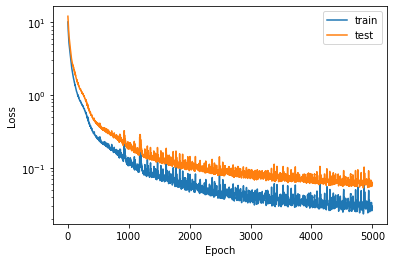

In [70]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [29]:
scale, U = get_scaled_data('matrix_tiny.mat')
U = U.to(dev).float()
df = pd.read_csv('reference_mesh_tiny.csv', header=None).values

model.eval()
print_results(model, df, U, scale, params)

reconstruction error tensor(2.1232e-28, dtype=torch.float64)

Maximum relative error for latent  =  1.5403254
Mean relative error for latent =  1.1099850090897896
Minimum relative error for latent =  0.57960033

Maximum absolute error for field  =  1.562298053792011
Mean absolute error for field  =  0.5741398701374293
Minimum absolute error for field  =  0.207542126108513

Maximum relative error for field  =  0.1499000091888264
Mean relative error for field  =  0.056317321708384466
Minimum relative error for field  =  0.03105774795943209


In [30]:
scale, U = get_scaled_data('matrix_small.mat')
U = U.to(dev).float()
df = pd.read_csv('reference_mesh_small.csv', header=None).values

model.eval()
print_results(model, df, U, scale, params)

reconstruction error tensor(1.0720e-27, dtype=torch.float64)

Maximum relative error for latent  =  0.35256848
Mean relative error for latent =  0.10019274950768291
Minimum relative error for latent =  0.023613025

Maximum absolute error for field  =  3.012339325880186
Mean absolute error for field  =  1.1473921617682636
Minimum absolute error for field  =  0.44245024673720523

Maximum relative error for field  =  0.10948217750022661
Mean relative error for field  =  0.045230614562284235
Minimum relative error for field  =  0.018958318980979043


In [31]:
scale, U = get_scaled_data('matrix.mat')
U = U.to(dev).float()
df = pd.read_csv('reference_mesh.csv', header=None).values

model.eval()
print_results(model, df, U, scale, params)

reconstruction error tensor(4.0544e-27, dtype=torch.float64)

Maximum relative error for latent  =  0.30089006
Mean relative error for latent =  0.09615057497946757
Minimum relative error for latent =  0.013740294

Maximum absolute error for field  =  5.44578015242248
Mean absolute error for field  =  2.174486706748487
Minimum absolute error for field  =  0.8209515139541231

Maximum relative error for field  =  0.10636685457135726
Mean relative error for field  =  0.04302137595848154
Minimum relative error for field  =  0.016645634127036426


In [65]:
scale, U = get_scaled_data('matrix_large.mat')
U = U.to(dev).float()
df = pd.read_csv('reference_mesh_large.csv', header=None).values

model.eval()
print_results(model, df, U, scale, params)

reconstruction error tensor(9.1108e-27, dtype=torch.float64)

Maximum relative error for latent  =  0.57024616
Mean relative error for latent =  0.23316126331602308
Minimum relative error for latent =  0.07252204

Maximum absolute error for field  =  8.35575368507678
Mean absolute error for field  =  3.4171305267458023
Minimum absolute error for field  =  1.3691562845904675

Maximum relative error for field  =  0.10759878900403348
Mean relative error for field  =  0.04494435497933597
Minimum relative error for field  =  0.019175125456240803
